In [1]:
# Import Required Libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
sys.path.insert(0, os.getcwd())
from data_loading import WaferDataLoader
from utility import (setup_model_and_loaders, hyperparameter_tuning, 
                     evaluate_model, train_model)
from models import MLP
from config import MLP_TUNING_GRID

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ All libraries imported successfully!")
print(f"Device: {device}")

Helper functions defined successfully!
✓ All libraries imported successfully!
Device: cuda


## 1. Load and Prepare Data

In [2]:
# Load data using WaferDataLoader
print("Loading wafer defect dataset...")
loader = WaferDataLoader()

print(f"✓ Dataset loaded successfully!")
print(f"X shape: {loader.X.shape}")
print(f"y shape: {loader.y.shape}")
print(f"Number of classes: {loader.num_classes}")

# Get the data
X = loader.X.astype('float32')
y = loader.y

# Normalize data
X_min, X_max = X.min(), X.max()
X_normalized = (X - X_min) / (X_max - X_min) if X_max > X_min else X

print(f"\n✓ Normalization:")
print(f"  Original range: [{X_min}, {X_max}]")
print(f"  Normalized range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")

# Split into train/val/test (70% / 15% / 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✓ Data split complete:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(y)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(y)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(y)*100:.1f}%)")

Loading wafer defect dataset...
Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
✓ Dataset loaded successfully!
X shape: (38015, 52, 52)
y shape: (38015,)
Number of classes: 38

✓ Normalization:
  Original range: [0.0, 3.0]
  Normalized range: [0.0000, 1.0000]

✓ Data split complete:
  Training set: 26610 samples (70.0%)
  Validation set: 5702 samples (15.0%)
  Test set: 5703 samples (15.0%)


## 2. Hyperparameter Tuning Grid

In [3]:
# Display tuning grid
print("="*80)
print("MLP - HYPERPARAMETER TUNING GRID".center(80))
print("="*80)
print(f"\nTuning Grid:")
for param, values in MLP_TUNING_GRID.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in MLP_TUNING_GRID.values()])
print(f"\nTotal combinations to evaluate: {total_combinations}")
print("="*80)

                        MLP - HYPERPARAMETER TUNING GRID                        

Tuning Grid:
  learning_rate: [0.005, 0.001, 0.0005, 0.0001]
  batch_size: [32, 64, 128]
  hidden_sizes: [[1024, 512, 256, 128], [512, 256, 128], [256, 128]]
  dropout: [0.1, 0.2, 0.3]
  num_epochs: [15, 20, 30]
  optimizer: ['adam', 'sgd']

Total combinations to evaluate: 648


## 3. Run Hyperparameter Tuning

In [4]:
# MLP Hyperparameter Tuning
print("\n" + "="*80)
print("STARTING HYPERPARAMETER TUNING".center(80))
print("="*80)

mlp_results = hyperparameter_tuning(
    MLP, X_train, X_val, X_test, y_train, y_val, y_test,
    param_grid=MLP_TUNING_GRID,
    input_size=2704,
    num_classes=38,
    device=str(device),
    num_epochs=25,
    patience=5,
    verbose=True
)

print("\n" + "="*80)
print("TUNING COMPLETE".center(80))
print("="*80)

# Extract top 5
mlp_top5 = mlp_results['summary_df'].head(5).copy()
print("\nTop 5 Configurations:")
print(mlp_top5[['learning_rate', 'batch_size', 'hidden_sizes', 'dropout', 'num_epochs', 'optimizer', 'Val_Acc', 'Test_Acc']].to_string())


                         STARTING HYPERPARAMETER TUNING                         

                  HYPERPARAMETER TUNING: Grid Search                  
Model: MLP
Total combinations to evaluate: 648
Parameters: learning_rate, batch_size, hidden_sizes, dropout, num_epochs, optimizer


[1/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6193, Train Acc: 0.0521
  Val Loss: 3.6148, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6134, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 8/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 2/5


Epoch 9/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 3/5


Epoch 10/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 4/5


Epoch 11/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526
✓ NEW BEST! (Val Acc: 0.0526)

[2/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6119, Train Acc: 0.0510
  Val Loss: 3.4977, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8111, Train Acc: 0.1261
  Val Loss: 2.1861, Val Acc: 0.2034
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0135, Train Acc: 0.2733
  Val Loss: 1.7536, Val Acc: 0.3178
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7633, Train Acc: 0.3271
  Val Loss: 1.5776, Val Acc: 0.3792
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6578, Train Acc: 0.3599
  Val Loss: 1.5006, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5882, Train Acc: 0.3743
  Val Loss: 1.4465, Val Acc: 0.4288
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5459, Train Acc: 0.3934
  Val Loss: 1.5140, Val Acc: 0.3960
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.5096, Train Acc: 0.4067
  Val Loss: 1.4850, Val Acc: 0.4167
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.5062, Train Acc: 0.4079
  Val Loss: 1.5898, Val Acc: 0.3911
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.4363, Train Acc: 0.4271
  Val Loss: 1.4287, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4105, Train Acc: 0.4395
  Val Loss: 1.5220, Val Acc: 0.4160
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.3813, Train Acc: 0.4552
  Val Loss: 1.3199, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3855, Train Acc: 0.4519
  Val Loss: 1.3575, Val Acc: 0.4646
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.3454, Train Acc: 0.4702
  Val Loss: 1.6053, Val Acc: 0.4085
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.3133, Train Acc: 0.4867
  Val Loss: 1.3176, Val Acc: 0.4758
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3176
Train Acc: 0.4867 | Val Acc: 0.4758 | Test Acc: 0.4710
✓ NEW BEST! (Val Acc: 0.4758)

[3/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2257, Train Acc: 0.0861
  Val Loss: 3.2751, Val Acc: 0.0710
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8238, Train Acc: 0.1129
  Val Loss: 2.6856, Val Acc: 0.1352
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8431, Train Acc: 0.1195
  Val Loss: 2.8147, Val Acc: 0.1278
  Patience: 1/5


Epoch 4/20:
  Train Loss: 2.8607, Train Acc: 0.1200
  Val Loss: 2.9388, Val Acc: 0.1149
  Patience: 2/5


Epoch 5/20:
  Train Loss: 2.8659, Train Acc: 0.1197
  Val Loss: 2.8369, Val Acc: 0.1236
  Patience: 3/5


Epoch 6/20:
  Train Loss: 2.7895, Train Acc: 0.1293
  Val Loss: 2.8494, Val Acc: 0.1108
  Patience: 4/5


Epoch 7/20:
  Train Loss: 2.8716, Train Acc: 0.1250
  Val Loss: 2.8720, Val Acc: 0.1196
  Patience: 5/5

Early stopping triggered at epoch 7

Loaded best model with validation loss: 2.6856
Train Acc: 0.1250 | Val Acc: 0.1196 | Test Acc: 0.1285

[4/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5517, Train Acc: 0.0543
  Val Loss: 3.0257, Val Acc: 0.0805
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.7767, Train Acc: 0.1227
  Val Loss: 2.2276, Val Acc: 0.2203
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0720, Train Acc: 0.2641
  Val Loss: 1.7367, Val Acc: 0.3346
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7664, Train Acc: 0.3297
  Val Loss: 1.6340, Val Acc: 0.3467
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6589, Train Acc: 0.3610
  Val Loss: 1.8590, Val Acc: 0.3085
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.5980, Train Acc: 0.3717
  Val Loss: 1.6665, Val Acc: 0.3792
  Patience: 2/5


Epoch 7/20:
  Train Loss: 1.5516, Train Acc: 0.3937
  Val Loss: 1.4717, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5084, Train Acc: 0.4075
  Val Loss: 1.5338, Val Acc: 0.3858
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4555, Train Acc: 0.4269
  Val Loss: 1.4463, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4404, Train Acc: 0.4296
  Val Loss: 1.3860, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4228, Train Acc: 0.4369
  Val Loss: 1.4646, Val Acc: 0.4362
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3740, Train Acc: 0.4570
  Val Loss: 1.3400, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3764, Train Acc: 0.4536
  Val Loss: 1.3576, Val Acc: 0.4693
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.3529, Train Acc: 0.4659
  Val Loss: 1.3754, Val Acc: 0.4679
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.3219, Train Acc: 0.4806
  Val Loss: 1.4466, Val Acc: 0.4539
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.2948, Train Acc: 0.4938
  Val Loss: 1.2707, Val Acc: 0.5042
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2583, Train Acc: 0.5126
  Val Loss: 1.3793, Val Acc: 0.4893
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.2399, Train Acc: 0.5259
  Val Loss: 1.3281, Val Acc: 0.5139
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.1922, Train Acc: 0.5509
  Val Loss: 1.4140, Val Acc: 0.4935
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.1456, Train Acc: 0.5716
  Val Loss: 1.2166, Val Acc: 0.5502
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2166
Train Acc: 0.5716 | Val Acc: 0.5502 | Test Acc: 0.5551
✓ NEW BEST! (Val Acc: 0.5502)

[5/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6206, Train Acc: 0.0515
  Val Loss: 3.6147, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 5/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 2/5


Epoch 6/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 3/5


Epoch 7/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 4/5


Epoch 8/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[6/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5343, Train Acc: 0.0551
  Val Loss: 2.9189, Val Acc: 0.1128
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6226, Train Acc: 0.1523
  Val Loss: 2.0316, Val Acc: 0.2757
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9124, Train Acc: 0.2959
  Val Loss: 1.6690, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7229, Train Acc: 0.3399
  Val Loss: 1.5142, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6451, Train Acc: 0.3623
  Val Loss: 1.5603, Val Acc: 0.3948
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.5992, Train Acc: 0.3744
  Val Loss: 1.6308, Val Acc: 0.3665
  Patience: 2/5


Epoch 7/30:
  Train Loss: 1.5480, Train Acc: 0.3895
  Val Loss: 1.4620, Val Acc: 0.4265
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4932, Train Acc: 0.4054
  Val Loss: 1.4982, Val Acc: 0.4128
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.4612, Train Acc: 0.4191
  Val Loss: 1.5184, Val Acc: 0.4113
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.4376, Train Acc: 0.4263
  Val Loss: 1.4018, Val Acc: 0.4328
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4177, Train Acc: 0.4372
  Val Loss: 1.3592, Val Acc: 0.4516
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3781, Train Acc: 0.4520
  Val Loss: 1.4834, Val Acc: 0.4277
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.3552, Train Acc: 0.4613
  Val Loss: 1.5242, Val Acc: 0.4262
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.3516, Train Acc: 0.4643
  Val Loss: 1.4699, Val Acc: 0.4356
  Patience: 3/5


Epoch 15/30:
  Train Loss: 1.3198, Train Acc: 0.4825
  Val Loss: 1.3393, Val Acc: 0.4656
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2851, Train Acc: 0.4946
  Val Loss: 1.4393, Val Acc: 0.4672
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.2864, Train Acc: 0.5010
  Val Loss: 1.3502, Val Acc: 0.4858
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.2521, Train Acc: 0.5212
  Val Loss: 1.3263, Val Acc: 0.4846
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.1961, Train Acc: 0.5466
  Val Loss: 1.1828, Val Acc: 0.5665
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.1625, Train Acc: 0.5628
  Val Loss: 1.3976, Val Acc: 0.4932
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.1087, Train Acc: 0.5943
  Val Loss: 1.2003, Val Acc: 0.5616
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.0708, Train Acc: 0.6063
  Val Loss: 1.1576, Val Acc: 0.5782
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0240, Train Acc: 0.6280
  Val Loss: 1.0774, Val Acc: 0.6142
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0028, Train Acc: 0.6355
  Val Loss: 1.0658, Val Acc: 0.6124
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9723, Train Acc: 0.6466
  Val Loss: 1.0554, Val Acc: 0.6165
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9276, Train Acc: 0.6622
  Val Loss: 1.1013, Val Acc: 0.5965
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9070, Train Acc: 0.6692
  Val Loss: 1.0866, Val Acc: 0.6149
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.8691, Train Acc: 0.6816
  Val Loss: 1.0571, Val Acc: 0.6314
  Patience: 3/5


Epoch 29/30:
  Train Loss: 0.8693, Train Acc: 0.6849
  Val Loss: 1.1388, Val Acc: 0.5915
  Patience: 4/5


Epoch 30/30:
  Train Loss: 0.8383, Train Acc: 0.6969
  Val Loss: 1.0524, Val Acc: 0.6278
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0524
Train Acc: 0.6969 | Val Acc: 0.6278 | Test Acc: 0.6237
✓ NEW BEST! (Val Acc: 0.6278)

[7/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4407, Train Acc: 0.0589
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 1/5


Epoch 10/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 2/5


Epoch 11/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 3/5


Epoch 12/15:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 4/5


Epoch 13/15:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 15/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[8/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6167, Train Acc: 0.0508
  Val Loss: 3.5693, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9256, Train Acc: 0.1070
  Val Loss: 2.2705, Val Acc: 0.2047
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2531, Train Acc: 0.2209
  Val Loss: 2.0387, Val Acc: 0.2604
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8984, Train Acc: 0.2964
  Val Loss: 1.7109, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7982, Train Acc: 0.3244
  Val Loss: 1.5049, Val Acc: 0.4074
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7142, Train Acc: 0.3432
  Val Loss: 1.6039, Val Acc: 0.3725
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6596, Train Acc: 0.3614
  Val Loss: 1.5902, Val Acc: 0.3660
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.6245, Train Acc: 0.3718
  Val Loss: 1.4738, Val Acc: 0.4078
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5902, Train Acc: 0.3827
  Val Loss: 1.4692, Val Acc: 0.4262
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5591, Train Acc: 0.3895
  Val Loss: 1.4999, Val Acc: 0.4169
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5227, Train Acc: 0.3941
  Val Loss: 1.5408, Val Acc: 0.3985
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.5081, Train Acc: 0.4041
  Val Loss: 1.4175, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4827, Train Acc: 0.4113
  Val Loss: 1.3787, Val Acc: 0.4402
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4813, Train Acc: 0.4171
  Val Loss: 1.4628, Val Acc: 0.4260
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.4544, Train Acc: 0.4224
  Val Loss: 1.3836, Val Acc: 0.4448
  Patience: 2/5

Loaded best model with validation loss: 1.3787
Train Acc: 0.4224 | Val Acc: 0.4448 | Test Acc: 0.4433

[9/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6201, Train Acc: 0.0518
  Val Loss: 3.6147, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6149, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 9/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 2/5


Epoch 10/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 3/5


Epoch 11/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 4/5


Epoch 12/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 14/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 2/5


Epoch 15/20:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 3/5


Epoch 16/20:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 18/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 19/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 3/5


Epoch 20/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 4/5

Loaded best model with validation loss: 3.6125
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[10/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5929, Train Acc: 0.0507
  Val Loss: 3.1806, Val Acc: 0.0984
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8199, Train Acc: 0.1214
  Val Loss: 2.0943, Val Acc: 0.2613
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0418, Train Acc: 0.2635
  Val Loss: 1.6900, Val Acc: 0.3632
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8365, Train Acc: 0.3083
  Val Loss: 1.6170, Val Acc: 0.3486
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7430, Train Acc: 0.3347
  Val Loss: 1.5372, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6922, Train Acc: 0.3489
  Val Loss: 1.5461, Val Acc: 0.4027
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6370, Train Acc: 0.3614
  Val Loss: 1.5771, Val Acc: 0.3637
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.5997, Train Acc: 0.3760
  Val Loss: 1.5580, Val Acc: 0.3534
  Patience: 3/5


Epoch 9/20:
  Train Loss: 1.5634, Train Acc: 0.3877
  Val Loss: 1.5345, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5381, Train Acc: 0.3964
  Val Loss: 1.4046, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5092, Train Acc: 0.4042
  Val Loss: 1.5195, Val Acc: 0.4141
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4870, Train Acc: 0.4141
  Val Loss: 1.4225, Val Acc: 0.4281
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.4723, Train Acc: 0.4195
  Val Loss: 1.4400, Val Acc: 0.4276
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.4635, Train Acc: 0.4212
  Val Loss: 1.4183, Val Acc: 0.4456
  Patience: 4/5


Epoch 15/20:
  Train Loss: 1.4221, Train Acc: 0.4383
  Val Loss: 1.4483, Val Acc: 0.4309
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.4046
Train Acc: 0.4383 | Val Acc: 0.4309 | Test Acc: 0.4179

[11/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5116, Train Acc: 0.0541
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6165, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 1/5


Epoch 4/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 2/5


Epoch 7/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 3/5


Epoch 8/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 4/5


Epoch 9/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[12/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6203, Train Acc: 0.0512
  Val Loss: 3.5990, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1030, Train Acc: 0.0852
  Val Loss: 2.6733, Val Acc: 0.1212
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4185, Train Acc: 0.1950
  Val Loss: 1.9829, Val Acc: 0.2752
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9232, Train Acc: 0.2913
  Val Loss: 1.8793, Val Acc: 0.3048
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7751, Train Acc: 0.3273
  Val Loss: 1.8506, Val Acc: 0.2952
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6868, Train Acc: 0.3495
  Val Loss: 1.7233, Val Acc: 0.3383
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6534, Train Acc: 0.3634
  Val Loss: 1.5041, Val Acc: 0.4144
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6146, Train Acc: 0.3690
  Val Loss: 1.5308, Val Acc: 0.4002
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5677, Train Acc: 0.3884
  Val Loss: 1.4519, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5328, Train Acc: 0.3998
  Val Loss: 1.5797, Val Acc: 0.3797
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.5253, Train Acc: 0.4036
  Val Loss: 1.4428, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5017, Train Acc: 0.4082
  Val Loss: 1.4057, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4884, Train Acc: 0.4132
  Val Loss: 1.4575, Val Acc: 0.4123
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4600, Train Acc: 0.4253
  Val Loss: 1.3562, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4319, Train Acc: 0.4297
  Val Loss: 1.4681, Val Acc: 0.4274
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4117, Train Acc: 0.4433
  Val Loss: 1.3901, Val Acc: 0.4407
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.4211, Train Acc: 0.4399
  Val Loss: 1.3697, Val Acc: 0.4616
  Patience: 3/5


Epoch 18/30:
  Train Loss: 1.3876, Train Acc: 0.4506
  Val Loss: 1.3426, Val Acc: 0.4667
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3645, Train Acc: 0.4621
  Val Loss: 1.4160, Val Acc: 0.4341
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.3427, Train Acc: 0.4705
  Val Loss: 1.3592, Val Acc: 0.4707
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.3416, Train Acc: 0.4729
  Val Loss: 1.3108, Val Acc: 0.4835
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3281, Train Acc: 0.4841
  Val Loss: 1.3681, Val Acc: 0.4584
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.2982, Train Acc: 0.5001
  Val Loss: 1.3061, Val Acc: 0.5023
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2777, Train Acc: 0.5164
  Val Loss: 1.1953, Val Acc: 0.5623
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2447, Train Acc: 0.5343
  Val Loss: 1.2598, Val Acc: 0.5249
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.2332, Train Acc: 0.5378
  Val Loss: 1.2427, Val Acc: 0.5479
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.2109, Train Acc: 0.5544
  Val Loss: 1.1313, Val Acc: 0.5908
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1600, Train Acc: 0.5774
  Val Loss: 1.3776, Val Acc: 0.5114
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.1427, Train Acc: 0.5858
  Val Loss: 1.0948, Val Acc: 0.6079
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.0896, Train Acc: 0.6029
  Val Loss: 1.0841, Val Acc: 0.6121
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0841
Train Acc: 0.6029 | Val Acc: 0.6121 | Test Acc: 0.6090

[13/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6213, Train Acc: 0.0516
  Val Loss: 3.6167, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6156, Train Acc: 0.0525
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  Patience: 2/5


Epoch 7/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 3/5


Epoch 8/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 4/5


Epoch 9/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[14/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6060, Train Acc: 0.0509
  Val Loss: 3.3969, Val Acc: 0.0607
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9929, Train Acc: 0.0906
  Val Loss: 2.7629, Val Acc: 0.1145
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5358, Train Acc: 0.1689
  Val Loss: 2.1969, Val Acc: 0.2566
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1146, Train Acc: 0.2468
  Val Loss: 1.7941, Val Acc: 0.2853
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9394, Train Acc: 0.2858
  Val Loss: 1.6602, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8298, Train Acc: 0.3127
  Val Loss: 1.6303, Val Acc: 0.3515
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7975, Train Acc: 0.3185
  Val Loss: 1.5201, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7715, Train Acc: 0.3317
  Val Loss: 1.6725, Val Acc: 0.3627
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.7448, Train Acc: 0.3412
  Val Loss: 1.5385, Val Acc: 0.4032
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.7004, Train Acc: 0.3502
  Val Loss: 1.4564, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6865, Train Acc: 0.3540
  Val Loss: 1.5492, Val Acc: 0.3743
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.6744, Train Acc: 0.3584
  Val Loss: 1.5926, Val Acc: 0.3671
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.6619, Train Acc: 0.3635
  Val Loss: 1.5830, Val Acc: 0.3634
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.6604, Train Acc: 0.3613
  Val Loss: 1.4807, Val Acc: 0.3923
  Patience: 4/5


Epoch 15/15:
  Train Loss: 1.6393, Train Acc: 0.3624
  Val Loss: 1.4662, Val Acc: 0.4165
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.4564
Train Acc: 0.3624 | Val Acc: 0.4165 | Test Acc: 0.4112

[15/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6226, Train Acc: 0.0514
  Val Loss: 3.6147, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6157, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 1/5


Epoch 4/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 8/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 3/5


Epoch 9/20:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 4/5


Epoch 10/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[16/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6136, Train Acc: 0.0524
  Val Loss: 3.5257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0413, Train Acc: 0.0872
  Val Loss: 2.7683, Val Acc: 0.1159
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6732, Train Acc: 0.1411
  Val Loss: 2.1869, Val Acc: 0.2120
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1463, Train Acc: 0.2427
  Val Loss: 1.8556, Val Acc: 0.2820
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9394, Train Acc: 0.2832
  Val Loss: 1.5962, Val Acc: 0.3814
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8601, Train Acc: 0.3080
  Val Loss: 1.5777, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8085, Train Acc: 0.3212
  Val Loss: 1.5886, Val Acc: 0.3772
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.7571, Train Acc: 0.3338
  Val Loss: 1.5706, Val Acc: 0.3788
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7234, Train Acc: 0.3407
  Val Loss: 1.5153, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6943, Train Acc: 0.3495
  Val Loss: 1.5800, Val Acc: 0.3793
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.6818, Train Acc: 0.3535
  Val Loss: 1.5260, Val Acc: 0.3823
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.6924, Train Acc: 0.3504
  Val Loss: 1.5140, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6747, Train Acc: 0.3595
  Val Loss: 1.4864, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6616, Train Acc: 0.3611
  Val Loss: 1.5153, Val Acc: 0.3946
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.6398, Train Acc: 0.3670
  Val Loss: 1.4639, Val Acc: 0.4142
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6399, Train Acc: 0.3677
  Val Loss: 1.4677, Val Acc: 0.4151
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.6392, Train Acc: 0.3674
  Val Loss: 1.5175, Val Acc: 0.4023
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.6342, Train Acc: 0.3719
  Val Loss: 1.4960, Val Acc: 0.4076
  Patience: 3/5


Epoch 19/20:
  Train Loss: 1.6314, Train Acc: 0.3662
  Val Loss: 1.4576, Val Acc: 0.4151
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6359, Train Acc: 0.3700
  Val Loss: 1.5622, Val Acc: 0.3916
  Patience: 1/5

Loaded best model with validation loss: 1.4576
Train Acc: 0.3700 | Val Acc: 0.3916 | Test Acc: 0.3772

[17/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6220, Train Acc: 0.0520
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 2/5


Epoch 8/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 3/5


Epoch 9/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 4/5


Epoch 10/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[18/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6082, Train Acc: 0.0501
  Val Loss: 3.3927, Val Acc: 0.0677
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9833, Train Acc: 0.0940
  Val Loss: 2.8104, Val Acc: 0.1228
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6517, Train Acc: 0.1467
  Val Loss: 2.1094, Val Acc: 0.2454
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2059, Train Acc: 0.2335
  Val Loss: 1.9790, Val Acc: 0.2871
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9769, Train Acc: 0.2775
  Val Loss: 1.7688, Val Acc: 0.3148
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8856, Train Acc: 0.3025
  Val Loss: 1.8402, Val Acc: 0.3148
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.8181, Train Acc: 0.3149
  Val Loss: 1.5682, Val Acc: 0.3886
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7964, Train Acc: 0.3262
  Val Loss: 1.6493, Val Acc: 0.3692
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.7642, Train Acc: 0.3387
  Val Loss: 1.5648, Val Acc: 0.3850
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7352, Train Acc: 0.3410
  Val Loss: 1.5952, Val Acc: 0.3704
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.7051, Train Acc: 0.3447
  Val Loss: 1.5974, Val Acc: 0.3699
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.6803, Train Acc: 0.3573
  Val Loss: 1.6405, Val Acc: 0.3655
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.6848, Train Acc: 0.3583
  Val Loss: 1.5123, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6548, Train Acc: 0.3610
  Val Loss: 1.5197, Val Acc: 0.3974
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.6306, Train Acc: 0.3700
  Val Loss: 1.5348, Val Acc: 0.4083
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.6077, Train Acc: 0.3801
  Val Loss: 1.5908, Val Acc: 0.3820
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.6316, Train Acc: 0.3714
  Val Loss: 1.5335, Val Acc: 0.4041
  Patience: 4/5


Epoch 18/30:
  Train Loss: 1.6428, Train Acc: 0.3713
  Val Loss: 1.4437, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6119, Train Acc: 0.3766
  Val Loss: 1.5358, Val Acc: 0.4092
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.6354, Train Acc: 0.3727
  Val Loss: 1.5050, Val Acc: 0.4044
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.6199, Train Acc: 0.3759
  Val Loss: 1.4978, Val Acc: 0.4111
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.6341, Train Acc: 0.3729
  Val Loss: 1.4039, Val Acc: 0.4397
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5968, Train Acc: 0.3802
  Val Loss: 1.4577, Val Acc: 0.4207
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5947, Train Acc: 0.3867
  Val Loss: 1.4177, Val Acc: 0.4341
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.5743, Train Acc: 0.3909
  Val Loss: 1.4694, Val Acc: 0.4102
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.5924, Train Acc: 0.3847
  Val Loss: 1.4648, Val Acc: 0.4216
  Patience: 4/5


Epoch 27/30:
  Train Loss: 1.6062, Train Acc: 0.3793
  Val Loss: 1.4424, Val Acc: 0.4332
  Patience: 5/5

Early stopping triggered at epoch 27

Loaded best model with validation loss: 1.4039
Train Acc: 0.3793 | Val Acc: 0.4332 | Test Acc: 0.4335

[19/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6207, Train Acc: 0.0509
  Val Loss: 3.6139, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6153, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 5/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 6/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 3/5


Epoch 7/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 9/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 10/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 3/5


Epoch 11/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 4/5


Epoch 12/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[20/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3243, Train Acc: 0.0694
  Val Loss: 2.7724, Val Acc: 0.1270
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3533, Train Acc: 0.2115
  Val Loss: 1.8817, Val Acc: 0.3146
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8352, Train Acc: 0.3160
  Val Loss: 1.8273, Val Acc: 0.3348
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6986, Train Acc: 0.3453
  Val Loss: 1.5364, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6154, Train Acc: 0.3708
  Val Loss: 1.5267, Val Acc: 0.3937
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5583, Train Acc: 0.3900
  Val Loss: 1.5471, Val Acc: 0.3772
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5095, Train Acc: 0.4054
  Val Loss: 1.4648, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4767, Train Acc: 0.4160
  Val Loss: 1.4211, Val Acc: 0.4397
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4477, Train Acc: 0.4314
  Val Loss: 1.3329, Val Acc: 0.4702
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4109, Train Acc: 0.4458
  Val Loss: 1.4950, Val Acc: 0.4395
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.3544, Train Acc: 0.4718
  Val Loss: 1.5013, Val Acc: 0.4137
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.3227, Train Acc: 0.4885
  Val Loss: 1.4437, Val Acc: 0.4867
  Patience: 3/5


Epoch 13/15:
  Train Loss: 1.2720, Train Acc: 0.5202
  Val Loss: 1.2070, Val Acc: 0.5482
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2281, Train Acc: 0.5432
  Val Loss: 1.1399, Val Acc: 0.5789
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.1531, Train Acc: 0.5762
  Val Loss: 1.1499, Val Acc: 0.5803
  Patience: 1/5

Loaded best model with validation loss: 1.1399
Train Acc: 0.5762 | Val Acc: 0.5803 | Test Acc: 0.5876

[21/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6176, Train Acc: 0.0531
  Val Loss: 3.6141, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6136, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 5/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 1/5


Epoch 9/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  Patience: 2/5


Epoch 10/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 3/5


Epoch 11/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 13/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 2/5


Epoch 14/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 3/5


Epoch 15/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 4/5


Epoch 16/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[22/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3708, Train Acc: 0.0735
  Val Loss: 2.4110, Val Acc: 0.2052
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1404, Train Acc: 0.2506
  Val Loss: 1.9144, Val Acc: 0.2608
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7974, Train Acc: 0.3243
  Val Loss: 1.7966, Val Acc: 0.3259
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6982, Train Acc: 0.3539
  Val Loss: 1.5967, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6064, Train Acc: 0.3762
  Val Loss: 1.4474, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5505, Train Acc: 0.3925
  Val Loss: 1.4944, Val Acc: 0.4088
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.5280, Train Acc: 0.3981
  Val Loss: 1.3862, Val Acc: 0.4528
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4801, Train Acc: 0.4150
  Val Loss: 1.4186, Val Acc: 0.4381
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4261, Train Acc: 0.4366
  Val Loss: 1.4215, Val Acc: 0.4330
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.4025, Train Acc: 0.4543
  Val Loss: 1.4156, Val Acc: 0.4435
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.3458, Train Acc: 0.4852
  Val Loss: 1.3666, Val Acc: 0.4830
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2901, Train Acc: 0.5101
  Val Loss: 1.3187, Val Acc: 0.5274
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2454, Train Acc: 0.5374
  Val Loss: 1.1023, Val Acc: 0.5898
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1630, Train Acc: 0.5749
  Val Loss: 1.1261, Val Acc: 0.5884
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.1238, Train Acc: 0.5915
  Val Loss: 1.1380, Val Acc: 0.5821
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.0752, Train Acc: 0.6101
  Val Loss: 0.9979, Val Acc: 0.6443
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0395, Train Acc: 0.6236
  Val Loss: 1.1127, Val Acc: 0.5896
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.0075, Train Acc: 0.6335
  Val Loss: 1.0657, Val Acc: 0.6236
  Patience: 2/5


Epoch 19/20:
  Train Loss: 0.9801, Train Acc: 0.6395
  Val Loss: 1.1282, Val Acc: 0.6121
  Patience: 3/5


Epoch 20/20:
  Train Loss: 0.9798, Train Acc: 0.6476
  Val Loss: 0.9844, Val Acc: 0.6417
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9844
Train Acc: 0.6476 | Val Acc: 0.6417 | Test Acc: 0.6439
✓ NEW BEST! (Val Acc: 0.6417)

[23/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6215, Train Acc: 0.0513
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 4/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  Patience: 2/5


Epoch 5/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 8/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 3/5


Epoch 9/30:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 4/5


Epoch 10/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[24/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2927, Train Acc: 0.0783
  Val Loss: 2.4906, Val Acc: 0.1898
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1745, Train Acc: 0.2406
  Val Loss: 1.8349, Val Acc: 0.3055
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8273, Train Acc: 0.3169
  Val Loss: 1.6473, Val Acc: 0.3430
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6772, Train Acc: 0.3539
  Val Loss: 1.5908, Val Acc: 0.3916
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6193, Train Acc: 0.3735
  Val Loss: 1.4555, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5669, Train Acc: 0.3906
  Val Loss: 1.4698, Val Acc: 0.4134
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.5048, Train Acc: 0.4071
  Val Loss: 1.5549, Val Acc: 0.3941
  Patience: 2/5


Epoch 8/30:
  Train Loss: 1.4750, Train Acc: 0.4147
  Val Loss: 1.5585, Val Acc: 0.3681
  Patience: 3/5


Epoch 9/30:
  Train Loss: 1.4403, Train Acc: 0.4323
  Val Loss: 1.4334, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4065, Train Acc: 0.4512
  Val Loss: 1.3555, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3545, Train Acc: 0.4794
  Val Loss: 1.3757, Val Acc: 0.4795
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2966, Train Acc: 0.5092
  Val Loss: 1.3420, Val Acc: 0.4897
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2422, Train Acc: 0.5365
  Val Loss: 1.4084, Val Acc: 0.4932
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2191, Train Acc: 0.5538
  Val Loss: 1.3396, Val Acc: 0.5188
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1235, Train Acc: 0.5869
  Val Loss: 1.2243, Val Acc: 0.5398
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1014, Train Acc: 0.5964
  Val Loss: 1.1349, Val Acc: 0.5782
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0623, Train Acc: 0.6167
  Val Loss: 1.1742, Val Acc: 0.5791
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.0068, Train Acc: 0.6362
  Val Loss: 1.1016, Val Acc: 0.6245
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0017, Train Acc: 0.6369
  Val Loss: 1.0575, Val Acc: 0.6082
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9463, Train Acc: 0.6569
  Val Loss: 0.9122, Val Acc: 0.6701
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9265, Train Acc: 0.6639
  Val Loss: 0.9458, Val Acc: 0.6619
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8876, Train Acc: 0.6803
  Val Loss: 1.0347, Val Acc: 0.6564
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.8585, Train Acc: 0.6891
  Val Loss: 1.0062, Val Acc: 0.6429
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.8417, Train Acc: 0.6924
  Val Loss: 1.1935, Val Acc: 0.5865
  Patience: 4/5


Epoch 25/30:
  Train Loss: 0.8272, Train Acc: 0.7008
  Val Loss: 0.9364, Val Acc: 0.6719
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 0.9122
Train Acc: 0.7008 | Val Acc: 0.6719 | Test Acc: 0.6605
✓ NEW BEST! (Val Acc: 0.6719)

[25/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6207, Train Acc: 0.0512
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 2/5


Epoch 7/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 3/5


Epoch 8/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 4/5


Epoch 9/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 11/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 2/5


Epoch 12/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 3/5


Epoch 13/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 4/5


Epoch 14/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[26/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4354, Train Acc: 0.0620
  Val Loss: 2.8305, Val Acc: 0.1135
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4097, Train Acc: 0.2009
  Val Loss: 1.8820, Val Acc: 0.3036
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9083, Train Acc: 0.2929
  Val Loss: 1.7005, Val Acc: 0.3402
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7849, Train Acc: 0.3253
  Val Loss: 1.5238, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7361, Train Acc: 0.3378
  Val Loss: 1.6117, Val Acc: 0.3685
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.6627, Train Acc: 0.3621
  Val Loss: 1.6165, Val Acc: 0.3835
  Patience: 2/5


Epoch 7/15:
  Train Loss: 1.6346, Train Acc: 0.3675
  Val Loss: 1.4526, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5839, Train Acc: 0.3817
  Val Loss: 1.4322, Val Acc: 0.4374
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5647, Train Acc: 0.3864
  Val Loss: 1.5210, Val Acc: 0.4007
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.5361, Train Acc: 0.3961
  Val Loss: 1.4204, Val Acc: 0.4390
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5271, Train Acc: 0.4021
  Val Loss: 1.4309, Val Acc: 0.4400
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5129, Train Acc: 0.4075
  Val Loss: 1.4700, Val Acc: 0.4411
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.4677, Train Acc: 0.4232
  Val Loss: 1.5143, Val Acc: 0.4093
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.4473, Train Acc: 0.4321
  Val Loss: 1.4670, Val Acc: 0.4405
  Patience: 4/5


Epoch 15/15:
  Train Loss: 1.4367, Train Acc: 0.4395
  Val Loss: 1.3303, Val Acc: 0.4826
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3303
Train Acc: 0.4395 | Val Acc: 0.4826 | Test Acc: 0.4804

[27/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2562, Train Acc: 0.0736
  Val Loss: 2.8268, Val Acc: 0.0894
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0023, Train Acc: 0.0967
  Val Loss: 2.7365, Val Acc: 0.1387
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.9150, Train Acc: 0.1083
  Val Loss: 2.7377, Val Acc: 0.1317
  Patience: 1/5


Epoch 4/20:
  Train Loss: 2.9034, Train Acc: 0.1124
  Val Loss: 2.8997, Val Acc: 0.1180
  Patience: 2/5


Epoch 5/20:
  Train Loss: 2.9259, Train Acc: 0.1101
  Val Loss: 2.9834, Val Acc: 0.1128
  Patience: 3/5


Epoch 6/20:
  Train Loss: 2.9778, Train Acc: 0.1056
  Val Loss: 3.0461, Val Acc: 0.1200
  Patience: 4/5


Epoch 7/20:
  Train Loss: 2.9935, Train Acc: 0.1051
  Val Loss: 3.2290, Val Acc: 0.0986
  Patience: 5/5

Early stopping triggered at epoch 7

Loaded best model with validation loss: 2.7365
Train Acc: 0.1051 | Val Acc: 0.0986 | Test Acc: 0.1043

[28/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4493, Train Acc: 0.0613
  Val Loss: 2.8488, Val Acc: 0.0924
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3535, Train Acc: 0.2059
  Val Loss: 1.9220, Val Acc: 0.3183
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9359, Train Acc: 0.2874
  Val Loss: 1.6759, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7999, Train Acc: 0.3240
  Val Loss: 1.6165, Val Acc: 0.3902
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7297, Train Acc: 0.3403
  Val Loss: 1.5970, Val Acc: 0.3707
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6729, Train Acc: 0.3557
  Val Loss: 1.5966, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6520, Train Acc: 0.3655
  Val Loss: 1.5231, Val Acc: 0.3949
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5991, Train Acc: 0.3807
  Val Loss: 1.5969, Val Acc: 0.3611
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5738, Train Acc: 0.3850
  Val Loss: 1.5068, Val Acc: 0.3786
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5498, Train Acc: 0.3906
  Val Loss: 1.5072, Val Acc: 0.4062
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5369, Train Acc: 0.3964
  Val Loss: 1.4592, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5032, Train Acc: 0.4114
  Val Loss: 1.4673, Val Acc: 0.4283
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.4998, Train Acc: 0.4172
  Val Loss: 1.3829, Val Acc: 0.4523
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4648, Train Acc: 0.4233
  Val Loss: 1.4098, Val Acc: 0.4411
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.4305, Train Acc: 0.4394
  Val Loss: 1.3602, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4339, Train Acc: 0.4437
  Val Loss: 1.3953, Val Acc: 0.4655
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.4075, Train Acc: 0.4607
  Val Loss: 1.3508, Val Acc: 0.5014
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.3550, Train Acc: 0.4885
  Val Loss: 1.2568, Val Acc: 0.5160
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.3434, Train Acc: 0.4946
  Val Loss: 1.3211, Val Acc: 0.5288
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3223, Train Acc: 0.5102
  Val Loss: 1.2068, Val Acc: 0.5577
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2068
Train Acc: 0.5102 | Val Acc: 0.5577 | Test Acc: 0.5445

[29/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6225, Train Acc: 0.0511
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 1/5


Epoch 3/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 2/5


Epoch 7/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 3/5


Epoch 8/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 4/5


Epoch 9/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[30/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3642, Train Acc: 0.0687
  Val Loss: 2.7932, Val Acc: 0.1219
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3207, Train Acc: 0.2153
  Val Loss: 1.8634, Val Acc: 0.2906
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9185, Train Acc: 0.2923
  Val Loss: 1.6001, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7795, Train Acc: 0.3257
  Val Loss: 1.5546, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7187, Train Acc: 0.3430
  Val Loss: 1.5665, Val Acc: 0.3885
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.6560, Train Acc: 0.3590
  Val Loss: 1.4991, Val Acc: 0.4007
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6164, Train Acc: 0.3723
  Val Loss: 1.5086, Val Acc: 0.4056
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6135, Train Acc: 0.3740
  Val Loss: 1.4891, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5843, Train Acc: 0.3848
  Val Loss: 1.4992, Val Acc: 0.4042
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5487, Train Acc: 0.3953
  Val Loss: 1.4444, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5323, Train Acc: 0.3981
  Val Loss: 1.3581, Val Acc: 0.4584
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4971, Train Acc: 0.4097
  Val Loss: 1.4313, Val Acc: 0.4158
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4681, Train Acc: 0.4245
  Val Loss: 1.3953, Val Acc: 0.4400
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.4528, Train Acc: 0.4313
  Val Loss: 1.3732, Val Acc: 0.4521
  Patience: 3/5


Epoch 15/30:
  Train Loss: 1.4208, Train Acc: 0.4404
  Val Loss: 1.3197, Val Acc: 0.4786
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4191, Train Acc: 0.4470
  Val Loss: 1.3956, Val Acc: 0.4504
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.3860, Train Acc: 0.4634
  Val Loss: 1.3977, Val Acc: 0.4344
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.3628, Train Acc: 0.4736
  Val Loss: 1.3141, Val Acc: 0.4960
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3408, Train Acc: 0.4929
  Val Loss: 1.2540, Val Acc: 0.5333
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3376, Train Acc: 0.4937
  Val Loss: 1.3478, Val Acc: 0.4844
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.3116, Train Acc: 0.5106
  Val Loss: 1.3184, Val Acc: 0.5174
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.2886, Train Acc: 0.5223
  Val Loss: 1.3176, Val Acc: 0.5209
  Patience: 3/5


Epoch 23/30:
  Train Loss: 1.2520, Train Acc: 0.5392
  Val Loss: 1.3054, Val Acc: 0.5277
  Patience: 4/5


Epoch 24/30:
  Train Loss: 1.2241, Train Acc: 0.5510
  Val Loss: 1.2127, Val Acc: 0.5761
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1944, Train Acc: 0.5640
  Val Loss: 1.2019, Val Acc: 0.5605
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1665, Train Acc: 0.5742
  Val Loss: 1.1299, Val Acc: 0.6038
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.1540, Train Acc: 0.5838
  Val Loss: 1.0399, Val Acc: 0.6254
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1255, Train Acc: 0.5950
  Val Loss: 1.1785, Val Acc: 0.5619
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.0950, Train Acc: 0.6040
  Val Loss: 1.0623, Val Acc: 0.6242
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.0804, Train Acc: 0.6087
  Val Loss: 1.3991, Val Acc: 0.5160
  Patience: 3/5

Loaded best model with validation loss: 1.0399
Train Acc: 0.6087 | Val Acc: 0.5160 | Test Acc: 0.5218

[31/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6231, Train Acc: 0.0512
  Val Loss: 3.6134, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6141, Val Acc: 0.0526
  Patience: 1/5


Epoch 3/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 7/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 3/5


Epoch 8/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 10/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 12/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 13/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 15/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 2/5

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[32/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4866, Train Acc: 0.0600
  Val Loss: 2.9034, Val Acc: 0.0968
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4805, Train Acc: 0.1804
  Val Loss: 1.9109, Val Acc: 0.3153
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0646, Train Acc: 0.2608
  Val Loss: 1.8921, Val Acc: 0.3074
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9371, Train Acc: 0.2926
  Val Loss: 1.6856, Val Acc: 0.3420
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8670, Train Acc: 0.3103
  Val Loss: 1.5864, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8308, Train Acc: 0.3144
  Val Loss: 1.6290, Val Acc: 0.3508
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.7920, Train Acc: 0.3279
  Val Loss: 1.6437, Val Acc: 0.3785
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.7697, Train Acc: 0.3340
  Val Loss: 1.6082, Val Acc: 0.3732
  Patience: 3/5


Epoch 9/15:
  Train Loss: 1.7477, Train Acc: 0.3393
  Val Loss: 1.5347, Val Acc: 0.3946
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7420, Train Acc: 0.3422
  Val Loss: 1.5208, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7393, Train Acc: 0.3401
  Val Loss: 1.4826, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7124, Train Acc: 0.3490
  Val Loss: 1.4996, Val Acc: 0.4086
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.7300, Train Acc: 0.3464
  Val Loss: 1.5214, Val Acc: 0.4058
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.6992, Train Acc: 0.3516
  Val Loss: 1.5124, Val Acc: 0.3988
  Patience: 3/5


Epoch 15/15:
  Train Loss: 1.6997, Train Acc: 0.3508
  Val Loss: 1.5227, Val Acc: 0.4067
  Patience: 4/5

Loaded best model with validation loss: 1.4826
Train Acc: 0.3508 | Val Acc: 0.4067 | Test Acc: 0.3947

[33/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6227, Train Acc: 0.0512
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6151, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 2/5


Epoch 7/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 3/5


Epoch 8/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 4/5


Epoch 9/20:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 3.6126
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[34/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4549, Train Acc: 0.0615
  Val Loss: 2.8950, Val Acc: 0.1026
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5519, Train Acc: 0.1706
  Val Loss: 1.9555, Val Acc: 0.3081
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0599, Train Acc: 0.2633
  Val Loss: 1.8541, Val Acc: 0.3134
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9579, Train Acc: 0.2812
  Val Loss: 1.7144, Val Acc: 0.3364
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8798, Train Acc: 0.3074
  Val Loss: 1.6639, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8336, Train Acc: 0.3143
  Val Loss: 1.6339, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8045, Train Acc: 0.3149
  Val Loss: 1.6550, Val Acc: 0.3625
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.7873, Train Acc: 0.3257
  Val Loss: 1.5472, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8127, Train Acc: 0.3197
  Val Loss: 1.7718, Val Acc: 0.3222
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.8229, Train Acc: 0.3190
  Val Loss: 1.6041, Val Acc: 0.3941
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.8444, Train Acc: 0.3130
  Val Loss: 1.5699, Val Acc: 0.3890
  Patience: 3/5


Epoch 12/20:
  Train Loss: 1.8323, Train Acc: 0.3172
  Val Loss: 1.7226, Val Acc: 0.3560
  Patience: 4/5


Epoch 13/20:
  Train Loss: 1.8062, Train Acc: 0.3232
  Val Loss: 1.5639, Val Acc: 0.3971
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.5472
Train Acc: 0.3232 | Val Acc: 0.3971 | Test Acc: 0.3963

[35/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6221, Train Acc: 0.0513
  Val Loss: 3.6136, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 1/5


Epoch 6/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 1/5


Epoch 8/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 2/5


Epoch 9/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 3/5


Epoch 10/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 4/5


Epoch 11/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 3.6127
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[36/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3660, Train Acc: 0.0655
  Val Loss: 2.8326, Val Acc: 0.1022
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4530, Train Acc: 0.1867
  Val Loss: 1.9506, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0342, Train Acc: 0.2663
  Val Loss: 1.8246, Val Acc: 0.3229
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9339, Train Acc: 0.2876
  Val Loss: 1.9655, Val Acc: 0.3132
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.8676, Train Acc: 0.3073
  Val Loss: 1.6811, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8411, Train Acc: 0.3150
  Val Loss: 1.5671, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8237, Train Acc: 0.3224
  Val Loss: 1.6057, Val Acc: 0.3692
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.8230, Train Acc: 0.3172
  Val Loss: 1.6084, Val Acc: 0.4007
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.8086, Train Acc: 0.3238
  Val Loss: 1.5939, Val Acc: 0.3732
  Patience: 3/5


Epoch 10/30:
  Train Loss: 1.8006, Train Acc: 0.3270
  Val Loss: 1.6072, Val Acc: 0.3753
  Patience: 4/5


Epoch 11/30:
  Train Loss: 1.8044, Train Acc: 0.3213
  Val Loss: 1.5753, Val Acc: 0.3964
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 1.5671
Train Acc: 0.3213 | Val Acc: 0.3964 | Test Acc: 0.3889

[37/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7496, Train Acc: 0.1532
  Val Loss: 2.0346, Val Acc: 0.3008
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2703, Train Acc: 0.2293
  Val Loss: 2.0405, Val Acc: 0.2727
  Patience: 1/5


Epoch 3/15:
  Train Loss: 2.1510, Train Acc: 0.2564
  Val Loss: 1.9491, Val Acc: 0.3027
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0655, Train Acc: 0.2890
  Val Loss: 1.9805, Val Acc: 0.2887
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.9695, Train Acc: 0.3170
  Val Loss: 1.8253, Val Acc: 0.3494
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9449, Train Acc: 0.3227
  Val Loss: 1.8835, Val Acc: 0.3157
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.9170, Train Acc: 0.3245
  Val Loss: 1.6637, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.8975, Train Acc: 0.3328
  Val Loss: 1.6221, Val Acc: 0.3797
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8549, Train Acc: 0.3437
  Val Loss: 1.5565, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8421, Train Acc: 0.3442
  Val Loss: 1.6059, Val Acc: 0.3923
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.8136, Train Acc: 0.3553
  Val Loss: 1.6239, Val Acc: 0.3795
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.8390, Train Acc: 0.3532
  Val Loss: 1.7171, Val Acc: 0.3488
  Patience: 3/5


Epoch 13/15:
  Train Loss: 1.8558, Train Acc: 0.3479
  Val Loss: 1.8133, Val Acc: 0.3187
  Patience: 4/5


Epoch 14/15:
  Train Loss: 1.8567, Train Acc: 0.3478
  Val Loss: 1.7460, Val Acc: 0.3472
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.5565
Train Acc: 0.3478 | Val Acc: 0.3472 | Test Acc: 0.3465

[38/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9960, Train Acc: 0.1233
  Val Loss: 1.9791, Val Acc: 0.2713
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9402, Train Acc: 0.2883
  Val Loss: 1.7553, Val Acc: 0.3236
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7645, Train Acc: 0.3322
  Val Loss: 1.5990, Val Acc: 0.3751
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6667, Train Acc: 0.3618
  Val Loss: 1.5728, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5923, Train Acc: 0.3978
  Val Loss: 1.4647, Val Acc: 0.4618
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5091, Train Acc: 0.4369
  Val Loss: 1.3446, Val Acc: 0.5118
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4200, Train Acc: 0.4792
  Val Loss: 1.5176, Val Acc: 0.4381
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.3445, Train Acc: 0.5057
  Val Loss: 1.5111, Val Acc: 0.4242
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.3264, Train Acc: 0.5129
  Val Loss: 1.2617, Val Acc: 0.5298
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.2817, Train Acc: 0.5312
  Val Loss: 1.3122, Val Acc: 0.5042
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.2521, Train Acc: 0.5391
  Val Loss: 1.3728, Val Acc: 0.4711
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.2157, Train Acc: 0.5546
  Val Loss: 1.3237, Val Acc: 0.5214
  Patience: 3/5


Epoch 13/15:
  Train Loss: 1.1722, Train Acc: 0.5753
  Val Loss: 1.0437, Val Acc: 0.6242
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.1138, Train Acc: 0.5952
  Val Loss: 1.1491, Val Acc: 0.5823
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.0669, Train Acc: 0.6143
  Val Loss: 1.2299, Val Acc: 0.5291
  Patience: 2/5

Loaded best model with validation loss: 1.0437
Train Acc: 0.6143 | Val Acc: 0.5291 | Test Acc: 0.5301

[39/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7557, Train Acc: 0.1565
  Val Loss: 2.0760, Val Acc: 0.2743
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2148, Train Acc: 0.2477
  Val Loss: 1.8799, Val Acc: 0.3250
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0450, Train Acc: 0.2934
  Val Loss: 1.8679, Val Acc: 0.3141
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9755, Train Acc: 0.3072
  Val Loss: 1.6323, Val Acc: 0.3814
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9148, Train Acc: 0.3230
  Val Loss: 1.7040, Val Acc: 0.3665
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.8785, Train Acc: 0.3315
  Val Loss: 1.9118, Val Acc: 0.2892
  Patience: 2/5


Epoch 7/20:
  Train Loss: 1.8284, Train Acc: 0.3454
  Val Loss: 1.7055, Val Acc: 0.3495
  Patience: 3/5


Epoch 8/20:
  Train Loss: 1.8322, Train Acc: 0.3400
  Val Loss: 1.6189, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7893, Train Acc: 0.3507
  Val Loss: 1.6736, Val Acc: 0.3518
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.8065, Train Acc: 0.3478
  Val Loss: 1.7353, Val Acc: 0.3508
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.7898, Train Acc: 0.3611
  Val Loss: 1.6071, Val Acc: 0.3767
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7905, Train Acc: 0.3546
  Val Loss: 1.8419, Val Acc: 0.3344
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.7901, Train Acc: 0.3531
  Val Loss: 1.7379, Val Acc: 0.3437
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.7639, Train Acc: 0.3608
  Val Loss: 1.5534, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7842, Train Acc: 0.3597
  Val Loss: 1.8277, Val Acc: 0.3425
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.7686, Train Acc: 0.3582
  Val Loss: 2.1213, Val Acc: 0.2522
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.7813, Train Acc: 0.3604
  Val Loss: 1.7952, Val Acc: 0.3485
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.7280, Train Acc: 0.3658
  Val Loss: 1.5192, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.7701, Train Acc: 0.3599
  Val Loss: 1.5635, Val Acc: 0.4016
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.7357, Train Acc: 0.3673
  Val Loss: 1.8607, Val Acc: 0.3334
  Patience: 2/5

Loaded best model with validation loss: 1.5192
Train Acc: 0.3673 | Val Acc: 0.3334 | Test Acc: 0.3377

[40/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9540, Train Acc: 0.1378
  Val Loss: 1.9316, Val Acc: 0.2774
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9064, Train Acc: 0.3028
  Val Loss: 1.7043, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7511, Train Acc: 0.3363
  Val Loss: 1.6462, Val Acc: 0.3848
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6540, Train Acc: 0.3655
  Val Loss: 1.5586, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5659, Train Acc: 0.4101
  Val Loss: 1.4754, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5078, Train Acc: 0.4393
  Val Loss: 1.5357, Val Acc: 0.4262
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.4138, Train Acc: 0.4818
  Val Loss: 1.3134, Val Acc: 0.5289
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3060, Train Acc: 0.5232
  Val Loss: 1.3261, Val Acc: 0.5263
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.2658, Train Acc: 0.5390
  Val Loss: 1.2893, Val Acc: 0.5463
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.2192, Train Acc: 0.5542
  Val Loss: 1.1759, Val Acc: 0.5621
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1860, Train Acc: 0.5684
  Val Loss: 1.0321, Val Acc: 0.6373
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.1206, Train Acc: 0.5934
  Val Loss: 1.0523, Val Acc: 0.6268
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.0807, Train Acc: 0.6079
  Val Loss: 0.9729, Val Acc: 0.6459
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0263, Train Acc: 0.6287
  Val Loss: 0.9535, Val Acc: 0.6568
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.9899, Train Acc: 0.6434
  Val Loss: 1.0147, Val Acc: 0.6366
  Patience: 1/5


Epoch 16/20:
  Train Loss: 0.9485, Train Acc: 0.6567
  Val Loss: 0.9724, Val Acc: 0.6457
  Patience: 2/5


Epoch 17/20:
  Train Loss: 0.9222, Train Acc: 0.6648
  Val Loss: 0.9210, Val Acc: 0.6763
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.8800, Train Acc: 0.6831
  Val Loss: 0.9897, Val Acc: 0.6470
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.8593, Train Acc: 0.6889
  Val Loss: 0.9355, Val Acc: 0.6734
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.8478, Train Acc: 0.6923
  Val Loss: 0.8844, Val Acc: 0.6943
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8844
Train Acc: 0.6923 | Val Acc: 0.6943 | Test Acc: 0.6803
✓ NEW BEST! (Val Acc: 0.6943)

[41/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7837, Train Acc: 0.1386
  Val Loss: 2.1216, Val Acc: 0.2485
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1626, Train Acc: 0.2365
  Val Loss: 1.8508, Val Acc: 0.2981
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0572, Train Acc: 0.2595
  Val Loss: 1.7517, Val Acc: 0.3218
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0007, Train Acc: 0.2787
  Val Loss: 1.7171, Val Acc: 0.3457
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9599, Train Acc: 0.2895
  Val Loss: 1.8353, Val Acc: 0.2894
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.9208, Train Acc: 0.3007
  Val Loss: 1.8016, Val Acc: 0.3120
  Patience: 2/5


Epoch 7/30:
  Train Loss: 1.9074, Train Acc: 0.3037
  Val Loss: 1.6515, Val Acc: 0.3608
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.9103, Train Acc: 0.3089
  Val Loss: 1.7598, Val Acc: 0.3444
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.8785, Train Acc: 0.3154
  Val Loss: 1.6361, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8786, Train Acc: 0.3172
  Val Loss: 1.8618, Val Acc: 0.3059
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.8813, Train Acc: 0.3185
  Val Loss: 2.0056, Val Acc: 0.2760
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.8672, Train Acc: 0.3233
  Val Loss: 1.6918, Val Acc: 0.3678
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.8544, Train Acc: 0.3280
  Val Loss: 1.5694, Val Acc: 0.3839
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8489, Train Acc: 0.3292
  Val Loss: 1.6741, Val Acc: 0.3576
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.8562, Train Acc: 0.3320
  Val Loss: 1.7611, Val Acc: 0.3153
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.8442, Train Acc: 0.3335
  Val Loss: 1.6037, Val Acc: 0.3753
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.8418, Train Acc: 0.3386
  Val Loss: 1.8698, Val Acc: 0.3095
  Patience: 4/5


Epoch 18/30:
  Train Loss: 1.8622, Train Acc: 0.3340
  Val Loss: 1.8380, Val Acc: 0.3225
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.5694
Train Acc: 0.3340 | Val Acc: 0.3225 | Test Acc: 0.3081

[42/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9949, Train Acc: 0.1274
  Val Loss: 2.0045, Val Acc: 0.2838
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9355, Train Acc: 0.2896
  Val Loss: 1.7853, Val Acc: 0.3423
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7375, Train Acc: 0.3388
  Val Loss: 1.5366, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6645, Train Acc: 0.3660
  Val Loss: 1.6138, Val Acc: 0.4046
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5808, Train Acc: 0.4025
  Val Loss: 1.4545, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4880, Train Acc: 0.4410
  Val Loss: 1.4777, Val Acc: 0.4128
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4322, Train Acc: 0.4688
  Val Loss: 1.2942, Val Acc: 0.5312
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3587, Train Acc: 0.4999
  Val Loss: 1.2973, Val Acc: 0.5109
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.3272, Train Acc: 0.5170
  Val Loss: 1.2353, Val Acc: 0.5502
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.2508, Train Acc: 0.5440
  Val Loss: 1.2466, Val Acc: 0.5696
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.1825, Train Acc: 0.5740
  Val Loss: 1.1813, Val Acc: 0.5928
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1211, Train Acc: 0.5924
  Val Loss: 1.0761, Val Acc: 0.6087
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.0857, Train Acc: 0.6056
  Val Loss: 1.0523, Val Acc: 0.6392
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0716, Train Acc: 0.6120
  Val Loss: 1.0125, Val Acc: 0.6340
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.0212, Train Acc: 0.6317
  Val Loss: 1.1172, Val Acc: 0.6261
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.9618, Train Acc: 0.6515
  Val Loss: 1.1501, Val Acc: 0.5926
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.9451, Train Acc: 0.6609
  Val Loss: 1.0771, Val Acc: 0.6249
  Patience: 3/5


Epoch 18/30:
  Train Loss: 0.9166, Train Acc: 0.6690
  Val Loss: 1.0941, Val Acc: 0.6058
  Patience: 4/5


Epoch 19/30:
  Train Loss: 0.8802, Train Acc: 0.6834
  Val Loss: 0.9066, Val Acc: 0.6827
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.8569, Train Acc: 0.6909
  Val Loss: 0.8388, Val Acc: 0.7020
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.8450, Train Acc: 0.6962
  Val Loss: 0.9388, Val Acc: 0.6696
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8346, Train Acc: 0.6979
  Val Loss: 0.8978, Val Acc: 0.6803
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.8250, Train Acc: 0.7012
  Val Loss: 1.0479, Val Acc: 0.6268
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.8187, Train Acc: 0.7029
  Val Loss: 0.9600, Val Acc: 0.6617
  Patience: 4/5


Epoch 25/30:
  Train Loss: 0.7798, Train Acc: 0.7190
  Val Loss: 0.9140, Val Acc: 0.6799
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 0.8388
Train Acc: 0.7190 | Val Acc: 0.6799 | Test Acc: 0.6761

[43/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0835, Train Acc: 0.1043
  Val Loss: 2.5467, Val Acc: 0.2041
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6314, Train Acc: 0.1673
  Val Loss: 2.3359, Val Acc: 0.2043
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4100, Train Acc: 0.2059
  Val Loss: 2.0930, Val Acc: 0.2578
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.3436, Train Acc: 0.2198
  Val Loss: 2.0580, Val Acc: 0.2727
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.2932, Train Acc: 0.2284
  Val Loss: 2.1231, Val Acc: 0.2247
  Patience: 1/5


Epoch 6/15:
  Train Loss: 2.2759, Train Acc: 0.2334
  Val Loss: 2.0764, Val Acc: 0.2683
  Patience: 2/5


Epoch 7/15:
  Train Loss: 2.2458, Train Acc: 0.2371
  Val Loss: 1.9660, Val Acc: 0.2580
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.2175, Train Acc: 0.2476
  Val Loss: 2.0933, Val Acc: 0.2248
  Patience: 1/5


Epoch 9/15:
  Train Loss: 2.2019, Train Acc: 0.2469
  Val Loss: 2.1446, Val Acc: 0.2054
  Patience: 2/5


Epoch 10/15:
  Train Loss: 2.2200, Train Acc: 0.2448
  Val Loss: 1.9420, Val Acc: 0.2815
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.1773, Train Acc: 0.2536
  Val Loss: 2.1826, Val Acc: 0.2259
  Patience: 1/5


Epoch 12/15:
  Train Loss: 2.1873, Train Acc: 0.2522
  Val Loss: 2.2530, Val Acc: 0.2112
  Patience: 2/5


Epoch 13/15:
  Train Loss: 2.1748, Train Acc: 0.2557
  Val Loss: 2.0255, Val Acc: 0.2555
  Patience: 3/5


Epoch 14/15:
  Train Loss: 2.1599, Train Acc: 0.2557
  Val Loss: 1.9554, Val Acc: 0.2636
  Patience: 4/5


Epoch 15/15:
  Train Loss: 2.1568, Train Acc: 0.2531
  Val Loss: 1.9565, Val Acc: 0.2704
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.9420
Train Acc: 0.2531 | Val Acc: 0.2704 | Test Acc: 0.2744

[44/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0962, Train Acc: 0.1154
  Val Loss: 2.0509, Val Acc: 0.2525
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0264, Train Acc: 0.2688
  Val Loss: 1.7187, Val Acc: 0.3271
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8472, Train Acc: 0.3105
  Val Loss: 1.7752, Val Acc: 0.3188
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.7446, Train Acc: 0.3377
  Val Loss: 1.6513, Val Acc: 0.3627
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6953, Train Acc: 0.3490
  Val Loss: 1.5729, Val Acc: 0.3821
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6484, Train Acc: 0.3703
  Val Loss: 1.5961, Val Acc: 0.4004
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6245, Train Acc: 0.3766
  Val Loss: 1.4638, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5883, Train Acc: 0.3878
  Val Loss: 1.4321, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5623, Train Acc: 0.4031
  Val Loss: 1.4194, Val Acc: 0.4397
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5115, Train Acc: 0.4318
  Val Loss: 1.4217, Val Acc: 0.4842
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4787, Train Acc: 0.4514
  Val Loss: 1.3710, Val Acc: 0.4814
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4449, Train Acc: 0.4656
  Val Loss: 1.5758, Val Acc: 0.4306
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.3947, Train Acc: 0.4875
  Val Loss: 1.3006, Val Acc: 0.5167
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3710, Train Acc: 0.4995
  Val Loss: 1.1926, Val Acc: 0.5733
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3311, Train Acc: 0.5172
  Val Loss: 1.2059, Val Acc: 0.5617
  Patience: 1/5

Loaded best model with validation loss: 1.1926
Train Acc: 0.5172 | Val Acc: 0.5617 | Test Acc: 0.5534

[45/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0937, Train Acc: 0.0939
  Val Loss: 2.8435, Val Acc: 0.1245
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0394, Train Acc: 0.1018
  Val Loss: 2.8595, Val Acc: 0.1214
  Patience: 1/5


Epoch 3/20:
  Train Loss: 3.0115, Train Acc: 0.1066
  Val Loss: 2.8190, Val Acc: 0.1396
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.0270, Train Acc: 0.1022
  Val Loss: 3.2514, Val Acc: 0.0579
  Patience: 1/5


Epoch 5/20:
  Train Loss: 3.0729, Train Acc: 0.0912
  Val Loss: 2.8548, Val Acc: 0.1098
  Patience: 2/5


Epoch 6/20:
  Train Loss: 3.0806, Train Acc: 0.0908
  Val Loss: 2.8651, Val Acc: 0.0894
  Patience: 3/5


Epoch 7/20:
  Train Loss: 3.0362, Train Acc: 0.0988
  Val Loss: 2.7902, Val Acc: 0.1268
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0512, Train Acc: 0.0955
  Val Loss: 3.1426, Val Acc: 0.0835
  Patience: 1/5


Epoch 9/20:
  Train Loss: 3.0318, Train Acc: 0.0998
  Val Loss: 3.1541, Val Acc: 0.0965
  Patience: 2/5


Epoch 10/20:
  Train Loss: 2.9980, Train Acc: 0.1040
  Val Loss: 2.7535, Val Acc: 0.1214
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.0033, Train Acc: 0.1032
  Val Loss: 2.9154, Val Acc: 0.1100
  Patience: 1/5


Epoch 12/20:
  Train Loss: 2.9789, Train Acc: 0.1045
  Val Loss: 2.9880, Val Acc: 0.1012
  Patience: 2/5


Epoch 13/20:
  Train Loss: 3.0543, Train Acc: 0.0985
  Val Loss: 2.9050, Val Acc: 0.1194
  Patience: 3/5


Epoch 14/20:
  Train Loss: 3.0526, Train Acc: 0.1009
  Val Loss: 2.9010, Val Acc: 0.1119
  Patience: 4/5


Epoch 15/20:
  Train Loss: 3.1864, Train Acc: 0.0912
  Val Loss: 3.2405, Val Acc: 0.0721
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 2.7535
Train Acc: 0.0912 | Val Acc: 0.0721 | Test Acc: 0.0756

[46/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0966, Train Acc: 0.1104
  Val Loss: 2.2153, Val Acc: 0.2287
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0477, Train Acc: 0.2664
  Val Loss: 1.7449, Val Acc: 0.3399
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8761, Train Acc: 0.3024
  Val Loss: 1.5713, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7410, Train Acc: 0.3377
  Val Loss: 1.5598, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6714, Train Acc: 0.3551
  Val Loss: 1.5151, Val Acc: 0.4034
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6536, Train Acc: 0.3660
  Val Loss: 1.5599, Val Acc: 0.4088
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6117, Train Acc: 0.3806
  Val Loss: 1.4103, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5510, Train Acc: 0.4067
  Val Loss: 1.4733, Val Acc: 0.4474
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5227, Train Acc: 0.4298
  Val Loss: 1.4665, Val Acc: 0.4586
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.4942, Train Acc: 0.4402
  Val Loss: 1.4001, Val Acc: 0.4448
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4421, Train Acc: 0.4637
  Val Loss: 1.4316, Val Acc: 0.4900
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4166, Train Acc: 0.4758
  Val Loss: 1.2585, Val Acc: 0.5393
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3724, Train Acc: 0.4931
  Val Loss: 1.2784, Val Acc: 0.5195
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.3635, Train Acc: 0.4949
  Val Loss: 1.2809, Val Acc: 0.5244
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.3342, Train Acc: 0.5088
  Val Loss: 1.2461, Val Acc: 0.5431
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3185, Train Acc: 0.5152
  Val Loss: 1.3188, Val Acc: 0.4979
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.2886, Train Acc: 0.5255
  Val Loss: 1.1581, Val Acc: 0.5712
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2606, Train Acc: 0.5431
  Val Loss: 1.1419, Val Acc: 0.5924
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.2493, Train Acc: 0.5477
  Val Loss: 1.2635, Val Acc: 0.5198
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.2037, Train Acc: 0.5658
  Val Loss: 1.0785, Val Acc: 0.6294
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0785
Train Acc: 0.5658 | Val Acc: 0.6294 | Test Acc: 0.6200

[47/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1786, Train Acc: 0.0879
  Val Loss: 2.7649, Val Acc: 0.1401
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.8955, Train Acc: 0.1195
  Val Loss: 2.7198, Val Acc: 0.1284
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.8325, Train Acc: 0.1319
  Val Loss: 2.8001, Val Acc: 0.1205
  Patience: 1/5


Epoch 4/30:
  Train Loss: 2.7635, Train Acc: 0.1361
  Val Loss: 2.5770, Val Acc: 0.1575
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.7399, Train Acc: 0.1411
  Val Loss: 2.8062, Val Acc: 0.1484
  Patience: 1/5


Epoch 6/30:
  Train Loss: 2.7082, Train Acc: 0.1488
  Val Loss: 2.8230, Val Acc: 0.1286
  Patience: 2/5


Epoch 7/30:
  Train Loss: 2.6288, Train Acc: 0.1587
  Val Loss: 2.4382, Val Acc: 0.1734
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.6197, Train Acc: 0.1579
  Val Loss: 2.7459, Val Acc: 0.1382
  Patience: 1/5


Epoch 9/30:
  Train Loss: 2.6011, Train Acc: 0.1587
  Val Loss: 2.8168, Val Acc: 0.1221
  Patience: 2/5


Epoch 10/30:
  Train Loss: 2.5702, Train Acc: 0.1602
  Val Loss: 2.4976, Val Acc: 0.1747
  Patience: 3/5


Epoch 11/30:
  Train Loss: 2.5719, Train Acc: 0.1653
  Val Loss: 2.5619, Val Acc: 0.1484
  Patience: 4/5


Epoch 12/30:
  Train Loss: 2.5904, Train Acc: 0.1649
  Val Loss: 2.2800, Val Acc: 0.2127
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.5670, Train Acc: 0.1707
  Val Loss: 2.2307, Val Acc: 0.2155
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.5860, Train Acc: 0.1638
  Val Loss: 2.4646, Val Acc: 0.1682
  Patience: 1/5


Epoch 15/30:
  Train Loss: 2.6073, Train Acc: 0.1609
  Val Loss: 2.4794, Val Acc: 0.1682
  Patience: 2/5


Epoch 16/30:
  Train Loss: 2.6015, Train Acc: 0.1652
  Val Loss: 2.2239, Val Acc: 0.2208
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.6157, Train Acc: 0.1671
  Val Loss: 2.3135, Val Acc: 0.1998
  Patience: 1/5


Epoch 18/30:
  Train Loss: 2.6801, Train Acc: 0.1557
  Val Loss: 2.7329, Val Acc: 0.1222
  Patience: 2/5


Epoch 19/30:
  Train Loss: 2.7098, Train Acc: 0.1596
  Val Loss: 2.4466, Val Acc: 0.1649
  Patience: 3/5


Epoch 20/30:
  Train Loss: 2.8025, Train Acc: 0.1541
  Val Loss: 2.7522, Val Acc: 0.1385
  Patience: 4/5


Epoch 21/30:
  Train Loss: 2.7452, Train Acc: 0.1493
  Val Loss: 2.4892, Val Acc: 0.1661
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 2.2239
Train Acc: 0.1493 | Val Acc: 0.1661 | Test Acc: 0.1718

[48/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0858, Train Acc: 0.1091
  Val Loss: 2.0730, Val Acc: 0.2992
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0596, Train Acc: 0.2658
  Val Loss: 1.7430, Val Acc: 0.3390
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8461, Train Acc: 0.3101
  Val Loss: 1.6266, Val Acc: 0.3502
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7578, Train Acc: 0.3339
  Val Loss: 1.5938, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6943, Train Acc: 0.3517
  Val Loss: 1.5371, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6513, Train Acc: 0.3695
  Val Loss: 1.5857, Val Acc: 0.3646
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.6105, Train Acc: 0.3814
  Val Loss: 1.6805, Val Acc: 0.3765
  Patience: 2/5


Epoch 8/30:
  Train Loss: 1.5654, Train Acc: 0.4026
  Val Loss: 1.4371, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5198, Train Acc: 0.4279
  Val Loss: 1.6368, Val Acc: 0.3618
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.4960, Train Acc: 0.4402
  Val Loss: 1.2987, Val Acc: 0.5265
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4643, Train Acc: 0.4535
  Val Loss: 1.5012, Val Acc: 0.4160
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4400, Train Acc: 0.4637
  Val Loss: 1.3676, Val Acc: 0.5128
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.4143, Train Acc: 0.4771
  Val Loss: 1.3546, Val Acc: 0.5174
  Patience: 3/5


Epoch 14/30:
  Train Loss: 1.3671, Train Acc: 0.5011
  Val Loss: 1.2532, Val Acc: 0.5375
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3386, Train Acc: 0.5103
  Val Loss: 1.1740, Val Acc: 0.5823
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3162, Train Acc: 0.5256
  Val Loss: 1.1695, Val Acc: 0.5886
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3010, Train Acc: 0.5293
  Val Loss: 1.1887, Val Acc: 0.5531
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3186, Train Acc: 0.5226
  Val Loss: 1.1979, Val Acc: 0.5745
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.3746, Train Acc: 0.4994
  Val Loss: 1.3585, Val Acc: 0.5028
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.3448, Train Acc: 0.5077
  Val Loss: 1.1642, Val Acc: 0.5714
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2847, Train Acc: 0.5357
  Val Loss: 1.1516, Val Acc: 0.5858
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2620, Train Acc: 0.5525
  Val Loss: 1.1481, Val Acc: 0.5900
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2582, Train Acc: 0.5520
  Val Loss: 1.0708, Val Acc: 0.6300
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2867, Train Acc: 0.5410
  Val Loss: 1.1273, Val Acc: 0.6031
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.3036, Train Acc: 0.5373
  Val Loss: 1.0954, Val Acc: 0.6129
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.2815, Train Acc: 0.5456
  Val Loss: 1.2125, Val Acc: 0.5586
  Patience: 3/5


Epoch 27/30:
  Train Loss: 1.2310, Train Acc: 0.5622
  Val Loss: 1.0503, Val Acc: 0.6442
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1937, Train Acc: 0.5746
  Val Loss: 1.0959, Val Acc: 0.6047
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.1878, Train Acc: 0.5756
  Val Loss: 1.0501, Val Acc: 0.6221
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1936, Train Acc: 0.5738
  Val Loss: 1.1763, Val Acc: 0.5700
  Patience: 1/5

Loaded best model with validation loss: 1.0501
Train Acc: 0.5738 | Val Acc: 0.5700 | Test Acc: 0.5599

[49/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4233, Train Acc: 0.0581
  Val Loss: 3.1345, Val Acc: 0.0758
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.2873, Train Acc: 0.0678
  Val Loss: 3.2496, Val Acc: 0.0680
  Patience: 1/5


Epoch 3/15:
  Train Loss: 3.2440, Train Acc: 0.0724
  Val Loss: 3.0798, Val Acc: 0.0768
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.2165, Train Acc: 0.0740
  Val Loss: 3.0972, Val Acc: 0.0805
  Patience: 1/5


Epoch 5/15:
  Train Loss: 3.2093, Train Acc: 0.0737
  Val Loss: 3.1437, Val Acc: 0.0773
  Patience: 2/5


Epoch 6/15:
  Train Loss: 3.2219, Train Acc: 0.0747
  Val Loss: 3.0605, Val Acc: 0.0854
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.2311, Train Acc: 0.0746
  Val Loss: 3.0826, Val Acc: 0.0849
  Patience: 1/5


Epoch 8/15:
  Train Loss: 3.2249, Train Acc: 0.0755
  Val Loss: 2.9989, Val Acc: 0.0919
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.2027, Train Acc: 0.0774
  Val Loss: 3.0517, Val Acc: 0.0800
  Patience: 1/5


Epoch 10/15:
  Train Loss: 3.2255, Train Acc: 0.0756
  Val Loss: 3.2342, Val Acc: 0.0749
  Patience: 2/5


Epoch 11/15:
  Train Loss: 3.2233, Train Acc: 0.0751
  Val Loss: 3.1802, Val Acc: 0.0814
  Patience: 3/5


Epoch 12/15:
  Train Loss: 3.2521, Train Acc: 0.0735
  Val Loss: 3.1712, Val Acc: 0.0759
  Patience: 4/5


Epoch 13/15:
  Train Loss: 3.3132, Train Acc: 0.0703
  Val Loss: 3.8977, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 2.9989
Train Acc: 0.0703 | Val Acc: 0.0526 | Test Acc: 0.0526

[50/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2080, Train Acc: 0.0935
  Val Loss: 2.3262, Val Acc: 0.2310
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1847, Train Acc: 0.2402
  Val Loss: 1.8904, Val Acc: 0.3260
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9744, Train Acc: 0.2806
  Val Loss: 1.8051, Val Acc: 0.3206
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8891, Train Acc: 0.3032
  Val Loss: 1.6999, Val Acc: 0.3234
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8277, Train Acc: 0.3144
  Val Loss: 1.5965, Val Acc: 0.3890
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7840, Train Acc: 0.3287
  Val Loss: 1.5765, Val Acc: 0.3823
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7500, Train Acc: 0.3354
  Val Loss: 1.5828, Val Acc: 0.4067
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.7347, Train Acc: 0.3457
  Val Loss: 1.5087, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7153, Train Acc: 0.3509
  Val Loss: 1.4915, Val Acc: 0.4076
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7258, Train Acc: 0.3535
  Val Loss: 1.4969, Val Acc: 0.4246
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.6993, Train Acc: 0.3620
  Val Loss: 1.4231, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6905, Train Acc: 0.3682
  Val Loss: 1.4671, Val Acc: 0.4328
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.6434, Train Acc: 0.3817
  Val Loss: 1.4210, Val Acc: 0.4714
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6533, Train Acc: 0.3923
  Val Loss: 1.3880, Val Acc: 0.4921
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6315, Train Acc: 0.3948
  Val Loss: 1.3920, Val Acc: 0.4669
  Patience: 1/5

Loaded best model with validation loss: 1.3880
Train Acc: 0.3948 | Val Acc: 0.4669 | Test Acc: 0.4554

[51/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3774, Train Acc: 0.0625
  Val Loss: 3.0200, Val Acc: 0.0931
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2408, Train Acc: 0.0687
  Val Loss: 2.9919, Val Acc: 0.0908
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.2052, Train Acc: 0.0761
  Val Loss: 3.0695, Val Acc: 0.0830
  Patience: 1/5


Epoch 4/20:
  Train Loss: 3.1948, Train Acc: 0.0764
  Val Loss: 2.9363, Val Acc: 0.1017
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.1892, Train Acc: 0.0769
  Val Loss: 3.1031, Val Acc: 0.0801
  Patience: 1/5


Epoch 6/20:
  Train Loss: 3.1708, Train Acc: 0.0785
  Val Loss: 3.1822, Val Acc: 0.0800
  Patience: 2/5


Epoch 7/20:
  Train Loss: 3.1774, Train Acc: 0.0788
  Val Loss: 3.1600, Val Acc: 0.0772
  Patience: 3/5


Epoch 8/20:
  Train Loss: 3.1717, Train Acc: 0.0793
  Val Loss: 3.2582, Val Acc: 0.0810
  Patience: 4/5


Epoch 9/20:
  Train Loss: 3.1692, Train Acc: 0.0820
  Val Loss: 3.0389, Val Acc: 0.0766
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 2.9363
Train Acc: 0.0820 | Val Acc: 0.0766 | Test Acc: 0.0775

[52/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1738, Train Acc: 0.0993
  Val Loss: 2.2516, Val Acc: 0.2587
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1602, Train Acc: 0.2454
  Val Loss: 1.9458, Val Acc: 0.3134
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9852, Train Acc: 0.2795
  Val Loss: 1.7393, Val Acc: 0.3609
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8925, Train Acc: 0.3000
  Val Loss: 1.7204, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8533, Train Acc: 0.3108
  Val Loss: 1.6239, Val Acc: 0.3830
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8262, Train Acc: 0.3176
  Val Loss: 1.7201, Val Acc: 0.3609
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7991, Train Acc: 0.3258
  Val Loss: 1.6236, Val Acc: 0.3853
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7943, Train Acc: 0.3280
  Val Loss: 1.5945, Val Acc: 0.3958
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7576, Train Acc: 0.3407
  Val Loss: 1.5407, Val Acc: 0.4120
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7303, Train Acc: 0.3452
  Val Loss: 1.5170, Val Acc: 0.4192
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7466, Train Acc: 0.3463
  Val Loss: 1.5815, Val Acc: 0.3899
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.7291, Train Acc: 0.3531
  Val Loss: 1.5312, Val Acc: 0.4211
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.7023, Train Acc: 0.3583
  Val Loss: 1.5124, Val Acc: 0.3904
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.7106, Train Acc: 0.3562
  Val Loss: 1.4844, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7389, Train Acc: 0.3502
  Val Loss: 1.5073, Val Acc: 0.4376
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.7375, Train Acc: 0.3520
  Val Loss: 1.5194, Val Acc: 0.4263
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.6944, Train Acc: 0.3655
  Val Loss: 1.4333, Val Acc: 0.4526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6447, Train Acc: 0.3784
  Val Loss: 1.5673, Val Acc: 0.3760
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.6527, Train Acc: 0.3753
  Val Loss: 1.4735, Val Acc: 0.4441
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.6293, Train Acc: 0.3928
  Val Loss: 1.3467, Val Acc: 0.5026
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3467
Train Acc: 0.3928 | Val Acc: 0.5026 | Test Acc: 0.4940

[53/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6238, Train Acc: 0.0506
  Val Loss: 3.6134, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/30:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 1/5


Epoch 9/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  Patience: 2/5


Epoch 10/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 3/5


Epoch 11/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 4/5


Epoch 12/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 3.6125
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[54/648] Testing: {'learning_rate': 0.005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2232, Train Acc: 0.0879
  Val Loss: 2.4175, Val Acc: 0.2150
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2037, Train Acc: 0.2331
  Val Loss: 1.8499, Val Acc: 0.3039
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9782, Train Acc: 0.2775
  Val Loss: 1.8572, Val Acc: 0.3092
  Patience: 1/5


Epoch 4/30:
  Train Loss: 1.8810, Train Acc: 0.3032
  Val Loss: 1.9006, Val Acc: 0.2952
  Patience: 2/5


Epoch 5/30:
  Train Loss: 1.8320, Train Acc: 0.3146
  Val Loss: 1.6765, Val Acc: 0.3665
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7867, Train Acc: 0.3268
  Val Loss: 1.7454, Val Acc: 0.3432
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.7747, Train Acc: 0.3319
  Val Loss: 1.5379, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7400, Train Acc: 0.3383
  Val Loss: 1.6027, Val Acc: 0.3657
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.7402, Train Acc: 0.3472
  Val Loss: 1.5027, Val Acc: 0.4318
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7224, Train Acc: 0.3489
  Val Loss: 1.4492, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7006, Train Acc: 0.3537
  Val Loss: 1.5078, Val Acc: 0.4114
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.6854, Train Acc: 0.3578
  Val Loss: 1.4420, Val Acc: 0.4418
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6791, Train Acc: 0.3731
  Val Loss: 1.5016, Val Acc: 0.4144
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.6426, Train Acc: 0.3776
  Val Loss: 1.4395, Val Acc: 0.4446
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6060, Train Acc: 0.3993
  Val Loss: 1.4393, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5723, Train Acc: 0.4100
  Val Loss: 1.3869, Val Acc: 0.4863
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5687, Train Acc: 0.4205
  Val Loss: 1.4586, Val Acc: 0.4386
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.5633, Train Acc: 0.4139
  Val Loss: 1.3991, Val Acc: 0.4595
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.5550, Train Acc: 0.4189
  Val Loss: 1.4210, Val Acc: 0.4597
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.5647, Train Acc: 0.4187
  Val Loss: 1.3304, Val Acc: 0.4928
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5455, Train Acc: 0.4286
  Val Loss: 1.3972, Val Acc: 0.4786
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.5127, Train Acc: 0.4359
  Val Loss: 1.2791, Val Acc: 0.5128
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5163, Train Acc: 0.4384
  Val Loss: 1.3229, Val Acc: 0.5040
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5139, Train Acc: 0.4407
  Val Loss: 1.3083, Val Acc: 0.5163
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.5434, Train Acc: 0.4327
  Val Loss: 1.3281, Val Acc: 0.5126
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.4824, Train Acc: 0.4606
  Val Loss: 1.3318, Val Acc: 0.5139
  Patience: 4/5


Epoch 27/30:
  Train Loss: 1.4837, Train Acc: 0.4632
  Val Loss: 1.2368, Val Acc: 0.5454
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4402, Train Acc: 0.4697
  Val Loss: 1.3688, Val Acc: 0.4746
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.4906, Train Acc: 0.4531
  Val Loss: 1.2454, Val Acc: 0.5645
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.5173, Train Acc: 0.4311
  Val Loss: 1.4046, Val Acc: 0.4621
  Patience: 3/5

Loaded best model with validation loss: 1.2368
Train Acc: 0.4311 | Val Acc: 0.4621 | Test Acc: 0.4650

[55/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2027, Train Acc: 0.0744
  Val Loss: 2.9513, Val Acc: 0.0710
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8028, Train Acc: 0.1154
  Val Loss: 2.5618, Val Acc: 0.1473
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.7583, Train Acc: 0.1251
  Val Loss: 2.6737, Val Acc: 0.1314
  Patience: 1/5


Epoch 4/15:
  Train Loss: 2.7464, Train Acc: 0.1289
  Val Loss: 2.5532, Val Acc: 0.1570
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.7418, Train Acc: 0.1327
  Val Loss: 2.5558, Val Acc: 0.1680
  Patience: 1/5


Epoch 6/15:
  Train Loss: 2.7214, Train Acc: 0.1316
  Val Loss: 2.5905, Val Acc: 0.1508
  Patience: 2/5


Epoch 7/15:
  Train Loss: 2.7177, Train Acc: 0.1365
  Val Loss: 2.9340, Val Acc: 0.0963
  Patience: 3/5


Epoch 8/15:
  Train Loss: 2.6968, Train Acc: 0.1399
  Val Loss: 2.7345, Val Acc: 0.1305
  Patience: 4/5


Epoch 9/15:
  Train Loss: 2.6861, Train Acc: 0.1448
  Val Loss: 2.5367, Val Acc: 0.1496
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.7181, Train Acc: 0.1405
  Val Loss: 2.9564, Val Acc: 0.1043
  Patience: 1/5


Epoch 11/15:
  Train Loss: 2.7953, Train Acc: 0.1326
  Val Loss: 2.9279, Val Acc: 0.1086
  Patience: 2/5


Epoch 12/15:
  Train Loss: 2.7329, Train Acc: 0.1314
  Val Loss: 3.5208, Val Acc: 0.0849
  Patience: 3/5


Epoch 13/15:
  Train Loss: 2.6894, Train Acc: 0.1378
  Val Loss: 3.1074, Val Acc: 0.1233
  Patience: 4/5


Epoch 14/15:
  Train Loss: 2.6766, Train Acc: 0.1431
  Val Loss: 3.3697, Val Acc: 0.0954
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 2.5367
Train Acc: 0.1431 | Val Acc: 0.0954 | Test Acc: 0.0945

[56/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6235, Train Acc: 0.0500
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5062, Train Acc: 0.0572
  Val Loss: 2.9685, Val Acc: 0.0963
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5564, Train Acc: 0.1630
  Val Loss: 2.2244, Val Acc: 0.2006
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1666, Train Acc: 0.2375
  Val Loss: 1.8799, Val Acc: 0.3122
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8924, Train Acc: 0.3079
  Val Loss: 1.6339, Val Acc: 0.3785
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7343, Train Acc: 0.3363
  Val Loss: 1.6285, Val Acc: 0.3685
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6276, Train Acc: 0.3651
  Val Loss: 1.4739, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5729, Train Acc: 0.3846
  Val Loss: 1.6720, Val Acc: 0.3558
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5658, Train Acc: 0.3894
  Val Loss: 1.5173, Val Acc: 0.4021
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.4941, Train Acc: 0.4080
  Val Loss: 1.6277, Val Acc: 0.3892
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.4895, Train Acc: 0.4127
  Val Loss: 1.3818, Val Acc: 0.4507
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4360, Train Acc: 0.4289
  Val Loss: 1.3406, Val Acc: 0.4600
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4105, Train Acc: 0.4415
  Val Loss: 1.3638, Val Acc: 0.4563
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4005, Train Acc: 0.4451
  Val Loss: 1.3835, Val Acc: 0.4414
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.3963, Train Acc: 0.4496
  Val Loss: 1.4363, Val Acc: 0.4421
  Patience: 3/5

Loaded best model with validation loss: 1.3406
Train Acc: 0.4496 | Val Acc: 0.4421 | Test Acc: 0.4335

[57/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1139, Train Acc: 0.0954
  Val Loss: 2.6553, Val Acc: 0.1617
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5570, Train Acc: 0.1697
  Val Loss: 2.1432, Val Acc: 0.2334
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3432, Train Acc: 0.2083
  Val Loss: 2.0835, Val Acc: 0.2518
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2434, Train Acc: 0.2289
  Val Loss: 2.1114, Val Acc: 0.2561
  Patience: 1/5


Epoch 5/20:
  Train Loss: 2.2218, Train Acc: 0.2350
  Val Loss: 2.0012, Val Acc: 0.2667
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.1905, Train Acc: 0.2414
  Val Loss: 2.2130, Val Acc: 0.2362
  Patience: 1/5


Epoch 7/20:
  Train Loss: 2.1988, Train Acc: 0.2433
  Val Loss: 2.0897, Val Acc: 0.2497
  Patience: 2/5


Epoch 8/20:
  Train Loss: 2.1497, Train Acc: 0.2530
  Val Loss: 2.1219, Val Acc: 0.2448
  Patience: 3/5


Epoch 9/20:
  Train Loss: 2.1369, Train Acc: 0.2563
  Val Loss: 1.9603, Val Acc: 0.2945
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.1237, Train Acc: 0.2563
  Val Loss: 2.2021, Val Acc: 0.2294
  Patience: 1/5


Epoch 11/20:
  Train Loss: 2.1290, Train Acc: 0.2511
  Val Loss: 2.1165, Val Acc: 0.2503
  Patience: 2/5


Epoch 12/20:
  Train Loss: 2.0883, Train Acc: 0.2618
  Val Loss: 1.8723, Val Acc: 0.3127
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.1651, Train Acc: 0.2486
  Val Loss: 2.6264, Val Acc: 0.1899
  Patience: 1/5


Epoch 14/20:
  Train Loss: 2.0643, Train Acc: 0.2683
  Val Loss: 2.5534, Val Acc: 0.1926
  Patience: 2/5


Epoch 15/20:
  Train Loss: 2.1070, Train Acc: 0.2581
  Val Loss: 2.4889, Val Acc: 0.2069
  Patience: 3/5


Epoch 16/20:
  Train Loss: 2.0676, Train Acc: 0.2625
  Val Loss: 2.0938, Val Acc: 0.2450
  Patience: 4/5


Epoch 17/20:
  Train Loss: 2.0794, Train Acc: 0.2640
  Val Loss: 2.2173, Val Acc: 0.2447
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 1.8723
Train Acc: 0.2640 | Val Acc: 0.2447 | Test Acc: 0.2448

[58/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6254, Train Acc: 0.0480
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5019, Train Acc: 0.0597
  Val Loss: 2.9440, Val Acc: 0.0994
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8588, Train Acc: 0.1020
  Val Loss: 2.6784, Val Acc: 0.1300
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3157, Train Acc: 0.2121
  Val Loss: 2.0809, Val Acc: 0.2571
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9087, Train Acc: 0.2996
  Val Loss: 1.7327, Val Acc: 0.3088
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7532, Train Acc: 0.3338
  Val Loss: 1.6415, Val Acc: 0.3336
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6558, Train Acc: 0.3570
  Val Loss: 1.6244, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5884, Train Acc: 0.3803
  Val Loss: 1.4589, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5421, Train Acc: 0.3932
  Val Loss: 1.4994, Val Acc: 0.4042
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.5364, Train Acc: 0.3972
  Val Loss: 1.4547, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4885, Train Acc: 0.4201
  Val Loss: 1.4788, Val Acc: 0.4241
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4567, Train Acc: 0.4196
  Val Loss: 1.5723, Val Acc: 0.3914
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.4320, Train Acc: 0.4316
  Val Loss: 1.4651, Val Acc: 0.4139
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.4108, Train Acc: 0.4389
  Val Loss: 1.4604, Val Acc: 0.4425
  Patience: 4/5


Epoch 15/20:
  Train Loss: 1.3981, Train Acc: 0.4466
  Val Loss: 1.4919, Val Acc: 0.4030
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.4547
Train Acc: 0.4466 | Val Acc: 0.4030 | Test Acc: 0.4014

[59/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3328, Train Acc: 0.0663
  Val Loss: 2.9222, Val Acc: 0.0966
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.8836, Train Acc: 0.1077
  Val Loss: 2.6319, Val Acc: 0.1428
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7768, Train Acc: 0.1307
  Val Loss: 2.5478, Val Acc: 0.1626
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.7431, Train Acc: 0.1340
  Val Loss: 2.6753, Val Acc: 0.1452
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.7237, Train Acc: 0.1405
  Val Loss: 2.7411, Val Acc: 0.1231
  Patience: 2/5


Epoch 6/30:
  Train Loss: 2.7202, Train Acc: 0.1349
  Val Loss: 2.7138, Val Acc: 0.1368
  Patience: 3/5


Epoch 7/30:
  Train Loss: 2.6973, Train Acc: 0.1410
  Val Loss: 2.9667, Val Acc: 0.1133
  Patience: 4/5


Epoch 8/30:
  Train Loss: 2.7470, Train Acc: 0.1342
  Val Loss: 2.7831, Val Acc: 0.1249
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.5478
Train Acc: 0.1342 | Val Acc: 0.1249 | Test Acc: 0.1303

[60/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6257, Train Acc: 0.0489
  Val Loss: 3.6138, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5945, Train Acc: 0.0526
  Val Loss: 3.4790, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9382, Train Acc: 0.1028
  Val Loss: 2.6206, Val Acc: 0.1613
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.3065, Train Acc: 0.2124
  Val Loss: 2.0839, Val Acc: 0.2629
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9249, Train Acc: 0.2937
  Val Loss: 1.7414, Val Acc: 0.3436
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7565, Train Acc: 0.3357
  Val Loss: 1.6165, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6790, Train Acc: 0.3527
  Val Loss: 1.5946, Val Acc: 0.3853
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5894, Train Acc: 0.3765
  Val Loss: 1.5006, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5399, Train Acc: 0.3929
  Val Loss: 1.5313, Val Acc: 0.4116
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5132, Train Acc: 0.4020
  Val Loss: 1.6606, Val Acc: 0.3479
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.4752, Train Acc: 0.4139
  Val Loss: 1.4858, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4727, Train Acc: 0.4182
  Val Loss: 1.4226, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4376, Train Acc: 0.4282
  Val Loss: 1.6253, Val Acc: 0.3753
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4235, Train Acc: 0.4316
  Val Loss: 1.5011, Val Acc: 0.4186
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.3919, Train Acc: 0.4510
  Val Loss: 1.3902, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3558, Train Acc: 0.4595
  Val Loss: 1.5496, Val Acc: 0.3834
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.3672, Train Acc: 0.4608
  Val Loss: 1.3817, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3460, Train Acc: 0.4678
  Val Loss: 1.3125, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3085, Train Acc: 0.4799
  Val Loss: 1.3294, Val Acc: 0.4681
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2882, Train Acc: 0.4894
  Val Loss: 1.3844, Val Acc: 0.4625
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.2797, Train Acc: 0.4944
  Val Loss: 1.3865, Val Acc: 0.4691
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.2511, Train Acc: 0.5054
  Val Loss: 1.4343, Val Acc: 0.4791
  Patience: 4/5


Epoch 23/30:
  Train Loss: 1.2205, Train Acc: 0.5209
  Val Loss: 1.6173, Val Acc: 0.4420
  Patience: 5/5

Early stopping triggered at epoch 23

Loaded best model with validation loss: 1.3125
Train Acc: 0.5209 | Val Acc: 0.4420 | Test Acc: 0.4329

[61/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1516, Train Acc: 0.0781
  Val Loss: 2.6907, Val Acc: 0.1308
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8491, Train Acc: 0.1123
  Val Loss: 3.4067, Val Acc: 0.0840
  Patience: 1/5


Epoch 3/15:
  Train Loss: 2.7608, Train Acc: 0.1294
  Val Loss: 2.7424, Val Acc: 0.1261
  Patience: 2/5


Epoch 4/15:
  Train Loss: 2.7785, Train Acc: 0.1272
  Val Loss: 2.7846, Val Acc: 0.1259
  Patience: 3/5


Epoch 5/15:
  Train Loss: 2.8092, Train Acc: 0.1218
  Val Loss: 3.0071, Val Acc: 0.0880
  Patience: 4/5


Epoch 6/15:
  Train Loss: 2.7495, Train Acc: 0.1318
  Val Loss: 2.9415, Val Acc: 0.1454
  Patience: 5/5

Early stopping triggered at epoch 6

Loaded best model with validation loss: 2.6907
Train Acc: 0.1318 | Val Acc: 0.1454 | Test Acc: 0.1417

[62/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6269, Train Acc: 0.0484
  Val Loss: 3.6143, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6029, Train Acc: 0.0526
  Val Loss: 3.5424, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.0909, Train Acc: 0.0880
  Val Loss: 2.8372, Val Acc: 0.1417
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.7065, Train Acc: 0.1404
  Val Loss: 2.1660, Val Acc: 0.2606
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0467, Train Acc: 0.2567
  Val Loss: 1.7781, Val Acc: 0.3357
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8679, Train Acc: 0.3048
  Val Loss: 1.6282, Val Acc: 0.3797
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7747, Train Acc: 0.3282
  Val Loss: 1.6828, Val Acc: 0.3627
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6852, Train Acc: 0.3503
  Val Loss: 1.6370, Val Acc: 0.3779
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.6298, Train Acc: 0.3613
  Val Loss: 1.7017, Val Acc: 0.3243
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.5930, Train Acc: 0.3724
  Val Loss: 1.4437, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5749, Train Acc: 0.3830
  Val Loss: 1.4829, Val Acc: 0.4127
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5242, Train Acc: 0.3975
  Val Loss: 1.4724, Val Acc: 0.3953
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.5190, Train Acc: 0.3985
  Val Loss: 1.5522, Val Acc: 0.3785
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.4841, Train Acc: 0.4091
  Val Loss: 1.5327, Val Acc: 0.3971
  Patience: 4/5


Epoch 15/15:
  Train Loss: 1.4966, Train Acc: 0.4089
  Val Loss: 1.5719, Val Acc: 0.3816
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.4437
Train Acc: 0.4089 | Val Acc: 0.3816 | Test Acc: 0.3854

[63/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4368, Train Acc: 0.0592
  Val Loss: 2.9395, Val Acc: 0.0954
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0525, Train Acc: 0.0865
  Val Loss: 2.9987, Val Acc: 0.1271
  Patience: 1/5


Epoch 3/20:
  Train Loss: 2.9162, Train Acc: 0.1071
  Val Loss: 2.6587, Val Acc: 0.1475
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.3453, Train Acc: 0.0768
  Val Loss: 3.6143, Val Acc: 0.0526
  Patience: 1/5


Epoch 5/20:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  Patience: 2/5


Epoch 6/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 3/5


Epoch 7/20:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 4/5


Epoch 8/20:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.6587
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[64/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6230, Train Acc: 0.0518
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4897, Train Acc: 0.0595
  Val Loss: 2.9394, Val Acc: 0.0951
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8803, Train Acc: 0.1013
  Val Loss: 2.6620, Val Acc: 0.1613
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.4574, Train Acc: 0.1809
  Val Loss: 2.0089, Val Acc: 0.3073
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0419, Train Acc: 0.2667
  Val Loss: 1.7240, Val Acc: 0.3167
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8584, Train Acc: 0.3097
  Val Loss: 1.5935, Val Acc: 0.3846
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7494, Train Acc: 0.3337
  Val Loss: 1.6224, Val Acc: 0.3606
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6676, Train Acc: 0.3563
  Val Loss: 1.5392, Val Acc: 0.3958
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6378, Train Acc: 0.3644
  Val Loss: 1.5088, Val Acc: 0.4142
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5795, Train Acc: 0.3832
  Val Loss: 1.4481, Val Acc: 0.4095
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5795, Train Acc: 0.3814
  Val Loss: 1.4955, Val Acc: 0.4041
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.5360, Train Acc: 0.3973
  Val Loss: 1.3841, Val Acc: 0.4474
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5239, Train Acc: 0.4039
  Val Loss: 1.3952, Val Acc: 0.4400
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.4988, Train Acc: 0.4086
  Val Loss: 1.4696, Val Acc: 0.4014
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.4871, Train Acc: 0.4119
  Val Loss: 1.3921, Val Acc: 0.4479
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.4672, Train Acc: 0.4198
  Val Loss: 1.3835, Val Acc: 0.4481
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4453, Train Acc: 0.4250
  Val Loss: 1.5313, Val Acc: 0.4032
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4120, Train Acc: 0.4355
  Val Loss: 1.5076, Val Acc: 0.4058
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.3915, Train Acc: 0.4436
  Val Loss: 1.3611, Val Acc: 0.4556
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3978, Train Acc: 0.4446
  Val Loss: 1.3373, Val Acc: 0.4688
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3373
Train Acc: 0.4446 | Val Acc: 0.4688 | Test Acc: 0.4591

[65/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4035, Train Acc: 0.0622
  Val Loss: 3.0069, Val Acc: 0.0910
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0427, Train Acc: 0.0902
  Val Loss: 2.9896, Val Acc: 0.1029
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9196, Train Acc: 0.1108
  Val Loss: 2.9070, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8996, Train Acc: 0.1153
  Val Loss: 3.3030, Val Acc: 0.1103
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.8855, Train Acc: 0.1132
  Val Loss: 3.2895, Val Acc: 0.0966
  Patience: 2/5


Epoch 6/30:
  Train Loss: 2.8883, Train Acc: 0.1149
  Val Loss: 3.0284, Val Acc: 0.1205
  Patience: 3/5


Epoch 7/30:
  Train Loss: 2.9607, Train Acc: 0.1077
  Val Loss: 3.1233, Val Acc: 0.1051
  Patience: 4/5


Epoch 8/30:
  Train Loss: 2.8743, Train Acc: 0.1175
  Val Loss: 3.3202, Val Acc: 0.1107
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.9070
Train Acc: 0.1175 | Val Acc: 0.1107 | Test Acc: 0.1124

[66/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6253, Train Acc: 0.0493
  Val Loss: 3.6141, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5838, Train Acc: 0.0528
  Val Loss: 3.3628, Val Acc: 0.0737
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9824, Train Acc: 0.0955
  Val Loss: 2.7298, Val Acc: 0.1401
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.6504, Train Acc: 0.1401
  Val Loss: 2.3285, Val Acc: 0.1941
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.2122, Train Acc: 0.2319
  Val Loss: 1.8998, Val Acc: 0.2899
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0109, Train Acc: 0.2725
  Val Loss: 1.6637, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8090, Train Acc: 0.3185
  Val Loss: 1.5822, Val Acc: 0.3662
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6973, Train Acc: 0.3514
  Val Loss: 1.5258, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6644, Train Acc: 0.3541
  Val Loss: 1.6206, Val Acc: 0.3748
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.6186, Train Acc: 0.3726
  Val Loss: 1.4870, Val Acc: 0.4176
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5676, Train Acc: 0.3859
  Val Loss: 1.4483, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5501, Train Acc: 0.3926
  Val Loss: 1.4855, Val Acc: 0.4155
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.5238, Train Acc: 0.4026
  Val Loss: 1.4995, Val Acc: 0.4048
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.5065, Train Acc: 0.4091
  Val Loss: 1.4026, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4686, Train Acc: 0.4192
  Val Loss: 1.4211, Val Acc: 0.4379
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4670, Train Acc: 0.4234
  Val Loss: 1.4093, Val Acc: 0.4469
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.4576, Train Acc: 0.4253
  Val Loss: 1.3652, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4434, Train Acc: 0.4300
  Val Loss: 1.4210, Val Acc: 0.4428
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4331, Train Acc: 0.4348
  Val Loss: 1.3374, Val Acc: 0.4684
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4175, Train Acc: 0.4435
  Val Loss: 1.3342, Val Acc: 0.4691
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3965, Train Acc: 0.4504
  Val Loss: 1.3484, Val Acc: 0.4746
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.3876, Train Acc: 0.4534
  Val Loss: 1.3444, Val Acc: 0.4688
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.3828, Train Acc: 0.4532
  Val Loss: 1.3417, Val Acc: 0.4619
  Patience: 3/5


Epoch 24/30:
  Train Loss: 1.3801, Train Acc: 0.4624
  Val Loss: 1.3511, Val Acc: 0.4739
  Patience: 4/5


Epoch 25/30:
  Train Loss: 1.3452, Train Acc: 0.4692
  Val Loss: 1.3779, Val Acc: 0.4672
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 1.3342
Train Acc: 0.4692 | Val Acc: 0.4672 | Test Acc: 0.4513

[67/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6217, Train Acc: 0.0512
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 1/5


Epoch 8/15:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 2/5


Epoch 9/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 3/5


Epoch 10/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 4/5


Epoch 11/15:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 1/5


Epoch 13/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 2/5


Epoch 14/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 3/5


Epoch 15/15:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 4/5

Loaded best model with validation loss: 3.6124
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[68/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6279, Train Acc: 0.0457
  Val Loss: 3.6137, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5874, Train Acc: 0.0528
  Val Loss: 3.3842, Val Acc: 0.0710
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.0338, Train Acc: 0.0903
  Val Loss: 2.7470, Val Acc: 0.1163
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.6935, Train Acc: 0.1346
  Val Loss: 2.2841, Val Acc: 0.2204
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.2985, Train Acc: 0.2110
  Val Loss: 1.9609, Val Acc: 0.2792
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0550, Train Acc: 0.2630
  Val Loss: 1.7644, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8870, Train Acc: 0.3021
  Val Loss: 1.8043, Val Acc: 0.2988
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.8005, Train Acc: 0.3204
  Val Loss: 1.5457, Val Acc: 0.3804
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7369, Train Acc: 0.3365
  Val Loss: 1.6232, Val Acc: 0.3579
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6870, Train Acc: 0.3535
  Val Loss: 1.5326, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6803, Train Acc: 0.3555
  Val Loss: 1.5232, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6612, Train Acc: 0.3600
  Val Loss: 1.5618, Val Acc: 0.4006
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.6340, Train Acc: 0.3660
  Val Loss: 1.4596, Val Acc: 0.4158
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6279, Train Acc: 0.3676
  Val Loss: 1.5445, Val Acc: 0.3928
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.6193, Train Acc: 0.3661
  Val Loss: 1.4882, Val Acc: 0.4151
  Patience: 2/5

Loaded best model with validation loss: 1.4596
Train Acc: 0.3661 | Val Acc: 0.4151 | Test Acc: 0.3993

[69/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3219, Train Acc: 0.0647
  Val Loss: 3.0724, Val Acc: 0.0633
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1415, Train Acc: 0.0808
  Val Loss: 3.0219, Val Acc: 0.1079
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.0598, Train Acc: 0.0918
  Val Loss: 3.0618, Val Acc: 0.1005
  Patience: 1/5


Epoch 4/20:
  Train Loss: 3.0310, Train Acc: 0.0983
  Val Loss: 3.3070, Val Acc: 0.0963
  Patience: 2/5


Epoch 5/20:
  Train Loss: 3.0138, Train Acc: 0.1000
  Val Loss: 2.7623, Val Acc: 0.1210
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.0685, Train Acc: 0.0938
  Val Loss: 3.2058, Val Acc: 0.1143
  Patience: 1/5


Epoch 7/20:
  Train Loss: 3.1678, Train Acc: 0.0826
  Val Loss: 4.2412, Val Acc: 0.0405
  Patience: 2/5


Epoch 8/20:
  Train Loss: 3.0551, Train Acc: 0.0912
  Val Loss: 4.4829, Val Acc: 0.0638
  Patience: 3/5


Epoch 9/20:
  Train Loss: 3.1586, Train Acc: 0.0831
  Val Loss: 5.6627, Val Acc: 0.0358
  Patience: 4/5


Epoch 10/20:
  Train Loss: 3.1133, Train Acc: 0.0814
  Val Loss: 4.6826, Val Acc: 0.0361
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 2.7623
Train Acc: 0.0814 | Val Acc: 0.0361 | Test Acc: 0.0412

[70/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6272, Train Acc: 0.0477
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6066, Train Acc: 0.0526
  Val Loss: 3.5616, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.1654, Train Acc: 0.0779
  Val Loss: 2.8126, Val Acc: 0.1008
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.8738, Train Acc: 0.1015
  Val Loss: 2.6735, Val Acc: 0.1361
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7338, Train Acc: 0.1281
  Val Loss: 2.5490, Val Acc: 0.1861
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.3867, Train Acc: 0.1956
  Val Loss: 1.9887, Val Acc: 0.2792
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0153, Train Acc: 0.2741
  Val Loss: 1.7605, Val Acc: 0.3129
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8717, Train Acc: 0.3053
  Val Loss: 1.6136, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7717, Train Acc: 0.3256
  Val Loss: 1.6592, Val Acc: 0.3818
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.7558, Train Acc: 0.3314
  Val Loss: 1.5715, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7118, Train Acc: 0.3441
  Val Loss: 1.5713, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6543, Train Acc: 0.3658
  Val Loss: 1.5316, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6430, Train Acc: 0.3631
  Val Loss: 1.5581, Val Acc: 0.3957
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.6282, Train Acc: 0.3673
  Val Loss: 1.4880, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6144, Train Acc: 0.3757
  Val Loss: 1.4228, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5938, Train Acc: 0.3815
  Val Loss: 1.4198, Val Acc: 0.4320
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5915, Train Acc: 0.3775
  Val Loss: 1.5419, Val Acc: 0.4000
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.5703, Train Acc: 0.3876
  Val Loss: 1.5062, Val Acc: 0.4163
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.5565, Train Acc: 0.3954
  Val Loss: 1.4121, Val Acc: 0.4304
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5612, Train Acc: 0.3914
  Val Loss: 1.4058, Val Acc: 0.4353
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4058
Train Acc: 0.3914 | Val Acc: 0.4353 | Test Acc: 0.4349

[71/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6216, Train Acc: 0.0527
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6143, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 1/5


Epoch 9/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 2/5


Epoch 10/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 3/5


Epoch 11/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 1/5


Epoch 13/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 2/5


Epoch 14/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 3/5


Epoch 15/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 4/5


Epoch 16/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 3.6124
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[72/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6248, Train Acc: 0.0498
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5878, Train Acc: 0.0526
  Val Loss: 3.4100, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.0433, Train Acc: 0.0872
  Val Loss: 2.7841, Val Acc: 0.1245
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8321, Train Acc: 0.1063
  Val Loss: 2.5996, Val Acc: 0.1468
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.4245, Train Acc: 0.1892
  Val Loss: 2.1022, Val Acc: 0.2518
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.1299, Train Acc: 0.2472
  Val Loss: 1.7268, Val Acc: 0.3453
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9037, Train Acc: 0.2961
  Val Loss: 1.8029, Val Acc: 0.3244
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.8174, Train Acc: 0.3127
  Val Loss: 1.6168, Val Acc: 0.3509
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7501, Train Acc: 0.3304
  Val Loss: 1.5434, Val Acc: 0.3841
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6974, Train Acc: 0.3464
  Val Loss: 1.6135, Val Acc: 0.3734
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6774, Train Acc: 0.3537
  Val Loss: 1.4613, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6709, Train Acc: 0.3552
  Val Loss: 1.4386, Val Acc: 0.4304
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6305, Train Acc: 0.3702
  Val Loss: 1.5643, Val Acc: 0.3751
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.6295, Train Acc: 0.3702
  Val Loss: 1.4286, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5949, Train Acc: 0.3800
  Val Loss: 1.6186, Val Acc: 0.3748
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.6144, Train Acc: 0.3736
  Val Loss: 1.5523, Val Acc: 0.3993
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.5857, Train Acc: 0.3840
  Val Loss: 1.4704, Val Acc: 0.4046
  Patience: 3/5


Epoch 18/30:
  Train Loss: 1.5884, Train Acc: 0.3841
  Val Loss: 1.4254, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5855, Train Acc: 0.3858
  Val Loss: 1.4823, Val Acc: 0.3981
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.5585, Train Acc: 0.3923
  Val Loss: 1.4066, Val Acc: 0.4516
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5556, Train Acc: 0.3948
  Val Loss: 1.3978, Val Acc: 0.4374
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5553, Train Acc: 0.3945
  Val Loss: 1.6607, Val Acc: 0.3537
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.5280, Train Acc: 0.4001
  Val Loss: 1.3809, Val Acc: 0.4533
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.5300, Train Acc: 0.4019
  Val Loss: 1.4514, Val Acc: 0.4148
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.5104, Train Acc: 0.4040
  Val Loss: 1.3953, Val Acc: 0.4377
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.5244, Train Acc: 0.4018
  Val Loss: 1.3534, Val Acc: 0.4591
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5233, Train Acc: 0.4058
  Val Loss: 1.4469, Val Acc: 0.4325
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.5134, Train Acc: 0.4140
  Val Loss: 1.3982, Val Acc: 0.4320
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.5271, Train Acc: 0.4076
  Val Loss: 1.3904, Val Acc: 0.4448
  Patience: 3/5


Epoch 30/30:
  Train Loss: 1.5087, Train Acc: 0.4073
  Val Loss: 1.3636, Val Acc: 0.4525
  Patience: 4/5

Loaded best model with validation loss: 1.3534
Train Acc: 0.4073 | Val Acc: 0.4525 | Test Acc: 0.4443

[73/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8919, Train Acc: 0.1224
  Val Loss: 2.1295, Val Acc: 0.2480
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1688, Train Acc: 0.2353
  Val Loss: 1.8337, Val Acc: 0.3251
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9518, Train Acc: 0.2864
  Val Loss: 1.7789, Val Acc: 0.3264
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8425, Train Acc: 0.3163
  Val Loss: 1.6226, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8175, Train Acc: 0.3243
  Val Loss: 1.6544, Val Acc: 0.3643
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.7840, Train Acc: 0.3408
  Val Loss: 1.6479, Val Acc: 0.3709
  Patience: 2/5


Epoch 7/15:
  Train Loss: 1.7308, Train Acc: 0.3537
  Val Loss: 1.7657, Val Acc: 0.3301
  Patience: 3/5


Epoch 8/15:
  Train Loss: 1.7123, Train Acc: 0.3619
  Val Loss: 1.7297, Val Acc: 0.3348
  Patience: 4/5


Epoch 9/15:
  Train Loss: 1.6855, Train Acc: 0.3717
  Val Loss: 1.7587, Val Acc: 0.3508
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 1.6226
Train Acc: 0.3717 | Val Acc: 0.3508 | Test Acc: 0.3556

[74/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5991, Train Acc: 0.0517
  Val Loss: 3.4512, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8523, Train Acc: 0.1254
  Val Loss: 2.2781, Val Acc: 0.1989
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0516, Train Acc: 0.2659
  Val Loss: 1.8764, Val Acc: 0.2787
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7988, Train Acc: 0.3262
  Val Loss: 1.6487, Val Acc: 0.3465
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6941, Train Acc: 0.3499
  Val Loss: 1.6368, Val Acc: 0.3732
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6465, Train Acc: 0.3625
  Val Loss: 1.5584, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5637, Train Acc: 0.3891
  Val Loss: 1.4548, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5090, Train Acc: 0.4083
  Val Loss: 1.5735, Val Acc: 0.3846
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4851, Train Acc: 0.4145
  Val Loss: 1.6043, Val Acc: 0.3850
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.4682, Train Acc: 0.4200
  Val Loss: 1.5874, Val Acc: 0.4030
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.4504, Train Acc: 0.4308
  Val Loss: 1.4408, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4276, Train Acc: 0.4348
  Val Loss: 1.4867, Val Acc: 0.4144
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.3951, Train Acc: 0.4424
  Val Loss: 1.4279, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3748, Train Acc: 0.4556
  Val Loss: 1.3658, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3437, Train Acc: 0.4652
  Val Loss: 1.2961, Val Acc: 0.4872
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2961
Train Acc: 0.4652 | Val Acc: 0.4872 | Test Acc: 0.4936

[75/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8212, Train Acc: 0.1478
  Val Loss: 2.0686, Val Acc: 0.2820
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2983, Train Acc: 0.2292
  Val Loss: 1.9839, Val Acc: 0.2902
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1576, Train Acc: 0.2551
  Val Loss: 1.8773, Val Acc: 0.3195
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1236, Train Acc: 0.2614
  Val Loss: 1.8962, Val Acc: 0.2967
  Patience: 1/5


Epoch 5/20:
  Train Loss: 2.0657, Train Acc: 0.2729
  Val Loss: 2.2749, Val Acc: 0.2168
  Patience: 2/5


Epoch 6/20:
  Train Loss: 2.0582, Train Acc: 0.2762
  Val Loss: 1.8469, Val Acc: 0.3052
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0277, Train Acc: 0.2819
  Val Loss: 2.1725, Val Acc: 0.2724
  Patience: 1/5


Epoch 8/20:
  Train Loss: 2.0140, Train Acc: 0.2857
  Val Loss: 1.7993, Val Acc: 0.3351
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9954, Train Acc: 0.2927
  Val Loss: 1.7751, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9719, Train Acc: 0.3005
  Val Loss: 1.7358, Val Acc: 0.3474
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.9363, Train Acc: 0.3104
  Val Loss: 1.7219, Val Acc: 0.3590
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9834, Train Acc: 0.3097
  Val Loss: 1.6732, Val Acc: 0.3630
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9052, Train Acc: 0.3189
  Val Loss: 1.9665, Val Acc: 0.3274
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.8729, Train Acc: 0.3322
  Val Loss: 1.7181, Val Acc: 0.3593
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.8638, Train Acc: 0.3381
  Val Loss: 1.6904, Val Acc: 0.3639
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.8472, Train Acc: 0.3419
  Val Loss: 1.7170, Val Acc: 0.3592
  Patience: 4/5


Epoch 17/20:
  Train Loss: 1.8462, Train Acc: 0.3369
  Val Loss: 1.8441, Val Acc: 0.2966
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 1.6732
Train Acc: 0.3369 | Val Acc: 0.2966 | Test Acc: 0.2946

[76/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6112, Train Acc: 0.0486
  Val Loss: 3.5413, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8819, Train Acc: 0.1304
  Val Loss: 2.2087, Val Acc: 0.2420
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0466, Train Acc: 0.2670
  Val Loss: 1.7590, Val Acc: 0.3230
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8130, Train Acc: 0.3192
  Val Loss: 1.6837, Val Acc: 0.3641
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7144, Train Acc: 0.3440
  Val Loss: 1.7524, Val Acc: 0.3159
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.6367, Train Acc: 0.3654
  Val Loss: 1.5785, Val Acc: 0.4099
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5764, Train Acc: 0.3870
  Val Loss: 1.4594, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5299, Train Acc: 0.4021
  Val Loss: 1.4808, Val Acc: 0.4099
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4853, Train Acc: 0.4146
  Val Loss: 1.5019, Val Acc: 0.3904
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.4565, Train Acc: 0.4209
  Val Loss: 1.5265, Val Acc: 0.3995
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.4324, Train Acc: 0.4297
  Val Loss: 1.4331, Val Acc: 0.4362
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4367, Train Acc: 0.4323
  Val Loss: 1.5627, Val Acc: 0.3967
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.3928, Train Acc: 0.4462
  Val Loss: 1.4219, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3481, Train Acc: 0.4698
  Val Loss: 1.3375, Val Acc: 0.4742
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3459, Train Acc: 0.4747
  Val Loss: 1.3363, Val Acc: 0.4854
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.2881, Train Acc: 0.4982
  Val Loss: 1.3388, Val Acc: 0.4754
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.2605, Train Acc: 0.5172
  Val Loss: 1.2411, Val Acc: 0.5382
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2211, Train Acc: 0.5401
  Val Loss: 1.3095, Val Acc: 0.5324
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.1552, Train Acc: 0.5727
  Val Loss: 1.1978, Val Acc: 0.5728
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.1096, Train Acc: 0.5918
  Val Loss: 1.3511, Val Acc: 0.4935
  Patience: 1/5

Loaded best model with validation loss: 1.1978
Train Acc: 0.5918 | Val Acc: 0.4935 | Test Acc: 0.4918

[77/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8248, Train Acc: 0.1477
  Val Loss: 2.0036, Val Acc: 0.2590
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2103, Train Acc: 0.2516
  Val Loss: 1.7880, Val Acc: 0.3346
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9760, Train Acc: 0.3044
  Val Loss: 1.8781, Val Acc: 0.3081
  Patience: 1/5


Epoch 4/30:
  Train Loss: 1.9285, Train Acc: 0.3160
  Val Loss: 1.6869, Val Acc: 0.3578
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8606, Train Acc: 0.3266
  Val Loss: 1.6172, Val Acc: 0.3686
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8581, Train Acc: 0.3230
  Val Loss: 1.5771, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7868, Train Acc: 0.3431
  Val Loss: 1.6387, Val Acc: 0.3653
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.8192, Train Acc: 0.3354
  Val Loss: 1.7914, Val Acc: 0.3362
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.7734, Train Acc: 0.3398
  Val Loss: 1.6677, Val Acc: 0.3653
  Patience: 3/5


Epoch 10/30:
  Train Loss: 1.7567, Train Acc: 0.3466
  Val Loss: 1.8933, Val Acc: 0.3323
  Patience: 4/5


Epoch 11/30:
  Train Loss: 1.7497, Train Acc: 0.3507
  Val Loss: 1.5620, Val Acc: 0.3976
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7476, Train Acc: 0.3531
  Val Loss: 1.5056, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.7248, Train Acc: 0.3596
  Val Loss: 1.6497, Val Acc: 0.3590
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.7153, Train Acc: 0.3631
  Val Loss: 1.7670, Val Acc: 0.3394
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.7296, Train Acc: 0.3551
  Val Loss: 1.5480, Val Acc: 0.3976
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.7197, Train Acc: 0.3621
  Val Loss: 1.5033, Val Acc: 0.4151
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7036, Train Acc: 0.3661
  Val Loss: 1.6664, Val Acc: 0.3462
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.6933, Train Acc: 0.3682
  Val Loss: 1.7143, Val Acc: 0.3600
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.7131, Train Acc: 0.3652
  Val Loss: 2.1222, Val Acc: 0.2876
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.7108, Train Acc: 0.3626
  Val Loss: 1.6358, Val Acc: 0.3702
  Patience: 4/5


Epoch 21/30:
  Train Loss: 1.6936, Train Acc: 0.3734
  Val Loss: 1.8810, Val Acc: 0.3323
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 1.5033
Train Acc: 0.3734 | Val Acc: 0.3323 | Test Acc: 0.3244

[78/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6084, Train Acc: 0.0514
  Val Loss: 3.5241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9775, Train Acc: 0.1074
  Val Loss: 2.5235, Val Acc: 0.1973
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0984, Train Acc: 0.2591
  Val Loss: 1.7327, Val Acc: 0.3494
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8278, Train Acc: 0.3155
  Val Loss: 1.7236, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7324, Train Acc: 0.3414
  Val Loss: 1.7374, Val Acc: 0.3355
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.6463, Train Acc: 0.3664
  Val Loss: 1.5025, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5696, Train Acc: 0.3828
  Val Loss: 1.6128, Val Acc: 0.3816
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.5643, Train Acc: 0.3886
  Val Loss: 1.4555, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5024, Train Acc: 0.4035
  Val Loss: 1.4173, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4690, Train Acc: 0.4217
  Val Loss: 1.4677, Val Acc: 0.4297
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4340, Train Acc: 0.4345
  Val Loss: 1.4316, Val Acc: 0.4332
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.4323, Train Acc: 0.4437
  Val Loss: 1.4517, Val Acc: 0.4479
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.3659, Train Acc: 0.4675
  Val Loss: 1.2981, Val Acc: 0.5207
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3341, Train Acc: 0.4936
  Val Loss: 1.3380, Val Acc: 0.4904
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.2595, Train Acc: 0.5265
  Val Loss: 1.3065, Val Acc: 0.5284
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.2296, Train Acc: 0.5472
  Val Loss: 1.1428, Val Acc: 0.5870
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1902, Train Acc: 0.5649
  Val Loss: 1.1554, Val Acc: 0.5717
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.1022, Train Acc: 0.5951
  Val Loss: 1.1112, Val Acc: 0.5972
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0754, Train Acc: 0.6098
  Val Loss: 1.1312, Val Acc: 0.5963
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.0345, Train Acc: 0.6281
  Val Loss: 1.0514, Val Acc: 0.6278
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.0073, Train Acc: 0.6321
  Val Loss: 0.9851, Val Acc: 0.6494
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.9749, Train Acc: 0.6479
  Val Loss: 1.0177, Val Acc: 0.6307
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.9581, Train Acc: 0.6543
  Val Loss: 1.0525, Val Acc: 0.6179
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.9489, Train Acc: 0.6556
  Val Loss: 1.0205, Val Acc: 0.6429
  Patience: 3/5


Epoch 25/30:
  Train Loss: 0.9179, Train Acc: 0.6687
  Val Loss: 0.9369, Val Acc: 0.6645
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.8968, Train Acc: 0.6764
  Val Loss: 0.9755, Val Acc: 0.6510
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.8664, Train Acc: 0.6879
  Val Loss: 0.9144, Val Acc: 0.6740
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.8669, Train Acc: 0.6827
  Val Loss: 0.9508, Val Acc: 0.6633
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.8499, Train Acc: 0.6897
  Val Loss: 0.9122, Val Acc: 0.6833
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.8261, Train Acc: 0.6977
  Val Loss: 1.0164, Val Acc: 0.6305
  Patience: 1/5

Loaded best model with validation loss: 0.9122
Train Acc: 0.6977 | Val Acc: 0.6305 | Test Acc: 0.6276

[79/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1478, Train Acc: 0.1036
  Val Loss: 2.5731, Val Acc: 0.1577
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8039, Train Acc: 0.1562
  Val Loss: 2.5769, Val Acc: 0.1801
  Patience: 1/5


Epoch 3/15:
  Train Loss: 2.6833, Train Acc: 0.1840
  Val Loss: 2.6070, Val Acc: 0.1608
  Patience: 2/5


Epoch 4/15:
  Train Loss: 2.6366, Train Acc: 0.1909
  Val Loss: 2.8127, Val Acc: 0.1810
  Patience: 3/5


Epoch 5/15:
  Train Loss: 2.5830, Train Acc: 0.1955
  Val Loss: 2.6163, Val Acc: 0.1819
  Patience: 4/5


Epoch 6/15:
  Train Loss: 2.5045, Train Acc: 0.2020
  Val Loss: 2.5293, Val Acc: 0.1940
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.4885, Train Acc: 0.2034
  Val Loss: 2.6675, Val Acc: 0.1973
  Patience: 1/5


Epoch 8/15:
  Train Loss: 2.4595, Train Acc: 0.2127
  Val Loss: 2.8734, Val Acc: 0.1843
  Patience: 2/5


Epoch 9/15:
  Train Loss: 2.4202, Train Acc: 0.2179
  Val Loss: 2.7006, Val Acc: 0.1887
  Patience: 3/5


Epoch 10/15:
  Train Loss: 2.4369, Train Acc: 0.2157
  Val Loss: 2.4230, Val Acc: 0.2180
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.4390, Train Acc: 0.2156
  Val Loss: 2.9242, Val Acc: 0.1615
  Patience: 1/5


Epoch 12/15:
  Train Loss: 2.4186, Train Acc: 0.2211
  Val Loss: 2.5790, Val Acc: 0.1680
  Patience: 2/5


Epoch 13/15:
  Train Loss: 2.4087, Train Acc: 0.2190
  Val Loss: 3.1890, Val Acc: 0.1985
  Patience: 3/5


Epoch 14/15:
  Train Loss: 2.4619, Train Acc: 0.2107
  Val Loss: 2.7845, Val Acc: 0.1512
  Patience: 4/5


Epoch 15/15:
  Train Loss: 2.3973, Train Acc: 0.2279
  Val Loss: 2.8488, Val Acc: 0.1738
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 2.4230
Train Acc: 0.2279 | Val Acc: 0.1738 | Test Acc: 0.1713

[80/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6163, Train Acc: 0.0508
  Val Loss: 3.5692, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1100, Train Acc: 0.0895
  Val Loss: 2.7015, Val Acc: 0.1300
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3958, Train Acc: 0.2041
  Val Loss: 1.8191, Val Acc: 0.3304
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9388, Train Acc: 0.2882
  Val Loss: 1.6810, Val Acc: 0.3516
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8166, Train Acc: 0.3161
  Val Loss: 1.5882, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7282, Train Acc: 0.3421
  Val Loss: 1.5595, Val Acc: 0.3890
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6504, Train Acc: 0.3618
  Val Loss: 1.5155, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6232, Train Acc: 0.3712
  Val Loss: 1.6751, Val Acc: 0.3697
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5932, Train Acc: 0.3782
  Val Loss: 1.4240, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5555, Train Acc: 0.3948
  Val Loss: 1.5663, Val Acc: 0.4002
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5502, Train Acc: 0.3905
  Val Loss: 1.5022, Val Acc: 0.4176
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.5275, Train Acc: 0.4015
  Val Loss: 1.3937, Val Acc: 0.4430
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4867, Train Acc: 0.4125
  Val Loss: 1.4216, Val Acc: 0.4177
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4747, Train Acc: 0.4239
  Val Loss: 1.5317, Val Acc: 0.3779
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.4599, Train Acc: 0.4221
  Val Loss: 1.4081, Val Acc: 0.4548
  Patience: 3/5

Loaded best model with validation loss: 1.3937
Train Acc: 0.4221 | Val Acc: 0.4548 | Test Acc: 0.4527

[81/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1581, Train Acc: 0.0934
  Val Loss: 2.5437, Val Acc: 0.1787
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6110, Train Acc: 0.1623
  Val Loss: 2.3733, Val Acc: 0.2048
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4753, Train Acc: 0.1909
  Val Loss: 2.5121, Val Acc: 0.1936
  Patience: 1/5


Epoch 4/20:
  Train Loss: 2.3992, Train Acc: 0.2044
  Val Loss: 2.0233, Val Acc: 0.2966
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.3373, Train Acc: 0.2215
  Val Loss: 2.4822, Val Acc: 0.2005
  Patience: 1/5


Epoch 6/20:
  Train Loss: 2.2960, Train Acc: 0.2290
  Val Loss: 2.1768, Val Acc: 0.2439
  Patience: 2/5


Epoch 7/20:
  Train Loss: 2.2741, Train Acc: 0.2310
  Val Loss: 2.2335, Val Acc: 0.2438
  Patience: 3/5


Epoch 8/20:
  Train Loss: 2.2620, Train Acc: 0.2382
  Val Loss: 2.2614, Val Acc: 0.2247
  Patience: 4/5


Epoch 9/20:
  Train Loss: 2.2592, Train Acc: 0.2368
  Val Loss: 1.9487, Val Acc: 0.3190
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.2478, Train Acc: 0.2355
  Val Loss: 2.1566, Val Acc: 0.2580
  Patience: 1/5


Epoch 11/20:
  Train Loss: 2.2227, Train Acc: 0.2439
  Val Loss: 2.0685, Val Acc: 0.2573
  Patience: 2/5


Epoch 12/20:
  Train Loss: 2.2329, Train Acc: 0.2365
  Val Loss: 2.0062, Val Acc: 0.2892
  Patience: 3/5


Epoch 13/20:
  Train Loss: 2.2048, Train Acc: 0.2441
  Val Loss: 2.2459, Val Acc: 0.2427
  Patience: 4/5


Epoch 14/20:
  Train Loss: 2.2588, Train Acc: 0.2316
  Val Loss: 2.0807, Val Acc: 0.2729
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.9487
Train Acc: 0.2316 | Val Acc: 0.2729 | Test Acc: 0.2814

[82/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6115, Train Acc: 0.0487
  Val Loss: 3.5456, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0130, Train Acc: 0.1070
  Val Loss: 2.3309, Val Acc: 0.2273
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1338, Train Acc: 0.2485
  Val Loss: 1.7830, Val Acc: 0.3430
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8854, Train Acc: 0.3006
  Val Loss: 1.6339, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7954, Train Acc: 0.3210
  Val Loss: 1.6119, Val Acc: 0.3846
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7175, Train Acc: 0.3439
  Val Loss: 1.6313, Val Acc: 0.3597
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6682, Train Acc: 0.3576
  Val Loss: 1.7289, Val Acc: 0.3388
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.6202, Train Acc: 0.3700
  Val Loss: 1.5883, Val Acc: 0.3662
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5694, Train Acc: 0.3902
  Val Loss: 1.5450, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5561, Train Acc: 0.3908
  Val Loss: 1.4457, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5211, Train Acc: 0.3985
  Val Loss: 1.4671, Val Acc: 0.4153
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.5030, Train Acc: 0.4070
  Val Loss: 1.5279, Val Acc: 0.3860
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.5034, Train Acc: 0.4119
  Val Loss: 1.4600, Val Acc: 0.4269
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.4661, Train Acc: 0.4201
  Val Loss: 1.3576, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4531, Train Acc: 0.4239
  Val Loss: 1.4652, Val Acc: 0.4216
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4382, Train Acc: 0.4318
  Val Loss: 1.3705, Val Acc: 0.4514
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.3955, Train Acc: 0.4498
  Val Loss: 1.4028, Val Acc: 0.4481
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.3978, Train Acc: 0.4474
  Val Loss: 1.3034, Val Acc: 0.4828
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.3898, Train Acc: 0.4543
  Val Loss: 1.4373, Val Acc: 0.4291
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3697, Train Acc: 0.4641
  Val Loss: 1.3067, Val Acc: 0.4888
  Patience: 2/5

Loaded best model with validation loss: 1.3034
Train Acc: 0.4641 | Val Acc: 0.4888 | Test Acc: 0.4889

[83/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1482, Train Acc: 0.0842
  Val Loss: 2.7870, Val Acc: 0.1152
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7946, Train Acc: 0.1202
  Val Loss: 2.5608, Val Acc: 0.1524
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5720, Train Acc: 0.1621
  Val Loss: 2.3281, Val Acc: 0.1978
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.4658, Train Acc: 0.1808
  Val Loss: 2.4434, Val Acc: 0.1685
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.4221, Train Acc: 0.1964
  Val Loss: 2.3461, Val Acc: 0.2098
  Patience: 2/5


Epoch 6/30:
  Train Loss: 2.4009, Train Acc: 0.1948
  Val Loss: 2.2055, Val Acc: 0.2410
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.3749, Train Acc: 0.2038
  Val Loss: 2.2313, Val Acc: 0.2115
  Patience: 1/5


Epoch 8/30:
  Train Loss: 2.3632, Train Acc: 0.2045
  Val Loss: 2.1253, Val Acc: 0.2340
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.3349, Train Acc: 0.2130
  Val Loss: 2.4886, Val Acc: 0.1817
  Patience: 1/5


Epoch 10/30:
  Train Loss: 2.3157, Train Acc: 0.2119
  Val Loss: 2.2928, Val Acc: 0.2159
  Patience: 2/5


Epoch 11/30:
  Train Loss: 2.3071, Train Acc: 0.2114
  Val Loss: 2.5625, Val Acc: 0.1566
  Patience: 3/5


Epoch 12/30:
  Train Loss: 2.2740, Train Acc: 0.2212
  Val Loss: 2.6840, Val Acc: 0.1777
  Patience: 4/5


Epoch 13/30:
  Train Loss: 2.3046, Train Acc: 0.2177
  Val Loss: 2.1461, Val Acc: 0.2410
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 2.1253
Train Acc: 0.2177 | Val Acc: 0.2410 | Test Acc: 0.2315

[84/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6128, Train Acc: 0.0507
  Val Loss: 3.5561, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0705, Train Acc: 0.0982
  Val Loss: 2.6175, Val Acc: 0.1826
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2745, Train Acc: 0.2244
  Val Loss: 1.9329, Val Acc: 0.2915
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9143, Train Acc: 0.2959
  Val Loss: 1.7825, Val Acc: 0.3451
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7903, Train Acc: 0.3221
  Val Loss: 1.5609, Val Acc: 0.3865
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7247, Train Acc: 0.3378
  Val Loss: 1.5449, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6568, Train Acc: 0.3604
  Val Loss: 1.4763, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6245, Train Acc: 0.3666
  Val Loss: 1.4569, Val Acc: 0.4334
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5858, Train Acc: 0.3805
  Val Loss: 1.6147, Val Acc: 0.3492
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5543, Train Acc: 0.3890
  Val Loss: 1.4438, Val Acc: 0.4269
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5340, Train Acc: 0.3983
  Val Loss: 1.5037, Val Acc: 0.3885
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4953, Train Acc: 0.4120
  Val Loss: 1.3717, Val Acc: 0.4511
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4735, Train Acc: 0.4225
  Val Loss: 1.3783, Val Acc: 0.4546
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4604, Train Acc: 0.4275
  Val Loss: 1.3594, Val Acc: 0.4551
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4405, Train Acc: 0.4279
  Val Loss: 1.3450, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4398, Train Acc: 0.4299
  Val Loss: 1.3202, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3827, Train Acc: 0.4543
  Val Loss: 1.3188, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3838, Train Acc: 0.4529
  Val Loss: 1.3126, Val Acc: 0.4819
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3714, Train Acc: 0.4595
  Val Loss: 1.3771, Val Acc: 0.4565
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.3540, Train Acc: 0.4682
  Val Loss: 1.3757, Val Acc: 0.4647
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.3678, Train Acc: 0.4592
  Val Loss: 1.3376, Val Acc: 0.4884
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.3342, Train Acc: 0.4775
  Val Loss: 1.2842, Val Acc: 0.5019
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3268, Train Acc: 0.4819
  Val Loss: 1.3201, Val Acc: 0.4919
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.2960, Train Acc: 0.5010
  Val Loss: 1.2999, Val Acc: 0.5035
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.2826, Train Acc: 0.5101
  Val Loss: 1.4010, Val Acc: 0.4835
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.2604, Train Acc: 0.5195
  Val Loss: 1.1887, Val Acc: 0.5603
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2247, Train Acc: 0.5403
  Val Loss: 1.2155, Val Acc: 0.5495
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2067, Train Acc: 0.5467
  Val Loss: 1.1372, Val Acc: 0.5842
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1649, Train Acc: 0.5629
  Val Loss: 1.1467, Val Acc: 0.5844
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.1651, Train Acc: 0.5688
  Val Loss: 1.1475, Val Acc: 0.5758
  Patience: 2/5

Loaded best model with validation loss: 1.1372
Train Acc: 0.5688 | Val Acc: 0.5758 | Test Acc: 0.5646

[85/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2156, Train Acc: 0.0869
  Val Loss: 2.7198, Val Acc: 0.1378
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9258, Train Acc: 0.1182
  Val Loss: 2.6677, Val Acc: 0.1547
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.8527, Train Acc: 0.1262
  Val Loss: 2.8239, Val Acc: 0.1159
  Patience: 1/5


Epoch 4/15:
  Train Loss: 2.7941, Train Acc: 0.1356
  Val Loss: 3.2592, Val Acc: 0.0751
  Patience: 2/5


Epoch 5/15:
  Train Loss: 2.7830, Train Acc: 0.1352
  Val Loss: 3.4149, Val Acc: 0.1135
  Patience: 3/5


Epoch 6/15:
  Train Loss: 2.7532, Train Acc: 0.1415
  Val Loss: 3.1876, Val Acc: 0.0908
  Patience: 4/5


Epoch 7/15:
  Train Loss: 2.7502, Train Acc: 0.1424
  Val Loss: 3.4584, Val Acc: 0.0847
  Patience: 5/5

Early stopping triggered at epoch 7

Loaded best model with validation loss: 2.6677
Train Acc: 0.1424 | Val Acc: 0.0847 | Test Acc: 0.0835

[86/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6154, Train Acc: 0.0498
  Val Loss: 3.5609, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1012, Train Acc: 0.0962
  Val Loss: 2.4897, Val Acc: 0.1733
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3586, Train Acc: 0.2024
  Val Loss: 1.9416, Val Acc: 0.3060
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0189, Train Acc: 0.2675
  Val Loss: 1.7352, Val Acc: 0.3539
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8999, Train Acc: 0.2996
  Val Loss: 1.8144, Val Acc: 0.3308
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.8164, Train Acc: 0.3162
  Val Loss: 1.6930, Val Acc: 0.3446
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7611, Train Acc: 0.3280
  Val Loss: 1.5894, Val Acc: 0.3799
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7328, Train Acc: 0.3408
  Val Loss: 1.6288, Val Acc: 0.3569
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.6887, Train Acc: 0.3584
  Val Loss: 1.5193, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6699, Train Acc: 0.3625
  Val Loss: 1.5394, Val Acc: 0.3890
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.6503, Train Acc: 0.3612
  Val Loss: 1.5196, Val Acc: 0.4018
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.6438, Train Acc: 0.3643
  Val Loss: 1.4794, Val Acc: 0.4137
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6552, Train Acc: 0.3679
  Val Loss: 1.4869, Val Acc: 0.3993
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.6366, Train Acc: 0.3730
  Val Loss: 1.4561, Val Acc: 0.4263
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6440, Train Acc: 0.3659
  Val Loss: 1.4819, Val Acc: 0.4146
  Patience: 1/5

Loaded best model with validation loss: 1.4561
Train Acc: 0.3659 | Val Acc: 0.4146 | Test Acc: 0.3991

[87/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3798, Train Acc: 0.0641
  Val Loss: 3.0058, Val Acc: 0.0975
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0848, Train Acc: 0.0868
  Val Loss: 3.4000, Val Acc: 0.0824
  Patience: 1/5


Epoch 3/20:
  Train Loss: 3.0141, Train Acc: 0.0979
  Val Loss: 3.6200, Val Acc: 0.0931
  Patience: 2/5


Epoch 4/20:
  Train Loss: 2.9931, Train Acc: 0.1044
  Val Loss: 3.5846, Val Acc: 0.0893
  Patience: 3/5


Epoch 5/20:
  Train Loss: 3.0005, Train Acc: 0.1011
  Val Loss: 3.5885, Val Acc: 0.0889
  Patience: 4/5


Epoch 6/20:
  Train Loss: 2.9886, Train Acc: 0.1033
  Val Loss: 3.7627, Val Acc: 0.1017
  Patience: 5/5

Early stopping triggered at epoch 6

Loaded best model with validation loss: 3.0058
Train Acc: 0.1033 | Val Acc: 0.1017 | Test Acc: 0.0982

[88/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6177, Train Acc: 0.0483
  Val Loss: 3.5782, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1748, Train Acc: 0.0831
  Val Loss: 2.7569, Val Acc: 0.1324
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5544, Train Acc: 0.1692
  Val Loss: 2.0731, Val Acc: 0.2511
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0810, Train Acc: 0.2545
  Val Loss: 1.7724, Val Acc: 0.3055
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9311, Train Acc: 0.2900
  Val Loss: 1.6170, Val Acc: 0.3811
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8342, Train Acc: 0.3089
  Val Loss: 1.6291, Val Acc: 0.3627
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7873, Train Acc: 0.3245
  Val Loss: 1.6316, Val Acc: 0.3799
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.7579, Train Acc: 0.3362
  Val Loss: 1.6060, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7109, Train Acc: 0.3425
  Val Loss: 1.5266, Val Acc: 0.4016
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6754, Train Acc: 0.3586
  Val Loss: 1.4731, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6652, Train Acc: 0.3627
  Val Loss: 1.5801, Val Acc: 0.4113
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.6391, Train Acc: 0.3667
  Val Loss: 1.5543, Val Acc: 0.3811
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.6543, Train Acc: 0.3637
  Val Loss: 1.4599, Val Acc: 0.4374
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6182, Train Acc: 0.3760
  Val Loss: 1.4371, Val Acc: 0.4360
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6237, Train Acc: 0.3766
  Val Loss: 1.4563, Val Acc: 0.4270
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.6412, Train Acc: 0.3672
  Val Loss: 1.4532, Val Acc: 0.4193
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.6218, Train Acc: 0.3761
  Val Loss: 1.5704, Val Acc: 0.3885
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.6205, Train Acc: 0.3744
  Val Loss: 1.4158, Val Acc: 0.4381
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5949, Train Acc: 0.3822
  Val Loss: 1.4296, Val Acc: 0.4470
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.6300, Train Acc: 0.3769
  Val Loss: 1.5231, Val Acc: 0.3990
  Patience: 2/5

Loaded best model with validation loss: 1.4158
Train Acc: 0.3769 | Val Acc: 0.3990 | Test Acc: 0.3987

[89/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6242, Train Acc: 0.0510
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  Patience: 1/5


Epoch 4/30:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 1/5


Epoch 7/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 1/5


Epoch 10/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 2/5


Epoch 11/30:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  Patience: 3/5


Epoch 12/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  Patience: 4/5


Epoch 13/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 3.6124
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[90/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6137, Train Acc: 0.0497
  Val Loss: 3.5609, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1627, Train Acc: 0.0819
  Val Loss: 2.8125, Val Acc: 0.0963
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6075, Train Acc: 0.1595
  Val Loss: 2.0184, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0801, Train Acc: 0.2562
  Val Loss: 1.7253, Val Acc: 0.3665
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9217, Train Acc: 0.2890
  Val Loss: 1.6685, Val Acc: 0.3625
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8266, Train Acc: 0.3141
  Val Loss: 1.6354, Val Acc: 0.3804
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7664, Train Acc: 0.3287
  Val Loss: 1.7076, Val Acc: 0.3376
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7366, Train Acc: 0.3414
  Val Loss: 1.6650, Val Acc: 0.3751
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.6964, Train Acc: 0.3505
  Val Loss: 1.5340, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6719, Train Acc: 0.3569
  Val Loss: 1.4886, Val Acc: 0.4170
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6534, Train Acc: 0.3613
  Val Loss: 1.4893, Val Acc: 0.4181
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.6504, Train Acc: 0.3637
  Val Loss: 1.5653, Val Acc: 0.3881
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.6158, Train Acc: 0.3744
  Val Loss: 1.5909, Val Acc: 0.3658
  Patience: 3/5


Epoch 14/30:
  Train Loss: 1.6085, Train Acc: 0.3781
  Val Loss: 1.4965, Val Acc: 0.4344
  Patience: 4/5


Epoch 15/30:
  Train Loss: 1.6084, Train Acc: 0.3763
  Val Loss: 1.4571, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5865, Train Acc: 0.3836
  Val Loss: 1.5010, Val Acc: 0.3813
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.5704, Train Acc: 0.3880
  Val Loss: 1.4555, Val Acc: 0.4177
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5661, Train Acc: 0.3865
  Val Loss: 1.4358, Val Acc: 0.4169
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5509, Train Acc: 0.3970
  Val Loss: 1.4724, Val Acc: 0.4239
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.5809, Train Acc: 0.3896
  Val Loss: 1.4568, Val Acc: 0.4035
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.5642, Train Acc: 0.3958
  Val Loss: 1.4417, Val Acc: 0.4400
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.5290, Train Acc: 0.4019
  Val Loss: 1.3646, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5217, Train Acc: 0.4049
  Val Loss: 1.5277, Val Acc: 0.4085
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5193, Train Acc: 0.4068
  Val Loss: 1.4156, Val Acc: 0.4390
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.5041, Train Acc: 0.4121
  Val Loss: 1.4301, Val Acc: 0.4276
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.5363, Train Acc: 0.4050
  Val Loss: 1.4732, Val Acc: 0.4220
  Patience: 4/5


Epoch 27/30:
  Train Loss: 1.5163, Train Acc: 0.4098
  Val Loss: 1.5856, Val Acc: 0.3741
  Patience: 5/5

Early stopping triggered at epoch 27

Loaded best model with validation loss: 1.3646
Train Acc: 0.4098 | Val Acc: 0.3741 | Test Acc: 0.3677

[91/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5773, Train Acc: 0.1775
  Val Loss: 1.8251, Val Acc: 0.3273
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9400, Train Acc: 0.2907
  Val Loss: 1.6226, Val Acc: 0.3655
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8008, Train Acc: 0.3250
  Val Loss: 1.5838, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7521, Train Acc: 0.3381
  Val Loss: 1.4912, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6899, Train Acc: 0.3562
  Val Loss: 1.5783, Val Acc: 0.3825
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.6633, Train Acc: 0.3658
  Val Loss: 1.4864, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6483, Train Acc: 0.3703
  Val Loss: 1.5588, Val Acc: 0.3909
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6024, Train Acc: 0.3823
  Val Loss: 1.5227, Val Acc: 0.4086
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.5795, Train Acc: 0.3958
  Val Loss: 1.4423, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5837, Train Acc: 0.3985
  Val Loss: 1.4040, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5637, Train Acc: 0.4051
  Val Loss: 1.4106, Val Acc: 0.4618
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5238, Train Acc: 0.4288
  Val Loss: 1.4061, Val Acc: 0.4500
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.5144, Train Acc: 0.4330
  Val Loss: 1.4545, Val Acc: 0.4521
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.5061, Train Acc: 0.4367
  Val Loss: 1.3073, Val Acc: 0.5119
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4990, Train Acc: 0.4439
  Val Loss: 1.3917, Val Acc: 0.4860
  Patience: 1/5

Loaded best model with validation loss: 1.3073
Train Acc: 0.4439 | Val Acc: 0.4860 | Test Acc: 0.4801

[92/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4330, Train Acc: 0.0680
  Val Loss: 2.8844, Val Acc: 0.1471
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4119, Train Acc: 0.2139
  Val Loss: 2.0839, Val Acc: 0.2134
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8790, Train Acc: 0.3074
  Val Loss: 1.7780, Val Acc: 0.3183
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7493, Train Acc: 0.3334
  Val Loss: 1.6291, Val Acc: 0.3625
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6668, Train Acc: 0.3585
  Val Loss: 1.6153, Val Acc: 0.3616
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5984, Train Acc: 0.3855
  Val Loss: 1.5244, Val Acc: 0.4149
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5638, Train Acc: 0.3900
  Val Loss: 1.4759, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5152, Train Acc: 0.4124
  Val Loss: 1.4871, Val Acc: 0.4239
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4935, Train Acc: 0.4213
  Val Loss: 1.6121, Val Acc: 0.4356
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.4139, Train Acc: 0.4622
  Val Loss: 1.4293, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3725, Train Acc: 0.4825
  Val Loss: 1.3957, Val Acc: 0.4730
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3266, Train Acc: 0.5044
  Val Loss: 1.2223, Val Acc: 0.5663
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.2816, Train Acc: 0.5251
  Val Loss: 1.2078, Val Acc: 0.5588
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2241, Train Acc: 0.5522
  Val Loss: 1.2256, Val Acc: 0.5440
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.1908, Train Acc: 0.5650
  Val Loss: 1.1445, Val Acc: 0.5917
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1445
Train Acc: 0.5650 | Val Acc: 0.5917 | Test Acc: 0.5804

[93/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6338, Train Acc: 0.1796
  Val Loss: 1.8800, Val Acc: 0.2881
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9937, Train Acc: 0.2877
  Val Loss: 1.6529, Val Acc: 0.3781
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8964, Train Acc: 0.3162
  Val Loss: 1.7477, Val Acc: 0.3337
  Patience: 1/5


Epoch 4/20:
  Train Loss: 1.7787, Train Acc: 0.3426
  Val Loss: 1.6702, Val Acc: 0.3839
  Patience: 2/5


Epoch 5/20:
  Train Loss: 1.7582, Train Acc: 0.3452
  Val Loss: 1.5734, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7160, Train Acc: 0.3628
  Val Loss: 1.5519, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6793, Train Acc: 0.3731
  Val Loss: 1.5945, Val Acc: 0.3737
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6586, Train Acc: 0.3817
  Val Loss: 1.6352, Val Acc: 0.3828
  Patience: 2/5


Epoch 9/20:
  Train Loss: 1.6544, Train Acc: 0.3869
  Val Loss: 1.5997, Val Acc: 0.3778
  Patience: 3/5


Epoch 10/20:
  Train Loss: 1.5990, Train Acc: 0.4060
  Val Loss: 1.4718, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5979, Train Acc: 0.4162
  Val Loss: 1.4231, Val Acc: 0.4662
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5721, Train Acc: 0.4275
  Val Loss: 1.5743, Val Acc: 0.3820
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5360, Train Acc: 0.4435
  Val Loss: 1.4265, Val Acc: 0.4569
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.5212, Train Acc: 0.4520
  Val Loss: 1.3926, Val Acc: 0.4835
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4840, Train Acc: 0.4718
  Val Loss: 1.6955, Val Acc: 0.3722
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4856, Train Acc: 0.4711
  Val Loss: 1.3914, Val Acc: 0.4937
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4543, Train Acc: 0.4841
  Val Loss: 1.3020, Val Acc: 0.5184
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4748, Train Acc: 0.4769
  Val Loss: 1.3513, Val Acc: 0.5075
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.4476, Train Acc: 0.4881
  Val Loss: 1.2863, Val Acc: 0.5349
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4318, Train Acc: 0.4939
  Val Loss: 1.3722, Val Acc: 0.4916
  Patience: 1/5

Loaded best model with validation loss: 1.2863
Train Acc: 0.4939 | Val Acc: 0.4916 | Test Acc: 0.4962

[94/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4227, Train Acc: 0.0708
  Val Loss: 2.8574, Val Acc: 0.1463
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3815, Train Acc: 0.2177
  Val Loss: 1.9091, Val Acc: 0.3197
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8712, Train Acc: 0.3110
  Val Loss: 1.6736, Val Acc: 0.3451
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7264, Train Acc: 0.3413
  Val Loss: 1.6939, Val Acc: 0.3251
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.6541, Train Acc: 0.3601
  Val Loss: 1.5500, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5866, Train Acc: 0.3906
  Val Loss: 1.5415, Val Acc: 0.3862
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5451, Train Acc: 0.4048
  Val Loss: 1.4610, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4938, Train Acc: 0.4275
  Val Loss: 1.4029, Val Acc: 0.4797
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4125, Train Acc: 0.4646
  Val Loss: 1.3585, Val Acc: 0.4947
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3796, Train Acc: 0.4884
  Val Loss: 1.3769, Val Acc: 0.5095
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.3254, Train Acc: 0.5080
  Val Loss: 1.3690, Val Acc: 0.4893
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.2715, Train Acc: 0.5318
  Val Loss: 1.2379, Val Acc: 0.5509
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2214, Train Acc: 0.5492
  Val Loss: 1.1870, Val Acc: 0.5640
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.2014, Train Acc: 0.5623
  Val Loss: 1.3193, Val Acc: 0.5107
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.1504, Train Acc: 0.5828
  Val Loss: 1.1206, Val Acc: 0.6017
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.1187, Train Acc: 0.5972
  Val Loss: 1.1615, Val Acc: 0.5858
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.0561, Train Acc: 0.6136
  Val Loss: 1.0413, Val Acc: 0.6338
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0246, Train Acc: 0.6276
  Val Loss: 1.2102, Val Acc: 0.5512
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.9776, Train Acc: 0.6442
  Val Loss: 1.0495, Val Acc: 0.6219
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.9626, Train Acc: 0.6489
  Val Loss: 1.0098, Val Acc: 0.6271
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0098
Train Acc: 0.6489 | Val Acc: 0.6271 | Test Acc: 0.6272

[95/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6088, Train Acc: 0.1788
  Val Loss: 1.8347, Val Acc: 0.2973
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9672, Train Acc: 0.2837
  Val Loss: 1.7096, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8520, Train Acc: 0.3097
  Val Loss: 1.6694, Val Acc: 0.3637
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7907, Train Acc: 0.3262
  Val Loss: 1.5835, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7407, Train Acc: 0.3436
  Val Loss: 1.5497, Val Acc: 0.3899
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7098, Train Acc: 0.3517
  Val Loss: 1.5087, Val Acc: 0.4067
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6494, Train Acc: 0.3706
  Val Loss: 1.5791, Val Acc: 0.4042
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6702, Train Acc: 0.3614
  Val Loss: 1.5076, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6277, Train Acc: 0.3791
  Val Loss: 1.5116, Val Acc: 0.4200
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.6144, Train Acc: 0.3833
  Val Loss: 1.4915, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6170, Train Acc: 0.3840
  Val Loss: 1.4578, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6126, Train Acc: 0.3882
  Val Loss: 1.5584, Val Acc: 0.3985
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.5996, Train Acc: 0.3944
  Val Loss: 1.4258, Val Acc: 0.4409
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5667, Train Acc: 0.4071
  Val Loss: 1.4801, Val Acc: 0.4288
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.6360, Train Acc: 0.3947
  Val Loss: 1.4948, Val Acc: 0.4318
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.5557, Train Acc: 0.4127
  Val Loss: 1.4742, Val Acc: 0.4460
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.5491, Train Acc: 0.4180
  Val Loss: 1.4443, Val Acc: 0.4542
  Patience: 4/5


Epoch 18/30:
  Train Loss: 1.5450, Train Acc: 0.4234
  Val Loss: 1.4735, Val Acc: 0.4372
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.4258
Train Acc: 0.4234 | Val Acc: 0.4372 | Test Acc: 0.4240

[96/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4694, Train Acc: 0.0644
  Val Loss: 2.9348, Val Acc: 0.1145
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4017, Train Acc: 0.2142
  Val Loss: 1.9442, Val Acc: 0.2911
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8663, Train Acc: 0.3052
  Val Loss: 1.7312, Val Acc: 0.3667
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7452, Train Acc: 0.3354
  Val Loss: 1.6566, Val Acc: 0.3811
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6571, Train Acc: 0.3619
  Val Loss: 1.5318, Val Acc: 0.4130
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5939, Train Acc: 0.3843
  Val Loss: 1.4620, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5531, Train Acc: 0.4111
  Val Loss: 1.4998, Val Acc: 0.3941
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.4676, Train Acc: 0.4482
  Val Loss: 1.5643, Val Acc: 0.3850
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.4263, Train Acc: 0.4645
  Val Loss: 1.3248, Val Acc: 0.5302
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3335, Train Acc: 0.5037
  Val Loss: 1.3933, Val Acc: 0.4756
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.2874, Train Acc: 0.5249
  Val Loss: 1.2913, Val Acc: 0.5410
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2590, Train Acc: 0.5390
  Val Loss: 1.3348, Val Acc: 0.5249
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.2368, Train Acc: 0.5454
  Val Loss: 1.1767, Val Acc: 0.5747
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2081, Train Acc: 0.5573
  Val Loss: 1.2206, Val Acc: 0.5561
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.1788, Train Acc: 0.5723
  Val Loss: 1.2002, Val Acc: 0.5658
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.1258, Train Acc: 0.5911
  Val Loss: 1.1860, Val Acc: 0.5901
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.0924, Train Acc: 0.6013
  Val Loss: 1.1423, Val Acc: 0.5852
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0359, Train Acc: 0.6232
  Val Loss: 1.1463, Val Acc: 0.6021
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.9905, Train Acc: 0.6402
  Val Loss: 1.0869, Val Acc: 0.6138
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9532, Train Acc: 0.6551
  Val Loss: 1.1527, Val Acc: 0.6089
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9410, Train Acc: 0.6571
  Val Loss: 0.9759, Val Acc: 0.6421
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8985, Train Acc: 0.6746
  Val Loss: 0.9787, Val Acc: 0.6487
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.8520, Train Acc: 0.6911
  Val Loss: 0.8926, Val Acc: 0.6817
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8447, Train Acc: 0.6945
  Val Loss: 0.9604, Val Acc: 0.6663
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.7954, Train Acc: 0.7158
  Val Loss: 0.8862, Val Acc: 0.6868
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.7758, Train Acc: 0.7180
  Val Loss: 1.1699, Val Acc: 0.6033
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.7364, Train Acc: 0.7314
  Val Loss: 0.8680, Val Acc: 0.6847
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.7187, Train Acc: 0.7413
  Val Loss: 0.8670, Val Acc: 0.6933
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.7339, Train Acc: 0.7327
  Val Loss: 0.8708, Val Acc: 0.6850
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.7014, Train Acc: 0.7484
  Val Loss: 0.8325, Val Acc: 0.7073
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8325
Train Acc: 0.7484 | Val Acc: 0.7073 | Test Acc: 0.6923
✓ NEW BEST! (Val Acc: 0.7073)

[97/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9218, Train Acc: 0.1206
  Val Loss: 2.2248, Val Acc: 0.2436
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4285, Train Acc: 0.1985
  Val Loss: 2.1084, Val Acc: 0.2836
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3359, Train Acc: 0.2210
  Val Loss: 2.0584, Val Acc: 0.2888
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2374, Train Acc: 0.2517
  Val Loss: 2.1212, Val Acc: 0.2655
  Patience: 1/5


Epoch 5/15:
  Train Loss: 2.1853, Train Acc: 0.2590
  Val Loss: 2.2392, Val Acc: 0.2401
  Patience: 2/5


Epoch 6/15:
  Train Loss: 2.1439, Train Acc: 0.2699
  Val Loss: 1.9516, Val Acc: 0.2862
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0830, Train Acc: 0.2865
  Val Loss: 2.2199, Val Acc: 0.2310
  Patience: 1/5


Epoch 8/15:
  Train Loss: 2.0549, Train Acc: 0.2947
  Val Loss: 2.0135, Val Acc: 0.2704
  Patience: 2/5


Epoch 9/15:
  Train Loss: 2.0581, Train Acc: 0.2923
  Val Loss: 2.2881, Val Acc: 0.2069
  Patience: 3/5


Epoch 10/15:
  Train Loss: 2.0431, Train Acc: 0.2953
  Val Loss: 2.1906, Val Acc: 0.2427
  Patience: 4/5


Epoch 11/15:
  Train Loss: 2.1779, Train Acc: 0.2681
  Val Loss: 2.1673, Val Acc: 0.2432
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 1.9516
Train Acc: 0.2681 | Val Acc: 0.2432 | Test Acc: 0.2486

[98/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4812, Train Acc: 0.0627
  Val Loss: 2.9704, Val Acc: 0.1366
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.5261, Train Acc: 0.1859
  Val Loss: 1.9449, Val Acc: 0.3173
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9624, Train Acc: 0.2838
  Val Loss: 1.6841, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8251, Train Acc: 0.3138
  Val Loss: 1.6878, Val Acc: 0.3600
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.7339, Train Acc: 0.3428
  Val Loss: 1.5916, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6823, Train Acc: 0.3526
  Val Loss: 1.5126, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6287, Train Acc: 0.3713
  Val Loss: 1.4941, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5740, Train Acc: 0.3965
  Val Loss: 1.4521, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5342, Train Acc: 0.4148
  Val Loss: 1.3759, Val Acc: 0.4691
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4674, Train Acc: 0.4513
  Val Loss: 1.3511, Val Acc: 0.4912
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4161, Train Acc: 0.4720
  Val Loss: 1.3127, Val Acc: 0.5114
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3718, Train Acc: 0.4966
  Val Loss: 1.2538, Val Acc: 0.5461
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3388, Train Acc: 0.5108
  Val Loss: 1.2699, Val Acc: 0.5468
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.3118, Train Acc: 0.5235
  Val Loss: 1.2031, Val Acc: 0.5724
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2676, Train Acc: 0.5376
  Val Loss: 1.2245, Val Acc: 0.5602
  Patience: 1/5

Loaded best model with validation loss: 1.2031
Train Acc: 0.5376 | Val Acc: 0.5602 | Test Acc: 0.5518

[99/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8574, Train Acc: 0.1405
  Val Loss: 2.0984, Val Acc: 0.2759
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2340, Train Acc: 0.2342
  Val Loss: 1.8686, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1025, Train Acc: 0.2645
  Val Loss: 1.7357, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0126, Train Acc: 0.2819
  Val Loss: 1.7897, Val Acc: 0.3416
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.9566, Train Acc: 0.2975
  Val Loss: 1.7616, Val Acc: 0.3341
  Patience: 2/5


Epoch 6/20:
  Train Loss: 1.9326, Train Acc: 0.3059
  Val Loss: 1.9500, Val Acc: 0.2964
  Patience: 3/5


Epoch 7/20:
  Train Loss: 1.9214, Train Acc: 0.3059
  Val Loss: 1.6962, Val Acc: 0.3381
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9198, Train Acc: 0.3157
  Val Loss: 1.8554, Val Acc: 0.3176
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.8722, Train Acc: 0.3225
  Val Loss: 1.8008, Val Acc: 0.3211
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.8656, Train Acc: 0.3223
  Val Loss: 1.8078, Val Acc: 0.3022
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.8844, Train Acc: 0.3252
  Val Loss: 1.6273, Val Acc: 0.3585
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8587, Train Acc: 0.3284
  Val Loss: 1.8614, Val Acc: 0.2780
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.8300, Train Acc: 0.3350
  Val Loss: 1.8210, Val Acc: 0.2934
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.8310, Train Acc: 0.3352
  Val Loss: 1.7062, Val Acc: 0.3411
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.8118, Train Acc: 0.3449
  Val Loss: 1.7991, Val Acc: 0.3002
  Patience: 4/5


Epoch 16/20:
  Train Loss: 1.7934, Train Acc: 0.3490
  Val Loss: 1.7160, Val Acc: 0.3474
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.6273
Train Acc: 0.3490 | Val Acc: 0.3474 | Test Acc: 0.3328

[100/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4731, Train Acc: 0.0649
  Val Loss: 2.9312, Val Acc: 0.1310
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4525, Train Acc: 0.2069
  Val Loss: 1.9516, Val Acc: 0.3316
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9477, Train Acc: 0.2914
  Val Loss: 1.7330, Val Acc: 0.3188
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8179, Train Acc: 0.3204
  Val Loss: 1.7137, Val Acc: 0.3669
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7399, Train Acc: 0.3408
  Val Loss: 1.6227, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6887, Train Acc: 0.3552
  Val Loss: 1.5319, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6072, Train Acc: 0.3785
  Val Loss: 1.5000, Val Acc: 0.3955
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5593, Train Acc: 0.4008
  Val Loss: 1.4525, Val Acc: 0.4453
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5411, Train Acc: 0.4151
  Val Loss: 1.3959, Val Acc: 0.4700
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4740, Train Acc: 0.4432
  Val Loss: 1.3400, Val Acc: 0.5079
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4418, Train Acc: 0.4620
  Val Loss: 1.3557, Val Acc: 0.5274
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3762, Train Acc: 0.4877
  Val Loss: 1.4147, Val Acc: 0.4928
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.3318, Train Acc: 0.5142
  Val Loss: 1.2989, Val Acc: 0.5368
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.2971, Train Acc: 0.5281
  Val Loss: 1.2450, Val Acc: 0.5503
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2721, Train Acc: 0.5373
  Val Loss: 1.2780, Val Acc: 0.5363
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.2384, Train Acc: 0.5466
  Val Loss: 1.2613, Val Acc: 0.5424
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.2237, Train Acc: 0.5575
  Val Loss: 1.3460, Val Acc: 0.4981
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.1797, Train Acc: 0.5772
  Val Loss: 1.2030, Val Acc: 0.5728
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1491, Train Acc: 0.5864
  Val Loss: 1.1238, Val Acc: 0.6093
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.1561, Train Acc: 0.5830
  Val Loss: 1.2246, Val Acc: 0.5447
  Patience: 1/5

Loaded best model with validation loss: 1.1238
Train Acc: 0.5830 | Val Acc: 0.5447 | Test Acc: 0.5423

[101/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7746, Train Acc: 0.1528
  Val Loss: 1.9904, Val Acc: 0.2796
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2511, Train Acc: 0.2385
  Val Loss: 1.8525, Val Acc: 0.3127
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1153, Train Acc: 0.2632
  Val Loss: 1.7681, Val Acc: 0.3488
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0227, Train Acc: 0.2821
  Val Loss: 1.7632, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0064, Train Acc: 0.2883
  Val Loss: 1.9070, Val Acc: 0.2897
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.9559, Train Acc: 0.3028
  Val Loss: 1.7635, Val Acc: 0.3434
  Patience: 2/5


Epoch 7/30:
  Train Loss: 1.9331, Train Acc: 0.3042
  Val Loss: 1.9064, Val Acc: 0.2720
  Patience: 3/5


Epoch 8/30:
  Train Loss: 1.9410, Train Acc: 0.3073
  Val Loss: 1.8990, Val Acc: 0.3062
  Patience: 4/5


Epoch 9/30:
  Train Loss: 1.9912, Train Acc: 0.3006
  Val Loss: 1.7039, Val Acc: 0.3373
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9422, Train Acc: 0.3181
  Val Loss: 1.8658, Val Acc: 0.2887
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.9168, Train Acc: 0.3261
  Val Loss: 1.7631, Val Acc: 0.3299
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.9197, Train Acc: 0.3263
  Val Loss: 2.0152, Val Acc: 0.2824
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.8926, Train Acc: 0.3319
  Val Loss: 1.7248, Val Acc: 0.3322
  Patience: 4/5


Epoch 14/30:
  Train Loss: 1.8842, Train Acc: 0.3383
  Val Loss: 1.7475, Val Acc: 0.3397
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.7039
Train Acc: 0.3383 | Val Acc: 0.3397 | Test Acc: 0.3430

[102/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4892, Train Acc: 0.0657
  Val Loss: 2.9486, Val Acc: 0.1159
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4203, Train Acc: 0.2145
  Val Loss: 1.9012, Val Acc: 0.2973
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9456, Train Acc: 0.2906
  Val Loss: 1.7175, Val Acc: 0.3572
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7923, Train Acc: 0.3270
  Val Loss: 1.6964, Val Acc: 0.3511
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7296, Train Acc: 0.3413
  Val Loss: 1.5583, Val Acc: 0.3895
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6746, Train Acc: 0.3589
  Val Loss: 1.5635, Val Acc: 0.4044
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.6080, Train Acc: 0.3804
  Val Loss: 1.4918, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5483, Train Acc: 0.4054
  Val Loss: 1.5326, Val Acc: 0.4013
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5017, Train Acc: 0.4282
  Val Loss: 1.3990, Val Acc: 0.4819
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4437, Train Acc: 0.4570
  Val Loss: 1.3564, Val Acc: 0.4963
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4365, Train Acc: 0.4611
  Val Loss: 1.3619, Val Acc: 0.4956
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.3787, Train Acc: 0.4846
  Val Loss: 1.3192, Val Acc: 0.5321
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3470, Train Acc: 0.5000
  Val Loss: 1.2643, Val Acc: 0.5472
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3190, Train Acc: 0.5105
  Val Loss: 1.2336, Val Acc: 0.5523
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2935, Train Acc: 0.5258
  Val Loss: 1.2638, Val Acc: 0.5219
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.2788, Train Acc: 0.5282
  Val Loss: 1.2520, Val Acc: 0.5258
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.2526, Train Acc: 0.5393
  Val Loss: 1.1386, Val Acc: 0.5838
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2209, Train Acc: 0.5542
  Val Loss: 1.1590, Val Acc: 0.5777
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.1875, Train Acc: 0.5642
  Val Loss: 1.1946, Val Acc: 0.5582
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.1900, Train Acc: 0.5618
  Val Loss: 1.2104, Val Acc: 0.5514
  Patience: 3/5


Epoch 21/30:
  Train Loss: 1.1909, Train Acc: 0.5624
  Val Loss: 1.1825, Val Acc: 0.5582
  Patience: 4/5


Epoch 22/30:
  Train Loss: 1.1588, Train Acc: 0.5741
  Val Loss: 1.2571, Val Acc: 0.5659
  Patience: 5/5

Early stopping triggered at epoch 22

Loaded best model with validation loss: 1.1386
Train Acc: 0.5741 | Val Acc: 0.5659 | Test Acc: 0.5594

[103/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2364, Train Acc: 0.0769
  Val Loss: 2.7591, Val Acc: 0.1550
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8545, Train Acc: 0.1285
  Val Loss: 2.4642, Val Acc: 0.1834
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.7391, Train Acc: 0.1449
  Val Loss: 2.6158, Val Acc: 0.1503
  Patience: 1/5


Epoch 4/15:
  Train Loss: 2.6627, Train Acc: 0.1578
  Val Loss: 2.4695, Val Acc: 0.1848
  Patience: 2/5


Epoch 5/15:
  Train Loss: 2.6446, Train Acc: 0.1693
  Val Loss: 2.6597, Val Acc: 0.1193
  Patience: 3/5


Epoch 6/15:
  Train Loss: 2.6111, Train Acc: 0.1740
  Val Loss: 2.4146, Val Acc: 0.1722
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.5764, Train Acc: 0.1797
  Val Loss: 2.4661, Val Acc: 0.1657
  Patience: 1/5


Epoch 8/15:
  Train Loss: 2.5794, Train Acc: 0.1800
  Val Loss: 2.4189, Val Acc: 0.1799
  Patience: 2/5


Epoch 9/15:
  Train Loss: 2.5593, Train Acc: 0.1811
  Val Loss: 2.5146, Val Acc: 0.1619
  Patience: 3/5


Epoch 10/15:
  Train Loss: 2.5309, Train Acc: 0.1888
  Val Loss: 2.5933, Val Acc: 0.1703
  Patience: 4/5


Epoch 11/15:
  Train Loss: 2.5139, Train Acc: 0.1941
  Val Loss: 2.4780, Val Acc: 0.1833
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 2.4146
Train Acc: 0.1941 | Val Acc: 0.1833 | Test Acc: 0.1778

[104/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5253, Train Acc: 0.0593
  Val Loss: 3.0634, Val Acc: 0.1435
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6354, Train Acc: 0.1682
  Val Loss: 2.0905, Val Acc: 0.2615
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0625, Train Acc: 0.2643
  Val Loss: 1.7540, Val Acc: 0.3527
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8967, Train Acc: 0.2955
  Val Loss: 1.7008, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8238, Train Acc: 0.3183
  Val Loss: 1.6343, Val Acc: 0.3492
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7614, Train Acc: 0.3361
  Val Loss: 1.6202, Val Acc: 0.3921
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7222, Train Acc: 0.3441
  Val Loss: 1.6959, Val Acc: 0.3285
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6921, Train Acc: 0.3566
  Val Loss: 1.5107, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6560, Train Acc: 0.3641
  Val Loss: 1.5036, Val Acc: 0.4053
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6227, Train Acc: 0.3766
  Val Loss: 1.4501, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5921, Train Acc: 0.3884
  Val Loss: 1.4511, Val Acc: 0.4477
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5688, Train Acc: 0.3997
  Val Loss: 1.4665, Val Acc: 0.4311
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.5443, Train Acc: 0.4109
  Val Loss: 1.3858, Val Acc: 0.4714
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5149, Train Acc: 0.4280
  Val Loss: 1.4739, Val Acc: 0.4151
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.4954, Train Acc: 0.4389
  Val Loss: 1.3749, Val Acc: 0.4905
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3749
Train Acc: 0.4389 | Val Acc: 0.4905 | Test Acc: 0.4745

[105/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2049, Train Acc: 0.0803
  Val Loss: 2.7644, Val Acc: 0.1382
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8702, Train Acc: 0.1135
  Val Loss: 2.7149, Val Acc: 0.1261
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8052, Train Acc: 0.1323
  Val Loss: 2.6877, Val Acc: 0.1305
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.7213, Train Acc: 0.1487
  Val Loss: 2.6356, Val Acc: 0.1387
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.6673, Train Acc: 0.1615
  Val Loss: 2.6437, Val Acc: 0.1449
  Patience: 1/5


Epoch 6/20:
  Train Loss: 2.6483, Train Acc: 0.1658
  Val Loss: 2.6053, Val Acc: 0.1398
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.6123, Train Acc: 0.1761
  Val Loss: 2.4451, Val Acc: 0.1706
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.6083, Train Acc: 0.1768
  Val Loss: 2.5416, Val Acc: 0.1440
  Patience: 1/5


Epoch 9/20:
  Train Loss: 2.5673, Train Acc: 0.1901
  Val Loss: 2.8396, Val Acc: 0.1200
  Patience: 2/5


Epoch 10/20:
  Train Loss: 2.5551, Train Acc: 0.1927
  Val Loss: 2.7088, Val Acc: 0.1166
  Patience: 3/5


Epoch 11/20:
  Train Loss: 2.5333, Train Acc: 0.1932
  Val Loss: 2.6906, Val Acc: 0.1217
  Patience: 4/5


Epoch 12/20:
  Train Loss: 2.5316, Train Acc: 0.1975
  Val Loss: 2.8023, Val Acc: 0.1370
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 2.4451
Train Acc: 0.1975 | Val Acc: 0.1370 | Test Acc: 0.1369

[106/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5229, Train Acc: 0.0605
  Val Loss: 3.0685, Val Acc: 0.1094
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6382, Train Acc: 0.1716
  Val Loss: 2.0185, Val Acc: 0.2724
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0869, Train Acc: 0.2588
  Val Loss: 1.8277, Val Acc: 0.3320
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9342, Train Acc: 0.2903
  Val Loss: 1.6766, Val Acc: 0.3729
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8293, Train Acc: 0.3120
  Val Loss: 1.6033, Val Acc: 0.3714
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7731, Train Acc: 0.3269
  Val Loss: 1.6518, Val Acc: 0.3681
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7252, Train Acc: 0.3404
  Val Loss: 1.5681, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7158, Train Acc: 0.3441
  Val Loss: 1.4994, Val Acc: 0.4076
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6685, Train Acc: 0.3558
  Val Loss: 1.4628, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6339, Train Acc: 0.3686
  Val Loss: 1.5649, Val Acc: 0.3648
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5989, Train Acc: 0.3769
  Val Loss: 1.4418, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5991, Train Acc: 0.3829
  Val Loss: 1.4376, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5683, Train Acc: 0.3944
  Val Loss: 1.4364, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5386, Train Acc: 0.4061
  Val Loss: 1.4664, Val Acc: 0.4418
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.5150, Train Acc: 0.4225
  Val Loss: 1.3498, Val Acc: 0.5011
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4885, Train Acc: 0.4316
  Val Loss: 1.4339, Val Acc: 0.4569
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.4856, Train Acc: 0.4409
  Val Loss: 1.3307, Val Acc: 0.5140
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4430, Train Acc: 0.4587
  Val Loss: 1.3239, Val Acc: 0.5128
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4095, Train Acc: 0.4749
  Val Loss: 1.2560, Val Acc: 0.5507
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3870, Train Acc: 0.4889
  Val Loss: 1.2544, Val Acc: 0.5582
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2544
Train Acc: 0.4889 | Val Acc: 0.5582 | Test Acc: 0.5609

[107/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2702, Train Acc: 0.0730
  Val Loss: 3.0540, Val Acc: 0.0944
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0132, Train Acc: 0.0996
  Val Loss: 2.9198, Val Acc: 0.1003
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9786, Train Acc: 0.1073
  Val Loss: 2.8535, Val Acc: 0.1165
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9026, Train Acc: 0.1245
  Val Loss: 2.8739, Val Acc: 0.1093
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.8464, Train Acc: 0.1334
  Val Loss: 2.7439, Val Acc: 0.1440
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.8256, Train Acc: 0.1366
  Val Loss: 2.6954, Val Acc: 0.1419
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.7929, Train Acc: 0.1425
  Val Loss: 2.9097, Val Acc: 0.1242
  Patience: 1/5


Epoch 8/30:
  Train Loss: 2.7777, Train Acc: 0.1506
  Val Loss: 2.7747, Val Acc: 0.1622
  Patience: 2/5


Epoch 9/30:
  Train Loss: 2.7540, Train Acc: 0.1547
  Val Loss: 2.6355, Val Acc: 0.1592
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.7498, Train Acc: 0.1571
  Val Loss: 2.7857, Val Acc: 0.1666
  Patience: 1/5


Epoch 11/30:
  Train Loss: 2.7354, Train Acc: 0.1591
  Val Loss: 2.7662, Val Acc: 0.1522
  Patience: 2/5


Epoch 12/30:
  Train Loss: 2.7229, Train Acc: 0.1638
  Val Loss: 2.8942, Val Acc: 0.1529
  Patience: 3/5


Epoch 13/30:
  Train Loss: 2.7369, Train Acc: 0.1578
  Val Loss: 3.0252, Val Acc: 0.1259
  Patience: 4/5


Epoch 14/30:
  Train Loss: 2.7277, Train Acc: 0.1623
  Val Loss: 2.8162, Val Acc: 0.1438
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 2.6355
Train Acc: 0.1623 | Val Acc: 0.1438 | Test Acc: 0.1487

[108/648] Testing: {'learning_rate': 0.005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4946, Train Acc: 0.0635
  Val Loss: 2.9845, Val Acc: 0.1450
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5594, Train Acc: 0.1832
  Val Loss: 2.0187, Val Acc: 0.2476
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0423, Train Acc: 0.2724
  Val Loss: 1.7179, Val Acc: 0.3360
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8905, Train Acc: 0.2996
  Val Loss: 1.6276, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8020, Train Acc: 0.3223
  Val Loss: 1.6176, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7464, Train Acc: 0.3308
  Val Loss: 1.6184, Val Acc: 0.3557
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.6986, Train Acc: 0.3466
  Val Loss: 1.5227, Val Acc: 0.4007
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6810, Train Acc: 0.3530
  Val Loss: 1.5546, Val Acc: 0.3935
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.6499, Train Acc: 0.3690
  Val Loss: 1.5587, Val Acc: 0.4028
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.5936, Train Acc: 0.3814
  Val Loss: 1.4973, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5824, Train Acc: 0.3885
  Val Loss: 1.4246, Val Acc: 0.4290
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5565, Train Acc: 0.3987
  Val Loss: 1.4215, Val Acc: 0.4570
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5222, Train Acc: 0.4173
  Val Loss: 1.3922, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5097, Train Acc: 0.4290
  Val Loss: 1.4365, Val Acc: 0.4672
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.4728, Train Acc: 0.4431
  Val Loss: 1.3390, Val Acc: 0.4984
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4560, Train Acc: 0.4603
  Val Loss: 1.3351, Val Acc: 0.4877
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4187, Train Acc: 0.4752
  Val Loss: 1.2893, Val Acc: 0.5260
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3829, Train Acc: 0.4916
  Val Loss: 1.3038, Val Acc: 0.5142
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.3679, Train Acc: 0.4936
  Val Loss: 1.2977, Val Acc: 0.5412
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.3544, Train Acc: 0.5026
  Val Loss: 1.2913, Val Acc: 0.5512
  Patience: 3/5


Epoch 21/30:
  Train Loss: 1.3326, Train Acc: 0.5158
  Val Loss: 1.2818, Val Acc: 0.5526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3480, Train Acc: 0.5062
  Val Loss: 1.2682, Val Acc: 0.5349
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3387, Train Acc: 0.5057
  Val Loss: 1.1964, Val Acc: 0.5780
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3092, Train Acc: 0.5224
  Val Loss: 1.2542, Val Acc: 0.5284
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.3180, Train Acc: 0.5147
  Val Loss: 1.1589, Val Acc: 0.5922
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3293, Train Acc: 0.5160
  Val Loss: 1.2310, Val Acc: 0.5686
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.3217, Train Acc: 0.5194
  Val Loss: 1.2235, Val Acc: 0.5537
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.3024, Train Acc: 0.5260
  Val Loss: 1.1742, Val Acc: 0.5807
  Patience: 3/5


Epoch 29/30:
  Train Loss: 1.3056, Train Acc: 0.5205
  Val Loss: 1.3190, Val Acc: 0.5537
  Patience: 4/5


Epoch 30/30:
  Train Loss: 1.3493, Train Acc: 0.5036
  Val Loss: 1.1510, Val Acc: 0.5963
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1510
Train Acc: 0.5036 | Val Acc: 0.5963 | Test Acc: 0.5909

[109/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1906, Train Acc: 0.0842
  Val Loss: 2.6278, Val Acc: 0.1433
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6946, Train Acc: 0.1362
  Val Loss: 2.6438, Val Acc: 0.1410
  Patience: 1/5


Epoch 3/15:
  Train Loss: 2.5964, Train Acc: 0.1584
  Val Loss: 2.5709, Val Acc: 0.1831
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4292, Train Acc: 0.1901
  Val Loss: 2.3312, Val Acc: 0.2069
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.2697, Train Acc: 0.2159
  Val Loss: 2.0261, Val Acc: 0.2524
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.1395, Train Acc: 0.2417
  Val Loss: 2.0397, Val Acc: 0.2546
  Patience: 1/5


Epoch 7/15:
  Train Loss: 2.1055, Train Acc: 0.2557
  Val Loss: 2.0829, Val Acc: 0.2667
  Patience: 2/5


Epoch 8/15:
  Train Loss: 2.0473, Train Acc: 0.2781
  Val Loss: 1.8395, Val Acc: 0.3174
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.9172, Train Acc: 0.3175
  Val Loss: 1.7924, Val Acc: 0.3308
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8691, Train Acc: 0.3299
  Val Loss: 1.6697, Val Acc: 0.3855
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8499, Train Acc: 0.3295
  Val Loss: 1.7937, Val Acc: 0.3195
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.8130, Train Acc: 0.3421
  Val Loss: 1.5680, Val Acc: 0.4083
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7840, Train Acc: 0.3449
  Val Loss: 1.6708, Val Acc: 0.3697
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.7011, Train Acc: 0.3685
  Val Loss: 1.8354, Val Acc: 0.3330
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.6905, Train Acc: 0.3762
  Val Loss: 1.8492, Val Acc: 0.3092
  Patience: 3/5

Loaded best model with validation loss: 1.5680
Train Acc: 0.3762 | Val Acc: 0.3092 | Test Acc: 0.3135

[110/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6299, Train Acc: 0.0499
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6167, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6080, Train Acc: 0.0526
  Val Loss: 3.5973, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5258, Train Acc: 0.0567
  Val Loss: 3.2483, Val Acc: 0.0938
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.9275, Train Acc: 0.1008
  Val Loss: 2.7403, Val Acc: 0.1301
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.7363, Train Acc: 0.1227
  Val Loss: 2.6043, Val Acc: 0.1394
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.3307, Train Acc: 0.2118
  Val Loss: 2.0738, Val Acc: 0.2583
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0737, Train Acc: 0.2576
  Val Loss: 1.8746, Val Acc: 0.3069
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8788, Train Acc: 0.3068
  Val Loss: 1.7016, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7264, Train Acc: 0.3398
  Val Loss: 1.6139, Val Acc: 0.3660
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6404, Train Acc: 0.3684
  Val Loss: 1.5323, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6033, Train Acc: 0.3754
  Val Loss: 1.4686, Val Acc: 0.4106
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5797, Train Acc: 0.3828
  Val Loss: 1.4731, Val Acc: 0.4132
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5524, Train Acc: 0.3898
  Val Loss: 1.4454, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4981, Train Acc: 0.4123
  Val Loss: 1.5022, Val Acc: 0.4111
  Patience: 1/5

Loaded best model with validation loss: 1.4454
Train Acc: 0.4123 | Val Acc: 0.4111 | Test Acc: 0.4068

[111/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2906, Train Acc: 0.0791
  Val Loss: 2.8619, Val Acc: 0.1043
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8140, Train Acc: 0.1220
  Val Loss: 2.8343, Val Acc: 0.1001
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7301, Train Acc: 0.1251
  Val Loss: 2.5912, Val Acc: 0.1421
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.6889, Train Acc: 0.1312
  Val Loss: 2.6726, Val Acc: 0.1345
  Patience: 1/5


Epoch 5/20:
  Train Loss: 2.6620, Train Acc: 0.1354
  Val Loss: 2.8253, Val Acc: 0.1221
  Patience: 2/5


Epoch 6/20:
  Train Loss: 2.5832, Train Acc: 0.1446
  Val Loss: 2.4873, Val Acc: 0.1526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.6021, Train Acc: 0.1425
  Val Loss: 2.5456, Val Acc: 0.1522
  Patience: 1/5


Epoch 8/20:
  Train Loss: 2.5640, Train Acc: 0.1492
  Val Loss: 2.5209, Val Acc: 0.1559
  Patience: 2/5


Epoch 9/20:
  Train Loss: 2.5736, Train Acc: 0.1445
  Val Loss: 2.5009, Val Acc: 0.1585
  Patience: 3/5


Epoch 10/20:
  Train Loss: 2.5880, Train Acc: 0.1455
  Val Loss: 2.6057, Val Acc: 0.1484
  Patience: 4/5


Epoch 11/20:
  Train Loss: 2.5957, Train Acc: 0.1474
  Val Loss: 2.5665, Val Acc: 0.1575
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 2.4873
Train Acc: 0.1474 | Val Acc: 0.1575 | Test Acc: 0.1529

[112/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6320, Train Acc: 0.0425
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6087, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5798, Train Acc: 0.0526
  Val Loss: 3.4647, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.0429, Train Acc: 0.0938
  Val Loss: 2.7535, Val Acc: 0.1205
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7852, Train Acc: 0.1136
  Val Loss: 2.6838, Val Acc: 0.1214
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.6937, Train Acc: 0.1351
  Val Loss: 2.5638, Val Acc: 0.1570
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.6072, Train Acc: 0.1508
  Val Loss: 2.5107, Val Acc: 0.1638
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.3109, Train Acc: 0.2067
  Val Loss: 2.0693, Val Acc: 0.2445
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0727, Train Acc: 0.2575
  Val Loss: 1.9492, Val Acc: 0.2659
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9241, Train Acc: 0.2935
  Val Loss: 1.8090, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.8033, Train Acc: 0.3180
  Val Loss: 1.6255, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6933, Train Acc: 0.3544
  Val Loss: 1.6137, Val Acc: 0.3651
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6065, Train Acc: 0.3768
  Val Loss: 1.4961, Val Acc: 0.4137
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5510, Train Acc: 0.3920
  Val Loss: 1.4729, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5205, Train Acc: 0.3947
  Val Loss: 1.5757, Val Acc: 0.4002
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4916, Train Acc: 0.4126
  Val Loss: 1.5735, Val Acc: 0.4049
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.4829, Train Acc: 0.4183
  Val Loss: 1.4915, Val Acc: 0.3942
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.4437, Train Acc: 0.4266
  Val Loss: 1.3872, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4444, Train Acc: 0.4258
  Val Loss: 1.4440, Val Acc: 0.4148
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.4186, Train Acc: 0.4349
  Val Loss: 1.4939, Val Acc: 0.4177
  Patience: 2/5

Loaded best model with validation loss: 1.3872
Train Acc: 0.4349 | Val Acc: 0.4177 | Test Acc: 0.4115

[113/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3174, Train Acc: 0.0785
  Val Loss: 2.9668, Val Acc: 0.1082
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5194, Train Acc: 0.1817
  Val Loss: 2.0949, Val Acc: 0.2578
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1560, Train Acc: 0.2439
  Val Loss: 1.8039, Val Acc: 0.3325
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0245, Train Acc: 0.2777
  Val Loss: 1.9129, Val Acc: 0.2850
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.9210, Train Acc: 0.2995
  Val Loss: 1.7067, Val Acc: 0.3567
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8415, Train Acc: 0.3238
  Val Loss: 1.6639, Val Acc: 0.3486
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8136, Train Acc: 0.3238
  Val Loss: 1.6379, Val Acc: 0.3683
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7463, Train Acc: 0.3441
  Val Loss: 1.5407, Val Acc: 0.3892
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7081, Train Acc: 0.3574
  Val Loss: 1.5494, Val Acc: 0.3897
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.6940, Train Acc: 0.3593
  Val Loss: 1.7414, Val Acc: 0.3474
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.7057, Train Acc: 0.3594
  Val Loss: 1.4495, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6792, Train Acc: 0.3625
  Val Loss: 1.6231, Val Acc: 0.3774
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.6451, Train Acc: 0.3748
  Val Loss: 1.4550, Val Acc: 0.4253
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.6443, Train Acc: 0.3742
  Val Loss: 1.5599, Val Acc: 0.3949
  Patience: 3/5


Epoch 15/30:
  Train Loss: 1.6139, Train Acc: 0.3870
  Val Loss: 1.6200, Val Acc: 0.3746
  Patience: 4/5


Epoch 16/30:
  Train Loss: 1.6482, Train Acc: 0.3779
  Val Loss: 1.6546, Val Acc: 0.3678
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.4495
Train Acc: 0.3779 | Val Acc: 0.3678 | Test Acc: 0.3675

[114/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6325, Train Acc: 0.0443
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6051, Train Acc: 0.0526
  Val Loss: 3.5862, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.3731, Train Acc: 0.0684
  Val Loss: 2.9112, Val Acc: 0.1145
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.8407, Train Acc: 0.1039
  Val Loss: 2.7150, Val Acc: 0.1250
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.5894, Train Acc: 0.1551
  Val Loss: 2.2889, Val Acc: 0.1887
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2080, Train Acc: 0.2318
  Val Loss: 2.0162, Val Acc: 0.2857
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.9974, Train Acc: 0.2790
  Val Loss: 1.7763, Val Acc: 0.3241
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8105, Train Acc: 0.3209
  Val Loss: 1.6916, Val Acc: 0.3632
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7046, Train Acc: 0.3470
  Val Loss: 1.5835, Val Acc: 0.3918
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6550, Train Acc: 0.3579
  Val Loss: 1.6515, Val Acc: 0.3590
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5996, Train Acc: 0.3815
  Val Loss: 1.4769, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5680, Train Acc: 0.3818
  Val Loss: 1.6161, Val Acc: 0.3828
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5136, Train Acc: 0.4031
  Val Loss: 1.4240, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5064, Train Acc: 0.4061
  Val Loss: 1.4055, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4687, Train Acc: 0.4171
  Val Loss: 1.4074, Val Acc: 0.4300
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4517, Train Acc: 0.4246
  Val Loss: 1.4385, Val Acc: 0.4365
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.4208, Train Acc: 0.4353
  Val Loss: 1.3645, Val Acc: 0.4600
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4087, Train Acc: 0.4352
  Val Loss: 1.4677, Val Acc: 0.4137
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4320, Train Acc: 0.4343
  Val Loss: 1.4346, Val Acc: 0.4169
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.3718, Train Acc: 0.4530
  Val Loss: 1.4158, Val Acc: 0.4428
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.3690, Train Acc: 0.4558
  Val Loss: 1.3513, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3489, Train Acc: 0.4640
  Val Loss: 1.4274, Val Acc: 0.4390
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.3369, Train Acc: 0.4670
  Val Loss: 1.3755, Val Acc: 0.4595
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.3257, Train Acc: 0.4715
  Val Loss: 1.4668, Val Acc: 0.4351
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.3045, Train Acc: 0.4794
  Val Loss: 1.3095, Val Acc: 0.4805
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3012, Train Acc: 0.4796
  Val Loss: 1.3390, Val Acc: 0.4756
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2881, Train Acc: 0.4914
  Val Loss: 1.3644, Val Acc: 0.4605
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.2505, Train Acc: 0.5023
  Val Loss: 1.3127, Val Acc: 0.4784
  Patience: 3/5


Epoch 30/30:
  Train Loss: 1.2914, Train Acc: 0.4952
  Val Loss: 1.4176, Val Acc: 0.4590
  Patience: 4/5

Loaded best model with validation loss: 1.3095
Train Acc: 0.4952 | Val Acc: 0.4590 | Test Acc: 0.4734

[115/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3359, Train Acc: 0.0681
  Val Loss: 2.7235, Val Acc: 0.1286
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8611, Train Acc: 0.1218
  Val Loss: 2.5143, Val Acc: 0.1850
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5828, Train Acc: 0.1671
  Val Loss: 2.3840, Val Acc: 0.1820
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4852, Train Acc: 0.1842
  Val Loss: 2.6142, Val Acc: 0.1810
  Patience: 1/5


Epoch 5/15:
  Train Loss: 2.4400, Train Acc: 0.1919
  Val Loss: 2.5739, Val Acc: 0.1847
  Patience: 2/5


Epoch 6/15:
  Train Loss: 2.4031, Train Acc: 0.2008
  Val Loss: 2.6448, Val Acc: 0.1938
  Patience: 3/5


Epoch 7/15:
  Train Loss: 2.4119, Train Acc: 0.2008
  Val Loss: 2.9198, Val Acc: 0.1571
  Patience: 4/5


Epoch 8/15:
  Train Loss: 2.3737, Train Acc: 0.2089
  Val Loss: 2.7876, Val Acc: 0.1734
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.3840
Train Acc: 0.2089 | Val Acc: 0.1734 | Test Acc: 0.1689

[116/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6307, Train Acc: 0.0488
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6095, Train Acc: 0.0526
  Val Loss: 3.5980, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5122, Train Acc: 0.0583
  Val Loss: 3.1661, Val Acc: 0.0929
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.9704, Train Acc: 0.0916
  Val Loss: 2.7775, Val Acc: 0.1128
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.7968, Train Acc: 0.1101
  Val Loss: 2.7244, Val Acc: 0.1286
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.6368, Train Acc: 0.1525
  Val Loss: 2.2664, Val Acc: 0.2073
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.2714, Train Acc: 0.2190
  Val Loss: 2.0366, Val Acc: 0.2720
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.1150, Train Acc: 0.2533
  Val Loss: 1.9414, Val Acc: 0.2950
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0121, Train Acc: 0.2699
  Val Loss: 1.7507, Val Acc: 0.3464
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8925, Train Acc: 0.3044
  Val Loss: 1.6533, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7667, Train Acc: 0.3357
  Val Loss: 1.6223, Val Acc: 0.3681
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7214, Train Acc: 0.3426
  Val Loss: 1.5908, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6598, Train Acc: 0.3557
  Val Loss: 1.5616, Val Acc: 0.4020
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6274, Train Acc: 0.3658
  Val Loss: 1.5434, Val Acc: 0.3951
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5434
Train Acc: 0.3658 | Val Acc: 0.3951 | Test Acc: 0.3907

[117/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1783, Train Acc: 0.0817
  Val Loss: 2.7394, Val Acc: 0.1229
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8061, Train Acc: 0.1213
  Val Loss: 2.9844, Val Acc: 0.1054
  Patience: 1/5


Epoch 3/20:
  Train Loss: 2.6979, Train Acc: 0.1372
  Val Loss: 2.7768, Val Acc: 0.1277
  Patience: 2/5


Epoch 4/20:
  Train Loss: 2.6884, Train Acc: 0.1426
  Val Loss: 2.7034, Val Acc: 0.1515
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.6818, Train Acc: 0.1473
  Val Loss: 2.8637, Val Acc: 0.1208
  Patience: 1/5


Epoch 6/20:
  Train Loss: 2.6079, Train Acc: 0.1609
  Val Loss: 3.1630, Val Acc: 0.0966
  Patience: 2/5


Epoch 7/20:
  Train Loss: 2.5469, Train Acc: 0.1725
  Val Loss: 2.8610, Val Acc: 0.1242
  Patience: 3/5


Epoch 8/20:
  Train Loss: 2.5147, Train Acc: 0.1811
  Val Loss: 2.3410, Val Acc: 0.1943
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.4654, Train Acc: 0.1954
  Val Loss: 2.7506, Val Acc: 0.1382
  Patience: 1/5


Epoch 10/20:
  Train Loss: 2.4648, Train Acc: 0.1968
  Val Loss: 2.9964, Val Acc: 0.1289
  Patience: 2/5


Epoch 11/20:
  Train Loss: 2.4410, Train Acc: 0.1993
  Val Loss: 2.4908, Val Acc: 0.1759
  Patience: 3/5


Epoch 12/20:
  Train Loss: 2.3722, Train Acc: 0.2156
  Val Loss: 2.7216, Val Acc: 0.1412
  Patience: 4/5


Epoch 13/20:
  Train Loss: 2.3915, Train Acc: 0.2058
  Val Loss: 2.4652, Val Acc: 0.1787
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 2.3410
Train Acc: 0.2058 | Val Acc: 0.1787 | Test Acc: 0.1769

[118/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6342, Train Acc: 0.0374
  Val Loss: 3.6260, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6209, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6110, Train Acc: 0.0526
  Val Loss: 3.6018, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5529, Train Acc: 0.0540
  Val Loss: 3.3317, Val Acc: 0.0965
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.0285, Train Acc: 0.0923
  Val Loss: 2.8175, Val Acc: 0.0870
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.8270, Train Acc: 0.1049
  Val Loss: 2.6734, Val Acc: 0.1322
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.7301, Train Acc: 0.1245
  Val Loss: 2.6125, Val Acc: 0.1615
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.6652, Train Acc: 0.1350
  Val Loss: 2.5028, Val Acc: 0.1819
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.5128, Train Acc: 0.1722
  Val Loss: 2.2871, Val Acc: 0.2297
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.1804, Train Acc: 0.2335
  Val Loss: 2.0545, Val Acc: 0.2513
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.0715, Train Acc: 0.2609
  Val Loss: 1.8118, Val Acc: 0.3260
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9281, Train Acc: 0.2933
  Val Loss: 1.7079, Val Acc: 0.3509
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.8289, Train Acc: 0.3155
  Val Loss: 1.6130, Val Acc: 0.3771
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.7203, Train Acc: 0.3430
  Val Loss: 1.6013, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6748, Train Acc: 0.3555
  Val Loss: 1.5175, Val Acc: 0.3937
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6096, Train Acc: 0.3739
  Val Loss: 1.6007, Val Acc: 0.3746
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5939, Train Acc: 0.3802
  Val Loss: 1.4668, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5474, Train Acc: 0.3907
  Val Loss: 1.5721, Val Acc: 0.3888
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.5461, Train Acc: 0.3953
  Val Loss: 1.5027, Val Acc: 0.4188
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.5103, Train Acc: 0.4077
  Val Loss: 1.4938, Val Acc: 0.4235
  Patience: 3/5

Loaded best model with validation loss: 1.4668
Train Acc: 0.4077 | Val Acc: 0.4235 | Test Acc: 0.4107

[119/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1462, Train Acc: 0.0836
  Val Loss: 2.7814, Val Acc: 0.1147
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7849, Train Acc: 0.1267
  Val Loss: 2.6937, Val Acc: 0.1245
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7025, Train Acc: 0.1374
  Val Loss: 2.5918, Val Acc: 0.1456
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.6234, Train Acc: 0.1509
  Val Loss: 2.6325, Val Acc: 0.1684
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.5602, Train Acc: 0.1626
  Val Loss: 2.5500, Val Acc: 0.1508
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.4574, Train Acc: 0.1812
  Val Loss: 2.4619, Val Acc: 0.1685
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.3722, Train Acc: 0.1991
  Val Loss: 2.5408, Val Acc: 0.1782
  Patience: 1/5


Epoch 8/30:
  Train Loss: 2.3434, Train Acc: 0.2085
  Val Loss: 2.6266, Val Acc: 0.1466
  Patience: 2/5


Epoch 9/30:
  Train Loss: 2.2992, Train Acc: 0.2209
  Val Loss: 2.3355, Val Acc: 0.1894
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.2564, Train Acc: 0.2277
  Val Loss: 2.5769, Val Acc: 0.1677
  Patience: 1/5


Epoch 11/30:
  Train Loss: 2.2362, Train Acc: 0.2377
  Val Loss: 2.7032, Val Acc: 0.1929
  Patience: 2/5


Epoch 12/30:
  Train Loss: 2.2012, Train Acc: 0.2460
  Val Loss: 2.3989, Val Acc: 0.2026
  Patience: 3/5


Epoch 13/30:
  Train Loss: 2.2035, Train Acc: 0.2449
  Val Loss: 2.2208, Val Acc: 0.2180
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.2005, Train Acc: 0.2466
  Val Loss: 2.1487, Val Acc: 0.2497
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2001, Train Acc: 0.2481
  Val Loss: 2.2645, Val Acc: 0.2459
  Patience: 1/5


Epoch 16/30:
  Train Loss: 2.1378, Train Acc: 0.2623
  Val Loss: 2.7299, Val Acc: 0.1773
  Patience: 2/5


Epoch 17/30:
  Train Loss: 2.1501, Train Acc: 0.2552
  Val Loss: 2.9186, Val Acc: 0.1542
  Patience: 3/5


Epoch 18/30:
  Train Loss: 2.1055, Train Acc: 0.2666
  Val Loss: 2.2549, Val Acc: 0.2369
  Patience: 4/5


Epoch 19/30:
  Train Loss: 2.1345, Train Acc: 0.2646
  Val Loss: 2.1857, Val Acc: 0.2673
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 2.1487
Train Acc: 0.2646 | Val Acc: 0.2673 | Test Acc: 0.2613

[120/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6292, Train Acc: 0.0505
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6134, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6096, Train Acc: 0.0526
  Val Loss: 3.5990, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5353, Train Acc: 0.0554
  Val Loss: 3.2883, Val Acc: 0.0980
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.0113, Train Acc: 0.0908
  Val Loss: 2.7992, Val Acc: 0.0977
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.8325, Train Acc: 0.1049
  Val Loss: 2.6788, Val Acc: 0.1394
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.5904, Train Acc: 0.1574
  Val Loss: 2.1726, Val Acc: 0.2543
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.2171, Train Acc: 0.2280
  Val Loss: 2.0928, Val Acc: 0.2659
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.0336, Train Acc: 0.2663
  Val Loss: 1.8561, Val Acc: 0.3188
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8579, Train Acc: 0.3079
  Val Loss: 1.6550, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7759, Train Acc: 0.3328
  Val Loss: 1.6872, Val Acc: 0.3511
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.6886, Train Acc: 0.3517
  Val Loss: 1.4914, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6688, Train Acc: 0.3521
  Val Loss: 1.5982, Val Acc: 0.3632
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.6218, Train Acc: 0.3682
  Val Loss: 1.4942, Val Acc: 0.4081
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.5872, Train Acc: 0.3779
  Val Loss: 1.5266, Val Acc: 0.3885
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.5437, Train Acc: 0.3946
  Val Loss: 1.4376, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5363, Train Acc: 0.3955
  Val Loss: 1.4395, Val Acc: 0.4242
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.5059, Train Acc: 0.4059
  Val Loss: 1.4028, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5132, Train Acc: 0.4019
  Val Loss: 1.4936, Val Acc: 0.4256
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4700, Train Acc: 0.4183
  Val Loss: 1.5804, Val Acc: 0.3971
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.4631, Train Acc: 0.4204
  Val Loss: 1.4322, Val Acc: 0.4300
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.4491, Train Acc: 0.4230
  Val Loss: 1.3674, Val Acc: 0.4514
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4367, Train Acc: 0.4275
  Val Loss: 1.3483, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4219, Train Acc: 0.4359
  Val Loss: 1.4410, Val Acc: 0.4367
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.4063, Train Acc: 0.4416
  Val Loss: 1.5012, Val Acc: 0.4034
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.4116, Train Acc: 0.4377
  Val Loss: 1.4256, Val Acc: 0.4381
  Patience: 3/5


Epoch 27/30:
  Train Loss: 1.3839, Train Acc: 0.4481
  Val Loss: 1.3434, Val Acc: 0.4672
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.3619, Train Acc: 0.4547
  Val Loss: 1.3601, Val Acc: 0.4579
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.3714, Train Acc: 0.4570
  Val Loss: 1.3796, Val Acc: 0.4591
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.3574, Train Acc: 0.4616
  Val Loss: 1.2982, Val Acc: 0.4772
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2982
Train Acc: 0.4616 | Val Acc: 0.4772 | Test Acc: 0.4766

[121/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4330, Train Acc: 0.0634
  Val Loss: 2.8790, Val Acc: 0.1345
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1755, Train Acc: 0.0825
  Val Loss: 3.1830, Val Acc: 0.1131
  Patience: 1/5


Epoch 3/15:
  Train Loss: 3.0528, Train Acc: 0.0987
  Val Loss: 3.2692, Val Acc: 0.0977
  Patience: 2/5


Epoch 4/15:
  Train Loss: 3.0170, Train Acc: 0.0953
  Val Loss: 3.8659, Val Acc: 0.0945
  Patience: 3/5


Epoch 5/15:
  Train Loss: 2.9814, Train Acc: 0.1036
  Val Loss: 3.6201, Val Acc: 0.0796
  Patience: 4/5


Epoch 6/15:
  Train Loss: 3.0030, Train Acc: 0.0999
  Val Loss: 3.2006, Val Acc: 0.1205
  Patience: 5/5

Early stopping triggered at epoch 6

Loaded best model with validation loss: 2.8790
Train Acc: 0.0999 | Val Acc: 0.1205 | Test Acc: 0.1191

[122/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6326, Train Acc: 0.0413
  Val Loss: 3.6250, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6214, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6064, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5935, Train Acc: 0.0526
  Val Loss: 3.5373, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.2428, Train Acc: 0.0756
  Val Loss: 2.9183, Val Acc: 0.0998
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.9199, Train Acc: 0.0962
  Val Loss: 2.7481, Val Acc: 0.1222
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.8154, Train Acc: 0.1092
  Val Loss: 2.6566, Val Acc: 0.1373
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.7423, Train Acc: 0.1221
  Val Loss: 2.5443, Val Acc: 0.1827
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.4742, Train Acc: 0.1807
  Val Loss: 2.1760, Val Acc: 0.2366
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.2456, Train Acc: 0.2233
  Val Loss: 1.9947, Val Acc: 0.2794
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.1196, Train Acc: 0.2524
  Val Loss: 1.8839, Val Acc: 0.3153
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.0051, Train Acc: 0.2726
  Val Loss: 1.8377, Val Acc: 0.3106
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.9016, Train Acc: 0.2940
  Val Loss: 1.6961, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8353, Train Acc: 0.3082
  Val Loss: 1.6758, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7782, Train Acc: 0.3217
  Val Loss: 1.5668, Val Acc: 0.3832
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5668
Train Acc: 0.3217 | Val Acc: 0.3832 | Test Acc: 0.3819

[123/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4261, Train Acc: 0.0564
  Val Loss: 3.0872, Val Acc: 0.0891
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2329, Train Acc: 0.0690
  Val Loss: 3.1054, Val Acc: 0.0566
  Patience: 1/5


Epoch 3/20:
  Train Loss: 3.1110, Train Acc: 0.0810
  Val Loss: 2.8498, Val Acc: 0.1172
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.0177, Train Acc: 0.0969
  Val Loss: 3.2649, Val Acc: 0.1128
  Patience: 1/5


Epoch 5/20:
  Train Loss: 2.9903, Train Acc: 0.1000
  Val Loss: 3.7852, Val Acc: 0.0929
  Patience: 2/5


Epoch 6/20:
  Train Loss: 3.0091, Train Acc: 0.0986
  Val Loss: 3.4368, Val Acc: 0.0954
  Patience: 3/5


Epoch 7/20:
  Train Loss: 3.0091, Train Acc: 0.0974
  Val Loss: 3.6153, Val Acc: 0.1005
  Patience: 4/5


Epoch 8/20:
  Train Loss: 2.9582, Train Acc: 0.1076
  Val Loss: 3.6851, Val Acc: 0.0873
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.8498
Train Acc: 0.1076 | Val Acc: 0.0873 | Test Acc: 0.0903

[124/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6291, Train Acc: 0.0523
  Val Loss: 3.6224, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6147, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6064, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5942, Train Acc: 0.0526
  Val Loss: 3.5410, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.2631, Train Acc: 0.0747
  Val Loss: 2.8904, Val Acc: 0.0949
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.9159, Train Acc: 0.0964
  Val Loss: 2.7345, Val Acc: 0.1294
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.8151, Train Acc: 0.1100
  Val Loss: 2.6469, Val Acc: 0.1384
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.7481, Train Acc: 0.1189
  Val Loss: 2.6049, Val Acc: 0.1429
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.6929, Train Acc: 0.1326
  Val Loss: 2.4986, Val Acc: 0.1708
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.4832, Train Acc: 0.1811
  Val Loss: 2.1549, Val Acc: 0.2340
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.2200, Train Acc: 0.2318
  Val Loss: 1.9348, Val Acc: 0.2994
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.0710, Train Acc: 0.2576
  Val Loss: 1.8768, Val Acc: 0.3022
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9431, Train Acc: 0.2836
  Val Loss: 1.6731, Val Acc: 0.3613
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8416, Train Acc: 0.3097
  Val Loss: 1.7546, Val Acc: 0.3346
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.7565, Train Acc: 0.3303
  Val Loss: 1.5388, Val Acc: 0.4007
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7247, Train Acc: 0.3386
  Val Loss: 1.5251, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7019, Train Acc: 0.3477
  Val Loss: 1.5634, Val Acc: 0.3893
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.6625, Train Acc: 0.3614
  Val Loss: 1.5619, Val Acc: 0.3793
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.6396, Train Acc: 0.3662
  Val Loss: 1.6342, Val Acc: 0.3336
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.6282, Train Acc: 0.3631
  Val Loss: 1.4320, Val Acc: 0.4211
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4320
Train Acc: 0.3631 | Val Acc: 0.4211 | Test Acc: 0.4054

[125/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2961, Train Acc: 0.0687
  Val Loss: 2.9358, Val Acc: 0.1098
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2499, Train Acc: 0.0805
  Val Loss: 3.0740, Val Acc: 0.0766
  Patience: 1/5


Epoch 3/30:
  Train Loss: 3.2381, Train Acc: 0.0770
  Val Loss: 3.0425, Val Acc: 0.1014
  Patience: 2/5


Epoch 4/30:
  Train Loss: 3.1162, Train Acc: 0.0882
  Val Loss: 3.5273, Val Acc: 0.0854
  Patience: 3/5


Epoch 5/30:
  Train Loss: 3.0503, Train Acc: 0.1051
  Val Loss: 3.9923, Val Acc: 0.0505
  Patience: 4/5


Epoch 6/30:
  Train Loss: 3.0075, Train Acc: 0.1115
  Val Loss: 3.7895, Val Acc: 0.0787
  Patience: 5/5

Early stopping triggered at epoch 6

Loaded best model with validation loss: 2.9358
Train Acc: 0.1115 | Val Acc: 0.0787 | Test Acc: 0.0779

[126/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6336, Train Acc: 0.0404
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6198, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6102, Train Acc: 0.0526
  Val Loss: 3.5971, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5207, Train Acc: 0.0567
  Val Loss: 3.2391, Val Acc: 0.0975
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.0410, Train Acc: 0.0883
  Val Loss: 2.8133, Val Acc: 0.1103
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.8819, Train Acc: 0.0965
  Val Loss: 2.7379, Val Acc: 0.1221
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.8108, Train Acc: 0.1071
  Val Loss: 2.6580, Val Acc: 0.1286
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.7298, Train Acc: 0.1209
  Val Loss: 2.6678, Val Acc: 0.1345
  Patience: 1/5


Epoch 9/30:
  Train Loss: 2.6752, Train Acc: 0.1344
  Val Loss: 2.5235, Val Acc: 0.1549
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.4247, Train Acc: 0.1933
  Val Loss: 2.0390, Val Acc: 0.2934
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.2141, Train Acc: 0.2331
  Val Loss: 2.0488, Val Acc: 0.2524
  Patience: 1/5


Epoch 12/30:
  Train Loss: 2.1105, Train Acc: 0.2501
  Val Loss: 1.8840, Val Acc: 0.3108
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.0304, Train Acc: 0.2673
  Val Loss: 1.9120, Val Acc: 0.2871
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.9088, Train Acc: 0.2915
  Val Loss: 1.7129, Val Acc: 0.3230
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.8587, Train Acc: 0.3036
  Val Loss: 1.6822, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.8132, Train Acc: 0.3137
  Val Loss: 1.5970, Val Acc: 0.3841
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7703, Train Acc: 0.3266
  Val Loss: 1.7347, Val Acc: 0.3281
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.7175, Train Acc: 0.3379
  Val Loss: 1.5571, Val Acc: 0.3725
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6508, Train Acc: 0.3577
  Val Loss: 1.5202, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6304, Train Acc: 0.3636
  Val Loss: 1.4795, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6250, Train Acc: 0.3659
  Val Loss: 1.5173, Val Acc: 0.3690
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.5995, Train Acc: 0.3766
  Val Loss: 1.4408, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5726, Train Acc: 0.3823
  Val Loss: 1.5085, Val Acc: 0.4018
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5688, Train Acc: 0.3846
  Val Loss: 1.4185, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5259, Train Acc: 0.3964
  Val Loss: 1.4129, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5313, Train Acc: 0.3997
  Val Loss: 1.4221, Val Acc: 0.4176
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.5348, Train Acc: 0.3940
  Val Loss: 1.3986, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5132, Train Acc: 0.4018
  Val Loss: 1.4088, Val Acc: 0.4423
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.5017, Train Acc: 0.4078
  Val Loss: 1.4024, Val Acc: 0.4348
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.4853, Train Acc: 0.4092
  Val Loss: 1.4576, Val Acc: 0.4221
  Patience: 3/5

Loaded best model with validation loss: 1.3986
Train Acc: 0.4092 | Val Acc: 0.4221 | Test Acc: 0.4129

[127/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8875, Train Acc: 0.1328
  Val Loss: 2.1009, Val Acc: 0.2662
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1163, Train Acc: 0.2490
  Val Loss: 1.8197, Val Acc: 0.3197
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9024, Train Acc: 0.3041
  Val Loss: 1.7636, Val Acc: 0.3467
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7477, Train Acc: 0.3400
  Val Loss: 1.7680, Val Acc: 0.3032
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.7083, Train Acc: 0.3524
  Val Loss: 1.5569, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6897, Train Acc: 0.3625
  Val Loss: 1.5030, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6320, Train Acc: 0.3839
  Val Loss: 1.4317, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6232, Train Acc: 0.3853
  Val Loss: 1.4942, Val Acc: 0.4114
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.6098, Train Acc: 0.3818
  Val Loss: 1.5298, Val Acc: 0.4179
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.5518, Train Acc: 0.4047
  Val Loss: 1.4361, Val Acc: 0.4518
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.5679, Train Acc: 0.4029
  Val Loss: 1.4500, Val Acc: 0.4348
  Patience: 4/5


Epoch 12/15:
  Train Loss: 1.4924, Train Acc: 0.4241
  Val Loss: 1.4297, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4965, Train Acc: 0.4282
  Val Loss: 1.4019, Val Acc: 0.4619
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4852, Train Acc: 0.4410
  Val Loss: 1.3735, Val Acc: 0.4839
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4935, Train Acc: 0.4438
  Val Loss: 1.4094, Val Acc: 0.4846
  Patience: 1/5

Loaded best model with validation loss: 1.3735
Train Acc: 0.4438 | Val Acc: 0.4846 | Test Acc: 0.4848

[128/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6249, Train Acc: 0.0467
  Val Loss: 3.6088, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5856, Train Acc: 0.0526
  Val Loss: 3.5093, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1178, Train Acc: 0.0955
  Val Loss: 2.7514, Val Acc: 0.1335
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.6163, Train Acc: 0.1571
  Val Loss: 2.2111, Val Acc: 0.2415
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0975, Train Acc: 0.2631
  Val Loss: 1.8386, Val Acc: 0.3020
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8335, Train Acc: 0.3146
  Val Loss: 1.6408, Val Acc: 0.3602
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7457, Train Acc: 0.3368
  Val Loss: 1.6182, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6928, Train Acc: 0.3472
  Val Loss: 1.6131, Val Acc: 0.3827
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6228, Train Acc: 0.3728
  Val Loss: 1.6150, Val Acc: 0.3604
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.5946, Train Acc: 0.3759
  Val Loss: 1.4889, Val Acc: 0.4218
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5605, Train Acc: 0.3913
  Val Loss: 1.4854, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5378, Train Acc: 0.3935
  Val Loss: 1.4509, Val Acc: 0.4104
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5196, Train Acc: 0.4021
  Val Loss: 1.4690, Val Acc: 0.4269
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4957, Train Acc: 0.4116
  Val Loss: 1.4672, Val Acc: 0.4220
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.4556, Train Acc: 0.4225
  Val Loss: 1.4501, Val Acc: 0.4270
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4501
Train Acc: 0.4225 | Val Acc: 0.4270 | Test Acc: 0.4217

[129/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9414, Train Acc: 0.1234
  Val Loss: 2.2061, Val Acc: 0.2222
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0098, Train Acc: 0.2723
  Val Loss: 1.7172, Val Acc: 0.3525
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8368, Train Acc: 0.3112
  Val Loss: 1.6116, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7792, Train Acc: 0.3355
  Val Loss: 1.5428, Val Acc: 0.3853
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7364, Train Acc: 0.3478
  Val Loss: 1.6025, Val Acc: 0.3841
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.6611, Train Acc: 0.3694
  Val Loss: 1.4905, Val Acc: 0.4172
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6897, Train Acc: 0.3610
  Val Loss: 1.5020, Val Acc: 0.4148
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6338, Train Acc: 0.3815
  Val Loss: 1.5070, Val Acc: 0.4134
  Patience: 2/5


Epoch 9/20:
  Train Loss: 1.5884, Train Acc: 0.3923
  Val Loss: 1.4732, Val Acc: 0.4155
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6117, Train Acc: 0.3817
  Val Loss: 1.5492, Val Acc: 0.3958
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.6677, Train Acc: 0.3775
  Val Loss: 1.6541, Val Acc: 0.3878
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.6041, Train Acc: 0.3896
  Val Loss: 1.4846, Val Acc: 0.4253
  Patience: 3/5


Epoch 13/20:
  Train Loss: 1.5943, Train Acc: 0.3969
  Val Loss: 1.4685, Val Acc: 0.4446
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5710, Train Acc: 0.4043
  Val Loss: 1.6280, Val Acc: 0.3925
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.5856, Train Acc: 0.4023
  Val Loss: 1.4720, Val Acc: 0.4302
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.5481, Train Acc: 0.4114
  Val Loss: 1.7423, Val Acc: 0.3385
  Patience: 3/5


Epoch 17/20:
  Train Loss: 1.5447, Train Acc: 0.4119
  Val Loss: 1.4758, Val Acc: 0.4162
  Patience: 4/5


Epoch 18/20:
  Train Loss: 1.5358, Train Acc: 0.4215
  Val Loss: 1.4722, Val Acc: 0.4416
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.4685
Train Acc: 0.4215 | Val Acc: 0.4416 | Test Acc: 0.4345

[130/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6245, Train Acc: 0.0487
  Val Loss: 3.6037, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5020, Train Acc: 0.0606
  Val Loss: 3.1602, Val Acc: 0.1042
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8997, Train Acc: 0.1090
  Val Loss: 2.6979, Val Acc: 0.1194
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.6548, Train Acc: 0.1495
  Val Loss: 2.3345, Val Acc: 0.2354
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1902, Train Acc: 0.2396
  Val Loss: 1.9552, Val Acc: 0.3002
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8919, Train Acc: 0.2998
  Val Loss: 1.7299, Val Acc: 0.3220
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7767, Train Acc: 0.3290
  Val Loss: 1.6380, Val Acc: 0.3665
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7022, Train Acc: 0.3492
  Val Loss: 1.6087, Val Acc: 0.3420
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6469, Train Acc: 0.3607
  Val Loss: 1.5708, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5912, Train Acc: 0.3769
  Val Loss: 1.6230, Val Acc: 0.3781
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5483, Train Acc: 0.3921
  Val Loss: 1.6327, Val Acc: 0.3302
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.5451, Train Acc: 0.3914
  Val Loss: 1.4620, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5146, Train Acc: 0.4040
  Val Loss: 1.4796, Val Acc: 0.4128
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.4662, Train Acc: 0.4198
  Val Loss: 1.4778, Val Acc: 0.4170
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.4674, Train Acc: 0.4207
  Val Loss: 1.4067, Val Acc: 0.4393
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4321, Train Acc: 0.4262
  Val Loss: 1.3962, Val Acc: 0.4586
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4161, Train Acc: 0.4373
  Val Loss: 1.4337, Val Acc: 0.4374
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3908, Train Acc: 0.4453
  Val Loss: 1.3779, Val Acc: 0.4639
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.3948, Train Acc: 0.4489
  Val Loss: 1.4719, Val Acc: 0.4390
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3655, Train Acc: 0.4572
  Val Loss: 1.3567, Val Acc: 0.4663
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3567
Train Acc: 0.4572 | Val Acc: 0.4663 | Test Acc: 0.4491

[131/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7726, Train Acc: 0.1516
  Val Loss: 1.9821, Val Acc: 0.2790
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9421, Train Acc: 0.2865
  Val Loss: 1.6628, Val Acc: 0.3529
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7812, Train Acc: 0.3256
  Val Loss: 1.6246, Val Acc: 0.3643
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6988, Train Acc: 0.3501
  Val Loss: 1.6261, Val Acc: 0.3769
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.6665, Train Acc: 0.3615
  Val Loss: 1.5098, Val Acc: 0.4032
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6633, Train Acc: 0.3680
  Val Loss: 1.4750, Val Acc: 0.4032
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6421, Train Acc: 0.3663
  Val Loss: 1.5881, Val Acc: 0.4116
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.5691, Train Acc: 0.3887
  Val Loss: 1.4509, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5897, Train Acc: 0.3880
  Val Loss: 1.5205, Val Acc: 0.3907
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5741, Train Acc: 0.3946
  Val Loss: 1.4964, Val Acc: 0.4020
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.5298, Train Acc: 0.4101
  Val Loss: 1.4573, Val Acc: 0.4469
  Patience: 3/5


Epoch 12/30:
  Train Loss: 1.5668, Train Acc: 0.4014
  Val Loss: 1.4403, Val Acc: 0.4619
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5972, Train Acc: 0.3927
  Val Loss: 1.5496, Val Acc: 0.3953
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5322, Train Acc: 0.4146
  Val Loss: 1.4204, Val Acc: 0.4560
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5389, Train Acc: 0.4171
  Val Loss: 1.4155, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4867, Train Acc: 0.4338
  Val Loss: 1.4288, Val Acc: 0.4456
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4589, Train Acc: 0.4425
  Val Loss: 1.5076, Val Acc: 0.4225
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.4606, Train Acc: 0.4439
  Val Loss: 1.4236, Val Acc: 0.4481
  Patience: 3/5


Epoch 19/30:
  Train Loss: 1.4724, Train Acc: 0.4434
  Val Loss: 1.3456, Val Acc: 0.5035
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4712, Train Acc: 0.4495
  Val Loss: 1.4605, Val Acc: 0.4369
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.4272, Train Acc: 0.4682
  Val Loss: 1.2951, Val Acc: 0.5160
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3972, Train Acc: 0.4819
  Val Loss: 1.3181, Val Acc: 0.5074
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3678, Train Acc: 0.5033
  Val Loss: 1.3133, Val Acc: 0.5509
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.3615, Train Acc: 0.5122
  Val Loss: 1.3257, Val Acc: 0.5353
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.3130, Train Acc: 0.5273
  Val Loss: 1.2224, Val Acc: 0.5691
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2903, Train Acc: 0.5437
  Val Loss: 1.1395, Val Acc: 0.6024
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3060, Train Acc: 0.5410
  Val Loss: 1.3856, Val Acc: 0.5088
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2837, Train Acc: 0.5513
  Val Loss: 1.1694, Val Acc: 0.5954
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.2322, Train Acc: 0.5678
  Val Loss: 1.2511, Val Acc: 0.5682
  Patience: 3/5


Epoch 30/30:
  Train Loss: 1.2223, Train Acc: 0.5703
  Val Loss: 1.1167, Val Acc: 0.6161
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1167
Train Acc: 0.5703 | Val Acc: 0.6161 | Test Acc: 0.6014

[132/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6259, Train Acc: 0.0463
  Val Loss: 3.6122, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5975, Train Acc: 0.0526
  Val Loss: 3.5552, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2310, Train Acc: 0.0873
  Val Loss: 2.8084, Val Acc: 0.1256
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.6536, Train Acc: 0.1495
  Val Loss: 2.2256, Val Acc: 0.2392
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1569, Train Acc: 0.2492
  Val Loss: 1.9260, Val Acc: 0.3101
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8748, Train Acc: 0.3065
  Val Loss: 1.6948, Val Acc: 0.3585
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7651, Train Acc: 0.3367
  Val Loss: 1.7760, Val Acc: 0.3234
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7042, Train Acc: 0.3472
  Val Loss: 1.6074, Val Acc: 0.3387
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6243, Train Acc: 0.3713
  Val Loss: 1.5785, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6108, Train Acc: 0.3747
  Val Loss: 1.5918, Val Acc: 0.3664
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.5697, Train Acc: 0.3867
  Val Loss: 1.6928, Val Acc: 0.3671
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.5368, Train Acc: 0.3987
  Val Loss: 1.4728, Val Acc: 0.4113
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5072, Train Acc: 0.4016
  Val Loss: 1.4771, Val Acc: 0.4167
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4919, Train Acc: 0.4173
  Val Loss: 1.4421, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4550, Train Acc: 0.4208
  Val Loss: 1.4412, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4344, Train Acc: 0.4286
  Val Loss: 1.4164, Val Acc: 0.4460
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4005, Train Acc: 0.4454
  Val Loss: 1.4204, Val Acc: 0.4313
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3972, Train Acc: 0.4457
  Val Loss: 1.4345, Val Acc: 0.4421
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.3873, Train Acc: 0.4497
  Val Loss: 1.5136, Val Acc: 0.4320
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.3661, Train Acc: 0.4579
  Val Loss: 1.3959, Val Acc: 0.4525
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3422, Train Acc: 0.4702
  Val Loss: 1.3719, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3384, Train Acc: 0.4710
  Val Loss: 1.4561, Val Acc: 0.4449
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3210, Train Acc: 0.4734
  Val Loss: 1.3253, Val Acc: 0.4840
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3227, Train Acc: 0.4826
  Val Loss: 1.3363, Val Acc: 0.4681
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.3127, Train Acc: 0.4829
  Val Loss: 1.4175, Val Acc: 0.4647
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.2635, Train Acc: 0.5056
  Val Loss: 1.2969, Val Acc: 0.5033
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2643, Train Acc: 0.5092
  Val Loss: 1.3035, Val Acc: 0.4979
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2295, Train Acc: 0.5254
  Val Loss: 1.2738, Val Acc: 0.5179
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1893, Train Acc: 0.5472
  Val Loss: 1.2647, Val Acc: 0.5361
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1591, Train Acc: 0.5607
  Val Loss: 1.2241, Val Acc: 0.5519
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2241
Train Acc: 0.5607 | Val Acc: 0.5519 | Test Acc: 0.5474

[133/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0797, Train Acc: 0.0997
  Val Loss: 2.3980, Val Acc: 0.2001
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4486, Train Acc: 0.1870
  Val Loss: 2.1365, Val Acc: 0.2729
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2559, Train Acc: 0.2225
  Val Loss: 1.9284, Val Acc: 0.2880
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1143, Train Acc: 0.2635
  Val Loss: 1.8566, Val Acc: 0.3169
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0076, Train Acc: 0.2868
  Val Loss: 1.9557, Val Acc: 0.2859
  Patience: 1/5


Epoch 6/15:
  Train Loss: 2.0264, Train Acc: 0.2831
  Val Loss: 1.7415, Val Acc: 0.3408
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9879, Train Acc: 0.2919
  Val Loss: 1.9650, Val Acc: 0.2867
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.9302, Train Acc: 0.3035
  Val Loss: 1.7418, Val Acc: 0.3592
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.8920, Train Acc: 0.3177
  Val Loss: 1.7763, Val Acc: 0.3350
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.8818, Train Acc: 0.3138
  Val Loss: 1.8653, Val Acc: 0.3153
  Patience: 4/5


Epoch 11/15:
  Train Loss: 1.8930, Train Acc: 0.3114
  Val Loss: 1.7989, Val Acc: 0.3276
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 1.7415
Train Acc: 0.3114 | Val Acc: 0.3276 | Test Acc: 0.3205

[134/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6263, Train Acc: 0.0464
  Val Loss: 3.6102, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5846, Train Acc: 0.0526
  Val Loss: 3.4917, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.1393, Train Acc: 0.0875
  Val Loss: 2.8170, Val Acc: 0.1080
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.7798, Train Acc: 0.1243
  Val Loss: 2.5006, Val Acc: 0.1796
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.3291, Train Acc: 0.2118
  Val Loss: 1.9854, Val Acc: 0.2846
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9718, Train Acc: 0.2815
  Val Loss: 1.7423, Val Acc: 0.3558
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8360, Train Acc: 0.3120
  Val Loss: 1.6289, Val Acc: 0.3672
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7999, Train Acc: 0.3234
  Val Loss: 1.6239, Val Acc: 0.3623
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7132, Train Acc: 0.3466
  Val Loss: 1.7277, Val Acc: 0.3134
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6825, Train Acc: 0.3518
  Val Loss: 1.5434, Val Acc: 0.4153
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6346, Train Acc: 0.3641
  Val Loss: 1.5194, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6076, Train Acc: 0.3740
  Val Loss: 1.4746, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5583, Train Acc: 0.3886
  Val Loss: 1.5481, Val Acc: 0.3985
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5596, Train Acc: 0.3934
  Val Loss: 1.4207, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5256, Train Acc: 0.4002
  Val Loss: 1.5211, Val Acc: 0.3841
  Patience: 1/5

Loaded best model with validation loss: 1.4207
Train Acc: 0.4002 | Val Acc: 0.3841 | Test Acc: 0.3851

[135/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0709, Train Acc: 0.1019
  Val Loss: 2.2556, Val Acc: 0.2226
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3629, Train Acc: 0.2066
  Val Loss: 1.9989, Val Acc: 0.3036
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1759, Train Acc: 0.2454
  Val Loss: 1.8713, Val Acc: 0.3278
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1029, Train Acc: 0.2689
  Val Loss: 1.9646, Val Acc: 0.2767
  Patience: 1/5


Epoch 5/20:
  Train Loss: 2.1627, Train Acc: 0.2584
  Val Loss: 1.7783, Val Acc: 0.3280
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.0446, Train Acc: 0.2828
  Val Loss: 1.8592, Val Acc: 0.3283
  Patience: 1/5


Epoch 7/20:
  Train Loss: 2.0416, Train Acc: 0.2799
  Val Loss: 1.7262, Val Acc: 0.3460
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9559, Train Acc: 0.2994
  Val Loss: 2.1035, Val Acc: 0.2682
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.9423, Train Acc: 0.3071
  Val Loss: 1.6681, Val Acc: 0.3551
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9332, Train Acc: 0.3059
  Val Loss: 2.0468, Val Acc: 0.2629
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.9137, Train Acc: 0.3123
  Val Loss: 1.7545, Val Acc: 0.3532
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.8749, Train Acc: 0.3203
  Val Loss: 2.1515, Val Acc: 0.2639
  Patience: 3/5


Epoch 13/20:
  Train Loss: 1.8860, Train Acc: 0.3196
  Val Loss: 1.7196, Val Acc: 0.3492
  Patience: 4/5


Epoch 14/20:
  Train Loss: 1.8992, Train Acc: 0.3196
  Val Loss: 1.7154, Val Acc: 0.3415
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.6681
Train Acc: 0.3196 | Val Acc: 0.3415 | Test Acc: 0.3319

[136/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6248, Train Acc: 0.0470
  Val Loss: 3.6098, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5879, Train Acc: 0.0526
  Val Loss: 3.5063, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.1478, Train Acc: 0.0893
  Val Loss: 2.8017, Val Acc: 0.1058
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.7306, Train Acc: 0.1326
  Val Loss: 2.3682, Val Acc: 0.2101
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.2842, Train Acc: 0.2160
  Val Loss: 1.9884, Val Acc: 0.2745
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.0104, Train Acc: 0.2769
  Val Loss: 1.7995, Val Acc: 0.3225
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8548, Train Acc: 0.3109
  Val Loss: 1.6895, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7873, Train Acc: 0.3286
  Val Loss: 1.6887, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7083, Train Acc: 0.3440
  Val Loss: 1.5782, Val Acc: 0.3823
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6692, Train Acc: 0.3577
  Val Loss: 1.5249, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6180, Train Acc: 0.3706
  Val Loss: 1.4979, Val Acc: 0.4121
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5963, Train Acc: 0.3795
  Val Loss: 1.4603, Val Acc: 0.4284
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5768, Train Acc: 0.3891
  Val Loss: 1.5446, Val Acc: 0.4006
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.5525, Train Acc: 0.3919
  Val Loss: 1.5375, Val Acc: 0.3636
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.5243, Train Acc: 0.3986
  Val Loss: 1.5229, Val Acc: 0.3988
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.4999, Train Acc: 0.4080
  Val Loss: 1.4596, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4808, Train Acc: 0.4155
  Val Loss: 1.4409, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4692, Train Acc: 0.4185
  Val Loss: 1.4000, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4593, Train Acc: 0.4208
  Val Loss: 1.4002, Val Acc: 0.4391
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.4263, Train Acc: 0.4328
  Val Loss: 1.3570, Val Acc: 0.4625
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3570
Train Acc: 0.4328 | Val Acc: 0.4625 | Test Acc: 0.4575

[137/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1809, Train Acc: 0.0849
  Val Loss: 2.5627, Val Acc: 0.1245
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5623, Train Acc: 0.1732
  Val Loss: 2.3166, Val Acc: 0.1815
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3383, Train Acc: 0.2126
  Val Loss: 2.0967, Val Acc: 0.2646
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2517, Train Acc: 0.2356
  Val Loss: 1.9828, Val Acc: 0.2883
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1796, Train Acc: 0.2490
  Val Loss: 2.0750, Val Acc: 0.2913
  Patience: 1/5


Epoch 6/30:
  Train Loss: 2.1350, Train Acc: 0.2564
  Val Loss: 1.9645, Val Acc: 0.2710
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0752, Train Acc: 0.2671
  Val Loss: 1.8818, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0939, Train Acc: 0.2710
  Val Loss: 1.8949, Val Acc: 0.3053
  Patience: 1/5


Epoch 9/30:
  Train Loss: 2.0560, Train Acc: 0.2801
  Val Loss: 2.1491, Val Acc: 0.2469
  Patience: 2/5


Epoch 10/30:
  Train Loss: 2.0188, Train Acc: 0.2900
  Val Loss: 1.8820, Val Acc: 0.3080
  Patience: 3/5


Epoch 11/30:
  Train Loss: 2.0103, Train Acc: 0.2875
  Val Loss: 1.9461, Val Acc: 0.3022
  Patience: 4/5


Epoch 12/30:
  Train Loss: 1.9903, Train Acc: 0.2961
  Val Loss: 2.2768, Val Acc: 0.2252
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.8818
Train Acc: 0.2961 | Val Acc: 0.2252 | Test Acc: 0.2148

[138/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6300, Train Acc: 0.0452
  Val Loss: 3.6159, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6075, Train Acc: 0.0526
  Val Loss: 3.5871, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.4245, Train Acc: 0.0673
  Val Loss: 3.0290, Val Acc: 0.1142
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9172, Train Acc: 0.1015
  Val Loss: 2.7156, Val Acc: 0.1294
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.7109, Train Acc: 0.1429
  Val Loss: 2.3892, Val Acc: 0.2415
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.1850, Train Acc: 0.2463
  Val Loss: 1.8222, Val Acc: 0.3118
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9247, Train Acc: 0.2940
  Val Loss: 1.6813, Val Acc: 0.3595
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8274, Train Acc: 0.3170
  Val Loss: 1.8811, Val Acc: 0.2976
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.7690, Train Acc: 0.3317
  Val Loss: 1.5613, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7140, Train Acc: 0.3433
  Val Loss: 1.5718, Val Acc: 0.3941
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6735, Train Acc: 0.3584
  Val Loss: 1.5915, Val Acc: 0.3692
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.6151, Train Acc: 0.3750
  Val Loss: 1.4774, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5768, Train Acc: 0.3827
  Val Loss: 1.4698, Val Acc: 0.4055
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5597, Train Acc: 0.3888
  Val Loss: 1.4436, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5457, Train Acc: 0.3915
  Val Loss: 1.4714, Val Acc: 0.4148
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.5309, Train Acc: 0.3999
  Val Loss: 1.4038, Val Acc: 0.4404
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4890, Train Acc: 0.4101
  Val Loss: 1.4192, Val Acc: 0.4518
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.4795, Train Acc: 0.4168
  Val Loss: 1.5207, Val Acc: 0.4007
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.4681, Train Acc: 0.4203
  Val Loss: 1.4076, Val Acc: 0.4548
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.4449, Train Acc: 0.4248
  Val Loss: 1.4156, Val Acc: 0.4369
  Patience: 4/5


Epoch 21/30:
  Train Loss: 1.4435, Train Acc: 0.4260
  Val Loss: 1.4051, Val Acc: 0.4423
  Patience: 5/5

Early stopping triggered at epoch 21

Loaded best model with validation loss: 1.4038
Train Acc: 0.4260 | Val Acc: 0.4423 | Test Acc: 0.4396

[139/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3643, Train Acc: 0.0686
  Val Loss: 2.8765, Val Acc: 0.0951
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9335, Train Acc: 0.1050
  Val Loss: 2.7478, Val Acc: 0.1264
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.9162, Train Acc: 0.1097
  Val Loss: 3.0814, Val Acc: 0.1147
  Patience: 1/5


Epoch 4/15:
  Train Loss: 2.8448, Train Acc: 0.1205
  Val Loss: 3.2064, Val Acc: 0.1135
  Patience: 2/5


Epoch 5/15:
  Train Loss: 2.7748, Train Acc: 0.1212
  Val Loss: 2.8569, Val Acc: 0.1235
  Patience: 3/5


Epoch 6/15:
  Train Loss: 2.7388, Train Acc: 0.1245
  Val Loss: 3.2192, Val Acc: 0.1096
  Patience: 4/5


Epoch 7/15:
  Train Loss: 2.7501, Train Acc: 0.1238
  Val Loss: 3.7042, Val Acc: 0.0949
  Patience: 5/5

Early stopping triggered at epoch 7

Loaded best model with validation loss: 2.7478
Train Acc: 0.1238 | Val Acc: 0.0949 | Test Acc: 0.0970

[140/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6281, Train Acc: 0.0461
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6073, Train Acc: 0.0526
  Val Loss: 3.5849, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4398, Train Acc: 0.0650
  Val Loss: 3.0500, Val Acc: 0.1022
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.8961, Train Acc: 0.1133
  Val Loss: 2.5123, Val Acc: 0.2045
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.4801, Train Acc: 0.1752
  Val Loss: 2.2573, Val Acc: 0.2108
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.2813, Train Acc: 0.2174
  Val Loss: 2.0179, Val Acc: 0.2785
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.1292, Train Acc: 0.2483
  Val Loss: 1.8642, Val Acc: 0.2997
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.9616, Train Acc: 0.2858
  Val Loss: 1.7157, Val Acc: 0.3476
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8636, Train Acc: 0.3060
  Val Loss: 1.6203, Val Acc: 0.3786
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7874, Train Acc: 0.3301
  Val Loss: 1.6107, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7327, Train Acc: 0.3383
  Val Loss: 1.5807, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7010, Train Acc: 0.3444
  Val Loss: 1.5740, Val Acc: 0.3586
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6696, Train Acc: 0.3544
  Val Loss: 1.6152, Val Acc: 0.3785
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.6477, Train Acc: 0.3624
  Val Loss: 1.5409, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6181, Train Acc: 0.3706
  Val Loss: 1.4525, Val Acc: 0.4356
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4525
Train Acc: 0.3706 | Val Acc: 0.4356 | Test Acc: 0.4175

[141/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2146, Train Acc: 0.0840
  Val Loss: 2.7833, Val Acc: 0.1415
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.7807, Train Acc: 0.1316
  Val Loss: 2.4826, Val Acc: 0.1989
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7345, Train Acc: 0.1406
  Val Loss: 3.0760, Val Acc: 0.0984
  Patience: 1/5


Epoch 4/20:
  Train Loss: 2.6789, Train Acc: 0.1540
  Val Loss: 2.7637, Val Acc: 0.1335
  Patience: 2/5


Epoch 5/20:
  Train Loss: 2.5937, Train Acc: 0.1724
  Val Loss: 2.4346, Val Acc: 0.1806
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.5319, Train Acc: 0.1814
  Val Loss: 2.8227, Val Acc: 0.1573
  Patience: 1/5


Epoch 7/20:
  Train Loss: 2.4920, Train Acc: 0.1902
  Val Loss: 2.5953, Val Acc: 0.1557
  Patience: 2/5


Epoch 8/20:
  Train Loss: 2.4899, Train Acc: 0.1943
  Val Loss: 3.0683, Val Acc: 0.1142
  Patience: 3/5


Epoch 9/20:
  Train Loss: 2.4616, Train Acc: 0.1947
  Val Loss: 3.0791, Val Acc: 0.1036
  Patience: 4/5


Epoch 10/20:
  Train Loss: 2.3999, Train Acc: 0.2100
  Val Loss: 3.4115, Val Acc: 0.1103
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 2.4346
Train Acc: 0.2100 | Val Acc: 0.1103 | Test Acc: 0.1098

[142/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6304, Train Acc: 0.0456
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6106, Train Acc: 0.0526
  Val Loss: 3.5906, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4438, Train Acc: 0.0642
  Val Loss: 3.0500, Val Acc: 0.0938
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.9701, Train Acc: 0.0961
  Val Loss: 2.7345, Val Acc: 0.1473
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7258, Train Acc: 0.1366
  Val Loss: 2.3583, Val Acc: 0.2226
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.3082, Train Acc: 0.2087
  Val Loss: 1.9681, Val Acc: 0.3052
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0394, Train Acc: 0.2678
  Val Loss: 1.7761, Val Acc: 0.3351
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9488, Train Acc: 0.2884
  Val Loss: 1.7410, Val Acc: 0.3411
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8417, Train Acc: 0.3112
  Val Loss: 1.6010, Val Acc: 0.3764
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7852, Train Acc: 0.3284
  Val Loss: 1.5946, Val Acc: 0.3937
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7365, Train Acc: 0.3377
  Val Loss: 1.5544, Val Acc: 0.3867
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7026, Train Acc: 0.3484
  Val Loss: 1.6458, Val Acc: 0.3444
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.6665, Train Acc: 0.3563
  Val Loss: 1.4808, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6479, Train Acc: 0.3646
  Val Loss: 1.4954, Val Acc: 0.4195
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.6273, Train Acc: 0.3703
  Val Loss: 1.4746, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6113, Train Acc: 0.3795
  Val Loss: 1.4747, Val Acc: 0.4321
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5862, Train Acc: 0.3828
  Val Loss: 1.4232, Val Acc: 0.4377
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5356, Train Acc: 0.3974
  Val Loss: 1.5246, Val Acc: 0.4114
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.5628, Train Acc: 0.3915
  Val Loss: 1.5082, Val Acc: 0.4000
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.5300, Train Acc: 0.4025
  Val Loss: 1.4033, Val Acc: 0.4470
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4033
Train Acc: 0.4025 | Val Acc: 0.4470 | Test Acc: 0.4399

[143/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4224, Train Acc: 0.0635
  Val Loss: 2.7886, Val Acc: 0.1577
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9794, Train Acc: 0.1158
  Val Loss: 2.8864, Val Acc: 0.1066
  Patience: 1/5


Epoch 3/30:
  Train Loss: 2.8672, Train Acc: 0.1334
  Val Loss: 2.7570, Val Acc: 0.1385
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.7895, Train Acc: 0.1448
  Val Loss: 3.2091, Val Acc: 0.0959
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.7380, Train Acc: 0.1525
  Val Loss: 3.2764, Val Acc: 0.1033
  Patience: 2/5


Epoch 6/30:
  Train Loss: 2.6727, Train Acc: 0.1622
  Val Loss: 3.2486, Val Acc: 0.0807
  Patience: 3/5


Epoch 7/30:
  Train Loss: 2.6581, Train Acc: 0.1632
  Val Loss: 3.1364, Val Acc: 0.0942
  Patience: 4/5


Epoch 8/30:
  Train Loss: 2.6252, Train Acc: 0.1671
  Val Loss: 3.9016, Val Acc: 0.0770
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.7570
Train Acc: 0.1671 | Val Acc: 0.0770 | Test Acc: 0.0784

[144/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6249, Train Acc: 0.0519
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5952, Train Acc: 0.0526
  Val Loss: 3.5274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2322, Train Acc: 0.0803
  Val Loss: 2.8845, Val Acc: 0.1193
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.8811, Train Acc: 0.1040
  Val Loss: 2.6914, Val Acc: 0.1780
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.6285, Train Acc: 0.1556
  Val Loss: 2.2144, Val Acc: 0.2568
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.2541, Train Acc: 0.2244
  Val Loss: 1.9208, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0034, Train Acc: 0.2764
  Val Loss: 1.7917, Val Acc: 0.3271
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8859, Train Acc: 0.3001
  Val Loss: 1.6392, Val Acc: 0.3757
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8207, Train Acc: 0.3147
  Val Loss: 1.6328, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7660, Train Acc: 0.3314
  Val Loss: 1.5547, Val Acc: 0.4146
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7156, Train Acc: 0.3436
  Val Loss: 1.5622, Val Acc: 0.3962
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.6930, Train Acc: 0.3513
  Val Loss: 1.6221, Val Acc: 0.3862
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.6648, Train Acc: 0.3624
  Val Loss: 1.5227, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6238, Train Acc: 0.3690
  Val Loss: 1.4888, Val Acc: 0.3979
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6017, Train Acc: 0.3764
  Val Loss: 1.4880, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5846, Train Acc: 0.3791
  Val Loss: 1.4530, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5634, Train Acc: 0.3852
  Val Loss: 1.4369, Val Acc: 0.4204
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5410, Train Acc: 0.3963
  Val Loss: 1.4683, Val Acc: 0.4235
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.5412, Train Acc: 0.3967
  Val Loss: 1.4845, Val Acc: 0.4092
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.5148, Train Acc: 0.4038
  Val Loss: 1.4676, Val Acc: 0.4228
  Patience: 3/5


Epoch 21/30:
  Train Loss: 1.5211, Train Acc: 0.4036
  Val Loss: 1.4158, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5124, Train Acc: 0.4059
  Val Loss: 1.3961, Val Acc: 0.4514
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5013, Train Acc: 0.4108
  Val Loss: 1.4303, Val Acc: 0.4135
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.4990, Train Acc: 0.4143
  Val Loss: 1.4245, Val Acc: 0.4339
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.5044, Train Acc: 0.4070
  Val Loss: 1.4189, Val Acc: 0.4318
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.4786, Train Acc: 0.4197
  Val Loss: 1.3822, Val Acc: 0.4519
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4811, Train Acc: 0.4167
  Val Loss: 1.4363, Val Acc: 0.4314
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.4693, Train Acc: 0.4266
  Val Loss: 1.5070, Val Acc: 0.4099
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.4774, Train Acc: 0.4244
  Val Loss: 1.3502, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4569, Train Acc: 0.4268
  Val Loss: 1.3734, Val Acc: 0.4458
  Patience: 1/5

Loaded best model with validation loss: 1.3502
Train Acc: 0.4268 | Val Acc: 0.4458 | Test Acc: 0.4435

[145/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6708, Train Acc: 0.1655
  Val Loss: 2.0337, Val Acc: 0.2669
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8991, Train Acc: 0.3000
  Val Loss: 1.5649, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7697, Train Acc: 0.3318
  Val Loss: 1.4936, Val Acc: 0.4165
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6495, Train Acc: 0.3697
  Val Loss: 1.5082, Val Acc: 0.4028
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.6813, Train Acc: 0.3680
  Val Loss: 1.5844, Val Acc: 0.3981
  Patience: 2/5


Epoch 6/15:
  Train Loss: 1.6315, Train Acc: 0.3832
  Val Loss: 1.4947, Val Acc: 0.4455
  Patience: 3/5


Epoch 7/15:
  Train Loss: 1.5740, Train Acc: 0.4066
  Val Loss: 1.4316, Val Acc: 0.4519
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5290, Train Acc: 0.4260
  Val Loss: 1.3718, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4678, Train Acc: 0.4554
  Val Loss: 1.3490, Val Acc: 0.4872
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4311, Train Acc: 0.4819
  Val Loss: 1.4086, Val Acc: 0.4683
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.3964, Train Acc: 0.4926
  Val Loss: 1.3499, Val Acc: 0.5110
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.4323, Train Acc: 0.4940
  Val Loss: 1.2263, Val Acc: 0.5689
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3459, Train Acc: 0.5182
  Val Loss: 1.2335, Val Acc: 0.5468
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.2816, Train Acc: 0.5436
  Val Loss: 1.2399, Val Acc: 0.5324
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.2306, Train Acc: 0.5592
  Val Loss: 1.0838, Val Acc: 0.6035
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0838
Train Acc: 0.5592 | Val Acc: 0.6035 | Test Acc: 0.6034

[146/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6040, Train Acc: 0.0489
  Val Loss: 3.5377, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.2129, Train Acc: 0.1003
  Val Loss: 2.7892, Val Acc: 0.1756
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5057, Train Acc: 0.2029
  Val Loss: 2.1019, Val Acc: 0.3029
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0128, Train Acc: 0.2838
  Val Loss: 1.8154, Val Acc: 0.3723
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8108, Train Acc: 0.3263
  Val Loss: 1.6691, Val Acc: 0.3704
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7277, Train Acc: 0.3436
  Val Loss: 1.5902, Val Acc: 0.3872
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6654, Train Acc: 0.3634
  Val Loss: 1.5955, Val Acc: 0.3793
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6258, Train Acc: 0.3691
  Val Loss: 1.5216, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5857, Train Acc: 0.3868
  Val Loss: 1.5183, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5618, Train Acc: 0.3957
  Val Loss: 1.5002, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5162, Train Acc: 0.4127
  Val Loss: 1.4454, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4849, Train Acc: 0.4319
  Val Loss: 1.4587, Val Acc: 0.4339
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4533, Train Acc: 0.4407
  Val Loss: 1.4295, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4170, Train Acc: 0.4659
  Val Loss: 1.3463, Val Acc: 0.5156
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3757, Train Acc: 0.4881
  Val Loss: 1.3601, Val Acc: 0.5035
  Patience: 1/5

Loaded best model with validation loss: 1.3463
Train Acc: 0.4881 | Val Acc: 0.5035 | Test Acc: 0.4897

[147/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6001, Train Acc: 0.1819
  Val Loss: 1.7917, Val Acc: 0.3322
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8551, Train Acc: 0.3066
  Val Loss: 1.6648, Val Acc: 0.3532
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7521, Train Acc: 0.3362
  Val Loss: 1.5222, Val Acc: 0.4146
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6899, Train Acc: 0.3559
  Val Loss: 1.5474, Val Acc: 0.3927
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.6388, Train Acc: 0.3731
  Val Loss: 1.4620, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5925, Train Acc: 0.3884
  Val Loss: 1.4442, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5517, Train Acc: 0.4037
  Val Loss: 1.3917, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5112, Train Acc: 0.4224
  Val Loss: 1.4168, Val Acc: 0.4432
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4618, Train Acc: 0.4436
  Val Loss: 1.4180, Val Acc: 0.4739
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.4326, Train Acc: 0.4607
  Val Loss: 1.4129, Val Acc: 0.4711
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.4112, Train Acc: 0.4723
  Val Loss: 1.2888, Val Acc: 0.5121
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.3797, Train Acc: 0.4851
  Val Loss: 1.4132, Val Acc: 0.4574
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.3296, Train Acc: 0.5083
  Val Loss: 1.1980, Val Acc: 0.5482
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.2986, Train Acc: 0.5215
  Val Loss: 1.2292, Val Acc: 0.5559
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.3019, Train Acc: 0.5227
  Val Loss: 1.2921, Val Acc: 0.5261
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.2694, Train Acc: 0.5368
  Val Loss: 1.2207, Val Acc: 0.5614
  Patience: 3/5


Epoch 17/20:
  Train Loss: 1.2049, Train Acc: 0.5635
  Val Loss: 1.2136, Val Acc: 0.5600
  Patience: 4/5


Epoch 18/20:
  Train Loss: 1.2025, Train Acc: 0.5641
  Val Loss: 1.1309, Val Acc: 0.5819
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1708, Train Acc: 0.5822
  Val Loss: 1.0831, Val Acc: 0.6180
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.1591, Train Acc: 0.5862
  Val Loss: 1.1115, Val Acc: 0.6008
  Patience: 1/5

Loaded best model with validation loss: 1.0831
Train Acc: 0.5862 | Val Acc: 0.6008 | Test Acc: 0.5957

[148/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6031, Train Acc: 0.0500
  Val Loss: 3.5391, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2094, Train Acc: 0.1017
  Val Loss: 2.7562, Val Acc: 0.1898
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4409, Train Acc: 0.2163
  Val Loss: 2.0123, Val Acc: 0.3278
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9678, Train Acc: 0.2952
  Val Loss: 1.7568, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8004, Train Acc: 0.3250
  Val Loss: 1.6840, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7172, Train Acc: 0.3474
  Val Loss: 1.6901, Val Acc: 0.3474
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6655, Train Acc: 0.3626
  Val Loss: 1.5720, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6141, Train Acc: 0.3764
  Val Loss: 1.5171, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5750, Train Acc: 0.3857
  Val Loss: 1.5162, Val Acc: 0.4167
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5444, Train Acc: 0.4036
  Val Loss: 1.4847, Val Acc: 0.4379
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5094, Train Acc: 0.4194
  Val Loss: 1.4042, Val Acc: 0.4763
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4805, Train Acc: 0.4357
  Val Loss: 1.4385, Val Acc: 0.4718
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.4371, Train Acc: 0.4517
  Val Loss: 1.4074, Val Acc: 0.4821
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.3917, Train Acc: 0.4807
  Val Loss: 1.3703, Val Acc: 0.4811
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3640, Train Acc: 0.4906
  Val Loss: 1.3023, Val Acc: 0.5338
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3411, Train Acc: 0.5065
  Val Loss: 1.3942, Val Acc: 0.4647
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.2859, Train Acc: 0.5222
  Val Loss: 1.2207, Val Acc: 0.5670
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2516, Train Acc: 0.5446
  Val Loss: 1.2967, Val Acc: 0.5512
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.2274, Train Acc: 0.5509
  Val Loss: 1.3024, Val Acc: 0.5119
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.2126, Train Acc: 0.5545
  Val Loss: 1.3485, Val Acc: 0.5158
  Patience: 3/5

Loaded best model with validation loss: 1.2207
Train Acc: 0.5545 | Val Acc: 0.5158 | Test Acc: 0.5089

[149/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8606, Train Acc: 0.1438
  Val Loss: 1.9708, Val Acc: 0.2874
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9428, Train Acc: 0.2890
  Val Loss: 1.6456, Val Acc: 0.3716
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7947, Train Acc: 0.3251
  Val Loss: 1.6078, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6996, Train Acc: 0.3512
  Val Loss: 1.4751, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6608, Train Acc: 0.3611
  Val Loss: 1.5223, Val Acc: 0.4163
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.6487, Train Acc: 0.3675
  Val Loss: 1.5624, Val Acc: 0.4016
  Patience: 2/5


Epoch 7/30:
  Train Loss: 1.5875, Train Acc: 0.3794
  Val Loss: 1.4069, Val Acc: 0.4390
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5597, Train Acc: 0.3896
  Val Loss: 1.4593, Val Acc: 0.4260
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5340, Train Acc: 0.4051
  Val Loss: 1.4171, Val Acc: 0.4363
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.5520, Train Acc: 0.4048
  Val Loss: 1.4526, Val Acc: 0.4344
  Patience: 3/5


Epoch 11/30:
  Train Loss: 1.5096, Train Acc: 0.4244
  Val Loss: 1.3577, Val Acc: 0.4758
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4880, Train Acc: 0.4341
  Val Loss: 1.3931, Val Acc: 0.4744
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4649, Train Acc: 0.4458
  Val Loss: 1.3102, Val Acc: 0.4970
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4698, Train Acc: 0.4416
  Val Loss: 1.3217, Val Acc: 0.4953
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.4277, Train Acc: 0.4603
  Val Loss: 1.3375, Val Acc: 0.4970
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.4035, Train Acc: 0.4857
  Val Loss: 1.3230, Val Acc: 0.5168
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.3338, Train Acc: 0.5120
  Val Loss: 1.1785, Val Acc: 0.5859
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3025, Train Acc: 0.5280
  Val Loss: 1.1568, Val Acc: 0.5859
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2742, Train Acc: 0.5448
  Val Loss: 1.2278, Val Acc: 0.5559
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2553, Train Acc: 0.5496
  Val Loss: 1.0547, Val Acc: 0.6229
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2156, Train Acc: 0.5652
  Val Loss: 1.1458, Val Acc: 0.5961
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.2103, Train Acc: 0.5683
  Val Loss: 1.1029, Val Acc: 0.6142
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.1793, Train Acc: 0.5772
  Val Loss: 1.0924, Val Acc: 0.6063
  Patience: 3/5


Epoch 24/30:
  Train Loss: 1.1795, Train Acc: 0.5797
  Val Loss: 1.0517, Val Acc: 0.6208
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1785, Train Acc: 0.5802
  Val Loss: 1.1859, Val Acc: 0.5514
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.1778, Train Acc: 0.5815
  Val Loss: 1.1834, Val Acc: 0.5854
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.1634, Train Acc: 0.5844
  Val Loss: 1.1131, Val Acc: 0.6079
  Patience: 3/5


Epoch 28/30:
  Train Loss: 1.1295, Train Acc: 0.5961
  Val Loss: 1.0404, Val Acc: 0.6343
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.0971, Train Acc: 0.6049
  Val Loss: 1.1542, Val Acc: 0.5847
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.1331, Train Acc: 0.5939
  Val Loss: 1.1977, Val Acc: 0.5807
  Patience: 2/5

Loaded best model with validation loss: 1.0404
Train Acc: 0.5939 | Val Acc: 0.5807 | Test Acc: 0.5797

[150/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5962, Train Acc: 0.0492
  Val Loss: 3.5115, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1523, Train Acc: 0.1043
  Val Loss: 2.7411, Val Acc: 0.1920
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4694, Train Acc: 0.2106
  Val Loss: 2.0412, Val Acc: 0.2990
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9722, Train Acc: 0.2941
  Val Loss: 1.8267, Val Acc: 0.3427
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7996, Train Acc: 0.3315
  Val Loss: 1.6409, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7105, Train Acc: 0.3547
  Val Loss: 1.5866, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6573, Train Acc: 0.3645
  Val Loss: 1.5464, Val Acc: 0.4079
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6175, Train Acc: 0.3793
  Val Loss: 1.5676, Val Acc: 0.3806
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5704, Train Acc: 0.3944
  Val Loss: 1.4639, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5562, Train Acc: 0.3997
  Val Loss: 1.4561, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5185, Train Acc: 0.4150
  Val Loss: 1.4556, Val Acc: 0.4435
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4740, Train Acc: 0.4359
  Val Loss: 1.4328, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4390, Train Acc: 0.4493
  Val Loss: 1.4134, Val Acc: 0.4732
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4023, Train Acc: 0.4711
  Val Loss: 1.3576, Val Acc: 0.4779
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3808, Train Acc: 0.4861
  Val Loss: 1.3195, Val Acc: 0.5142
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3311, Train Acc: 0.5082
  Val Loss: 1.3073, Val Acc: 0.5181
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2970, Train Acc: 0.5236
  Val Loss: 1.2630, Val Acc: 0.5442
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2636, Train Acc: 0.5371
  Val Loss: 1.3437, Val Acc: 0.5091
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.2202, Train Acc: 0.5552
  Val Loss: 1.1961, Val Acc: 0.5707
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.2037, Train Acc: 0.5635
  Val Loss: 1.2132, Val Acc: 0.5652
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.1716, Train Acc: 0.5715
  Val Loss: 1.1578, Val Acc: 0.5828
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.1488, Train Acc: 0.5849
  Val Loss: 1.1701, Val Acc: 0.5796
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.1323, Train Acc: 0.5864
  Val Loss: 1.3024, Val Acc: 0.5307
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.1019, Train Acc: 0.6008
  Val Loss: 1.2275, Val Acc: 0.5628
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.0778, Train Acc: 0.6092
  Val Loss: 1.1448, Val Acc: 0.5986
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.0496, Train Acc: 0.6177
  Val Loss: 1.1467, Val Acc: 0.5810
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.0390, Train Acc: 0.6218
  Val Loss: 1.0870, Val Acc: 0.6096
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.0254, Train Acc: 0.6253
  Val Loss: 1.0576, Val Acc: 0.6114
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9832, Train Acc: 0.6464
  Val Loss: 1.0244, Val Acc: 0.6338
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9435, Train Acc: 0.6596
  Val Loss: 1.0941, Val Acc: 0.6008
  Patience: 1/5

Loaded best model with validation loss: 1.0244
Train Acc: 0.6596 | Val Acc: 0.6008 | Test Acc: 0.5890

[151/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9115, Train Acc: 0.1278
  Val Loss: 2.0730, Val Acc: 0.2899
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2170, Train Acc: 0.2377
  Val Loss: 1.8005, Val Acc: 0.3385
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0766, Train Acc: 0.2595
  Val Loss: 1.8416, Val Acc: 0.3273
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.9969, Train Acc: 0.2844
  Val Loss: 1.8049, Val Acc: 0.3120
  Patience: 2/5


Epoch 5/15:
  Train Loss: 1.9733, Train Acc: 0.2929
  Val Loss: 1.6679, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9009, Train Acc: 0.3129
  Val Loss: 1.7035, Val Acc: 0.3432
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.8790, Train Acc: 0.3203
  Val Loss: 1.7730, Val Acc: 0.3229
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.8872, Train Acc: 0.3149
  Val Loss: 1.9188, Val Acc: 0.2880
  Patience: 3/5


Epoch 9/15:
  Train Loss: 1.8110, Train Acc: 0.3386
  Val Loss: 1.7121, Val Acc: 0.3390
  Patience: 4/5


Epoch 10/15:
  Train Loss: 1.7798, Train Acc: 0.3471
  Val Loss: 1.8930, Val Acc: 0.3145
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 1.6679
Train Acc: 0.3471 | Val Acc: 0.3145 | Test Acc: 0.3090

[152/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6096, Train Acc: 0.0496
  Val Loss: 3.5688, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.3413, Train Acc: 0.0806
  Val Loss: 2.9249, Val Acc: 0.1284
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6861, Train Acc: 0.1681
  Val Loss: 2.2417, Val Acc: 0.3011
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1441, Train Acc: 0.2587
  Val Loss: 1.8544, Val Acc: 0.3292
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9205, Train Acc: 0.2973
  Val Loss: 1.7216, Val Acc: 0.3571
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8139, Train Acc: 0.3241
  Val Loss: 1.6440, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7463, Train Acc: 0.3436
  Val Loss: 1.6264, Val Acc: 0.3683
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7039, Train Acc: 0.3473
  Val Loss: 1.5621, Val Acc: 0.3865
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6733, Train Acc: 0.3595
  Val Loss: 1.5468, Val Acc: 0.3886
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6343, Train Acc: 0.3689
  Val Loss: 1.4992, Val Acc: 0.4199
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6075, Train Acc: 0.3800
  Val Loss: 1.4790, Val Acc: 0.4276
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5603, Train Acc: 0.3933
  Val Loss: 1.4764, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5527, Train Acc: 0.3998
  Val Loss: 1.4523, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5271, Train Acc: 0.4148
  Val Loss: 1.5156, Val Acc: 0.4106
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.4908, Train Acc: 0.4311
  Val Loss: 1.4119, Val Acc: 0.4558
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4119
Train Acc: 0.4311 | Val Acc: 0.4558 | Test Acc: 0.4487

[153/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8426, Train Acc: 0.1393
  Val Loss: 2.0061, Val Acc: 0.2822
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1813, Train Acc: 0.2391
  Val Loss: 1.8837, Val Acc: 0.3202
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0757, Train Acc: 0.2694
  Val Loss: 1.8047, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9880, Train Acc: 0.2896
  Val Loss: 1.8296, Val Acc: 0.3106
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.9531, Train Acc: 0.3034
  Val Loss: 1.7867, Val Acc: 0.3304
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8960, Train Acc: 0.3184
  Val Loss: 1.6623, Val Acc: 0.3697
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8372, Train Acc: 0.3350
  Val Loss: 1.6872, Val Acc: 0.3695
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.7934, Train Acc: 0.3491
  Val Loss: 1.8290, Val Acc: 0.3001
  Patience: 2/5


Epoch 9/20:
  Train Loss: 1.7700, Train Acc: 0.3547
  Val Loss: 1.7593, Val Acc: 0.3309
  Patience: 3/5


Epoch 10/20:
  Train Loss: 1.7813, Train Acc: 0.3542
  Val Loss: 1.6586, Val Acc: 0.3583
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7296, Train Acc: 0.3713
  Val Loss: 1.7530, Val Acc: 0.3494
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.7162, Train Acc: 0.3814
  Val Loss: 1.7987, Val Acc: 0.3185
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.7104, Train Acc: 0.3807
  Val Loss: 1.5965, Val Acc: 0.4165
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6982, Train Acc: 0.3932
  Val Loss: 1.7611, Val Acc: 0.3443
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.6521, Train Acc: 0.4053
  Val Loss: 1.7001, Val Acc: 0.3685
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.6461, Train Acc: 0.4110
  Val Loss: 1.9763, Val Acc: 0.2810
  Patience: 3/5


Epoch 17/20:
  Train Loss: 1.6683, Train Acc: 0.4107
  Val Loss: 1.7201, Val Acc: 0.3734
  Patience: 4/5


Epoch 18/20:
  Train Loss: 1.6628, Train Acc: 0.4149
  Val Loss: 1.7519, Val Acc: 0.3515
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.5965
Train Acc: 0.4149 | Val Acc: 0.3515 | Test Acc: 0.3544

[154/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6050, Train Acc: 0.0496
  Val Loss: 3.5406, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2382, Train Acc: 0.0903
  Val Loss: 2.8427, Val Acc: 0.1417
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6520, Train Acc: 0.1755
  Val Loss: 2.2274, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1411, Train Acc: 0.2596
  Val Loss: 1.8442, Val Acc: 0.3241
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9200, Train Acc: 0.2979
  Val Loss: 1.7088, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8152, Train Acc: 0.3227
  Val Loss: 1.6442, Val Acc: 0.3572
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7517, Train Acc: 0.3389
  Val Loss: 1.6067, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6904, Train Acc: 0.3536
  Val Loss: 1.5717, Val Acc: 0.3895
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6473, Train Acc: 0.3686
  Val Loss: 1.5390, Val Acc: 0.4055
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6310, Train Acc: 0.3713
  Val Loss: 1.5206, Val Acc: 0.4020
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5931, Train Acc: 0.3801
  Val Loss: 1.5156, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5669, Train Acc: 0.3944
  Val Loss: 1.4778, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5323, Train Acc: 0.4027
  Val Loss: 1.4459, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5147, Train Acc: 0.4126
  Val Loss: 1.4303, Val Acc: 0.4533
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4878, Train Acc: 0.4257
  Val Loss: 1.4020, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4534, Train Acc: 0.4433
  Val Loss: 1.3624, Val Acc: 0.4777
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4128, Train Acc: 0.4644
  Val Loss: 1.3556, Val Acc: 0.4858
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4039, Train Acc: 0.4715
  Val Loss: 1.3743, Val Acc: 0.4854
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.3549, Train Acc: 0.4961
  Val Loss: 1.4234, Val Acc: 0.4853
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.3312, Train Acc: 0.5050
  Val Loss: 1.2363, Val Acc: 0.5586
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2363
Train Acc: 0.5050 | Val Acc: 0.5586 | Test Acc: 0.5544

[155/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8514, Train Acc: 0.1383
  Val Loss: 2.0338, Val Acc: 0.2855
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1165, Train Acc: 0.2496
  Val Loss: 1.8868, Val Acc: 0.3059
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9581, Train Acc: 0.2842
  Val Loss: 1.8410, Val Acc: 0.3020
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8687, Train Acc: 0.3051
  Val Loss: 1.7739, Val Acc: 0.3234
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8590, Train Acc: 0.3116
  Val Loss: 1.7996, Val Acc: 0.3020
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.8129, Train Acc: 0.3239
  Val Loss: 1.6142, Val Acc: 0.3743
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7998, Train Acc: 0.3280
  Val Loss: 1.7563, Val Acc: 0.3434
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7885, Train Acc: 0.3324
  Val Loss: 1.5772, Val Acc: 0.3865
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7315, Train Acc: 0.3507
  Val Loss: 1.5500, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7369, Train Acc: 0.3504
  Val Loss: 1.5859, Val Acc: 0.3921
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6860, Train Acc: 0.3621
  Val Loss: 1.5555, Val Acc: 0.3916
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.6903, Train Acc: 0.3720
  Val Loss: 1.5442, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6637, Train Acc: 0.3772
  Val Loss: 1.5506, Val Acc: 0.4041
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.6326, Train Acc: 0.3905
  Val Loss: 1.5052, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6351, Train Acc: 0.3944
  Val Loss: 1.5709, Val Acc: 0.4148
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.6123, Train Acc: 0.4033
  Val Loss: 1.5545, Val Acc: 0.4167
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.6504, Train Acc: 0.4028
  Val Loss: 1.5235, Val Acc: 0.4314
  Patience: 3/5


Epoch 18/30:
  Train Loss: 1.6122, Train Acc: 0.4237
  Val Loss: 1.3936, Val Acc: 0.5135
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6032, Train Acc: 0.4277
  Val Loss: 1.4345, Val Acc: 0.4853
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.5508, Train Acc: 0.4506
  Val Loss: 1.5688, Val Acc: 0.4041
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.5425, Train Acc: 0.4600
  Val Loss: 1.3663, Val Acc: 0.5002
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5096, Train Acc: 0.4705
  Val Loss: 1.4541, Val Acc: 0.4598
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4942, Train Acc: 0.4778
  Val Loss: 1.4756, Val Acc: 0.4740
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.4867, Train Acc: 0.4815
  Val Loss: 1.3154, Val Acc: 0.5175
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4687, Train Acc: 0.4907
  Val Loss: 1.2460, Val Acc: 0.5663
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4400, Train Acc: 0.4969
  Val Loss: 1.3449, Val Acc: 0.5203
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.4269, Train Acc: 0.5070
  Val Loss: 1.4143, Val Acc: 0.4805
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.4212, Train Acc: 0.5082
  Val Loss: 1.4385, Val Acc: 0.4912
  Patience: 3/5


Epoch 29/30:
  Train Loss: 1.4103, Train Acc: 0.5139
  Val Loss: 1.2706, Val Acc: 0.5296
  Patience: 4/5


Epoch 30/30:
  Train Loss: 1.4193, Train Acc: 0.5039
  Val Loss: 1.3486, Val Acc: 0.5246
  Patience: 5/5

Early stopping triggered at epoch 30

Loaded best model with validation loss: 1.2460
Train Acc: 0.5039 | Val Acc: 0.5246 | Test Acc: 0.5217

[156/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6033, Train Acc: 0.0513
  Val Loss: 3.5341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2331, Train Acc: 0.0931
  Val Loss: 2.8403, Val Acc: 0.1626
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6266, Train Acc: 0.1783
  Val Loss: 2.2324, Val Acc: 0.2769
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1547, Train Acc: 0.2549
  Val Loss: 1.8549, Val Acc: 0.3362
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9228, Train Acc: 0.2976
  Val Loss: 1.7506, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8153, Train Acc: 0.3209
  Val Loss: 1.6313, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7456, Train Acc: 0.3356
  Val Loss: 1.5816, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7098, Train Acc: 0.3470
  Val Loss: 1.6025, Val Acc: 0.3797
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.6538, Train Acc: 0.3631
  Val Loss: 1.5637, Val Acc: 0.3867
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6191, Train Acc: 0.3759
  Val Loss: 1.4934, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6147, Train Acc: 0.3732
  Val Loss: 1.5102, Val Acc: 0.4291
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5829, Train Acc: 0.3860
  Val Loss: 1.4790, Val Acc: 0.4284
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5483, Train Acc: 0.3982
  Val Loss: 1.5467, Val Acc: 0.4192
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5220, Train Acc: 0.4036
  Val Loss: 1.4869, Val Acc: 0.4376
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.4994, Train Acc: 0.4086
  Val Loss: 1.4468, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4743, Train Acc: 0.4209
  Val Loss: 1.4260, Val Acc: 0.4383
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4652, Train Acc: 0.4263
  Val Loss: 1.3753, Val Acc: 0.4700
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4341, Train Acc: 0.4418
  Val Loss: 1.3931, Val Acc: 0.4533
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4145, Train Acc: 0.4533
  Val Loss: 1.4686, Val Acc: 0.4595
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.3884, Train Acc: 0.4710
  Val Loss: 1.3359, Val Acc: 0.4982
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3656, Train Acc: 0.4807
  Val Loss: 1.3010, Val Acc: 0.5338
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3253, Train Acc: 0.5049
  Val Loss: 1.3449, Val Acc: 0.5033
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3200, Train Acc: 0.5045
  Val Loss: 1.2815, Val Acc: 0.5284
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2779, Train Acc: 0.5217
  Val Loss: 1.3428, Val Acc: 0.5170
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.2498, Train Acc: 0.5376
  Val Loss: 1.2395, Val Acc: 0.5416
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2156, Train Acc: 0.5540
  Val Loss: 1.1807, Val Acc: 0.5726
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.1944, Train Acc: 0.5622
  Val Loss: 1.1545, Val Acc: 0.5910
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1593, Train Acc: 0.5799
  Val Loss: 1.1290, Val Acc: 0.6008
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1368, Train Acc: 0.5861
  Val Loss: 1.1540, Val Acc: 0.5777
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.1168, Train Acc: 0.5958
  Val Loss: 1.1278, Val Acc: 0.5882
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1278
Train Acc: 0.5958 | Val Acc: 0.5882 | Test Acc: 0.5871

[157/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0168, Train Acc: 0.1146
  Val Loss: 2.1429, Val Acc: 0.2627
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3402, Train Acc: 0.2105
  Val Loss: 1.8989, Val Acc: 0.2960
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1931, Train Acc: 0.2381
  Val Loss: 1.9377, Val Acc: 0.2990
  Patience: 1/5


Epoch 4/15:
  Train Loss: 2.0908, Train Acc: 0.2576
  Val Loss: 1.7891, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0347, Train Acc: 0.2737
  Val Loss: 1.7281, Val Acc: 0.3707
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9869, Train Acc: 0.2849
  Val Loss: 1.6986, Val Acc: 0.3472
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9653, Train Acc: 0.2958
  Val Loss: 1.8540, Val Acc: 0.3152
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.9521, Train Acc: 0.3012
  Val Loss: 1.7708, Val Acc: 0.3266
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.9540, Train Acc: 0.2978
  Val Loss: 1.6560, Val Acc: 0.3637
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.9520, Train Acc: 0.3032
  Val Loss: 1.5937, Val Acc: 0.3876
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.9063, Train Acc: 0.3137
  Val Loss: 1.7016, Val Acc: 0.3425
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.8704, Train Acc: 0.3189
  Val Loss: 1.7486, Val Acc: 0.3285
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.9180, Train Acc: 0.3108
  Val Loss: 1.7276, Val Acc: 0.3280
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.8937, Train Acc: 0.3181
  Val Loss: 1.8279, Val Acc: 0.2890
  Patience: 4/5


Epoch 15/15:
  Train Loss: 1.9301, Train Acc: 0.3079
  Val Loss: 1.6842, Val Acc: 0.3704
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.5937
Train Acc: 0.3079 | Val Acc: 0.3704 | Test Acc: 0.3682

[158/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6070, Train Acc: 0.0489
  Val Loss: 3.5393, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.2591, Train Acc: 0.0938
  Val Loss: 2.8488, Val Acc: 0.1882
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6442, Train Acc: 0.1760
  Val Loss: 2.2022, Val Acc: 0.2817
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1787, Train Acc: 0.2463
  Val Loss: 1.8962, Val Acc: 0.3378
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9705, Train Acc: 0.2883
  Val Loss: 1.7422, Val Acc: 0.3374
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8777, Train Acc: 0.3049
  Val Loss: 1.6736, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8113, Train Acc: 0.3188
  Val Loss: 1.6136, Val Acc: 0.4039
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7651, Train Acc: 0.3323
  Val Loss: 1.5711, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7074, Train Acc: 0.3487
  Val Loss: 1.6144, Val Acc: 0.3529
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6880, Train Acc: 0.3528
  Val Loss: 1.5743, Val Acc: 0.3837
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.6530, Train Acc: 0.3678
  Val Loss: 1.5194, Val Acc: 0.3697
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6234, Train Acc: 0.3703
  Val Loss: 1.5054, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5934, Train Acc: 0.3814
  Val Loss: 1.4636, Val Acc: 0.4274
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5738, Train Acc: 0.3890
  Val Loss: 1.4411, Val Acc: 0.4327
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5535, Train Acc: 0.3939
  Val Loss: 1.4347, Val Acc: 0.4420
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4347
Train Acc: 0.3939 | Val Acc: 0.4420 | Test Acc: 0.4322

[159/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0715, Train Acc: 0.1047
  Val Loss: 2.4835, Val Acc: 0.2199
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5517, Train Acc: 0.1770
  Val Loss: 2.1913, Val Acc: 0.2580
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4184, Train Acc: 0.2020
  Val Loss: 2.0477, Val Acc: 0.2760
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3122, Train Acc: 0.2219
  Val Loss: 2.0007, Val Acc: 0.2974
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.2880, Train Acc: 0.2368
  Val Loss: 2.1307, Val Acc: 0.2629
  Patience: 1/5


Epoch 6/20:
  Train Loss: 2.2222, Train Acc: 0.2477
  Val Loss: 1.9824, Val Acc: 0.2846
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.2026, Train Acc: 0.2544
  Val Loss: 2.0606, Val Acc: 0.2494
  Patience: 1/5


Epoch 8/20:
  Train Loss: 2.1685, Train Acc: 0.2628
  Val Loss: 2.2772, Val Acc: 0.2129
  Patience: 2/5


Epoch 9/20:
  Train Loss: 2.1835, Train Acc: 0.2588
  Val Loss: 2.2980, Val Acc: 0.1836
  Patience: 3/5


Epoch 10/20:
  Train Loss: 2.1347, Train Acc: 0.2743
  Val Loss: 2.2076, Val Acc: 0.2192
  Patience: 4/5


Epoch 11/20:
  Train Loss: 2.1220, Train Acc: 0.2774
  Val Loss: 1.9739, Val Acc: 0.2731
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.0766, Train Acc: 0.2844
  Val Loss: 2.2023, Val Acc: 0.2013
  Patience: 1/5


Epoch 13/20:
  Train Loss: 2.0701, Train Acc: 0.2876
  Val Loss: 2.0836, Val Acc: 0.2315
  Patience: 2/5


Epoch 14/20:
  Train Loss: 2.0562, Train Acc: 0.2957
  Val Loss: 2.2391, Val Acc: 0.2110
  Patience: 3/5


Epoch 15/20:
  Train Loss: 2.0304, Train Acc: 0.2991
  Val Loss: 2.2576, Val Acc: 0.1982
  Patience: 4/5


Epoch 16/20:
  Train Loss: 2.0132, Train Acc: 0.3019
  Val Loss: 2.2226, Val Acc: 0.2178
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.9739
Train Acc: 0.3019 | Val Acc: 0.2178 | Test Acc: 0.2157

[160/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6122, Train Acc: 0.0496
  Val Loss: 3.5628, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.3342, Train Acc: 0.0805
  Val Loss: 2.9333, Val Acc: 0.1114
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7442, Train Acc: 0.1525
  Val Loss: 2.3239, Val Acc: 0.2620
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2627, Train Acc: 0.2318
  Val Loss: 1.9106, Val Acc: 0.3427
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0167, Train Acc: 0.2742
  Val Loss: 1.7668, Val Acc: 0.3411
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9113, Train Acc: 0.2987
  Val Loss: 1.6897, Val Acc: 0.3564
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8269, Train Acc: 0.3195
  Val Loss: 1.6292, Val Acc: 0.3678
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7752, Train Acc: 0.3328
  Val Loss: 1.6221, Val Acc: 0.3646
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7298, Train Acc: 0.3401
  Val Loss: 1.5761, Val Acc: 0.3862
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6984, Train Acc: 0.3497
  Val Loss: 1.5284, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6688, Train Acc: 0.3555
  Val Loss: 1.4977, Val Acc: 0.4190
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6338, Train Acc: 0.3735
  Val Loss: 1.5442, Val Acc: 0.3809
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.6242, Train Acc: 0.3726
  Val Loss: 1.4980, Val Acc: 0.4102
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.6024, Train Acc: 0.3763
  Val Loss: 1.4773, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5732, Train Acc: 0.3887
  Val Loss: 1.4618, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5458, Train Acc: 0.3989
  Val Loss: 1.4403, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5457, Train Acc: 0.3953
  Val Loss: 1.4555, Val Acc: 0.4188
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.5324, Train Acc: 0.4048
  Val Loss: 1.4365, Val Acc: 0.4548
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5023, Train Acc: 0.4143
  Val Loss: 1.4113, Val Acc: 0.4539
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4699, Train Acc: 0.4295
  Val Loss: 1.3839, Val Acc: 0.4833
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3839
Train Acc: 0.4295 | Val Acc: 0.4833 | Test Acc: 0.4706

[161/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0801, Train Acc: 0.1071
  Val Loss: 2.3701, Val Acc: 0.2606
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5124, Train Acc: 0.1948
  Val Loss: 2.0152, Val Acc: 0.2860
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3938, Train Acc: 0.2139
  Val Loss: 2.0569, Val Acc: 0.2685
  Patience: 1/5


Epoch 4/30:
  Train Loss: 2.3405, Train Acc: 0.2258
  Val Loss: 2.0190, Val Acc: 0.2850
  Patience: 2/5


Epoch 5/30:
  Train Loss: 2.2565, Train Acc: 0.2419
  Val Loss: 2.0971, Val Acc: 0.2648
  Patience: 3/5


Epoch 6/30:
  Train Loss: 2.2247, Train Acc: 0.2523
  Val Loss: 1.9721, Val Acc: 0.2717
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.1814, Train Acc: 0.2539
  Val Loss: 2.2837, Val Acc: 0.2040
  Patience: 1/5


Epoch 8/30:
  Train Loss: 2.1555, Train Acc: 0.2642
  Val Loss: 2.2250, Val Acc: 0.2182
  Patience: 2/5


Epoch 9/30:
  Train Loss: 2.1532, Train Acc: 0.2628
  Val Loss: 2.1169, Val Acc: 0.2590
  Patience: 3/5


Epoch 10/30:
  Train Loss: 2.1384, Train Acc: 0.2696
  Val Loss: 2.2203, Val Acc: 0.2236
  Patience: 4/5


Epoch 11/30:
  Train Loss: 2.1565, Train Acc: 0.2652
  Val Loss: 2.0533, Val Acc: 0.2552
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 1.9721
Train Acc: 0.2652 | Val Acc: 0.2552 | Test Acc: 0.2576

[162/648] Testing: {'learning_rate': 0.005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6138, Train Acc: 0.0485
  Val Loss: 3.5729, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.3680, Train Acc: 0.0767
  Val Loss: 2.9654, Val Acc: 0.1296
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7469, Train Acc: 0.1608
  Val Loss: 2.2759, Val Acc: 0.2755
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2371, Train Acc: 0.2356
  Val Loss: 1.9085, Val Acc: 0.3294
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0082, Train Acc: 0.2787
  Val Loss: 1.7607, Val Acc: 0.3369
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9021, Train Acc: 0.2983
  Val Loss: 1.6925, Val Acc: 0.3630
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8325, Train Acc: 0.3174
  Val Loss: 1.6334, Val Acc: 0.3669
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7715, Train Acc: 0.3310
  Val Loss: 1.6292, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7390, Train Acc: 0.3413
  Val Loss: 1.5549, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6945, Train Acc: 0.3516
  Val Loss: 1.5308, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6612, Train Acc: 0.3610
  Val Loss: 1.5290, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6299, Train Acc: 0.3711
  Val Loss: 1.4985, Val Acc: 0.4177
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6088, Train Acc: 0.3759
  Val Loss: 1.5028, Val Acc: 0.4006
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5918, Train Acc: 0.3811
  Val Loss: 1.4530, Val Acc: 0.4262
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5680, Train Acc: 0.3881
  Val Loss: 1.4483, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5504, Train Acc: 0.3929
  Val Loss: 1.4655, Val Acc: 0.4113
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.5292, Train Acc: 0.4021
  Val Loss: 1.4716, Val Acc: 0.4405
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.5065, Train Acc: 0.4125
  Val Loss: 1.3820, Val Acc: 0.4753
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4895, Train Acc: 0.4250
  Val Loss: 1.4469, Val Acc: 0.4569
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4737, Train Acc: 0.4299
  Val Loss: 1.3899, Val Acc: 0.4751
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.4557, Train Acc: 0.4392
  Val Loss: 1.5347, Val Acc: 0.3974
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.4501, Train Acc: 0.4513
  Val Loss: 1.3470, Val Acc: 0.5030
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4147, Train Acc: 0.4622
  Val Loss: 1.3036, Val Acc: 0.5147
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3861, Train Acc: 0.4767
  Val Loss: 1.2883, Val Acc: 0.5403
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3659, Train Acc: 0.4884
  Val Loss: 1.3095, Val Acc: 0.5172
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.3514, Train Acc: 0.4960
  Val Loss: 1.2610, Val Acc: 0.5409
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2933, Train Acc: 0.5238
  Val Loss: 1.2193, Val Acc: 0.5691
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2716, Train Acc: 0.5361
  Val Loss: 1.2064, Val Acc: 0.5714
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2454, Train Acc: 0.5434
  Val Loss: 1.1959, Val Acc: 0.5749
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2428, Train Acc: 0.5434
  Val Loss: 1.3093, Val Acc: 0.5400
  Patience: 1/5

Loaded best model with validation loss: 1.1959
Train Acc: 0.5434 | Val Acc: 0.5400 | Test Acc: 0.5329

[163/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9543, Train Acc: 0.1096
  Val Loss: 2.5391, Val Acc: 0.1631
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4016, Train Acc: 0.1923
  Val Loss: 1.9041, Val Acc: 0.2902
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9534, Train Acc: 0.2876
  Val Loss: 1.6742, Val Acc: 0.3557
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7843, Train Acc: 0.3313
  Val Loss: 1.6417, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6934, Train Acc: 0.3532
  Val Loss: 1.4984, Val Acc: 0.3990
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6439, Train Acc: 0.3682
  Val Loss: 1.4787, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5932, Train Acc: 0.3784
  Val Loss: 1.4484, Val Acc: 0.4328
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5632, Train Acc: 0.3899
  Val Loss: 1.4498, Val Acc: 0.4272
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5522, Train Acc: 0.3946
  Val Loss: 1.4396, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5286, Train Acc: 0.4047
  Val Loss: 1.4241, Val Acc: 0.4267
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5116, Train Acc: 0.4098
  Val Loss: 1.4731, Val Acc: 0.4197
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.4843, Train Acc: 0.4146
  Val Loss: 1.5711, Val Acc: 0.3941
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.4823, Train Acc: 0.4194
  Val Loss: 1.3928, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4543, Train Acc: 0.4303
  Val Loss: 1.4308, Val Acc: 0.4291
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.4476, Train Acc: 0.4309
  Val Loss: 1.5074, Val Acc: 0.4155
  Patience: 2/5

Loaded best model with validation loss: 1.3928
Train Acc: 0.4309 | Val Acc: 0.4155 | Test Acc: 0.4107

[164/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6325, Train Acc: 0.0389
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6209, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6102, Train Acc: 0.0526
  Val Loss: 3.6008, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5601, Train Acc: 0.0527
  Val Loss: 3.4157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.0573, Train Acc: 0.0912
  Val Loss: 2.8483, Val Acc: 0.1100
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.7961, Train Acc: 0.1056
  Val Loss: 2.6701, Val Acc: 0.1400
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.6951, Train Acc: 0.1270
  Val Loss: 2.6091, Val Acc: 0.1554
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.5567, Train Acc: 0.1684
  Val Loss: 2.2488, Val Acc: 0.2452
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.1484, Train Acc: 0.2459
  Val Loss: 1.9341, Val Acc: 0.2941
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0066, Train Acc: 0.2757
  Val Loss: 1.8320, Val Acc: 0.3139
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8664, Train Acc: 0.3067
  Val Loss: 1.6736, Val Acc: 0.3637
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7149, Train Acc: 0.3465
  Val Loss: 1.5415, Val Acc: 0.4009
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6454, Train Acc: 0.3671
  Val Loss: 1.5802, Val Acc: 0.3888
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5914, Train Acc: 0.3802
  Val Loss: 1.4673, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5472, Train Acc: 0.3911
  Val Loss: 1.4715, Val Acc: 0.4337
  Patience: 1/5

Loaded best model with validation loss: 1.4673
Train Acc: 0.3911 | Val Acc: 0.4337 | Test Acc: 0.4210

[165/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8659, Train Acc: 0.1236
  Val Loss: 2.0875, Val Acc: 0.2469
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0843, Train Acc: 0.2571
  Val Loss: 1.8800, Val Acc: 0.2908
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8016, Train Acc: 0.3274
  Val Loss: 1.6526, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6767, Train Acc: 0.3559
  Val Loss: 1.5124, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6195, Train Acc: 0.3761
  Val Loss: 1.4922, Val Acc: 0.4258
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5784, Train Acc: 0.3909
  Val Loss: 1.5045, Val Acc: 0.4204
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.5399, Train Acc: 0.4039
  Val Loss: 1.4281, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4997, Train Acc: 0.4155
  Val Loss: 1.3921, Val Acc: 0.4500
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4943, Train Acc: 0.4225
  Val Loss: 1.4773, Val Acc: 0.4381
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4637, Train Acc: 0.4315
  Val Loss: 1.4641, Val Acc: 0.4302
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.4374, Train Acc: 0.4442
  Val Loss: 1.5419, Val Acc: 0.4086
  Patience: 3/5


Epoch 12/20:
  Train Loss: 1.4144, Train Acc: 0.4530
  Val Loss: 1.4381, Val Acc: 0.4407
  Patience: 4/5


Epoch 13/20:
  Train Loss: 1.4019, Train Acc: 0.4570
  Val Loss: 1.3891, Val Acc: 0.4788
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3968, Train Acc: 0.4627
  Val Loss: 1.5934, Val Acc: 0.3799
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.3852, Train Acc: 0.4690
  Val Loss: 1.3219, Val Acc: 0.4953
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3372, Train Acc: 0.4884
  Val Loss: 1.2816, Val Acc: 0.5154
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3409, Train Acc: 0.4957
  Val Loss: 1.5244, Val Acc: 0.4195
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.2989, Train Acc: 0.5169
  Val Loss: 1.4392, Val Acc: 0.4940
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.2738, Train Acc: 0.5268
  Val Loss: 1.2732, Val Acc: 0.5451
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2571, Train Acc: 0.5334
  Val Loss: 1.1821, Val Acc: 0.5731
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1821
Train Acc: 0.5334 | Val Acc: 0.5731 | Test Acc: 0.5662

[166/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6326, Train Acc: 0.0399
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6212, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6130, Train Acc: 0.0526
  Val Loss: 3.6079, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6036, Train Acc: 0.0526
  Val Loss: 3.5917, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5211, Train Acc: 0.0566
  Val Loss: 3.2501, Val Acc: 0.0908
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.9449, Train Acc: 0.1025
  Val Loss: 2.7333, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.6636, Train Acc: 0.1407
  Val Loss: 2.2981, Val Acc: 0.2292
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.2206, Train Acc: 0.2313
  Val Loss: 2.0493, Val Acc: 0.2815
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0626, Train Acc: 0.2637
  Val Loss: 1.9068, Val Acc: 0.3048
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9380, Train Acc: 0.2943
  Val Loss: 1.7472, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7865, Train Acc: 0.3312
  Val Loss: 1.6040, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6807, Train Acc: 0.3539
  Val Loss: 1.5492, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6275, Train Acc: 0.3712
  Val Loss: 1.5021, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5843, Train Acc: 0.3821
  Val Loss: 1.5314, Val Acc: 0.4016
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.5529, Train Acc: 0.3962
  Val Loss: 1.5170, Val Acc: 0.3886
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.5358, Train Acc: 0.3974
  Val Loss: 1.4697, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4969, Train Acc: 0.4075
  Val Loss: 1.5130, Val Acc: 0.4156
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4725, Train Acc: 0.4197
  Val Loss: 1.4094, Val Acc: 0.4383
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4626, Train Acc: 0.4212
  Val Loss: 1.4660, Val Acc: 0.4286
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.4342, Train Acc: 0.4342
  Val Loss: 1.3901, Val Acc: 0.4574
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3901
Train Acc: 0.4342 | Val Acc: 0.4574 | Test Acc: 0.4461

[167/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9982, Train Acc: 0.1094
  Val Loss: 2.4532, Val Acc: 0.1950
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2720, Train Acc: 0.2135
  Val Loss: 1.8652, Val Acc: 0.2841
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9511, Train Acc: 0.2847
  Val Loss: 1.7355, Val Acc: 0.3283
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8229, Train Acc: 0.3153
  Val Loss: 1.8028, Val Acc: 0.3111
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.7428, Train Acc: 0.3383
  Val Loss: 1.7673, Val Acc: 0.3301
  Patience: 2/5


Epoch 6/30:
  Train Loss: 1.6835, Train Acc: 0.3510
  Val Loss: 1.4986, Val Acc: 0.3934
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6367, Train Acc: 0.3671
  Val Loss: 1.5048, Val Acc: 0.4065
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6067, Train Acc: 0.3781
  Val Loss: 1.6458, Val Acc: 0.3783
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.5993, Train Acc: 0.3770
  Val Loss: 1.5339, Val Acc: 0.3978
  Patience: 3/5


Epoch 10/30:
  Train Loss: 1.5678, Train Acc: 0.3897
  Val Loss: 1.5292, Val Acc: 0.4007
  Patience: 4/5


Epoch 11/30:
  Train Loss: 1.5483, Train Acc: 0.3970
  Val Loss: 1.5375, Val Acc: 0.4095
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 1.4986
Train Acc: 0.3970 | Val Acc: 0.4095 | Test Acc: 0.4068

[168/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6331, Train Acc: 0.0466
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6082, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6036, Train Acc: 0.0526
  Val Loss: 3.5914, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5126, Train Acc: 0.0573
  Val Loss: 3.2472, Val Acc: 0.1091
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.9531, Train Acc: 0.0992
  Val Loss: 2.7760, Val Acc: 0.0866
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.7436, Train Acc: 0.1206
  Val Loss: 2.6397, Val Acc: 0.1571
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.4534, Train Acc: 0.1863
  Val Loss: 2.0783, Val Acc: 0.2773
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.1131, Train Acc: 0.2515
  Val Loss: 1.9852, Val Acc: 0.2629
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9813, Train Acc: 0.2838
  Val Loss: 1.7765, Val Acc: 0.3453
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7922, Train Acc: 0.3298
  Val Loss: 1.6685, Val Acc: 0.3674
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6783, Train Acc: 0.3551
  Val Loss: 1.6743, Val Acc: 0.3378
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.6199, Train Acc: 0.3696
  Val Loss: 1.6785, Val Acc: 0.3578
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.5871, Train Acc: 0.3790
  Val Loss: 1.4566, Val Acc: 0.4242
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5537, Train Acc: 0.3909
  Val Loss: 1.4632, Val Acc: 0.4142
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.5097, Train Acc: 0.4061
  Val Loss: 1.3911, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4881, Train Acc: 0.4085
  Val Loss: 1.5460, Val Acc: 0.3616
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.4751, Train Acc: 0.4175
  Val Loss: 1.3889, Val Acc: 0.4558
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4552, Train Acc: 0.4230
  Val Loss: 1.4928, Val Acc: 0.4177
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4375, Train Acc: 0.4289
  Val Loss: 1.5315, Val Acc: 0.3892
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.4168, Train Acc: 0.4318
  Val Loss: 1.3588, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3949, Train Acc: 0.4416
  Val Loss: 1.4021, Val Acc: 0.4467
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3701, Train Acc: 0.4501
  Val Loss: 1.3703, Val Acc: 0.4616
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.3765, Train Acc: 0.4504
  Val Loss: 1.3918, Val Acc: 0.4497
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.3377, Train Acc: 0.4602
  Val Loss: 1.5156, Val Acc: 0.4125
  Patience: 4/5


Epoch 26/30:
  Train Loss: 1.3245, Train Acc: 0.4644
  Val Loss: 1.4719, Val Acc: 0.4397
  Patience: 5/5

Early stopping triggered at epoch 26

Loaded best model with validation loss: 1.3588
Train Acc: 0.4644 | Val Acc: 0.4397 | Test Acc: 0.4203

[169/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0301, Train Acc: 0.0946
  Val Loss: 2.7438, Val Acc: 0.1229
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6556, Train Acc: 0.1401
  Val Loss: 2.5491, Val Acc: 0.1624
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5593, Train Acc: 0.1601
  Val Loss: 2.4908, Val Acc: 0.1689
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.3209, Train Acc: 0.2005
  Val Loss: 2.1077, Val Acc: 0.2406
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.2754, Train Acc: 0.2227
  Val Loss: 2.5121, Val Acc: 0.1778
  Patience: 1/5


Epoch 6/15:
  Train Loss: 2.2255, Train Acc: 0.2325
  Val Loss: 2.4610, Val Acc: 0.1749
  Patience: 2/5


Epoch 7/15:
  Train Loss: 2.1742, Train Acc: 0.2439
  Val Loss: 2.5638, Val Acc: 0.2038
  Patience: 3/5


Epoch 8/15:
  Train Loss: 2.1376, Train Acc: 0.2483
  Val Loss: 2.5611, Val Acc: 0.1708
  Patience: 4/5


Epoch 9/15:
  Train Loss: 2.0991, Train Acc: 0.2559
  Val Loss: 2.5038, Val Acc: 0.2173
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 2.1077
Train Acc: 0.2559 | Val Acc: 0.2173 | Test Acc: 0.2111

[170/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6302, Train Acc: 0.0454
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6205, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6134, Train Acc: 0.0526
  Val Loss: 3.6067, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5976, Train Acc: 0.0526
  Val Loss: 3.5658, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.3437, Train Acc: 0.0713
  Val Loss: 2.9531, Val Acc: 0.1045
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.9171, Train Acc: 0.0976
  Val Loss: 2.7479, Val Acc: 0.1354
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.7987, Train Acc: 0.1088
  Val Loss: 2.6862, Val Acc: 0.1198
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.7130, Train Acc: 0.1303
  Val Loss: 2.5696, Val Acc: 0.1552
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.4507, Train Acc: 0.1885
  Val Loss: 2.1675, Val Acc: 0.2657
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.1776, Train Acc: 0.2406
  Val Loss: 1.9831, Val Acc: 0.2952
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.0685, Train Acc: 0.2631
  Val Loss: 1.8748, Val Acc: 0.3108
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9636, Train Acc: 0.2863
  Val Loss: 1.8838, Val Acc: 0.2790
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.8452, Train Acc: 0.3116
  Val Loss: 1.6562, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7435, Train Acc: 0.3399
  Val Loss: 1.5367, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6776, Train Acc: 0.3590
  Val Loss: 1.5418, Val Acc: 0.4007
  Patience: 1/5

Loaded best model with validation loss: 1.5367
Train Acc: 0.3590 | Val Acc: 0.4007 | Test Acc: 0.3884

[171/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0050, Train Acc: 0.0933
  Val Loss: 2.6685, Val Acc: 0.1424
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6976, Train Acc: 0.1384
  Val Loss: 2.7757, Val Acc: 0.1191
  Patience: 1/5


Epoch 3/20:
  Train Loss: 2.4812, Train Acc: 0.1761
  Val Loss: 2.4438, Val Acc: 0.1940
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2873, Train Acc: 0.2149
  Val Loss: 2.5113, Val Acc: 0.1571
  Patience: 1/5


Epoch 5/20:
  Train Loss: 2.1943, Train Acc: 0.2413
  Val Loss: 2.7906, Val Acc: 0.1624
  Patience: 2/5


Epoch 6/20:
  Train Loss: 2.0918, Train Acc: 0.2662
  Val Loss: 2.2216, Val Acc: 0.2561
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0394, Train Acc: 0.2808
  Val Loss: 2.0802, Val Acc: 0.2915
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9982, Train Acc: 0.2936
  Val Loss: 2.3134, Val Acc: 0.2315
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.9621, Train Acc: 0.3026
  Val Loss: 2.2017, Val Acc: 0.2510
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.9438, Train Acc: 0.3058
  Val Loss: 2.3771, Val Acc: 0.2199
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.9223, Train Acc: 0.3157
  Val Loss: 2.2474, Val Acc: 0.2515
  Patience: 4/5


Epoch 12/20:
  Train Loss: 1.9055, Train Acc: 0.3171
  Val Loss: 2.2668, Val Acc: 0.2511
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 2.0802
Train Acc: 0.3171 | Val Acc: 0.2511 | Test Acc: 0.2430

[172/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6338, Train Acc: 0.0436
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6153, Train Acc: 0.0526
  Val Loss: 3.6099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6081, Train Acc: 0.0526
  Val Loss: 3.5968, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5528, Train Acc: 0.0533
  Val Loss: 3.3780, Val Acc: 0.0768
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.0749, Train Acc: 0.0891
  Val Loss: 2.8114, Val Acc: 0.1380
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.8497, Train Acc: 0.1033
  Val Loss: 2.7043, Val Acc: 0.1398
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.7519, Train Acc: 0.1156
  Val Loss: 2.5900, Val Acc: 0.1664
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.5472, Train Acc: 0.1661
  Val Loss: 2.1731, Val Acc: 0.2475
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.2133, Train Acc: 0.2306
  Val Loss: 1.9802, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.1128, Train Acc: 0.2528
  Val Loss: 1.9223, Val Acc: 0.3016
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.0012, Train Acc: 0.2734
  Val Loss: 1.8974, Val Acc: 0.2939
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9124, Train Acc: 0.2906
  Val Loss: 1.7360, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8354, Train Acc: 0.3111
  Val Loss: 1.7523, Val Acc: 0.3280
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.7761, Train Acc: 0.3234
  Val Loss: 1.5966, Val Acc: 0.3834
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6983, Train Acc: 0.3525
  Val Loss: 1.5961, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6570, Train Acc: 0.3561
  Val Loss: 1.5115, Val Acc: 0.4109
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6115, Train Acc: 0.3702
  Val Loss: 1.4956, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5762, Train Acc: 0.3806
  Val Loss: 1.4368, Val Acc: 0.4318
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5482, Train Acc: 0.3899
  Val Loss: 1.4793, Val Acc: 0.3885
  Patience: 1/5

Loaded best model with validation loss: 1.4368
Train Acc: 0.3899 | Val Acc: 0.3885 | Test Acc: 0.3798

[173/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0209, Train Acc: 0.0994
  Val Loss: 2.5326, Val Acc: 0.1635
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5246, Train Acc: 0.1691
  Val Loss: 2.2845, Val Acc: 0.2166
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2488, Train Acc: 0.2192
  Val Loss: 2.1656, Val Acc: 0.2336
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0856, Train Acc: 0.2634
  Val Loss: 1.8378, Val Acc: 0.3227
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8868, Train Acc: 0.3094
  Val Loss: 1.9518, Val Acc: 0.2867
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.7867, Train Acc: 0.3408
  Val Loss: 1.6725, Val Acc: 0.3720
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7517, Train Acc: 0.3448
  Val Loss: 1.9973, Val Acc: 0.2994
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7090, Train Acc: 0.3597
  Val Loss: 1.6340, Val Acc: 0.3800
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6813, Train Acc: 0.3656
  Val Loss: 1.9928, Val Acc: 0.3053
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.6637, Train Acc: 0.3715
  Val Loss: 1.8948, Val Acc: 0.3301
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.6218, Train Acc: 0.3866
  Val Loss: 1.6743, Val Acc: 0.3606
  Patience: 3/5


Epoch 12/30:
  Train Loss: 1.6021, Train Acc: 0.3903
  Val Loss: 1.8368, Val Acc: 0.3406
  Patience: 4/5


Epoch 13/30:
  Train Loss: 1.6018, Train Acc: 0.3926
  Val Loss: 1.7521, Val Acc: 0.3434
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.6340
Train Acc: 0.3926 | Val Acc: 0.3434 | Test Acc: 0.3433

[174/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6308, Train Acc: 0.0467
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6215, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6093, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6051, Train Acc: 0.0526
  Val Loss: 3.5904, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4840, Train Acc: 0.0606
  Val Loss: 3.1337, Val Acc: 0.0963
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.9718, Train Acc: 0.0956
  Val Loss: 2.7635, Val Acc: 0.1193
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.8123, Train Acc: 0.1090
  Val Loss: 2.6689, Val Acc: 0.1329
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.7116, Train Acc: 0.1295
  Val Loss: 2.5459, Val Acc: 0.1731
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.4222, Train Acc: 0.1911
  Val Loss: 2.1326, Val Acc: 0.2455
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.1780, Train Acc: 0.2373
  Val Loss: 1.9997, Val Acc: 0.2810
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.0343, Train Acc: 0.2705
  Val Loss: 1.8062, Val Acc: 0.3145
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.9086, Train Acc: 0.3030
  Val Loss: 1.7200, Val Acc: 0.3611
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.7831, Train Acc: 0.3294
  Val Loss: 1.6026, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.7162, Train Acc: 0.3472
  Val Loss: 1.5549, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6722, Train Acc: 0.3552
  Val Loss: 1.6287, Val Acc: 0.3495
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.6241, Train Acc: 0.3727
  Val Loss: 1.5061, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5885, Train Acc: 0.3768
  Val Loss: 1.4561, Val Acc: 0.4253
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5639, Train Acc: 0.3877
  Val Loss: 1.4389, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5352, Train Acc: 0.3968
  Val Loss: 1.4933, Val Acc: 0.3820
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.5107, Train Acc: 0.4054
  Val Loss: 1.4935, Val Acc: 0.4188
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.4980, Train Acc: 0.4124
  Val Loss: 1.3999, Val Acc: 0.4383
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4831, Train Acc: 0.4176
  Val Loss: 1.4275, Val Acc: 0.4384
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4631, Train Acc: 0.4209
  Val Loss: 1.4284, Val Acc: 0.4369
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.4393, Train Acc: 0.4278
  Val Loss: 1.4305, Val Acc: 0.4425
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.4391, Train Acc: 0.4312
  Val Loss: 1.3882, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4141, Train Acc: 0.4418
  Val Loss: 1.4142, Val Acc: 0.4235
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.4034, Train Acc: 0.4424
  Val Loss: 1.4085, Val Acc: 0.4481
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.3942, Train Acc: 0.4477
  Val Loss: 1.3632, Val Acc: 0.4612
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3814, Train Acc: 0.4529
  Val Loss: 1.3411, Val Acc: 0.4672
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.3734, Train Acc: 0.4523
  Val Loss: 1.3859, Val Acc: 0.4493
  Patience: 1/5

Loaded best model with validation loss: 1.3411
Train Acc: 0.4523 | Val Acc: 0.4493 | Test Acc: 0.4340

[175/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2473, Train Acc: 0.0705
  Val Loss: 3.0497, Val Acc: 0.0854
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8147, Train Acc: 0.1144
  Val Loss: 3.0940, Val Acc: 0.1196
  Patience: 1/5


Epoch 3/15:
  Train Loss: 2.7235, Train Acc: 0.1301
  Val Loss: 3.2718, Val Acc: 0.0979
  Patience: 2/5


Epoch 4/15:
  Train Loss: 2.6741, Train Acc: 0.1395
  Val Loss: 3.8675, Val Acc: 0.0665
  Patience: 3/5


Epoch 5/15:
  Train Loss: 2.6594, Train Acc: 0.1432
  Val Loss: 3.5053, Val Acc: 0.0963
  Patience: 4/5


Epoch 6/15:
  Train Loss: 2.6390, Train Acc: 0.1478
  Val Loss: 3.7106, Val Acc: 0.0780
  Patience: 5/5

Early stopping triggered at epoch 6

Loaded best model with validation loss: 3.0497
Train Acc: 0.1478 | Val Acc: 0.0780 | Test Acc: 0.0738

[176/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6342, Train Acc: 0.0443
  Val Loss: 3.6280, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6071, Train Acc: 0.0526
  Val Loss: 3.5969, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5634, Train Acc: 0.0528
  Val Loss: 3.4400, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.1948, Train Acc: 0.0782
  Val Loss: 2.9063, Val Acc: 0.1026
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.9227, Train Acc: 0.0948
  Val Loss: 2.7530, Val Acc: 0.1156
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.8188, Train Acc: 0.1057
  Val Loss: 2.6772, Val Acc: 0.1321
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.7460, Train Acc: 0.1244
  Val Loss: 2.5525, Val Acc: 0.1684
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.4906, Train Acc: 0.1802
  Val Loss: 2.1586, Val Acc: 0.2313
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.2829, Train Acc: 0.2148
  Val Loss: 2.0051, Val Acc: 0.2739
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.1820, Train Acc: 0.2389
  Val Loss: 1.9846, Val Acc: 0.2682
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.0890, Train Acc: 0.2593
  Val Loss: 1.8285, Val Acc: 0.3173
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0032, Train Acc: 0.2800
  Val Loss: 1.8313, Val Acc: 0.3167
  Patience: 1/5

Loaded best model with validation loss: 1.8285
Train Acc: 0.2800 | Val Acc: 0.3167 | Test Acc: 0.3135

[177/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3093, Train Acc: 0.0779
  Val Loss: 2.5691, Val Acc: 0.1906
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6845, Train Acc: 0.1567
  Val Loss: 2.4463, Val Acc: 0.1919
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4367, Train Acc: 0.1995
  Val Loss: 2.4340, Val Acc: 0.2183
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2794, Train Acc: 0.2272
  Val Loss: 2.2848, Val Acc: 0.2197
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.2290, Train Acc: 0.2392
  Val Loss: 2.1511, Val Acc: 0.2650
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.1814, Train Acc: 0.2499
  Val Loss: 2.7212, Val Acc: 0.1947
  Patience: 1/5


Epoch 7/20:
  Train Loss: 2.1496, Train Acc: 0.2574
  Val Loss: 2.9820, Val Acc: 0.1898
  Patience: 2/5


Epoch 8/20:
  Train Loss: 2.1313, Train Acc: 0.2570
  Val Loss: 2.6123, Val Acc: 0.2143
  Patience: 3/5


Epoch 9/20:
  Train Loss: 2.1058, Train Acc: 0.2667
  Val Loss: 2.5019, Val Acc: 0.2231
  Patience: 4/5


Epoch 10/20:
  Train Loss: 2.0953, Train Acc: 0.2651
  Val Loss: 2.6416, Val Acc: 0.2290
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 2.1511
Train Acc: 0.2651 | Val Acc: 0.2290 | Test Acc: 0.2308

[178/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6318, Train Acc: 0.0504
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6119, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6108, Train Acc: 0.0526
  Val Loss: 3.6035, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5904, Train Acc: 0.0526
  Val Loss: 3.5414, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.3117, Train Acc: 0.0716
  Val Loss: 2.9437, Val Acc: 0.0961
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.9525, Train Acc: 0.0879
  Val Loss: 2.7775, Val Acc: 0.0973
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.8424, Train Acc: 0.1014
  Val Loss: 2.7084, Val Acc: 0.1152
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.7896, Train Acc: 0.1121
  Val Loss: 2.6584, Val Acc: 0.1408
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.6998, Train Acc: 0.1366
  Val Loss: 2.4622, Val Acc: 0.2194
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.4276, Train Acc: 0.1923
  Val Loss: 2.0989, Val Acc: 0.2694
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.2224, Train Acc: 0.2287
  Val Loss: 1.9590, Val Acc: 0.2943
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.1014, Train Acc: 0.2582
  Val Loss: 1.8600, Val Acc: 0.3088
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.9820, Train Acc: 0.2783
  Val Loss: 1.7341, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.8678, Train Acc: 0.3054
  Val Loss: 1.6497, Val Acc: 0.3506
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.8001, Train Acc: 0.3204
  Val Loss: 1.6145, Val Acc: 0.3636
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7425, Train Acc: 0.3374
  Val Loss: 1.6004, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.7021, Train Acc: 0.3438
  Val Loss: 1.5328, Val Acc: 0.4104
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6634, Train Acc: 0.3538
  Val Loss: 1.5235, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6382, Train Acc: 0.3658
  Val Loss: 1.5492, Val Acc: 0.3885
  Patience: 1/5

Loaded best model with validation loss: 1.5235
Train Acc: 0.3658 | Val Acc: 0.3885 | Test Acc: 0.3851

[179/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2044, Train Acc: 0.0694
  Val Loss: 2.7700, Val Acc: 0.1205
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.8737, Train Acc: 0.1026
  Val Loss: 3.2886, Val Acc: 0.0928
  Patience: 1/5


Epoch 3/30:
  Train Loss: 2.7987, Train Acc: 0.1225
  Val Loss: 3.5995, Val Acc: 0.1010
  Patience: 2/5


Epoch 4/30:
  Train Loss: 2.7527, Train Acc: 0.1295
  Val Loss: 3.6103, Val Acc: 0.1019
  Patience: 3/5


Epoch 5/30:
  Train Loss: 2.7423, Train Acc: 0.1331
  Val Loss: 3.5627, Val Acc: 0.0773
  Patience: 4/5


Epoch 6/30:
  Train Loss: 2.7381, Train Acc: 0.1327
  Val Loss: 3.2226, Val Acc: 0.1150
  Patience: 5/5

Early stopping triggered at epoch 6

Loaded best model with validation loss: 2.7700
Train Acc: 0.1327 | Val Acc: 0.1150 | Test Acc: 0.1145

[180/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6348, Train Acc: 0.0411
  Val Loss: 3.6280, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6239, Train Acc: 0.0526
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6168, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6090, Train Acc: 0.0526
  Val Loss: 3.5972, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5553, Train Acc: 0.0536
  Val Loss: 3.3880, Val Acc: 0.0558
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.1323, Train Acc: 0.0835
  Val Loss: 2.8462, Val Acc: 0.1089
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.9051, Train Acc: 0.0974
  Val Loss: 2.7320, Val Acc: 0.1210
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.8117, Train Acc: 0.1101
  Val Loss: 2.6784, Val Acc: 0.1475
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.7477, Train Acc: 0.1181
  Val Loss: 2.6179, Val Acc: 0.1631
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.6841, Train Acc: 0.1370
  Val Loss: 2.5089, Val Acc: 0.1656
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.4634, Train Acc: 0.1832
  Val Loss: 2.1307, Val Acc: 0.2703
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.2228, Train Acc: 0.2278
  Val Loss: 1.9603, Val Acc: 0.2973
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.1067, Train Acc: 0.2516
  Val Loss: 1.9374, Val Acc: 0.2667
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.9921, Train Acc: 0.2738
  Val Loss: 1.9065, Val Acc: 0.2852
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.8981, Train Acc: 0.2979
  Val Loss: 1.6768, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.8250, Train Acc: 0.3107
  Val Loss: 1.6743, Val Acc: 0.3311
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7685, Train Acc: 0.3259
  Val Loss: 1.5653, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.7255, Train Acc: 0.3364
  Val Loss: 1.5554, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6847, Train Acc: 0.3504
  Val Loss: 1.4825, Val Acc: 0.4137
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6430, Train Acc: 0.3598
  Val Loss: 1.5146, Val Acc: 0.3957
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.6104, Train Acc: 0.3691
  Val Loss: 1.4791, Val Acc: 0.4053
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5938, Train Acc: 0.3730
  Val Loss: 1.5208, Val Acc: 0.4071
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.5726, Train Acc: 0.3840
  Val Loss: 1.4734, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.5452, Train Acc: 0.3928
  Val Loss: 1.4194, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5338, Train Acc: 0.3955
  Val Loss: 1.6061, Val Acc: 0.3720
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.5255, Train Acc: 0.3941
  Val Loss: 1.4071, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5066, Train Acc: 0.4035
  Val Loss: 1.4050, Val Acc: 0.4383
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4936, Train Acc: 0.4085
  Val Loss: 1.4037, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4759, Train Acc: 0.4132
  Val Loss: 1.4108, Val Acc: 0.4242
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.4653, Train Acc: 0.4182
  Val Loss: 1.3676, Val Acc: 0.4495
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3676
Train Acc: 0.4182 | Val Acc: 0.4495 | Test Acc: 0.4415

[181/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6440, Train Acc: 0.1699
  Val Loss: 1.7924, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8005, Train Acc: 0.3208
  Val Loss: 1.6488, Val Acc: 0.3572
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6706, Train Acc: 0.3560
  Val Loss: 1.5813, Val Acc: 0.3949
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5898, Train Acc: 0.3784
  Val Loss: 1.4129, Val Acc: 0.4470
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5477, Train Acc: 0.3965
  Val Loss: 1.4398, Val Acc: 0.4249
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.5118, Train Acc: 0.4063
  Val Loss: 1.4012, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4845, Train Acc: 0.4194
  Val Loss: 1.4595, Val Acc: 0.4298
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4713, Train Acc: 0.4292
  Val Loss: 1.3433, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4402, Train Acc: 0.4344
  Val Loss: 1.3520, Val Acc: 0.4728
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.4168, Train Acc: 0.4495
  Val Loss: 1.3344, Val Acc: 0.4702
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3800, Train Acc: 0.4649
  Val Loss: 1.2836, Val Acc: 0.5051
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3445, Train Acc: 0.4838
  Val Loss: 1.2970, Val Acc: 0.5126
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.2990, Train Acc: 0.5063
  Val Loss: 1.3818, Val Acc: 0.4737
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.2679, Train Acc: 0.5274
  Val Loss: 1.2613, Val Acc: 0.5545
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2146, Train Acc: 0.5565
  Val Loss: 1.2001, Val Acc: 0.5568
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2001
Train Acc: 0.5565 | Val Acc: 0.5568 | Test Acc: 0.5522

[182/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6252, Train Acc: 0.0506
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6040, Train Acc: 0.0526
  Val Loss: 3.5859, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4784, Train Acc: 0.0615
  Val Loss: 3.1626, Val Acc: 0.0991
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.8829, Train Acc: 0.1251
  Val Loss: 2.5789, Val Acc: 0.2096
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.3942, Train Acc: 0.2079
  Val Loss: 2.0459, Val Acc: 0.3062
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9898, Train Acc: 0.2847
  Val Loss: 1.7913, Val Acc: 0.3150
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8099, Train Acc: 0.3223
  Val Loss: 1.6747, Val Acc: 0.3590
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7184, Train Acc: 0.3473
  Val Loss: 1.6037, Val Acc: 0.3627
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6599, Train Acc: 0.3633
  Val Loss: 1.5287, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6254, Train Acc: 0.3702
  Val Loss: 1.5470, Val Acc: 0.3923
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5903, Train Acc: 0.3801
  Val Loss: 1.5350, Val Acc: 0.3895
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.5573, Train Acc: 0.3910
  Val Loss: 1.4532, Val Acc: 0.4204
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5205, Train Acc: 0.4052
  Val Loss: 1.5048, Val Acc: 0.3990
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5020, Train Acc: 0.4101
  Val Loss: 1.4349, Val Acc: 0.4334
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4871, Train Acc: 0.4124
  Val Loss: 1.4873, Val Acc: 0.4093
  Patience: 1/5

Loaded best model with validation loss: 1.4349
Train Acc: 0.4124 | Val Acc: 0.4093 | Test Acc: 0.4072

[183/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6269, Train Acc: 0.1768
  Val Loss: 1.7832, Val Acc: 0.3337
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7947, Train Acc: 0.3215
  Val Loss: 1.6153, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6775, Train Acc: 0.3555
  Val Loss: 1.4706, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6051, Train Acc: 0.3754
  Val Loss: 1.5082, Val Acc: 0.4004
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.5431, Train Acc: 0.3951
  Val Loss: 1.4760, Val Acc: 0.4192
  Patience: 2/5


Epoch 6/20:
  Train Loss: 1.5060, Train Acc: 0.4129
  Val Loss: 1.4340, Val Acc: 0.4533
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4805, Train Acc: 0.4256
  Val Loss: 1.3854, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4199, Train Acc: 0.4548
  Val Loss: 1.3118, Val Acc: 0.5004
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.3810, Train Acc: 0.4781
  Val Loss: 1.4362, Val Acc: 0.4795
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.3413, Train Acc: 0.5009
  Val Loss: 1.2420, Val Acc: 0.5351
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2767, Train Acc: 0.5285
  Val Loss: 1.2142, Val Acc: 0.5666
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2433, Train Acc: 0.5459
  Val Loss: 1.2005, Val Acc: 0.5733
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2231, Train Acc: 0.5607
  Val Loss: 1.1691, Val Acc: 0.5887
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1888, Train Acc: 0.5693
  Val Loss: 1.0979, Val Acc: 0.6105
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.1468, Train Acc: 0.5835
  Val Loss: 1.1754, Val Acc: 0.5752
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.1339, Train Acc: 0.5943
  Val Loss: 1.1683, Val Acc: 0.5812
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.0825, Train Acc: 0.6118
  Val Loss: 1.0588, Val Acc: 0.6294
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0506, Train Acc: 0.6218
  Val Loss: 1.0779, Val Acc: 0.6140
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.0353, Train Acc: 0.6322
  Val Loss: 0.9958, Val Acc: 0.6528
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9835, Train Acc: 0.6498
  Val Loss: 1.0673, Val Acc: 0.6157
  Patience: 1/5

Loaded best model with validation loss: 0.9958
Train Acc: 0.6498 | Val Acc: 0.6157 | Test Acc: 0.6232

[184/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6267, Train Acc: 0.0504
  Val Loss: 3.6148, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6042, Train Acc: 0.0526
  Val Loss: 3.5822, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4188, Train Acc: 0.0692
  Val Loss: 3.0451, Val Acc: 0.0954
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.8821, Train Acc: 0.1101
  Val Loss: 2.7568, Val Acc: 0.1156
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.6328, Train Acc: 0.1502
  Val Loss: 2.3045, Val Acc: 0.2219
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.2164, Train Acc: 0.2331
  Val Loss: 1.9541, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9456, Train Acc: 0.2962
  Val Loss: 1.7065, Val Acc: 0.3611
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7763, Train Acc: 0.3320
  Val Loss: 1.6198, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6997, Train Acc: 0.3493
  Val Loss: 1.5933, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6517, Train Acc: 0.3682
  Val Loss: 1.5285, Val Acc: 0.4200
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6201, Train Acc: 0.3721
  Val Loss: 1.5634, Val Acc: 0.3818
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.5751, Train Acc: 0.3843
  Val Loss: 1.5002, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5499, Train Acc: 0.3941
  Val Loss: 1.4391, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5203, Train Acc: 0.4030
  Val Loss: 1.5376, Val Acc: 0.3764
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.4832, Train Acc: 0.4166
  Val Loss: 1.4314, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4727, Train Acc: 0.4174
  Val Loss: 1.4325, Val Acc: 0.4337
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.4577, Train Acc: 0.4236
  Val Loss: 1.4394, Val Acc: 0.4316
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.4305, Train Acc: 0.4292
  Val Loss: 1.4390, Val Acc: 0.4348
  Patience: 3/5


Epoch 19/20:
  Train Loss: 1.4130, Train Acc: 0.4369
  Val Loss: 1.4110, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3925, Train Acc: 0.4447
  Val Loss: 1.3765, Val Acc: 0.4553
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3765
Train Acc: 0.4447 | Val Acc: 0.4553 | Test Acc: 0.4541

[185/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5676, Train Acc: 0.1830
  Val Loss: 1.7892, Val Acc: 0.3301
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8110, Train Acc: 0.3242
  Val Loss: 1.7654, Val Acc: 0.3409
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6742, Train Acc: 0.3576
  Val Loss: 1.4808, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5968, Train Acc: 0.3846
  Val Loss: 1.6435, Val Acc: 0.3602
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5442, Train Acc: 0.3939
  Val Loss: 1.4786, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5158, Train Acc: 0.4057
  Val Loss: 1.3611, Val Acc: 0.4584
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4948, Train Acc: 0.4140
  Val Loss: 1.4497, Val Acc: 0.4249
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.4633, Train Acc: 0.4266
  Val Loss: 1.4355, Val Acc: 0.4281
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.4384, Train Acc: 0.4374
  Val Loss: 1.3189, Val Acc: 0.4735
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4160, Train Acc: 0.4485
  Val Loss: 1.3634, Val Acc: 0.4607
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.3908, Train Acc: 0.4572
  Val Loss: 1.3823, Val Acc: 0.4712
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.3756, Train Acc: 0.4693
  Val Loss: 1.2572, Val Acc: 0.5181
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3344, Train Acc: 0.4877
  Val Loss: 1.3334, Val Acc: 0.5033
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2928, Train Acc: 0.5136
  Val Loss: 1.2582, Val Acc: 0.5258
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.2528, Train Acc: 0.5327
  Val Loss: 1.2706, Val Acc: 0.5363
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.2396, Train Acc: 0.5436
  Val Loss: 1.2575, Val Acc: 0.5342
  Patience: 4/5


Epoch 17/30:
  Train Loss: 1.2235, Train Acc: 0.5492
  Val Loss: 1.1424, Val Acc: 0.5716
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1931, Train Acc: 0.5626
  Val Loss: 1.1297, Val Acc: 0.5926
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.1561, Train Acc: 0.5738
  Val Loss: 1.2869, Val Acc: 0.5500
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.1286, Train Acc: 0.5822
  Val Loss: 1.0623, Val Acc: 0.6140
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1102, Train Acc: 0.5900
  Val Loss: 1.1465, Val Acc: 0.5838
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.1214, Train Acc: 0.5863
  Val Loss: 1.2725, Val Acc: 0.5358
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.0877, Train Acc: 0.5978
  Val Loss: 1.1089, Val Acc: 0.5858
  Patience: 3/5


Epoch 24/30:
  Train Loss: 1.0795, Train Acc: 0.6009
  Val Loss: 1.1545, Val Acc: 0.5716
  Patience: 4/5


Epoch 25/30:
  Train Loss: 1.0654, Train Acc: 0.6093
  Val Loss: 1.0917, Val Acc: 0.5998
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 1.0623
Train Acc: 0.6093 | Val Acc: 0.5998 | Test Acc: 0.6044

[186/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6278, Train Acc: 0.0469
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5963, Train Acc: 0.0526
  Val Loss: 3.5521, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.2514, Train Acc: 0.0817
  Val Loss: 2.8644, Val Acc: 0.1135
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.7978, Train Acc: 0.1182
  Val Loss: 2.6229, Val Acc: 0.1417
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.4631, Train Acc: 0.1792
  Val Loss: 2.1762, Val Acc: 0.2308
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0752, Train Acc: 0.2641
  Val Loss: 1.7757, Val Acc: 0.3558
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8166, Train Acc: 0.3224
  Val Loss: 1.6392, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7286, Train Acc: 0.3423
  Val Loss: 1.6706, Val Acc: 0.3381
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.6669, Train Acc: 0.3611
  Val Loss: 1.5571, Val Acc: 0.3821
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6244, Train Acc: 0.3693
  Val Loss: 1.5599, Val Acc: 0.3832
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.5862, Train Acc: 0.3818
  Val Loss: 1.5020, Val Acc: 0.4158
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5515, Train Acc: 0.3930
  Val Loss: 1.5039, Val Acc: 0.4106
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.5212, Train Acc: 0.3980
  Val Loss: 1.4598, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5027, Train Acc: 0.4056
  Val Loss: 1.4266, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4804, Train Acc: 0.4141
  Val Loss: 1.4094, Val Acc: 0.4484
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4616, Train Acc: 0.4163
  Val Loss: 1.4592, Val Acc: 0.4297
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4310, Train Acc: 0.4333
  Val Loss: 1.5582, Val Acc: 0.4113
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.4131, Train Acc: 0.4341
  Val Loss: 1.4594, Val Acc: 0.4421
  Patience: 3/5


Epoch 19/30:
  Train Loss: 1.4074, Train Acc: 0.4411
  Val Loss: 1.4664, Val Acc: 0.4330
  Patience: 4/5


Epoch 20/30:
  Train Loss: 1.3781, Train Acc: 0.4504
  Val Loss: 1.3778, Val Acc: 0.4590
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3703, Train Acc: 0.4542
  Val Loss: 1.3740, Val Acc: 0.4644
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3540, Train Acc: 0.4635
  Val Loss: 1.4021, Val Acc: 0.4586
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3420, Train Acc: 0.4664
  Val Loss: 1.4106, Val Acc: 0.4384
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.3153, Train Acc: 0.4728
  Val Loss: 1.3284, Val Acc: 0.4769
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3094, Train Acc: 0.4794
  Val Loss: 1.3870, Val Acc: 0.4476
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.3044, Train Acc: 0.4843
  Val Loss: 1.3645, Val Acc: 0.4667
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.2858, Train Acc: 0.4883
  Val Loss: 1.3397, Val Acc: 0.4660
  Patience: 3/5


Epoch 28/30:
  Train Loss: 1.2747, Train Acc: 0.4973
  Val Loss: 1.2984, Val Acc: 0.4860
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2519, Train Acc: 0.5038
  Val Loss: 1.3815, Val Acc: 0.4635
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.2454, Train Acc: 0.5068
  Val Loss: 1.4688, Val Acc: 0.4549
  Patience: 2/5

Loaded best model with validation loss: 1.2984
Train Acc: 0.5068 | Val Acc: 0.4549 | Test Acc: 0.4571

[187/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7565, Train Acc: 0.1510
  Val Loss: 1.9651, Val Acc: 0.2794
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9860, Train Acc: 0.2761
  Val Loss: 1.6979, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8137, Train Acc: 0.3151
  Val Loss: 1.5593, Val Acc: 0.3892
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7361, Train Acc: 0.3372
  Val Loss: 1.6422, Val Acc: 0.3406
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.7126, Train Acc: 0.3474
  Val Loss: 1.5721, Val Acc: 0.4093
  Patience: 2/5


Epoch 6/15:
  Train Loss: 1.6576, Train Acc: 0.3593
  Val Loss: 1.6654, Val Acc: 0.3390
  Patience: 3/5


Epoch 7/15:
  Train Loss: 1.6297, Train Acc: 0.3740
  Val Loss: 1.4616, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6021, Train Acc: 0.3819
  Val Loss: 1.5406, Val Acc: 0.4221
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.6007, Train Acc: 0.3796
  Val Loss: 1.5734, Val Acc: 0.3895
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.5655, Train Acc: 0.3936
  Val Loss: 1.4591, Val Acc: 0.4321
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5574, Train Acc: 0.3968
  Val Loss: 1.5356, Val Acc: 0.4130
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5331, Train Acc: 0.4050
  Val Loss: 1.4755, Val Acc: 0.4102
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.5342, Train Acc: 0.4097
  Val Loss: 1.6469, Val Acc: 0.3820
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.5198, Train Acc: 0.4128
  Val Loss: 1.5724, Val Acc: 0.4242
  Patience: 4/5


Epoch 15/15:
  Train Loss: 1.4916, Train Acc: 0.4273
  Val Loss: 1.5596, Val Acc: 0.4125
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.4591
Train Acc: 0.4273 | Val Acc: 0.4125 | Test Acc: 0.4093

[188/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6304, Train Acc: 0.0404
  Val Loss: 3.6186, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6092, Train Acc: 0.0526
  Val Loss: 3.5920, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5044, Train Acc: 0.0594
  Val Loss: 3.2079, Val Acc: 0.1028
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.9779, Train Acc: 0.1054
  Val Loss: 2.6953, Val Acc: 0.1580
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.5747, Train Acc: 0.1624
  Val Loss: 2.2036, Val Acc: 0.2383
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.2243, Train Acc: 0.2321
  Val Loss: 1.9783, Val Acc: 0.2941
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9863, Train Acc: 0.2811
  Val Loss: 1.7345, Val Acc: 0.3611
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.8374, Train Acc: 0.3180
  Val Loss: 1.6535, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7762, Train Acc: 0.3275
  Val Loss: 1.5979, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7248, Train Acc: 0.3422
  Val Loss: 1.5698, Val Acc: 0.3935
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6813, Train Acc: 0.3511
  Val Loss: 1.5082, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6423, Train Acc: 0.3638
  Val Loss: 1.5385, Val Acc: 0.3935
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.6164, Train Acc: 0.3687
  Val Loss: 1.5077, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5884, Train Acc: 0.3810
  Val Loss: 1.5000, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5609, Train Acc: 0.3863
  Val Loss: 1.4826, Val Acc: 0.4186
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4826
Train Acc: 0.3863 | Val Acc: 0.4186 | Test Acc: 0.4107

[189/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7685, Train Acc: 0.1475
  Val Loss: 2.1263, Val Acc: 0.2329
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0985, Train Acc: 0.2470
  Val Loss: 1.7377, Val Acc: 0.3309
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9146, Train Acc: 0.2923
  Val Loss: 1.7236, Val Acc: 0.3525
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8086, Train Acc: 0.3215
  Val Loss: 1.6194, Val Acc: 0.3723
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7531, Train Acc: 0.3362
  Val Loss: 1.5576, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7158, Train Acc: 0.3502
  Val Loss: 1.6149, Val Acc: 0.3879
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7045, Train Acc: 0.3510
  Val Loss: 1.6096, Val Acc: 0.3727
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.6505, Train Acc: 0.3670
  Val Loss: 1.5507, Val Acc: 0.3930
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6286, Train Acc: 0.3753
  Val Loss: 1.6544, Val Acc: 0.3702
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.6244, Train Acc: 0.3758
  Val Loss: 1.5304, Val Acc: 0.4048
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5865, Train Acc: 0.3934
  Val Loss: 1.5250, Val Acc: 0.3921
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5850, Train Acc: 0.3907
  Val Loss: 1.5729, Val Acc: 0.3743
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5541, Train Acc: 0.4030
  Val Loss: 1.7933, Val Acc: 0.3488
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.5446, Train Acc: 0.4035
  Val Loss: 1.5959, Val Acc: 0.3941
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.5462, Train Acc: 0.4099
  Val Loss: 1.5991, Val Acc: 0.3646
  Patience: 4/5


Epoch 16/20:
  Train Loss: 1.5216, Train Acc: 0.4153
  Val Loss: 1.5578, Val Acc: 0.4125
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.5250
Train Acc: 0.4153 | Val Acc: 0.4125 | Test Acc: 0.4080

[190/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6273, Train Acc: 0.0455
  Val Loss: 3.6137, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6045, Train Acc: 0.0526
  Val Loss: 3.5778, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4112, Train Acc: 0.0675
  Val Loss: 3.0386, Val Acc: 0.0975
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.9270, Train Acc: 0.1031
  Val Loss: 2.7139, Val Acc: 0.1443
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.6367, Train Acc: 0.1495
  Val Loss: 2.2600, Val Acc: 0.2515
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.2572, Train Acc: 0.2249
  Val Loss: 1.9624, Val Acc: 0.3109
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0115, Train Acc: 0.2792
  Val Loss: 1.7965, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8660, Train Acc: 0.3101
  Val Loss: 1.6685, Val Acc: 0.3588
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7926, Train Acc: 0.3253
  Val Loss: 1.7222, Val Acc: 0.3551
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.7276, Train Acc: 0.3410
  Val Loss: 1.6181, Val Acc: 0.3583
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6898, Train Acc: 0.3527
  Val Loss: 1.5983, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6474, Train Acc: 0.3628
  Val Loss: 1.5350, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6204, Train Acc: 0.3765
  Val Loss: 1.4956, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5879, Train Acc: 0.3832
  Val Loss: 1.4871, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5656, Train Acc: 0.3882
  Val Loss: 1.4462, Val Acc: 0.4334
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5446, Train Acc: 0.3977
  Val Loss: 1.4561, Val Acc: 0.4134
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5204, Train Acc: 0.4036
  Val Loss: 1.5410, Val Acc: 0.3651
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.4898, Train Acc: 0.4140
  Val Loss: 1.5389, Val Acc: 0.3949
  Patience: 3/5


Epoch 19/20:
  Train Loss: 1.4841, Train Acc: 0.4171
  Val Loss: 1.4068, Val Acc: 0.4409
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4593, Train Acc: 0.4221
  Val Loss: 1.3963, Val Acc: 0.4353
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3963
Train Acc: 0.4221 | Val Acc: 0.4353 | Test Acc: 0.4254

[191/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8198, Train Acc: 0.1424
  Val Loss: 2.0695, Val Acc: 0.2499
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0822, Train Acc: 0.2550
  Val Loss: 1.7680, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8625, Train Acc: 0.3095
  Val Loss: 1.6463, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7657, Train Acc: 0.3359
  Val Loss: 1.7176, Val Acc: 0.3555
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.7132, Train Acc: 0.3507
  Val Loss: 1.6128, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6635, Train Acc: 0.3625
  Val Loss: 1.5803, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6262, Train Acc: 0.3820
  Val Loss: 1.6005, Val Acc: 0.3997
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6042, Train Acc: 0.3866
  Val Loss: 1.6566, Val Acc: 0.3560
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.5960, Train Acc: 0.3908
  Val Loss: 1.4983, Val Acc: 0.4379
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5754, Train Acc: 0.4033
  Val Loss: 1.6512, Val Acc: 0.3846
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.5752, Train Acc: 0.4030
  Val Loss: 1.6086, Val Acc: 0.3937
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.5521, Train Acc: 0.4125
  Val Loss: 1.4854, Val Acc: 0.4269
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5116, Train Acc: 0.4265
  Val Loss: 1.6282, Val Acc: 0.4097
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5035, Train Acc: 0.4334
  Val Loss: 1.4283, Val Acc: 0.4623
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4781, Train Acc: 0.4458
  Val Loss: 1.7079, Val Acc: 0.3646
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4584, Train Acc: 0.4587
  Val Loss: 1.4599, Val Acc: 0.4758
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.4396, Train Acc: 0.4676
  Val Loss: 1.5630, Val Acc: 0.4495
  Patience: 3/5


Epoch 18/30:
  Train Loss: 1.4126, Train Acc: 0.4818
  Val Loss: 1.4441, Val Acc: 0.4563
  Patience: 4/5


Epoch 19/30:
  Train Loss: 1.3844, Train Acc: 0.4866
  Val Loss: 1.5834, Val Acc: 0.4272
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 1.4283
Train Acc: 0.4866 | Val Acc: 0.4272 | Test Acc: 0.4280

[192/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6283, Train Acc: 0.0467
  Val Loss: 3.6165, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6069, Train Acc: 0.0526
  Val Loss: 3.5831, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.4289, Train Acc: 0.0673
  Val Loss: 3.0718, Val Acc: 0.1036
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.9528, Train Acc: 0.1033
  Val Loss: 2.7662, Val Acc: 0.1343
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.7403, Train Acc: 0.1304
  Val Loss: 2.4719, Val Acc: 0.1920
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.3391, Train Acc: 0.2100
  Val Loss: 1.9742, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0166, Train Acc: 0.2762
  Val Loss: 1.7934, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8696, Train Acc: 0.3029
  Val Loss: 1.6977, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7962, Train Acc: 0.3242
  Val Loss: 1.6283, Val Acc: 0.3804
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7398, Train Acc: 0.3430
  Val Loss: 1.5830, Val Acc: 0.3816
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6942, Train Acc: 0.3528
  Val Loss: 1.5853, Val Acc: 0.3711
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.6524, Train Acc: 0.3643
  Val Loss: 1.5236, Val Acc: 0.3888
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6292, Train Acc: 0.3734
  Val Loss: 1.5147, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5919, Train Acc: 0.3835
  Val Loss: 1.4878, Val Acc: 0.4121
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5728, Train Acc: 0.3871
  Val Loss: 1.4543, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5486, Train Acc: 0.3937
  Val Loss: 1.4534, Val Acc: 0.4262
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5277, Train Acc: 0.4034
  Val Loss: 1.4663, Val Acc: 0.4297
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.4985, Train Acc: 0.4139
  Val Loss: 1.4862, Val Acc: 0.4025
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.4896, Train Acc: 0.4130
  Val Loss: 1.4505, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4704, Train Acc: 0.4193
  Val Loss: 1.5139, Val Acc: 0.3821
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.4437, Train Acc: 0.4288
  Val Loss: 1.4243, Val Acc: 0.4241
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4333, Train Acc: 0.4305
  Val Loss: 1.4008, Val Acc: 0.4360
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4218, Train Acc: 0.4338
  Val Loss: 1.4063, Val Acc: 0.4504
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.4078, Train Acc: 0.4387
  Val Loss: 1.4917, Val Acc: 0.4176
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.3998, Train Acc: 0.4422
  Val Loss: 1.3909, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3823, Train Acc: 0.4519
  Val Loss: 1.3828, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3700, Train Acc: 0.4529
  Val Loss: 1.4453, Val Acc: 0.4316
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.3565, Train Acc: 0.4570
  Val Loss: 1.3552, Val Acc: 0.4714
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3587, Train Acc: 0.4620
  Val Loss: 1.3464, Val Acc: 0.4667
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.3268, Train Acc: 0.4719
  Val Loss: 1.3816, Val Acc: 0.4676
  Patience: 1/5

Loaded best model with validation loss: 1.3464
Train Acc: 0.4719 | Val Acc: 0.4676 | Test Acc: 0.4561

[193/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1159, Train Acc: 0.0914
  Val Loss: 2.6157, Val Acc: 0.1473
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4874, Train Acc: 0.1785
  Val Loss: 2.1832, Val Acc: 0.2369
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2461, Train Acc: 0.2238
  Val Loss: 2.0982, Val Acc: 0.2406
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1498, Train Acc: 0.2432
  Val Loss: 1.9564, Val Acc: 0.3146
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0960, Train Acc: 0.2557
  Val Loss: 1.9112, Val Acc: 0.3032
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0410, Train Acc: 0.2711
  Val Loss: 2.1180, Val Acc: 0.2417
  Patience: 1/5


Epoch 7/15:
  Train Loss: 2.0048, Train Acc: 0.2826
  Val Loss: 2.3317, Val Acc: 0.2168
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.9749, Train Acc: 0.2885
  Val Loss: 2.1962, Val Acc: 0.2529
  Patience: 3/5


Epoch 9/15:
  Train Loss: 1.9721, Train Acc: 0.2893
  Val Loss: 1.9609, Val Acc: 0.2841
  Patience: 4/5


Epoch 10/15:
  Train Loss: 1.9374, Train Acc: 0.2978
  Val Loss: 2.2051, Val Acc: 0.2592
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 1.9112
Train Acc: 0.2978 | Val Acc: 0.2592 | Test Acc: 0.2532

[194/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6283, Train Acc: 0.0462
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6084, Train Acc: 0.0526
  Val Loss: 3.5862, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4728, Train Acc: 0.0623
  Val Loss: 3.1469, Val Acc: 0.1091
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.0194, Train Acc: 0.0965
  Val Loss: 2.7841, Val Acc: 0.1329
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.7972, Train Acc: 0.1259
  Val Loss: 2.4825, Val Acc: 0.1873
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.4135, Train Acc: 0.1973
  Val Loss: 2.0217, Val Acc: 0.3016
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.1111, Train Acc: 0.2527
  Val Loss: 1.8053, Val Acc: 0.3436
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.9688, Train Acc: 0.2828
  Val Loss: 1.7080, Val Acc: 0.3504
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8700, Train Acc: 0.3067
  Val Loss: 1.6391, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8161, Train Acc: 0.3192
  Val Loss: 1.5995, Val Acc: 0.3900
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7702, Train Acc: 0.3286
  Val Loss: 1.5817, Val Acc: 0.3953
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7262, Train Acc: 0.3386
  Val Loss: 1.5642, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6992, Train Acc: 0.3513
  Val Loss: 1.5326, Val Acc: 0.4069
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6616, Train Acc: 0.3623
  Val Loss: 1.5053, Val Acc: 0.4284
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6455, Train Acc: 0.3622
  Val Loss: 1.5337, Val Acc: 0.3986
  Patience: 1/5

Loaded best model with validation loss: 1.5053
Train Acc: 0.3622 | Val Acc: 0.3986 | Test Acc: 0.3905

[195/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1338, Train Acc: 0.0872
  Val Loss: 2.6712, Val Acc: 0.1296
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5671, Train Acc: 0.1655
  Val Loss: 2.2604, Val Acc: 0.2373
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3720, Train Acc: 0.2042
  Val Loss: 1.9792, Val Acc: 0.3081
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1813, Train Acc: 0.2473
  Val Loss: 1.9503, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0545, Train Acc: 0.2745
  Val Loss: 1.7952, Val Acc: 0.3276
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9787, Train Acc: 0.2947
  Val Loss: 1.7208, Val Acc: 0.3429
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9525, Train Acc: 0.3056
  Val Loss: 1.7071, Val Acc: 0.3502
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9209, Train Acc: 0.3115
  Val Loss: 1.9443, Val Acc: 0.2901
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.8681, Train Acc: 0.3263
  Val Loss: 1.9029, Val Acc: 0.3032
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.8793, Train Acc: 0.3298
  Val Loss: 2.1067, Val Acc: 0.2632
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.8552, Train Acc: 0.3319
  Val Loss: 2.3137, Val Acc: 0.2196
  Patience: 4/5


Epoch 12/20:
  Train Loss: 1.8331, Train Acc: 0.3439
  Val Loss: 2.0270, Val Acc: 0.2689
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.7071
Train Acc: 0.3439 | Val Acc: 0.2689 | Test Acc: 0.2653

[196/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6313, Train Acc: 0.0446
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6122, Train Acc: 0.0526
  Val Loss: 3.5972, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5346, Train Acc: 0.0551
  Val Loss: 3.3129, Val Acc: 0.0700
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.0999, Train Acc: 0.0897
  Val Loss: 2.8482, Val Acc: 0.1175
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.8666, Train Acc: 0.1054
  Val Loss: 2.6808, Val Acc: 0.1352
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.6767, Train Acc: 0.1401
  Val Loss: 2.3475, Val Acc: 0.2178
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.3749, Train Acc: 0.1954
  Val Loss: 2.1098, Val Acc: 0.2601
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.2111, Train Acc: 0.2349
  Val Loss: 1.9423, Val Acc: 0.2948
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0488, Train Acc: 0.2708
  Val Loss: 1.7739, Val Acc: 0.3674
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9149, Train Acc: 0.2952
  Val Loss: 1.7348, Val Acc: 0.3472
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.8338, Train Acc: 0.3121
  Val Loss: 1.5905, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7789, Train Acc: 0.3283
  Val Loss: 1.6134, Val Acc: 0.3674
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.7322, Train Acc: 0.3413
  Val Loss: 1.5702, Val Acc: 0.3902
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6865, Train Acc: 0.3550
  Val Loss: 1.5266, Val Acc: 0.4097
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6658, Train Acc: 0.3605
  Val Loss: 1.4974, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6332, Train Acc: 0.3689
  Val Loss: 1.4817, Val Acc: 0.4176
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6067, Train Acc: 0.3764
  Val Loss: 1.4586, Val Acc: 0.4155
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5893, Train Acc: 0.3777
  Val Loss: 1.4688, Val Acc: 0.4181
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.5692, Train Acc: 0.3859
  Val Loss: 1.4390, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5598, Train Acc: 0.3904
  Val Loss: 1.4423, Val Acc: 0.4332
  Patience: 1/5

Loaded best model with validation loss: 1.4390
Train Acc: 0.3904 | Val Acc: 0.4332 | Test Acc: 0.4242

[197/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1211, Train Acc: 0.0936
  Val Loss: 2.3698, Val Acc: 0.2129
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4502, Train Acc: 0.1926
  Val Loss: 2.1459, Val Acc: 0.2441
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2648, Train Acc: 0.2322
  Val Loss: 2.0350, Val Acc: 0.2715
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1636, Train Acc: 0.2489
  Val Loss: 2.1980, Val Acc: 0.2368
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.0936, Train Acc: 0.2624
  Val Loss: 2.2844, Val Acc: 0.2408
  Patience: 2/5


Epoch 6/30:
  Train Loss: 2.0315, Train Acc: 0.2788
  Val Loss: 2.2383, Val Acc: 0.2689
  Patience: 3/5


Epoch 7/30:
  Train Loss: 1.9911, Train Acc: 0.2912
  Val Loss: 2.2239, Val Acc: 0.2392
  Patience: 4/5


Epoch 8/30:
  Train Loss: 1.9608, Train Acc: 0.2970
  Val Loss: 2.6490, Val Acc: 0.2296
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.0350
Train Acc: 0.2970 | Val Acc: 0.2296 | Test Acc: 0.2253

[198/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6303, Train Acc: 0.0414
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6124, Train Acc: 0.0526
  Val Loss: 3.5990, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5626, Train Acc: 0.0530
  Val Loss: 3.4319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.1442, Train Acc: 0.0909
  Val Loss: 2.8336, Val Acc: 0.1300
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.8364, Train Acc: 0.1181
  Val Loss: 2.5383, Val Acc: 0.2101
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.4946, Train Acc: 0.1824
  Val Loss: 2.1444, Val Acc: 0.2622
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2087, Train Acc: 0.2311
  Val Loss: 1.8750, Val Acc: 0.3229
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0084, Train Acc: 0.2761
  Val Loss: 1.7503, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8994, Train Acc: 0.3005
  Val Loss: 1.6690, Val Acc: 0.3672
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8412, Train Acc: 0.3129
  Val Loss: 1.6213, Val Acc: 0.3925
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7923, Train Acc: 0.3205
  Val Loss: 1.5682, Val Acc: 0.3914
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7449, Train Acc: 0.3354
  Val Loss: 1.5255, Val Acc: 0.4083
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.7016, Train Acc: 0.3479
  Val Loss: 1.5606, Val Acc: 0.3925
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.6766, Train Acc: 0.3595
  Val Loss: 1.5118, Val Acc: 0.4079
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6503, Train Acc: 0.3622
  Val Loss: 1.4785, Val Acc: 0.4158
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6209, Train Acc: 0.3722
  Val Loss: 1.4688, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5971, Train Acc: 0.3752
  Val Loss: 1.4857, Val Acc: 0.4009
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.5828, Train Acc: 0.3872
  Val Loss: 1.4936, Val Acc: 0.4209
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.5561, Train Acc: 0.3929
  Val Loss: 1.4211, Val Acc: 0.4398
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5387, Train Acc: 0.3982
  Val Loss: 1.4218, Val Acc: 0.4379
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.5276, Train Acc: 0.3959
  Val Loss: 1.4255, Val Acc: 0.4414
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.5008, Train Acc: 0.4107
  Val Loss: 1.4422, Val Acc: 0.4335
  Patience: 3/5


Epoch 23/30:
  Train Loss: 1.4979, Train Acc: 0.4091
  Val Loss: 1.4007, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4879, Train Acc: 0.4123
  Val Loss: 1.4308, Val Acc: 0.4300
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.4733, Train Acc: 0.4167
  Val Loss: 1.3809, Val Acc: 0.4481
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4659, Train Acc: 0.4236
  Val Loss: 1.4045, Val Acc: 0.4425
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.4467, Train Acc: 0.4300
  Val Loss: 1.3674, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4384, Train Acc: 0.4302
  Val Loss: 1.4478, Val Acc: 0.4334
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.4208, Train Acc: 0.4343
  Val Loss: 1.3970, Val Acc: 0.4462
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.4102, Train Acc: 0.4416
  Val Loss: 1.3596, Val Acc: 0.4549
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3596
Train Acc: 0.4416 | Val Acc: 0.4549 | Test Acc: 0.4626

[199/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.5532, Train Acc: 0.1885
  Val Loss: 1.8023, Val Acc: 0.3404
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8148, Train Acc: 0.3252
  Val Loss: 1.6348, Val Acc: 0.3944
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6879, Train Acc: 0.3570
  Val Loss: 1.4431, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5937, Train Acc: 0.3875
  Val Loss: 1.4332, Val Acc: 0.4274
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5368, Train Acc: 0.4074
  Val Loss: 1.3592, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4831, Train Acc: 0.4318
  Val Loss: 1.3843, Val Acc: 0.4816
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.4111, Train Acc: 0.4643
  Val Loss: 1.3263, Val Acc: 0.5091
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.3311, Train Acc: 0.5107
  Val Loss: 1.2370, Val Acc: 0.5428
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.2749, Train Acc: 0.5362
  Val Loss: 1.1559, Val Acc: 0.5807
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.2309, Train Acc: 0.5483
  Val Loss: 1.1230, Val Acc: 0.5896
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.1973, Train Acc: 0.5649
  Val Loss: 1.1264, Val Acc: 0.5859
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.1720, Train Acc: 0.5728
  Val Loss: 1.0932, Val Acc: 0.6115
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.1400, Train Acc: 0.5947
  Val Loss: 1.1413, Val Acc: 0.5845
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.1121, Train Acc: 0.6018
  Val Loss: 1.0347, Val Acc: 0.6266
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.0947, Train Acc: 0.6033
  Val Loss: 1.0983, Val Acc: 0.6215
  Patience: 1/5

Loaded best model with validation loss: 1.0347
Train Acc: 0.6033 | Val Acc: 0.6215 | Test Acc: 0.6113

[200/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6067, Train Acc: 0.0498
  Val Loss: 3.5631, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.3570, Train Acc: 0.0848
  Val Loss: 2.9864, Val Acc: 0.1715
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6982, Train Acc: 0.1846
  Val Loss: 2.3008, Val Acc: 0.2643
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1296, Train Acc: 0.2690
  Val Loss: 1.8706, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8758, Train Acc: 0.3162
  Val Loss: 1.7177, Val Acc: 0.3565
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7633, Train Acc: 0.3377
  Val Loss: 1.6197, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6935, Train Acc: 0.3549
  Val Loss: 1.6288, Val Acc: 0.3716
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6483, Train Acc: 0.3675
  Val Loss: 1.5897, Val Acc: 0.3913
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6071, Train Acc: 0.3818
  Val Loss: 1.5118, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5755, Train Acc: 0.3913
  Val Loss: 1.4788, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5425, Train Acc: 0.4045
  Val Loss: 1.4600, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5097, Train Acc: 0.4217
  Val Loss: 1.4465, Val Acc: 0.4462
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4734, Train Acc: 0.4349
  Val Loss: 1.4337, Val Acc: 0.4586
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4495, Train Acc: 0.4490
  Val Loss: 1.4123, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4213, Train Acc: 0.4626
  Val Loss: 1.3721, Val Acc: 0.5075
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3721
Train Acc: 0.4626 | Val Acc: 0.5075 | Test Acc: 0.4925

[201/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.4864, Train Acc: 0.2014
  Val Loss: 1.7146, Val Acc: 0.3329
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7648, Train Acc: 0.3298
  Val Loss: 1.6092, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6318, Train Acc: 0.3663
  Val Loss: 1.4982, Val Acc: 0.4304
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5557, Train Acc: 0.4012
  Val Loss: 1.4074, Val Acc: 0.4740
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.4941, Train Acc: 0.4323
  Val Loss: 1.4108, Val Acc: 0.4765
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.4154, Train Acc: 0.4736
  Val Loss: 1.2890, Val Acc: 0.5147
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.3442, Train Acc: 0.5015
  Val Loss: 1.2879, Val Acc: 0.5231
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.2803, Train Acc: 0.5265
  Val Loss: 1.3459, Val Acc: 0.5258
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.2350, Train Acc: 0.5521
  Val Loss: 1.2344, Val Acc: 0.5630
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.1929, Train Acc: 0.5692
  Val Loss: 1.1450, Val Acc: 0.5770
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1425, Train Acc: 0.5859
  Val Loss: 1.1950, Val Acc: 0.5821
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.0954, Train Acc: 0.6009
  Val Loss: 1.1235, Val Acc: 0.5873
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.0593, Train Acc: 0.6156
  Val Loss: 1.0753, Val Acc: 0.6166
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0064, Train Acc: 0.6328
  Val Loss: 1.0430, Val Acc: 0.6194
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0095, Train Acc: 0.6375
  Val Loss: 1.0141, Val Acc: 0.6464
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9811, Train Acc: 0.6449
  Val Loss: 1.0101, Val Acc: 0.6480
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.9406, Train Acc: 0.6619
  Val Loss: 0.9551, Val Acc: 0.6575
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9033, Train Acc: 0.6686
  Val Loss: 0.9113, Val Acc: 0.6798
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.9037, Train Acc: 0.6729
  Val Loss: 0.9914, Val Acc: 0.6433
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.8713, Train Acc: 0.6855
  Val Loss: 0.9992, Val Acc: 0.6491
  Patience: 2/5

Loaded best model with validation loss: 0.9113
Train Acc: 0.6855 | Val Acc: 0.6491 | Test Acc: 0.6372

[202/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6011, Train Acc: 0.0501
  Val Loss: 3.5440, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2885, Train Acc: 0.0876
  Val Loss: 2.9243, Val Acc: 0.1492
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6927, Train Acc: 0.1797
  Val Loss: 2.3221, Val Acc: 0.3057
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1475, Train Acc: 0.2677
  Val Loss: 1.8698, Val Acc: 0.3364
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8844, Train Acc: 0.3107
  Val Loss: 1.7126, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7731, Train Acc: 0.3339
  Val Loss: 1.6521, Val Acc: 0.3702
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6946, Train Acc: 0.3571
  Val Loss: 1.6046, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6573, Train Acc: 0.3654
  Val Loss: 1.5452, Val Acc: 0.4078
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6122, Train Acc: 0.3794
  Val Loss: 1.5087, Val Acc: 0.4218
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5748, Train Acc: 0.3977
  Val Loss: 1.5135, Val Acc: 0.3888
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5451, Train Acc: 0.4034
  Val Loss: 1.5376, Val Acc: 0.4041
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.5162, Train Acc: 0.4224
  Val Loss: 1.4338, Val Acc: 0.4474
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4769, Train Acc: 0.4401
  Val Loss: 1.4150, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4443, Train Acc: 0.4581
  Val Loss: 1.4393, Val Acc: 0.4832
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.3996, Train Acc: 0.4829
  Val Loss: 1.3404, Val Acc: 0.5118
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3691, Train Acc: 0.4981
  Val Loss: 1.2794, Val Acc: 0.5470
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3273, Train Acc: 0.5153
  Val Loss: 1.3053, Val Acc: 0.5237
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3049, Train Acc: 0.5242
  Val Loss: 1.2662, Val Acc: 0.5393
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.2638, Train Acc: 0.5405
  Val Loss: 1.2526, Val Acc: 0.5409
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2524, Train Acc: 0.5438
  Val Loss: 1.2433, Val Acc: 0.5445
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2433
Train Acc: 0.5438 | Val Acc: 0.5445 | Test Acc: 0.5399

[203/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5138, Train Acc: 0.2000
  Val Loss: 1.8341, Val Acc: 0.2767
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7784, Train Acc: 0.3228
  Val Loss: 1.5597, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6515, Train Acc: 0.3571
  Val Loss: 1.4774, Val Acc: 0.4218
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5696, Train Acc: 0.3870
  Val Loss: 1.5494, Val Acc: 0.3949
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5114, Train Acc: 0.4047
  Val Loss: 1.5379, Val Acc: 0.3907
  Patience: 2/5


Epoch 6/30:
  Train Loss: 1.4700, Train Acc: 0.4212
  Val Loss: 1.4374, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4180, Train Acc: 0.4521
  Val Loss: 1.3000, Val Acc: 0.5030
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3635, Train Acc: 0.4793
  Val Loss: 1.2253, Val Acc: 0.5347
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2917, Train Acc: 0.5165
  Val Loss: 1.2024, Val Acc: 0.5588
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.2525, Train Acc: 0.5358
  Val Loss: 1.1947, Val Acc: 0.5654
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1968, Train Acc: 0.5581
  Val Loss: 1.1771, Val Acc: 0.5593
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1466, Train Acc: 0.5758
  Val Loss: 1.1923, Val Acc: 0.5705
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.0993, Train Acc: 0.5964
  Val Loss: 1.1427, Val Acc: 0.5977
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0771, Train Acc: 0.6041
  Val Loss: 0.9841, Val Acc: 0.6485
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.0281, Train Acc: 0.6242
  Val Loss: 1.0060, Val Acc: 0.6410
  Patience: 1/5


Epoch 16/30:
  Train Loss: 0.9962, Train Acc: 0.6378
  Val Loss: 0.9566, Val Acc: 0.6526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.9493, Train Acc: 0.6541
  Val Loss: 0.9430, Val Acc: 0.6592
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.9370, Train Acc: 0.6594
  Val Loss: 0.9104, Val Acc: 0.6768
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.8932, Train Acc: 0.6743
  Val Loss: 0.9025, Val Acc: 0.6773
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.8782, Train Acc: 0.6809
  Val Loss: 0.8958, Val Acc: 0.6766
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.8568, Train Acc: 0.6923
  Val Loss: 0.8967, Val Acc: 0.6919
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8617, Train Acc: 0.6877
  Val Loss: 0.9183, Val Acc: 0.6670
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.8261, Train Acc: 0.7026
  Val Loss: 0.8594, Val Acc: 0.6952
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8219, Train Acc: 0.7017
  Val Loss: 0.8566, Val Acc: 0.6989
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.7930, Train Acc: 0.7129
  Val Loss: 0.9225, Val Acc: 0.6841
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.7869, Train Acc: 0.7180
  Val Loss: 0.8043, Val Acc: 0.7238
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.7753, Train Acc: 0.7218
  Val Loss: 0.8632, Val Acc: 0.6980
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.7668, Train Acc: 0.7242
  Val Loss: 0.8029, Val Acc: 0.7212
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.7437, Train Acc: 0.7324
  Val Loss: 0.8267, Val Acc: 0.7148
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.7395, Train Acc: 0.7330
  Val Loss: 1.0358, Val Acc: 0.6549
  Patience: 2/5

Loaded best model with validation loss: 0.8029
Train Acc: 0.7330 | Val Acc: 0.6549 | Test Acc: 0.6530

[204/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6055, Train Acc: 0.0492
  Val Loss: 3.5544, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.3206, Train Acc: 0.0824
  Val Loss: 2.9644, Val Acc: 0.1264
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7361, Train Acc: 0.1667
  Val Loss: 2.4110, Val Acc: 0.2755
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2002, Train Acc: 0.2544
  Val Loss: 1.9536, Val Acc: 0.2857
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9206, Train Acc: 0.3044
  Val Loss: 1.7761, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7989, Train Acc: 0.3276
  Val Loss: 1.6566, Val Acc: 0.3800
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7230, Train Acc: 0.3436
  Val Loss: 1.6081, Val Acc: 0.3743
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6806, Train Acc: 0.3570
  Val Loss: 1.5555, Val Acc: 0.4095
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6367, Train Acc: 0.3695
  Val Loss: 1.5330, Val Acc: 0.4099
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6008, Train Acc: 0.3833
  Val Loss: 1.5406, Val Acc: 0.3971
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.5659, Train Acc: 0.3965
  Val Loss: 1.5457, Val Acc: 0.3844
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.5365, Train Acc: 0.4070
  Val Loss: 1.4717, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4994, Train Acc: 0.4285
  Val Loss: 1.4427, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4754, Train Acc: 0.4337
  Val Loss: 1.4358, Val Acc: 0.4683
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4440, Train Acc: 0.4496
  Val Loss: 1.3861, Val Acc: 0.4704
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4142, Train Acc: 0.4662
  Val Loss: 1.3947, Val Acc: 0.4721
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.3750, Train Acc: 0.4865
  Val Loss: 1.3558, Val Acc: 0.5035
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3389, Train Acc: 0.5020
  Val Loss: 1.2987, Val Acc: 0.5277
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3086, Train Acc: 0.5157
  Val Loss: 1.2719, Val Acc: 0.5377
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.2805, Train Acc: 0.5265
  Val Loss: 1.2638, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2504, Train Acc: 0.5404
  Val Loss: 1.2406, Val Acc: 0.5535
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2180, Train Acc: 0.5540
  Val Loss: 1.1957, Val Acc: 0.5766
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1878, Train Acc: 0.5639
  Val Loss: 1.2051, Val Acc: 0.5745
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.1654, Train Acc: 0.5761
  Val Loss: 1.2325, Val Acc: 0.5524
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.1338, Train Acc: 0.5876
  Val Loss: 1.1983, Val Acc: 0.5617
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.1183, Train Acc: 0.5943
  Val Loss: 1.1821, Val Acc: 0.5789
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0983, Train Acc: 0.6024
  Val Loss: 1.1458, Val Acc: 0.5889
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.0697, Train Acc: 0.6111
  Val Loss: 1.1049, Val Acc: 0.6022
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.0540, Train Acc: 0.6156
  Val Loss: 1.1049, Val Acc: 0.6026
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.0219, Train Acc: 0.6323
  Val Loss: 1.0992, Val Acc: 0.6028
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0992
Train Acc: 0.6323 | Val Acc: 0.6028 | Test Acc: 0.5944

[205/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6648, Train Acc: 0.1676
  Val Loss: 1.8394, Val Acc: 0.3166
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9280, Train Acc: 0.2884
  Val Loss: 1.6010, Val Acc: 0.3699
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7871, Train Acc: 0.3215
  Val Loss: 1.5254, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7105, Train Acc: 0.3438
  Val Loss: 1.5085, Val Acc: 0.4079
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6590, Train Acc: 0.3615
  Val Loss: 1.4759, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6094, Train Acc: 0.3761
  Val Loss: 1.4884, Val Acc: 0.4088
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5779, Train Acc: 0.3900
  Val Loss: 1.4095, Val Acc: 0.4526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5638, Train Acc: 0.3964
  Val Loss: 1.4396, Val Acc: 0.4388
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5456, Train Acc: 0.4049
  Val Loss: 1.4389, Val Acc: 0.4569
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.5040, Train Acc: 0.4208
  Val Loss: 1.4828, Val Acc: 0.4365
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.4812, Train Acc: 0.4325
  Val Loss: 1.3374, Val Acc: 0.4760
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4608, Train Acc: 0.4460
  Val Loss: 1.3933, Val Acc: 0.4900
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4138, Train Acc: 0.4694
  Val Loss: 1.4344, Val Acc: 0.4449
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.4024, Train Acc: 0.4722
  Val Loss: 1.2890, Val Acc: 0.5265
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3619, Train Acc: 0.4910
  Val Loss: 1.3327, Val Acc: 0.5025
  Patience: 1/5

Loaded best model with validation loss: 1.2890
Train Acc: 0.4910 | Val Acc: 0.5025 | Test Acc: 0.5022

[206/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6141, Train Acc: 0.0487
  Val Loss: 3.5773, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.4351, Train Acc: 0.0770
  Val Loss: 3.1105, Val Acc: 0.1249
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.8362, Train Acc: 0.1615
  Val Loss: 2.4298, Val Acc: 0.2461
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2904, Train Acc: 0.2351
  Val Loss: 1.9854, Val Acc: 0.3229
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0158, Train Acc: 0.2817
  Val Loss: 1.7993, Val Acc: 0.3259
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8832, Train Acc: 0.3079
  Val Loss: 1.7289, Val Acc: 0.3636
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7978, Train Acc: 0.3273
  Val Loss: 1.6293, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7414, Train Acc: 0.3411
  Val Loss: 1.5801, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6970, Train Acc: 0.3513
  Val Loss: 1.5712, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6612, Train Acc: 0.3608
  Val Loss: 1.5298, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6264, Train Acc: 0.3753
  Val Loss: 1.5194, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6039, Train Acc: 0.3813
  Val Loss: 1.4940, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5710, Train Acc: 0.3894
  Val Loss: 1.4778, Val Acc: 0.4011
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5559, Train Acc: 0.3945
  Val Loss: 1.4396, Val Acc: 0.4337
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5200, Train Acc: 0.4081
  Val Loss: 1.4354, Val Acc: 0.4251
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4354
Train Acc: 0.4081 | Val Acc: 0.4251 | Test Acc: 0.4166

[207/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6738, Train Acc: 0.1668
  Val Loss: 1.8269, Val Acc: 0.3018
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9450, Train Acc: 0.2833
  Val Loss: 1.7091, Val Acc: 0.3453
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7965, Train Acc: 0.3287
  Val Loss: 1.5996, Val Acc: 0.3707
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7181, Train Acc: 0.3443
  Val Loss: 1.4775, Val Acc: 0.4199
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6670, Train Acc: 0.3675
  Val Loss: 1.4408, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6058, Train Acc: 0.3912
  Val Loss: 1.4450, Val Acc: 0.4716
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.5610, Train Acc: 0.4092
  Val Loss: 1.4249, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5212, Train Acc: 0.4318
  Val Loss: 1.3274, Val Acc: 0.5114
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4550, Train Acc: 0.4599
  Val Loss: 1.2836, Val Acc: 0.5514
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4140, Train Acc: 0.4800
  Val Loss: 1.2979, Val Acc: 0.5328
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.3738, Train Acc: 0.5005
  Val Loss: 1.2121, Val Acc: 0.5710
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.3259, Train Acc: 0.5165
  Val Loss: 1.2724, Val Acc: 0.5482
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.3015, Train Acc: 0.5288
  Val Loss: 1.1294, Val Acc: 0.6096
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.2783, Train Acc: 0.5389
  Val Loss: 1.2054, Val Acc: 0.5661
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.2571, Train Acc: 0.5453
  Val Loss: 1.2722, Val Acc: 0.5514
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.2364, Train Acc: 0.5548
  Val Loss: 1.1572, Val Acc: 0.6008
  Patience: 3/5


Epoch 17/20:
  Train Loss: 1.2338, Train Acc: 0.5571
  Val Loss: 1.1464, Val Acc: 0.5949
  Patience: 4/5


Epoch 18/20:
  Train Loss: 1.1976, Train Acc: 0.5672
  Val Loss: 1.1698, Val Acc: 0.5807
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.1294
Train Acc: 0.5672 | Val Acc: 0.5807 | Test Acc: 0.5799

[208/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6072, Train Acc: 0.0496
  Val Loss: 3.5548, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.3400, Train Acc: 0.0825
  Val Loss: 2.9876, Val Acc: 0.1175
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7851, Train Acc: 0.1516
  Val Loss: 2.4176, Val Acc: 0.2678
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2841, Train Acc: 0.2356
  Val Loss: 1.9702, Val Acc: 0.3134
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0119, Train Acc: 0.2785
  Val Loss: 1.7819, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8744, Train Acc: 0.3136
  Val Loss: 1.7137, Val Acc: 0.3618
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7920, Train Acc: 0.3323
  Val Loss: 1.6218, Val Acc: 0.3702
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7385, Train Acc: 0.3407
  Val Loss: 1.5751, Val Acc: 0.3904
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6914, Train Acc: 0.3572
  Val Loss: 1.5553, Val Acc: 0.4095
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6529, Train Acc: 0.3656
  Val Loss: 1.5119, Val Acc: 0.4121
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6264, Train Acc: 0.3716
  Val Loss: 1.5127, Val Acc: 0.4128
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.5948, Train Acc: 0.3798
  Val Loss: 1.4727, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5728, Train Acc: 0.3885
  Val Loss: 1.5003, Val Acc: 0.4099
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.5417, Train Acc: 0.3998
  Val Loss: 1.4542, Val Acc: 0.4381
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5253, Train Acc: 0.4074
  Val Loss: 1.4579, Val Acc: 0.4407
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.5031, Train Acc: 0.4170
  Val Loss: 1.4253, Val Acc: 0.4521
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4763, Train Acc: 0.4274
  Val Loss: 1.4413, Val Acc: 0.4467
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4590, Train Acc: 0.4378
  Val Loss: 1.3783, Val Acc: 0.4788
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4242, Train Acc: 0.4520
  Val Loss: 1.3322, Val Acc: 0.4849
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4067, Train Acc: 0.4658
  Val Loss: 1.3320, Val Acc: 0.5082
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3320
Train Acc: 0.4658 | Val Acc: 0.5082 | Test Acc: 0.4964

[209/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8301, Train Acc: 0.1463
  Val Loss: 2.0070, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0897, Train Acc: 0.2534
  Val Loss: 1.7460, Val Acc: 0.3569
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9335, Train Acc: 0.2897
  Val Loss: 1.6611, Val Acc: 0.3790
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8396, Train Acc: 0.3175
  Val Loss: 1.6511, Val Acc: 0.3495
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7955, Train Acc: 0.3335
  Val Loss: 1.6027, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7556, Train Acc: 0.3372
  Val Loss: 1.5436, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7198, Train Acc: 0.3499
  Val Loss: 1.6040, Val Acc: 0.3871
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6859, Train Acc: 0.3580
  Val Loss: 1.4851, Val Acc: 0.4265
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6582, Train Acc: 0.3688
  Val Loss: 1.5090, Val Acc: 0.4195
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.6336, Train Acc: 0.3753
  Val Loss: 1.5328, Val Acc: 0.4284
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.6226, Train Acc: 0.3863
  Val Loss: 1.5073, Val Acc: 0.4074
  Patience: 3/5


Epoch 12/30:
  Train Loss: 1.5914, Train Acc: 0.3950
  Val Loss: 1.4619, Val Acc: 0.4370
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5458, Train Acc: 0.4186
  Val Loss: 1.4642, Val Acc: 0.4539
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5282, Train Acc: 0.4283
  Val Loss: 1.5329, Val Acc: 0.4176
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.5286, Train Acc: 0.4300
  Val Loss: 1.4182, Val Acc: 0.4572
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5058, Train Acc: 0.4399
  Val Loss: 1.4714, Val Acc: 0.4516
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4751, Train Acc: 0.4524
  Val Loss: 1.3759, Val Acc: 0.4854
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4634, Train Acc: 0.4616
  Val Loss: 1.4820, Val Acc: 0.4533
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4371, Train Acc: 0.4732
  Val Loss: 1.4424, Val Acc: 0.4434
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.4257, Train Acc: 0.4766
  Val Loss: 1.3949, Val Acc: 0.4944
  Patience: 3/5


Epoch 21/30:
  Train Loss: 1.4058, Train Acc: 0.4844
  Val Loss: 1.4616, Val Acc: 0.4563
  Patience: 4/5


Epoch 22/30:
  Train Loss: 1.3940, Train Acc: 0.4917
  Val Loss: 1.3650, Val Acc: 0.5040
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3748, Train Acc: 0.5012
  Val Loss: 1.3673, Val Acc: 0.4870
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.3734, Train Acc: 0.4981
  Val Loss: 1.4127, Val Acc: 0.4788
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.3517, Train Acc: 0.5048
  Val Loss: 1.2972, Val Acc: 0.5200
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3425, Train Acc: 0.5136
  Val Loss: 1.5038, Val Acc: 0.4486
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.3350, Train Acc: 0.5124
  Val Loss: 1.3807, Val Acc: 0.4821
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.3281, Train Acc: 0.5148
  Val Loss: 1.4852, Val Acc: 0.4511
  Patience: 3/5


Epoch 29/30:
  Train Loss: 1.3281, Train Acc: 0.5164
  Val Loss: 1.4906, Val Acc: 0.4409
  Patience: 4/5


Epoch 30/30:
  Train Loss: 1.3142, Train Acc: 0.5224
  Val Loss: 1.5586, Val Acc: 0.4120
  Patience: 5/5

Early stopping triggered at epoch 30

Loaded best model with validation loss: 1.2972
Train Acc: 0.5224 | Val Acc: 0.4120 | Test Acc: 0.4096

[210/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6079, Train Acc: 0.0506
  Val Loss: 3.5588, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.3465, Train Acc: 0.0812
  Val Loss: 2.9913, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7967, Train Acc: 0.1531
  Val Loss: 2.4490, Val Acc: 0.2527
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.3161, Train Acc: 0.2324
  Val Loss: 1.9960, Val Acc: 0.3255
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0281, Train Acc: 0.2803
  Val Loss: 1.7949, Val Acc: 0.3551
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8842, Train Acc: 0.3050
  Val Loss: 1.7001, Val Acc: 0.3462
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8030, Train Acc: 0.3254
  Val Loss: 1.6314, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7428, Train Acc: 0.3429
  Val Loss: 1.5988, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6964, Train Acc: 0.3601
  Val Loss: 1.5673, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6558, Train Acc: 0.3628
  Val Loss: 1.5217, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6281, Train Acc: 0.3722
  Val Loss: 1.4966, Val Acc: 0.4093
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6002, Train Acc: 0.3811
  Val Loss: 1.4795, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5732, Train Acc: 0.3948
  Val Loss: 1.4582, Val Acc: 0.4414
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5525, Train Acc: 0.3976
  Val Loss: 1.4568, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5263, Train Acc: 0.4104
  Val Loss: 1.5242, Val Acc: 0.4207
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.5053, Train Acc: 0.4173
  Val Loss: 1.4399, Val Acc: 0.4526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4807, Train Acc: 0.4295
  Val Loss: 1.3927, Val Acc: 0.4758
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4516, Train Acc: 0.4445
  Val Loss: 1.3814, Val Acc: 0.4811
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4258, Train Acc: 0.4595
  Val Loss: 1.3550, Val Acc: 0.5102
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3991, Train Acc: 0.4751
  Val Loss: 1.3060, Val Acc: 0.5253
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3656, Train Acc: 0.4871
  Val Loss: 1.2705, Val Acc: 0.5379
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3421, Train Acc: 0.4989
  Val Loss: 1.3410, Val Acc: 0.4968
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3212, Train Acc: 0.5103
  Val Loss: 1.2544, Val Acc: 0.5556
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2898, Train Acc: 0.5219
  Val Loss: 1.2243, Val Acc: 0.5707
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2639, Train Acc: 0.5346
  Val Loss: 1.2266, Val Acc: 0.5603
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.2370, Train Acc: 0.5452
  Val Loss: 1.2369, Val Acc: 0.5637
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.2147, Train Acc: 0.5549
  Val Loss: 1.2122, Val Acc: 0.5675
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2030, Train Acc: 0.5589
  Val Loss: 1.1777, Val Acc: 0.5703
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1719, Train Acc: 0.5730
  Val Loss: 1.1935, Val Acc: 0.5686
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.1594, Train Acc: 0.5784
  Val Loss: 1.2022, Val Acc: 0.5644
  Patience: 2/5

Loaded best model with validation loss: 1.1777
Train Acc: 0.5784 | Val Acc: 0.5644 | Test Acc: 0.5581

[211/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9052, Train Acc: 0.1262
  Val Loss: 2.1114, Val Acc: 0.2585
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2459, Train Acc: 0.2272
  Val Loss: 1.8417, Val Acc: 0.3127
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0615, Train Acc: 0.2639
  Val Loss: 1.6860, Val Acc: 0.3585
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9746, Train Acc: 0.2820
  Val Loss: 1.6277, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9057, Train Acc: 0.2988
  Val Loss: 1.6545, Val Acc: 0.3685
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.8565, Train Acc: 0.3120
  Val Loss: 1.7013, Val Acc: 0.3209
  Patience: 2/5


Epoch 7/15:
  Train Loss: 1.8229, Train Acc: 0.3211
  Val Loss: 1.5752, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7897, Train Acc: 0.3277
  Val Loss: 1.6635, Val Acc: 0.3578
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.7651, Train Acc: 0.3365
  Val Loss: 1.6939, Val Acc: 0.3513
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.7534, Train Acc: 0.3380
  Val Loss: 1.6344, Val Acc: 0.3343
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.7301, Train Acc: 0.3510
  Val Loss: 1.6711, Val Acc: 0.3465
  Patience: 4/5


Epoch 12/15:
  Train Loss: 1.7140, Train Acc: 0.3527
  Val Loss: 1.6002, Val Acc: 0.3681
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.5752
Train Acc: 0.3527 | Val Acc: 0.3681 | Test Acc: 0.3624

[212/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6089, Train Acc: 0.0496
  Val Loss: 3.5641, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.3842, Train Acc: 0.0767
  Val Loss: 3.0478, Val Acc: 0.1070
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.9081, Train Acc: 0.1259
  Val Loss: 2.5949, Val Acc: 0.2052
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4695, Train Acc: 0.2038
  Val Loss: 2.1119, Val Acc: 0.2985
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1348, Train Acc: 0.2572
  Val Loss: 1.8636, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9852, Train Acc: 0.2857
  Val Loss: 1.7507, Val Acc: 0.3578
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8818, Train Acc: 0.3048
  Val Loss: 1.6952, Val Acc: 0.3508
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.8168, Train Acc: 0.3211
  Val Loss: 1.6302, Val Acc: 0.3890
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7693, Train Acc: 0.3308
  Val Loss: 1.5874, Val Acc: 0.3921
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7300, Train Acc: 0.3461
  Val Loss: 1.5549, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6916, Train Acc: 0.3521
  Val Loss: 1.5521, Val Acc: 0.4093
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6647, Train Acc: 0.3656
  Val Loss: 1.5101, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6388, Train Acc: 0.3696
  Val Loss: 1.4827, Val Acc: 0.4172
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6186, Train Acc: 0.3795
  Val Loss: 1.4870, Val Acc: 0.4376
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.5926, Train Acc: 0.3826
  Val Loss: 1.5043, Val Acc: 0.4134
  Patience: 2/5

Loaded best model with validation loss: 1.4827
Train Acc: 0.3826 | Val Acc: 0.4134 | Test Acc: 0.4094

[213/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8589, Train Acc: 0.1383
  Val Loss: 1.9671, Val Acc: 0.2925
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1612, Train Acc: 0.2384
  Val Loss: 1.7304, Val Acc: 0.3343
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9954, Train Acc: 0.2742
  Val Loss: 1.6566, Val Acc: 0.3429
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9075, Train Acc: 0.3003
  Val Loss: 1.6782, Val Acc: 0.3832
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.8614, Train Acc: 0.3116
  Val Loss: 1.6176, Val Acc: 0.3976
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8183, Train Acc: 0.3219
  Val Loss: 1.6439, Val Acc: 0.3664
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7980, Train Acc: 0.3282
  Val Loss: 1.6336, Val Acc: 0.3655
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.7655, Train Acc: 0.3391
  Val Loss: 1.5807, Val Acc: 0.3946
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7286, Train Acc: 0.3461
  Val Loss: 1.5862, Val Acc: 0.3813
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.7196, Train Acc: 0.3490
  Val Loss: 1.6080, Val Acc: 0.3685
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.7033, Train Acc: 0.3604
  Val Loss: 1.5056, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6740, Train Acc: 0.3723
  Val Loss: 1.6029, Val Acc: 0.3627
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.6548, Train Acc: 0.3758
  Val Loss: 1.5671, Val Acc: 0.3748
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.6267, Train Acc: 0.3879
  Val Loss: 1.5934, Val Acc: 0.3816
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.6143, Train Acc: 0.3960
  Val Loss: 1.5619, Val Acc: 0.4211
  Patience: 4/5


Epoch 16/20:
  Train Loss: 1.5949, Train Acc: 0.4071
  Val Loss: 1.5108, Val Acc: 0.4048
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.5056
Train Acc: 0.4071 | Val Acc: 0.4048 | Test Acc: 0.4070

[214/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6132, Train Acc: 0.0471
  Val Loss: 3.5759, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.4396, Train Acc: 0.0700
  Val Loss: 3.1170, Val Acc: 0.1177
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.8932, Train Acc: 0.1364
  Val Loss: 2.5017, Val Acc: 0.2073
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.4043, Train Acc: 0.2078
  Val Loss: 2.0524, Val Acc: 0.3050
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1275, Train Acc: 0.2575
  Val Loss: 1.8592, Val Acc: 0.3462
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9752, Train Acc: 0.2857
  Val Loss: 1.7600, Val Acc: 0.3681
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8924, Train Acc: 0.3062
  Val Loss: 1.6975, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8263, Train Acc: 0.3215
  Val Loss: 1.6645, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7796, Train Acc: 0.3307
  Val Loss: 1.5881, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7415, Train Acc: 0.3413
  Val Loss: 1.5771, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7028, Train Acc: 0.3526
  Val Loss: 1.5917, Val Acc: 0.3939
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.6701, Train Acc: 0.3608
  Val Loss: 1.5861, Val Acc: 0.3786
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.6433, Train Acc: 0.3682
  Val Loss: 1.5069, Val Acc: 0.4158
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6297, Train Acc: 0.3671
  Val Loss: 1.5221, Val Acc: 0.4107
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.6070, Train Acc: 0.3827
  Val Loss: 1.4732, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5794, Train Acc: 0.3875
  Val Loss: 1.4455, Val Acc: 0.4360
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5634, Train Acc: 0.3877
  Val Loss: 1.4729, Val Acc: 0.4199
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.5452, Train Acc: 0.4008
  Val Loss: 1.4439, Val Acc: 0.4311
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5157, Train Acc: 0.4109
  Val Loss: 1.4179, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5065, Train Acc: 0.4111
  Val Loss: 1.4217, Val Acc: 0.4370
  Patience: 1/5

Loaded best model with validation loss: 1.4179
Train Acc: 0.4111 | Val Acc: 0.4370 | Test Acc: 0.4231

[215/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8211, Train Acc: 0.1446
  Val Loss: 2.0254, Val Acc: 0.2948
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1209, Train Acc: 0.2446
  Val Loss: 1.7598, Val Acc: 0.3474
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9646, Train Acc: 0.2809
  Val Loss: 1.6747, Val Acc: 0.3378
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8922, Train Acc: 0.2987
  Val Loss: 1.6854, Val Acc: 0.3383
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.8274, Train Acc: 0.3141
  Val Loss: 1.6330, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7798, Train Acc: 0.3261
  Val Loss: 1.5940, Val Acc: 0.3707
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7430, Train Acc: 0.3407
  Val Loss: 1.6358, Val Acc: 0.3746
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7223, Train Acc: 0.3463
  Val Loss: 1.5281, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7091, Train Acc: 0.3527
  Val Loss: 1.5143, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6701, Train Acc: 0.3612
  Val Loss: 1.5365, Val Acc: 0.4135
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6593, Train Acc: 0.3668
  Val Loss: 1.5273, Val Acc: 0.4341
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.6367, Train Acc: 0.3807
  Val Loss: 1.4652, Val Acc: 0.4444
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6072, Train Acc: 0.3915
  Val Loss: 1.4800, Val Acc: 0.4355
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.6093, Train Acc: 0.3870
  Val Loss: 1.5617, Val Acc: 0.4051
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.6039, Train Acc: 0.3973
  Val Loss: 1.4627, Val Acc: 0.4458
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5742, Train Acc: 0.4055
  Val Loss: 1.4833, Val Acc: 0.4423
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.5427, Train Acc: 0.4157
  Val Loss: 1.5280, Val Acc: 0.4202
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.5433, Train Acc: 0.4238
  Val Loss: 1.4988, Val Acc: 0.4297
  Patience: 3/5


Epoch 19/30:
  Train Loss: 1.5258, Train Acc: 0.4352
  Val Loss: 1.4715, Val Acc: 0.4532
  Patience: 4/5


Epoch 20/30:
  Train Loss: 1.5250, Train Acc: 0.4395
  Val Loss: 1.3921, Val Acc: 0.4988
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5195, Train Acc: 0.4469
  Val Loss: 1.4394, Val Acc: 0.4942
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.4906, Train Acc: 0.4575
  Val Loss: 1.4861, Val Acc: 0.4569
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.4672, Train Acc: 0.4661
  Val Loss: 1.4482, Val Acc: 0.4732
  Patience: 3/5


Epoch 24/30:
  Train Loss: 1.4551, Train Acc: 0.4744
  Val Loss: 1.4477, Val Acc: 0.4542
  Patience: 4/5


Epoch 25/30:
  Train Loss: 1.4203, Train Acc: 0.4851
  Val Loss: 1.4039, Val Acc: 0.5000
  Patience: 5/5

Early stopping triggered at epoch 25

Loaded best model with validation loss: 1.3921
Train Acc: 0.4851 | Val Acc: 0.5000 | Test Acc: 0.5038

[216/648] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6110, Train Acc: 0.0507
  Val Loss: 3.5693, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.3933, Train Acc: 0.0755
  Val Loss: 3.0600, Val Acc: 0.1149
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.9267, Train Acc: 0.1254
  Val Loss: 2.6325, Val Acc: 0.1745
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.4966, Train Acc: 0.2024
  Val Loss: 2.0948, Val Acc: 0.2894
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1373, Train Acc: 0.2513
  Val Loss: 1.8691, Val Acc: 0.3076
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9706, Train Acc: 0.2884
  Val Loss: 1.7635, Val Acc: 0.3550
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8823, Train Acc: 0.3038
  Val Loss: 1.6988, Val Acc: 0.3501
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8176, Train Acc: 0.3177
  Val Loss: 1.6531, Val Acc: 0.3450
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7729, Train Acc: 0.3278
  Val Loss: 1.5945, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7318, Train Acc: 0.3416
  Val Loss: 1.5706, Val Acc: 0.3772
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6937, Train Acc: 0.3498
  Val Loss: 1.5760, Val Acc: 0.4034
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.6651, Train Acc: 0.3619
  Val Loss: 1.5209, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6403, Train Acc: 0.3613
  Val Loss: 1.4938, Val Acc: 0.4172
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6105, Train Acc: 0.3786
  Val Loss: 1.5278, Val Acc: 0.4046
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.5823, Train Acc: 0.3834
  Val Loss: 1.5785, Val Acc: 0.4092
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.5722, Train Acc: 0.3881
  Val Loss: 1.4978, Val Acc: 0.4255
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.5473, Train Acc: 0.3982
  Val Loss: 1.4318, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5233, Train Acc: 0.4080
  Val Loss: 1.4180, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5067, Train Acc: 0.4144
  Val Loss: 1.4118, Val Acc: 0.4533
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4890, Train Acc: 0.4210
  Val Loss: 1.3939, Val Acc: 0.4477
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4725, Train Acc: 0.4326
  Val Loss: 1.4249, Val Acc: 0.4451
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.4553, Train Acc: 0.4400
  Val Loss: 1.4691, Val Acc: 0.4532
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.4260, Train Acc: 0.4536
  Val Loss: 1.3435, Val Acc: 0.4981
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4039, Train Acc: 0.4608
  Val Loss: 1.3128, Val Acc: 0.5182
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3795, Train Acc: 0.4762
  Val Loss: 1.3710, Val Acc: 0.4904
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.3689, Train Acc: 0.4848
  Val Loss: 1.2817, Val Acc: 0.5363
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3336, Train Acc: 0.5003
  Val Loss: 1.2890, Val Acc: 0.5454
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.3141, Train Acc: 0.5097
  Val Loss: 1.2744, Val Acc: 0.5342
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2824, Train Acc: 0.5240
  Val Loss: 1.2167, Val Acc: 0.5609
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2602, Train Acc: 0.5379
  Val Loss: 1.2227, Val Acc: 0.5680
  Patience: 1/5

Loaded best model with validation loss: 1.2167
Train Acc: 0.5379 | Val Acc: 0.5680 | Test Acc: 0.5611

[217/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8511, Train Acc: 0.1361
  Val Loss: 2.0128, Val Acc: 0.2818
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0282, Train Acc: 0.2701
  Val Loss: 1.7302, Val Acc: 0.3513
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7856, Train Acc: 0.3255
  Val Loss: 1.5410, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6657, Train Acc: 0.3593
  Val Loss: 1.5803, Val Acc: 0.3918
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.5820, Train Acc: 0.3825
  Val Loss: 1.4537, Val Acc: 0.4153
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5476, Train Acc: 0.3908
  Val Loss: 1.4690, Val Acc: 0.4227
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5102, Train Acc: 0.4094
  Val Loss: 1.3841, Val Acc: 0.4523
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5101, Train Acc: 0.4103
  Val Loss: 1.4067, Val Acc: 0.4505
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4540, Train Acc: 0.4296
  Val Loss: 1.4258, Val Acc: 0.4288
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.4438, Train Acc: 0.4354
  Val Loss: 1.4022, Val Acc: 0.4512
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.4182, Train Acc: 0.4429
  Val Loss: 1.3675, Val Acc: 0.4553
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4070, Train Acc: 0.4505
  Val Loss: 1.3128, Val Acc: 0.4798
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3844, Train Acc: 0.4606
  Val Loss: 1.3857, Val Acc: 0.4556
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.3788, Train Acc: 0.4638
  Val Loss: 1.3026, Val Acc: 0.4890
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3575, Train Acc: 0.4750
  Val Loss: 1.3281, Val Acc: 0.5012
  Patience: 1/5

Loaded best model with validation loss: 1.3026
Train Acc: 0.4750 | Val Acc: 0.5012 | Test Acc: 0.4911

[218/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6377, Train Acc: 0.0352
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6192, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6174, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6127, Train Acc: 0.0526
  Val Loss: 3.6087, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6064, Train Acc: 0.0526
  Val Loss: 3.6000, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5921, Train Acc: 0.0526
  Val Loss: 3.5732, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5151, Train Acc: 0.0539
  Val Loss: 3.3723, Val Acc: 0.0716
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.1233, Train Acc: 0.0952
  Val Loss: 2.8739, Val Acc: 0.1112
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.8564, Train Acc: 0.1077
  Val Loss: 2.7267, Val Acc: 0.1408
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.7730, Train Acc: 0.1136
  Val Loss: 2.6617, Val Acc: 0.1371
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.7110, Train Acc: 0.1218
  Val Loss: 2.6069, Val Acc: 0.1585
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.6628, Train Acc: 0.1330
  Val Loss: 2.5646, Val Acc: 0.1549
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.6050, Train Acc: 0.1491
  Val Loss: 2.5439, Val Acc: 0.1798
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.5053, Train Acc: 0.1803
  Val Loss: 2.4499, Val Acc: 0.2006
  ✓ New best validation loss!

Loaded best model with validation loss: 2.4499
Train Acc: 0.1803 | Val Acc: 0.2006 | Test Acc: 0.2034

[219/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0278, Train Acc: 0.0986
  Val Loss: 2.6372, Val Acc: 0.1387
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5770, Train Acc: 0.1519
  Val Loss: 2.4292, Val Acc: 0.1750
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1224, Train Acc: 0.2486
  Val Loss: 2.0250, Val Acc: 0.2867
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8538, Train Acc: 0.3030
  Val Loss: 1.7398, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7003, Train Acc: 0.3463
  Val Loss: 1.5080, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6201, Train Acc: 0.3704
  Val Loss: 1.5016, Val Acc: 0.4048
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5838, Train Acc: 0.3797
  Val Loss: 1.5824, Val Acc: 0.3872
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.5309, Train Acc: 0.4030
  Val Loss: 1.3939, Val Acc: 0.4484
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5013, Train Acc: 0.4071
  Val Loss: 1.4916, Val Acc: 0.4207
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4576, Train Acc: 0.4263
  Val Loss: 1.3820, Val Acc: 0.4521
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4502, Train Acc: 0.4297
  Val Loss: 1.3521, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4157, Train Acc: 0.4406
  Val Loss: 1.3230, Val Acc: 0.4751
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4203, Train Acc: 0.4417
  Val Loss: 1.4394, Val Acc: 0.4307
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.3916, Train Acc: 0.4519
  Val Loss: 1.3400, Val Acc: 0.4709
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.3980, Train Acc: 0.4560
  Val Loss: 1.5430, Val Acc: 0.4148
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.3432, Train Acc: 0.4752
  Val Loss: 1.2996, Val Acc: 0.4963
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3425, Train Acc: 0.4780
  Val Loss: 1.2957, Val Acc: 0.5012
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.3498, Train Acc: 0.4793
  Val Loss: 1.3616, Val Acc: 0.4770
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.3484, Train Acc: 0.4811
  Val Loss: 1.6059, Val Acc: 0.4067
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.3154, Train Acc: 0.4968
  Val Loss: 1.2613, Val Acc: 0.5179
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2613
Train Acc: 0.4968 | Val Acc: 0.5179 | Test Acc: 0.5166

[220/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6358, Train Acc: 0.0434
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6293, Train Acc: 0.0526
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6244, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6201, Train Acc: 0.0526
  Val Loss: 3.6174, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6160, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6111, Train Acc: 0.0526
  Val Loss: 3.6066, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6026, Train Acc: 0.0526
  Val Loss: 3.5935, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5779, Train Acc: 0.0526
  Val Loss: 3.5401, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.4016, Train Acc: 0.0670
  Val Loss: 3.1349, Val Acc: 0.0986
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.9746, Train Acc: 0.0991
  Val Loss: 2.7846, Val Acc: 0.1124
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.8025, Train Acc: 0.1115
  Val Loss: 2.6807, Val Acc: 0.1414
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.7295, Train Acc: 0.1214
  Val Loss: 2.6726, Val Acc: 0.1494
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.6510, Train Acc: 0.1405
  Val Loss: 2.5313, Val Acc: 0.1861
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.5242, Train Acc: 0.1766
  Val Loss: 2.3113, Val Acc: 0.2375
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.2482, Train Acc: 0.2257
  Val Loss: 2.0431, Val Acc: 0.2799
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.0993, Train Acc: 0.2551
  Val Loss: 1.9387, Val Acc: 0.2943
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.0173, Train Acc: 0.2772
  Val Loss: 1.8794, Val Acc: 0.3130
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9739, Train Acc: 0.2864
  Val Loss: 1.8145, Val Acc: 0.3329
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.9151, Train Acc: 0.2985
  Val Loss: 1.7985, Val Acc: 0.3290
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.8666, Train Acc: 0.3115
  Val Loss: 1.7640, Val Acc: 0.3320
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7640
Train Acc: 0.3115 | Val Acc: 0.3320 | Test Acc: 0.3251

[221/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8208, Train Acc: 0.1368
  Val Loss: 2.0459, Val Acc: 0.2497
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9195, Train Acc: 0.2919
  Val Loss: 1.5548, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6950, Train Acc: 0.3501
  Val Loss: 1.5486, Val Acc: 0.4007
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6297, Train Acc: 0.3714
  Val Loss: 1.4698, Val Acc: 0.4090
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5783, Train Acc: 0.3859
  Val Loss: 1.4159, Val Acc: 0.4328
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5272, Train Acc: 0.4047
  Val Loss: 1.4208, Val Acc: 0.4404
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.5266, Train Acc: 0.4065
  Val Loss: 1.4408, Val Acc: 0.4295
  Patience: 2/5


Epoch 8/30:
  Train Loss: 1.5240, Train Acc: 0.4136
  Val Loss: 1.3978, Val Acc: 0.4505
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4706, Train Acc: 0.4276
  Val Loss: 1.3811, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4518, Train Acc: 0.4350
  Val Loss: 1.3682, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4313, Train Acc: 0.4398
  Val Loss: 1.3514, Val Acc: 0.4683
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4097, Train Acc: 0.4532
  Val Loss: 1.3420, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4008, Train Acc: 0.4583
  Val Loss: 1.3608, Val Acc: 0.4733
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.3638, Train Acc: 0.4726
  Val Loss: 1.3460, Val Acc: 0.4769
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.3686, Train Acc: 0.4769
  Val Loss: 1.2943, Val Acc: 0.5121
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3359, Train Acc: 0.4852
  Val Loss: 1.3341, Val Acc: 0.5016
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.3349, Train Acc: 0.4953
  Val Loss: 1.3603, Val Acc: 0.4886
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.2831, Train Acc: 0.5188
  Val Loss: 1.3543, Val Acc: 0.5112
  Patience: 3/5


Epoch 19/30:
  Train Loss: 1.2589, Train Acc: 0.5342
  Val Loss: 1.2834, Val Acc: 0.5393
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.2207, Train Acc: 0.5570
  Val Loss: 1.1487, Val Acc: 0.5887
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1478, Train Acc: 0.5847
  Val Loss: 1.1114, Val Acc: 0.5947
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.1020, Train Acc: 0.6032
  Val Loss: 1.0998, Val Acc: 0.6007
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0881, Train Acc: 0.6040
  Val Loss: 1.0704, Val Acc: 0.6226
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0633, Train Acc: 0.6186
  Val Loss: 1.0571, Val Acc: 0.6264
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.0649, Train Acc: 0.6185
  Val Loss: 1.0568, Val Acc: 0.6203
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.0388, Train Acc: 0.6258
  Val Loss: 1.1491, Val Acc: 0.5830
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.0244, Train Acc: 0.6354
  Val Loss: 1.0696, Val Acc: 0.6058
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.9736, Train Acc: 0.6496
  Val Loss: 1.0215, Val Acc: 0.6499
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.0000, Train Acc: 0.6425
  Val Loss: 0.9646, Val Acc: 0.6592
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9699, Train Acc: 0.6486
  Val Loss: 1.1729, Val Acc: 0.5917
  Patience: 1/5

Loaded best model with validation loss: 0.9646
Train Acc: 0.6486 | Val Acc: 0.5917 | Test Acc: 0.5937

[222/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6355, Train Acc: 0.0443
  Val Loss: 3.6315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6195, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6090, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6063, Train Acc: 0.0526
  Val Loss: 3.6004, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5927, Train Acc: 0.0526
  Val Loss: 3.5752, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5199, Train Acc: 0.0555
  Val Loss: 3.3876, Val Acc: 0.0763
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.1447, Train Acc: 0.0965
  Val Loss: 2.8881, Val Acc: 0.1278
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.8526, Train Acc: 0.1131
  Val Loss: 2.7275, Val Acc: 0.1403
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.7632, Train Acc: 0.1167
  Val Loss: 2.6514, Val Acc: 0.1489
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.7075, Train Acc: 0.1251
  Val Loss: 2.5947, Val Acc: 0.1524
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.6613, Train Acc: 0.1348
  Val Loss: 2.5578, Val Acc: 0.1452
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.5892, Train Acc: 0.1554
  Val Loss: 2.4512, Val Acc: 0.1843
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.3987, Train Acc: 0.2013
  Val Loss: 2.1428, Val Acc: 0.2776
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1130, Train Acc: 0.2593
  Val Loss: 1.9260, Val Acc: 0.2976
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.9165, Train Acc: 0.3041
  Val Loss: 1.7467, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.7917, Train Acc: 0.3224
  Val Loss: 1.6174, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.7166, Train Acc: 0.3410
  Val Loss: 1.6630, Val Acc: 0.3718
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.6643, Train Acc: 0.3607
  Val Loss: 1.5460, Val Acc: 0.4039
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6384, Train Acc: 0.3657
  Val Loss: 1.5234, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5990, Train Acc: 0.3746
  Val Loss: 1.5225, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5724, Train Acc: 0.3828
  Val Loss: 1.5384, Val Acc: 0.3720
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5701, Train Acc: 0.3856
  Val Loss: 1.5116, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5363, Train Acc: 0.3968
  Val Loss: 1.4777, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5125, Train Acc: 0.4043
  Val Loss: 1.4324, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4994, Train Acc: 0.4070
  Val Loss: 1.4566, Val Acc: 0.4363
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.4865, Train Acc: 0.4112
  Val Loss: 1.4113, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4806, Train Acc: 0.4109
  Val Loss: 1.4444, Val Acc: 0.4260
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.4498, Train Acc: 0.4214
  Val Loss: 1.4059, Val Acc: 0.4407
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4059
Train Acc: 0.4214 | Val Acc: 0.4407 | Test Acc: 0.4296

[223/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0700, Train Acc: 0.1022
  Val Loss: 2.1635, Val Acc: 0.2669
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2462, Train Acc: 0.2220
  Val Loss: 1.9687, Val Acc: 0.2973
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0554, Train Acc: 0.2690
  Val Loss: 1.7783, Val Acc: 0.3413
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8956, Train Acc: 0.3038
  Val Loss: 1.6584, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7637, Train Acc: 0.3400
  Val Loss: 1.5464, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7234, Train Acc: 0.3506
  Val Loss: 1.5477, Val Acc: 0.4095
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6709, Train Acc: 0.3674
  Val Loss: 1.6076, Val Acc: 0.3841
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.6454, Train Acc: 0.3734
  Val Loss: 1.6259, Val Acc: 0.3848
  Patience: 3/5


Epoch 9/15:
  Train Loss: 1.6309, Train Acc: 0.3749
  Val Loss: 1.7818, Val Acc: 0.3422
  Patience: 4/5


Epoch 10/15:
  Train Loss: 1.6260, Train Acc: 0.3797
  Val Loss: 1.6984, Val Acc: 0.3539
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 1.5464
Train Acc: 0.3797 | Val Acc: 0.3539 | Test Acc: 0.3463

[224/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6366, Train Acc: 0.0325
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6293, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6235, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6182, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6114, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6122, Train Acc: 0.0526
  Val Loss: 3.6075, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6070, Train Acc: 0.0526
  Val Loss: 3.6011, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5977, Train Acc: 0.0526
  Val Loss: 3.5847, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5616, Train Acc: 0.0526
  Val Loss: 3.5020, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.3604, Train Acc: 0.0698
  Val Loss: 3.1121, Val Acc: 0.1012
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.0245, Train Acc: 0.0897
  Val Loss: 2.8359, Val Acc: 0.1182
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.8849, Train Acc: 0.0989
  Val Loss: 2.7355, Val Acc: 0.1252
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.8132, Train Acc: 0.1066
  Val Loss: 2.7019, Val Acc: 0.1128
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.7598, Train Acc: 0.1141
  Val Loss: 2.6356, Val Acc: 0.1428
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.7154, Train Acc: 0.1239
  Val Loss: 2.5889, Val Acc: 0.1608
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5889
Train Acc: 0.1239 | Val Acc: 0.1608 | Test Acc: 0.1590

[225/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1191, Train Acc: 0.0914
  Val Loss: 2.5572, Val Acc: 0.1680
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6369, Train Acc: 0.1463
  Val Loss: 2.3032, Val Acc: 0.2320
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.2907, Train Acc: 0.2147
  Val Loss: 2.0216, Val Acc: 0.2922
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0976, Train Acc: 0.2595
  Val Loss: 2.0736, Val Acc: 0.2276
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.9234, Train Acc: 0.2930
  Val Loss: 1.7782, Val Acc: 0.3188
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8249, Train Acc: 0.3218
  Val Loss: 1.7576, Val Acc: 0.3536
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7442, Train Acc: 0.3393
  Val Loss: 1.8172, Val Acc: 0.3276
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.7111, Train Acc: 0.3536
  Val Loss: 1.6033, Val Acc: 0.3823
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6831, Train Acc: 0.3638
  Val Loss: 1.7286, Val Acc: 0.3511
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.6415, Train Acc: 0.3707
  Val Loss: 1.6430, Val Acc: 0.3851
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.6383, Train Acc: 0.3734
  Val Loss: 1.6561, Val Acc: 0.3669
  Patience: 3/5


Epoch 12/20:
  Train Loss: 1.6160, Train Acc: 0.3780
  Val Loss: 1.5780, Val Acc: 0.4056
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5925, Train Acc: 0.3898
  Val Loss: 1.6214, Val Acc: 0.3769
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.6052, Train Acc: 0.3878
  Val Loss: 1.5875, Val Acc: 0.3809
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.5998, Train Acc: 0.3810
  Val Loss: 1.5586, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5896, Train Acc: 0.3861
  Val Loss: 1.7699, Val Acc: 0.3650
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5666, Train Acc: 0.3911
  Val Loss: 1.5845, Val Acc: 0.3839
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.5568, Train Acc: 0.3974
  Val Loss: 1.6837, Val Acc: 0.3592
  Patience: 3/5


Epoch 19/20:
  Train Loss: 1.5422, Train Acc: 0.4015
  Val Loss: 1.8292, Val Acc: 0.3448
  Patience: 4/5


Epoch 20/20:
  Train Loss: 1.5256, Train Acc: 0.4079
  Val Loss: 1.8202, Val Acc: 0.3416
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 1.5586
Train Acc: 0.4079 | Val Acc: 0.3416 | Test Acc: 0.3425

[226/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6381, Train Acc: 0.0307
  Val Loss: 3.6338, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6307, Train Acc: 0.0526
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6210, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6191, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6110, Train Acc: 0.0526
  Val Loss: 3.6059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6043, Train Acc: 0.0526
  Val Loss: 3.5962, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5887, Train Acc: 0.0526
  Val Loss: 3.5643, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5015, Train Acc: 0.0535
  Val Loss: 3.3301, Val Acc: 0.0621
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.1307, Train Acc: 0.0911
  Val Loss: 2.8886, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.9107, Train Acc: 0.0982
  Val Loss: 2.7673, Val Acc: 0.1163
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.8292, Train Acc: 0.1049
  Val Loss: 2.6922, Val Acc: 0.1286
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.7590, Train Acc: 0.1180
  Val Loss: 2.6036, Val Acc: 0.1708
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.6370, Train Acc: 0.1478
  Val Loss: 2.3892, Val Acc: 0.2340
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.3794, Train Acc: 0.1968
  Val Loss: 2.1031, Val Acc: 0.2720
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.2180, Train Acc: 0.2259
  Val Loss: 2.0099, Val Acc: 0.2960
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.1296, Train Acc: 0.2441
  Val Loss: 1.9432, Val Acc: 0.3087
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.0748, Train Acc: 0.2606
  Val Loss: 1.8865, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.0197, Train Acc: 0.2739
  Val Loss: 1.8959, Val Acc: 0.3024
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.9688, Train Acc: 0.2839
  Val Loss: 1.8293, Val Acc: 0.3251
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8293
Train Acc: 0.2839 | Val Acc: 0.3251 | Test Acc: 0.3151

[227/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9769, Train Acc: 0.1065
  Val Loss: 2.2564, Val Acc: 0.2092
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2089, Train Acc: 0.2324
  Val Loss: 1.8675, Val Acc: 0.3188
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0438, Train Acc: 0.2653
  Val Loss: 1.8035, Val Acc: 0.3332
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8689, Train Acc: 0.3107
  Val Loss: 1.6292, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7965, Train Acc: 0.3313
  Val Loss: 1.6434, Val Acc: 0.3597
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.7580, Train Acc: 0.3335
  Val Loss: 1.5538, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6929, Train Acc: 0.3512
  Val Loss: 1.4678, Val Acc: 0.4049
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6641, Train Acc: 0.3603
  Val Loss: 1.5799, Val Acc: 0.3979
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.6348, Train Acc: 0.3681
  Val Loss: 1.5280, Val Acc: 0.3911
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.6075, Train Acc: 0.3817
  Val Loss: 1.5874, Val Acc: 0.3737
  Patience: 3/5


Epoch 11/30:
  Train Loss: 1.5998, Train Acc: 0.3862
  Val Loss: 1.4958, Val Acc: 0.4193
  Patience: 4/5


Epoch 12/30:
  Train Loss: 1.5803, Train Acc: 0.3876
  Val Loss: 1.6284, Val Acc: 0.3681
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.4678
Train Acc: 0.3876 | Val Acc: 0.3681 | Test Acc: 0.3647

[228/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6333, Train Acc: 0.0419
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6250, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6202, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6102, Train Acc: 0.0526
  Val Loss: 3.6057, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6036, Train Acc: 0.0526
  Val Loss: 3.5947, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5844, Train Acc: 0.0526
  Val Loss: 3.5531, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.4618, Train Acc: 0.0579
  Val Loss: 3.2401, Val Acc: 0.0922
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.0829, Train Acc: 0.0903
  Val Loss: 2.8769, Val Acc: 0.1045
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.9076, Train Acc: 0.0982
  Val Loss: 2.7542, Val Acc: 0.1354
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.8252, Train Acc: 0.1073
  Val Loss: 2.7146, Val Acc: 0.1196
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.7654, Train Acc: 0.1156
  Val Loss: 2.6392, Val Acc: 0.1368
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.7121, Train Acc: 0.1261
  Val Loss: 2.5947, Val Acc: 0.1677
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.6225, Train Acc: 0.1487
  Val Loss: 2.4025, Val Acc: 0.1996
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.3787, Train Acc: 0.1970
  Val Loss: 2.1124, Val Acc: 0.2604
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.2108, Train Acc: 0.2276
  Val Loss: 2.0556, Val Acc: 0.2785
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.1454, Train Acc: 0.2464
  Val Loss: 1.9846, Val Acc: 0.2971
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.0701, Train Acc: 0.2610
  Val Loss: 1.9300, Val Acc: 0.2908
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.0239, Train Acc: 0.2734
  Val Loss: 1.8462, Val Acc: 0.3376
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.9673, Train Acc: 0.2852
  Val Loss: 1.8662, Val Acc: 0.3083
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.9136, Train Acc: 0.2991
  Val Loss: 1.7710, Val Acc: 0.3234
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.8671, Train Acc: 0.3072
  Val Loss: 1.7057, Val Acc: 0.3432
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.8204, Train Acc: 0.3172
  Val Loss: 1.6680, Val Acc: 0.3550
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.7741, Train Acc: 0.3305
  Val Loss: 1.6421, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.7376, Train Acc: 0.3406
  Val Loss: 1.5822, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6913, Train Acc: 0.3551
  Val Loss: 1.5638, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.6585, Train Acc: 0.3592
  Val Loss: 1.5557, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6322, Train Acc: 0.3677
  Val Loss: 1.5111, Val Acc: 0.3988
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5111
Train Acc: 0.3677 | Val Acc: 0.3988 | Test Acc: 0.3933

[229/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2338, Train Acc: 0.0803
  Val Loss: 2.6937, Val Acc: 0.1400
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.7620, Train Acc: 0.1247
  Val Loss: 2.5829, Val Acc: 0.1496
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5480, Train Acc: 0.1669
  Val Loss: 2.2756, Val Acc: 0.2066
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2945, Train Acc: 0.2227
  Val Loss: 2.3255, Val Acc: 0.2006
  Patience: 1/5


Epoch 5/15:
  Train Loss: 2.1869, Train Acc: 0.2407
  Val Loss: 2.1224, Val Acc: 0.2368
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0825, Train Acc: 0.2628
  Val Loss: 2.0286, Val Acc: 0.2664
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0450, Train Acc: 0.2731
  Val Loss: 2.2918, Val Acc: 0.2320
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.9815, Train Acc: 0.2912
  Val Loss: 2.3974, Val Acc: 0.2196
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.9456, Train Acc: 0.2972
  Val Loss: 2.4416, Val Acc: 0.2098
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.9203, Train Acc: 0.3131
  Val Loss: 2.2280, Val Acc: 0.2304
  Patience: 4/5


Epoch 11/15:
  Train Loss: 1.8813, Train Acc: 0.3144
  Val Loss: 2.6922, Val Acc: 0.1933
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 2.0286
Train Acc: 0.3144 | Val Acc: 0.1933 | Test Acc: 0.1994

[230/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6359, Train Acc: 0.0349
  Val Loss: 3.6318, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6292, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6242, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6139, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6050, Train Acc: 0.0526
  Val Loss: 3.5962, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5889, Train Acc: 0.0526
  Val Loss: 3.5627, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5090, Train Acc: 0.0551
  Val Loss: 3.3671, Val Acc: 0.0679
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.2167, Train Acc: 0.0804
  Val Loss: 2.9758, Val Acc: 0.0947
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.9955, Train Acc: 0.0920
  Val Loss: 2.8282, Val Acc: 0.1101
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.8980, Train Acc: 0.0971
  Val Loss: 2.7633, Val Acc: 0.1210
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.8362, Train Acc: 0.0989
  Val Loss: 2.7027, Val Acc: 0.1122
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.7928, Train Acc: 0.1093
  Val Loss: 2.6676, Val Acc: 0.1417
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6676
Train Acc: 0.1093 | Val Acc: 0.1417 | Test Acc: 0.1385

[231/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1761, Train Acc: 0.0850
  Val Loss: 2.7903, Val Acc: 0.1115
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6908, Train Acc: 0.1374
  Val Loss: 2.6113, Val Acc: 0.1778
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4884, Train Acc: 0.1788
  Val Loss: 2.2777, Val Acc: 0.2073
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2332, Train Acc: 0.2304
  Val Loss: 1.9396, Val Acc: 0.2955
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0884, Train Acc: 0.2553
  Val Loss: 2.0011, Val Acc: 0.2692
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.9953, Train Acc: 0.2792
  Val Loss: 2.1225, Val Acc: 0.2652
  Patience: 2/5


Epoch 7/20:
  Train Loss: 1.9441, Train Acc: 0.2950
  Val Loss: 1.9740, Val Acc: 0.2960
  Patience: 3/5


Epoch 8/20:
  Train Loss: 1.9135, Train Acc: 0.3041
  Val Loss: 1.8735, Val Acc: 0.3109
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8582, Train Acc: 0.3146
  Val Loss: 2.0412, Val Acc: 0.2943
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.8625, Train Acc: 0.3215
  Val Loss: 2.1393, Val Acc: 0.2522
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.8401, Train Acc: 0.3325
  Val Loss: 2.3153, Val Acc: 0.2536
  Patience: 3/5


Epoch 12/20:
  Train Loss: 1.8325, Train Acc: 0.3302
  Val Loss: 2.4813, Val Acc: 0.2687
  Patience: 4/5


Epoch 13/20:
  Train Loss: 1.8478, Train Acc: 0.3242
  Val Loss: 2.6348, Val Acc: 0.2599
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.8735
Train Acc: 0.3242 | Val Acc: 0.2599 | Test Acc: 0.2592

[232/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6334, Train Acc: 0.0416
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6227, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6190, Train Acc: 0.0526
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6108, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6112, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6080, Train Acc: 0.0526
  Val Loss: 3.6005, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5989, Train Acc: 0.0526
  Val Loss: 3.5849, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5685, Train Acc: 0.0526
  Val Loss: 3.5109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.3707, Train Acc: 0.0707
  Val Loss: 3.1038, Val Acc: 0.1094
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.0536, Train Acc: 0.0884
  Val Loss: 2.8601, Val Acc: 0.1093
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.9272, Train Acc: 0.0946
  Val Loss: 2.7613, Val Acc: 0.1221
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.8585, Train Acc: 0.1009
  Val Loss: 2.7072, Val Acc: 0.1400
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.8023, Train Acc: 0.1104
  Val Loss: 2.6552, Val Acc: 0.1401
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.7498, Train Acc: 0.1198
  Val Loss: 2.6121, Val Acc: 0.1624
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.6617, Train Acc: 0.1448
  Val Loss: 2.4423, Val Acc: 0.1969
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.4678, Train Acc: 0.1856
  Val Loss: 2.1624, Val Acc: 0.2552
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.2999, Train Acc: 0.2136
  Val Loss: 2.0580, Val Acc: 0.2781
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.2037, Train Acc: 0.2366
  Val Loss: 1.9627, Val Acc: 0.2806
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9627
Train Acc: 0.2366 | Val Acc: 0.2806 | Test Acc: 0.2790

[233/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1724, Train Acc: 0.0845
  Val Loss: 2.6466, Val Acc: 0.1605
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6960, Train Acc: 0.1429
  Val Loss: 2.2948, Val Acc: 0.2338
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3453, Train Acc: 0.2122
  Val Loss: 2.0984, Val Acc: 0.2643
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1908, Train Acc: 0.2296
  Val Loss: 2.3031, Val Acc: 0.2040
  Patience: 1/5


Epoch 5/30:
  Train Loss: 2.1436, Train Acc: 0.2424
  Val Loss: 2.1646, Val Acc: 0.2399
  Patience: 2/5


Epoch 6/30:
  Train Loss: 2.1259, Train Acc: 0.2468
  Val Loss: 2.2921, Val Acc: 0.2145
  Patience: 3/5


Epoch 7/30:
  Train Loss: 2.0520, Train Acc: 0.2650
  Val Loss: 2.3047, Val Acc: 0.2210
  Patience: 4/5


Epoch 8/30:
  Train Loss: 1.9993, Train Acc: 0.2729
  Val Loss: 2.3560, Val Acc: 0.2101
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.0984
Train Acc: 0.2729 | Val Acc: 0.2101 | Test Acc: 0.2102

[234/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6369, Train Acc: 0.0350
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6310, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6259, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6220, Train Acc: 0.0526
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6157, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6130, Train Acc: 0.0526
  Val Loss: 3.6090, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6038, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6022, Train Acc: 0.0526
  Val Loss: 3.5914, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5802, Train Acc: 0.0526
  Val Loss: 3.5426, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.4665, Train Acc: 0.0581
  Val Loss: 3.3120, Val Acc: 0.0849
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.1936, Train Acc: 0.0844
  Val Loss: 2.9626, Val Acc: 0.0970
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.9816, Train Acc: 0.0903
  Val Loss: 2.8067, Val Acc: 0.1145
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.8857, Train Acc: 0.0974
  Val Loss: 2.7471, Val Acc: 0.1177
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8290, Train Acc: 0.1069
  Val Loss: 2.7193, Val Acc: 0.1179
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.7833, Train Acc: 0.1132
  Val Loss: 2.6748, Val Acc: 0.1356
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.7489, Train Acc: 0.1173
  Val Loss: 2.5982, Val Acc: 0.1613
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.6787, Train Acc: 0.1377
  Val Loss: 2.5031, Val Acc: 0.1717
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.5228, Train Acc: 0.1790
  Val Loss: 2.2381, Val Acc: 0.2459
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.3286, Train Acc: 0.2116
  Val Loss: 2.0663, Val Acc: 0.2955
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.2230, Train Acc: 0.2294
  Val Loss: 2.0030, Val Acc: 0.2694
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.1666, Train Acc: 0.2456
  Val Loss: 1.9621, Val Acc: 0.3081
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.1008, Train Acc: 0.2545
  Val Loss: 1.9022, Val Acc: 0.3132
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.0577, Train Acc: 0.2669
  Val Loss: 1.8546, Val Acc: 0.3167
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.0183, Train Acc: 0.2729
  Val Loss: 1.7958, Val Acc: 0.3123
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.9573, Train Acc: 0.2877
  Val Loss: 1.7516, Val Acc: 0.3283
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.9151, Train Acc: 0.2944
  Val Loss: 1.7723, Val Acc: 0.3173
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.8780, Train Acc: 0.3057
  Val Loss: 1.7032, Val Acc: 0.3465
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.8399, Train Acc: 0.3099
  Val Loss: 1.6619, Val Acc: 0.3706
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.8119, Train Acc: 0.3213
  Val Loss: 1.7443, Val Acc: 0.3137
  Patience: 1/5

Loaded best model with validation loss: 1.6619
Train Acc: 0.3213 | Val Acc: 0.3137 | Test Acc: 0.3186

[235/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6837, Train Acc: 0.1692
  Val Loss: 1.8831, Val Acc: 0.3197
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7908, Train Acc: 0.3192
  Val Loss: 1.5519, Val Acc: 0.3676
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6489, Train Acc: 0.3596
  Val Loss: 1.5463, Val Acc: 0.3848
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5733, Train Acc: 0.3851
  Val Loss: 1.6322, Val Acc: 0.3595
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.5597, Train Acc: 0.3873
  Val Loss: 1.4616, Val Acc: 0.3899
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4998, Train Acc: 0.4086
  Val Loss: 1.3847, Val Acc: 0.4467
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4621, Train Acc: 0.4218
  Val Loss: 1.3570, Val Acc: 0.4509
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4456, Train Acc: 0.4299
  Val Loss: 1.3470, Val Acc: 0.4558
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4123, Train Acc: 0.4366
  Val Loss: 1.3319, Val Acc: 0.4742
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3748, Train Acc: 0.4580
  Val Loss: 1.3580, Val Acc: 0.4612
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.3664, Train Acc: 0.4659
  Val Loss: 1.3228, Val Acc: 0.4861
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3027, Train Acc: 0.4886
  Val Loss: 1.3924, Val Acc: 0.4693
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.2890, Train Acc: 0.4960
  Val Loss: 1.3260, Val Acc: 0.4804
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.2864, Train Acc: 0.5062
  Val Loss: 1.3109, Val Acc: 0.5112
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2237, Train Acc: 0.5334
  Val Loss: 1.4822, Val Acc: 0.4183
  Patience: 1/5

Loaded best model with validation loss: 1.3109
Train Acc: 0.5334 | Val Acc: 0.4183 | Test Acc: 0.4100

[236/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6338, Train Acc: 0.0372
  Val Loss: 3.6266, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6212, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6084, Train Acc: 0.0526
  Val Loss: 3.5988, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5872, Train Acc: 0.0526
  Val Loss: 3.5599, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.4773, Train Acc: 0.0613
  Val Loss: 3.3022, Val Acc: 0.0982
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.0957, Train Acc: 0.1011
  Val Loss: 2.8841, Val Acc: 0.1247
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.8487, Train Acc: 0.1145
  Val Loss: 2.7209, Val Acc: 0.1463
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.7406, Train Acc: 0.1298
  Val Loss: 2.6242, Val Acc: 0.1698
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.6290, Train Acc: 0.1544
  Val Loss: 2.4455, Val Acc: 0.2303
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.3627, Train Acc: 0.2230
  Val Loss: 2.0664, Val Acc: 0.2943
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.0374, Train Acc: 0.2766
  Val Loss: 1.8166, Val Acc: 0.3497
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.8773, Train Acc: 0.3044
  Val Loss: 1.7055, Val Acc: 0.3625
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7847, Train Acc: 0.3281
  Val Loss: 1.6443, Val Acc: 0.3636
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7285, Train Acc: 0.3421
  Val Loss: 1.6016, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6911, Train Acc: 0.3514
  Val Loss: 1.5458, Val Acc: 0.3944
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5458
Train Acc: 0.3514 | Val Acc: 0.3944 | Test Acc: 0.3884

[237/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8236, Train Acc: 0.1431
  Val Loss: 1.9080, Val Acc: 0.3304
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8279, Train Acc: 0.3180
  Val Loss: 1.5758, Val Acc: 0.3600
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6487, Train Acc: 0.3644
  Val Loss: 1.6253, Val Acc: 0.3581
  Patience: 1/5


Epoch 4/20:
  Train Loss: 1.5792, Train Acc: 0.3867
  Val Loss: 1.4357, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5309, Train Acc: 0.4043
  Val Loss: 1.4354, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4939, Train Acc: 0.4124
  Val Loss: 1.4006, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4416, Train Acc: 0.4345
  Val Loss: 1.3424, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4296, Train Acc: 0.4461
  Val Loss: 1.4330, Val Acc: 0.4504
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.3695, Train Acc: 0.4658
  Val Loss: 1.2743, Val Acc: 0.5023
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3328, Train Acc: 0.4872
  Val Loss: 1.2862, Val Acc: 0.5140
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.3086, Train Acc: 0.4992
  Val Loss: 1.2804, Val Acc: 0.5140
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.2900, Train Acc: 0.5154
  Val Loss: 1.2165, Val Acc: 0.5386
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2384, Train Acc: 0.5323
  Val Loss: 1.2286, Val Acc: 0.5342
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.2011, Train Acc: 0.5503
  Val Loss: 1.2538, Val Acc: 0.5316
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.1388, Train Acc: 0.5770
  Val Loss: 1.3487, Val Acc: 0.5011
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.1235, Train Acc: 0.5829
  Val Loss: 1.1172, Val Acc: 0.5901
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1258, Train Acc: 0.5804
  Val Loss: 1.2335, Val Acc: 0.5440
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.0925, Train Acc: 0.5974
  Val Loss: 1.1341, Val Acc: 0.5856
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.0716, Train Acc: 0.6046
  Val Loss: 1.1707, Val Acc: 0.5796
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.0257, Train Acc: 0.6198
  Val Loss: 1.1541, Val Acc: 0.5840
  Patience: 4/5

Loaded best model with validation loss: 1.1172
Train Acc: 0.6198 | Val Acc: 0.5840 | Test Acc: 0.5918

[238/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6333, Train Acc: 0.0365
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6215, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6012, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5915, Train Acc: 0.0526
  Val Loss: 3.5695, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5126, Train Acc: 0.0565
  Val Loss: 3.3882, Val Acc: 0.0730
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.1744, Train Acc: 0.0968
  Val Loss: 2.9402, Val Acc: 0.1154
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.8818, Train Acc: 0.1154
  Val Loss: 2.7460, Val Acc: 0.1333
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.7636, Train Acc: 0.1250
  Val Loss: 2.6517, Val Acc: 0.1468
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.6439, Train Acc: 0.1512
  Val Loss: 2.4874, Val Acc: 0.1961
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.4151, Train Acc: 0.1965
  Val Loss: 2.1753, Val Acc: 0.2641
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.1415, Train Acc: 0.2550
  Val Loss: 1.9259, Val Acc: 0.3208
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9499, Train Acc: 0.2939
  Val Loss: 1.7756, Val Acc: 0.3302
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.8274, Train Acc: 0.3199
  Val Loss: 1.6704, Val Acc: 0.3702
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.7489, Train Acc: 0.3427
  Val Loss: 1.6350, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7001, Train Acc: 0.3476
  Val Loss: 1.5616, Val Acc: 0.3953
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6606, Train Acc: 0.3589
  Val Loss: 1.5392, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6243, Train Acc: 0.3709
  Val Loss: 1.5511, Val Acc: 0.3716
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.5931, Train Acc: 0.3784
  Val Loss: 1.5990, Val Acc: 0.3834
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.5775, Train Acc: 0.3863
  Val Loss: 1.5164, Val Acc: 0.4148
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5587, Train Acc: 0.3891
  Val Loss: 1.4833, Val Acc: 0.4241
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4833
Train Acc: 0.3891 | Val Acc: 0.4241 | Test Acc: 0.4112

[239/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5523, Train Acc: 0.1923
  Val Loss: 1.7437, Val Acc: 0.3441
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7410, Train Acc: 0.3377
  Val Loss: 1.5760, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6399, Train Acc: 0.3681
  Val Loss: 1.5485, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5602, Train Acc: 0.3942
  Val Loss: 1.4041, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5227, Train Acc: 0.4077
  Val Loss: 1.6598, Val Acc: 0.3536
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.4827, Train Acc: 0.4194
  Val Loss: 1.3639, Val Acc: 0.4558
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4414, Train Acc: 0.4309
  Val Loss: 1.5879, Val Acc: 0.3864
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.4367, Train Acc: 0.4359
  Val Loss: 1.3744, Val Acc: 0.4512
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.3998, Train Acc: 0.4517
  Val Loss: 1.2970, Val Acc: 0.4858
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3519, Train Acc: 0.4753
  Val Loss: 1.2741, Val Acc: 0.5028
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3298, Train Acc: 0.4893
  Val Loss: 1.3473, Val Acc: 0.5004
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2683, Train Acc: 0.5219
  Val Loss: 1.2447, Val Acc: 0.5437
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2266, Train Acc: 0.5452
  Val Loss: 1.1720, Val Acc: 0.5680
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1830, Train Acc: 0.5642
  Val Loss: 1.1888, Val Acc: 0.5738
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.1277, Train Acc: 0.5890
  Val Loss: 1.1861, Val Acc: 0.5723
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.0948, Train Acc: 0.6046
  Val Loss: 1.1408, Val Acc: 0.5914
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0748, Train Acc: 0.6120
  Val Loss: 1.0990, Val Acc: 0.6107
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0374, Train Acc: 0.6256
  Val Loss: 1.1450, Val Acc: 0.5919
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0215, Train Acc: 0.6301
  Val Loss: 0.9664, Val Acc: 0.6484
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9993, Train Acc: 0.6433
  Val Loss: 1.0299, Val Acc: 0.6301
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9891, Train Acc: 0.6446
  Val Loss: 1.0016, Val Acc: 0.6426
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.9802, Train Acc: 0.6454
  Val Loss: 0.9743, Val Acc: 0.6470
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.9460, Train Acc: 0.6544
  Val Loss: 1.0404, Val Acc: 0.6314
  Patience: 4/5


Epoch 24/30:
  Train Loss: 0.9250, Train Acc: 0.6637
  Val Loss: 0.9217, Val Acc: 0.6650
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8833, Train Acc: 0.6791
  Val Loss: 0.9197, Val Acc: 0.6715
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.8488, Train Acc: 0.6937
  Val Loss: 0.9698, Val Acc: 0.6543
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.8401, Train Acc: 0.7002
  Val Loss: 0.9252, Val Acc: 0.6775
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.8429, Train Acc: 0.6963
  Val Loss: 0.9175, Val Acc: 0.6729
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.7942, Train Acc: 0.7125
  Val Loss: 0.8805, Val Acc: 0.6919
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.7767, Train Acc: 0.7217
  Val Loss: 0.8690, Val Acc: 0.6887
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8690
Train Acc: 0.7217 | Val Acc: 0.6887 | Test Acc: 0.6856

[240/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6347, Train Acc: 0.0328
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6237, Train Acc: 0.0527
  Val Loss: 3.6173, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6128, Train Acc: 0.0526
  Val Loss: 3.6057, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5988, Train Acc: 0.0526
  Val Loss: 3.5845, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5535, Train Acc: 0.0534
  Val Loss: 3.4863, Val Acc: 0.0642
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.2976, Train Acc: 0.0802
  Val Loss: 3.0391, Val Acc: 0.0987
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.9259, Train Acc: 0.1090
  Val Loss: 2.7636, Val Acc: 0.1463
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.7573, Train Acc: 0.1300
  Val Loss: 2.6146, Val Acc: 0.1784
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.5723, Train Acc: 0.1737
  Val Loss: 2.3362, Val Acc: 0.2385
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.2967, Train Acc: 0.2228
  Val Loss: 2.1078, Val Acc: 0.2655
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.1283, Train Acc: 0.2536
  Val Loss: 1.9673, Val Acc: 0.3032
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.0237, Train Acc: 0.2808
  Val Loss: 1.9230, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.9171, Train Acc: 0.3064
  Val Loss: 1.7506, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8034, Train Acc: 0.3367
  Val Loss: 1.6522, Val Acc: 0.3937
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7252, Train Acc: 0.3478
  Val Loss: 1.5995, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6770, Train Acc: 0.3628
  Val Loss: 1.5778, Val Acc: 0.3799
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6367, Train Acc: 0.3718
  Val Loss: 1.5117, Val Acc: 0.4106
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6213, Train Acc: 0.3755
  Val Loss: 1.5198, Val Acc: 0.4078
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.5845, Train Acc: 0.3874
  Val Loss: 1.5034, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5639, Train Acc: 0.3953
  Val Loss: 1.5050, Val Acc: 0.4053
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.5406, Train Acc: 0.3989
  Val Loss: 1.4562, Val Acc: 0.4263
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5261, Train Acc: 0.4033
  Val Loss: 1.5489, Val Acc: 0.4204
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.5083, Train Acc: 0.4105
  Val Loss: 1.4357, Val Acc: 0.4383
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4996, Train Acc: 0.4085
  Val Loss: 1.4300, Val Acc: 0.4409
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4875, Train Acc: 0.4168
  Val Loss: 1.4866, Val Acc: 0.4272
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.4703, Train Acc: 0.4253
  Val Loss: 1.4267, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4529, Train Acc: 0.4272
  Val Loss: 1.4518, Val Acc: 0.4265
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.4393, Train Acc: 0.4303
  Val Loss: 1.4479, Val Acc: 0.4421
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.4312, Train Acc: 0.4365
  Val Loss: 1.4234, Val Acc: 0.4344
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4196, Train Acc: 0.4368
  Val Loss: 1.3932, Val Acc: 0.4530
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3932
Train Acc: 0.4368 | Val Acc: 0.4530 | Test Acc: 0.4427

[241/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8532, Train Acc: 0.1376
  Val Loss: 1.8808, Val Acc: 0.3018
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9300, Train Acc: 0.2821
  Val Loss: 1.6626, Val Acc: 0.3750
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7499, Train Acc: 0.3322
  Val Loss: 1.4922, Val Acc: 0.4156
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6839, Train Acc: 0.3516
  Val Loss: 1.5022, Val Acc: 0.4076
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.6444, Train Acc: 0.3637
  Val Loss: 1.4591, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5966, Train Acc: 0.3808
  Val Loss: 1.4872, Val Acc: 0.4195
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5858, Train Acc: 0.3894
  Val Loss: 1.4838, Val Acc: 0.4118
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.5440, Train Acc: 0.3986
  Val Loss: 1.4303, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5273, Train Acc: 0.4081
  Val Loss: 1.4447, Val Acc: 0.4284
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.5102, Train Acc: 0.4136
  Val Loss: 1.3896, Val Acc: 0.4549
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4655, Train Acc: 0.4236
  Val Loss: 1.3475, Val Acc: 0.4676
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4728, Train Acc: 0.4263
  Val Loss: 1.3462, Val Acc: 0.4677
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4509, Train Acc: 0.4355
  Val Loss: 1.4113, Val Acc: 0.4465
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4719, Train Acc: 0.4326
  Val Loss: 1.3785, Val Acc: 0.4565
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.4347, Train Acc: 0.4418
  Val Loss: 1.3331, Val Acc: 0.4797
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3331
Train Acc: 0.4418 | Val Acc: 0.4797 | Test Acc: 0.4724

[242/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6359, Train Acc: 0.0382
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6098, Train Acc: 0.0526
  Val Loss: 3.6005, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5943, Train Acc: 0.0526
  Val Loss: 3.5728, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5298, Train Acc: 0.0538
  Val Loss: 3.4276, Val Acc: 0.0637
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.2531, Train Acc: 0.0872
  Val Loss: 3.0080, Val Acc: 0.1073
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.9641, Train Acc: 0.1044
  Val Loss: 2.8029, Val Acc: 0.1214
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8426, Train Acc: 0.1130
  Val Loss: 2.6959, Val Acc: 0.1415
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7535, Train Acc: 0.1259
  Val Loss: 2.6015, Val Acc: 0.1780
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.6346, Train Acc: 0.1617
  Val Loss: 2.4278, Val Acc: 0.2292
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.3697, Train Acc: 0.2163
  Val Loss: 2.0631, Val Acc: 0.2929
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.0823, Train Acc: 0.2659
  Val Loss: 1.8255, Val Acc: 0.3387
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.9399, Train Acc: 0.2863
  Val Loss: 1.7527, Val Acc: 0.3318
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8717, Train Acc: 0.3020
  Val Loss: 1.6809, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.8073, Train Acc: 0.3179
  Val Loss: 1.6287, Val Acc: 0.3704
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6287
Train Acc: 0.3179 | Val Acc: 0.3704 | Test Acc: 0.3575

[243/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9096, Train Acc: 0.1334
  Val Loss: 1.9978, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0660, Train Acc: 0.2577
  Val Loss: 1.7661, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8490, Train Acc: 0.3122
  Val Loss: 1.6401, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7346, Train Acc: 0.3441
  Val Loss: 1.5793, Val Acc: 0.3671
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6758, Train Acc: 0.3581
  Val Loss: 1.5446, Val Acc: 0.4065
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6650, Train Acc: 0.3589
  Val Loss: 1.5438, Val Acc: 0.3946
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6396, Train Acc: 0.3683
  Val Loss: 1.4574, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5768, Train Acc: 0.3899
  Val Loss: 1.4381, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5542, Train Acc: 0.3977
  Val Loss: 1.5451, Val Acc: 0.3993
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.5577, Train Acc: 0.3944
  Val Loss: 1.4847, Val Acc: 0.4156
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.5832, Train Acc: 0.3869
  Val Loss: 1.3989, Val Acc: 0.4469
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5032, Train Acc: 0.4138
  Val Loss: 1.4089, Val Acc: 0.4437
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.4927, Train Acc: 0.4195
  Val Loss: 1.4140, Val Acc: 0.4444
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.4652, Train Acc: 0.4275
  Val Loss: 1.4973, Val Acc: 0.4269
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.4898, Train Acc: 0.4204
  Val Loss: 1.3926, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4512, Train Acc: 0.4345
  Val Loss: 1.4231, Val Acc: 0.4539
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.4481, Train Acc: 0.4343
  Val Loss: 1.3680, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4435, Train Acc: 0.4396
  Val Loss: 1.3640, Val Acc: 0.4856
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4399, Train Acc: 0.4454
  Val Loss: 1.4450, Val Acc: 0.4318
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.4234, Train Acc: 0.4500
  Val Loss: 1.4643, Val Acc: 0.4437
  Patience: 2/5

Loaded best model with validation loss: 1.3640
Train Acc: 0.4500 | Val Acc: 0.4437 | Test Acc: 0.4461

[244/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6325, Train Acc: 0.0391
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6168, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6077, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6044, Train Acc: 0.0526
  Val Loss: 3.5931, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5806, Train Acc: 0.0526
  Val Loss: 3.5482, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4650, Train Acc: 0.0613
  Val Loss: 3.2825, Val Acc: 0.0851
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.1142, Train Acc: 0.0995
  Val Loss: 2.8928, Val Acc: 0.1375
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.8800, Train Acc: 0.1178
  Val Loss: 2.6958, Val Acc: 0.1866
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.6984, Train Acc: 0.1544
  Val Loss: 2.4602, Val Acc: 0.2301
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.4453, Train Acc: 0.1992
  Val Loss: 2.1661, Val Acc: 0.2690
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.1953, Train Acc: 0.2415
  Val Loss: 1.9325, Val Acc: 0.2859
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.0123, Train Acc: 0.2759
  Val Loss: 1.7656, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9087, Train Acc: 0.2949
  Val Loss: 1.7165, Val Acc: 0.3574
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8421, Train Acc: 0.3115
  Val Loss: 1.6531, Val Acc: 0.3785
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7843, Train Acc: 0.3261
  Val Loss: 1.5996, Val Acc: 0.4074
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7482, Train Acc: 0.3351
  Val Loss: 1.5950, Val Acc: 0.3725
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7145, Train Acc: 0.3428
  Val Loss: 1.6093, Val Acc: 0.3678
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.6885, Train Acc: 0.3583
  Val Loss: 1.5298, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6526, Train Acc: 0.3633
  Val Loss: 1.5125, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6409, Train Acc: 0.3630
  Val Loss: 1.5184, Val Acc: 0.4000
  Patience: 1/5

Loaded best model with validation loss: 1.5125
Train Acc: 0.3630 | Val Acc: 0.4000 | Test Acc: 0.3884

[245/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8029, Train Acc: 0.1491
  Val Loss: 1.9278, Val Acc: 0.2902
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9424, Train Acc: 0.2772
  Val Loss: 1.7050, Val Acc: 0.3292
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7791, Train Acc: 0.3198
  Val Loss: 1.5564, Val Acc: 0.3537
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7039, Train Acc: 0.3405
  Val Loss: 1.5044, Val Acc: 0.3839
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6419, Train Acc: 0.3597
  Val Loss: 1.4782, Val Acc: 0.4169
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6095, Train Acc: 0.3692
  Val Loss: 1.4747, Val Acc: 0.4177
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5805, Train Acc: 0.3791
  Val Loss: 1.3965, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5619, Train Acc: 0.3903
  Val Loss: 1.4723, Val Acc: 0.4127
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5332, Train Acc: 0.3989
  Val Loss: 1.6447, Val Acc: 0.3795
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.5280, Train Acc: 0.3992
  Val Loss: 1.4300, Val Acc: 0.4334
  Patience: 3/5


Epoch 11/30:
  Train Loss: 1.4982, Train Acc: 0.4130
  Val Loss: 1.4493, Val Acc: 0.4416
  Patience: 4/5


Epoch 12/30:
  Train Loss: 1.4628, Train Acc: 0.4250
  Val Loss: 1.3438, Val Acc: 0.4719
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4640, Train Acc: 0.4283
  Val Loss: 1.3825, Val Acc: 0.4600
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4455, Train Acc: 0.4334
  Val Loss: 1.3790, Val Acc: 0.4502
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.4301, Train Acc: 0.4437
  Val Loss: 1.4196, Val Acc: 0.4393
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.4398, Train Acc: 0.4405
  Val Loss: 1.3402, Val Acc: 0.4684
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4586, Train Acc: 0.4381
  Val Loss: 1.3928, Val Acc: 0.4676
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.4236, Train Acc: 0.4521
  Val Loss: 1.3207, Val Acc: 0.4933
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4015, Train Acc: 0.4588
  Val Loss: 1.3089, Val Acc: 0.4984
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3786, Train Acc: 0.4713
  Val Loss: 1.3766, Val Acc: 0.4902
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.3970, Train Acc: 0.4708
  Val Loss: 1.3486, Val Acc: 0.4904
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.4109, Train Acc: 0.4682
  Val Loss: 1.4177, Val Acc: 0.4646
  Patience: 3/5


Epoch 23/30:
  Train Loss: 1.3718, Train Acc: 0.4861
  Val Loss: 1.3117, Val Acc: 0.5126
  Patience: 4/5


Epoch 24/30:
  Train Loss: 1.3555, Train Acc: 0.4944
  Val Loss: 1.3072, Val Acc: 0.5156
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3032, Train Acc: 0.5153
  Val Loss: 1.3370, Val Acc: 0.5181
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.2792, Train Acc: 0.5262
  Val Loss: 1.2349, Val Acc: 0.5551
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2609, Train Acc: 0.5401
  Val Loss: 1.2971, Val Acc: 0.5307
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2454, Train Acc: 0.5469
  Val Loss: 1.2328, Val Acc: 0.5694
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2053, Train Acc: 0.5670
  Val Loss: 1.3670, Val Acc: 0.5423
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.2060, Train Acc: 0.5663
  Val Loss: 1.1522, Val Acc: 0.5908
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1522
Train Acc: 0.5663 | Val Acc: 0.5908 | Test Acc: 0.5834

[246/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6360, Train Acc: 0.0346
  Val Loss: 3.6289, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6235, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6110, Train Acc: 0.0526
  Val Loss: 3.6003, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5908, Train Acc: 0.0526
  Val Loss: 3.5643, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4983, Train Acc: 0.0600
  Val Loss: 3.3451, Val Acc: 0.0793
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.1665, Train Acc: 0.0972
  Val Loss: 2.9503, Val Acc: 0.1051
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.9401, Train Acc: 0.1026
  Val Loss: 2.7823, Val Acc: 0.1308
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.8085, Train Acc: 0.1172
  Val Loss: 2.6451, Val Acc: 0.1428
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.6550, Train Acc: 0.1524
  Val Loss: 2.4164, Val Acc: 0.1943
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.4078, Train Acc: 0.1926
  Val Loss: 2.1453, Val Acc: 0.2615
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.2168, Train Acc: 0.2328
  Val Loss: 1.9721, Val Acc: 0.3097
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.0617, Train Acc: 0.2724
  Val Loss: 1.8204, Val Acc: 0.3494
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.9367, Train Acc: 0.2959
  Val Loss: 1.7176, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8510, Train Acc: 0.3163
  Val Loss: 1.6403, Val Acc: 0.3944
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.8014, Train Acc: 0.3221
  Val Loss: 1.6017, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7567, Train Acc: 0.3368
  Val Loss: 1.5922, Val Acc: 0.3837
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7203, Train Acc: 0.3412
  Val Loss: 1.5576, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6953, Train Acc: 0.3542
  Val Loss: 1.5224, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6653, Train Acc: 0.3624
  Val Loss: 1.5379, Val Acc: 0.3986
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.6412, Train Acc: 0.3667
  Val Loss: 1.4946, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6216, Train Acc: 0.3765
  Val Loss: 1.4864, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6029, Train Acc: 0.3815
  Val Loss: 1.4885, Val Acc: 0.4109
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.5890, Train Acc: 0.3827
  Val Loss: 1.4936, Val Acc: 0.4221
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.5680, Train Acc: 0.3867
  Val Loss: 1.4958, Val Acc: 0.4020
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.5477, Train Acc: 0.3980
  Val Loss: 1.4521, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5351, Train Acc: 0.3995
  Val Loss: 1.4281, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5187, Train Acc: 0.4076
  Val Loss: 1.4663, Val Acc: 0.3979
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.5096, Train Acc: 0.4058
  Val Loss: 1.4841, Val Acc: 0.4246
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.4862, Train Acc: 0.4163
  Val Loss: 1.4144, Val Acc: 0.4430
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4801, Train Acc: 0.4154
  Val Loss: 1.4189, Val Acc: 0.4327
  Patience: 1/5

Loaded best model with validation loss: 1.4144
Train Acc: 0.4154 | Val Acc: 0.4327 | Test Acc: 0.4252

[247/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1087, Train Acc: 0.1038
  Val Loss: 2.2243, Val Acc: 0.2394
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3160, Train Acc: 0.2054
  Val Loss: 1.8864, Val Acc: 0.3199
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1114, Train Acc: 0.2493
  Val Loss: 1.7666, Val Acc: 0.3397
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9577, Train Acc: 0.2840
  Val Loss: 1.6630, Val Acc: 0.3681
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8756, Train Acc: 0.3047
  Val Loss: 1.6446, Val Acc: 0.3734
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8062, Train Acc: 0.3255
  Val Loss: 1.6530, Val Acc: 0.3681
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.7748, Train Acc: 0.3328
  Val Loss: 1.6251, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7490, Train Acc: 0.3419
  Val Loss: 1.5194, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7220, Train Acc: 0.3445
  Val Loss: 1.5872, Val Acc: 0.3837
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6980, Train Acc: 0.3541
  Val Loss: 1.6114, Val Acc: 0.3711
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.6868, Train Acc: 0.3602
  Val Loss: 1.7215, Val Acc: 0.3653
  Patience: 3/5


Epoch 12/15:
  Train Loss: 1.6603, Train Acc: 0.3708
  Val Loss: 1.5676, Val Acc: 0.3813
  Patience: 4/5


Epoch 13/15:
  Train Loss: 1.6556, Train Acc: 0.3659
  Val Loss: 1.5807, Val Acc: 0.3734
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.5194
Train Acc: 0.3659 | Val Acc: 0.3734 | Test Acc: 0.3635

[248/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6329, Train Acc: 0.0446
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6068, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6044, Train Acc: 0.0526
  Val Loss: 3.5918, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5813, Train Acc: 0.0526
  Val Loss: 3.5413, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.4582, Train Acc: 0.0603
  Val Loss: 3.2600, Val Acc: 0.1029
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.1360, Train Acc: 0.0932
  Val Loss: 2.9267, Val Acc: 0.1250
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.9478, Train Acc: 0.1023
  Val Loss: 2.7690, Val Acc: 0.1340
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.8414, Train Acc: 0.1132
  Val Loss: 2.6525, Val Acc: 0.1601
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.7017, Train Acc: 0.1466
  Val Loss: 2.4452, Val Acc: 0.2168
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.4627, Train Acc: 0.1930
  Val Loss: 2.1588, Val Acc: 0.2895
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.2443, Train Acc: 0.2351
  Val Loss: 1.9612, Val Acc: 0.3185
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.0897, Train Acc: 0.2614
  Val Loss: 1.8162, Val Acc: 0.3373
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.9927, Train Acc: 0.2829
  Val Loss: 1.7516, Val Acc: 0.3550
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.9185, Train Acc: 0.2964
  Val Loss: 1.7082, Val Acc: 0.3530
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7082
Train Acc: 0.2964 | Val Acc: 0.3530 | Test Acc: 0.3570

[249/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1219, Train Acc: 0.0995
  Val Loss: 2.3193, Val Acc: 0.1798
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1898, Train Acc: 0.2338
  Val Loss: 1.7316, Val Acc: 0.3208
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9506, Train Acc: 0.2788
  Val Loss: 1.6236, Val Acc: 0.3864
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8634, Train Acc: 0.3055
  Val Loss: 1.5719, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8084, Train Acc: 0.3199
  Val Loss: 1.5435, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7560, Train Acc: 0.3327
  Val Loss: 1.7114, Val Acc: 0.3530
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7698, Train Acc: 0.3332
  Val Loss: 1.5335, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7155, Train Acc: 0.3462
  Val Loss: 1.5539, Val Acc: 0.3851
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.6971, Train Acc: 0.3580
  Val Loss: 1.4876, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6855, Train Acc: 0.3564
  Val Loss: 1.5293, Val Acc: 0.4125
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.6770, Train Acc: 0.3557
  Val Loss: 1.5271, Val Acc: 0.4199
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.6535, Train Acc: 0.3667
  Val Loss: 1.5422, Val Acc: 0.4056
  Patience: 3/5


Epoch 13/20:
  Train Loss: 1.6355, Train Acc: 0.3744
  Val Loss: 1.5895, Val Acc: 0.3839
  Patience: 4/5


Epoch 14/20:
  Train Loss: 1.6360, Train Acc: 0.3726
  Val Loss: 1.5895, Val Acc: 0.4018
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.4876
Train Acc: 0.3726 | Val Acc: 0.4018 | Test Acc: 0.3898

[250/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6329, Train Acc: 0.0359
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6206, Train Acc: 0.0525
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6116, Train Acc: 0.0526
  Val Loss: 3.6025, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5978, Train Acc: 0.0526
  Val Loss: 3.5781, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5488, Train Acc: 0.0530
  Val Loss: 3.4683, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.3423, Train Acc: 0.0738
  Val Loss: 3.1121, Val Acc: 0.1156
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.0613, Train Acc: 0.0931
  Val Loss: 2.8736, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.9140, Train Acc: 0.1044
  Val Loss: 2.7501, Val Acc: 0.1400
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.8071, Train Acc: 0.1203
  Val Loss: 2.6233, Val Acc: 0.1726
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.6435, Train Acc: 0.1576
  Val Loss: 2.3726, Val Acc: 0.2557
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.3956, Train Acc: 0.2007
  Val Loss: 2.0930, Val Acc: 0.2946
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.2070, Train Acc: 0.2381
  Val Loss: 1.9287, Val Acc: 0.3095
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.0783, Train Acc: 0.2643
  Val Loss: 1.8059, Val Acc: 0.3383
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.9756, Train Acc: 0.2855
  Val Loss: 1.7393, Val Acc: 0.3537
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.9061, Train Acc: 0.2968
  Val Loss: 1.6868, Val Acc: 0.3781
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.8634, Train Acc: 0.3077
  Val Loss: 1.6433, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.8279, Train Acc: 0.3173
  Val Loss: 1.6622, Val Acc: 0.3448
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.7882, Train Acc: 0.3271
  Val Loss: 1.5859, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.7524, Train Acc: 0.3360
  Val Loss: 1.5584, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7291, Train Acc: 0.3398
  Val Loss: 1.5633, Val Acc: 0.4028
  Patience: 1/5

Loaded best model with validation loss: 1.5584
Train Acc: 0.3398 | Val Acc: 0.4028 | Test Acc: 0.3866

[251/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0304, Train Acc: 0.1165
  Val Loss: 2.0435, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1299, Train Acc: 0.2467
  Val Loss: 1.7704, Val Acc: 0.3453
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9385, Train Acc: 0.2866
  Val Loss: 1.6101, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8483, Train Acc: 0.3106
  Val Loss: 1.5736, Val Acc: 0.3841
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8227, Train Acc: 0.3212
  Val Loss: 1.5474, Val Acc: 0.3857
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7676, Train Acc: 0.3339
  Val Loss: 1.5503, Val Acc: 0.3913
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.7293, Train Acc: 0.3417
  Val Loss: 1.6295, Val Acc: 0.3576
  Patience: 2/5


Epoch 8/30:
  Train Loss: 1.7123, Train Acc: 0.3483
  Val Loss: 1.5232, Val Acc: 0.4055
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6713, Train Acc: 0.3617
  Val Loss: 1.4616, Val Acc: 0.4139
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6395, Train Acc: 0.3697
  Val Loss: 1.5583, Val Acc: 0.3944
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6323, Train Acc: 0.3720
  Val Loss: 1.5555, Val Acc: 0.3841
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.6773, Train Acc: 0.3552
  Val Loss: 1.5500, Val Acc: 0.3834
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.6336, Train Acc: 0.3710
  Val Loss: 1.5189, Val Acc: 0.3985
  Patience: 4/5


Epoch 14/30:
  Train Loss: 1.6205, Train Acc: 0.3776
  Val Loss: 1.5661, Val Acc: 0.3992
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.4616
Train Acc: 0.3776 | Val Acc: 0.3992 | Test Acc: 0.3959

[252/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6322, Train Acc: 0.0439
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6079, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6066, Train Acc: 0.0526
  Val Loss: 3.5949, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5860, Train Acc: 0.0526
  Val Loss: 3.5523, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4819, Train Acc: 0.0640
  Val Loss: 3.3078, Val Acc: 0.0800
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.1677, Train Acc: 0.0908
  Val Loss: 2.9521, Val Acc: 0.1022
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.9733, Train Acc: 0.0992
  Val Loss: 2.8063, Val Acc: 0.1417
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.8669, Train Acc: 0.1086
  Val Loss: 2.6959, Val Acc: 0.1571
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.7593, Train Acc: 0.1316
  Val Loss: 2.5564, Val Acc: 0.1878
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.5968, Train Acc: 0.1636
  Val Loss: 2.3298, Val Acc: 0.2320
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.3777, Train Acc: 0.2052
  Val Loss: 2.1039, Val Acc: 0.2899
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.1919, Train Acc: 0.2426
  Val Loss: 1.9381, Val Acc: 0.3171
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.0494, Train Acc: 0.2696
  Val Loss: 1.7817, Val Acc: 0.3536
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.9643, Train Acc: 0.2842
  Val Loss: 1.7339, Val Acc: 0.3636
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.9084, Train Acc: 0.2986
  Val Loss: 1.6928, Val Acc: 0.3578
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.8600, Train Acc: 0.3077
  Val Loss: 1.6515, Val Acc: 0.3630
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.8285, Train Acc: 0.3131
  Val Loss: 1.6257, Val Acc: 0.3872
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.7936, Train Acc: 0.3229
  Val Loss: 1.6237, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7602, Train Acc: 0.3310
  Val Loss: 1.6284, Val Acc: 0.3795
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.7312, Train Acc: 0.3377
  Val Loss: 1.5607, Val Acc: 0.3871
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.7122, Train Acc: 0.3428
  Val Loss: 1.5315, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.6894, Train Acc: 0.3481
  Val Loss: 1.5203, Val Acc: 0.3913
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.6653, Train Acc: 0.3589
  Val Loss: 1.5781, Val Acc: 0.3865
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.6496, Train Acc: 0.3620
  Val Loss: 1.5111, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.6318, Train Acc: 0.3651
  Val Loss: 1.4725, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.6152, Train Acc: 0.3713
  Val Loss: 1.4581, Val Acc: 0.4214
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6004, Train Acc: 0.3780
  Val Loss: 1.4664, Val Acc: 0.4214
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.5894, Train Acc: 0.3793
  Val Loss: 1.4469, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.5732, Train Acc: 0.3876
  Val Loss: 1.4406, Val Acc: 0.4274
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4406
Train Acc: 0.3876 | Val Acc: 0.4274 | Test Acc: 0.4147

[253/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6240, Train Acc: 0.1879
  Val Loss: 1.8366, Val Acc: 0.3288
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8172, Train Acc: 0.3200
  Val Loss: 1.6545, Val Acc: 0.3697
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6823, Train Acc: 0.3530
  Val Loss: 1.4949, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5709, Train Acc: 0.3848
  Val Loss: 1.4628, Val Acc: 0.4393
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5158, Train Acc: 0.4116
  Val Loss: 1.3976, Val Acc: 0.4721
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4475, Train Acc: 0.4478
  Val Loss: 1.4072, Val Acc: 0.4823
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.3843, Train Acc: 0.4768
  Val Loss: 1.2809, Val Acc: 0.5317
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.3183, Train Acc: 0.5091
  Val Loss: 1.1980, Val Acc: 0.5723
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.2608, Train Acc: 0.5342
  Val Loss: 1.2634, Val Acc: 0.5338
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.2119, Train Acc: 0.5486
  Val Loss: 1.1473, Val Acc: 0.5787
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.1757, Train Acc: 0.5690
  Val Loss: 1.1242, Val Acc: 0.5891
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.1410, Train Acc: 0.5808
  Val Loss: 1.2005, Val Acc: 0.5573
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.1195, Train Acc: 0.5891
  Val Loss: 1.1098, Val Acc: 0.5937
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.0870, Train Acc: 0.5990
  Val Loss: 1.0905, Val Acc: 0.5959
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.0477, Train Acc: 0.6123
  Val Loss: 1.0594, Val Acc: 0.6115
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0594
Train Acc: 0.6123 | Val Acc: 0.6115 | Test Acc: 0.6011

[254/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6242, Train Acc: 0.0482
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5940, Train Acc: 0.0526
  Val Loss: 3.5703, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5180, Train Acc: 0.0533
  Val Loss: 3.4188, Val Acc: 0.0631
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.2336, Train Acc: 0.1017
  Val Loss: 3.0162, Val Acc: 0.1643
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.8896, Train Acc: 0.1504
  Val Loss: 2.7031, Val Acc: 0.2057
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.5937, Train Acc: 0.2011
  Val Loss: 2.3570, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2774, Train Acc: 0.2531
  Val Loss: 2.0545, Val Acc: 0.3215
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0582, Train Acc: 0.2816
  Val Loss: 1.8910, Val Acc: 0.3483
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.9269, Train Acc: 0.3049
  Val Loss: 1.7772, Val Acc: 0.3590
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8403, Train Acc: 0.3270
  Val Loss: 1.7149, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7755, Train Acc: 0.3409
  Val Loss: 1.6610, Val Acc: 0.3736
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7348, Train Acc: 0.3486
  Val Loss: 1.6255, Val Acc: 0.3792
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6945, Train Acc: 0.3613
  Val Loss: 1.5786, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6632, Train Acc: 0.3626
  Val Loss: 1.5834, Val Acc: 0.4062
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.6351, Train Acc: 0.3738
  Val Loss: 1.5413, Val Acc: 0.4106
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5413
Train Acc: 0.3738 | Val Acc: 0.4106 | Test Acc: 0.3942

[255/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7166, Train Acc: 0.1738
  Val Loss: 1.8382, Val Acc: 0.3129
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8357, Train Acc: 0.3148
  Val Loss: 1.5988, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6711, Train Acc: 0.3585
  Val Loss: 1.6091, Val Acc: 0.3516
  Patience: 1/5


Epoch 4/20:
  Train Loss: 1.5875, Train Acc: 0.3821
  Val Loss: 1.4807, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5237, Train Acc: 0.4115
  Val Loss: 1.3648, Val Acc: 0.4735
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4392, Train Acc: 0.4469
  Val Loss: 1.4318, Val Acc: 0.4532
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.3806, Train Acc: 0.4802
  Val Loss: 1.2786, Val Acc: 0.5174
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3117, Train Acc: 0.5114
  Val Loss: 1.2088, Val Acc: 0.5679
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.2566, Train Acc: 0.5421
  Val Loss: 1.2626, Val Acc: 0.5396
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.1878, Train Acc: 0.5672
  Val Loss: 1.0752, Val Acc: 0.6191
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1353, Train Acc: 0.5860
  Val Loss: 1.0831, Val Acc: 0.6086
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.0960, Train Acc: 0.6025
  Val Loss: 1.0140, Val Acc: 0.6436
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.0538, Train Acc: 0.6183
  Val Loss: 1.0618, Val Acc: 0.6161
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.0248, Train Acc: 0.6293
  Val Loss: 1.1188, Val Acc: 0.6051
  Patience: 2/5


Epoch 15/20:
  Train Loss: 0.9960, Train Acc: 0.6393
  Val Loss: 0.9888, Val Acc: 0.6450
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9616, Train Acc: 0.6512
  Val Loss: 0.9849, Val Acc: 0.6484
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.9269, Train Acc: 0.6647
  Val Loss: 0.9500, Val Acc: 0.6561
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9059, Train Acc: 0.6735
  Val Loss: 0.9516, Val Acc: 0.6656
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.8579, Train Acc: 0.6915
  Val Loss: 0.9142, Val Acc: 0.6743
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.8613, Train Acc: 0.6889
  Val Loss: 0.9348, Val Acc: 0.6691
  Patience: 1/5

Loaded best model with validation loss: 0.9142
Train Acc: 0.6889 | Val Acc: 0.6691 | Test Acc: 0.6707

[256/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6201, Train Acc: 0.0481
  Val Loss: 3.6010, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5817, Train Acc: 0.0526
  Val Loss: 3.5459, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4633, Train Acc: 0.0648
  Val Loss: 3.3116, Val Acc: 0.1131
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.1072, Train Acc: 0.1322
  Val Loss: 2.8804, Val Acc: 0.1920
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.7338, Train Acc: 0.1845
  Val Loss: 2.4993, Val Acc: 0.2564
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.3885, Train Acc: 0.2324
  Val Loss: 2.1593, Val Acc: 0.3115
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.1272, Train Acc: 0.2752
  Val Loss: 1.9443, Val Acc: 0.3281
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9690, Train Acc: 0.2990
  Val Loss: 1.8109, Val Acc: 0.3494
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8656, Train Acc: 0.3218
  Val Loss: 1.7327, Val Acc: 0.3441
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7927, Train Acc: 0.3303
  Val Loss: 1.6863, Val Acc: 0.3532
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7385, Train Acc: 0.3457
  Val Loss: 1.6239, Val Acc: 0.4011
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6949, Train Acc: 0.3582
  Val Loss: 1.5834, Val Acc: 0.4032
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6639, Train Acc: 0.3616
  Val Loss: 1.5572, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6338, Train Acc: 0.3733
  Val Loss: 1.5459, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6111, Train Acc: 0.3806
  Val Loss: 1.5126, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5880, Train Acc: 0.3874
  Val Loss: 1.4960, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5716, Train Acc: 0.3905
  Val Loss: 1.5048, Val Acc: 0.4204
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.5593, Train Acc: 0.3951
  Val Loss: 1.4776, Val Acc: 0.4258
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5307, Train Acc: 0.4050
  Val Loss: 1.4678, Val Acc: 0.4169
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5181, Train Acc: 0.4086
  Val Loss: 1.4734, Val Acc: 0.4355
  Patience: 1/5

Loaded best model with validation loss: 1.4678
Train Acc: 0.4086 | Val Acc: 0.4355 | Test Acc: 0.4266

[257/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.6612, Train Acc: 0.1816
  Val Loss: 1.8074, Val Acc: 0.3388
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8182, Train Acc: 0.3156
  Val Loss: 1.6453, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6636, Train Acc: 0.3582
  Val Loss: 1.5165, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5836, Train Acc: 0.3830
  Val Loss: 1.5012, Val Acc: 0.4327
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5069, Train Acc: 0.4181
  Val Loss: 1.4041, Val Acc: 0.4516
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4549, Train Acc: 0.4433
  Val Loss: 1.3387, Val Acc: 0.4951
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.3827, Train Acc: 0.4809
  Val Loss: 1.2772, Val Acc: 0.5345
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3170, Train Acc: 0.5100
  Val Loss: 1.2784, Val Acc: 0.5317
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.2344, Train Acc: 0.5457
  Val Loss: 1.1705, Val Acc: 0.5772
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.2033, Train Acc: 0.5595
  Val Loss: 1.2234, Val Acc: 0.5591
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.1557, Train Acc: 0.5802
  Val Loss: 1.0844, Val Acc: 0.6115
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1232, Train Acc: 0.5933
  Val Loss: 1.1278, Val Acc: 0.5959
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.0829, Train Acc: 0.6103
  Val Loss: 1.0216, Val Acc: 0.6345
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0466, Train Acc: 0.6196
  Val Loss: 1.1815, Val Acc: 0.5794
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.0175, Train Acc: 0.6281
  Val Loss: 1.0080, Val Acc: 0.6315
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 0.9898, Train Acc: 0.6383
  Val Loss: 0.9649, Val Acc: 0.6506
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.9564, Train Acc: 0.6484
  Val Loss: 0.9982, Val Acc: 0.6422
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.9295, Train Acc: 0.6644
  Val Loss: 0.9468, Val Acc: 0.6659
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9000, Train Acc: 0.6749
  Val Loss: 0.9346, Val Acc: 0.6694
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.8838, Train Acc: 0.6796
  Val Loss: 0.9282, Val Acc: 0.6757
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.8416, Train Acc: 0.6947
  Val Loss: 0.9060, Val Acc: 0.6841
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8371, Train Acc: 0.6963
  Val Loss: 1.0023, Val Acc: 0.6631
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.7998, Train Acc: 0.7100
  Val Loss: 0.8541, Val Acc: 0.6966
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8062, Train Acc: 0.7123
  Val Loss: 0.9569, Val Acc: 0.6584
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.7805, Train Acc: 0.7167
  Val Loss: 0.8201, Val Acc: 0.7069
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.7646, Train Acc: 0.7243
  Val Loss: 0.7875, Val Acc: 0.7194
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.7402, Train Acc: 0.7346
  Val Loss: 0.8527, Val Acc: 0.7062
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.7241, Train Acc: 0.7401
  Val Loss: 0.8034, Val Acc: 0.7252
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.7011, Train Acc: 0.7498
  Val Loss: 0.7839, Val Acc: 0.7269
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.6948, Train Acc: 0.7505
  Val Loss: 0.7878, Val Acc: 0.7315
  Patience: 1/5

Loaded best model with validation loss: 0.7839
Train Acc: 0.7505 | Val Acc: 0.7315 | Test Acc: 0.7270
✓ NEW BEST! (Val Acc: 0.7315)

[258/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6220, Train Acc: 0.0476
  Val Loss: 3.6047, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5905, Train Acc: 0.0526
  Val Loss: 3.5649, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5119, Train Acc: 0.0553
  Val Loss: 3.4072, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.2225, Train Acc: 0.1079
  Val Loss: 3.0001, Val Acc: 0.1505
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.8538, Train Acc: 0.1611
  Val Loss: 2.6467, Val Acc: 0.2473
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.5254, Train Acc: 0.2159
  Val Loss: 2.2800, Val Acc: 0.2957
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2223, Train Acc: 0.2596
  Val Loss: 2.0339, Val Acc: 0.3053
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0270, Train Acc: 0.2893
  Val Loss: 1.8590, Val Acc: 0.3343
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.9073, Train Acc: 0.3092
  Val Loss: 1.7540, Val Acc: 0.3827
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8271, Train Acc: 0.3271
  Val Loss: 1.7128, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7677, Train Acc: 0.3408
  Val Loss: 1.6528, Val Acc: 0.3792
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7268, Train Acc: 0.3482
  Val Loss: 1.6234, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6889, Train Acc: 0.3563
  Val Loss: 1.5806, Val Acc: 0.4109
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6574, Train Acc: 0.3681
  Val Loss: 1.5494, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6287, Train Acc: 0.3798
  Val Loss: 1.5347, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6089, Train Acc: 0.3793
  Val Loss: 1.5076, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5802, Train Acc: 0.3855
  Val Loss: 1.5033, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5667, Train Acc: 0.3987
  Val Loss: 1.4769, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5474, Train Acc: 0.4028
  Val Loss: 1.4755, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5271, Train Acc: 0.4093
  Val Loss: 1.4612, Val Acc: 0.4397
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5120, Train Acc: 0.4152
  Val Loss: 1.4631, Val Acc: 0.4414
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.4981, Train Acc: 0.4181
  Val Loss: 1.4330, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4830, Train Acc: 0.4274
  Val Loss: 1.4135, Val Acc: 0.4704
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4669, Train Acc: 0.4370
  Val Loss: 1.4372, Val Acc: 0.4339
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.4561, Train Acc: 0.4401
  Val Loss: 1.4023, Val Acc: 0.4676
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4329, Train Acc: 0.4492
  Val Loss: 1.3823, Val Acc: 0.4839
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4186, Train Acc: 0.4595
  Val Loss: 1.3717, Val Acc: 0.4865
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4074, Train Acc: 0.4656
  Val Loss: 1.3598, Val Acc: 0.4907
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3871, Train Acc: 0.4749
  Val Loss: 1.3549, Val Acc: 0.4989
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.3666, Train Acc: 0.4857
  Val Loss: 1.3898, Val Acc: 0.4912
  Patience: 1/5

Loaded best model with validation loss: 1.3549
Train Acc: 0.4857 | Val Acc: 0.4912 | Test Acc: 0.4796

[259/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7889, Train Acc: 0.1552
  Val Loss: 1.8183, Val Acc: 0.3343
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8973, Train Acc: 0.3006
  Val Loss: 1.6301, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7327, Train Acc: 0.3387
  Val Loss: 1.5339, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6465, Train Acc: 0.3623
  Val Loss: 1.5099, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6034, Train Acc: 0.3749
  Val Loss: 1.5379, Val Acc: 0.3918
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.5686, Train Acc: 0.3879
  Val Loss: 1.4639, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5291, Train Acc: 0.4018
  Val Loss: 1.3817, Val Acc: 0.4569
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4986, Train Acc: 0.4202
  Val Loss: 1.3872, Val Acc: 0.4676
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4637, Train Acc: 0.4378
  Val Loss: 1.3794, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4065, Train Acc: 0.4622
  Val Loss: 1.2583, Val Acc: 0.5272
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3811, Train Acc: 0.4761
  Val Loss: 1.3286, Val Acc: 0.5093
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.3502, Train Acc: 0.4950
  Val Loss: 1.2494, Val Acc: 0.5612
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3064, Train Acc: 0.5141
  Val Loss: 1.2460, Val Acc: 0.5488
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2654, Train Acc: 0.5281
  Val Loss: 1.1799, Val Acc: 0.5621
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2283, Train Acc: 0.5455
  Val Loss: 1.1819, Val Acc: 0.5617
  Patience: 1/5

Loaded best model with validation loss: 1.1799
Train Acc: 0.5455 | Val Acc: 0.5617 | Test Acc: 0.5550

[260/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6257, Train Acc: 0.0473
  Val Loss: 3.6089, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5963, Train Acc: 0.0526
  Val Loss: 3.5685, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5200, Train Acc: 0.0583
  Val Loss: 3.4196, Val Acc: 0.0619
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.2525, Train Acc: 0.1014
  Val Loss: 3.0279, Val Acc: 0.1533
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.9188, Train Acc: 0.1477
  Val Loss: 2.7072, Val Acc: 0.2408
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.6326, Train Acc: 0.1909
  Val Loss: 2.3759, Val Acc: 0.2746
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.3457, Train Acc: 0.2295
  Val Loss: 2.1006, Val Acc: 0.3011
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.1400, Train Acc: 0.2620
  Val Loss: 1.9244, Val Acc: 0.3325
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.0112, Train Acc: 0.2830
  Val Loss: 1.8191, Val Acc: 0.3620
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.9247, Train Acc: 0.3035
  Val Loss: 1.7511, Val Acc: 0.3637
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8654, Train Acc: 0.3159
  Val Loss: 1.7020, Val Acc: 0.3811
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.8077, Train Acc: 0.3318
  Val Loss: 1.6594, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7753, Train Acc: 0.3356
  Val Loss: 1.6381, Val Acc: 0.3816
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7410, Train Acc: 0.3440
  Val Loss: 1.5948, Val Acc: 0.4079
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7135, Train Acc: 0.3522
  Val Loss: 1.5635, Val Acc: 0.4113
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5635
Train Acc: 0.3522 | Val Acc: 0.4113 | Test Acc: 0.4021

[261/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7666, Train Acc: 0.1589
  Val Loss: 1.9169, Val Acc: 0.3164
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9505, Train Acc: 0.2906
  Val Loss: 1.6268, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7742, Train Acc: 0.3274
  Val Loss: 1.5592, Val Acc: 0.3935
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6712, Train Acc: 0.3570
  Val Loss: 1.5312, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6321, Train Acc: 0.3695
  Val Loss: 1.4558, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5857, Train Acc: 0.3855
  Val Loss: 1.4593, Val Acc: 0.4334
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.5658, Train Acc: 0.3901
  Val Loss: 1.4389, Val Acc: 0.4149
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5216, Train Acc: 0.4054
  Val Loss: 1.4282, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5024, Train Acc: 0.4212
  Val Loss: 1.4414, Val Acc: 0.4514
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4771, Train Acc: 0.4311
  Val Loss: 1.4202, Val Acc: 0.4632
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4465, Train Acc: 0.4423
  Val Loss: 1.3570, Val Acc: 0.4698
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.3912, Train Acc: 0.4678
  Val Loss: 1.2726, Val Acc: 0.5216
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3675, Train Acc: 0.4810
  Val Loss: 1.2777, Val Acc: 0.5177
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.3192, Train Acc: 0.5087
  Val Loss: 1.1884, Val Acc: 0.5637
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2765, Train Acc: 0.5257
  Val Loss: 1.1962, Val Acc: 0.5593
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.2336, Train Acc: 0.5456
  Val Loss: 1.1443, Val Acc: 0.5861
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2292, Train Acc: 0.5482
  Val Loss: 1.1404, Val Acc: 0.5929
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2076, Train Acc: 0.5541
  Val Loss: 1.0628, Val Acc: 0.6142
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1521, Train Acc: 0.5746
  Val Loss: 1.1130, Val Acc: 0.6007
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.1333, Train Acc: 0.5832
  Val Loss: 1.0417, Val Acc: 0.6207
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0417
Train Acc: 0.5832 | Val Acc: 0.6207 | Test Acc: 0.6181

[262/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6226, Train Acc: 0.0471
  Val Loss: 3.6064, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5927, Train Acc: 0.0526
  Val Loss: 3.5609, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5017, Train Acc: 0.0573
  Val Loss: 3.3809, Val Acc: 0.0696
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.2141, Train Acc: 0.0994
  Val Loss: 2.9969, Val Acc: 0.1475
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.9098, Train Acc: 0.1351
  Val Loss: 2.7084, Val Acc: 0.2145
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.6531, Train Acc: 0.1787
  Val Loss: 2.3983, Val Acc: 0.2687
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.3664, Train Acc: 0.2266
  Val Loss: 2.1092, Val Acc: 0.3038
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1579, Train Acc: 0.2557
  Val Loss: 1.9451, Val Acc: 0.3129
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0261, Train Acc: 0.2816
  Val Loss: 1.8360, Val Acc: 0.3579
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9423, Train Acc: 0.2949
  Val Loss: 1.7601, Val Acc: 0.3788
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.8762, Train Acc: 0.3067
  Val Loss: 1.7152, Val Acc: 0.3600
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8253, Train Acc: 0.3185
  Val Loss: 1.6730, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.7851, Train Acc: 0.3332
  Val Loss: 1.6384, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.7440, Train Acc: 0.3424
  Val Loss: 1.5997, Val Acc: 0.3878
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7186, Train Acc: 0.3470
  Val Loss: 1.6037, Val Acc: 0.3907
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.6871, Train Acc: 0.3583
  Val Loss: 1.5667, Val Acc: 0.4016
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6692, Train Acc: 0.3638
  Val Loss: 1.5472, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6424, Train Acc: 0.3717
  Val Loss: 1.5392, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6289, Train Acc: 0.3729
  Val Loss: 1.5151, Val Acc: 0.4214
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6049, Train Acc: 0.3842
  Val Loss: 1.4983, Val Acc: 0.4288
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4983
Train Acc: 0.3842 | Val Acc: 0.4288 | Test Acc: 0.4110

[263/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8042, Train Acc: 0.1550
  Val Loss: 1.8472, Val Acc: 0.3078
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9469, Train Acc: 0.2854
  Val Loss: 1.5995, Val Acc: 0.3757
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7923, Train Acc: 0.3177
  Val Loss: 1.5528, Val Acc: 0.4056
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6996, Train Acc: 0.3486
  Val Loss: 1.5487, Val Acc: 0.3935
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6534, Train Acc: 0.3576
  Val Loss: 1.4575, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6450, Train Acc: 0.3681
  Val Loss: 1.5423, Val Acc: 0.3857
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.5917, Train Acc: 0.3838
  Val Loss: 1.4397, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5603, Train Acc: 0.3872
  Val Loss: 1.4417, Val Acc: 0.4507
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5411, Train Acc: 0.4025
  Val Loss: 1.3908, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4840, Train Acc: 0.4177
  Val Loss: 1.5007, Val Acc: 0.4179
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4978, Train Acc: 0.4186
  Val Loss: 1.4472, Val Acc: 0.4332
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.4778, Train Acc: 0.4280
  Val Loss: 1.3587, Val Acc: 0.4667
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4406, Train Acc: 0.4407
  Val Loss: 1.4738, Val Acc: 0.4553
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4085, Train Acc: 0.4599
  Val Loss: 1.2945, Val Acc: 0.5179
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3656, Train Acc: 0.4806
  Val Loss: 1.2838, Val Acc: 0.5109
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3373, Train Acc: 0.4989
  Val Loss: 1.2444, Val Acc: 0.5530
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2831, Train Acc: 0.5251
  Val Loss: 1.2740, Val Acc: 0.5445
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.2634, Train Acc: 0.5344
  Val Loss: 1.2299, Val Acc: 0.5559
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2426, Train Acc: 0.5428
  Val Loss: 1.1762, Val Acc: 0.5705
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.2147, Train Acc: 0.5572
  Val Loss: 1.1235, Val Acc: 0.6035
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1908, Train Acc: 0.5627
  Val Loss: 1.1905, Val Acc: 0.5875
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.1527, Train Acc: 0.5801
  Val Loss: 1.1064, Val Acc: 0.6005
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1311, Train Acc: 0.5853
  Val Loss: 1.0787, Val Acc: 0.6066
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.1367, Train Acc: 0.5841
  Val Loss: 1.0892, Val Acc: 0.6122
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.1429, Train Acc: 0.5792
  Val Loss: 1.0658, Val Acc: 0.6119
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1107, Train Acc: 0.5940
  Val Loss: 1.0276, Val Acc: 0.6338
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0898, Train Acc: 0.6029
  Val Loss: 1.0627, Val Acc: 0.6150
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.1177, Train Acc: 0.5912
  Val Loss: 1.0237, Val Acc: 0.6361
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.0725, Train Acc: 0.6093
  Val Loss: 1.0281, Val Acc: 0.6387
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.0519, Train Acc: 0.6137
  Val Loss: 1.0701, Val Acc: 0.6231
  Patience: 2/5

Loaded best model with validation loss: 1.0237
Train Acc: 0.6137 | Val Acc: 0.6231 | Test Acc: 0.6097

[264/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6239, Train Acc: 0.0474
  Val Loss: 3.6085, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5977, Train Acc: 0.0526
  Val Loss: 3.5731, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5327, Train Acc: 0.0567
  Val Loss: 3.4482, Val Acc: 0.0573
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.2961, Train Acc: 0.0956
  Val Loss: 3.0765, Val Acc: 0.1308
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.9504, Train Acc: 0.1390
  Val Loss: 2.7365, Val Acc: 0.2143
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.6559, Train Acc: 0.1882
  Val Loss: 2.3978, Val Acc: 0.2708
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.3718, Train Acc: 0.2248
  Val Loss: 2.1171, Val Acc: 0.2983
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.1531, Train Acc: 0.2578
  Val Loss: 1.9514, Val Acc: 0.3167
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.0228, Train Acc: 0.2821
  Val Loss: 1.8306, Val Acc: 0.3567
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9322, Train Acc: 0.3003
  Val Loss: 1.7603, Val Acc: 0.3530
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.8658, Train Acc: 0.3146
  Val Loss: 1.7033, Val Acc: 0.3644
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.8181, Train Acc: 0.3282
  Val Loss: 1.6594, Val Acc: 0.3751
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.7758, Train Acc: 0.3358
  Val Loss: 1.6483, Val Acc: 0.3685
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.7374, Train Acc: 0.3466
  Val Loss: 1.6089, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7065, Train Acc: 0.3524
  Val Loss: 1.5732, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6818, Train Acc: 0.3650
  Val Loss: 1.5589, Val Acc: 0.4016
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6629, Train Acc: 0.3667
  Val Loss: 1.5429, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6452, Train Acc: 0.3701
  Val Loss: 1.5184, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6222, Train Acc: 0.3753
  Val Loss: 1.5103, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6032, Train Acc: 0.3866
  Val Loss: 1.4924, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5865, Train Acc: 0.3889
  Val Loss: 1.4841, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5708, Train Acc: 0.3950
  Val Loss: 1.4905, Val Acc: 0.4321
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.5520, Train Acc: 0.4006
  Val Loss: 1.4590, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.5370, Train Acc: 0.4033
  Val Loss: 1.4442, Val Acc: 0.4412
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5263, Train Acc: 0.4090
  Val Loss: 1.4320, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5108, Train Acc: 0.4154
  Val Loss: 1.4270, Val Acc: 0.4497
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4982, Train Acc: 0.4224
  Val Loss: 1.4160, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4834, Train Acc: 0.4247
  Val Loss: 1.4224, Val Acc: 0.4497
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.4703, Train Acc: 0.4337
  Val Loss: 1.3988, Val Acc: 0.4655
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4563, Train Acc: 0.4354
  Val Loss: 1.3984, Val Acc: 0.4647
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3984
Train Acc: 0.4354 | Val Acc: 0.4647 | Test Acc: 0.4605

[265/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8976, Train Acc: 0.1387
  Val Loss: 2.1021, Val Acc: 0.2788
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0760, Train Acc: 0.2587
  Val Loss: 1.7542, Val Acc: 0.3585
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8954, Train Acc: 0.2973
  Val Loss: 1.5837, Val Acc: 0.4056
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7951, Train Acc: 0.3241
  Val Loss: 1.5771, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7512, Train Acc: 0.3380
  Val Loss: 1.5125, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7136, Train Acc: 0.3430
  Val Loss: 1.5158, Val Acc: 0.4053
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6823, Train Acc: 0.3579
  Val Loss: 1.4592, Val Acc: 0.4258
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6543, Train Acc: 0.3678
  Val Loss: 1.4861, Val Acc: 0.4193
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.6251, Train Acc: 0.3720
  Val Loss: 1.4421, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5970, Train Acc: 0.3794
  Val Loss: 1.4447, Val Acc: 0.4295
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5867, Train Acc: 0.3912
  Val Loss: 1.4902, Val Acc: 0.4071
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.5617, Train Acc: 0.3972
  Val Loss: 1.3822, Val Acc: 0.4583
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5808, Train Acc: 0.3914
  Val Loss: 1.4379, Val Acc: 0.4693
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5850, Train Acc: 0.3911
  Val Loss: 1.3867, Val Acc: 0.4679
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.5336, Train Acc: 0.4136
  Val Loss: 1.4410, Val Acc: 0.4565
  Patience: 3/5

Loaded best model with validation loss: 1.3822
Train Acc: 0.4136 | Val Acc: 0.4565 | Test Acc: 0.4520

[266/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6250, Train Acc: 0.0481
  Val Loss: 3.6083, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5991, Train Acc: 0.0525
  Val Loss: 3.5736, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5385, Train Acc: 0.0534
  Val Loss: 3.4539, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.3299, Train Acc: 0.0831
  Val Loss: 3.1170, Val Acc: 0.1443
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.0234, Train Acc: 0.1207
  Val Loss: 2.8083, Val Acc: 0.2029
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.7630, Train Acc: 0.1638
  Val Loss: 2.4946, Val Acc: 0.2673
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.4898, Train Acc: 0.2037
  Val Loss: 2.2070, Val Acc: 0.2878
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.2752, Train Acc: 0.2366
  Val Loss: 2.0143, Val Acc: 0.3222
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.1234, Train Acc: 0.2666
  Val Loss: 1.9043, Val Acc: 0.3376
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0252, Train Acc: 0.2785
  Val Loss: 1.8100, Val Acc: 0.3613
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.9480, Train Acc: 0.3008
  Val Loss: 1.7596, Val Acc: 0.3411
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9041, Train Acc: 0.3051
  Val Loss: 1.7002, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.8561, Train Acc: 0.3145
  Val Loss: 1.6702, Val Acc: 0.3934
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8162, Train Acc: 0.3247
  Val Loss: 1.6250, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7733, Train Acc: 0.3343
  Val Loss: 1.5891, Val Acc: 0.4169
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5891
Train Acc: 0.3343 | Val Acc: 0.4169 | Test Acc: 0.4026

[267/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0723, Train Acc: 0.1108
  Val Loss: 2.1284, Val Acc: 0.2673
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1995, Train Acc: 0.2339
  Val Loss: 1.7768, Val Acc: 0.3290
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9712, Train Acc: 0.2831
  Val Loss: 1.6589, Val Acc: 0.3629
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8803, Train Acc: 0.2997
  Val Loss: 1.5871, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8050, Train Acc: 0.3221
  Val Loss: 1.5486, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7574, Train Acc: 0.3358
  Val Loss: 1.5800, Val Acc: 0.3888
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.7362, Train Acc: 0.3416
  Val Loss: 1.5762, Val Acc: 0.3986
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.6888, Train Acc: 0.3540
  Val Loss: 1.4944, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6760, Train Acc: 0.3571
  Val Loss: 1.4851, Val Acc: 0.4149
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6379, Train Acc: 0.3681
  Val Loss: 1.4607, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6400, Train Acc: 0.3702
  Val Loss: 1.4838, Val Acc: 0.4284
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.6016, Train Acc: 0.3792
  Val Loss: 1.4433, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5746, Train Acc: 0.3938
  Val Loss: 1.4822, Val Acc: 0.4372
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.5801, Train Acc: 0.3915
  Val Loss: 1.4407, Val Acc: 0.4444
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5599, Train Acc: 0.3987
  Val Loss: 1.4553, Val Acc: 0.4423
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.5338, Train Acc: 0.4146
  Val Loss: 1.5073, Val Acc: 0.4100
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.5328, Train Acc: 0.4136
  Val Loss: 1.4205, Val Acc: 0.4605
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5099, Train Acc: 0.4285
  Val Loss: 1.4251, Val Acc: 0.4588
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.4828, Train Acc: 0.4387
  Val Loss: 1.3939, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4691, Train Acc: 0.4468
  Val Loss: 1.3900, Val Acc: 0.4905
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3900
Train Acc: 0.4468 | Val Acc: 0.4905 | Test Acc: 0.4819

[268/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6231, Train Acc: 0.0490
  Val Loss: 3.6068, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5941, Train Acc: 0.0526
  Val Loss: 3.5637, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5129, Train Acc: 0.0589
  Val Loss: 3.4027, Val Acc: 0.0716
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.2626, Train Acc: 0.0969
  Val Loss: 3.0441, Val Acc: 0.1326
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.9800, Train Acc: 0.1273
  Val Loss: 2.7772, Val Acc: 0.2099
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.7551, Train Acc: 0.1598
  Val Loss: 2.5201, Val Acc: 0.2408
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.5060, Train Acc: 0.2006
  Val Loss: 2.2258, Val Acc: 0.3085
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.2771, Train Acc: 0.2424
  Val Loss: 2.0125, Val Acc: 0.3113
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.1238, Train Acc: 0.2627
  Val Loss: 1.8920, Val Acc: 0.3290
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.0202, Train Acc: 0.2783
  Val Loss: 1.7989, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.9507, Train Acc: 0.2957
  Val Loss: 1.7447, Val Acc: 0.3527
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8919, Train Acc: 0.3067
  Val Loss: 1.7191, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.8507, Train Acc: 0.3147
  Val Loss: 1.6713, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8090, Train Acc: 0.3278
  Val Loss: 1.6298, Val Acc: 0.3827
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7830, Train Acc: 0.3358
  Val Loss: 1.6210, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7559, Train Acc: 0.3373
  Val Loss: 1.6032, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7312, Train Acc: 0.3467
  Val Loss: 1.5864, Val Acc: 0.4109
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.7097, Train Acc: 0.3521
  Val Loss: 1.5468, Val Acc: 0.3971
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6839, Train Acc: 0.3604
  Val Loss: 1.5418, Val Acc: 0.4121
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6675, Train Acc: 0.3648
  Val Loss: 1.5196, Val Acc: 0.4193
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5196
Train Acc: 0.3648 | Val Acc: 0.4193 | Test Acc: 0.4061

[269/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9784, Train Acc: 0.1256
  Val Loss: 2.1557, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2058, Train Acc: 0.2347
  Val Loss: 1.8317, Val Acc: 0.3436
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9892, Train Acc: 0.2764
  Val Loss: 1.6542, Val Acc: 0.3753
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8846, Train Acc: 0.3020
  Val Loss: 1.6091, Val Acc: 0.3729
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8275, Train Acc: 0.3186
  Val Loss: 1.5721, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7674, Train Acc: 0.3301
  Val Loss: 1.5188, Val Acc: 0.4034
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7397, Train Acc: 0.3432
  Val Loss: 1.5206, Val Acc: 0.4320
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7270, Train Acc: 0.3484
  Val Loss: 1.5298, Val Acc: 0.4118
  Patience: 2/5


Epoch 9/30:
  Train Loss: 1.6893, Train Acc: 0.3529
  Val Loss: 1.5070, Val Acc: 0.4049
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6676, Train Acc: 0.3677
  Val Loss: 1.6100, Val Acc: 0.4039
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6589, Train Acc: 0.3689
  Val Loss: 1.4710, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6244, Train Acc: 0.3803
  Val Loss: 1.6037, Val Acc: 0.3920
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.6090, Train Acc: 0.3847
  Val Loss: 1.4957, Val Acc: 0.4316
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.5938, Train Acc: 0.3899
  Val Loss: 1.4807, Val Acc: 0.4216
  Patience: 3/5


Epoch 15/30:
  Train Loss: 1.5860, Train Acc: 0.3932
  Val Loss: 1.4922, Val Acc: 0.4170
  Patience: 4/5


Epoch 16/30:
  Train Loss: 1.5627, Train Acc: 0.4025
  Val Loss: 1.4478, Val Acc: 0.4409
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5643, Train Acc: 0.4041
  Val Loss: 1.4328, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5403, Train Acc: 0.4122
  Val Loss: 1.4506, Val Acc: 0.4456
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.5365, Train Acc: 0.4172
  Val Loss: 1.4263, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5119, Train Acc: 0.4228
  Val Loss: 1.5163, Val Acc: 0.4181
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.5032, Train Acc: 0.4257
  Val Loss: 1.3628, Val Acc: 0.4833
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4827, Train Acc: 0.4352
  Val Loss: 1.4313, Val Acc: 0.4467
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4876, Train Acc: 0.4416
  Val Loss: 1.3802, Val Acc: 0.4637
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.4765, Train Acc: 0.4428
  Val Loss: 1.3843, Val Acc: 0.5016
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.4829, Train Acc: 0.4407
  Val Loss: 1.3505, Val Acc: 0.5053
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4494, Train Acc: 0.4565
  Val Loss: 1.4216, Val Acc: 0.4784
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.4397, Train Acc: 0.4673
  Val Loss: 1.3608, Val Acc: 0.4918
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.4771, Train Acc: 0.4460
  Val Loss: 1.3357, Val Acc: 0.5177
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4542, Train Acc: 0.4612
  Val Loss: 1.3877, Val Acc: 0.4846
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.4425, Train Acc: 0.4643
  Val Loss: 1.3210, Val Acc: 0.5093
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3210
Train Acc: 0.4643 | Val Acc: 0.5093 | Test Acc: 0.5162

[270/648] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6238, Train Acc: 0.0493
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5939, Train Acc: 0.0526
  Val Loss: 3.5622, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5101, Train Acc: 0.0562
  Val Loss: 3.3972, Val Acc: 0.0738
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.2482, Train Acc: 0.1042
  Val Loss: 3.0121, Val Acc: 0.1480
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.9247, Train Acc: 0.1362
  Val Loss: 2.6766, Val Acc: 0.1752
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.6353, Train Acc: 0.1789
  Val Loss: 2.3764, Val Acc: 0.2390
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.4234, Train Acc: 0.2067
  Val Loss: 2.1621, Val Acc: 0.3152
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.2541, Train Acc: 0.2384
  Val Loss: 2.0109, Val Acc: 0.3229
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.1187, Train Acc: 0.2623
  Val Loss: 1.8942, Val Acc: 0.3567
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.0241, Train Acc: 0.2840
  Val Loss: 1.8092, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.9477, Train Acc: 0.3018
  Val Loss: 1.7568, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.8982, Train Acc: 0.3067
  Val Loss: 1.6897, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.8463, Train Acc: 0.3262
  Val Loss: 1.6709, Val Acc: 0.3814
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8138, Train Acc: 0.3278
  Val Loss: 1.6432, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7798, Train Acc: 0.3368
  Val Loss: 1.6326, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7540, Train Acc: 0.3410
  Val Loss: 1.5824, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7314, Train Acc: 0.3490
  Val Loss: 1.5547, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.7003, Train Acc: 0.3556
  Val Loss: 1.5534, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6835, Train Acc: 0.3604
  Val Loss: 1.5241, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6643, Train Acc: 0.3685
  Val Loss: 1.5262, Val Acc: 0.3993
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.6487, Train Acc: 0.3693
  Val Loss: 1.4989, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6347, Train Acc: 0.3758
  Val Loss: 1.5252, Val Acc: 0.4176
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.6193, Train Acc: 0.3815
  Val Loss: 1.4879, Val Acc: 0.4255
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.6020, Train Acc: 0.3800
  Val Loss: 1.4842, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5905, Train Acc: 0.3856
  Val Loss: 1.4774, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5722, Train Acc: 0.3922
  Val Loss: 1.4610, Val Acc: 0.4458
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5662, Train Acc: 0.3924
  Val Loss: 1.4443, Val Acc: 0.4423
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5531, Train Acc: 0.3958
  Val Loss: 1.4793, Val Acc: 0.4428
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.5467, Train Acc: 0.4021
  Val Loss: 1.4447, Val Acc: 0.4400
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.5294, Train Acc: 0.4073
  Val Loss: 1.4217, Val Acc: 0.4555
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4217
Train Acc: 0.4073 | Val Acc: 0.4555 | Test Acc: 0.4420

[271/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1028, Train Acc: 0.0946
  Val Loss: 2.5440, Val Acc: 0.1606
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3707, Train Acc: 0.2013
  Val Loss: 1.8311, Val Acc: 0.3013
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8540, Train Acc: 0.2980
  Val Loss: 1.6327, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6941, Train Acc: 0.3393
  Val Loss: 1.5781, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6056, Train Acc: 0.3694
  Val Loss: 1.4309, Val Acc: 0.4276
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5570, Train Acc: 0.3859
  Val Loss: 1.6118, Val Acc: 0.3807
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5059, Train Acc: 0.4010
  Val Loss: 1.4366, Val Acc: 0.4262
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.4691, Train Acc: 0.4175
  Val Loss: 1.4514, Val Acc: 0.4232
  Patience: 3/5


Epoch 9/15:
  Train Loss: 1.4693, Train Acc: 0.4237
  Val Loss: 1.4202, Val Acc: 0.4307
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4202, Train Acc: 0.4424
  Val Loss: 1.4663, Val Acc: 0.4339
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4129, Train Acc: 0.4418
  Val Loss: 1.3884, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3925, Train Acc: 0.4557
  Val Loss: 1.3820, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3626, Train Acc: 0.4680
  Val Loss: 1.3455, Val Acc: 0.4604
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3688, Train Acc: 0.4643
  Val Loss: 1.3786, Val Acc: 0.4514
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.3173, Train Acc: 0.4863
  Val Loss: 1.3662, Val Acc: 0.4730
  Patience: 2/5

Loaded best model with validation loss: 1.3455
Train Acc: 0.4863 | Val Acc: 0.4730 | Test Acc: 0.4717

[272/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6403, Train Acc: 0.0240
  Val Loss: 3.6378, Val Acc: 0.0228
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6359, Train Acc: 0.0296
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6321, Train Acc: 0.0526
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6168, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6122, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6120, Train Acc: 0.0526
  Val Loss: 3.6093, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6091, Train Acc: 0.0526
  Val Loss: 3.6059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6052, Train Acc: 0.0526
  Val Loss: 3.6011, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.5988, Train Acc: 0.0526
  Val Loss: 3.5930, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5883, Train Acc: 0.0526
  Val Loss: 3.5769, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5628, Train Acc: 0.0526
  Val Loss: 3.5342, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5342
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[273/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0447, Train Acc: 0.1064
  Val Loss: 2.3983, Val Acc: 0.2103
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0735, Train Acc: 0.2573
  Val Loss: 1.7163, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7492, Train Acc: 0.3368
  Val Loss: 1.5100, Val Acc: 0.4160
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6120, Train Acc: 0.3724
  Val Loss: 1.4986, Val Acc: 0.4099
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5649, Train Acc: 0.3946
  Val Loss: 1.5378, Val Acc: 0.4053
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.5413, Train Acc: 0.4036
  Val Loss: 1.4276, Val Acc: 0.4370
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4923, Train Acc: 0.4175
  Val Loss: 1.4276, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4668, Train Acc: 0.4213
  Val Loss: 1.4113, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4169, Train Acc: 0.4417
  Val Loss: 1.3626, Val Acc: 0.4583
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4010, Train Acc: 0.4455
  Val Loss: 1.4287, Val Acc: 0.4423
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.3875, Train Acc: 0.4514
  Val Loss: 1.3799, Val Acc: 0.4609
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.3640, Train Acc: 0.4606
  Val Loss: 1.3613, Val Acc: 0.4667
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3658, Train Acc: 0.4613
  Val Loss: 1.4187, Val Acc: 0.4544
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.3403, Train Acc: 0.4749
  Val Loss: 1.2913, Val Acc: 0.4868
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3275, Train Acc: 0.4795
  Val Loss: 1.4258, Val Acc: 0.4586
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.3005, Train Acc: 0.4911
  Val Loss: 1.3967, Val Acc: 0.4702
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.2949, Train Acc: 0.4949
  Val Loss: 1.3633, Val Acc: 0.4833
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.2518, Train Acc: 0.5138
  Val Loss: 1.3834, Val Acc: 0.4870
  Patience: 4/5


Epoch 19/20:
  Train Loss: 1.2613, Train Acc: 0.5149
  Val Loss: 1.2056, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2357, Train Acc: 0.5307
  Val Loss: 1.2378, Val Acc: 0.5403
  Patience: 1/5

Loaded best model with validation loss: 1.2056
Train Acc: 0.5307 | Val Acc: 0.5403 | Test Acc: 0.5373

[274/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6359, Train Acc: 0.0275
  Val Loss: 3.6338, Val Acc: 0.0474
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6323, Train Acc: 0.0516
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6242, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6219, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6194, Train Acc: 0.0526
  Val Loss: 3.6175, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6168, Train Acc: 0.0526
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6102, Train Acc: 0.0526
  Val Loss: 3.6067, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6047, Train Acc: 0.0526
  Val Loss: 3.6000, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.5966, Train Acc: 0.0526
  Val Loss: 3.5882, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.5797, Train Acc: 0.0526
  Val Loss: 3.5623, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5381, Train Acc: 0.0526
  Val Loss: 3.4928, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.4198, Train Acc: 0.0585
  Val Loss: 3.2977, Val Acc: 0.0922
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.1755, Train Acc: 0.0943
  Val Loss: 3.0151, Val Acc: 0.1007
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.9644, Train Acc: 0.1054
  Val Loss: 2.8435, Val Acc: 0.1191
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.8675, Train Acc: 0.1024
  Val Loss: 2.7567, Val Acc: 0.1179
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.8094, Train Acc: 0.1100
  Val Loss: 2.7172, Val Acc: 0.1280
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.7740, Train Acc: 0.1134
  Val Loss: 2.6888, Val Acc: 0.1291
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6888
Train Acc: 0.1134 | Val Acc: 0.1291 | Test Acc: 0.1305

[275/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9743, Train Acc: 0.1161
  Val Loss: 2.1238, Val Acc: 0.2485
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9535, Train Acc: 0.2837
  Val Loss: 1.6554, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7141, Train Acc: 0.3339
  Val Loss: 1.6028, Val Acc: 0.3557
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6299, Train Acc: 0.3600
  Val Loss: 1.4800, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5628, Train Acc: 0.3837
  Val Loss: 1.4722, Val Acc: 0.4049
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5211, Train Acc: 0.3996
  Val Loss: 1.5644, Val Acc: 0.4006
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4684, Train Acc: 0.4188
  Val Loss: 1.4003, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4848, Train Acc: 0.4165
  Val Loss: 1.4306, Val Acc: 0.4204
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.4508, Train Acc: 0.4280
  Val Loss: 1.4066, Val Acc: 0.4384
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.4115, Train Acc: 0.4396
  Val Loss: 1.3935, Val Acc: 0.4274
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3800, Train Acc: 0.4563
  Val Loss: 1.3784, Val Acc: 0.4541
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3945, Train Acc: 0.4497
  Val Loss: 1.3647, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3682, Train Acc: 0.4608
  Val Loss: 1.3485, Val Acc: 0.4677
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3240, Train Acc: 0.4790
  Val Loss: 1.4291, Val Acc: 0.4328
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.3348, Train Acc: 0.4805
  Val Loss: 1.3040, Val Acc: 0.4972
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3087, Train Acc: 0.4889
  Val Loss: 1.2972, Val Acc: 0.4926
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2784, Train Acc: 0.5088
  Val Loss: 1.2426, Val Acc: 0.5174
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2506, Train Acc: 0.5194
  Val Loss: 1.2528, Val Acc: 0.5219
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.2184, Train Acc: 0.5355
  Val Loss: 1.2599, Val Acc: 0.5231
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.2204, Train Acc: 0.5388
  Val Loss: 1.1786, Val Acc: 0.5595
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1947, Train Acc: 0.5550
  Val Loss: 1.2331, Val Acc: 0.5516
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.1578, Train Acc: 0.5726
  Val Loss: 1.1614, Val Acc: 0.5779
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1430, Train Acc: 0.5794
  Val Loss: 1.1423, Val Acc: 0.5887
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0842, Train Acc: 0.6047
  Val Loss: 1.0865, Val Acc: 0.6036
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1026, Train Acc: 0.5923
  Val Loss: 1.1021, Val Acc: 0.6017
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.0482, Train Acc: 0.6174
  Val Loss: 1.2014, Val Acc: 0.5794
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.0426, Train Acc: 0.6166
  Val Loss: 1.0587, Val Acc: 0.6201
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.0381, Train Acc: 0.6216
  Val Loss: 1.0489, Val Acc: 0.6270
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9847, Train Acc: 0.6413
  Val Loss: 1.0806, Val Acc: 0.6065
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.0198, Train Acc: 0.6280
  Val Loss: 1.0591, Val Acc: 0.6156
  Patience: 2/5

Loaded best model with validation loss: 1.0489
Train Acc: 0.6280 | Val Acc: 0.6156 | Test Acc: 0.6195

[276/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6381, Train Acc: 0.0265
  Val Loss: 3.6360, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6344, Train Acc: 0.0397
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6292, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6281, Train Acc: 0.0526
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6252, Train Acc: 0.0526
  Val Loss: 3.6233, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6179, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6154, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6151, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6126, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6078, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6073, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6039, Train Acc: 0.0526
  Val Loss: 3.5996, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5979, Train Acc: 0.0526
  Val Loss: 3.5919, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5872, Train Acc: 0.0526
  Val Loss: 3.5767, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5646, Train Acc: 0.0526
  Val Loss: 3.5392, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.4998, Train Acc: 0.0536
  Val Loss: 3.4262, Val Acc: 0.0588
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.3191, Train Acc: 0.0801
  Val Loss: 3.1628, Val Acc: 0.1098
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.0666, Train Acc: 0.0981
  Val Loss: 2.9255, Val Acc: 0.1005
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.9113, Train Acc: 0.1042
  Val Loss: 2.7983, Val Acc: 0.1150
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.8421, Train Acc: 0.1078
  Val Loss: 2.7423, Val Acc: 0.1194
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.7942, Train Acc: 0.1086
  Val Loss: 2.6919, Val Acc: 0.1506
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.7580, Train Acc: 0.1152
  Val Loss: 2.6672, Val Acc: 0.1342
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.7270, Train Acc: 0.1221
  Val Loss: 2.6342, Val Acc: 0.1547
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.6956, Train Acc: 0.1230
  Val Loss: 2.6083, Val Acc: 0.1528
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.6724, Train Acc: 0.1271
  Val Loss: 2.5951, Val Acc: 0.1380
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.6476, Train Acc: 0.1322
  Val Loss: 2.5626, Val Acc: 0.1464
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.6270, Train Acc: 0.1396
  Val Loss: 2.5571, Val Acc: 0.1514
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.5976, Train Acc: 0.1470
  Val Loss: 2.5349, Val Acc: 0.1689
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.5710, Train Acc: 0.1522
  Val Loss: 2.5138, Val Acc: 0.1827
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5138
Train Acc: 0.1522 | Val Acc: 0.1827 | Test Acc: 0.1817

[277/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1089, Train Acc: 0.1054
  Val Loss: 2.2390, Val Acc: 0.2264
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1752, Train Acc: 0.2381
  Val Loss: 1.8881, Val Acc: 0.3164
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9198, Train Acc: 0.2961
  Val Loss: 1.6486, Val Acc: 0.3515
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7838, Train Acc: 0.3248
  Val Loss: 1.6247, Val Acc: 0.3827
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6853, Train Acc: 0.3511
  Val Loss: 1.5394, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6506, Train Acc: 0.3677
  Val Loss: 1.5559, Val Acc: 0.4037
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6527, Train Acc: 0.3686
  Val Loss: 1.5223, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6295, Train Acc: 0.3741
  Val Loss: 1.5821, Val Acc: 0.3806
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5914, Train Acc: 0.3821
  Val Loss: 1.4973, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5742, Train Acc: 0.3885
  Val Loss: 1.4887, Val Acc: 0.4113
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5625, Train Acc: 0.3902
  Val Loss: 1.4236, Val Acc: 0.4362
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5188, Train Acc: 0.4049
  Val Loss: 1.3892, Val Acc: 0.4435
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4997, Train Acc: 0.4163
  Val Loss: 1.5389, Val Acc: 0.3986
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5207, Train Acc: 0.4065
  Val Loss: 1.5240, Val Acc: 0.4244
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.4809, Train Acc: 0.4254
  Val Loss: 1.4085, Val Acc: 0.4530
  Patience: 3/5

Loaded best model with validation loss: 1.3892
Train Acc: 0.4254 | Val Acc: 0.4530 | Test Acc: 0.4536

[278/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6375, Train Acc: 0.0266
  Val Loss: 3.6352, Val Acc: 0.0381
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6336, Train Acc: 0.0492
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6304, Train Acc: 0.0526
  Val Loss: 3.6285, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6207, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6165, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6117, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6126, Train Acc: 0.0526
  Val Loss: 3.6101, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6109, Train Acc: 0.0526
  Val Loss: 3.6083, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.6061, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6076, Train Acc: 0.0526
  Val Loss: 3.6035, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6035
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[279/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1880, Train Acc: 0.0833
  Val Loss: 2.5884, Val Acc: 0.1480
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6130, Train Acc: 0.1509
  Val Loss: 2.2001, Val Acc: 0.2338
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0991, Train Acc: 0.2520
  Val Loss: 1.7212, Val Acc: 0.3339
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8364, Train Acc: 0.3070
  Val Loss: 1.7008, Val Acc: 0.3516
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7377, Train Acc: 0.3327
  Val Loss: 1.5542, Val Acc: 0.3764
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6806, Train Acc: 0.3522
  Val Loss: 1.5324, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6427, Train Acc: 0.3668
  Val Loss: 1.5141, Val Acc: 0.4078
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6027, Train Acc: 0.3802
  Val Loss: 1.5316, Val Acc: 0.4111
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5899, Train Acc: 0.3853
  Val Loss: 1.4403, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6044, Train Acc: 0.3802
  Val Loss: 1.4429, Val Acc: 0.4402
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5579, Train Acc: 0.3931
  Val Loss: 1.3963, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5147, Train Acc: 0.4083
  Val Loss: 1.4819, Val Acc: 0.4160
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5139, Train Acc: 0.4116
  Val Loss: 1.4099, Val Acc: 0.4425
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.4913, Train Acc: 0.4154
  Val Loss: 1.4067, Val Acc: 0.4325
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.5048, Train Acc: 0.4181
  Val Loss: 1.4647, Val Acc: 0.4427
  Patience: 4/5


Epoch 16/20:
  Train Loss: 1.5091, Train Acc: 0.4149
  Val Loss: 1.4598, Val Acc: 0.4328
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.3963
Train Acc: 0.4149 | Val Acc: 0.4328 | Test Acc: 0.4312

[280/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6365, Train Acc: 0.0265
  Val Loss: 3.6343, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6329, Train Acc: 0.0278
  Val Loss: 3.6311, Val Acc: 0.0421
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6301, Train Acc: 0.0502
  Val Loss: 3.6283, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6252, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6191, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6191, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6152, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6115, Train Acc: 0.0526
  Val Loss: 3.6085, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6085, Train Acc: 0.0526
  Val Loss: 3.6051, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6052, Train Acc: 0.0526
  Val Loss: 3.6002, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5997, Train Acc: 0.0526
  Val Loss: 3.5920, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5889, Train Acc: 0.0526
  Val Loss: 3.5756, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5646, Train Acc: 0.0526
  Val Loss: 3.5351, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.4973, Train Acc: 0.0546
  Val Loss: 3.4110, Val Acc: 0.0661
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.3072, Train Acc: 0.0826
  Val Loss: 3.1327, Val Acc: 0.1026
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.0785, Train Acc: 0.0926
  Val Loss: 2.9249, Val Acc: 0.1084
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9249
Train Acc: 0.0926 | Val Acc: 0.1084 | Test Acc: 0.1064

[281/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1578, Train Acc: 0.1018
  Val Loss: 2.1390, Val Acc: 0.2566
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1514, Train Acc: 0.2433
  Val Loss: 1.9327, Val Acc: 0.2845
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9270, Train Acc: 0.2954
  Val Loss: 1.6404, Val Acc: 0.3462
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7808, Train Acc: 0.3283
  Val Loss: 1.5771, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6843, Train Acc: 0.3555
  Val Loss: 1.4892, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6402, Train Acc: 0.3645
  Val Loss: 1.4729, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6451, Train Acc: 0.3705
  Val Loss: 1.5536, Val Acc: 0.3716
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.5998, Train Acc: 0.3743
  Val Loss: 1.4121, Val Acc: 0.4390
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6123, Train Acc: 0.3788
  Val Loss: 1.4820, Val Acc: 0.4204
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5491, Train Acc: 0.3907
  Val Loss: 1.4053, Val Acc: 0.4335
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5646, Train Acc: 0.3943
  Val Loss: 1.3855, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5592, Train Acc: 0.3959
  Val Loss: 1.4898, Val Acc: 0.4044
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.5256, Train Acc: 0.4038
  Val Loss: 1.4110, Val Acc: 0.4423
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.5155, Train Acc: 0.4112
  Val Loss: 1.3826, Val Acc: 0.4512
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4843, Train Acc: 0.4170
  Val Loss: 1.4159, Val Acc: 0.4372
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4800, Train Acc: 0.4236
  Val Loss: 1.4329, Val Acc: 0.4263
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.4863, Train Acc: 0.4210
  Val Loss: 1.4642, Val Acc: 0.4332
  Patience: 3/5


Epoch 18/30:
  Train Loss: 1.4671, Train Acc: 0.4316
  Val Loss: 1.3730, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4643, Train Acc: 0.4305
  Val Loss: 1.4316, Val Acc: 0.4462
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4421, Train Acc: 0.4368
  Val Loss: 1.3836, Val Acc: 0.4526
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.4109, Train Acc: 0.4464
  Val Loss: 1.3684, Val Acc: 0.4612
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4054, Train Acc: 0.4530
  Val Loss: 1.4115, Val Acc: 0.4556
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3981, Train Acc: 0.4595
  Val Loss: 1.4017, Val Acc: 0.4412
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.4059, Train Acc: 0.4527
  Val Loss: 1.4303, Val Acc: 0.4372
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.4192, Train Acc: 0.4524
  Val Loss: 1.4731, Val Acc: 0.4239
  Patience: 4/5


Epoch 26/30:
  Train Loss: 1.3758, Train Acc: 0.4668
  Val Loss: 1.4175, Val Acc: 0.4700
  Patience: 5/5

Early stopping triggered at epoch 26

Loaded best model with validation loss: 1.3684
Train Acc: 0.4668 | Val Acc: 0.4700 | Test Acc: 0.4631

[282/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6372, Train Acc: 0.0282
  Val Loss: 3.6349, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6334, Train Acc: 0.0347
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6301, Train Acc: 0.0525
  Val Loss: 3.6283, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6224, Train Acc: 0.0526
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6161, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6121, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6127, Train Acc: 0.0526
  Val Loss: 3.6099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6106, Train Acc: 0.0526
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6079, Train Acc: 0.0526
  Val Loss: 3.6039, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6047, Train Acc: 0.0526
  Val Loss: 3.5987, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5983, Train Acc: 0.0526
  Val Loss: 3.5901, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5871, Train Acc: 0.0526
  Val Loss: 3.5728, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5619, Train Acc: 0.0526
  Val Loss: 3.5281, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.4870, Train Acc: 0.0571
  Val Loss: 3.3900, Val Acc: 0.0758
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.2889, Train Acc: 0.0826
  Val Loss: 3.1174, Val Acc: 0.0970
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.0786, Train Acc: 0.0919
  Val Loss: 2.9294, Val Acc: 0.0929
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.9636, Train Acc: 0.0969
  Val Loss: 2.8221, Val Acc: 0.1179
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.8881, Train Acc: 0.1053
  Val Loss: 2.7573, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.8408, Train Acc: 0.1081
  Val Loss: 2.7082, Val Acc: 0.1289
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.7974, Train Acc: 0.1131
  Val Loss: 2.6752, Val Acc: 0.1364
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.7642, Train Acc: 0.1154
  Val Loss: 2.6503, Val Acc: 0.1261
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.7319, Train Acc: 0.1226
  Val Loss: 2.6080, Val Acc: 0.1684
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.7013, Train Acc: 0.1303
  Val Loss: 2.5823, Val Acc: 0.1445
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.6603, Train Acc: 0.1366
  Val Loss: 2.5475, Val Acc: 0.1663
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.6173, Train Acc: 0.1461
  Val Loss: 2.4821, Val Acc: 0.2054
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.5363, Train Acc: 0.1653
  Val Loss: 2.3685, Val Acc: 0.2148
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3685
Train Acc: 0.1653 | Val Acc: 0.2148 | Test Acc: 0.2143

[283/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2620, Train Acc: 0.0791
  Val Loss: 2.6121, Val Acc: 0.1605
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4516, Train Acc: 0.1800
  Val Loss: 2.1045, Val Acc: 0.2599
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1677, Train Acc: 0.2369
  Val Loss: 1.8191, Val Acc: 0.3358
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0256, Train Acc: 0.2697
  Val Loss: 1.6945, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9272, Train Acc: 0.2932
  Val Loss: 1.6136, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8743, Train Acc: 0.3068
  Val Loss: 1.6180, Val Acc: 0.3860
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.8285, Train Acc: 0.3144
  Val Loss: 1.6857, Val Acc: 0.3658
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.7871, Train Acc: 0.3278
  Val Loss: 1.5038, Val Acc: 0.4051
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7456, Train Acc: 0.3410
  Val Loss: 1.5759, Val Acc: 0.3974
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.7060, Train Acc: 0.3504
  Val Loss: 1.6988, Val Acc: 0.3602
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.7330, Train Acc: 0.3439
  Val Loss: 1.6168, Val Acc: 0.3730
  Patience: 3/5


Epoch 12/15:
  Train Loss: 1.7200, Train Acc: 0.3502
  Val Loss: 1.6154, Val Acc: 0.3760
  Patience: 4/5


Epoch 13/15:
  Train Loss: 1.7003, Train Acc: 0.3567
  Val Loss: 1.7675, Val Acc: 0.3334
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.5038
Train Acc: 0.3567 | Val Acc: 0.3334 | Test Acc: 0.3318

[284/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6360, Train Acc: 0.0287
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6322, Train Acc: 0.0510
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6270, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6264, Train Acc: 0.0526
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6239, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6186, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6159, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6119, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6133, Train Acc: 0.0526
  Val Loss: 3.6103, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6085, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6077, Train Acc: 0.0526
  Val Loss: 3.6027, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6027
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[285/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2824, Train Acc: 0.0778
  Val Loss: 2.6435, Val Acc: 0.1464
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5447, Train Acc: 0.1614
  Val Loss: 2.1576, Val Acc: 0.2568
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1991, Train Acc: 0.2351
  Val Loss: 1.9294, Val Acc: 0.2936
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0583, Train Acc: 0.2607
  Val Loss: 1.6967, Val Acc: 0.3565
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0029, Train Acc: 0.2716
  Val Loss: 1.7193, Val Acc: 0.3499
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.9616, Train Acc: 0.2827
  Val Loss: 1.7013, Val Acc: 0.3411
  Patience: 2/5


Epoch 7/20:
  Train Loss: 1.8907, Train Acc: 0.2997
  Val Loss: 1.8298, Val Acc: 0.3234
  Patience: 3/5


Epoch 8/20:
  Train Loss: 1.8450, Train Acc: 0.3125
  Val Loss: 1.6654, Val Acc: 0.3494
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8136, Train Acc: 0.3211
  Val Loss: 1.5743, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.8065, Train Acc: 0.3230
  Val Loss: 1.7654, Val Acc: 0.3479
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.7590, Train Acc: 0.3354
  Val Loss: 1.7455, Val Acc: 0.3478
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.7312, Train Acc: 0.3450
  Val Loss: 1.6964, Val Acc: 0.3567
  Patience: 3/5


Epoch 13/20:
  Train Loss: 1.6845, Train Acc: 0.3569
  Val Loss: 1.7735, Val Acc: 0.3467
  Patience: 4/5


Epoch 14/20:
  Train Loss: 1.7237, Train Acc: 0.3491
  Val Loss: 1.8239, Val Acc: 0.3443
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.5743
Train Acc: 0.3491 | Val Acc: 0.3443 | Test Acc: 0.3433

[286/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6377, Train Acc: 0.0256
  Val Loss: 3.6354, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6339, Train Acc: 0.0298
  Val Loss: 3.6320, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6309, Train Acc: 0.0509
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6258, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6239, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6219, Train Acc: 0.0526
  Val Loss: 3.6200, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6188, Train Acc: 0.0526
  Val Loss: 3.6164, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6169, Train Acc: 0.0526
  Val Loss: 3.6148, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6105, Train Acc: 0.0526
  Val Loss: 3.6062, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.6021, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6035, Train Acc: 0.0526
  Val Loss: 3.5956, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5958, Train Acc: 0.0526
  Val Loss: 3.5841, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5815, Train Acc: 0.0526
  Val Loss: 3.5602, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5477, Train Acc: 0.0526
  Val Loss: 3.4995, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.4508, Train Acc: 0.0589
  Val Loss: 3.3203, Val Acc: 0.0787
  ✓ New best validation loss!

Loaded best model with validation loss: 3.3203
Train Acc: 0.0589 | Val Acc: 0.0787 | Test Acc: 0.0786

[287/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3708, Train Acc: 0.0684
  Val Loss: 2.6509, Val Acc: 0.1405
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5136, Train Acc: 0.1750
  Val Loss: 2.1058, Val Acc: 0.2553
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2491, Train Acc: 0.2206
  Val Loss: 1.9934, Val Acc: 0.2924
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1303, Train Acc: 0.2499
  Val Loss: 1.8331, Val Acc: 0.3222
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0025, Train Acc: 0.2786
  Val Loss: 1.7772, Val Acc: 0.3266
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9181, Train Acc: 0.2976
  Val Loss: 1.7271, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8683, Train Acc: 0.3093
  Val Loss: 1.7197, Val Acc: 0.3572
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7994, Train Acc: 0.3279
  Val Loss: 1.7287, Val Acc: 0.3476
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.7864, Train Acc: 0.3278
  Val Loss: 1.5694, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7628, Train Acc: 0.3414
  Val Loss: 1.6806, Val Acc: 0.3457
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.7280, Train Acc: 0.3484
  Val Loss: 1.5972, Val Acc: 0.3785
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.7264, Train Acc: 0.3547
  Val Loss: 1.6394, Val Acc: 0.3681
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.6997, Train Acc: 0.3587
  Val Loss: 1.6272, Val Acc: 0.3811
  Patience: 4/5


Epoch 14/30:
  Train Loss: 1.6981, Train Acc: 0.3622
  Val Loss: 1.5456, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6451, Train Acc: 0.3717
  Val Loss: 1.6021, Val Acc: 0.4011
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.6352, Train Acc: 0.3743
  Val Loss: 1.6350, Val Acc: 0.3641
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.6757, Train Acc: 0.3643
  Val Loss: 1.6252, Val Acc: 0.3704
  Patience: 3/5


Epoch 18/30:
  Train Loss: 1.6703, Train Acc: 0.3695
  Val Loss: 1.6961, Val Acc: 0.3578
  Patience: 4/5


Epoch 19/30:
  Train Loss: 1.6506, Train Acc: 0.3831
  Val Loss: 1.8074, Val Acc: 0.3264
  Patience: 5/5

Early stopping triggered at epoch 19

Loaded best model with validation loss: 1.5456
Train Acc: 0.3831 | Val Acc: 0.3264 | Test Acc: 0.3323

[288/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6388, Train Acc: 0.0265
  Val Loss: 3.6362, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6346, Train Acc: 0.0418
  Val Loss: 3.6321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6310, Train Acc: 0.0525
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6276, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6201, Train Acc: 0.0526
  Val Loss: 3.6180, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6181, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6111, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6128, Train Acc: 0.0526
  Val Loss: 3.6094, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6109, Train Acc: 0.0526
  Val Loss: 3.6072, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6089, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6060, Train Acc: 0.0526
  Val Loss: 3.6004, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6011, Train Acc: 0.0526
  Val Loss: 3.5940, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5942, Train Acc: 0.0526
  Val Loss: 3.5828, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5796, Train Acc: 0.0526
  Val Loss: 3.5591, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5461, Train Acc: 0.0526
  Val Loss: 3.5019, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.4670, Train Acc: 0.0542
  Val Loss: 3.3807, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.3337, Train Acc: 0.0737
  Val Loss: 3.2040, Val Acc: 0.0965
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.1678, Train Acc: 0.0837
  Val Loss: 3.0078, Val Acc: 0.1033
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.0495, Train Acc: 0.0826
  Val Loss: 2.8939, Val Acc: 0.1119
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.9726, Train Acc: 0.0908
  Val Loss: 2.8286, Val Acc: 0.1000
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.9228, Train Acc: 0.0927
  Val Loss: 2.7812, Val Acc: 0.1429
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.8818, Train Acc: 0.0972
  Val Loss: 2.7480, Val Acc: 0.1280
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.8480, Train Acc: 0.1003
  Val Loss: 2.7267, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.8199, Train Acc: 0.1027
  Val Loss: 2.7038, Val Acc: 0.1229
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.7959, Train Acc: 0.1091
  Val Loss: 2.6767, Val Acc: 0.1314
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.7700, Train Acc: 0.1137
  Val Loss: 2.6579, Val Acc: 0.1314
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6579
Train Acc: 0.1137 | Val Acc: 0.1314 | Test Acc: 0.1319

[289/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8301, Train Acc: 0.1484
  Val Loss: 1.9599, Val Acc: 0.2895
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8445, Train Acc: 0.3101
  Val Loss: 1.6612, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6561, Train Acc: 0.3589
  Val Loss: 1.5131, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5883, Train Acc: 0.3866
  Val Loss: 1.6615, Val Acc: 0.3495
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.5293, Train Acc: 0.4045
  Val Loss: 1.4672, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4762, Train Acc: 0.4201
  Val Loss: 1.3808, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4749, Train Acc: 0.4219
  Val Loss: 1.3362, Val Acc: 0.4695
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4216, Train Acc: 0.4443
  Val Loss: 1.5144, Val Acc: 0.4106
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4154, Train Acc: 0.4471
  Val Loss: 1.3373, Val Acc: 0.4672
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.3890, Train Acc: 0.4602
  Val Loss: 1.4139, Val Acc: 0.4253
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.3651, Train Acc: 0.4612
  Val Loss: 1.3216, Val Acc: 0.4786
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3268, Train Acc: 0.4788
  Val Loss: 1.2857, Val Acc: 0.4989
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3020, Train Acc: 0.4920
  Val Loss: 1.2847, Val Acc: 0.5023
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2855, Train Acc: 0.5016
  Val Loss: 1.2755, Val Acc: 0.4993
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2709, Train Acc: 0.5083
  Val Loss: 1.3121, Val Acc: 0.4991
  Patience: 1/5

Loaded best model with validation loss: 1.2755
Train Acc: 0.5083 | Val Acc: 0.4991 | Test Acc: 0.4924

[290/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6361, Train Acc: 0.0289
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6296, Train Acc: 0.0521
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6191, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6173, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6110, Train Acc: 0.0526
  Val Loss: 3.6059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6044, Train Acc: 0.0526
  Val Loss: 3.5983, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5950, Train Acc: 0.0526
  Val Loss: 3.5867, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5798, Train Acc: 0.0526
  Val Loss: 3.5646, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5456, Train Acc: 0.0526
  Val Loss: 3.5094, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4542, Train Acc: 0.0579
  Val Loss: 3.3576, Val Acc: 0.0735
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.2436, Train Acc: 0.0876
  Val Loss: 3.0944, Val Acc: 0.0968
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0209, Train Acc: 0.1041
  Val Loss: 2.8984, Val Acc: 0.1236
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.8809, Train Acc: 0.1153
  Val Loss: 2.7748, Val Acc: 0.1308
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.7925, Train Acc: 0.1234
  Val Loss: 2.6842, Val Acc: 0.1605
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.7120, Train Acc: 0.1354
  Val Loss: 2.5830, Val Acc: 0.1940
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5830
Train Acc: 0.1354 | Val Acc: 0.1940 | Test Acc: 0.1852

[291/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7144, Train Acc: 0.1626
  Val Loss: 1.8100, Val Acc: 0.3215
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.7893, Train Acc: 0.3226
  Val Loss: 1.5767, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6518, Train Acc: 0.3640
  Val Loss: 1.6462, Val Acc: 0.3778
  Patience: 1/5


Epoch 4/20:
  Train Loss: 1.5663, Train Acc: 0.3858
  Val Loss: 1.4717, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5088, Train Acc: 0.4050
  Val Loss: 1.3961, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4652, Train Acc: 0.4177
  Val Loss: 1.4606, Val Acc: 0.4128
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.4296, Train Acc: 0.4360
  Val Loss: 1.3702, Val Acc: 0.4532
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4125, Train Acc: 0.4430
  Val Loss: 1.3440, Val Acc: 0.4656
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.3901, Train Acc: 0.4567
  Val Loss: 1.2970, Val Acc: 0.4923
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3498, Train Acc: 0.4698
  Val Loss: 1.3025, Val Acc: 0.4968
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.2990, Train Acc: 0.5006
  Val Loss: 1.2210, Val Acc: 0.5426
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2127, Train Acc: 0.5410
  Val Loss: 1.1711, Val Acc: 0.5700
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1857, Train Acc: 0.5597
  Val Loss: 1.1152, Val Acc: 0.5998
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1247, Train Acc: 0.5798
  Val Loss: 1.2736, Val Acc: 0.5184
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.0959, Train Acc: 0.5975
  Val Loss: 1.2180, Val Acc: 0.5502
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.0696, Train Acc: 0.6064
  Val Loss: 1.1369, Val Acc: 0.5912
  Patience: 3/5


Epoch 17/20:
  Train Loss: 1.0579, Train Acc: 0.6130
  Val Loss: 1.0311, Val Acc: 0.6236
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9959, Train Acc: 0.6341
  Val Loss: 1.0128, Val Acc: 0.6224
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.9886, Train Acc: 0.6363
  Val Loss: 1.1333, Val Acc: 0.6005
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.9505, Train Acc: 0.6517
  Val Loss: 1.0245, Val Acc: 0.6307
  Patience: 2/5

Loaded best model with validation loss: 1.0128
Train Acc: 0.6517 | Val Acc: 0.6307 | Test Acc: 0.6230

[292/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6359, Train Acc: 0.0317
  Val Loss: 3.6318, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6224, Train Acc: 0.0526
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6096, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6023, Train Acc: 0.0526
  Val Loss: 3.5956, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5911, Train Acc: 0.0526
  Val Loss: 3.5808, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5705, Train Acc: 0.0526
  Val Loss: 3.5489, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5183, Train Acc: 0.0526
  Val Loss: 3.4624, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.3768, Train Acc: 0.0708
  Val Loss: 3.2465, Val Acc: 0.1061
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.1417, Train Acc: 0.1017
  Val Loss: 3.0049, Val Acc: 0.1243
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.9589, Train Acc: 0.1094
  Val Loss: 2.8467, Val Acc: 0.1293
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.8440, Train Acc: 0.1205
  Val Loss: 2.7376, Val Acc: 0.1368
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.7583, Train Acc: 0.1303
  Val Loss: 2.6505, Val Acc: 0.1592
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.6795, Train Acc: 0.1444
  Val Loss: 2.5497, Val Acc: 0.1838
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.5644, Train Acc: 0.1697
  Val Loss: 2.4017, Val Acc: 0.2282
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.4089, Train Acc: 0.2024
  Val Loss: 2.2355, Val Acc: 0.2553
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.2648, Train Acc: 0.2286
  Val Loss: 2.1033, Val Acc: 0.3004
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.1569, Train Acc: 0.2586
  Val Loss: 2.0141, Val Acc: 0.3038
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.0694, Train Acc: 0.2755
  Val Loss: 1.9042, Val Acc: 0.3451
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9042
Train Acc: 0.2755 | Val Acc: 0.3451 | Test Acc: 0.3363

[293/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8061, Train Acc: 0.1458
  Val Loss: 1.8739, Val Acc: 0.2967
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8583, Train Acc: 0.3020
  Val Loss: 1.5483, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6812, Train Acc: 0.3504
  Val Loss: 1.4800, Val Acc: 0.4079
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5926, Train Acc: 0.3773
  Val Loss: 1.4873, Val Acc: 0.4127
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5375, Train Acc: 0.3941
  Val Loss: 1.4017, Val Acc: 0.4362
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4851, Train Acc: 0.4055
  Val Loss: 1.5440, Val Acc: 0.4088
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4778, Train Acc: 0.4179
  Val Loss: 1.3434, Val Acc: 0.4693
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4211, Train Acc: 0.4394
  Val Loss: 1.3408, Val Acc: 0.4704
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3916, Train Acc: 0.4526
  Val Loss: 1.3607, Val Acc: 0.4726
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.3797, Train Acc: 0.4577
  Val Loss: 1.3113, Val Acc: 0.4939
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3362, Train Acc: 0.4831
  Val Loss: 1.5004, Val Acc: 0.4421
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.3123, Train Acc: 0.4982
  Val Loss: 1.2009, Val Acc: 0.5484
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2247, Train Acc: 0.5322
  Val Loss: 1.2298, Val Acc: 0.5454
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2086, Train Acc: 0.5487
  Val Loss: 1.1145, Val Acc: 0.5912
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1517, Train Acc: 0.5683
  Val Loss: 1.0907, Val Acc: 0.5959
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1188, Train Acc: 0.5820
  Val Loss: 1.1492, Val Acc: 0.5966
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.0937, Train Acc: 0.5983
  Val Loss: 1.0745, Val Acc: 0.6028
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0472, Train Acc: 0.6139
  Val Loss: 1.1372, Val Acc: 0.5798
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0543, Train Acc: 0.6138
  Val Loss: 0.9946, Val Acc: 0.6329
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9985, Train Acc: 0.6341
  Val Loss: 1.1051, Val Acc: 0.6010
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9728, Train Acc: 0.6397
  Val Loss: 1.0460, Val Acc: 0.6226
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.9714, Train Acc: 0.6399
  Val Loss: 1.0377, Val Acc: 0.6240
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.9479, Train Acc: 0.6530
  Val Loss: 0.9486, Val Acc: 0.6519
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.9391, Train Acc: 0.6544
  Val Loss: 1.0852, Val Acc: 0.6110
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.9083, Train Acc: 0.6685
  Val Loss: 1.0615, Val Acc: 0.6177
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.9050, Train Acc: 0.6676
  Val Loss: 1.0499, Val Acc: 0.6205
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.8586, Train Acc: 0.6842
  Val Loss: 1.0032, Val Acc: 0.6440
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.8656, Train Acc: 0.6850
  Val Loss: 1.0132, Val Acc: 0.6308
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 0.9486
Train Acc: 0.6850 | Val Acc: 0.6308 | Test Acc: 0.6304

[294/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6359, Train Acc: 0.0292
  Val Loss: 3.6316, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6289, Train Acc: 0.0499
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6179, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6081, Train Acc: 0.0526
  Val Loss: 3.6019, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5990, Train Acc: 0.0526
  Val Loss: 3.5905, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5843, Train Acc: 0.0526
  Val Loss: 3.5692, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5527, Train Acc: 0.0526
  Val Loss: 3.5193, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.4688, Train Acc: 0.0593
  Val Loss: 3.3785, Val Acc: 0.0763
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.2664, Train Acc: 0.0921
  Val Loss: 3.1157, Val Acc: 0.1007
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.0358, Train Acc: 0.1063
  Val Loss: 2.9118, Val Acc: 0.1075
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.8938, Train Acc: 0.1135
  Val Loss: 2.7898, Val Acc: 0.1222
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.8105, Train Acc: 0.1202
  Val Loss: 2.7098, Val Acc: 0.1408
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.7488, Train Acc: 0.1312
  Val Loss: 2.6504, Val Acc: 0.1470
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.6884, Train Acc: 0.1396
  Val Loss: 2.5730, Val Acc: 0.1841
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.6016, Train Acc: 0.1626
  Val Loss: 2.4647, Val Acc: 0.1975
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.4722, Train Acc: 0.1907
  Val Loss: 2.2947, Val Acc: 0.2639
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.3085, Train Acc: 0.2256
  Val Loss: 2.1280, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.1735, Train Acc: 0.2486
  Val Loss: 2.0088, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.0540, Train Acc: 0.2769
  Val Loss: 1.8980, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.9621, Train Acc: 0.2983
  Val Loss: 1.7971, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.8815, Train Acc: 0.3116
  Val Loss: 1.7419, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8206, Train Acc: 0.3244
  Val Loss: 1.6743, Val Acc: 0.3688
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.7677, Train Acc: 0.3394
  Val Loss: 1.6366, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.7356, Train Acc: 0.3484
  Val Loss: 1.6092, Val Acc: 0.3949
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.7068, Train Acc: 0.3500
  Val Loss: 1.6025, Val Acc: 0.3932
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.6784, Train Acc: 0.3585
  Val Loss: 1.5531, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6573, Train Acc: 0.3629
  Val Loss: 1.5331, Val Acc: 0.4125
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.6341, Train Acc: 0.3684
  Val Loss: 1.5178, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6221, Train Acc: 0.3727
  Val Loss: 1.5120, Val Acc: 0.4230
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5120
Train Acc: 0.3727 | Val Acc: 0.4230 | Test Acc: 0.4173

[295/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0766, Train Acc: 0.1134
  Val Loss: 2.1153, Val Acc: 0.2585
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0064, Train Acc: 0.2687
  Val Loss: 1.6441, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7797, Train Acc: 0.3228
  Val Loss: 1.5183, Val Acc: 0.4065
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6811, Train Acc: 0.3504
  Val Loss: 1.5199, Val Acc: 0.4013
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.6282, Train Acc: 0.3716
  Val Loss: 1.4690, Val Acc: 0.4284
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5654, Train Acc: 0.3880
  Val Loss: 1.4510, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5455, Train Acc: 0.3937
  Val Loss: 1.4309, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5232, Train Acc: 0.4029
  Val Loss: 1.4028, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5176, Train Acc: 0.4085
  Val Loss: 1.4396, Val Acc: 0.4356
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.5006, Train Acc: 0.4156
  Val Loss: 1.4183, Val Acc: 0.4276
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.4451, Train Acc: 0.4312
  Val Loss: 1.3536, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4807, Train Acc: 0.4235
  Val Loss: 1.4265, Val Acc: 0.4400
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4600, Train Acc: 0.4326
  Val Loss: 1.3684, Val Acc: 0.4560
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.4358, Train Acc: 0.4398
  Val Loss: 1.3697, Val Acc: 0.4586
  Patience: 3/5


Epoch 15/15:
  Train Loss: 1.4339, Train Acc: 0.4424
  Val Loss: 1.4204, Val Acc: 0.4500
  Patience: 4/5

Loaded best model with validation loss: 1.3536
Train Acc: 0.4424 | Val Acc: 0.4500 | Test Acc: 0.4436

[296/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6368, Train Acc: 0.0307
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6311, Train Acc: 0.0513
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6261, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6207, Train Acc: 0.0526
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6089, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.5994, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5962, Train Acc: 0.0526
  Val Loss: 3.5840, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5759, Train Acc: 0.0526
  Val Loss: 3.5521, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5285, Train Acc: 0.0549
  Val Loss: 3.4710, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4040, Train Acc: 0.0693
  Val Loss: 3.2754, Val Acc: 0.0819
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.1936, Train Acc: 0.0948
  Val Loss: 3.0474, Val Acc: 0.1024
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0302, Train Acc: 0.0961
  Val Loss: 2.9031, Val Acc: 0.1093
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.9367, Train Acc: 0.1018
  Val Loss: 2.8149, Val Acc: 0.1165
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.8708, Train Acc: 0.1036
  Val Loss: 2.7511, Val Acc: 0.1350
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8166, Train Acc: 0.1151
  Val Loss: 2.6939, Val Acc: 0.1627
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6939
Train Acc: 0.1151 | Val Acc: 0.1627 | Test Acc: 0.1666

[297/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0287, Train Acc: 0.1191
  Val Loss: 2.1283, Val Acc: 0.2455
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9750, Train Acc: 0.2779
  Val Loss: 1.6601, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7438, Train Acc: 0.3286
  Val Loss: 1.5340, Val Acc: 0.3962
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6635, Train Acc: 0.3510
  Val Loss: 1.4936, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5947, Train Acc: 0.3743
  Val Loss: 1.4734, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5761, Train Acc: 0.3849
  Val Loss: 1.4710, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5357, Train Acc: 0.3990
  Val Loss: 1.3760, Val Acc: 0.4498
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5191, Train Acc: 0.4021
  Val Loss: 1.4386, Val Acc: 0.4358
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5068, Train Acc: 0.4124
  Val Loss: 1.4333, Val Acc: 0.4337
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.4670, Train Acc: 0.4207
  Val Loss: 1.3994, Val Acc: 0.4404
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.4551, Train Acc: 0.4284
  Val Loss: 1.3984, Val Acc: 0.4507
  Patience: 4/5


Epoch 12/20:
  Train Loss: 1.4512, Train Acc: 0.4309
  Val Loss: 1.4628, Val Acc: 0.4269
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.3760
Train Acc: 0.4309 | Val Acc: 0.4269 | Test Acc: 0.4100

[298/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6374, Train Acc: 0.0261
  Val Loss: 3.6335, Val Acc: 0.0403
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6315, Train Acc: 0.0464
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6262, Train Acc: 0.0526
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6208, Train Acc: 0.0526
  Val Loss: 3.6164, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6108, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6049, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6052, Train Acc: 0.0526
  Val Loss: 3.5980, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5963, Train Acc: 0.0526
  Val Loss: 3.5862, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5798, Train Acc: 0.0526
  Val Loss: 3.5625, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5439, Train Acc: 0.0528
  Val Loss: 3.5027, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.4479, Train Acc: 0.0620
  Val Loss: 3.3434, Val Acc: 0.0786
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.2506, Train Acc: 0.0866
  Val Loss: 3.0982, Val Acc: 0.0961
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.0653, Train Acc: 0.0943
  Val Loss: 2.9331, Val Acc: 0.1043
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.9503, Train Acc: 0.1053
  Val Loss: 2.8299, Val Acc: 0.1080
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.8847, Train Acc: 0.1061
  Val Loss: 2.7627, Val Acc: 0.1329
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.8229, Train Acc: 0.1157
  Val Loss: 2.7041, Val Acc: 0.1478
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.7776, Train Acc: 0.1233
  Val Loss: 2.6528, Val Acc: 0.1880
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.7197, Train Acc: 0.1440
  Val Loss: 2.5838, Val Acc: 0.1996
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.6504, Train Acc: 0.1549
  Val Loss: 2.4954, Val Acc: 0.2462
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.5479, Train Acc: 0.1856
  Val Loss: 2.3696, Val Acc: 0.2557
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3696
Train Acc: 0.1856 | Val Acc: 0.2557 | Test Acc: 0.2408

[299/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0335, Train Acc: 0.1201
  Val Loss: 2.0840, Val Acc: 0.2589
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0060, Train Acc: 0.2744
  Val Loss: 1.6713, Val Acc: 0.3590
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7791, Train Acc: 0.3292
  Val Loss: 1.5073, Val Acc: 0.4170
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6622, Train Acc: 0.3548
  Val Loss: 1.4721, Val Acc: 0.4169
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6233, Train Acc: 0.3687
  Val Loss: 1.4937, Val Acc: 0.4109
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.5774, Train Acc: 0.3881
  Val Loss: 1.4274, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5355, Train Acc: 0.4013
  Val Loss: 1.4186, Val Acc: 0.4358
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5282, Train Acc: 0.3987
  Val Loss: 1.4122, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4812, Train Acc: 0.4169
  Val Loss: 1.3852, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5078, Train Acc: 0.4095
  Val Loss: 1.4143, Val Acc: 0.4456
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4576, Train Acc: 0.4268
  Val Loss: 1.3602, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4232, Train Acc: 0.4392
  Val Loss: 1.3608, Val Acc: 0.4609
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4216, Train Acc: 0.4428
  Val Loss: 1.3792, Val Acc: 0.4679
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.4115, Train Acc: 0.4470
  Val Loss: 1.3031, Val Acc: 0.4853
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4064, Train Acc: 0.4490
  Val Loss: 1.3288, Val Acc: 0.4851
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.3936, Train Acc: 0.4537
  Val Loss: 1.2820, Val Acc: 0.5026
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3697, Train Acc: 0.4673
  Val Loss: 1.2994, Val Acc: 0.4925
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3516, Train Acc: 0.4738
  Val Loss: 1.2581, Val Acc: 0.5188
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3473, Train Acc: 0.4800
  Val Loss: 1.2628, Val Acc: 0.5251
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.3311, Train Acc: 0.4929
  Val Loss: 1.2721, Val Acc: 0.5237
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.2994, Train Acc: 0.5083
  Val Loss: 1.2565, Val Acc: 0.5414
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2863, Train Acc: 0.5194
  Val Loss: 1.2284, Val Acc: 0.5498
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2852, Train Acc: 0.5197
  Val Loss: 1.2306, Val Acc: 0.5419
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.2572, Train Acc: 0.5335
  Val Loss: 1.1711, Val Acc: 0.5735
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2092, Train Acc: 0.5549
  Val Loss: 1.1507, Val Acc: 0.5791
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1968, Train Acc: 0.5597
  Val Loss: 1.1796, Val Acc: 0.5675
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.1715, Train Acc: 0.5714
  Val Loss: 1.0770, Val Acc: 0.6082
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1322, Train Acc: 0.5862
  Val Loss: 1.0900, Val Acc: 0.6038
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.1276, Train Acc: 0.5865
  Val Loss: 1.1088, Val Acc: 0.6019
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.1010, Train Acc: 0.5975
  Val Loss: 1.0710, Val Acc: 0.6177
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0710
Train Acc: 0.5975 | Val Acc: 0.6177 | Test Acc: 0.6169

[300/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6352, Train Acc: 0.0294
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6291, Train Acc: 0.0510
  Val Loss: 3.6250, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6187, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6065, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6056, Train Acc: 0.0526
  Val Loss: 3.5988, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5981, Train Acc: 0.0526
  Val Loss: 3.5874, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5825, Train Acc: 0.0526
  Val Loss: 3.5653, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5493, Train Acc: 0.0526
  Val Loss: 3.5119, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.4659, Train Acc: 0.0613
  Val Loss: 3.3727, Val Acc: 0.0814
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.2848, Train Acc: 0.0902
  Val Loss: 3.1382, Val Acc: 0.1007
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.0899, Train Acc: 0.0984
  Val Loss: 2.9566, Val Acc: 0.1073
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.9691, Train Acc: 0.1020
  Val Loss: 2.8423, Val Acc: 0.1385
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.8904, Train Acc: 0.1058
  Val Loss: 2.7671, Val Acc: 0.1415
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8257, Train Acc: 0.1165
  Val Loss: 2.6991, Val Acc: 0.1456
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.7695, Train Acc: 0.1299
  Val Loss: 2.6295, Val Acc: 0.1857
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.6873, Train Acc: 0.1503
  Val Loss: 2.5262, Val Acc: 0.2138
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.5719, Train Acc: 0.1748
  Val Loss: 2.3795, Val Acc: 0.2552
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.4379, Train Acc: 0.2011
  Val Loss: 2.2267, Val Acc: 0.2696
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.3146, Train Acc: 0.2225
  Val Loss: 2.1113, Val Acc: 0.2974
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.2078, Train Acc: 0.2406
  Val Loss: 2.0087, Val Acc: 0.3266
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.1279, Train Acc: 0.2579
  Val Loss: 1.9238, Val Acc: 0.3309
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.0591, Train Acc: 0.2689
  Val Loss: 1.8462, Val Acc: 0.3392
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.9786, Train Acc: 0.2902
  Val Loss: 1.7725, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.9205, Train Acc: 0.2985
  Val Loss: 1.7245, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.8652, Train Acc: 0.3143
  Val Loss: 1.6937, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.8309, Train Acc: 0.3236
  Val Loss: 1.6567, Val Acc: 0.3897
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.8017, Train Acc: 0.3348
  Val Loss: 1.6287, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7797, Train Acc: 0.3396
  Val Loss: 1.5971, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.7525, Train Acc: 0.3405
  Val Loss: 1.5823, Val Acc: 0.4025
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5823
Train Acc: 0.3405 | Val Acc: 0.4025 | Test Acc: 0.4008

[301/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1574, Train Acc: 0.1030
  Val Loss: 2.1102, Val Acc: 0.2846
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0981, Train Acc: 0.2486
  Val Loss: 1.7499, Val Acc: 0.3292
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8756, Train Acc: 0.2968
  Val Loss: 1.6285, Val Acc: 0.3876
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7706, Train Acc: 0.3272
  Val Loss: 1.5557, Val Acc: 0.4039
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7350, Train Acc: 0.3371
  Val Loss: 1.5079, Val Acc: 0.4053
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6773, Train Acc: 0.3602
  Val Loss: 1.4598, Val Acc: 0.4165
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6917, Train Acc: 0.3490
  Val Loss: 1.4782, Val Acc: 0.4162
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6552, Train Acc: 0.3650
  Val Loss: 1.4759, Val Acc: 0.4041
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.6583, Train Acc: 0.3636
  Val Loss: 1.4906, Val Acc: 0.4095
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.6317, Train Acc: 0.3717
  Val Loss: 1.5115, Val Acc: 0.4137
  Patience: 4/5


Epoch 11/15:
  Train Loss: 1.6395, Train Acc: 0.3730
  Val Loss: 1.4492, Val Acc: 0.4409
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6204, Train Acc: 0.3716
  Val Loss: 1.4604, Val Acc: 0.4207
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.6188, Train Acc: 0.3808
  Val Loss: 1.5294, Val Acc: 0.4142
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.6265, Train Acc: 0.3732
  Val Loss: 1.6282, Val Acc: 0.4041
  Patience: 3/5


Epoch 15/15:
  Train Loss: 1.6065, Train Acc: 0.3803
  Val Loss: 1.4996, Val Acc: 0.4177
  Patience: 4/5

Loaded best model with validation loss: 1.4492
Train Acc: 0.3803 | Val Acc: 0.4177 | Test Acc: 0.4054

[302/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6382, Train Acc: 0.0284
  Val Loss: 3.6329, Val Acc: 0.0523
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6302, Train Acc: 0.0493
  Val Loss: 3.6246, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6229, Train Acc: 0.0525
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6101, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6037, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6045, Train Acc: 0.0526
  Val Loss: 3.5945, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5934, Train Acc: 0.0526
  Val Loss: 3.5781, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5711, Train Acc: 0.0526
  Val Loss: 3.5417, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5191, Train Acc: 0.0551
  Val Loss: 3.4545, Val Acc: 0.0607
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4000, Train Acc: 0.0722
  Val Loss: 3.2743, Val Acc: 0.0880
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.2231, Train Acc: 0.0866
  Val Loss: 3.0755, Val Acc: 0.0989
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0858, Train Acc: 0.0889
  Val Loss: 2.9455, Val Acc: 0.0986
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.9981, Train Acc: 0.0935
  Val Loss: 2.8590, Val Acc: 0.1179
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.9367, Train Acc: 0.0965
  Val Loss: 2.8037, Val Acc: 0.1264
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8916, Train Acc: 0.1030
  Val Loss: 2.7535, Val Acc: 0.1307
  ✓ New best validation loss!

Loaded best model with validation loss: 2.7535
Train Acc: 0.1030 | Val Acc: 0.1307 | Test Acc: 0.1350

[303/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2413, Train Acc: 0.0931
  Val Loss: 2.2444, Val Acc: 0.2690
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1364, Train Acc: 0.2422
  Val Loss: 1.7630, Val Acc: 0.3395
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9267, Train Acc: 0.2849
  Val Loss: 1.6398, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8383, Train Acc: 0.3104
  Val Loss: 1.7420, Val Acc: 0.3332
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.7747, Train Acc: 0.3289
  Val Loss: 1.5399, Val Acc: 0.3971
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7148, Train Acc: 0.3434
  Val Loss: 1.5778, Val Acc: 0.3885
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6979, Train Acc: 0.3477
  Val Loss: 1.4841, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6574, Train Acc: 0.3640
  Val Loss: 1.4751, Val Acc: 0.4158
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6491, Train Acc: 0.3637
  Val Loss: 1.5622, Val Acc: 0.3890
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.6558, Train Acc: 0.3602
  Val Loss: 1.4706, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6580, Train Acc: 0.3622
  Val Loss: 1.5260, Val Acc: 0.4121
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.6401, Train Acc: 0.3706
  Val Loss: 1.4567, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6216, Train Acc: 0.3766
  Val Loss: 1.5144, Val Acc: 0.3958
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.6017, Train Acc: 0.3814
  Val Loss: 1.5423, Val Acc: 0.3893
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.5996, Train Acc: 0.3805
  Val Loss: 1.5093, Val Acc: 0.4206
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.5464, Train Acc: 0.3981
  Val Loss: 1.4300, Val Acc: 0.4381
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5324, Train Acc: 0.4014
  Val Loss: 1.4574, Val Acc: 0.4316
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.5448, Train Acc: 0.3977
  Val Loss: 1.4732, Val Acc: 0.4428
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.5293, Train Acc: 0.4089
  Val Loss: 1.4650, Val Acc: 0.4367
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.5507, Train Acc: 0.3994
  Val Loss: 1.4859, Val Acc: 0.4193
  Patience: 4/5

Loaded best model with validation loss: 1.4300
Train Acc: 0.3994 | Val Acc: 0.4193 | Test Acc: 0.4079

[304/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6366, Train Acc: 0.0293
  Val Loss: 3.6321, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6301, Train Acc: 0.0497
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6239, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6097, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6108, Train Acc: 0.0526
  Val Loss: 3.6040, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6047, Train Acc: 0.0526
  Val Loss: 3.5964, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5968, Train Acc: 0.0526
  Val Loss: 3.5841, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5794, Train Acc: 0.0526
  Val Loss: 3.5591, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5440, Train Acc: 0.0531
  Val Loss: 3.4979, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.4534, Train Acc: 0.0584
  Val Loss: 3.3446, Val Acc: 0.0579
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.2743, Train Acc: 0.0849
  Val Loss: 3.1256, Val Acc: 0.1036
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.1130, Train Acc: 0.0919
  Val Loss: 2.9754, Val Acc: 0.1089
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.0160, Train Acc: 0.0979
  Val Loss: 2.8811, Val Acc: 0.1184
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.9491, Train Acc: 0.1011
  Val Loss: 2.8152, Val Acc: 0.1436
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.9011, Train Acc: 0.1059
  Val Loss: 2.7638, Val Acc: 0.1459
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.8484, Train Acc: 0.1134
  Val Loss: 2.7070, Val Acc: 0.1524
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.7937, Train Acc: 0.1222
  Val Loss: 2.6441, Val Acc: 0.1696
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.7359, Train Acc: 0.1327
  Val Loss: 2.5769, Val Acc: 0.1947
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.6538, Train Acc: 0.1579
  Val Loss: 2.4682, Val Acc: 0.2480
  ✓ New best validation loss!

Loaded best model with validation loss: 2.4682
Train Acc: 0.1579 | Val Acc: 0.2480 | Test Acc: 0.2409

[305/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2389, Train Acc: 0.0848
  Val Loss: 2.3994, Val Acc: 0.2189
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1984, Train Acc: 0.2354
  Val Loss: 1.8091, Val Acc: 0.3020
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9054, Train Acc: 0.2991
  Val Loss: 1.6799, Val Acc: 0.3578
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8193, Train Acc: 0.3160
  Val Loss: 1.6176, Val Acc: 0.3686
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7655, Train Acc: 0.3318
  Val Loss: 1.5660, Val Acc: 0.3671
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7199, Train Acc: 0.3449
  Val Loss: 1.4948, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7031, Train Acc: 0.3504
  Val Loss: 1.5524, Val Acc: 0.3874
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6873, Train Acc: 0.3516
  Val Loss: 1.4921, Val Acc: 0.4177
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6505, Train Acc: 0.3624
  Val Loss: 1.4586, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6170, Train Acc: 0.3736
  Val Loss: 1.4727, Val Acc: 0.4190
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6215, Train Acc: 0.3700
  Val Loss: 1.4506, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6172, Train Acc: 0.3734
  Val Loss: 1.4206, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5908, Train Acc: 0.3843
  Val Loss: 1.4161, Val Acc: 0.4372
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5891, Train Acc: 0.3858
  Val Loss: 1.4221, Val Acc: 0.4325
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.5866, Train Acc: 0.3842
  Val Loss: 1.4559, Val Acc: 0.4372
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.5787, Train Acc: 0.3912
  Val Loss: 1.4262, Val Acc: 0.4339
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.5987, Train Acc: 0.3886
  Val Loss: 1.5419, Val Acc: 0.4193
  Patience: 4/5


Epoch 18/30:
  Train Loss: 1.5862, Train Acc: 0.3904
  Val Loss: 1.4760, Val Acc: 0.4184
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.4161
Train Acc: 0.3904 | Val Acc: 0.4184 | Test Acc: 0.4114

[306/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6335, Train Acc: 0.0310
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6282, Train Acc: 0.0501
  Val Loss: 3.6247, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6143, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6092, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.6029, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6027, Train Acc: 0.0526
  Val Loss: 3.5937, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5920, Train Acc: 0.0526
  Val Loss: 3.5777, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5713, Train Acc: 0.0526
  Val Loss: 3.5438, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5218, Train Acc: 0.0530
  Val Loss: 3.4599, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.4002, Train Acc: 0.0674
  Val Loss: 3.2686, Val Acc: 0.0889
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.2138, Train Acc: 0.0864
  Val Loss: 3.0626, Val Acc: 0.0996
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.0768, Train Acc: 0.0909
  Val Loss: 2.9416, Val Acc: 0.1015
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.9933, Train Acc: 0.0923
  Val Loss: 2.8559, Val Acc: 0.1108
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.9371, Train Acc: 0.0981
  Val Loss: 2.8016, Val Acc: 0.1391
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.8881, Train Acc: 0.1008
  Val Loss: 2.7581, Val Acc: 0.1266
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.8509, Train Acc: 0.1044
  Val Loss: 2.7267, Val Acc: 0.1359
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.8060, Train Acc: 0.1145
  Val Loss: 2.6826, Val Acc: 0.1510
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.7673, Train Acc: 0.1250
  Val Loss: 2.6267, Val Acc: 0.1629
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.7184, Train Acc: 0.1352
  Val Loss: 2.5630, Val Acc: 0.2106
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.6488, Train Acc: 0.1529
  Val Loss: 2.4541, Val Acc: 0.2385
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.5259, Train Acc: 0.1817
  Val Loss: 2.3080, Val Acc: 0.2611
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.3943, Train Acc: 0.2036
  Val Loss: 2.1601, Val Acc: 0.2962
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.2729, Train Acc: 0.2252
  Val Loss: 2.0387, Val Acc: 0.3041
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.1926, Train Acc: 0.2441
  Val Loss: 1.9596, Val Acc: 0.3548
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.1113, Train Acc: 0.2608
  Val Loss: 1.8751, Val Acc: 0.3232
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.0437, Train Acc: 0.2737
  Val Loss: 1.8280, Val Acc: 0.3436
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.9917, Train Acc: 0.2809
  Val Loss: 1.7674, Val Acc: 0.3455
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.9451, Train Acc: 0.2896
  Val Loss: 1.7317, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.9143, Train Acc: 0.3012
  Val Loss: 1.7000, Val Acc: 0.3671
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7000
Train Acc: 0.3012 | Val Acc: 0.3671 | Test Acc: 0.3596

[307/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7825, Train Acc: 0.1679
  Val Loss: 1.8553, Val Acc: 0.3250
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8497, Train Acc: 0.3052
  Val Loss: 1.6657, Val Acc: 0.3306
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7031, Train Acc: 0.3486
  Val Loss: 1.5242, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6124, Train Acc: 0.3793
  Val Loss: 1.5029, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5469, Train Acc: 0.3998
  Val Loss: 1.5213, Val Acc: 0.4163
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.4926, Train Acc: 0.4242
  Val Loss: 1.4527, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4422, Train Acc: 0.4464
  Val Loss: 1.3088, Val Acc: 0.5033
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.3786, Train Acc: 0.4746
  Val Loss: 1.2947, Val Acc: 0.5107
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.3219, Train Acc: 0.5076
  Val Loss: 1.2504, Val Acc: 0.5407
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.2683, Train Acc: 0.5267
  Val Loss: 1.2282, Val Acc: 0.5417
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.2124, Train Acc: 0.5477
  Val Loss: 1.1494, Val Acc: 0.5821
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.1672, Train Acc: 0.5723
  Val Loss: 1.1045, Val Acc: 0.5989
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.1474, Train Acc: 0.5744
  Val Loss: 1.1833, Val Acc: 0.5519
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.1106, Train Acc: 0.5846
  Val Loss: 1.1302, Val Acc: 0.5919
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.0787, Train Acc: 0.6014
  Val Loss: 1.0632, Val Acc: 0.6077
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0632
Train Acc: 0.6014 | Val Acc: 0.6077 | Test Acc: 0.6027

[308/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6304, Train Acc: 0.0506
  Val Loss: 3.6224, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6174, Train Acc: 0.0526
  Val Loss: 3.6099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6049, Train Acc: 0.0526
  Val Loss: 3.5963, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5896, Train Acc: 0.0526
  Val Loss: 3.5756, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5618, Train Acc: 0.0526
  Val Loss: 3.5367, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5040, Train Acc: 0.0540
  Val Loss: 3.4510, Val Acc: 0.0561
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.3790, Train Acc: 0.0793
  Val Loss: 3.2744, Val Acc: 0.0903
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.1734, Train Acc: 0.1175
  Val Loss: 3.0466, Val Acc: 0.1421
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.9667, Train Acc: 0.1467
  Val Loss: 2.8457, Val Acc: 0.1801
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.7896, Train Acc: 0.1772
  Val Loss: 2.6581, Val Acc: 0.2190
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.6133, Train Acc: 0.2029
  Val Loss: 2.4661, Val Acc: 0.2687
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.4474, Train Acc: 0.2251
  Val Loss: 2.3035, Val Acc: 0.2852
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.3061, Train Acc: 0.2442
  Val Loss: 2.1586, Val Acc: 0.2822
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1895, Train Acc: 0.2628
  Val Loss: 2.0475, Val Acc: 0.3241
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0891, Train Acc: 0.2816
  Val Loss: 1.9516, Val Acc: 0.3508
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9516
Train Acc: 0.2816 | Val Acc: 0.3508 | Test Acc: 0.3416

[309/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8589, Train Acc: 0.1509
  Val Loss: 1.9693, Val Acc: 0.2839
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8938, Train Acc: 0.3010
  Val Loss: 1.6263, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7068, Train Acc: 0.3476
  Val Loss: 1.5519, Val Acc: 0.4099
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6204, Train Acc: 0.3807
  Val Loss: 1.4884, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5275, Train Acc: 0.4180
  Val Loss: 1.3696, Val Acc: 0.4881
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4548, Train Acc: 0.4542
  Val Loss: 1.3133, Val Acc: 0.5279
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.3838, Train Acc: 0.4814
  Val Loss: 1.3088, Val Acc: 0.5317
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3164, Train Acc: 0.5135
  Val Loss: 1.1873, Val Acc: 0.5719
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.2433, Train Acc: 0.5449
  Val Loss: 1.1543, Val Acc: 0.5847
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.1877, Train Acc: 0.5635
  Val Loss: 1.0916, Val Acc: 0.6043
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1332, Train Acc: 0.5858
  Val Loss: 1.0739, Val Acc: 0.6080
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.1106, Train Acc: 0.5890
  Val Loss: 1.0936, Val Acc: 0.5979
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.0714, Train Acc: 0.6093
  Val Loss: 1.0982, Val Acc: 0.5875
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.0297, Train Acc: 0.6216
  Val Loss: 1.1760, Val Acc: 0.5631
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.0214, Train Acc: 0.6225
  Val Loss: 1.0016, Val Acc: 0.6263
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.0037, Train Acc: 0.6278
  Val Loss: 1.0080, Val Acc: 0.6307
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.9696, Train Acc: 0.6413
  Val Loss: 1.0140, Val Acc: 0.6266
  Patience: 2/5


Epoch 18/20:
  Train Loss: 0.9652, Train Acc: 0.6436
  Val Loss: 1.0177, Val Acc: 0.6301
  Patience: 3/5


Epoch 19/20:
  Train Loss: 0.9303, Train Acc: 0.6536
  Val Loss: 1.0688, Val Acc: 0.6154
  Patience: 4/5


Epoch 20/20:
  Train Loss: 0.9238, Train Acc: 0.6567
  Val Loss: 1.0189, Val Acc: 0.6301
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 1.0016
Train Acc: 0.6567 | Val Acc: 0.6301 | Test Acc: 0.6265

[310/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6284, Train Acc: 0.0414
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6021, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5958, Train Acc: 0.0526
  Val Loss: 3.5837, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5721, Train Acc: 0.0526
  Val Loss: 3.5508, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5245, Train Acc: 0.0528
  Val Loss: 3.4811, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4202, Train Acc: 0.0687
  Val Loss: 3.3296, Val Acc: 0.0877
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.2334, Train Acc: 0.1174
  Val Loss: 3.1122, Val Acc: 0.1496
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0347, Train Acc: 0.1325
  Val Loss: 2.9211, Val Acc: 0.1640
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.8685, Train Acc: 0.1595
  Val Loss: 2.7572, Val Acc: 0.2173
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.7221, Train Acc: 0.1829
  Val Loss: 2.5920, Val Acc: 0.2482
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.5594, Train Acc: 0.2134
  Val Loss: 2.4191, Val Acc: 0.2629
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.4017, Train Acc: 0.2357
  Val Loss: 2.2577, Val Acc: 0.2967
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.2646, Train Acc: 0.2537
  Val Loss: 2.1205, Val Acc: 0.3050
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.1444, Train Acc: 0.2767
  Val Loss: 2.0104, Val Acc: 0.3059
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.0546, Train Acc: 0.2884
  Val Loss: 1.9166, Val Acc: 0.3586
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9749, Train Acc: 0.3033
  Val Loss: 1.8503, Val Acc: 0.3450
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9124, Train Acc: 0.3135
  Val Loss: 1.7975, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.8642, Train Acc: 0.3201
  Val Loss: 1.7405, Val Acc: 0.3674
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8179, Train Acc: 0.3309
  Val Loss: 1.7076, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7881, Train Acc: 0.3394
  Val Loss: 1.6734, Val Acc: 0.3899
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6734
Train Acc: 0.3394 | Val Acc: 0.3899 | Test Acc: 0.3775

[311/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8391, Train Acc: 0.1601
  Val Loss: 1.8882, Val Acc: 0.2960
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8875, Train Acc: 0.3021
  Val Loss: 1.6242, Val Acc: 0.3914
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7167, Train Acc: 0.3510
  Val Loss: 1.5397, Val Acc: 0.4190
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5938, Train Acc: 0.3924
  Val Loss: 1.4403, Val Acc: 0.4700
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5211, Train Acc: 0.4259
  Val Loss: 1.4953, Val Acc: 0.4756
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.4149, Train Acc: 0.4809
  Val Loss: 1.3371, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.3603, Train Acc: 0.4968
  Val Loss: 1.2652, Val Acc: 0.5468
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.2985, Train Acc: 0.5263
  Val Loss: 1.2154, Val Acc: 0.5595
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2352, Train Acc: 0.5478
  Val Loss: 1.1922, Val Acc: 0.5617
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.1972, Train Acc: 0.5631
  Val Loss: 1.2193, Val Acc: 0.5656
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.1532, Train Acc: 0.5808
  Val Loss: 1.1785, Val Acc: 0.5737
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1409, Train Acc: 0.5853
  Val Loss: 1.1007, Val Acc: 0.6117
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1004, Train Acc: 0.5995
  Val Loss: 1.0708, Val Acc: 0.6110
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0787, Train Acc: 0.6076
  Val Loss: 1.0328, Val Acc: 0.6242
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.0592, Train Acc: 0.6119
  Val Loss: 1.1327, Val Acc: 0.5824
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.0383, Train Acc: 0.6199
  Val Loss: 1.0418, Val Acc: 0.6229
  Patience: 2/5


Epoch 17/30:
  Train Loss: 0.9995, Train Acc: 0.6350
  Val Loss: 1.0327, Val Acc: 0.6293
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.9740, Train Acc: 0.6439
  Val Loss: 1.0238, Val Acc: 0.6252
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9640, Train Acc: 0.6495
  Val Loss: 1.0480, Val Acc: 0.6214
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.9286, Train Acc: 0.6581
  Val Loss: 1.0190, Val Acc: 0.6235
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9053, Train Acc: 0.6663
  Val Loss: 0.9345, Val Acc: 0.6617
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8674, Train Acc: 0.6822
  Val Loss: 1.0647, Val Acc: 0.6240
  Patience: 1/5


Epoch 23/30:
  Train Loss: 0.8639, Train Acc: 0.6856
  Val Loss: 0.9845, Val Acc: 0.6485
  Patience: 2/5


Epoch 24/30:
  Train Loss: 0.8259, Train Acc: 0.6981
  Val Loss: 0.8850, Val Acc: 0.6859
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8191, Train Acc: 0.7012
  Val Loss: 0.9190, Val Acc: 0.6771
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8166, Train Acc: 0.7019
  Val Loss: 0.9561, Val Acc: 0.6656
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.7776, Train Acc: 0.7154
  Val Loss: 0.8673, Val Acc: 0.6971
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.7681, Train Acc: 0.7202
  Val Loss: 0.8754, Val Acc: 0.6859
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.7423, Train Acc: 0.7316
  Val Loss: 0.8579, Val Acc: 0.6943
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.7180, Train Acc: 0.7363
  Val Loss: 0.8894, Val Acc: 0.6924
  Patience: 1/5

Loaded best model with validation loss: 0.8579
Train Acc: 0.7363 | Val Acc: 0.6924 | Test Acc: 0.6842

[312/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6297, Train Acc: 0.0461
  Val Loss: 3.6208, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6026, Train Acc: 0.0526
  Val Loss: 3.5933, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5870, Train Acc: 0.0526
  Val Loss: 3.5725, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5579, Train Acc: 0.0526
  Val Loss: 3.5315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4974, Train Acc: 0.0534
  Val Loss: 3.4426, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.3701, Train Acc: 0.0767
  Val Loss: 3.2675, Val Acc: 0.0922
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.1745, Train Acc: 0.1187
  Val Loss: 3.0526, Val Acc: 0.1487
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.9860, Train Acc: 0.1346
  Val Loss: 2.8722, Val Acc: 0.1863
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.8281, Train Acc: 0.1578
  Val Loss: 2.7066, Val Acc: 0.1775
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.6758, Train Acc: 0.1806
  Val Loss: 2.5406, Val Acc: 0.2248
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.5141, Train Acc: 0.2097
  Val Loss: 2.3704, Val Acc: 0.2788
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.3643, Train Acc: 0.2344
  Val Loss: 2.2165, Val Acc: 0.2913
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.2381, Train Acc: 0.2524
  Val Loss: 2.0956, Val Acc: 0.2988
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.1353, Train Acc: 0.2700
  Val Loss: 1.9976, Val Acc: 0.3274
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.0435, Train Acc: 0.2895
  Val Loss: 1.9129, Val Acc: 0.3299
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.9793, Train Acc: 0.3021
  Val Loss: 1.8461, Val Acc: 0.3671
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.9216, Train Acc: 0.3098
  Val Loss: 1.7996, Val Acc: 0.3562
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.8763, Train Acc: 0.3187
  Val Loss: 1.7502, Val Acc: 0.3855
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.8369, Train Acc: 0.3297
  Val Loss: 1.7256, Val Acc: 0.3786
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.8027, Train Acc: 0.3344
  Val Loss: 1.6832, Val Acc: 0.3871
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.7718, Train Acc: 0.3414
  Val Loss: 1.6626, Val Acc: 0.3900
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.7422, Train Acc: 0.3498
  Val Loss: 1.6377, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.7191, Train Acc: 0.3552
  Val Loss: 1.6139, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.7037, Train Acc: 0.3572
  Val Loss: 1.5987, Val Acc: 0.4176
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.6811, Train Acc: 0.3673
  Val Loss: 1.6029, Val Acc: 0.3878
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.6697, Train Acc: 0.3683
  Val Loss: 1.5643, Val Acc: 0.4113
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6508, Train Acc: 0.3708
  Val Loss: 1.5625, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.6417, Train Acc: 0.3765
  Val Loss: 1.5399, Val Acc: 0.4193
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6280, Train Acc: 0.3817
  Val Loss: 1.5366, Val Acc: 0.4170
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5366
Train Acc: 0.3817 | Val Acc: 0.4170 | Test Acc: 0.4075

[313/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9439, Train Acc: 0.1410
  Val Loss: 1.9702, Val Acc: 0.2725
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9973, Train Acc: 0.2756
  Val Loss: 1.7406, Val Acc: 0.3536
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8279, Train Acc: 0.3136
  Val Loss: 1.5849, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7395, Train Acc: 0.3398
  Val Loss: 1.5737, Val Acc: 0.3750
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6602, Train Acc: 0.3595
  Val Loss: 1.4691, Val Acc: 0.4290
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6077, Train Acc: 0.3722
  Val Loss: 1.4379, Val Acc: 0.4321
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5648, Train Acc: 0.3934
  Val Loss: 1.4593, Val Acc: 0.4220
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.5174, Train Acc: 0.4109
  Val Loss: 1.3762, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5071, Train Acc: 0.4182
  Val Loss: 1.4111, Val Acc: 0.4395
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.4587, Train Acc: 0.4318
  Val Loss: 1.3556, Val Acc: 0.4837
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4354, Train Acc: 0.4434
  Val Loss: 1.3411, Val Acc: 0.4790
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3911, Train Acc: 0.4674
  Val Loss: 1.3203, Val Acc: 0.5212
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3761, Train Acc: 0.4725
  Val Loss: 1.2529, Val Acc: 0.5219
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3227, Train Acc: 0.4998
  Val Loss: 1.2328, Val Acc: 0.5438
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3051, Train Acc: 0.5128
  Val Loss: 1.2274, Val Acc: 0.5486
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2274
Train Acc: 0.5128 | Val Acc: 0.5486 | Test Acc: 0.5427

[314/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6285, Train Acc: 0.0431
  Val Loss: 3.6170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5990, Train Acc: 0.0526
  Val Loss: 3.5866, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5800, Train Acc: 0.0526
  Val Loss: 3.5588, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5415, Train Acc: 0.0536
  Val Loss: 3.5033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.4610, Train Acc: 0.0635
  Val Loss: 3.3851, Val Acc: 0.0693
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.3114, Train Acc: 0.0976
  Val Loss: 3.1912, Val Acc: 0.1019
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.1220, Train Acc: 0.1155
  Val Loss: 2.9922, Val Acc: 0.1331
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.9590, Train Acc: 0.1338
  Val Loss: 2.8261, Val Acc: 0.1889
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.8141, Train Acc: 0.1595
  Val Loss: 2.6633, Val Acc: 0.2362
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.6609, Train Acc: 0.1831
  Val Loss: 2.4898, Val Acc: 0.2671
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.4982, Train Acc: 0.2107
  Val Loss: 2.3156, Val Acc: 0.2908
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.3572, Train Acc: 0.2298
  Val Loss: 2.1729, Val Acc: 0.3041
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.2406, Train Acc: 0.2470
  Val Loss: 2.0624, Val Acc: 0.3322
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.1450, Train Acc: 0.2592
  Val Loss: 1.9795, Val Acc: 0.3280
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9795
Train Acc: 0.2592 | Val Acc: 0.3280 | Test Acc: 0.3268

[315/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0373, Train Acc: 0.1268
  Val Loss: 2.1250, Val Acc: 0.2529
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0294, Train Acc: 0.2717
  Val Loss: 1.6769, Val Acc: 0.3590
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8085, Train Acc: 0.3210
  Val Loss: 1.5913, Val Acc: 0.3672
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7033, Train Acc: 0.3481
  Val Loss: 1.5027, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6440, Train Acc: 0.3652
  Val Loss: 1.5526, Val Acc: 0.4127
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.5993, Train Acc: 0.3789
  Val Loss: 1.4413, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5553, Train Acc: 0.3937
  Val Loss: 1.3998, Val Acc: 0.4507
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5290, Train Acc: 0.4044
  Val Loss: 1.4390, Val Acc: 0.4474
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4992, Train Acc: 0.4130
  Val Loss: 1.4002, Val Acc: 0.4697
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.4700, Train Acc: 0.4267
  Val Loss: 1.3808, Val Acc: 0.4549
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4442, Train Acc: 0.4329
  Val Loss: 1.4135, Val Acc: 0.4470
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4379, Train Acc: 0.4393
  Val Loss: 1.3552, Val Acc: 0.4833
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3917, Train Acc: 0.4582
  Val Loss: 1.3462, Val Acc: 0.4779
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3764, Train Acc: 0.4708
  Val Loss: 1.2711, Val Acc: 0.5214
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3440, Train Acc: 0.4798
  Val Loss: 1.3415, Val Acc: 0.4881
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.3222, Train Acc: 0.4928
  Val Loss: 1.2730, Val Acc: 0.5168
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.2867, Train Acc: 0.5070
  Val Loss: 1.2158, Val Acc: 0.5431
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2702, Train Acc: 0.5187
  Val Loss: 1.2027, Val Acc: 0.5637
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.2619, Train Acc: 0.5259
  Val Loss: 1.2573, Val Acc: 0.5207
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.2024, Train Acc: 0.5507
  Val Loss: 1.1913, Val Acc: 0.5566
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1913
Train Acc: 0.5507 | Val Acc: 0.5566 | Test Acc: 0.5571

[316/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6322, Train Acc: 0.0407
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6090, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6051, Train Acc: 0.0526
  Val Loss: 3.5934, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5863, Train Acc: 0.0526
  Val Loss: 3.5690, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5547, Train Acc: 0.0530
  Val Loss: 3.5229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4905, Train Acc: 0.0600
  Val Loss: 3.4243, Val Acc: 0.0666
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.3590, Train Acc: 0.0873
  Val Loss: 3.2442, Val Acc: 0.1028
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.1682, Train Acc: 0.1094
  Val Loss: 3.0366, Val Acc: 0.1229
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.0021, Train Acc: 0.1272
  Val Loss: 2.8690, Val Acc: 0.1689
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.8580, Train Acc: 0.1492
  Val Loss: 2.7110, Val Acc: 0.2190
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.7185, Train Acc: 0.1729
  Val Loss: 2.5474, Val Acc: 0.2534
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.5624, Train Acc: 0.2001
  Val Loss: 2.3750, Val Acc: 0.2767
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.4097, Train Acc: 0.2261
  Val Loss: 2.2249, Val Acc: 0.2918
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.2852, Train Acc: 0.2404
  Val Loss: 2.1008, Val Acc: 0.3123
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1845, Train Acc: 0.2523
  Val Loss: 2.0080, Val Acc: 0.3118
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.1014, Train Acc: 0.2681
  Val Loss: 1.9245, Val Acc: 0.3450
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.0353, Train Acc: 0.2820
  Val Loss: 1.8639, Val Acc: 0.3381
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9783, Train Acc: 0.2911
  Val Loss: 1.8251, Val Acc: 0.3299
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.9315, Train Acc: 0.3025
  Val Loss: 1.7805, Val Acc: 0.3608
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.8913, Train Acc: 0.3102
  Val Loss: 1.7471, Val Acc: 0.3669
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7471
Train Acc: 0.3102 | Val Acc: 0.3669 | Test Acc: 0.3621

[317/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9698, Train Acc: 0.1271
  Val Loss: 2.1053, Val Acc: 0.2520
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0324, Train Acc: 0.2675
  Val Loss: 1.7668, Val Acc: 0.3304
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8272, Train Acc: 0.3125
  Val Loss: 1.6048, Val Acc: 0.3583
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6963, Train Acc: 0.3479
  Val Loss: 1.5571, Val Acc: 0.4113
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6292, Train Acc: 0.3731
  Val Loss: 1.5139, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5870, Train Acc: 0.3927
  Val Loss: 1.4002, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5349, Train Acc: 0.4122
  Val Loss: 1.4099, Val Acc: 0.4526
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.4951, Train Acc: 0.4319
  Val Loss: 1.3664, Val Acc: 0.4858
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4366, Train Acc: 0.4537
  Val Loss: 1.2920, Val Acc: 0.5240
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3868, Train Acc: 0.4781
  Val Loss: 1.2535, Val Acc: 0.5377
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3392, Train Acc: 0.5032
  Val Loss: 1.2116, Val Acc: 0.5675
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2854, Train Acc: 0.5268
  Val Loss: 1.1767, Val Acc: 0.5800
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2585, Train Acc: 0.5401
  Val Loss: 1.2041, Val Acc: 0.5563
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2134, Train Acc: 0.5577
  Val Loss: 1.1163, Val Acc: 0.6112
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1826, Train Acc: 0.5729
  Val Loss: 1.1098, Val Acc: 0.6080
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1521, Train Acc: 0.5846
  Val Loss: 1.0736, Val Acc: 0.6245
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1261, Train Acc: 0.5897
  Val Loss: 1.0945, Val Acc: 0.6049
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.1040, Train Acc: 0.6014
  Val Loss: 1.1142, Val Acc: 0.5863
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.0890, Train Acc: 0.6054
  Val Loss: 1.0060, Val Acc: 0.6385
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.0785, Train Acc: 0.6116
  Val Loss: 1.0114, Val Acc: 0.6387
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.0458, Train Acc: 0.6202
  Val Loss: 1.0482, Val Acc: 0.6210
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.0283, Train Acc: 0.6272
  Val Loss: 0.9686, Val Acc: 0.6584
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0106, Train Acc: 0.6334
  Val Loss: 0.9700, Val Acc: 0.6522
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.0122, Train Acc: 0.6309
  Val Loss: 0.9642, Val Acc: 0.6550
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9956, Train Acc: 0.6374
  Val Loss: 0.9359, Val Acc: 0.6622
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9687, Train Acc: 0.6440
  Val Loss: 0.9934, Val Acc: 0.6459
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9723, Train Acc: 0.6434
  Val Loss: 0.9402, Val Acc: 0.6701
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.9817, Train Acc: 0.6346
  Val Loss: 1.0072, Val Acc: 0.6436
  Patience: 3/5


Epoch 29/30:
  Train Loss: 1.0046, Train Acc: 0.6284
  Val Loss: 0.9306, Val Acc: 0.6694
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9896, Train Acc: 0.6300
  Val Loss: 0.9652, Val Acc: 0.6514
  Patience: 1/5

Loaded best model with validation loss: 0.9306
Train Acc: 0.6300 | Val Acc: 0.6514 | Test Acc: 0.6484

[318/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6300, Train Acc: 0.0431
  Val Loss: 3.6196, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6158, Train Acc: 0.0526
  Val Loss: 3.6056, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6017, Train Acc: 0.0526
  Val Loss: 3.5887, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5823, Train Acc: 0.0526
  Val Loss: 3.5624, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5450, Train Acc: 0.0529
  Val Loss: 3.5085, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4707, Train Acc: 0.0577
  Val Loss: 3.3958, Val Acc: 0.0610
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.3272, Train Acc: 0.0871
  Val Loss: 3.2063, Val Acc: 0.1200
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.1389, Train Acc: 0.1166
  Val Loss: 3.0103, Val Acc: 0.1535
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.9785, Train Acc: 0.1362
  Val Loss: 2.8491, Val Acc: 0.1861
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.8439, Train Acc: 0.1532
  Val Loss: 2.7014, Val Acc: 0.2289
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.7106, Train Acc: 0.1761
  Val Loss: 2.5440, Val Acc: 0.2518
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.5552, Train Acc: 0.2016
  Val Loss: 2.3701, Val Acc: 0.3052
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.4090, Train Acc: 0.2212
  Val Loss: 2.2163, Val Acc: 0.3027
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.2782, Train Acc: 0.2414
  Val Loss: 2.0877, Val Acc: 0.3171
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.1656, Train Acc: 0.2584
  Val Loss: 1.9828, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.0922, Train Acc: 0.2702
  Val Loss: 1.9135, Val Acc: 0.3362
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0248, Train Acc: 0.2861
  Val Loss: 1.8558, Val Acc: 0.3358
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.9718, Train Acc: 0.2970
  Val Loss: 1.8076, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.9262, Train Acc: 0.3016
  Val Loss: 1.7662, Val Acc: 0.3586
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.8892, Train Acc: 0.3091
  Val Loss: 1.7322, Val Acc: 0.3757
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.8636, Train Acc: 0.3166
  Val Loss: 1.7109, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.8326, Train Acc: 0.3261
  Val Loss: 1.6895, Val Acc: 0.3828
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8107, Train Acc: 0.3304
  Val Loss: 1.6658, Val Acc: 0.3900
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.7860, Train Acc: 0.3349
  Val Loss: 1.6482, Val Acc: 0.3949
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.7674, Train Acc: 0.3386
  Val Loss: 1.6260, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.7498, Train Acc: 0.3430
  Val Loss: 1.6132, Val Acc: 0.4067
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.7300, Train Acc: 0.3482
  Val Loss: 1.5980, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7183, Train Acc: 0.3549
  Val Loss: 1.5865, Val Acc: 0.4016
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7032, Train Acc: 0.3603
  Val Loss: 1.5658, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6892, Train Acc: 0.3648
  Val Loss: 1.5648, Val Acc: 0.4069
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5648
Train Acc: 0.3648 | Val Acc: 0.4069 | Test Acc: 0.3998

[319/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1445, Train Acc: 0.1028
  Val Loss: 2.2678, Val Acc: 0.2660
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1839, Train Acc: 0.2361
  Val Loss: 1.7508, Val Acc: 0.3788
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9411, Train Acc: 0.2816
  Val Loss: 1.6402, Val Acc: 0.3674
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8234, Train Acc: 0.3155
  Val Loss: 1.5919, Val Acc: 0.3839
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7485, Train Acc: 0.3371
  Val Loss: 1.5169, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7040, Train Acc: 0.3470
  Val Loss: 1.5155, Val Acc: 0.4181
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6583, Train Acc: 0.3628
  Val Loss: 1.4532, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6154, Train Acc: 0.3795
  Val Loss: 1.4186, Val Acc: 0.4456
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5930, Train Acc: 0.3900
  Val Loss: 1.4379, Val Acc: 0.4533
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.5682, Train Acc: 0.4003
  Val Loss: 1.4465, Val Acc: 0.4628
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.5708, Train Acc: 0.3969
  Val Loss: 1.4934, Val Acc: 0.4128
  Patience: 3/5


Epoch 12/15:
  Train Loss: 1.5310, Train Acc: 0.4134
  Val Loss: 1.4166, Val Acc: 0.4684
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4936, Train Acc: 0.4295
  Val Loss: 1.3096, Val Acc: 0.5082
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4696, Train Acc: 0.4415
  Val Loss: 1.3078, Val Acc: 0.5161
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4520, Train Acc: 0.4496
  Val Loss: 1.3210, Val Acc: 0.5112
  Patience: 1/5

Loaded best model with validation loss: 1.3078
Train Acc: 0.4496 | Val Acc: 0.5112 | Test Acc: 0.5066

[320/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6319, Train Acc: 0.0440
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6182, Train Acc: 0.0527
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6064, Train Acc: 0.0526
  Val Loss: 3.5926, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5881, Train Acc: 0.0527
  Val Loss: 3.5681, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5575, Train Acc: 0.0531
  Val Loss: 3.5219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.4934, Train Acc: 0.0592
  Val Loss: 3.4252, Val Acc: 0.0614
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.3692, Train Acc: 0.0859
  Val Loss: 3.2500, Val Acc: 0.1179
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.1951, Train Acc: 0.1086
  Val Loss: 3.0568, Val Acc: 0.1540
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.0381, Train Acc: 0.1215
  Val Loss: 2.8963, Val Acc: 0.1680
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.9061, Train Acc: 0.1410
  Val Loss: 2.7483, Val Acc: 0.2048
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.7755, Train Acc: 0.1560
  Val Loss: 2.5928, Val Acc: 0.2287
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.6403, Train Acc: 0.1797
  Val Loss: 2.4429, Val Acc: 0.2468
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.5071, Train Acc: 0.1949
  Val Loss: 2.3104, Val Acc: 0.2832
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.3946, Train Acc: 0.2151
  Val Loss: 2.1876, Val Acc: 0.3052
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.2910, Train Acc: 0.2339
  Val Loss: 2.0871, Val Acc: 0.3166
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0871
Train Acc: 0.2339 | Val Acc: 0.3166 | Test Acc: 0.3097

[321/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0921, Train Acc: 0.1093
  Val Loss: 2.2264, Val Acc: 0.2418
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1652, Train Acc: 0.2443
  Val Loss: 1.8241, Val Acc: 0.3148
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9322, Train Acc: 0.2916
  Val Loss: 1.6305, Val Acc: 0.3946
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8292, Train Acc: 0.3149
  Val Loss: 1.6115, Val Acc: 0.3716
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7351, Train Acc: 0.3389
  Val Loss: 1.4935, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7015, Train Acc: 0.3525
  Val Loss: 1.5502, Val Acc: 0.4078
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6826, Train Acc: 0.3570
  Val Loss: 1.4701, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6335, Train Acc: 0.3688
  Val Loss: 1.4676, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5997, Train Acc: 0.3808
  Val Loss: 1.4746, Val Acc: 0.4284
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.5694, Train Acc: 0.3882
  Val Loss: 1.3839, Val Acc: 0.4549
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5699, Train Acc: 0.3908
  Val Loss: 1.4390, Val Acc: 0.4407
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.5397, Train Acc: 0.4002
  Val Loss: 1.3913, Val Acc: 0.4453
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.5250, Train Acc: 0.4045
  Val Loss: 1.3783, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5147, Train Acc: 0.4111
  Val Loss: 1.4428, Val Acc: 0.4514
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.5034, Train Acc: 0.4191
  Val Loss: 1.4020, Val Acc: 0.4551
  Patience: 2/5


Epoch 16/20:
  Train Loss: 1.4853, Train Acc: 0.4185
  Val Loss: 1.3433, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4674, Train Acc: 0.4336
  Val Loss: 1.3855, Val Acc: 0.4535
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4458, Train Acc: 0.4416
  Val Loss: 1.3470, Val Acc: 0.4823
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.4491, Train Acc: 0.4452
  Val Loss: 1.4031, Val Acc: 0.4612
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.4455, Train Acc: 0.4492
  Val Loss: 1.3111, Val Acc: 0.5153
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3111
Train Acc: 0.4492 | Val Acc: 0.5153 | Test Acc: 0.5134

[322/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6310, Train Acc: 0.0474
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6188, Train Acc: 0.0526
  Val Loss: 3.6095, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6076, Train Acc: 0.0526
  Val Loss: 3.5961, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5919, Train Acc: 0.0526
  Val Loss: 3.5753, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5655, Train Acc: 0.0530
  Val Loss: 3.5359, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5134, Train Acc: 0.0562
  Val Loss: 3.4551, Val Acc: 0.0591
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.4059, Train Acc: 0.0731
  Val Loss: 3.3004, Val Acc: 0.0787
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.2401, Train Acc: 0.0985
  Val Loss: 3.1065, Val Acc: 0.1180
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.0802, Train Acc: 0.1165
  Val Loss: 2.9429, Val Acc: 0.1452
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.9481, Train Acc: 0.1310
  Val Loss: 2.8025, Val Acc: 0.2052
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.8249, Train Acc: 0.1540
  Val Loss: 2.6590, Val Acc: 0.2318
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.6933, Train Acc: 0.1749
  Val Loss: 2.5037, Val Acc: 0.2636
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.5551, Train Acc: 0.1970
  Val Loss: 2.3374, Val Acc: 0.2955
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.4167, Train Acc: 0.2126
  Val Loss: 2.2014, Val Acc: 0.3002
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.3041, Train Acc: 0.2307
  Val Loss: 2.0927, Val Acc: 0.3078
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.2110, Train Acc: 0.2437
  Val Loss: 2.0039, Val Acc: 0.3295
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.1433, Train Acc: 0.2563
  Val Loss: 1.9437, Val Acc: 0.3222
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.0881, Train Acc: 0.2674
  Val Loss: 1.8833, Val Acc: 0.3394
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.0321, Train Acc: 0.2770
  Val Loss: 1.8390, Val Acc: 0.3539
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.9890, Train Acc: 0.2864
  Val Loss: 1.8012, Val Acc: 0.3511
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8012
Train Acc: 0.2864 | Val Acc: 0.3511 | Test Acc: 0.3428

[323/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1942, Train Acc: 0.0969
  Val Loss: 2.3931, Val Acc: 0.2143
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2832, Train Acc: 0.2205
  Val Loss: 1.8483, Val Acc: 0.3080
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0086, Train Acc: 0.2690
  Val Loss: 1.6725, Val Acc: 0.3704
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8935, Train Acc: 0.2976
  Val Loss: 1.6149, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8082, Train Acc: 0.3204
  Val Loss: 1.5417, Val Acc: 0.4076
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7531, Train Acc: 0.3353
  Val Loss: 1.5320, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7224, Train Acc: 0.3485
  Val Loss: 1.5172, Val Acc: 0.4116
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6831, Train Acc: 0.3578
  Val Loss: 1.4749, Val Acc: 0.4200
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6572, Train Acc: 0.3666
  Val Loss: 1.4557, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6304, Train Acc: 0.3717
  Val Loss: 1.4639, Val Acc: 0.4370
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.6043, Train Acc: 0.3809
  Val Loss: 1.4247, Val Acc: 0.4539
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5932, Train Acc: 0.3853
  Val Loss: 1.4256, Val Acc: 0.4353
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.5832, Train Acc: 0.3915
  Val Loss: 1.4432, Val Acc: 0.4476
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.5642, Train Acc: 0.3950
  Val Loss: 1.4076, Val Acc: 0.4472
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5463, Train Acc: 0.4030
  Val Loss: 1.4005, Val Acc: 0.4712
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5113, Train Acc: 0.4136
  Val Loss: 1.3895, Val Acc: 0.4586
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5195, Train Acc: 0.4166
  Val Loss: 1.3889, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5203, Train Acc: 0.4163
  Val Loss: 1.4426, Val Acc: 0.4423
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4891, Train Acc: 0.4305
  Val Loss: 1.3889, Val Acc: 0.4790
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.4805, Train Acc: 0.4295
  Val Loss: 1.3840, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4594, Train Acc: 0.4360
  Val Loss: 1.3616, Val Acc: 0.4895
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4470, Train Acc: 0.4447
  Val Loss: 1.4135, Val Acc: 0.4595
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4225, Train Acc: 0.4541
  Val Loss: 1.3095, Val Acc: 0.5018
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4176, Train Acc: 0.4575
  Val Loss: 1.3858, Val Acc: 0.4737
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.4269, Train Acc: 0.4555
  Val Loss: 1.2948, Val Acc: 0.5168
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3942, Train Acc: 0.4677
  Val Loss: 1.3101, Val Acc: 0.5091
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.3934, Train Acc: 0.4696
  Val Loss: 1.2971, Val Acc: 0.5326
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.3906, Train Acc: 0.4749
  Val Loss: 1.2693, Val Acc: 0.5275
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3569, Train Acc: 0.4881
  Val Loss: 1.2510, Val Acc: 0.5368
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.3362, Train Acc: 0.4939
  Val Loss: 1.2685, Val Acc: 0.5316
  Patience: 1/5

Loaded best model with validation loss: 1.2510
Train Acc: 0.4939 | Val Acc: 0.5316 | Test Acc: 0.5399

[324/648] Testing: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6313, Train Acc: 0.0421
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6182, Train Acc: 0.0525
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6070, Train Acc: 0.0526
  Val Loss: 3.5926, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5880, Train Acc: 0.0527
  Val Loss: 3.5693, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5577, Train Acc: 0.0536
  Val Loss: 3.5233, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4950, Train Acc: 0.0591
  Val Loss: 3.4277, Val Acc: 0.0640
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.3747, Train Acc: 0.0814
  Val Loss: 3.2589, Val Acc: 0.1059
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.2049, Train Acc: 0.1005
  Val Loss: 3.0650, Val Acc: 0.1233
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.0449, Train Acc: 0.1184
  Val Loss: 2.9051, Val Acc: 0.1642
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.9230, Train Acc: 0.1306
  Val Loss: 2.7637, Val Acc: 0.2022
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.7883, Train Acc: 0.1549
  Val Loss: 2.6114, Val Acc: 0.2308
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.6519, Train Acc: 0.1749
  Val Loss: 2.4499, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.5118, Train Acc: 0.1980
  Val Loss: 2.3008, Val Acc: 0.2981
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3842, Train Acc: 0.2158
  Val Loss: 2.1704, Val Acc: 0.3048
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2797, Train Acc: 0.2297
  Val Loss: 2.0733, Val Acc: 0.3113
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.2065, Train Acc: 0.2450
  Val Loss: 1.9995, Val Acc: 0.3302
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.1395, Train Acc: 0.2562
  Val Loss: 1.9366, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.0812, Train Acc: 0.2681
  Val Loss: 1.8848, Val Acc: 0.3355
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.0338, Train Acc: 0.2796
  Val Loss: 1.8345, Val Acc: 0.3729
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.9931, Train Acc: 0.2880
  Val Loss: 1.7967, Val Acc: 0.3692
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.9607, Train Acc: 0.2965
  Val Loss: 1.7831, Val Acc: 0.3769
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.9293, Train Acc: 0.3009
  Val Loss: 1.7531, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8932, Train Acc: 0.3084
  Val Loss: 1.7175, Val Acc: 0.3629
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.8724, Train Acc: 0.3144
  Val Loss: 1.6952, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.8521, Train Acc: 0.3195
  Val Loss: 1.6745, Val Acc: 0.3871
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.8220, Train Acc: 0.3270
  Val Loss: 1.6597, Val Acc: 0.3848
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.8089, Train Acc: 0.3305
  Val Loss: 1.6348, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7939, Train Acc: 0.3366
  Val Loss: 1.6209, Val Acc: 0.4014
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7671, Train Acc: 0.3410
  Val Loss: 1.6060, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.7564, Train Acc: 0.3502
  Val Loss: 1.5954, Val Acc: 0.3935
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5954
Train Acc: 0.3502 | Val Acc: 0.3935 | Test Acc: 0.3838

[325/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9347, Train Acc: 0.1130
  Val Loss: 2.5152, Val Acc: 0.1540
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2987, Train Acc: 0.2057
  Val Loss: 1.9457, Val Acc: 0.2922
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8225, Train Acc: 0.3101
  Val Loss: 1.7770, Val Acc: 0.3223
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6658, Train Acc: 0.3544
  Val Loss: 1.4673, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5791, Train Acc: 0.3840
  Val Loss: 1.4321, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5418, Train Acc: 0.3911
  Val Loss: 1.4695, Val Acc: 0.4009
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.4988, Train Acc: 0.4085
  Val Loss: 1.4026, Val Acc: 0.4498
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4555, Train Acc: 0.4248
  Val Loss: 1.4217, Val Acc: 0.4293
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4224, Train Acc: 0.4417
  Val Loss: 1.3849, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4130, Train Acc: 0.4446
  Val Loss: 1.4094, Val Acc: 0.4528
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4028, Train Acc: 0.4508
  Val Loss: 1.3700, Val Acc: 0.4593
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3628, Train Acc: 0.4670
  Val Loss: 1.3440, Val Acc: 0.4693
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3471, Train Acc: 0.4711
  Val Loss: 1.3622, Val Acc: 0.4786
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.3427, Train Acc: 0.4795
  Val Loss: 1.3451, Val Acc: 0.4793
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.2995, Train Acc: 0.4959
  Val Loss: 1.2826, Val Acc: 0.5030
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2826
Train Acc: 0.4959 | Val Acc: 0.5030 | Test Acc: 0.4987

[326/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6349, Train Acc: 0.0337
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6281, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6196, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6179, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6114, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6106, Train Acc: 0.0526
  Val Loss: 3.6071, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6051, Train Acc: 0.0526
  Val Loss: 3.5996, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5930, Train Acc: 0.0526
  Val Loss: 3.5774, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5314, Train Acc: 0.0529
  Val Loss: 3.4201, Val Acc: 0.0659
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.1716, Train Acc: 0.0900
  Val Loss: 2.9218, Val Acc: 0.1043
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.8771, Train Acc: 0.1036
  Val Loss: 2.7364, Val Acc: 0.1340
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.7875, Train Acc: 0.1113
  Val Loss: 2.6718, Val Acc: 0.1417
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.7281, Train Acc: 0.1199
  Val Loss: 2.6199, Val Acc: 0.1578
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.6702, Train Acc: 0.1306
  Val Loss: 2.5746, Val Acc: 0.1471
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.5640, Train Acc: 0.1602
  Val Loss: 2.3998, Val Acc: 0.2182
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3998
Train Acc: 0.1602 | Val Acc: 0.2182 | Test Acc: 0.2178

[327/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8800, Train Acc: 0.1160
  Val Loss: 2.5213, Val Acc: 0.1736
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3664, Train Acc: 0.2015
  Val Loss: 1.7038, Val Acc: 0.3281
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7580, Train Acc: 0.3280
  Val Loss: 1.7287, Val Acc: 0.3425
  Patience: 1/5


Epoch 4/20:
  Train Loss: 1.6184, Train Acc: 0.3653
  Val Loss: 1.4564, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5553, Train Acc: 0.3869
  Val Loss: 1.4435, Val Acc: 0.4344
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5132, Train Acc: 0.3998
  Val Loss: 1.4303, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4680, Train Acc: 0.4201
  Val Loss: 1.3633, Val Acc: 0.4563
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4461, Train Acc: 0.4318
  Val Loss: 1.3914, Val Acc: 0.4414
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4274, Train Acc: 0.4381
  Val Loss: 1.4039, Val Acc: 0.4530
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.3933, Train Acc: 0.4511
  Val Loss: 1.3489, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3609, Train Acc: 0.4651
  Val Loss: 1.3536, Val Acc: 0.4609
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3603, Train Acc: 0.4621
  Val Loss: 1.3782, Val Acc: 0.4635
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.3322, Train Acc: 0.4806
  Val Loss: 1.3492, Val Acc: 0.4744
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.3062, Train Acc: 0.4912
  Val Loss: 1.2584, Val Acc: 0.5095
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2820, Train Acc: 0.5041
  Val Loss: 1.3221, Val Acc: 0.5026
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.2608, Train Acc: 0.5163
  Val Loss: 1.2458, Val Acc: 0.5379
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2221, Train Acc: 0.5379
  Val Loss: 1.2193, Val Acc: 0.5321
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.1856, Train Acc: 0.5535
  Val Loss: 1.1485, Val Acc: 0.5796
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1383, Train Acc: 0.5793
  Val Loss: 1.1937, Val Acc: 0.5737
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.0948, Train Acc: 0.5970
  Val Loss: 1.0821, Val Acc: 0.6133
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0821
Train Acc: 0.5970 | Val Acc: 0.6133 | Test Acc: 0.6118

[328/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6328, Train Acc: 0.0526
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6235, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6215, Train Acc: 0.0526
  Val Loss: 3.6186, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6141, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6094, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6076, Train Acc: 0.0526
  Val Loss: 3.6020, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5960, Train Acc: 0.0526
  Val Loss: 3.5826, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5477, Train Acc: 0.0526
  Val Loss: 3.4612, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.2200, Train Acc: 0.0865
  Val Loss: 2.9391, Val Acc: 0.1112
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.8903, Train Acc: 0.1040
  Val Loss: 2.7443, Val Acc: 0.1370
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.7880, Train Acc: 0.1127
  Val Loss: 2.6705, Val Acc: 0.1398
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.7219, Train Acc: 0.1251
  Val Loss: 2.6079, Val Acc: 0.1494
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.6431, Train Acc: 0.1432
  Val Loss: 2.4904, Val Acc: 0.1971
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.4377, Train Acc: 0.1897
  Val Loss: 2.1707, Val Acc: 0.2720
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1728, Train Acc: 0.2430
  Val Loss: 1.9837, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.0563, Train Acc: 0.2657
  Val Loss: 1.9204, Val Acc: 0.2971
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9996, Train Acc: 0.2727
  Val Loss: 1.8618, Val Acc: 0.3285
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9389, Train Acc: 0.2920
  Val Loss: 1.8104, Val Acc: 0.3208
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8922, Train Acc: 0.3046
  Val Loss: 1.8628, Val Acc: 0.2945
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.8482, Train Acc: 0.3113
  Val Loss: 1.7536, Val Acc: 0.3467
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7536
Train Acc: 0.3113 | Val Acc: 0.3467 | Test Acc: 0.3453

[329/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9875, Train Acc: 0.1039
  Val Loss: 2.5670, Val Acc: 0.1454
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2517, Train Acc: 0.2199
  Val Loss: 1.8228, Val Acc: 0.3071
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8566, Train Acc: 0.3091
  Val Loss: 1.5557, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6656, Train Acc: 0.3563
  Val Loss: 1.4937, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5812, Train Acc: 0.3862
  Val Loss: 1.4660, Val Acc: 0.4121
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5415, Train Acc: 0.3977
  Val Loss: 1.4463, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4859, Train Acc: 0.4183
  Val Loss: 1.4861, Val Acc: 0.4170
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.4654, Train Acc: 0.4250
  Val Loss: 1.4222, Val Acc: 0.4337
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4429, Train Acc: 0.4291
  Val Loss: 1.3945, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4220, Train Acc: 0.4359
  Val Loss: 1.4485, Val Acc: 0.4425
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4009, Train Acc: 0.4439
  Val Loss: 1.3463, Val Acc: 0.4544
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3748, Train Acc: 0.4567
  Val Loss: 1.3218, Val Acc: 0.4660
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3517, Train Acc: 0.4662
  Val Loss: 1.2936, Val Acc: 0.4811
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3221, Train Acc: 0.4787
  Val Loss: 1.2935, Val Acc: 0.4861
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3123, Train Acc: 0.4903
  Val Loss: 1.3563, Val Acc: 0.4665
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.2781, Train Acc: 0.4994
  Val Loss: 1.2696, Val Acc: 0.5026
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2549, Train Acc: 0.5165
  Val Loss: 1.2269, Val Acc: 0.5328
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2438, Train Acc: 0.5210
  Val Loss: 1.3105, Val Acc: 0.5217
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.2031, Train Acc: 0.5413
  Val Loss: 1.2331, Val Acc: 0.5507
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.1629, Train Acc: 0.5626
  Val Loss: 1.2148, Val Acc: 0.5607
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1325, Train Acc: 0.5794
  Val Loss: 1.1694, Val Acc: 0.5731
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.1111, Train Acc: 0.5888
  Val Loss: 1.2426, Val Acc: 0.5486
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.0638, Train Acc: 0.6109
  Val Loss: 1.1398, Val Acc: 0.6005
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0401, Train Acc: 0.6222
  Val Loss: 1.1074, Val Acc: 0.6114
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.0230, Train Acc: 0.6284
  Val Loss: 1.0795, Val Acc: 0.6254
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9970, Train Acc: 0.6381
  Val Loss: 1.0947, Val Acc: 0.6136
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9757, Train Acc: 0.6487
  Val Loss: 1.0691, Val Acc: 0.6201
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.9524, Train Acc: 0.6592
  Val Loss: 1.0489, Val Acc: 0.6338
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9378, Train Acc: 0.6633
  Val Loss: 1.0621, Val Acc: 0.6196
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.9081, Train Acc: 0.6702
  Val Loss: 1.0025, Val Acc: 0.6331
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0025
Train Acc: 0.6702 | Val Acc: 0.6331 | Test Acc: 0.6298

[330/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6364, Train Acc: 0.0299
  Val Loss: 3.6321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6292, Train Acc: 0.0525
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6155, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6116, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6109, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6050, Train Acc: 0.0526
  Val Loss: 3.5987, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5908, Train Acc: 0.0526
  Val Loss: 3.5722, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5157, Train Acc: 0.0542
  Val Loss: 3.3837, Val Acc: 0.0726
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.1445, Train Acc: 0.0938
  Val Loss: 2.8981, Val Acc: 0.1093
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.8655, Train Acc: 0.1050
  Val Loss: 2.7517, Val Acc: 0.1249
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.7744, Train Acc: 0.1156
  Val Loss: 2.6642, Val Acc: 0.1575
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.7066, Train Acc: 0.1299
  Val Loss: 2.6020, Val Acc: 0.1428
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.5772, Train Acc: 0.1582
  Val Loss: 2.3472, Val Acc: 0.2252
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2766, Train Acc: 0.2193
  Val Loss: 2.0448, Val Acc: 0.2959
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1170, Train Acc: 0.2475
  Val Loss: 2.0189, Val Acc: 0.2780
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0394, Train Acc: 0.2704
  Val Loss: 1.8918, Val Acc: 0.2922
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.9800, Train Acc: 0.2840
  Val Loss: 1.8842, Val Acc: 0.3088
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.9115, Train Acc: 0.2983
  Val Loss: 1.7792, Val Acc: 0.3402
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.8559, Train Acc: 0.3119
  Val Loss: 1.7334, Val Acc: 0.3474
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7877, Train Acc: 0.3314
  Val Loss: 1.6678, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.7141, Train Acc: 0.3537
  Val Loss: 1.6097, Val Acc: 0.3799
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.6489, Train Acc: 0.3656
  Val Loss: 1.5360, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.6042, Train Acc: 0.3793
  Val Loss: 1.5095, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5751, Train Acc: 0.3861
  Val Loss: 1.4808, Val Acc: 0.4116
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5527, Train Acc: 0.3977
  Val Loss: 1.5748, Val Acc: 0.3788
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.5280, Train Acc: 0.4015
  Val Loss: 1.4530, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4990, Train Acc: 0.4132
  Val Loss: 1.5103, Val Acc: 0.4109
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.4869, Train Acc: 0.4132
  Val Loss: 1.4800, Val Acc: 0.4149
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.4642, Train Acc: 0.4197
  Val Loss: 1.4786, Val Acc: 0.4369
  Patience: 3/5

Loaded best model with validation loss: 1.4530
Train Acc: 0.4197 | Val Acc: 0.4369 | Test Acc: 0.4282

[331/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0484, Train Acc: 0.1012
  Val Loss: 2.6157, Val Acc: 0.1747
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3999, Train Acc: 0.1962
  Val Loss: 1.9834, Val Acc: 0.2866
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0050, Train Acc: 0.2772
  Val Loss: 1.6656, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8113, Train Acc: 0.3227
  Val Loss: 1.6598, Val Acc: 0.3611
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7163, Train Acc: 0.3444
  Val Loss: 1.5232, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6815, Train Acc: 0.3562
  Val Loss: 1.5861, Val Acc: 0.3850
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6304, Train Acc: 0.3714
  Val Loss: 1.5160, Val Acc: 0.4214
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5883, Train Acc: 0.3861
  Val Loss: 1.6644, Val Acc: 0.3681
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5760, Train Acc: 0.3941
  Val Loss: 1.5030, Val Acc: 0.4141
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5566, Train Acc: 0.3982
  Val Loss: 1.4884, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5237, Train Acc: 0.4088
  Val Loss: 1.4499, Val Acc: 0.4393
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5077, Train Acc: 0.4181
  Val Loss: 1.4911, Val Acc: 0.4153
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4945, Train Acc: 0.4219
  Val Loss: 1.5428, Val Acc: 0.4151
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.4796, Train Acc: 0.4276
  Val Loss: 1.4587, Val Acc: 0.4304
  Patience: 3/5


Epoch 15/15:
  Train Loss: 1.4597, Train Acc: 0.4366
  Val Loss: 1.5088, Val Acc: 0.4213
  Patience: 4/5

Loaded best model with validation loss: 1.4499
Train Acc: 0.4366 | Val Acc: 0.4213 | Test Acc: 0.4143

[332/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6374, Train Acc: 0.0270
  Val Loss: 3.6331, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6305, Train Acc: 0.0515
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6213, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6157, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6121, Train Acc: 0.0526
  Val Loss: 3.6076, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6056, Train Acc: 0.0526
  Val Loss: 3.5987, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5920, Train Acc: 0.0526
  Val Loss: 3.5711, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5195, Train Acc: 0.0566
  Val Loss: 3.3824, Val Acc: 0.0728
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.1812, Train Acc: 0.0911
  Val Loss: 2.9371, Val Acc: 0.1101
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.9435, Train Acc: 0.0992
  Val Loss: 2.7792, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.8455, Train Acc: 0.1055
  Val Loss: 2.7222, Val Acc: 0.1154
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.7753, Train Acc: 0.1145
  Val Loss: 2.6328, Val Acc: 0.1508
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.6794, Train Acc: 0.1342
  Val Loss: 2.4865, Val Acc: 0.1766
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.4601, Train Acc: 0.1776
  Val Loss: 2.2235, Val Acc: 0.2373
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2235
Train Acc: 0.1776 | Val Acc: 0.2373 | Test Acc: 0.2357

[333/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1262, Train Acc: 0.0956
  Val Loss: 2.3484, Val Acc: 0.2392
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2548, Train Acc: 0.2200
  Val Loss: 1.9555, Val Acc: 0.2932
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0074, Train Acc: 0.2742
  Val Loss: 1.7486, Val Acc: 0.3346
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8558, Train Acc: 0.3088
  Val Loss: 1.6643, Val Acc: 0.3646
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7830, Train Acc: 0.3258
  Val Loss: 1.5038, Val Acc: 0.4090
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7288, Train Acc: 0.3358
  Val Loss: 1.6223, Val Acc: 0.3700
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6685, Train Acc: 0.3562
  Val Loss: 1.5336, Val Acc: 0.4025
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.6301, Train Acc: 0.3709
  Val Loss: 1.5333, Val Acc: 0.3890
  Patience: 3/5


Epoch 9/20:
  Train Loss: 1.5928, Train Acc: 0.3806
  Val Loss: 1.5388, Val Acc: 0.4006
  Patience: 4/5


Epoch 10/20:
  Train Loss: 1.5793, Train Acc: 0.3886
  Val Loss: 1.5640, Val Acc: 0.3900
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 1.5038
Train Acc: 0.3886 | Val Acc: 0.3900 | Test Acc: 0.3826

[334/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6358, Train Acc: 0.0410
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6286, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6196, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6190, Train Acc: 0.0526
  Val Loss: 3.6156, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6149, Train Acc: 0.0526
  Val Loss: 3.6115, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6112, Train Acc: 0.0526
  Val Loss: 3.6065, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6049, Train Acc: 0.0526
  Val Loss: 3.5964, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5873, Train Acc: 0.0526
  Val Loss: 3.5593, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.4840, Train Acc: 0.0570
  Val Loss: 3.2916, Val Acc: 0.0808
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.1165, Train Acc: 0.0907
  Val Loss: 2.8923, Val Acc: 0.1043
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.9228, Train Acc: 0.0947
  Val Loss: 2.7604, Val Acc: 0.1145
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.8300, Train Acc: 0.1064
  Val Loss: 2.6860, Val Acc: 0.1329
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.7720, Train Acc: 0.1118
  Val Loss: 2.6448, Val Acc: 0.1554
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.7309, Train Acc: 0.1203
  Val Loss: 2.6057, Val Acc: 0.1328
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.6808, Train Acc: 0.1337
  Val Loss: 2.5717, Val Acc: 0.1515
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.6205, Train Acc: 0.1512
  Val Loss: 2.4807, Val Acc: 0.1706
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.4465, Train Acc: 0.1938
  Val Loss: 2.1523, Val Acc: 0.2636
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.2212, Train Acc: 0.2302
  Val Loss: 2.0149, Val Acc: 0.2815
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.1127, Train Acc: 0.2522
  Val Loss: 1.9335, Val Acc: 0.2864
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.0539, Train Acc: 0.2641
  Val Loss: 1.8685, Val Acc: 0.2953
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8685
Train Acc: 0.2641 | Val Acc: 0.2953 | Test Acc: 0.2946

[335/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0174, Train Acc: 0.1049
  Val Loss: 2.3322, Val Acc: 0.2452
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2320, Train Acc: 0.2227
  Val Loss: 2.0311, Val Acc: 0.2717
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0190, Train Acc: 0.2740
  Val Loss: 1.8111, Val Acc: 0.3094
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8562, Train Acc: 0.3080
  Val Loss: 1.6052, Val Acc: 0.3743
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7196, Train Acc: 0.3441
  Val Loss: 1.5848, Val Acc: 0.3793
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6671, Train Acc: 0.3582
  Val Loss: 1.5029, Val Acc: 0.4192
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6196, Train Acc: 0.3757
  Val Loss: 1.5021, Val Acc: 0.4158
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5880, Train Acc: 0.3864
  Val Loss: 1.4321, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5697, Train Acc: 0.3893
  Val Loss: 1.4851, Val Acc: 0.4113
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5536, Train Acc: 0.3939
  Val Loss: 1.5369, Val Acc: 0.3883
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.5249, Train Acc: 0.4015
  Val Loss: 1.4854, Val Acc: 0.4246
  Patience: 3/5


Epoch 12/30:
  Train Loss: 1.5156, Train Acc: 0.4079
  Val Loss: 1.4375, Val Acc: 0.4297
  Patience: 4/5


Epoch 13/30:
  Train Loss: 1.4972, Train Acc: 0.4136
  Val Loss: 1.3762, Val Acc: 0.4544
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4910, Train Acc: 0.4206
  Val Loss: 1.5341, Val Acc: 0.3995
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.4654, Train Acc: 0.4250
  Val Loss: 1.3885, Val Acc: 0.4400
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.4398, Train Acc: 0.4397
  Val Loss: 1.4364, Val Acc: 0.4307
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.4439, Train Acc: 0.4394
  Val Loss: 1.4161, Val Acc: 0.4477
  Patience: 4/5


Epoch 18/30:
  Train Loss: 1.4277, Train Acc: 0.4474
  Val Loss: 1.4279, Val Acc: 0.4495
  Patience: 5/5

Early stopping triggered at epoch 18

Loaded best model with validation loss: 1.3762
Train Acc: 0.4474 | Val Acc: 0.4495 | Test Acc: 0.4431

[336/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6383, Train Acc: 0.0259
  Val Loss: 3.6339, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6312, Train Acc: 0.0468
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6261, Train Acc: 0.0526
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6216, Train Acc: 0.0526
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6177, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6112, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6047, Train Acc: 0.0526
  Val Loss: 3.5973, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5908, Train Acc: 0.0526
  Val Loss: 3.5702, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5179, Train Acc: 0.0542
  Val Loss: 3.3747, Val Acc: 0.0591
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.1663, Train Acc: 0.0882
  Val Loss: 2.9125, Val Acc: 0.0973
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.9233, Train Acc: 0.1032
  Val Loss: 2.7669, Val Acc: 0.1238
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.8232, Train Acc: 0.1081
  Val Loss: 2.6671, Val Acc: 0.1410
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.7158, Train Acc: 0.1280
  Val Loss: 2.5051, Val Acc: 0.1819
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.4713, Train Acc: 0.1790
  Val Loss: 2.1878, Val Acc: 0.2582
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.2675, Train Acc: 0.2176
  Val Loss: 2.0408, Val Acc: 0.2918
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.1774, Train Acc: 0.2391
  Val Loss: 1.9864, Val Acc: 0.2813
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.1059, Train Acc: 0.2544
  Val Loss: 1.9233, Val Acc: 0.3046
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.0438, Train Acc: 0.2691
  Val Loss: 1.8722, Val Acc: 0.3274
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.9849, Train Acc: 0.2781
  Val Loss: 1.8067, Val Acc: 0.3244
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.9346, Train Acc: 0.2963
  Val Loss: 1.7551, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.8819, Train Acc: 0.3093
  Val Loss: 1.7127, Val Acc: 0.3495
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8306, Train Acc: 0.3184
  Val Loss: 1.6761, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.7860, Train Acc: 0.3266
  Val Loss: 1.6625, Val Acc: 0.3697
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.7481, Train Acc: 0.3376
  Val Loss: 1.5934, Val Acc: 0.3839
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.7108, Train Acc: 0.3454
  Val Loss: 1.5641, Val Acc: 0.3897
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.6611, Train Acc: 0.3607
  Val Loss: 1.5728, Val Acc: 0.3681
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.6330, Train Acc: 0.3690
  Val Loss: 1.5178, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.6098, Train Acc: 0.3764
  Val Loss: 1.5383, Val Acc: 0.3897
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.5840, Train Acc: 0.3816
  Val Loss: 1.4767, Val Acc: 0.4139
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4767
Train Acc: 0.3816 | Val Acc: 0.4139 | Test Acc: 0.4066

[337/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3674, Train Acc: 0.0654
  Val Loss: 2.7262, Val Acc: 0.1305
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.7941, Train Acc: 0.1133
  Val Loss: 2.7147, Val Acc: 0.1298
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6159, Train Acc: 0.1484
  Val Loss: 2.4780, Val Acc: 0.1847
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4481, Train Acc: 0.1787
  Val Loss: 2.6747, Val Acc: 0.1547
  Patience: 1/5


Epoch 5/15:
  Train Loss: 2.3541, Train Acc: 0.1976
  Val Loss: 2.8174, Val Acc: 0.1417
  Patience: 2/5


Epoch 6/15:
  Train Loss: 2.2815, Train Acc: 0.2140
  Val Loss: 3.1465, Val Acc: 0.1506
  Patience: 3/5


Epoch 7/15:
  Train Loss: 2.2220, Train Acc: 0.2237
  Val Loss: 2.9945, Val Acc: 0.1475
  Patience: 4/5


Epoch 8/15:
  Train Loss: 2.1682, Train Acc: 0.2357
  Val Loss: 2.5835, Val Acc: 0.1777
  Patience: 5/5

Early stopping triggered at epoch 8

Loaded best model with validation loss: 2.4780
Train Acc: 0.2357 | Val Acc: 0.1777 | Test Acc: 0.1722

[338/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6341, Train Acc: 0.0330
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6282, Train Acc: 0.0526
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6195, Train Acc: 0.0526
  Val Loss: 3.6168, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6089, Train Acc: 0.0526
  Val Loss: 3.6040, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6033, Train Acc: 0.0526
  Val Loss: 3.5960, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5912, Train Acc: 0.0526
  Val Loss: 3.5728, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.5429, Train Acc: 0.0526
  Val Loss: 3.4599, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.3416, Train Acc: 0.0737
  Val Loss: 3.1192, Val Acc: 0.1079
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.0705, Train Acc: 0.0885
  Val Loss: 2.8887, Val Acc: 0.0979
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.9397, Train Acc: 0.0917
  Val Loss: 2.7787, Val Acc: 0.1191
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8558, Train Acc: 0.1026
  Val Loss: 2.6972, Val Acc: 0.1466
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6972
Train Acc: 0.1026 | Val Acc: 0.1466 | Test Acc: 0.1434

[339/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2260, Train Acc: 0.0869
  Val Loss: 2.3775, Val Acc: 0.2017
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3835, Train Acc: 0.1930
  Val Loss: 1.9818, Val Acc: 0.2902
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1507, Train Acc: 0.2409
  Val Loss: 1.8277, Val Acc: 0.3276
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9898, Train Acc: 0.2835
  Val Loss: 1.7157, Val Acc: 0.3392
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8945, Train Acc: 0.3009
  Val Loss: 1.8012, Val Acc: 0.3178
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.8351, Train Acc: 0.3176
  Val Loss: 1.7281, Val Acc: 0.3378
  Patience: 2/5


Epoch 7/20:
  Train Loss: 1.7784, Train Acc: 0.3291
  Val Loss: 1.5791, Val Acc: 0.3862
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7824, Train Acc: 0.3309
  Val Loss: 1.7594, Val Acc: 0.3458
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.7430, Train Acc: 0.3431
  Val Loss: 1.6871, Val Acc: 0.3592
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.7256, Train Acc: 0.3460
  Val Loss: 1.5660, Val Acc: 0.3907
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7286, Train Acc: 0.3466
  Val Loss: 1.6461, Val Acc: 0.3744
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.6925, Train Acc: 0.3530
  Val Loss: 1.8292, Val Acc: 0.3444
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.6818, Train Acc: 0.3586
  Val Loss: 1.7167, Val Acc: 0.3629
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.6586, Train Acc: 0.3650
  Val Loss: 1.9099, Val Acc: 0.3344
  Patience: 4/5


Epoch 15/20:
  Train Loss: 1.6567, Train Acc: 0.3667
  Val Loss: 1.9299, Val Acc: 0.3290
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.5660
Train Acc: 0.3667 | Val Acc: 0.3290 | Test Acc: 0.3218

[340/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6346, Train Acc: 0.0334
  Val Loss: 3.6307, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6283, Train Acc: 0.0525
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6195, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6157, Train Acc: 0.0526
  Val Loss: 3.6119, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6121, Train Acc: 0.0526
  Val Loss: 3.6077, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6080, Train Acc: 0.0526
  Val Loss: 3.6009, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5977, Train Acc: 0.0526
  Val Loss: 3.5801, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5531, Train Acc: 0.0528
  Val Loss: 3.4650, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.3077, Train Acc: 0.0752
  Val Loss: 3.0696, Val Acc: 0.0865
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.0327, Train Acc: 0.0905
  Val Loss: 2.8603, Val Acc: 0.1105
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.9201, Train Acc: 0.0942
  Val Loss: 2.7562, Val Acc: 0.1205
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.8533, Train Acc: 0.1018
  Val Loss: 2.7151, Val Acc: 0.1142
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.8029, Train Acc: 0.1110
  Val Loss: 2.6792, Val Acc: 0.1498
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.7628, Train Acc: 0.1141
  Val Loss: 2.6606, Val Acc: 0.1275
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.7270, Train Acc: 0.1200
  Val Loss: 2.6154, Val Acc: 0.1452
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.6954, Train Acc: 0.1291
  Val Loss: 2.5769, Val Acc: 0.1519
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.6533, Train Acc: 0.1428
  Val Loss: 2.4889, Val Acc: 0.1938
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.5231, Train Acc: 0.1716
  Val Loss: 2.2388, Val Acc: 0.2359
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.3165, Train Acc: 0.2130
  Val Loss: 2.0694, Val Acc: 0.2876
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0694
Train Acc: 0.2130 | Val Acc: 0.2876 | Test Acc: 0.2820

[341/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2160, Train Acc: 0.0794
  Val Loss: 2.6677, Val Acc: 0.1514
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7534, Train Acc: 0.1238
  Val Loss: 2.5834, Val Acc: 0.1521
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6569, Train Acc: 0.1378
  Val Loss: 2.5395, Val Acc: 0.1670
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.5692, Train Acc: 0.1587
  Val Loss: 2.4828, Val Acc: 0.1717
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.4529, Train Acc: 0.1770
  Val Loss: 2.3740, Val Acc: 0.2050
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.3330, Train Acc: 0.2043
  Val Loss: 2.3019, Val Acc: 0.2285
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2027, Train Acc: 0.2259
  Val Loss: 2.2636, Val Acc: 0.2201
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.1173, Train Acc: 0.2445
  Val Loss: 2.5016, Val Acc: 0.1770
  Patience: 1/5


Epoch 9/30:
  Train Loss: 2.0470, Train Acc: 0.2616
  Val Loss: 2.4990, Val Acc: 0.1917
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.9939, Train Acc: 0.2755
  Val Loss: 2.3786, Val Acc: 0.2292
  Patience: 3/5


Epoch 11/30:
  Train Loss: 1.9510, Train Acc: 0.2880
  Val Loss: 2.2149, Val Acc: 0.2462
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.9048, Train Acc: 0.3011
  Val Loss: 2.2928, Val Acc: 0.2241
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.8729, Train Acc: 0.3074
  Val Loss: 2.8066, Val Acc: 0.2196
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.8426, Train Acc: 0.3159
  Val Loss: 2.4383, Val Acc: 0.2385
  Patience: 3/5


Epoch 15/30:
  Train Loss: 1.8305, Train Acc: 0.3222
  Val Loss: 2.4853, Val Acc: 0.2296
  Patience: 4/5


Epoch 16/30:
  Train Loss: 1.7901, Train Acc: 0.3277
  Val Loss: 2.6230, Val Acc: 0.2345
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 2.2149
Train Acc: 0.3277 | Val Acc: 0.2345 | Test Acc: 0.2336

[342/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6330, Train Acc: 0.0413
  Val Loss: 3.6294, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6186, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6179, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6106, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6056, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6050, Train Acc: 0.0526
  Val Loss: 3.5963, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5901, Train Acc: 0.0526
  Val Loss: 3.5677, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5251, Train Acc: 0.0529
  Val Loss: 3.4145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.2810, Train Acc: 0.0818
  Val Loss: 3.0403, Val Acc: 0.1015
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.0341, Train Acc: 0.0932
  Val Loss: 2.8574, Val Acc: 0.1122
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.9242, Train Acc: 0.0965
  Val Loss: 2.7601, Val Acc: 0.1091
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.8445, Train Acc: 0.1021
  Val Loss: 2.6999, Val Acc: 0.1347
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.7814, Train Acc: 0.1130
  Val Loss: 2.6313, Val Acc: 0.1357
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.7117, Train Acc: 0.1297
  Val Loss: 2.5333, Val Acc: 0.2040
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.5301, Train Acc: 0.1717
  Val Loss: 2.2084, Val Acc: 0.2660
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.3414, Train Acc: 0.2011
  Val Loss: 2.1043, Val Acc: 0.2545
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.2546, Train Acc: 0.2212
  Val Loss: 2.0159, Val Acc: 0.3031
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.1928, Train Acc: 0.2347
  Val Loss: 1.9583, Val Acc: 0.3164
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.1268, Train Acc: 0.2513
  Val Loss: 1.9071, Val Acc: 0.3027
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.0762, Train Acc: 0.2589
  Val Loss: 1.8543, Val Acc: 0.3137
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.0083, Train Acc: 0.2716
  Val Loss: 1.8180, Val Acc: 0.3073
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.9526, Train Acc: 0.2833
  Val Loss: 1.7719, Val Acc: 0.3504
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.9011, Train Acc: 0.2963
  Val Loss: 1.6943, Val Acc: 0.3411
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.8657, Train Acc: 0.3087
  Val Loss: 1.6614, Val Acc: 0.3681
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.8125, Train Acc: 0.3242
  Val Loss: 1.6504, Val Acc: 0.3471
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.7752, Train Acc: 0.3276
  Val Loss: 1.6484, Val Acc: 0.3390
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7386, Train Acc: 0.3378
  Val Loss: 1.5824, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7053, Train Acc: 0.3475
  Val Loss: 1.5720, Val Acc: 0.3821
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6806, Train Acc: 0.3526
  Val Loss: 1.5408, Val Acc: 0.3892
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5408
Train Acc: 0.3526 | Val Acc: 0.3892 | Test Acc: 0.3847

[343/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6960, Train Acc: 0.1683
  Val Loss: 1.7398, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7961, Train Acc: 0.3208
  Val Loss: 1.5982, Val Acc: 0.3593
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6443, Train Acc: 0.3613
  Val Loss: 1.6132, Val Acc: 0.4009
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.5646, Train Acc: 0.3898
  Val Loss: 1.4666, Val Acc: 0.4137
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5089, Train Acc: 0.4059
  Val Loss: 1.5221, Val Acc: 0.3946
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.4793, Train Acc: 0.4198
  Val Loss: 1.5543, Val Acc: 0.3974
  Patience: 2/5


Epoch 7/15:
  Train Loss: 1.4381, Train Acc: 0.4378
  Val Loss: 1.3839, Val Acc: 0.4558
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4063, Train Acc: 0.4498
  Val Loss: 1.3698, Val Acc: 0.4621
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.3644, Train Acc: 0.4643
  Val Loss: 1.3365, Val Acc: 0.4740
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3263, Train Acc: 0.4809
  Val Loss: 1.3712, Val Acc: 0.4939
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.2826, Train Acc: 0.5039
  Val Loss: 1.2372, Val Acc: 0.5410
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2350, Train Acc: 0.5311
  Val Loss: 1.2959, Val Acc: 0.4961
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.1982, Train Acc: 0.5536
  Val Loss: 1.2200, Val Acc: 0.5384
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.1539, Train Acc: 0.5690
  Val Loss: 1.1573, Val Acc: 0.5759
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.1046, Train Acc: 0.5881
  Val Loss: 1.0949, Val Acc: 0.6043
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0949
Train Acc: 0.5881 | Val Acc: 0.6043 | Test Acc: 0.5972

[344/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6320, Train Acc: 0.0415
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6214, Train Acc: 0.0526
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6115, Train Acc: 0.0526
  Val Loss: 3.6040, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5974, Train Acc: 0.0526
  Val Loss: 3.5826, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5515, Train Acc: 0.0530
  Val Loss: 3.4844, Val Acc: 0.0556
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.3066, Train Acc: 0.0820
  Val Loss: 3.0589, Val Acc: 0.0987
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.9394, Train Acc: 0.1113
  Val Loss: 2.7983, Val Acc: 0.1107
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.7660, Train Acc: 0.1276
  Val Loss: 2.6231, Val Acc: 0.1438
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.5909, Train Acc: 0.1583
  Val Loss: 2.3679, Val Acc: 0.2155
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.3105, Train Acc: 0.2165
  Val Loss: 2.1655, Val Acc: 0.2518
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.1321, Train Acc: 0.2523
  Val Loss: 1.9491, Val Acc: 0.2997
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.0038, Train Acc: 0.2828
  Val Loss: 1.8081, Val Acc: 0.3525
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.8784, Train Acc: 0.3128
  Val Loss: 1.6961, Val Acc: 0.3706
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7829, Train Acc: 0.3341
  Val Loss: 1.6565, Val Acc: 0.3771
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7207, Train Acc: 0.3469
  Val Loss: 1.6326, Val Acc: 0.3925
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6326
Train Acc: 0.3469 | Val Acc: 0.3925 | Test Acc: 0.3749

[345/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7185, Train Acc: 0.1550
  Val Loss: 1.9024, Val Acc: 0.3008
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8306, Train Acc: 0.3184
  Val Loss: 1.7214, Val Acc: 0.3353
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6484, Train Acc: 0.3624
  Val Loss: 1.5927, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5663, Train Acc: 0.3894
  Val Loss: 1.4389, Val Acc: 0.4279
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5114, Train Acc: 0.4074
  Val Loss: 1.4376, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4889, Train Acc: 0.4171
  Val Loss: 1.4685, Val Acc: 0.4116
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.4543, Train Acc: 0.4300
  Val Loss: 1.3327, Val Acc: 0.4795
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4124, Train Acc: 0.4409
  Val Loss: 1.3471, Val Acc: 0.4614
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.3934, Train Acc: 0.4514
  Val Loss: 1.3820, Val Acc: 0.4679
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.3614, Train Acc: 0.4701
  Val Loss: 1.3905, Val Acc: 0.4614
  Patience: 3/5


Epoch 11/20:
  Train Loss: 1.2986, Train Acc: 0.4997
  Val Loss: 1.2950, Val Acc: 0.5130
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2671, Train Acc: 0.5214
  Val Loss: 1.2303, Val Acc: 0.5421
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1950, Train Acc: 0.5537
  Val Loss: 1.1481, Val Acc: 0.5842
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1405, Train Acc: 0.5790
  Val Loss: 1.1259, Val Acc: 0.5772
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.1034, Train Acc: 0.5961
  Val Loss: 1.1196, Val Acc: 0.6022
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.0741, Train Acc: 0.6042
  Val Loss: 1.1463, Val Acc: 0.5938
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.0337, Train Acc: 0.6209
  Val Loss: 1.0541, Val Acc: 0.6175
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0129, Train Acc: 0.6294
  Val Loss: 1.0543, Val Acc: 0.6157
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.9905, Train Acc: 0.6348
  Val Loss: 1.0496, Val Acc: 0.6347
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9617, Train Acc: 0.6470
  Val Loss: 1.0458, Val Acc: 0.6298
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0458
Train Acc: 0.6470 | Val Acc: 0.6298 | Test Acc: 0.6190

[346/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6324, Train Acc: 0.0361
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6036, Train Acc: 0.0526
  Val Loss: 3.5896, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5641, Train Acc: 0.0526
  Val Loss: 3.5087, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.3366, Train Acc: 0.0770
  Val Loss: 3.0749, Val Acc: 0.0987
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.9321, Train Acc: 0.1178
  Val Loss: 2.7549, Val Acc: 0.1447
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.7095, Train Acc: 0.1425
  Val Loss: 2.5031, Val Acc: 0.2215
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.4295, Train Acc: 0.1914
  Val Loss: 2.1882, Val Acc: 0.2590
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.2080, Train Acc: 0.2336
  Val Loss: 2.0485, Val Acc: 0.2734
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.0694, Train Acc: 0.2693
  Val Loss: 1.9052, Val Acc: 0.2927
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.9381, Train Acc: 0.2994
  Val Loss: 1.7466, Val Acc: 0.3702
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8229, Train Acc: 0.3266
  Val Loss: 1.6498, Val Acc: 0.3902
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.7411, Train Acc: 0.3398
  Val Loss: 1.6208, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6918, Train Acc: 0.3543
  Val Loss: 1.6351, Val Acc: 0.3700
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.6528, Train Acc: 0.3649
  Val Loss: 1.5599, Val Acc: 0.3806
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6305, Train Acc: 0.3723
  Val Loss: 1.5415, Val Acc: 0.3974
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5994, Train Acc: 0.3794
  Val Loss: 1.4871, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5736, Train Acc: 0.3865
  Val Loss: 1.5592, Val Acc: 0.3874
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.5499, Train Acc: 0.3958
  Val Loss: 1.4757, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5424, Train Acc: 0.3946
  Val Loss: 1.4655, Val Acc: 0.4244
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4655
Train Acc: 0.3946 | Val Acc: 0.4244 | Test Acc: 0.4105

[347/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.5436, Train Acc: 0.1935
  Val Loss: 1.7938, Val Acc: 0.3416
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7684, Train Acc: 0.3254
  Val Loss: 1.4947, Val Acc: 0.4074
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6238, Train Acc: 0.3704
  Val Loss: 1.4689, Val Acc: 0.4093
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5511, Train Acc: 0.3896
  Val Loss: 1.4186, Val Acc: 0.4298
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.4993, Train Acc: 0.4085
  Val Loss: 1.4983, Val Acc: 0.4081
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.4535, Train Acc: 0.4237
  Val Loss: 1.3973, Val Acc: 0.4528
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4293, Train Acc: 0.4393
  Val Loss: 1.3448, Val Acc: 0.4604
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4012, Train Acc: 0.4497
  Val Loss: 1.3299, Val Acc: 0.4726
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3689, Train Acc: 0.4618
  Val Loss: 1.3326, Val Acc: 0.4684
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.3275, Train Acc: 0.4838
  Val Loss: 1.2625, Val Acc: 0.5100
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.2840, Train Acc: 0.5045
  Val Loss: 1.2659, Val Acc: 0.5284
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2423, Train Acc: 0.5247
  Val Loss: 1.2081, Val Acc: 0.5459
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1779, Train Acc: 0.5562
  Val Loss: 1.3053, Val Acc: 0.5207
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.1367, Train Acc: 0.5793
  Val Loss: 1.1236, Val Acc: 0.5910
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.0929, Train Acc: 0.5905
  Val Loss: 1.0743, Val Acc: 0.5993
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.0738, Train Acc: 0.6021
  Val Loss: 1.0670, Val Acc: 0.6193
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0449, Train Acc: 0.6148
  Val Loss: 1.1724, Val Acc: 0.5858
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.0201, Train Acc: 0.6247
  Val Loss: 1.0643, Val Acc: 0.6143
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9988, Train Acc: 0.6289
  Val Loss: 0.9956, Val Acc: 0.6363
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9609, Train Acc: 0.6488
  Val Loss: 1.0399, Val Acc: 0.6229
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9357, Train Acc: 0.6539
  Val Loss: 1.0368, Val Acc: 0.6261
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.9151, Train Acc: 0.6611
  Val Loss: 0.9619, Val Acc: 0.6540
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.8771, Train Acc: 0.6761
  Val Loss: 0.9415, Val Acc: 0.6578
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8483, Train Acc: 0.6879
  Val Loss: 0.9236, Val Acc: 0.6745
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8189, Train Acc: 0.7018
  Val Loss: 0.9596, Val Acc: 0.6643
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8075, Train Acc: 0.7053
  Val Loss: 1.0042, Val Acc: 0.6554
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.7960, Train Acc: 0.7143
  Val Loss: 0.9546, Val Acc: 0.6556
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.7538, Train Acc: 0.7286
  Val Loss: 0.8861, Val Acc: 0.6875
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.7228, Train Acc: 0.7377
  Val Loss: 0.8779, Val Acc: 0.7024
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.7222, Train Acc: 0.7372
  Val Loss: 0.8445, Val Acc: 0.6996
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8445
Train Acc: 0.7372 | Val Acc: 0.6996 | Test Acc: 0.6937

[348/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6301, Train Acc: 0.0500
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6087, Train Acc: 0.0526
  Val Loss: 3.5991, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5847, Train Acc: 0.0526
  Val Loss: 3.5544, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.4624, Train Acc: 0.0576
  Val Loss: 3.2831, Val Acc: 0.0866
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.0798, Train Acc: 0.1002
  Val Loss: 2.8777, Val Acc: 0.1229
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.8458, Train Acc: 0.1120
  Val Loss: 2.7353, Val Acc: 0.1366
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.7449, Train Acc: 0.1274
  Val Loss: 2.6162, Val Acc: 0.1529
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.6008, Train Acc: 0.1567
  Val Loss: 2.3863, Val Acc: 0.2178
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.3342, Train Acc: 0.2135
  Val Loss: 2.1109, Val Acc: 0.2773
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.1494, Train Acc: 0.2472
  Val Loss: 2.0011, Val Acc: 0.2839
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.0503, Train Acc: 0.2735
  Val Loss: 1.8964, Val Acc: 0.3171
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.9562, Train Acc: 0.2931
  Val Loss: 1.8218, Val Acc: 0.3344
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8509, Train Acc: 0.3228
  Val Loss: 1.6881, Val Acc: 0.3867
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7546, Train Acc: 0.3426
  Val Loss: 1.6216, Val Acc: 0.3867
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6949, Train Acc: 0.3547
  Val Loss: 1.5977, Val Acc: 0.3639
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6492, Train Acc: 0.3669
  Val Loss: 1.5476, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6189, Train Acc: 0.3730
  Val Loss: 1.5582, Val Acc: 0.3958
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.5949, Train Acc: 0.3835
  Val Loss: 1.4910, Val Acc: 0.4141
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5665, Train Acc: 0.3929
  Val Loss: 1.4864, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5503, Train Acc: 0.3977
  Val Loss: 1.4562, Val Acc: 0.4370
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5407, Train Acc: 0.3971
  Val Loss: 1.4415, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5174, Train Acc: 0.4026
  Val Loss: 1.5142, Val Acc: 0.4209
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5040, Train Acc: 0.4116
  Val Loss: 1.4709, Val Acc: 0.4348
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.4908, Train Acc: 0.4139
  Val Loss: 1.4348, Val Acc: 0.4404
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4672, Train Acc: 0.4233
  Val Loss: 1.4232, Val Acc: 0.4481
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4675, Train Acc: 0.4217
  Val Loss: 1.4304, Val Acc: 0.4374
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.4513, Train Acc: 0.4244
  Val Loss: 1.4615, Val Acc: 0.4349
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.4381, Train Acc: 0.4317
  Val Loss: 1.4311, Val Acc: 0.4383
  Patience: 3/5


Epoch 30/30:
  Train Loss: 1.4304, Train Acc: 0.4392
  Val Loss: 1.4443, Val Acc: 0.4412
  Patience: 4/5

Loaded best model with validation loss: 1.4232
Train Acc: 0.4392 | Val Acc: 0.4412 | Test Acc: 0.4371

[349/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8970, Train Acc: 0.1306
  Val Loss: 1.9204, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9376, Train Acc: 0.2855
  Val Loss: 1.6468, Val Acc: 0.3816
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7528, Train Acc: 0.3322
  Val Loss: 1.6572, Val Acc: 0.3644
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.6544, Train Acc: 0.3563
  Val Loss: 1.5419, Val Acc: 0.3886
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6177, Train Acc: 0.3729
  Val Loss: 1.4576, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5678, Train Acc: 0.3877
  Val Loss: 1.3870, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5424, Train Acc: 0.3917
  Val Loss: 1.4237, Val Acc: 0.4334
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.5255, Train Acc: 0.4011
  Val Loss: 1.4728, Val Acc: 0.4288
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.4981, Train Acc: 0.4146
  Val Loss: 1.5534, Val Acc: 0.4125
  Patience: 3/5


Epoch 10/15:
  Train Loss: 1.4770, Train Acc: 0.4210
  Val Loss: 1.4061, Val Acc: 0.4398
  Patience: 4/5


Epoch 11/15:
  Train Loss: 1.4636, Train Acc: 0.4249
  Val Loss: 1.3513, Val Acc: 0.4577
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4332, Train Acc: 0.4374
  Val Loss: 1.3998, Val Acc: 0.4537
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4249, Train Acc: 0.4438
  Val Loss: 1.3678, Val Acc: 0.4655
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.3974, Train Acc: 0.4541
  Val Loss: 1.3063, Val Acc: 0.4821
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3830, Train Acc: 0.4622
  Val Loss: 1.4113, Val Acc: 0.4707
  Patience: 1/5

Loaded best model with validation loss: 1.3063
Train Acc: 0.4622 | Val Acc: 0.4707 | Test Acc: 0.4589

[350/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6349, Train Acc: 0.0359
  Val Loss: 3.6283, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6163, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6055, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6019, Train Acc: 0.0526
  Val Loss: 3.5885, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5707, Train Acc: 0.0528
  Val Loss: 3.5226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.3951, Train Acc: 0.0736
  Val Loss: 3.1535, Val Acc: 0.0963
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.0287, Train Acc: 0.1030
  Val Loss: 2.8345, Val Acc: 0.1391
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8401, Train Acc: 0.1215
  Val Loss: 2.6590, Val Acc: 0.1845
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.6413, Train Acc: 0.1597
  Val Loss: 2.3595, Val Acc: 0.2718
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.3379, Train Acc: 0.2170
  Val Loss: 2.0682, Val Acc: 0.2862
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.1126, Train Acc: 0.2555
  Val Loss: 1.8596, Val Acc: 0.3237
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9680, Train Acc: 0.2876
  Val Loss: 1.7325, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.8815, Train Acc: 0.3050
  Val Loss: 1.7069, Val Acc: 0.3451
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8199, Train Acc: 0.3182
  Val Loss: 1.6592, Val Acc: 0.3406
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7723, Train Acc: 0.3299
  Val Loss: 1.5901, Val Acc: 0.3955
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5901
Train Acc: 0.3299 | Val Acc: 0.3955 | Test Acc: 0.3875

[351/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8228, Train Acc: 0.1443
  Val Loss: 1.8176, Val Acc: 0.3266
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8967, Train Acc: 0.2916
  Val Loss: 1.6657, Val Acc: 0.3586
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7447, Train Acc: 0.3325
  Val Loss: 1.5097, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6665, Train Acc: 0.3521
  Val Loss: 1.5868, Val Acc: 0.3828
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.6240, Train Acc: 0.3690
  Val Loss: 1.5520, Val Acc: 0.3648
  Patience: 2/5


Epoch 6/20:
  Train Loss: 1.5776, Train Acc: 0.3856
  Val Loss: 1.5309, Val Acc: 0.3892
  Patience: 3/5


Epoch 7/20:
  Train Loss: 1.5597, Train Acc: 0.3891
  Val Loss: 1.4914, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4955, Train Acc: 0.4080
  Val Loss: 1.3773, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4814, Train Acc: 0.4190
  Val Loss: 1.3594, Val Acc: 0.4616
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4693, Train Acc: 0.4215
  Val Loss: 1.4385, Val Acc: 0.4279
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.4453, Train Acc: 0.4341
  Val Loss: 1.4107, Val Acc: 0.4474
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.4334, Train Acc: 0.4390
  Val Loss: 1.3908, Val Acc: 0.4437
  Patience: 3/5


Epoch 13/20:
  Train Loss: 1.4081, Train Acc: 0.4428
  Val Loss: 1.3636, Val Acc: 0.4633
  Patience: 4/5


Epoch 14/20:
  Train Loss: 1.4089, Train Acc: 0.4442
  Val Loss: 1.3615, Val Acc: 0.4647
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.3594
Train Acc: 0.4442 | Val Acc: 0.4647 | Test Acc: 0.4613

[352/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6312, Train Acc: 0.0458
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6096, Train Acc: 0.0526
  Val Loss: 3.5992, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5897, Train Acc: 0.0526
  Val Loss: 3.5615, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.4919, Train Acc: 0.0591
  Val Loss: 3.3330, Val Acc: 0.0791
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.1555, Train Acc: 0.0937
  Val Loss: 2.9330, Val Acc: 0.1228
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.9301, Train Acc: 0.1050
  Val Loss: 2.7746, Val Acc: 0.1289
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.8235, Train Acc: 0.1197
  Val Loss: 2.6794, Val Acc: 0.1466
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.7197, Train Acc: 0.1362
  Val Loss: 2.5587, Val Acc: 0.2052
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.5307, Train Acc: 0.1823
  Val Loss: 2.2811, Val Acc: 0.2438
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.2375, Train Acc: 0.2363
  Val Loss: 1.9771, Val Acc: 0.3039
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.0333, Train Acc: 0.2688
  Val Loss: 1.8077, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9215, Train Acc: 0.2948
  Val Loss: 1.7732, Val Acc: 0.3206
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8531, Train Acc: 0.3111
  Val Loss: 1.6680, Val Acc: 0.3814
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7990, Train Acc: 0.3219
  Val Loss: 1.6199, Val Acc: 0.3804
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7620, Train Acc: 0.3364
  Val Loss: 1.5792, Val Acc: 0.3979
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7214, Train Acc: 0.3417
  Val Loss: 1.5838, Val Acc: 0.3876
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.6924, Train Acc: 0.3535
  Val Loss: 1.5308, Val Acc: 0.4032
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6666, Train Acc: 0.3625
  Val Loss: 1.5323, Val Acc: 0.4135
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.6432, Train Acc: 0.3686
  Val Loss: 1.5093, Val Acc: 0.4104
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5093
Train Acc: 0.3686 | Val Acc: 0.4104 | Test Acc: 0.4114

[353/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8234, Train Acc: 0.1431
  Val Loss: 2.0141, Val Acc: 0.2745
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0117, Train Acc: 0.2739
  Val Loss: 1.6832, Val Acc: 0.3488
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7786, Train Acc: 0.3321
  Val Loss: 1.5320, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6767, Train Acc: 0.3558
  Val Loss: 1.5034, Val Acc: 0.4144
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6102, Train Acc: 0.3754
  Val Loss: 1.4535, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5654, Train Acc: 0.3884
  Val Loss: 1.5151, Val Acc: 0.3999
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.5469, Train Acc: 0.3973
  Val Loss: 1.4544, Val Acc: 0.4262
  Patience: 2/5


Epoch 8/30:
  Train Loss: 1.5004, Train Acc: 0.4087
  Val Loss: 1.4253, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4874, Train Acc: 0.4130
  Val Loss: 1.3605, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4685, Train Acc: 0.4175
  Val Loss: 1.4152, Val Acc: 0.4446
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4374, Train Acc: 0.4346
  Val Loss: 1.4085, Val Acc: 0.4455
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.4237, Train Acc: 0.4419
  Val Loss: 1.3535, Val Acc: 0.4584
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4116, Train Acc: 0.4460
  Val Loss: 1.3718, Val Acc: 0.4677
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.3889, Train Acc: 0.4569
  Val Loss: 1.3382, Val Acc: 0.4835
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3592, Train Acc: 0.4688
  Val Loss: 1.3331, Val Acc: 0.4812
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3663, Train Acc: 0.4694
  Val Loss: 1.3742, Val Acc: 0.4751
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.3262, Train Acc: 0.4853
  Val Loss: 1.2958, Val Acc: 0.5054
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3058, Train Acc: 0.4970
  Val Loss: 1.2404, Val Acc: 0.5279
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2826, Train Acc: 0.5124
  Val Loss: 1.2733, Val Acc: 0.5319
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2485, Train Acc: 0.5295
  Val Loss: 1.1944, Val Acc: 0.5659
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2204, Train Acc: 0.5442
  Val Loss: 1.1791, Val Acc: 0.5684
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2028, Train Acc: 0.5545
  Val Loss: 1.1763, Val Acc: 0.5705
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1732, Train Acc: 0.5697
  Val Loss: 1.3167, Val Acc: 0.5102
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.1453, Train Acc: 0.5804
  Val Loss: 1.0796, Val Acc: 0.6094
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1340, Train Acc: 0.5835
  Val Loss: 1.2473, Val Acc: 0.5338
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.0909, Train Acc: 0.6002
  Val Loss: 1.0778, Val Acc: 0.6084
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0745, Train Acc: 0.6091
  Val Loss: 1.0535, Val Acc: 0.6172
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.0622, Train Acc: 0.6139
  Val Loss: 1.2114, Val Acc: 0.5868
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.0424, Train Acc: 0.6206
  Val Loss: 1.0789, Val Acc: 0.5947
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.0335, Train Acc: 0.6219
  Val Loss: 1.0305, Val Acc: 0.6268
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0305
Train Acc: 0.6219 | Val Acc: 0.6268 | Test Acc: 0.6232

[354/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6339, Train Acc: 0.0437
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6014, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5947, Train Acc: 0.0526
  Val Loss: 3.5728, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5267, Train Acc: 0.0531
  Val Loss: 3.4128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.2240, Train Acc: 0.0896
  Val Loss: 2.9887, Val Acc: 0.1186
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.9456, Train Acc: 0.1041
  Val Loss: 2.7893, Val Acc: 0.1159
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.8151, Train Acc: 0.1201
  Val Loss: 2.6626, Val Acc: 0.1582
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.6793, Train Acc: 0.1470
  Val Loss: 2.4618, Val Acc: 0.2040
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.4413, Train Acc: 0.1971
  Val Loss: 2.1804, Val Acc: 0.2632
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.2292, Train Acc: 0.2337
  Val Loss: 1.9982, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.0673, Train Acc: 0.2643
  Val Loss: 1.8355, Val Acc: 0.3264
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.9453, Train Acc: 0.2946
  Val Loss: 1.7845, Val Acc: 0.3443
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8519, Train Acc: 0.3140
  Val Loss: 1.6663, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7923, Train Acc: 0.3314
  Val Loss: 1.6594, Val Acc: 0.3743
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7529, Train Acc: 0.3367
  Val Loss: 1.5816, Val Acc: 0.3904
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7188, Train Acc: 0.3435
  Val Loss: 1.5630, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6959, Train Acc: 0.3487
  Val Loss: 1.5826, Val Acc: 0.3669
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.6628, Train Acc: 0.3599
  Val Loss: 1.5354, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6389, Train Acc: 0.3676
  Val Loss: 1.5126, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6204, Train Acc: 0.3743
  Val Loss: 1.5070, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6014, Train Acc: 0.3759
  Val Loss: 1.4787, Val Acc: 0.4160
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5856, Train Acc: 0.3820
  Val Loss: 1.5003, Val Acc: 0.4193
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5676, Train Acc: 0.3899
  Val Loss: 1.4719, Val Acc: 0.4241
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5514, Train Acc: 0.3903
  Val Loss: 1.4729, Val Acc: 0.4172
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.5355, Train Acc: 0.3976
  Val Loss: 1.4465, Val Acc: 0.4360
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5200, Train Acc: 0.4029
  Val Loss: 1.4374, Val Acc: 0.4276
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5124, Train Acc: 0.4046
  Val Loss: 1.4207, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4998, Train Acc: 0.4087
  Val Loss: 1.4432, Val Acc: 0.4390
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.4860, Train Acc: 0.4137
  Val Loss: 1.4095, Val Acc: 0.4412
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4095
Train Acc: 0.4137 | Val Acc: 0.4412 | Test Acc: 0.4310

[355/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1154, Train Acc: 0.1017
  Val Loss: 2.2579, Val Acc: 0.2254
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2480, Train Acc: 0.2203
  Val Loss: 1.7568, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9699, Train Acc: 0.2823
  Val Loss: 1.6523, Val Acc: 0.3737
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8697, Train Acc: 0.2996
  Val Loss: 1.5702, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7983, Train Acc: 0.3242
  Val Loss: 1.6179, Val Acc: 0.3618
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.7467, Train Acc: 0.3337
  Val Loss: 1.4894, Val Acc: 0.4277
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7072, Train Acc: 0.3516
  Val Loss: 1.4545, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6675, Train Acc: 0.3573
  Val Loss: 1.5750, Val Acc: 0.3934
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.6512, Train Acc: 0.3672
  Val Loss: 1.4920, Val Acc: 0.4258
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.6229, Train Acc: 0.3700
  Val Loss: 1.5475, Val Acc: 0.4088
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.6204, Train Acc: 0.3730
  Val Loss: 1.5554, Val Acc: 0.3999
  Patience: 4/5


Epoch 12/15:
  Train Loss: 1.5874, Train Acc: 0.3851
  Val Loss: 1.4478, Val Acc: 0.4321
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5882, Train Acc: 0.3885
  Val Loss: 1.4586, Val Acc: 0.4183
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5680, Train Acc: 0.3931
  Val Loss: 1.4529, Val Acc: 0.4272
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.5562, Train Acc: 0.3988
  Val Loss: 1.4850, Val Acc: 0.4269
  Patience: 3/5

Loaded best model with validation loss: 1.4478
Train Acc: 0.3988 | Val Acc: 0.4269 | Test Acc: 0.4080

[356/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6338, Train Acc: 0.0354
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6229, Train Acc: 0.0523
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6117, Train Acc: 0.0526
  Val Loss: 3.6016, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5959, Train Acc: 0.0526
  Val Loss: 3.5736, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5360, Train Acc: 0.0533
  Val Loss: 3.4321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.2757, Train Acc: 0.0831
  Val Loss: 3.0392, Val Acc: 0.1091
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.0147, Train Acc: 0.0952
  Val Loss: 2.8405, Val Acc: 0.1114
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.8792, Train Acc: 0.1110
  Val Loss: 2.7069, Val Acc: 0.1489
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.7512, Train Acc: 0.1342
  Val Loss: 2.5279, Val Acc: 0.2204
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.5574, Train Acc: 0.1693
  Val Loss: 2.2781, Val Acc: 0.2676
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.3828, Train Acc: 0.1966
  Val Loss: 2.1491, Val Acc: 0.2706
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.2761, Train Acc: 0.2156
  Val Loss: 2.0412, Val Acc: 0.3020
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.1920, Train Acc: 0.2368
  Val Loss: 1.9440, Val Acc: 0.3209
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1037, Train Acc: 0.2567
  Val Loss: 1.8579, Val Acc: 0.3164
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0015, Train Acc: 0.2808
  Val Loss: 1.7607, Val Acc: 0.3597
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7607
Train Acc: 0.2808 | Val Acc: 0.3597 | Test Acc: 0.3528

[357/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1311, Train Acc: 0.0980
  Val Loss: 2.3076, Val Acc: 0.2336
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2084, Train Acc: 0.2314
  Val Loss: 1.7919, Val Acc: 0.3332
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9212, Train Acc: 0.2884
  Val Loss: 1.6478, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8254, Train Acc: 0.3127
  Val Loss: 1.5952, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7983, Train Acc: 0.3234
  Val Loss: 1.4951, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7145, Train Acc: 0.3478
  Val Loss: 1.5042, Val Acc: 0.4276
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6779, Train Acc: 0.3552
  Val Loss: 1.5005, Val Acc: 0.4088
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.6459, Train Acc: 0.3649
  Val Loss: 1.4724, Val Acc: 0.4183
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6245, Train Acc: 0.3731
  Val Loss: 1.4751, Val Acc: 0.4225
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.6169, Train Acc: 0.3772
  Val Loss: 1.5264, Val Acc: 0.4069
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.5895, Train Acc: 0.3842
  Val Loss: 1.4863, Val Acc: 0.4137
  Patience: 3/5


Epoch 12/20:
  Train Loss: 1.5856, Train Acc: 0.3895
  Val Loss: 1.4972, Val Acc: 0.4274
  Patience: 4/5


Epoch 13/20:
  Train Loss: 1.5716, Train Acc: 0.3900
  Val Loss: 1.4731, Val Acc: 0.4267
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.4724
Train Acc: 0.3900 | Val Acc: 0.4267 | Test Acc: 0.4245

[358/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6362, Train Acc: 0.0387
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6111, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6092, Train Acc: 0.0526
  Val Loss: 3.5990, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5923, Train Acc: 0.0526
  Val Loss: 3.5652, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5141, Train Acc: 0.0578
  Val Loss: 3.3755, Val Acc: 0.0779
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.2193, Train Acc: 0.0872
  Val Loss: 2.9913, Val Acc: 0.0994
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.9994, Train Acc: 0.0957
  Val Loss: 2.8272, Val Acc: 0.1200
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.8956, Train Acc: 0.1000
  Val Loss: 2.7492, Val Acc: 0.1129
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.8114, Train Acc: 0.1131
  Val Loss: 2.6658, Val Acc: 0.1471
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.7383, Train Acc: 0.1304
  Val Loss: 2.5686, Val Acc: 0.1868
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.6132, Train Acc: 0.1647
  Val Loss: 2.3620, Val Acc: 0.2429
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.3973, Train Acc: 0.2044
  Val Loss: 2.1251, Val Acc: 0.2838
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.2389, Train Acc: 0.2342
  Val Loss: 1.9732, Val Acc: 0.3153
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1111, Train Acc: 0.2614
  Val Loss: 1.8516, Val Acc: 0.3406
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9980, Train Acc: 0.2823
  Val Loss: 1.7899, Val Acc: 0.3280
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9085, Train Acc: 0.3023
  Val Loss: 1.7250, Val Acc: 0.3600
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.8593, Train Acc: 0.3098
  Val Loss: 1.6541, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8134, Train Acc: 0.3210
  Val Loss: 1.6217, Val Acc: 0.3781
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7792, Train Acc: 0.3325
  Val Loss: 1.5701, Val Acc: 0.3830
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5701
Train Acc: 0.3325 | Val Acc: 0.3830 | Test Acc: 0.3789

[359/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1202, Train Acc: 0.0968
  Val Loss: 2.2826, Val Acc: 0.2492
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1849, Train Acc: 0.2379
  Val Loss: 1.7301, Val Acc: 0.3627
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9209, Train Acc: 0.2929
  Val Loss: 1.6594, Val Acc: 0.3388
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8160, Train Acc: 0.3157
  Val Loss: 1.6627, Val Acc: 0.3658
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.7613, Train Acc: 0.3325
  Val Loss: 1.5286, Val Acc: 0.3846
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7268, Train Acc: 0.3405
  Val Loss: 1.5575, Val Acc: 0.3811
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.7086, Train Acc: 0.3414
  Val Loss: 1.5024, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6875, Train Acc: 0.3501
  Val Loss: 1.5277, Val Acc: 0.4144
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.6541, Train Acc: 0.3582
  Val Loss: 1.6249, Val Acc: 0.3630
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.6157, Train Acc: 0.3720
  Val Loss: 1.4749, Val Acc: 0.4390
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6079, Train Acc: 0.3730
  Val Loss: 1.4712, Val Acc: 0.4204
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5867, Train Acc: 0.3826
  Val Loss: 1.4377, Val Acc: 0.4418
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5702, Train Acc: 0.3846
  Val Loss: 1.4732, Val Acc: 0.4197
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5670, Train Acc: 0.3897
  Val Loss: 1.5243, Val Acc: 0.4146
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.5509, Train Acc: 0.3923
  Val Loss: 1.4565, Val Acc: 0.4304
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.5500, Train Acc: 0.3963
  Val Loss: 1.4592, Val Acc: 0.4330
  Patience: 4/5


Epoch 17/30:
  Train Loss: 1.5340, Train Acc: 0.4010
  Val Loss: 1.4433, Val Acc: 0.4374
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 1.4377
Train Acc: 0.4010 | Val Acc: 0.4374 | Test Acc: 0.4292

[360/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6312, Train Acc: 0.0424
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6202, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6104, Train Acc: 0.0526
  Val Loss: 3.5999, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5923, Train Acc: 0.0526
  Val Loss: 3.5647, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5115, Train Acc: 0.0565
  Val Loss: 3.3726, Val Acc: 0.0691
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.2182, Train Acc: 0.0893
  Val Loss: 2.9877, Val Acc: 0.1098
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.9935, Train Acc: 0.0986
  Val Loss: 2.8211, Val Acc: 0.1347
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.8892, Train Acc: 0.1042
  Val Loss: 2.7190, Val Acc: 0.1554
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.7898, Train Acc: 0.1236
  Val Loss: 2.5914, Val Acc: 0.1763
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.6209, Train Acc: 0.1566
  Val Loss: 2.3624, Val Acc: 0.2082
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.3978, Train Acc: 0.1956
  Val Loss: 2.1402, Val Acc: 0.2769
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.2276, Train Acc: 0.2311
  Val Loss: 1.9490, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.0771, Train Acc: 0.2592
  Val Loss: 1.8038, Val Acc: 0.3346
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.9751, Train Acc: 0.2801
  Val Loss: 1.7333, Val Acc: 0.3458
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.9038, Train Acc: 0.2949
  Val Loss: 1.6662, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.8647, Train Acc: 0.3064
  Val Loss: 1.6513, Val Acc: 0.3886
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.8231, Train Acc: 0.3128
  Val Loss: 1.6669, Val Acc: 0.3511
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.7829, Train Acc: 0.3249
  Val Loss: 1.6025, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.7622, Train Acc: 0.3315
  Val Loss: 1.5845, Val Acc: 0.3686
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7341, Train Acc: 0.3364
  Val Loss: 1.5617, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7049, Train Acc: 0.3439
  Val Loss: 1.5338, Val Acc: 0.4014
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6866, Train Acc: 0.3446
  Val Loss: 1.5447, Val Acc: 0.4048
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.6704, Train Acc: 0.3548
  Val Loss: 1.5491, Val Acc: 0.4007
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.6517, Train Acc: 0.3607
  Val Loss: 1.5076, Val Acc: 0.4011
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.6233, Train Acc: 0.3702
  Val Loss: 1.5208, Val Acc: 0.3974
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.6195, Train Acc: 0.3702
  Val Loss: 1.5071, Val Acc: 0.3958
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.6009, Train Acc: 0.3719
  Val Loss: 1.4672, Val Acc: 0.4149
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5813, Train Acc: 0.3794
  Val Loss: 1.4623, Val Acc: 0.4176
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.5652, Train Acc: 0.3855
  Val Loss: 1.4524, Val Acc: 0.4381
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.5563, Train Acc: 0.3887
  Val Loss: 1.4199, Val Acc: 0.4427
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4199
Train Acc: 0.3887 | Val Acc: 0.4427 | Test Acc: 0.4254

[361/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6906, Train Acc: 0.1792
  Val Loss: 1.7656, Val Acc: 0.3297
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.7946, Train Acc: 0.3256
  Val Loss: 1.5812, Val Acc: 0.3944
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6567, Train Acc: 0.3602
  Val Loss: 1.5294, Val Acc: 0.4067
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5634, Train Acc: 0.3992
  Val Loss: 1.4117, Val Acc: 0.4612
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.4677, Train Acc: 0.4395
  Val Loss: 1.3755, Val Acc: 0.4695
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.3850, Train Acc: 0.4826
  Val Loss: 1.2744, Val Acc: 0.5305
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.3028, Train Acc: 0.5205
  Val Loss: 1.2757, Val Acc: 0.5547
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.2395, Train Acc: 0.5413
  Val Loss: 1.1485, Val Acc: 0.5886
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.1888, Train Acc: 0.5621
  Val Loss: 1.2267, Val Acc: 0.5549
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.1450, Train Acc: 0.5812
  Val Loss: 1.0860, Val Acc: 0.5963
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.1219, Train Acc: 0.5850
  Val Loss: 1.1224, Val Acc: 0.5819
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.0785, Train Acc: 0.6017
  Val Loss: 1.0990, Val Acc: 0.5919
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.0487, Train Acc: 0.6088
  Val Loss: 1.1052, Val Acc: 0.5952
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.0205, Train Acc: 0.6216
  Val Loss: 1.0992, Val Acc: 0.6014
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.9796, Train Acc: 0.6378
  Val Loss: 1.0256, Val Acc: 0.6191
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0256
Train Acc: 0.6378 | Val Acc: 0.6191 | Test Acc: 0.6088

[362/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6255, Train Acc: 0.0411
  Val Loss: 3.6079, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5876, Train Acc: 0.0527
  Val Loss: 3.5531, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4701, Train Acc: 0.0626
  Val Loss: 3.3199, Val Acc: 0.0772
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.1255, Train Acc: 0.1122
  Val Loss: 2.9229, Val Acc: 0.1431
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.8079, Train Acc: 0.1541
  Val Loss: 2.6283, Val Acc: 0.2268
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.5107, Train Acc: 0.2098
  Val Loss: 2.2744, Val Acc: 0.2927
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.2257, Train Acc: 0.2533
  Val Loss: 2.0221, Val Acc: 0.2976
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0315, Train Acc: 0.2847
  Val Loss: 1.8758, Val Acc: 0.3281
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.9145, Train Acc: 0.3088
  Val Loss: 1.7716, Val Acc: 0.3620
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8309, Train Acc: 0.3211
  Val Loss: 1.7093, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7743, Train Acc: 0.3399
  Val Loss: 1.6576, Val Acc: 0.3688
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7328, Train Acc: 0.3495
  Val Loss: 1.6159, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6944, Train Acc: 0.3577
  Val Loss: 1.5934, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6578, Train Acc: 0.3668
  Val Loss: 1.6059, Val Acc: 0.3983
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.6381, Train Acc: 0.3717
  Val Loss: 1.5436, Val Acc: 0.3909
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5436
Train Acc: 0.3717 | Val Acc: 0.3909 | Test Acc: 0.3880

[363/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6736, Train Acc: 0.1755
  Val Loss: 1.8653, Val Acc: 0.3152
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8253, Train Acc: 0.3185
  Val Loss: 1.5753, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6900, Train Acc: 0.3526
  Val Loss: 1.5031, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5986, Train Acc: 0.3822
  Val Loss: 1.5004, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5128, Train Acc: 0.4225
  Val Loss: 1.3650, Val Acc: 0.4837
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4597, Train Acc: 0.4465
  Val Loss: 1.3440, Val Acc: 0.5195
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.3815, Train Acc: 0.4832
  Val Loss: 1.2772, Val Acc: 0.5365
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3124, Train Acc: 0.5125
  Val Loss: 1.2415, Val Acc: 0.5558
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.2441, Train Acc: 0.5404
  Val Loss: 1.1720, Val Acc: 0.5835
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.1907, Train Acc: 0.5597
  Val Loss: 1.1300, Val Acc: 0.5949
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.1499, Train Acc: 0.5800
  Val Loss: 1.1509, Val Acc: 0.5877
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.1050, Train Acc: 0.5918
  Val Loss: 1.1229, Val Acc: 0.5845
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.0580, Train Acc: 0.6094
  Val Loss: 1.1231, Val Acc: 0.6035
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.0363, Train Acc: 0.6155
  Val Loss: 1.0729, Val Acc: 0.6150
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0021, Train Acc: 0.6318
  Val Loss: 1.0336, Val Acc: 0.6277
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9739, Train Acc: 0.6366
  Val Loss: 1.0066, Val Acc: 0.6319
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 0.9386, Train Acc: 0.6551
  Val Loss: 0.9799, Val Acc: 0.6442
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9263, Train Acc: 0.6581
  Val Loss: 1.0962, Val Acc: 0.6170
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.9023, Train Acc: 0.6663
  Val Loss: 1.0134, Val Acc: 0.6252
  Patience: 2/5


Epoch 20/20:
  Train Loss: 0.8719, Train Acc: 0.6801
  Val Loss: 0.9524, Val Acc: 0.6640
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9524
Train Acc: 0.6801 | Val Acc: 0.6640 | Test Acc: 0.6616

[364/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6245, Train Acc: 0.0445
  Val Loss: 3.6064, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5938, Train Acc: 0.0526
  Val Loss: 3.5712, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5314, Train Acc: 0.0552
  Val Loss: 3.4543, Val Acc: 0.0654
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.2881, Train Acc: 0.1029
  Val Loss: 3.0458, Val Acc: 0.1452
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.8433, Train Acc: 0.1692
  Val Loss: 2.5827, Val Acc: 0.2401
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.4559, Train Acc: 0.2233
  Val Loss: 2.2243, Val Acc: 0.2869
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.1852, Train Acc: 0.2615
  Val Loss: 1.9991, Val Acc: 0.3181
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.0119, Train Acc: 0.2909
  Val Loss: 1.8512, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9013, Train Acc: 0.3153
  Val Loss: 1.7546, Val Acc: 0.3695
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.8230, Train Acc: 0.3269
  Val Loss: 1.6979, Val Acc: 0.3872
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7659, Train Acc: 0.3430
  Val Loss: 1.6453, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7268, Train Acc: 0.3486
  Val Loss: 1.6198, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6883, Train Acc: 0.3557
  Val Loss: 1.5826, Val Acc: 0.3857
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6600, Train Acc: 0.3648
  Val Loss: 1.5587, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6346, Train Acc: 0.3694
  Val Loss: 1.5567, Val Acc: 0.4044
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6105, Train Acc: 0.3813
  Val Loss: 1.5191, Val Acc: 0.4034
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5899, Train Acc: 0.3858
  Val Loss: 1.5026, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5698, Train Acc: 0.3939
  Val Loss: 1.4929, Val Acc: 0.4179
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5541, Train Acc: 0.3961
  Val Loss: 1.4772, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5359, Train Acc: 0.4023
  Val Loss: 1.4635, Val Acc: 0.4391
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4635
Train Acc: 0.4023 | Val Acc: 0.4391 | Test Acc: 0.4242

[365/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.7145, Train Acc: 0.1725
  Val Loss: 1.8605, Val Acc: 0.3262
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8532, Train Acc: 0.3120
  Val Loss: 1.6531, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6852, Train Acc: 0.3548
  Val Loss: 1.5195, Val Acc: 0.4151
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5966, Train Acc: 0.3869
  Val Loss: 1.4991, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5256, Train Acc: 0.4121
  Val Loss: 1.4166, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4700, Train Acc: 0.4366
  Val Loss: 1.3302, Val Acc: 0.5005
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.3981, Train Acc: 0.4727
  Val Loss: 1.3045, Val Acc: 0.5330
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3346, Train Acc: 0.5033
  Val Loss: 1.2701, Val Acc: 0.5433
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2711, Train Acc: 0.5316
  Val Loss: 1.2106, Val Acc: 0.5649
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.2115, Train Acc: 0.5489
  Val Loss: 1.1383, Val Acc: 0.5808
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1682, Train Acc: 0.5693
  Val Loss: 1.1394, Val Acc: 0.5775
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.1365, Train Acc: 0.5818
  Val Loss: 1.2402, Val Acc: 0.5317
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.0974, Train Acc: 0.5939
  Val Loss: 1.1174, Val Acc: 0.5866
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0739, Train Acc: 0.5994
  Val Loss: 1.2126, Val Acc: 0.5537
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.0468, Train Acc: 0.6082
  Val Loss: 1.1250, Val Acc: 0.5922
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.0323, Train Acc: 0.6129
  Val Loss: 1.1176, Val Acc: 0.5865
  Patience: 3/5


Epoch 17/30:
  Train Loss: 0.9934, Train Acc: 0.6310
  Val Loss: 1.0587, Val Acc: 0.6051
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.9727, Train Acc: 0.6339
  Val Loss: 1.0806, Val Acc: 0.6040
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.9448, Train Acc: 0.6497
  Val Loss: 1.0971, Val Acc: 0.6029
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.9230, Train Acc: 0.6576
  Val Loss: 1.0237, Val Acc: 0.6126
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9063, Train Acc: 0.6656
  Val Loss: 1.0338, Val Acc: 0.6201
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8852, Train Acc: 0.6714
  Val Loss: 1.0110, Val Acc: 0.6378
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.8658, Train Acc: 0.6782
  Val Loss: 0.9316, Val Acc: 0.6580
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8452, Train Acc: 0.6901
  Val Loss: 1.0973, Val Acc: 0.6077
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.8225, Train Acc: 0.6975
  Val Loss: 1.0479, Val Acc: 0.6291
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.8022, Train Acc: 0.7058
  Val Loss: 0.9652, Val Acc: 0.6552
  Patience: 3/5


Epoch 27/30:
  Train Loss: 0.7915, Train Acc: 0.7066
  Val Loss: 0.9469, Val Acc: 0.6598
  Patience: 4/5


Epoch 28/30:
  Train Loss: 0.7569, Train Acc: 0.7237
  Val Loss: 0.9530, Val Acc: 0.6582
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 0.9316
Train Acc: 0.7237 | Val Acc: 0.6582 | Test Acc: 0.6583

[366/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6234, Train Acc: 0.0493
  Val Loss: 3.6050, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5860, Train Acc: 0.0526
  Val Loss: 3.5507, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.4713, Train Acc: 0.0607
  Val Loss: 3.3231, Val Acc: 0.0852
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.1339, Train Acc: 0.1143
  Val Loss: 2.9258, Val Acc: 0.1654
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.8099, Train Acc: 0.1594
  Val Loss: 2.6163, Val Acc: 0.2231
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.5113, Train Acc: 0.2087
  Val Loss: 2.2829, Val Acc: 0.2774
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.2183, Train Acc: 0.2584
  Val Loss: 2.0107, Val Acc: 0.3218
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.0169, Train Acc: 0.2939
  Val Loss: 1.8532, Val Acc: 0.3280
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8951, Train Acc: 0.3113
  Val Loss: 1.7602, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8169, Train Acc: 0.3286
  Val Loss: 1.6873, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7598, Train Acc: 0.3422
  Val Loss: 1.6408, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7183, Train Acc: 0.3520
  Val Loss: 1.6006, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6825, Train Acc: 0.3652
  Val Loss: 1.5778, Val Acc: 0.4139
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6506, Train Acc: 0.3703
  Val Loss: 1.5580, Val Acc: 0.3999
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6298, Train Acc: 0.3710
  Val Loss: 1.5345, Val Acc: 0.4109
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6072, Train Acc: 0.3807
  Val Loss: 1.5382, Val Acc: 0.3921
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.5833, Train Acc: 0.3876
  Val Loss: 1.5376, Val Acc: 0.3995
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.5583, Train Acc: 0.3976
  Val Loss: 1.5026, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5445, Train Acc: 0.4009
  Val Loss: 1.4835, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5294, Train Acc: 0.4047
  Val Loss: 1.4774, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5190, Train Acc: 0.4125
  Val Loss: 1.4634, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4986, Train Acc: 0.4195
  Val Loss: 1.4475, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4824, Train Acc: 0.4256
  Val Loss: 1.4258, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4689, Train Acc: 0.4318
  Val Loss: 1.4188, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4586, Train Acc: 0.4369
  Val Loss: 1.4116, Val Acc: 0.4563
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4433, Train Acc: 0.4419
  Val Loss: 1.3943, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4245, Train Acc: 0.4498
  Val Loss: 1.4048, Val Acc: 0.4651
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.4146, Train Acc: 0.4625
  Val Loss: 1.3640, Val Acc: 0.4837
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4004, Train Acc: 0.4646
  Val Loss: 1.3965, Val Acc: 0.4630
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.3807, Train Acc: 0.4800
  Val Loss: 1.3456, Val Acc: 0.5063
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3456
Train Acc: 0.4800 | Val Acc: 0.5063 | Test Acc: 0.4964

[367/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8815, Train Acc: 0.1427
  Val Loss: 2.0097, Val Acc: 0.3053
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0342, Train Acc: 0.2713
  Val Loss: 1.6852, Val Acc: 0.3420
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8437, Train Acc: 0.3085
  Val Loss: 1.6127, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7518, Train Acc: 0.3346
  Val Loss: 1.5444, Val Acc: 0.4032
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6753, Train Acc: 0.3575
  Val Loss: 1.4982, Val Acc: 0.4309
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6326, Train Acc: 0.3761
  Val Loss: 1.4850, Val Acc: 0.4218
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5779, Train Acc: 0.3943
  Val Loss: 1.4322, Val Acc: 0.4469
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5392, Train Acc: 0.4077
  Val Loss: 1.4073, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5075, Train Acc: 0.4262
  Val Loss: 1.3653, Val Acc: 0.4781
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4637, Train Acc: 0.4433
  Val Loss: 1.3839, Val Acc: 0.4823
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4331, Train Acc: 0.4561
  Val Loss: 1.2765, Val Acc: 0.5333
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3927, Train Acc: 0.4790
  Val Loss: 1.2662, Val Acc: 0.5361
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3558, Train Acc: 0.4956
  Val Loss: 1.2243, Val Acc: 0.5610
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3136, Train Acc: 0.5104
  Val Loss: 1.2001, Val Acc: 0.5591
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2979, Train Acc: 0.5229
  Val Loss: 1.2725, Val Acc: 0.5230
  Patience: 1/5

Loaded best model with validation loss: 1.2001
Train Acc: 0.5229 | Val Acc: 0.5230 | Test Acc: 0.5196

[368/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6187, Train Acc: 0.0503
  Val Loss: 3.6011, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5852, Train Acc: 0.0526
  Val Loss: 3.5458, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.4676, Train Acc: 0.0674
  Val Loss: 3.3119, Val Acc: 0.0798
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.1442, Train Acc: 0.1111
  Val Loss: 2.9215, Val Acc: 0.1740
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.8301, Train Acc: 0.1492
  Val Loss: 2.6087, Val Acc: 0.2012
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.5512, Train Acc: 0.1904
  Val Loss: 2.3172, Val Acc: 0.2952
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.3274, Train Acc: 0.2283
  Val Loss: 2.1176, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.1590, Train Acc: 0.2610
  Val Loss: 1.9497, Val Acc: 0.3567
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.0347, Train Acc: 0.2822
  Val Loss: 1.8500, Val Acc: 0.3365
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.9416, Train Acc: 0.2999
  Val Loss: 1.7665, Val Acc: 0.3699
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8722, Train Acc: 0.3170
  Val Loss: 1.7058, Val Acc: 0.3714
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.8171, Train Acc: 0.3286
  Val Loss: 1.6757, Val Acc: 0.3876
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7704, Train Acc: 0.3450
  Val Loss: 1.6253, Val Acc: 0.3927
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7395, Train Acc: 0.3503
  Val Loss: 1.6041, Val Acc: 0.4153
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7072, Train Acc: 0.3607
  Val Loss: 1.5679, Val Acc: 0.4127
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5679
Train Acc: 0.3607 | Val Acc: 0.4127 | Test Acc: 0.4147

[369/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8378, Train Acc: 0.1488
  Val Loss: 1.9655, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9699, Train Acc: 0.2884
  Val Loss: 1.6380, Val Acc: 0.3788
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7781, Train Acc: 0.3309
  Val Loss: 1.5583, Val Acc: 0.4148
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6793, Train Acc: 0.3593
  Val Loss: 1.5027, Val Acc: 0.4093
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6038, Train Acc: 0.3822
  Val Loss: 1.4508, Val Acc: 0.4432
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5661, Train Acc: 0.3941
  Val Loss: 1.4280, Val Acc: 0.4428
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5223, Train Acc: 0.4105
  Val Loss: 1.4156, Val Acc: 0.4432
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4775, Train Acc: 0.4249
  Val Loss: 1.4395, Val Acc: 0.4397
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4350, Train Acc: 0.4493
  Val Loss: 1.3454, Val Acc: 0.4979
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4108, Train Acc: 0.4659
  Val Loss: 1.2362, Val Acc: 0.5495
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3511, Train Acc: 0.4928
  Val Loss: 1.2730, Val Acc: 0.5324
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3047, Train Acc: 0.5120
  Val Loss: 1.2012, Val Acc: 0.5780
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2793, Train Acc: 0.5260
  Val Loss: 1.2196, Val Acc: 0.5677
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.2579, Train Acc: 0.5370
  Val Loss: 1.1686, Val Acc: 0.5840
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.2298, Train Acc: 0.5436
  Val Loss: 1.2406, Val Acc: 0.5328
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.2024, Train Acc: 0.5499
  Val Loss: 1.0948, Val Acc: 0.5991
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1796, Train Acc: 0.5605
  Val Loss: 1.1557, Val Acc: 0.5838
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.1563, Train Acc: 0.5681
  Val Loss: 1.1298, Val Acc: 0.5963
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.1529, Train Acc: 0.5690
  Val Loss: 1.1404, Val Acc: 0.5861
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.1217, Train Acc: 0.5823
  Val Loss: 1.1382, Val Acc: 0.5851
  Patience: 4/5

Loaded best model with validation loss: 1.0948
Train Acc: 0.5823 | Val Acc: 0.5851 | Test Acc: 0.5814

[370/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6181, Train Acc: 0.0524
  Val Loss: 3.6017, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.5867, Train Acc: 0.0526
  Val Loss: 3.5519, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.4872, Train Acc: 0.0637
  Val Loss: 3.3561, Val Acc: 0.0856
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.1872, Train Acc: 0.1096
  Val Loss: 2.9567, Val Acc: 0.1456
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.8513, Train Acc: 0.1536
  Val Loss: 2.6098, Val Acc: 0.2196
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.5376, Train Acc: 0.1989
  Val Loss: 2.2833, Val Acc: 0.3136
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.2814, Train Acc: 0.2416
  Val Loss: 2.0550, Val Acc: 0.3006
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1074, Train Acc: 0.2705
  Val Loss: 1.9055, Val Acc: 0.3295
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9874, Train Acc: 0.2934
  Val Loss: 1.8127, Val Acc: 0.3441
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.9111, Train Acc: 0.3041
  Val Loss: 1.7306, Val Acc: 0.3616
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.8505, Train Acc: 0.3185
  Val Loss: 1.6827, Val Acc: 0.3914
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8028, Train Acc: 0.3304
  Val Loss: 1.6603, Val Acc: 0.3890
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.7642, Train Acc: 0.3404
  Val Loss: 1.6148, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.7288, Train Acc: 0.3481
  Val Loss: 1.5949, Val Acc: 0.3900
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7085, Train Acc: 0.3516
  Val Loss: 1.5859, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6745, Train Acc: 0.3630
  Val Loss: 1.5569, Val Acc: 0.4048
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6540, Train Acc: 0.3706
  Val Loss: 1.5342, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6379, Train Acc: 0.3714
  Val Loss: 1.5166, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6215, Train Acc: 0.3804
  Val Loss: 1.5063, Val Acc: 0.4258
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6009, Train Acc: 0.3859
  Val Loss: 1.4906, Val Acc: 0.4153
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4906
Train Acc: 0.3859 | Val Acc: 0.4153 | Test Acc: 0.4086

[371/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9004, Train Acc: 0.1402
  Val Loss: 2.0318, Val Acc: 0.2971
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0874, Train Acc: 0.2590
  Val Loss: 1.7184, Val Acc: 0.3641
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9059, Train Acc: 0.3054
  Val Loss: 1.6846, Val Acc: 0.3325
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8037, Train Acc: 0.3224
  Val Loss: 1.6266, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7273, Train Acc: 0.3446
  Val Loss: 1.5112, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6705, Train Acc: 0.3597
  Val Loss: 1.4838, Val Acc: 0.4177
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6262, Train Acc: 0.3751
  Val Loss: 1.4749, Val Acc: 0.4183
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5950, Train Acc: 0.3853
  Val Loss: 1.4388, Val Acc: 0.4307
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5656, Train Acc: 0.3917
  Val Loss: 1.4132, Val Acc: 0.4423
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5407, Train Acc: 0.4035
  Val Loss: 1.4749, Val Acc: 0.3928
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.5164, Train Acc: 0.4104
  Val Loss: 1.3976, Val Acc: 0.4532
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4975, Train Acc: 0.4236
  Val Loss: 1.4220, Val Acc: 0.4516
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4742, Train Acc: 0.4324
  Val Loss: 1.3794, Val Acc: 0.4704
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4487, Train Acc: 0.4402
  Val Loss: 1.3434, Val Acc: 0.4900
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4298, Train Acc: 0.4528
  Val Loss: 1.3311, Val Acc: 0.4907
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4176, Train Acc: 0.4588
  Val Loss: 1.2723, Val Acc: 0.5437
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3728, Train Acc: 0.4796
  Val Loss: 1.2733, Val Acc: 0.5302
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3381, Train Acc: 0.4979
  Val Loss: 1.2268, Val Acc: 0.5556
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3138, Train Acc: 0.5087
  Val Loss: 1.2453, Val Acc: 0.5503
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2900, Train Acc: 0.5215
  Val Loss: 1.1884, Val Acc: 0.5794
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2731, Train Acc: 0.5315
  Val Loss: 1.2133, Val Acc: 0.5495
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.2350, Train Acc: 0.5453
  Val Loss: 1.1586, Val Acc: 0.5928
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2128, Train Acc: 0.5484
  Val Loss: 1.1639, Val Acc: 0.5891
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.1998, Train Acc: 0.5579
  Val Loss: 1.1226, Val Acc: 0.6115
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1719, Train Acc: 0.5665
  Val Loss: 1.1661, Val Acc: 0.5801
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.1675, Train Acc: 0.5685
  Val Loss: 1.1144, Val Acc: 0.5910
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.1514, Train Acc: 0.5782
  Val Loss: 1.1309, Val Acc: 0.5910
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.1211, Train Acc: 0.5920
  Val Loss: 1.0927, Val Acc: 0.6108
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1163, Train Acc: 0.5887
  Val Loss: 1.1255, Val Acc: 0.5980
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.0948, Train Acc: 0.5987
  Val Loss: 1.0837, Val Acc: 0.6175
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0837
Train Acc: 0.5987 | Val Acc: 0.6175 | Test Acc: 0.6123

[372/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6268, Train Acc: 0.0502
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6036, Train Acc: 0.0526
  Val Loss: 3.5832, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5484, Train Acc: 0.0535
  Val Loss: 3.4737, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.3339, Train Acc: 0.0863
  Val Loss: 3.1201, Val Acc: 0.1217
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.0093, Train Acc: 0.1224
  Val Loss: 2.8234, Val Acc: 0.1761
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.7742, Train Acc: 0.1549
  Val Loss: 2.5459, Val Acc: 0.2436
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.5034, Train Acc: 0.2030
  Val Loss: 2.2605, Val Acc: 0.2746
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.2628, Train Acc: 0.2405
  Val Loss: 2.0474, Val Acc: 0.3273
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.1002, Train Acc: 0.2692
  Val Loss: 1.9138, Val Acc: 0.3188
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9918, Train Acc: 0.2835
  Val Loss: 1.8081, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.9134, Train Acc: 0.3069
  Val Loss: 1.7426, Val Acc: 0.3727
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.8521, Train Acc: 0.3183
  Val Loss: 1.6884, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.8133, Train Acc: 0.3289
  Val Loss: 1.6615, Val Acc: 0.3757
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.7713, Train Acc: 0.3410
  Val Loss: 1.6284, Val Acc: 0.3753
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7357, Train Acc: 0.3516
  Val Loss: 1.6232, Val Acc: 0.3630
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7115, Train Acc: 0.3507
  Val Loss: 1.5640, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6840, Train Acc: 0.3614
  Val Loss: 1.5465, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6592, Train Acc: 0.3707
  Val Loss: 1.5577, Val Acc: 0.3944
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.6437, Train Acc: 0.3709
  Val Loss: 1.5130, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6176, Train Acc: 0.3791
  Val Loss: 1.5070, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6021, Train Acc: 0.3867
  Val Loss: 1.5076, Val Acc: 0.4076
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.5827, Train Acc: 0.3875
  Val Loss: 1.4798, Val Acc: 0.4358
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5719, Train Acc: 0.3935
  Val Loss: 1.4852, Val Acc: 0.4316
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5557, Train Acc: 0.3983
  Val Loss: 1.4659, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5425, Train Acc: 0.4030
  Val Loss: 1.4679, Val Acc: 0.4267
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.5233, Train Acc: 0.4095
  Val Loss: 1.4291, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5129, Train Acc: 0.4173
  Val Loss: 1.4208, Val Acc: 0.4549
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5049, Train Acc: 0.4168
  Val Loss: 1.4393, Val Acc: 0.4390
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.4913, Train Acc: 0.4221
  Val Loss: 1.4007, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4769, Train Acc: 0.4287
  Val Loss: 1.4146, Val Acc: 0.4605
  Patience: 1/5

Loaded best model with validation loss: 1.4007
Train Acc: 0.4287 | Val Acc: 0.4605 | Test Acc: 0.4492

[373/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0228, Train Acc: 0.1181
  Val Loss: 2.1220, Val Acc: 0.3062
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1609, Train Acc: 0.2434
  Val Loss: 1.8503, Val Acc: 0.2964
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9518, Train Acc: 0.2847
  Val Loss: 1.6451, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8461, Train Acc: 0.3098
  Val Loss: 1.6068, Val Acc: 0.3855
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7677, Train Acc: 0.3295
  Val Loss: 1.5642, Val Acc: 0.3930
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7243, Train Acc: 0.3395
  Val Loss: 1.5129, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6796, Train Acc: 0.3577
  Val Loss: 1.4643, Val Acc: 0.4298
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6403, Train Acc: 0.3649
  Val Loss: 1.4483, Val Acc: 0.4204
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6307, Train Acc: 0.3686
  Val Loss: 1.4435, Val Acc: 0.4381
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5943, Train Acc: 0.3775
  Val Loss: 1.4506, Val Acc: 0.4320
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5760, Train Acc: 0.3865
  Val Loss: 1.4229, Val Acc: 0.4374
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5695, Train Acc: 0.3858
  Val Loss: 1.4172, Val Acc: 0.4397
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5525, Train Acc: 0.3945
  Val Loss: 1.4435, Val Acc: 0.4544
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.5334, Train Acc: 0.4035
  Val Loss: 1.3749, Val Acc: 0.4756
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5209, Train Acc: 0.4101
  Val Loss: 1.4014, Val Acc: 0.4633
  Patience: 1/5

Loaded best model with validation loss: 1.3749
Train Acc: 0.4101 | Val Acc: 0.4633 | Test Acc: 0.4598

[374/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6259, Train Acc: 0.0483
  Val Loss: 3.6082, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.5966, Train Acc: 0.0526
  Val Loss: 3.5632, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5122, Train Acc: 0.0566
  Val Loss: 3.3919, Val Acc: 0.0621
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.2483, Train Acc: 0.0964
  Val Loss: 3.0374, Val Acc: 0.1480
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.9925, Train Acc: 0.1169
  Val Loss: 2.8068, Val Acc: 0.1745
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.8044, Train Acc: 0.1441
  Val Loss: 2.5760, Val Acc: 0.2452
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.5602, Train Acc: 0.1908
  Val Loss: 2.2692, Val Acc: 0.3036
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.3116, Train Acc: 0.2303
  Val Loss: 2.0457, Val Acc: 0.3027
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.1467, Train Acc: 0.2610
  Val Loss: 1.9167, Val Acc: 0.3264
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0430, Train Acc: 0.2764
  Val Loss: 1.8238, Val Acc: 0.3539
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.9640, Train Acc: 0.2917
  Val Loss: 1.7794, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9081, Train Acc: 0.3042
  Val Loss: 1.7202, Val Acc: 0.3678
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.8659, Train Acc: 0.3144
  Val Loss: 1.6701, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.8253, Train Acc: 0.3228
  Val Loss: 1.6415, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7985, Train Acc: 0.3280
  Val Loss: 1.6615, Val Acc: 0.3534
  Patience: 1/5

Loaded best model with validation loss: 1.6415
Train Acc: 0.3280 | Val Acc: 0.3534 | Test Acc: 0.3435

[375/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0047, Train Acc: 0.1242
  Val Loss: 2.1294, Val Acc: 0.3043
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1469, Train Acc: 0.2436
  Val Loss: 1.7278, Val Acc: 0.3643
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9362, Train Acc: 0.2888
  Val Loss: 1.6103, Val Acc: 0.3771
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8257, Train Acc: 0.3193
  Val Loss: 1.6570, Val Acc: 0.3488
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.7614, Train Acc: 0.3333
  Val Loss: 1.5749, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7177, Train Acc: 0.3456
  Val Loss: 1.4739, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6965, Train Acc: 0.3472
  Val Loss: 1.4787, Val Acc: 0.4235
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6587, Train Acc: 0.3610
  Val Loss: 1.4848, Val Acc: 0.4011
  Patience: 2/5


Epoch 9/20:
  Train Loss: 1.6408, Train Acc: 0.3652
  Val Loss: 1.4787, Val Acc: 0.4141
  Patience: 3/5


Epoch 10/20:
  Train Loss: 1.6207, Train Acc: 0.3703
  Val Loss: 1.4526, Val Acc: 0.4393
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5995, Train Acc: 0.3794
  Val Loss: 1.4447, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5960, Train Acc: 0.3790
  Val Loss: 1.5187, Val Acc: 0.3890
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5713, Train Acc: 0.3887
  Val Loss: 1.4693, Val Acc: 0.4086
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.5532, Train Acc: 0.3954
  Val Loss: 1.4308, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5488, Train Acc: 0.4021
  Val Loss: 1.4010, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5372, Train Acc: 0.4041
  Val Loss: 1.4310, Val Acc: 0.4258
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5114, Train Acc: 0.4079
  Val Loss: 1.4284, Val Acc: 0.4355
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.5024, Train Acc: 0.4157
  Val Loss: 1.3781, Val Acc: 0.4655
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4968, Train Acc: 0.4193
  Val Loss: 1.3745, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4738, Train Acc: 0.4227
  Val Loss: 1.4613, Val Acc: 0.4509
  Patience: 1/5

Loaded best model with validation loss: 1.3745
Train Acc: 0.4227 | Val Acc: 0.4509 | Test Acc: 0.4473

[376/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6254, Train Acc: 0.0508
  Val Loss: 3.6117, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6018, Train Acc: 0.0526
  Val Loss: 3.5766, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5350, Train Acc: 0.0534
  Val Loss: 3.4405, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.3039, Train Acc: 0.0865
  Val Loss: 3.0919, Val Acc: 0.1082
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.0237, Train Acc: 0.1129
  Val Loss: 2.8346, Val Acc: 0.1289
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.8015, Train Acc: 0.1412
  Val Loss: 2.5710, Val Acc: 0.2005
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.5787, Train Acc: 0.1809
  Val Loss: 2.3469, Val Acc: 0.2685
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.3981, Train Acc: 0.2091
  Val Loss: 2.1704, Val Acc: 0.2976
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.2602, Train Acc: 0.2355
  Val Loss: 2.0447, Val Acc: 0.3120
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.1427, Train Acc: 0.2559
  Val Loss: 1.9175, Val Acc: 0.3306
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.0391, Train Acc: 0.2800
  Val Loss: 1.8259, Val Acc: 0.3378
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9640, Train Acc: 0.2948
  Val Loss: 1.7583, Val Acc: 0.3627
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9015, Train Acc: 0.3047
  Val Loss: 1.7131, Val Acc: 0.3767
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.8539, Train Acc: 0.3167
  Val Loss: 1.7005, Val Acc: 0.3639
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.8176, Train Acc: 0.3265
  Val Loss: 1.6454, Val Acc: 0.3843
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7835, Train Acc: 0.3343
  Val Loss: 1.6159, Val Acc: 0.3958
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.7541, Train Acc: 0.3408
  Val Loss: 1.5894, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.7328, Train Acc: 0.3435
  Val Loss: 1.5644, Val Acc: 0.4148
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.7045, Train Acc: 0.3526
  Val Loss: 1.5411, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6889, Train Acc: 0.3507
  Val Loss: 1.5337, Val Acc: 0.4195
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5337
Train Acc: 0.3507 | Val Acc: 0.4195 | Test Acc: 0.4047

[377/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1416, Train Acc: 0.1034
  Val Loss: 2.4019, Val Acc: 0.2482
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3698, Train Acc: 0.2048
  Val Loss: 1.9349, Val Acc: 0.3285
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1145, Train Acc: 0.2513
  Val Loss: 1.7387, Val Acc: 0.3620
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9796, Train Acc: 0.2818
  Val Loss: 1.7129, Val Acc: 0.3409
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9194, Train Acc: 0.2924
  Val Loss: 1.6453, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8641, Train Acc: 0.3065
  Val Loss: 1.5998, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8243, Train Acc: 0.3177
  Val Loss: 1.5690, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7811, Train Acc: 0.3300
  Val Loss: 1.5464, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7621, Train Acc: 0.3334
  Val Loss: 1.5398, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7352, Train Acc: 0.3452
  Val Loss: 1.5895, Val Acc: 0.3848
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.7180, Train Acc: 0.3495
  Val Loss: 1.5166, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7050, Train Acc: 0.3504
  Val Loss: 1.5491, Val Acc: 0.4046
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.6783, Train Acc: 0.3583
  Val Loss: 1.5040, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6718, Train Acc: 0.3604
  Val Loss: 1.4957, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6569, Train Acc: 0.3679
  Val Loss: 1.5366, Val Acc: 0.4193
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.6322, Train Acc: 0.3737
  Val Loss: 1.5791, Val Acc: 0.3953
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.6253, Train Acc: 0.3817
  Val Loss: 1.4867, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6073, Train Acc: 0.3855
  Val Loss: 1.4656, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5984, Train Acc: 0.3936
  Val Loss: 1.4654, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5902, Train Acc: 0.3890
  Val Loss: 1.4941, Val Acc: 0.4309
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.5773, Train Acc: 0.3941
  Val Loss: 1.5757, Val Acc: 0.4000
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.5646, Train Acc: 0.4060
  Val Loss: 1.5197, Val Acc: 0.4107
  Patience: 3/5


Epoch 23/30:
  Train Loss: 1.5521, Train Acc: 0.4091
  Val Loss: 1.4670, Val Acc: 0.4498
  Patience: 4/5


Epoch 24/30:
  Train Loss: 1.5457, Train Acc: 0.4097
  Val Loss: 1.4312, Val Acc: 0.4588
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5218, Train Acc: 0.4189
  Val Loss: 1.4251, Val Acc: 0.4616
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5209, Train Acc: 0.4186
  Val Loss: 1.5268, Val Acc: 0.4183
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.5136, Train Acc: 0.4250
  Val Loss: 1.4548, Val Acc: 0.4507
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.5016, Train Acc: 0.4343
  Val Loss: 1.4949, Val Acc: 0.4170
  Patience: 3/5


Epoch 29/30:
  Train Loss: 1.4861, Train Acc: 0.4398
  Val Loss: 1.4777, Val Acc: 0.4393
  Patience: 4/5


Epoch 30/30:
  Train Loss: 1.4881, Train Acc: 0.4395
  Val Loss: 1.4617, Val Acc: 0.4586
  Patience: 5/5

Early stopping triggered at epoch 30

Loaded best model with validation loss: 1.4251
Train Acc: 0.4395 | Val Acc: 0.4586 | Test Acc: 0.4464

[378/648] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6245, Train Acc: 0.0501
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.5963, Train Acc: 0.0528
  Val Loss: 3.5652, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5119, Train Acc: 0.0600
  Val Loss: 3.3926, Val Acc: 0.0752
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.2501, Train Acc: 0.0964
  Val Loss: 3.0321, Val Acc: 0.1200
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.9816, Train Acc: 0.1220
  Val Loss: 2.7800, Val Acc: 0.1706
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.7617, Train Acc: 0.1597
  Val Loss: 2.5046, Val Acc: 0.2894
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.5074, Train Acc: 0.2000
  Val Loss: 2.2244, Val Acc: 0.3043
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.2737, Train Acc: 0.2340
  Val Loss: 2.0176, Val Acc: 0.3129
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.1235, Train Acc: 0.2612
  Val Loss: 1.8835, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.0283, Train Acc: 0.2787
  Val Loss: 1.8140, Val Acc: 0.3436
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.9554, Train Acc: 0.2920
  Val Loss: 1.7709, Val Acc: 0.3479
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.8986, Train Acc: 0.3087
  Val Loss: 1.6984, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.8531, Train Acc: 0.3156
  Val Loss: 1.6723, Val Acc: 0.3802
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.8209, Train Acc: 0.3219
  Val Loss: 1.6402, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7862, Train Acc: 0.3324
  Val Loss: 1.6148, Val Acc: 0.4093
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7552, Train Acc: 0.3407
  Val Loss: 1.5970, Val Acc: 0.3999
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.7322, Train Acc: 0.3480
  Val Loss: 1.5612, Val Acc: 0.4148
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.7092, Train Acc: 0.3515
  Val Loss: 1.5651, Val Acc: 0.4170
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.6882, Train Acc: 0.3578
  Val Loss: 1.5377, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6668, Train Acc: 0.3643
  Val Loss: 1.5198, Val Acc: 0.4253
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6531, Train Acc: 0.3654
  Val Loss: 1.5017, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.6349, Train Acc: 0.3756
  Val Loss: 1.4968, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.6199, Train Acc: 0.3773
  Val Loss: 1.5073, Val Acc: 0.4097
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.6112, Train Acc: 0.3821
  Val Loss: 1.4744, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5892, Train Acc: 0.3896
  Val Loss: 1.4588, Val Acc: 0.4384
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5823, Train Acc: 0.3896
  Val Loss: 1.4626, Val Acc: 0.4258
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.5619, Train Acc: 0.3929
  Val Loss: 1.4511, Val Acc: 0.4465
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5500, Train Acc: 0.4029
  Val Loss: 1.4699, Val Acc: 0.4316
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.5435, Train Acc: 0.4048
  Val Loss: 1.4210, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.5267, Train Acc: 0.4103
  Val Loss: 1.4475, Val Acc: 0.4388
  Patience: 1/5

Loaded best model with validation loss: 1.4210
Train Acc: 0.4103 | Val Acc: 0.4388 | Test Acc: 0.4270

[379/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9925, Train Acc: 0.1086
  Val Loss: 2.4388, Val Acc: 0.2210
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0714, Train Acc: 0.2638
  Val Loss: 1.6258, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6944, Train Acc: 0.3521
  Val Loss: 1.6642, Val Acc: 0.3622
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.5918, Train Acc: 0.3755
  Val Loss: 1.5904, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5300, Train Acc: 0.3998
  Val Loss: 1.4820, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5131, Train Acc: 0.4057
  Val Loss: 1.4313, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4597, Train Acc: 0.4263
  Val Loss: 1.4555, Val Acc: 0.4228
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4322, Train Acc: 0.4325
  Val Loss: 1.4640, Val Acc: 0.4332
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.4185, Train Acc: 0.4410
  Val Loss: 1.3520, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3809, Train Acc: 0.4549
  Val Loss: 1.6191, Val Acc: 0.3872
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.3571, Train Acc: 0.4635
  Val Loss: 1.4362, Val Acc: 0.4300
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.3578, Train Acc: 0.4642
  Val Loss: 1.2959, Val Acc: 0.4826
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3201, Train Acc: 0.4829
  Val Loss: 1.2898, Val Acc: 0.4890
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3096, Train Acc: 0.4885
  Val Loss: 1.3592, Val Acc: 0.4711
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.2752, Train Acc: 0.5021
  Val Loss: 1.3026, Val Acc: 0.4914
  Patience: 2/5

Loaded best model with validation loss: 1.2898
Train Acc: 0.5021 | Val Acc: 0.4914 | Test Acc: 0.4950

[380/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6360, Train Acc: 0.0256
  Val Loss: 3.6340, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6326, Train Acc: 0.0426
  Val Loss: 3.6306, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6250, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6219, Train Acc: 0.0526
  Val Loss: 3.6200, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6194, Train Acc: 0.0526
  Val Loss: 3.6175, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6085, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6075, Train Acc: 0.0526
  Val Loss: 3.6037, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6017, Train Acc: 0.0526
  Val Loss: 3.5956, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.5915, Train Acc: 0.0526
  Val Loss: 3.5809, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5697, Train Acc: 0.0526
  Val Loss: 3.5468, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5124, Train Acc: 0.0526
  Val Loss: 3.4451, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.4451
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[381/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8506, Train Acc: 0.1462
  Val Loss: 1.9888, Val Acc: 0.3067
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9522, Train Acc: 0.2821
  Val Loss: 1.6427, Val Acc: 0.3779
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7080, Train Acc: 0.3403
  Val Loss: 1.5531, Val Acc: 0.3899
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5964, Train Acc: 0.3740
  Val Loss: 1.4428, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5376, Train Acc: 0.3996
  Val Loss: 1.7538, Val Acc: 0.3220
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.5085, Train Acc: 0.4039
  Val Loss: 1.4631, Val Acc: 0.4151
  Patience: 2/5


Epoch 7/20:
  Train Loss: 1.4812, Train Acc: 0.4152
  Val Loss: 1.4030, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4518, Train Acc: 0.4299
  Val Loss: 1.4087, Val Acc: 0.4495
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4105, Train Acc: 0.4445
  Val Loss: 1.3370, Val Acc: 0.4690
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3828, Train Acc: 0.4534
  Val Loss: 1.3255, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3661, Train Acc: 0.4616
  Val Loss: 1.4270, Val Acc: 0.4448
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3410, Train Acc: 0.4730
  Val Loss: 1.3283, Val Acc: 0.4772
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.3349, Train Acc: 0.4790
  Val Loss: 1.4144, Val Acc: 0.4777
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.3013, Train Acc: 0.4892
  Val Loss: 1.3694, Val Acc: 0.4665
  Patience: 4/5


Epoch 15/20:
  Train Loss: 1.3112, Train Acc: 0.4880
  Val Loss: 1.5452, Val Acc: 0.4172
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 1.3255
Train Acc: 0.4880 | Val Acc: 0.4172 | Test Acc: 0.4163

[382/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6349, Train Acc: 0.0447
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6319, Train Acc: 0.0526
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6292, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6235, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6216, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6195, Train Acc: 0.0526
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6179, Train Acc: 0.0526
  Val Loss: 3.6165, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6128, Train Acc: 0.0526
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6106, Train Acc: 0.0526
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6080, Train Acc: 0.0526
  Val Loss: 3.6050, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6037, Train Acc: 0.0526
  Val Loss: 3.6000, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5978, Train Acc: 0.0526
  Val Loss: 3.5917, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5869, Train Acc: 0.0526
  Val Loss: 3.5755, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5631, Train Acc: 0.0526
  Val Loss: 3.5378, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.4995, Train Acc: 0.0526
  Val Loss: 3.4281, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.3201, Train Acc: 0.0773
  Val Loss: 3.1569, Val Acc: 0.0977
  ✓ New best validation loss!

Loaded best model with validation loss: 3.1569
Train Acc: 0.0773 | Val Acc: 0.0977 | Test Acc: 0.0982

[383/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9383, Train Acc: 0.1223
  Val Loss: 2.1528, Val Acc: 0.2489
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0509, Train Acc: 0.2644
  Val Loss: 1.8108, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7805, Train Acc: 0.3230
  Val Loss: 1.5232, Val Acc: 0.3937
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6183, Train Acc: 0.3707
  Val Loss: 1.5375, Val Acc: 0.4013
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5525, Train Acc: 0.3902
  Val Loss: 1.4633, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5066, Train Acc: 0.4035
  Val Loss: 1.4509, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4646, Train Acc: 0.4185
  Val Loss: 1.5492, Val Acc: 0.4044
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.4533, Train Acc: 0.4248
  Val Loss: 1.4216, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4103, Train Acc: 0.4374
  Val Loss: 1.3561, Val Acc: 0.4672
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4121, Train Acc: 0.4434
  Val Loss: 1.3988, Val Acc: 0.4483
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.3650, Train Acc: 0.4598
  Val Loss: 1.4508, Val Acc: 0.4279
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.3685, Train Acc: 0.4574
  Val Loss: 1.3213, Val Acc: 0.4749
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3233, Train Acc: 0.4750
  Val Loss: 1.3434, Val Acc: 0.4851
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.3173, Train Acc: 0.4780
  Val Loss: 1.3613, Val Acc: 0.4756
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.2985, Train Acc: 0.4906
  Val Loss: 1.3191, Val Acc: 0.4905
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2617, Train Acc: 0.4995
  Val Loss: 1.5038, Val Acc: 0.4255
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.2653, Train Acc: 0.5048
  Val Loss: 1.3059, Val Acc: 0.4954
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2301, Train Acc: 0.5242
  Val Loss: 1.3976, Val Acc: 0.4781
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.2026, Train Acc: 0.5375
  Val Loss: 1.2923, Val Acc: 0.5126
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.1595, Train Acc: 0.5614
  Val Loss: 1.1897, Val Acc: 0.5677
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1201, Train Acc: 0.5835
  Val Loss: 1.2542, Val Acc: 0.5593
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.0741, Train Acc: 0.6040
  Val Loss: 1.0822, Val Acc: 0.6142
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0399, Train Acc: 0.6240
  Val Loss: 1.1132, Val Acc: 0.6035
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.9941, Train Acc: 0.6380
  Val Loss: 1.0944, Val Acc: 0.6143
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.9789, Train Acc: 0.6441
  Val Loss: 1.0683, Val Acc: 0.6128
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9442, Train Acc: 0.6586
  Val Loss: 1.1721, Val Acc: 0.5963
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9393, Train Acc: 0.6614
  Val Loss: 0.9751, Val Acc: 0.6508
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.9099, Train Acc: 0.6681
  Val Loss: 1.0232, Val Acc: 0.6275
  Patience: 1/5


Epoch 29/30:
  Train Loss: 0.8946, Train Acc: 0.6746
  Val Loss: 0.9784, Val Acc: 0.6543
  Patience: 2/5


Epoch 30/30:
  Train Loss: 0.8755, Train Acc: 0.6787
  Val Loss: 0.9537, Val Acc: 0.6561
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9537
Train Acc: 0.6787 | Val Acc: 0.6561 | Test Acc: 0.6558

[384/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6363, Train Acc: 0.0290
  Val Loss: 3.6342, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6327, Train Acc: 0.0444
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6297, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6269, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6220, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6113, Train Acc: 0.0526
  Val Loss: 3.6086, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6077, Train Acc: 0.0526
  Val Loss: 3.6043, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6028, Train Acc: 0.0526
  Val Loss: 3.5977, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.5947, Train Acc: 0.0526
  Val Loss: 3.5860, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5774, Train Acc: 0.0526
  Val Loss: 3.5600, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5351, Train Acc: 0.0526
  Val Loss: 3.4865, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.4024, Train Acc: 0.0612
  Val Loss: 3.2622, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.1363, Train Acc: 0.0969
  Val Loss: 2.9775, Val Acc: 0.1058
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.9307, Train Acc: 0.1044
  Val Loss: 2.8108, Val Acc: 0.1252
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.8366, Train Acc: 0.1082
  Val Loss: 2.7389, Val Acc: 0.1342
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.7852, Train Acc: 0.1093
  Val Loss: 2.6803, Val Acc: 0.1401
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.7441, Train Acc: 0.1193
  Val Loss: 2.6460, Val Acc: 0.1440
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.7083, Train Acc: 0.1256
  Val Loss: 2.6101, Val Acc: 0.1477
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.6709, Train Acc: 0.1308
  Val Loss: 2.5658, Val Acc: 0.1873
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.6278, Train Acc: 0.1455
  Val Loss: 2.5261, Val Acc: 0.1866
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.5745, Train Acc: 0.1604
  Val Loss: 2.4658, Val Acc: 0.1957
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.4554, Train Acc: 0.1943
  Val Loss: 2.2742, Val Acc: 0.2494
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.2843, Train Acc: 0.2254
  Val Loss: 2.0966, Val Acc: 0.2811
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.1478, Train Acc: 0.2490
  Val Loss: 2.0021, Val Acc: 0.3041
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.0752, Train Acc: 0.2607
  Val Loss: 1.9449, Val Acc: 0.3178
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.0295, Train Acc: 0.2717
  Val Loss: 1.9103, Val Acc: 0.3027
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9103
Train Acc: 0.2717 | Val Acc: 0.3027 | Test Acc: 0.3060

[385/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2122, Train Acc: 0.0860
  Val Loss: 2.6431, Val Acc: 0.1338
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3708, Train Acc: 0.1998
  Val Loss: 1.8734, Val Acc: 0.3159
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8903, Train Acc: 0.2997
  Val Loss: 1.6188, Val Acc: 0.3551
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7409, Train Acc: 0.3371
  Val Loss: 1.5202, Val Acc: 0.4034
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6635, Train Acc: 0.3592
  Val Loss: 1.4396, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6161, Train Acc: 0.3720
  Val Loss: 1.5770, Val Acc: 0.3700
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5731, Train Acc: 0.3884
  Val Loss: 1.4453, Val Acc: 0.4109
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.5519, Train Acc: 0.3918
  Val Loss: 1.4961, Val Acc: 0.4184
  Patience: 3/5


Epoch 9/15:
  Train Loss: 1.5149, Train Acc: 0.4044
  Val Loss: 1.4085, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5058, Train Acc: 0.4116
  Val Loss: 1.4428, Val Acc: 0.4235
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4958, Train Acc: 0.4133
  Val Loss: 1.3961, Val Acc: 0.4460
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4725, Train Acc: 0.4209
  Val Loss: 1.3520, Val Acc: 0.4677
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4705, Train Acc: 0.4234
  Val Loss: 1.3698, Val Acc: 0.4600
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4461, Train Acc: 0.4303
  Val Loss: 1.3121, Val Acc: 0.4809
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4257, Train Acc: 0.4427
  Val Loss: 1.3509, Val Acc: 0.4683
  Patience: 1/5

Loaded best model with validation loss: 1.3121
Train Acc: 0.4427 | Val Acc: 0.4683 | Test Acc: 0.4605

[386/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6407, Train Acc: 0.0239
  Val Loss: 3.6379, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6361, Train Acc: 0.0266
  Val Loss: 3.6337, Val Acc: 0.0240
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6322, Train Acc: 0.0464
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6253, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6192, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6192, Train Acc: 0.0526
  Val Loss: 3.6163, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6165, Train Acc: 0.0526
  Val Loss: 3.6136, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6086, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6097, Train Acc: 0.0526
  Val Loss: 3.6055, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6061, Train Acc: 0.0526
  Val Loss: 3.6011, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6003, Train Acc: 0.0526
  Val Loss: 3.5935, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5909, Train Acc: 0.0526
  Val Loss: 3.5788, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5697, Train Acc: 0.0526
  Val Loss: 3.5436, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5436
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[387/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1528, Train Acc: 0.0887
  Val Loss: 2.6843, Val Acc: 0.1349
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5420, Train Acc: 0.1654
  Val Loss: 2.0703, Val Acc: 0.2438
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0664, Train Acc: 0.2559
  Val Loss: 1.6844, Val Acc: 0.3544
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7788, Train Acc: 0.3198
  Val Loss: 1.5675, Val Acc: 0.3774
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7094, Train Acc: 0.3396
  Val Loss: 1.4787, Val Acc: 0.4170
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6460, Train Acc: 0.3626
  Val Loss: 1.5146, Val Acc: 0.3992
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6038, Train Acc: 0.3741
  Val Loss: 1.5070, Val Acc: 0.4079
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.5814, Train Acc: 0.3859
  Val Loss: 1.4737, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5710, Train Acc: 0.3894
  Val Loss: 1.4699, Val Acc: 0.4148
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5085, Train Acc: 0.4051
  Val Loss: 1.4278, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5009, Train Acc: 0.4103
  Val Loss: 1.4047, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4978, Train Acc: 0.4137
  Val Loss: 1.3860, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5036, Train Acc: 0.4120
  Val Loss: 1.3793, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4616, Train Acc: 0.4231
  Val Loss: 1.4585, Val Acc: 0.4260
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.4499, Train Acc: 0.4339
  Val Loss: 1.3481, Val Acc: 0.4616
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4281, Train Acc: 0.4354
  Val Loss: 1.3296, Val Acc: 0.4774
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4182, Train Acc: 0.4389
  Val Loss: 1.3612, Val Acc: 0.4530
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4060, Train Acc: 0.4439
  Val Loss: 1.3462, Val Acc: 0.4618
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.3819, Train Acc: 0.4517
  Val Loss: 1.4266, Val Acc: 0.4491
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.3886, Train Acc: 0.4533
  Val Loss: 1.3061, Val Acc: 0.4825
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3061
Train Acc: 0.4533 | Val Acc: 0.4825 | Test Acc: 0.4810

[388/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6357, Train Acc: 0.0274
  Val Loss: 3.6334, Val Acc: 0.0295
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6319, Train Acc: 0.0419
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6286, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6257, Train Acc: 0.0526
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6227, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6180, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6161, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6122, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6102, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6108, Train Acc: 0.0526
  Val Loss: 3.6078, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6082, Train Acc: 0.0526
  Val Loss: 3.6042, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6047, Train Acc: 0.0526
  Val Loss: 3.5994, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5989, Train Acc: 0.0526
  Val Loss: 3.5913, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5884, Train Acc: 0.0526
  Val Loss: 3.5745, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5635, Train Acc: 0.0526
  Val Loss: 3.5322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.4934, Train Acc: 0.0583
  Val Loss: 3.4017, Val Acc: 0.0752
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.2956, Train Acc: 0.0805
  Val Loss: 3.1185, Val Acc: 0.0922
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.0702, Train Acc: 0.0901
  Val Loss: 2.9219, Val Acc: 0.1042
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.9553, Train Acc: 0.0962
  Val Loss: 2.8222, Val Acc: 0.1036
  ✓ New best validation loss!

Loaded best model with validation loss: 2.8222
Train Acc: 0.0962 | Val Acc: 0.1036 | Test Acc: 0.1005

[389/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1306, Train Acc: 0.1005
  Val Loss: 2.1785, Val Acc: 0.2469
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0525, Train Acc: 0.2635
  Val Loss: 1.6169, Val Acc: 0.3706
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7771, Train Acc: 0.3257
  Val Loss: 1.5077, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6713, Train Acc: 0.3538
  Val Loss: 1.5531, Val Acc: 0.3750
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.6128, Train Acc: 0.3743
  Val Loss: 1.4738, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5778, Train Acc: 0.3867
  Val Loss: 1.4720, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5614, Train Acc: 0.3950
  Val Loss: 1.4077, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5346, Train Acc: 0.4011
  Val Loss: 1.4046, Val Acc: 0.4486
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4956, Train Acc: 0.4113
  Val Loss: 1.5459, Val Acc: 0.3857
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.4706, Train Acc: 0.4190
  Val Loss: 1.3563, Val Acc: 0.4591
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4632, Train Acc: 0.4239
  Val Loss: 1.3899, Val Acc: 0.4504
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4533, Train Acc: 0.4256
  Val Loss: 1.3553, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4424, Train Acc: 0.4346
  Val Loss: 1.4382, Val Acc: 0.4465
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4124, Train Acc: 0.4362
  Val Loss: 1.3577, Val Acc: 0.4618
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.4021, Train Acc: 0.4465
  Val Loss: 1.3250, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3834, Train Acc: 0.4534
  Val Loss: 1.3222, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3666, Train Acc: 0.4606
  Val Loss: 1.3724, Val Acc: 0.4539
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3653, Train Acc: 0.4642
  Val Loss: 1.4226, Val Acc: 0.4435
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.3634, Train Acc: 0.4669
  Val Loss: 1.2889, Val Acc: 0.4888
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3405, Train Acc: 0.4772
  Val Loss: 1.2858, Val Acc: 0.5005
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3480, Train Acc: 0.4773
  Val Loss: 1.3196, Val Acc: 0.4905
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.3257, Train Acc: 0.4846
  Val Loss: 1.3707, Val Acc: 0.4760
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.3085, Train Acc: 0.4946
  Val Loss: 1.3145, Val Acc: 0.5126
  Patience: 3/5


Epoch 24/30:
  Train Loss: 1.2922, Train Acc: 0.5065
  Val Loss: 1.2300, Val Acc: 0.5263
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2784, Train Acc: 0.5159
  Val Loss: 1.2221, Val Acc: 0.5319
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2873, Train Acc: 0.5169
  Val Loss: 1.2052, Val Acc: 0.5417
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2683, Train Acc: 0.5274
  Val Loss: 1.1874, Val Acc: 0.5661
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2374, Train Acc: 0.5377
  Val Loss: 1.1699, Val Acc: 0.5633
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2246, Train Acc: 0.5429
  Val Loss: 1.2159, Val Acc: 0.5479
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.2374, Train Acc: 0.5419
  Val Loss: 1.2528, Val Acc: 0.5537
  Patience: 2/5

Loaded best model with validation loss: 1.1699
Train Acc: 0.5419 | Val Acc: 0.5537 | Test Acc: 0.5537

[390/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6386, Train Acc: 0.0257
  Val Loss: 3.6362, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6346, Train Acc: 0.0295
  Val Loss: 3.6324, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6312, Train Acc: 0.0508
  Val Loss: 3.6289, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6174, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6130, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6106, Train Acc: 0.0526
  Val Loss: 3.6078, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6083, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6044, Train Acc: 0.0526
  Val Loss: 3.5992, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5981, Train Acc: 0.0526
  Val Loss: 3.5903, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5872, Train Acc: 0.0526
  Val Loss: 3.5726, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5604, Train Acc: 0.0526
  Val Loss: 3.5279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.4890, Train Acc: 0.0527
  Val Loss: 3.4074, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.3287, Train Acc: 0.0735
  Val Loss: 3.1877, Val Acc: 0.0996
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.1253, Train Acc: 0.0903
  Val Loss: 2.9840, Val Acc: 0.1007
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.9914, Train Acc: 0.0938
  Val Loss: 2.8574, Val Acc: 0.1093
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.9163, Train Acc: 0.0968
  Val Loss: 2.7855, Val Acc: 0.1184
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.8591, Train Acc: 0.0993
  Val Loss: 2.7406, Val Acc: 0.1149
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.8197, Train Acc: 0.1072
  Val Loss: 2.6975, Val Acc: 0.1294
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.7837, Train Acc: 0.1112
  Val Loss: 2.6691, Val Acc: 0.1378
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.7545, Train Acc: 0.1133
  Val Loss: 2.6364, Val Acc: 0.1573
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.7282, Train Acc: 0.1213
  Val Loss: 2.6049, Val Acc: 0.1720
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.6982, Train Acc: 0.1280
  Val Loss: 2.5721, Val Acc: 0.1613
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.6527, Train Acc: 0.1387
  Val Loss: 2.5168, Val Acc: 0.1945
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.5973, Train Acc: 0.1579
  Val Loss: 2.4308, Val Acc: 0.2257
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.4859, Train Acc: 0.1888
  Val Loss: 2.2721, Val Acc: 0.2517
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2721
Train Acc: 0.1888 | Val Acc: 0.2517 | Test Acc: 0.2446

[391/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2893, Train Acc: 0.0799
  Val Loss: 2.7138, Val Acc: 0.1487
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.5441, Train Acc: 0.1676
  Val Loss: 2.0527, Val Acc: 0.2755
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1742, Train Acc: 0.2366
  Val Loss: 1.7886, Val Acc: 0.3451
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9860, Train Acc: 0.2750
  Val Loss: 1.6908, Val Acc: 0.3734
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8607, Train Acc: 0.3038
  Val Loss: 1.5986, Val Acc: 0.3793
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7824, Train Acc: 0.3254
  Val Loss: 1.5184, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7551, Train Acc: 0.3360
  Val Loss: 1.5684, Val Acc: 0.3864
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.7193, Train Acc: 0.3477
  Val Loss: 1.4955, Val Acc: 0.4137
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6814, Train Acc: 0.3560
  Val Loss: 1.5027, Val Acc: 0.3993
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6700, Train Acc: 0.3531
  Val Loss: 1.5673, Val Acc: 0.4018
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.6418, Train Acc: 0.3657
  Val Loss: 1.5925, Val Acc: 0.3941
  Patience: 3/5


Epoch 12/15:
  Train Loss: 1.6128, Train Acc: 0.3780
  Val Loss: 1.5713, Val Acc: 0.3774
  Patience: 4/5


Epoch 13/15:
  Train Loss: 1.6004, Train Acc: 0.3845
  Val Loss: 1.6074, Val Acc: 0.3785
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.4955
Train Acc: 0.3845 | Val Acc: 0.3785 | Test Acc: 0.3700

[392/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6337, Train Acc: 0.0448
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6303, Train Acc: 0.0526
  Val Loss: 3.6285, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6255, Train Acc: 0.0526
  Val Loss: 3.6237, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6215, Train Acc: 0.0526
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6169, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6173, Train Acc: 0.0526
  Val Loss: 3.6155, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6162, Train Acc: 0.0526
  Val Loss: 3.6141, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6126, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6134, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6123, Train Acc: 0.0526
  Val Loss: 3.6088, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6095, Train Acc: 0.0526
  Val Loss: 3.6061, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6066, Train Acc: 0.0526
  Val Loss: 3.6022, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6022
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[393/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2736, Train Acc: 0.0785
  Val Loss: 2.6124, Val Acc: 0.1794
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3726, Train Acc: 0.2034
  Val Loss: 1.8269, Val Acc: 0.3436
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9636, Train Acc: 0.2800
  Val Loss: 1.6349, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8227, Train Acc: 0.3132
  Val Loss: 1.5286, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7725, Train Acc: 0.3280
  Val Loss: 1.6019, Val Acc: 0.3732
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.7167, Train Acc: 0.3475
  Val Loss: 1.5129, Val Acc: 0.4156
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6875, Train Acc: 0.3535
  Val Loss: 1.4538, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6960, Train Acc: 0.3551
  Val Loss: 1.4969, Val Acc: 0.4118
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.6392, Train Acc: 0.3737
  Val Loss: 1.4405, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6272, Train Acc: 0.3734
  Val Loss: 1.5142, Val Acc: 0.4011
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5997, Train Acc: 0.3809
  Val Loss: 1.5522, Val Acc: 0.4016
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.6148, Train Acc: 0.3792
  Val Loss: 1.5714, Val Acc: 0.3813
  Patience: 3/5


Epoch 13/20:
  Train Loss: 1.6084, Train Acc: 0.3812
  Val Loss: 1.4811, Val Acc: 0.4258
  Patience: 4/5


Epoch 14/20:
  Train Loss: 1.5784, Train Acc: 0.3918
  Val Loss: 1.4467, Val Acc: 0.4295
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 1.4405
Train Acc: 0.3918 | Val Acc: 0.4295 | Test Acc: 0.4254

[394/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6373, Train Acc: 0.0363
  Val Loss: 3.6353, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6338, Train Acc: 0.0526
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6306, Train Acc: 0.0526
  Val Loss: 3.6287, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6253, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6227, Train Acc: 0.0526
  Val Loss: 3.6210, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6207, Train Acc: 0.0526
  Val Loss: 3.6190, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6192, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6181, Train Acc: 0.0526
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6161, Train Acc: 0.0526
  Val Loss: 3.6144, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6119, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6118, Train Acc: 0.0526
  Val Loss: 3.6089, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6104, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6083, Train Acc: 0.0526
  Val Loss: 3.6045, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6061, Train Acc: 0.0526
  Val Loss: 3.6012, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6035, Train Acc: 0.0526
  Val Loss: 3.5962, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5978, Train Acc: 0.0526
  Val Loss: 3.5875, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5855, Train Acc: 0.0526
  Val Loss: 3.5699, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5699
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[395/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3330, Train Acc: 0.0741
  Val Loss: 2.7201, Val Acc: 0.1499
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7275, Train Acc: 0.1318
  Val Loss: 2.5204, Val Acc: 0.1652
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4419, Train Acc: 0.1864
  Val Loss: 2.0702, Val Acc: 0.2652
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1363, Train Acc: 0.2461
  Val Loss: 1.7146, Val Acc: 0.3278
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9446, Train Acc: 0.2763
  Val Loss: 1.6539, Val Acc: 0.3578
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8454, Train Acc: 0.3047
  Val Loss: 1.5915, Val Acc: 0.3888
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7873, Train Acc: 0.3195
  Val Loss: 1.6900, Val Acc: 0.3892
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.7765, Train Acc: 0.3296
  Val Loss: 1.4958, Val Acc: 0.4025
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7349, Train Acc: 0.3403
  Val Loss: 1.6385, Val Acc: 0.3695
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.7371, Train Acc: 0.3437
  Val Loss: 1.5949, Val Acc: 0.3918
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.6834, Train Acc: 0.3524
  Val Loss: 1.5273, Val Acc: 0.4021
  Patience: 3/5


Epoch 12/30:
  Train Loss: 1.6705, Train Acc: 0.3607
  Val Loss: 1.5327, Val Acc: 0.4014
  Patience: 4/5


Epoch 13/30:
  Train Loss: 1.6693, Train Acc: 0.3619
  Val Loss: 1.7890, Val Acc: 0.3423
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 1.4958
Train Acc: 0.3619 | Val Acc: 0.3423 | Test Acc: 0.3396

[396/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6392, Train Acc: 0.0261
  Val Loss: 3.6368, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6354, Train Acc: 0.0357
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6322, Train Acc: 0.0520
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6252, Train Acc: 0.0526
  Val Loss: 3.6235, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6216, Train Acc: 0.0526
  Val Loss: 3.6200, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6201, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6168, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6173, Train Acc: 0.0526
  Val Loss: 3.6154, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6126, Train Acc: 0.0526
  Val Loss: 3.6092, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6111, Train Acc: 0.0526
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6092, Train Acc: 0.0526
  Val Loss: 3.6048, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6061, Train Acc: 0.0526
  Val Loss: 3.6012, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6021, Train Acc: 0.0526
  Val Loss: 3.5957, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5957, Train Acc: 0.0526
  Val Loss: 3.5861, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5845, Train Acc: 0.0526
  Val Loss: 3.5671, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5587, Train Acc: 0.0526
  Val Loss: 3.5211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.4866, Train Acc: 0.0587
  Val Loss: 3.3894, Val Acc: 0.0752
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.3108, Train Acc: 0.0847
  Val Loss: 3.1414, Val Acc: 0.0968
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.1249, Train Acc: 0.0856
  Val Loss: 2.9685, Val Acc: 0.1024
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.0233, Train Acc: 0.0915
  Val Loss: 2.8699, Val Acc: 0.1112
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.9617, Train Acc: 0.0927
  Val Loss: 2.8164, Val Acc: 0.1129
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.9129, Train Acc: 0.1016
  Val Loss: 2.7705, Val Acc: 0.1263
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.8680, Train Acc: 0.1051
  Val Loss: 2.7213, Val Acc: 0.1366
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.8271, Train Acc: 0.1081
  Val Loss: 2.6868, Val Acc: 0.1403
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6868
Train Acc: 0.1081 | Val Acc: 0.1403 | Test Acc: 0.1382

[397/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7165, Train Acc: 0.1685
  Val Loss: 1.7457, Val Acc: 0.3578
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.8016, Train Acc: 0.3239
  Val Loss: 1.6351, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.6485, Train Acc: 0.3673
  Val Loss: 1.4997, Val Acc: 0.4020
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.5526, Train Acc: 0.3962
  Val Loss: 1.4338, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5012, Train Acc: 0.4152
  Val Loss: 1.4077, Val Acc: 0.4512
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4392, Train Acc: 0.4450
  Val Loss: 1.2952, Val Acc: 0.5189
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.3590, Train Acc: 0.4897
  Val Loss: 1.2981, Val Acc: 0.5242
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.2735, Train Acc: 0.5301
  Val Loss: 1.1989, Val Acc: 0.5733
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.2144, Train Acc: 0.5546
  Val Loss: 1.1293, Val Acc: 0.5915
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.1533, Train Acc: 0.5772
  Val Loss: 1.1891, Val Acc: 0.5709
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.1136, Train Acc: 0.5947
  Val Loss: 1.1766, Val Acc: 0.5658
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.0679, Train Acc: 0.6087
  Val Loss: 1.1095, Val Acc: 0.5849
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.0463, Train Acc: 0.6190
  Val Loss: 1.0507, Val Acc: 0.6138
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.0166, Train Acc: 0.6304
  Val Loss: 1.0955, Val Acc: 0.5958
  Patience: 1/5


Epoch 15/15:
  Train Loss: 0.9719, Train Acc: 0.6439
  Val Loss: 1.1130, Val Acc: 0.5924
  Patience: 2/5

Loaded best model with validation loss: 1.0507
Train Acc: 0.6439 | Val Acc: 0.5924 | Test Acc: 0.5900

[398/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6354, Train Acc: 0.0323
  Val Loss: 3.6313, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6284, Train Acc: 0.0526
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6179, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6165, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6108, Train Acc: 0.0526
  Val Loss: 3.6061, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6043, Train Acc: 0.0526
  Val Loss: 3.5980, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5941, Train Acc: 0.0526
  Val Loss: 3.5849, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5760, Train Acc: 0.0526
  Val Loss: 3.5588, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5361, Train Acc: 0.0526
  Val Loss: 3.4954, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4351, Train Acc: 0.0614
  Val Loss: 3.3353, Val Acc: 0.0751
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.2270, Train Acc: 0.0902
  Val Loss: 3.0836, Val Acc: 0.1084
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0158, Train Acc: 0.1038
  Val Loss: 2.8935, Val Acc: 0.1124
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.8775, Train Acc: 0.1189
  Val Loss: 2.7671, Val Acc: 0.1387
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.7930, Train Acc: 0.1280
  Val Loss: 2.6802, Val Acc: 0.1829
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.7069, Train Acc: 0.1440
  Val Loss: 2.5813, Val Acc: 0.2048
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5813
Train Acc: 0.1440 | Val Acc: 0.2048 | Test Acc: 0.1985

[399/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7595, Train Acc: 0.1626
  Val Loss: 1.7782, Val Acc: 0.3462
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8166, Train Acc: 0.3158
  Val Loss: 1.6157, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.6586, Train Acc: 0.3584
  Val Loss: 1.4946, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.5644, Train Acc: 0.3874
  Val Loss: 1.5161, Val Acc: 0.4063
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.5239, Train Acc: 0.3982
  Val Loss: 1.4556, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4843, Train Acc: 0.4110
  Val Loss: 1.4812, Val Acc: 0.4300
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.4370, Train Acc: 0.4332
  Val Loss: 1.4052, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4033, Train Acc: 0.4431
  Val Loss: 1.4097, Val Acc: 0.4458
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.3854, Train Acc: 0.4507
  Val Loss: 1.3210, Val Acc: 0.4805
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3498, Train Acc: 0.4688
  Val Loss: 1.4251, Val Acc: 0.4467
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.2971, Train Acc: 0.4961
  Val Loss: 1.2314, Val Acc: 0.5407
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2497, Train Acc: 0.5251
  Val Loss: 1.2459, Val Acc: 0.5438
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.1982, Train Acc: 0.5514
  Val Loss: 1.1799, Val Acc: 0.5603
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1509, Train Acc: 0.5683
  Val Loss: 1.1328, Val Acc: 0.5789
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.1133, Train Acc: 0.5909
  Val Loss: 1.1352, Val Acc: 0.5963
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.0850, Train Acc: 0.6015
  Val Loss: 1.1143, Val Acc: 0.5896
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0550, Train Acc: 0.6101
  Val Loss: 1.0533, Val Acc: 0.6189
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0220, Train Acc: 0.6269
  Val Loss: 1.1173, Val Acc: 0.5956
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.0040, Train Acc: 0.6327
  Val Loss: 1.0258, Val Acc: 0.6275
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9717, Train Acc: 0.6474
  Val Loss: 1.0896, Val Acc: 0.5991
  Patience: 1/5

Loaded best model with validation loss: 1.0258
Train Acc: 0.6474 | Val Acc: 0.5991 | Test Acc: 0.5872

[400/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6361, Train Acc: 0.0288
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6292, Train Acc: 0.0517
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6162, Train Acc: 0.0526
  Val Loss: 3.6117, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6103, Train Acc: 0.0526
  Val Loss: 3.6055, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6038, Train Acc: 0.0526
  Val Loss: 3.5975, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5941, Train Acc: 0.0526
  Val Loss: 3.5849, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5764, Train Acc: 0.0526
  Val Loss: 3.5593, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5371, Train Acc: 0.0526
  Val Loss: 3.4949, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.4307, Train Acc: 0.0609
  Val Loss: 3.3281, Val Acc: 0.0945
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.2197, Train Acc: 0.0996
  Val Loss: 3.0776, Val Acc: 0.1005
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.0134, Train Acc: 0.1065
  Val Loss: 2.8957, Val Acc: 0.1177
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.8822, Train Acc: 0.1136
  Val Loss: 2.7778, Val Acc: 0.1426
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.7983, Train Acc: 0.1196
  Val Loss: 2.6957, Val Acc: 0.1554
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.7246, Train Acc: 0.1374
  Val Loss: 2.6100, Val Acc: 0.1654
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.6372, Train Acc: 0.1510
  Val Loss: 2.4945, Val Acc: 0.2087
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.4997, Train Acc: 0.1839
  Val Loss: 2.3280, Val Acc: 0.2485
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.3360, Train Acc: 0.2157
  Val Loss: 2.1678, Val Acc: 0.2785
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.2188, Train Acc: 0.2364
  Val Loss: 2.0631, Val Acc: 0.3025
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.1278, Train Acc: 0.2544
  Val Loss: 1.9725, Val Acc: 0.3167
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9725
Train Acc: 0.2544 | Val Acc: 0.3167 | Test Acc: 0.3109

[401/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8045, Train Acc: 0.1519
  Val Loss: 1.9886, Val Acc: 0.2750
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8741, Train Acc: 0.3052
  Val Loss: 1.7269, Val Acc: 0.3394
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6661, Train Acc: 0.3571
  Val Loss: 1.6092, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5683, Train Acc: 0.3861
  Val Loss: 1.4333, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5136, Train Acc: 0.4020
  Val Loss: 1.4548, Val Acc: 0.4320
  Patience: 1/5


Epoch 6/30:
  Train Loss: 1.4794, Train Acc: 0.4135
  Val Loss: 1.3520, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4481, Train Acc: 0.4278
  Val Loss: 1.3438, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4115, Train Acc: 0.4410
  Val Loss: 1.3377, Val Acc: 0.4753
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3735, Train Acc: 0.4564
  Val Loss: 1.3252, Val Acc: 0.4767
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3454, Train Acc: 0.4741
  Val Loss: 1.2868, Val Acc: 0.5121
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.2907, Train Acc: 0.5085
  Val Loss: 1.2881, Val Acc: 0.4970
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2184, Train Acc: 0.5413
  Val Loss: 1.2170, Val Acc: 0.5668
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1618, Train Acc: 0.5657
  Val Loss: 1.1404, Val Acc: 0.5880
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1238, Train Acc: 0.5827
  Val Loss: 1.2035, Val Acc: 0.5698
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.0902, Train Acc: 0.5968
  Val Loss: 1.2129, Val Acc: 0.5424
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.0513, Train Acc: 0.6080
  Val Loss: 1.1013, Val Acc: 0.6054
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0093, Train Acc: 0.6301
  Val Loss: 1.0849, Val Acc: 0.6065
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0069, Train Acc: 0.6269
  Val Loss: 1.1616, Val Acc: 0.5796
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.9786, Train Acc: 0.6334
  Val Loss: 1.0157, Val Acc: 0.6298
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9601, Train Acc: 0.6441
  Val Loss: 1.0680, Val Acc: 0.6066
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9287, Train Acc: 0.6567
  Val Loss: 1.0680, Val Acc: 0.6012
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.9167, Train Acc: 0.6613
  Val Loss: 1.0404, Val Acc: 0.6198
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.8846, Train Acc: 0.6740
  Val Loss: 1.0088, Val Acc: 0.6384
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8850, Train Acc: 0.6732
  Val Loss: 0.9979, Val Acc: 0.6429
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8510, Train Acc: 0.6875
  Val Loss: 1.0383, Val Acc: 0.6280
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8384, Train Acc: 0.6915
  Val Loss: 0.9372, Val Acc: 0.6677
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.8328, Train Acc: 0.6949
  Val Loss: 0.9847, Val Acc: 0.6584
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.7903, Train Acc: 0.7112
  Val Loss: 0.9130, Val Acc: 0.6787
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.7768, Train Acc: 0.7158
  Val Loss: 0.8985, Val Acc: 0.6864
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.7554, Train Acc: 0.7272
  Val Loss: 0.9411, Val Acc: 0.6708
  Patience: 1/5

Loaded best model with validation loss: 0.8985
Train Acc: 0.7272 | Val Acc: 0.6708 | Test Acc: 0.6590

[402/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6327, Train Acc: 0.0455
  Val Loss: 3.6292, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6219, Train Acc: 0.0526
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6109, Train Acc: 0.0526
  Val Loss: 3.6062, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6038, Train Acc: 0.0526
  Val Loss: 3.5974, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5926, Train Acc: 0.0526
  Val Loss: 3.5826, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5715, Train Acc: 0.0526
  Val Loss: 3.5506, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5190, Train Acc: 0.0530
  Val Loss: 3.4633, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.3713, Train Acc: 0.0729
  Val Loss: 3.2360, Val Acc: 0.0786
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.1248, Train Acc: 0.0989
  Val Loss: 2.9879, Val Acc: 0.1175
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.9442, Train Acc: 0.1123
  Val Loss: 2.8354, Val Acc: 0.1394
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.8408, Train Acc: 0.1167
  Val Loss: 2.7389, Val Acc: 0.1454
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.7683, Train Acc: 0.1264
  Val Loss: 2.6691, Val Acc: 0.1536
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.7005, Train Acc: 0.1366
  Val Loss: 2.5831, Val Acc: 0.1691
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.6044, Train Acc: 0.1536
  Val Loss: 2.4596, Val Acc: 0.1957
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.4783, Train Acc: 0.1745
  Val Loss: 2.3229, Val Acc: 0.2096
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.3604, Train Acc: 0.1926
  Val Loss: 2.2220, Val Acc: 0.2473
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.2639, Train Acc: 0.2156
  Val Loss: 2.1251, Val Acc: 0.2615
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.1867, Train Acc: 0.2344
  Val Loss: 2.0390, Val Acc: 0.2918
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.1025, Train Acc: 0.2643
  Val Loss: 1.9545, Val Acc: 0.3202
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.0146, Train Acc: 0.2868
  Val Loss: 1.8568, Val Acc: 0.3530
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.9263, Train Acc: 0.3034
  Val Loss: 1.7686, Val Acc: 0.3643
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.8514, Train Acc: 0.3160
  Val Loss: 1.7095, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.7955, Train Acc: 0.3271
  Val Loss: 1.6763, Val Acc: 0.3693
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.7506, Train Acc: 0.3426
  Val Loss: 1.6414, Val Acc: 0.3892
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.7121, Train Acc: 0.3513
  Val Loss: 1.5930, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6897, Train Acc: 0.3551
  Val Loss: 1.5672, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.6698, Train Acc: 0.3617
  Val Loss: 1.5493, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6450, Train Acc: 0.3690
  Val Loss: 1.5307, Val Acc: 0.4114
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5307
Train Acc: 0.3690 | Val Acc: 0.4114 | Test Acc: 0.4079

[403/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0005, Train Acc: 0.1240
  Val Loss: 2.1146, Val Acc: 0.2229
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9666, Train Acc: 0.2812
  Val Loss: 1.6268, Val Acc: 0.3957
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7487, Train Acc: 0.3327
  Val Loss: 1.6874, Val Acc: 0.3611
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.6599, Train Acc: 0.3566
  Val Loss: 1.5009, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5938, Train Acc: 0.3767
  Val Loss: 1.5523, Val Acc: 0.3835
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.5507, Train Acc: 0.3918
  Val Loss: 1.4492, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5183, Train Acc: 0.4047
  Val Loss: 1.5055, Val Acc: 0.3976
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4979, Train Acc: 0.4120
  Val Loss: 1.5042, Val Acc: 0.4192
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.4559, Train Acc: 0.4260
  Val Loss: 1.3772, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4495, Train Acc: 0.4343
  Val Loss: 1.3733, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4303, Train Acc: 0.4396
  Val Loss: 1.3505, Val Acc: 0.4612
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4082, Train Acc: 0.4467
  Val Loss: 1.3558, Val Acc: 0.4542
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.3839, Train Acc: 0.4553
  Val Loss: 1.3031, Val Acc: 0.4882
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3683, Train Acc: 0.4640
  Val Loss: 1.3124, Val Acc: 0.4881
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.3408, Train Acc: 0.4824
  Val Loss: 1.3141, Val Acc: 0.5126
  Patience: 2/5

Loaded best model with validation loss: 1.3031
Train Acc: 0.4824 | Val Acc: 0.5126 | Test Acc: 0.5039

[404/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6340, Train Acc: 0.0372
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6282, Train Acc: 0.0527
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6186, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6168, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6116, Train Acc: 0.0526
  Val Loss: 3.6067, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6059, Train Acc: 0.0526
  Val Loss: 3.5992, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5969, Train Acc: 0.0526
  Val Loss: 3.5869, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5811, Train Acc: 0.0526
  Val Loss: 3.5623, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5436, Train Acc: 0.0526
  Val Loss: 3.5014, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4483, Train Acc: 0.0595
  Val Loss: 3.3476, Val Acc: 0.0756
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.2602, Train Acc: 0.0890
  Val Loss: 3.1106, Val Acc: 0.1036
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.0725, Train Acc: 0.0947
  Val Loss: 2.9381, Val Acc: 0.1114
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.9584, Train Acc: 0.1021
  Val Loss: 2.8339, Val Acc: 0.1175
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.8838, Train Acc: 0.1085
  Val Loss: 2.7560, Val Acc: 0.1538
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.8201, Train Acc: 0.1179
  Val Loss: 2.6919, Val Acc: 0.1622
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6919
Train Acc: 0.1179 | Val Acc: 0.1622 | Test Acc: 0.1606

[405/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.9934, Train Acc: 0.1230
  Val Loss: 2.0015, Val Acc: 0.2948
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9563, Train Acc: 0.2913
  Val Loss: 1.5725, Val Acc: 0.3904
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7463, Train Acc: 0.3371
  Val Loss: 1.5288, Val Acc: 0.4156
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6467, Train Acc: 0.3656
  Val Loss: 1.5284, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5827, Train Acc: 0.3896
  Val Loss: 1.3902, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5218, Train Acc: 0.4105
  Val Loss: 1.3830, Val Acc: 0.4772
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4861, Train Acc: 0.4271
  Val Loss: 1.3974, Val Acc: 0.4656
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.4285, Train Acc: 0.4579
  Val Loss: 1.2908, Val Acc: 0.5275
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.3802, Train Acc: 0.4813
  Val Loss: 1.2138, Val Acc: 0.5631
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3251, Train Acc: 0.5085
  Val Loss: 1.2375, Val Acc: 0.5496
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.2602, Train Acc: 0.5331
  Val Loss: 1.1818, Val Acc: 0.5593
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2269, Train Acc: 0.5485
  Val Loss: 1.1659, Val Acc: 0.5823
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2004, Train Acc: 0.5614
  Val Loss: 1.1521, Val Acc: 0.5831
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1860, Train Acc: 0.5663
  Val Loss: 1.0724, Val Acc: 0.6093
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.1504, Train Acc: 0.5762
  Val Loss: 1.0423, Val Acc: 0.6198
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.1373, Train Acc: 0.5828
  Val Loss: 1.0178, Val Acc: 0.6286
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1147, Train Acc: 0.5878
  Val Loss: 1.0243, Val Acc: 0.6263
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.0803, Train Acc: 0.6028
  Val Loss: 1.0164, Val Acc: 0.6303
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0533, Train Acc: 0.6113
  Val Loss: 1.0178, Val Acc: 0.6219
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.0290, Train Acc: 0.6216
  Val Loss: 0.9930, Val Acc: 0.6321
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9930
Train Acc: 0.6216 | Val Acc: 0.6321 | Test Acc: 0.6418

[406/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6338, Train Acc: 0.0421
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6165, Train Acc: 0.0526
  Val Loss: 3.6117, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6111, Train Acc: 0.0526
  Val Loss: 3.6055, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6052, Train Acc: 0.0526
  Val Loss: 3.5976, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5952, Train Acc: 0.0526
  Val Loss: 3.5844, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5784, Train Acc: 0.0526
  Val Loss: 3.5580, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5388, Train Acc: 0.0528
  Val Loss: 3.4913, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.4342, Train Acc: 0.0637
  Val Loss: 3.3206, Val Acc: 0.0907
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.2304, Train Acc: 0.0947
  Val Loss: 3.0830, Val Acc: 0.0989
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.0535, Train Acc: 0.1000
  Val Loss: 2.9232, Val Acc: 0.1294
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.9480, Train Acc: 0.1077
  Val Loss: 2.8219, Val Acc: 0.1247
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.8703, Train Acc: 0.1154
  Val Loss: 2.7359, Val Acc: 0.1396
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.7944, Train Acc: 0.1239
  Val Loss: 2.6551, Val Acc: 0.1857
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.7037, Train Acc: 0.1470
  Val Loss: 2.5410, Val Acc: 0.2501
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.5800, Train Acc: 0.1682
  Val Loss: 2.3907, Val Acc: 0.1966
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.4471, Train Acc: 0.1919
  Val Loss: 2.2453, Val Acc: 0.2627
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.3350, Train Acc: 0.2107
  Val Loss: 2.1381, Val Acc: 0.2685
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.2385, Train Acc: 0.2327
  Val Loss: 2.0547, Val Acc: 0.2924
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0547
Train Acc: 0.2327 | Val Acc: 0.2924 | Test Acc: 0.2835

[407/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9117, Train Acc: 0.1369
  Val Loss: 1.8649, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9406, Train Acc: 0.2844
  Val Loss: 1.6581, Val Acc: 0.3716
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7471, Train Acc: 0.3382
  Val Loss: 1.4875, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6669, Train Acc: 0.3611
  Val Loss: 1.4662, Val Acc: 0.4265
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5884, Train Acc: 0.3821
  Val Loss: 1.4562, Val Acc: 0.4214
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5593, Train Acc: 0.3932
  Val Loss: 1.4845, Val Acc: 0.3892
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.5276, Train Acc: 0.4050
  Val Loss: 1.3914, Val Acc: 0.4505
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4759, Train Acc: 0.4223
  Val Loss: 1.3691, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4538, Train Acc: 0.4311
  Val Loss: 1.3467, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4366, Train Acc: 0.4407
  Val Loss: 1.3457, Val Acc: 0.4726
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3809, Train Acc: 0.4644
  Val Loss: 1.2917, Val Acc: 0.5039
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3608, Train Acc: 0.4804
  Val Loss: 1.2683, Val Acc: 0.5347
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3097, Train Acc: 0.5083
  Val Loss: 1.1875, Val Acc: 0.5684
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2643, Train Acc: 0.5300
  Val Loss: 1.1567, Val Acc: 0.5787
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2337, Train Acc: 0.5469
  Val Loss: 1.1504, Val Acc: 0.5852
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1978, Train Acc: 0.5607
  Val Loss: 1.1399, Val Acc: 0.5803
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1508, Train Acc: 0.5800
  Val Loss: 1.0722, Val Acc: 0.6121
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1396, Train Acc: 0.5831
  Val Loss: 1.1036, Val Acc: 0.5926
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0975, Train Acc: 0.5950
  Val Loss: 1.0510, Val Acc: 0.6219
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.0876, Train Acc: 0.5980
  Val Loss: 1.1188, Val Acc: 0.5807
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.0955, Train Acc: 0.5973
  Val Loss: 1.0573, Val Acc: 0.6150
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.0715, Train Acc: 0.6059
  Val Loss: 0.9830, Val Acc: 0.6417
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0440, Train Acc: 0.6125
  Val Loss: 0.9995, Val Acc: 0.6329
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.0232, Train Acc: 0.6217
  Val Loss: 0.9990, Val Acc: 0.6319
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.0180, Train Acc: 0.6265
  Val Loss: 0.9579, Val Acc: 0.6464
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9887, Train Acc: 0.6371
  Val Loss: 1.0177, Val Acc: 0.6261
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9823, Train Acc: 0.6347
  Val Loss: 1.1207, Val Acc: 0.5937
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.9862, Train Acc: 0.6316
  Val Loss: 0.9652, Val Acc: 0.6528
  Patience: 3/5


Epoch 29/30:
  Train Loss: 0.9483, Train Acc: 0.6497
  Val Loss: 0.9797, Val Acc: 0.6417
  Patience: 4/5


Epoch 30/30:
  Train Loss: 0.9325, Train Acc: 0.6573
  Val Loss: 0.9572, Val Acc: 0.6506
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9572
Train Acc: 0.6573 | Val Acc: 0.6506 | Test Acc: 0.6532

[408/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6338, Train Acc: 0.0440
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6173, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6126, Train Acc: 0.0526
  Val Loss: 3.6081, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6074, Train Acc: 0.0526
  Val Loss: 3.6019, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6013, Train Acc: 0.0526
  Val Loss: 3.5930, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5895, Train Acc: 0.0526
  Val Loss: 3.5762, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5663, Train Acc: 0.0526
  Val Loss: 3.5386, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5057, Train Acc: 0.0548
  Val Loss: 3.4348, Val Acc: 0.0552
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.3501, Train Acc: 0.0825
  Val Loss: 3.2053, Val Acc: 0.1052
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.1319, Train Acc: 0.1016
  Val Loss: 2.9844, Val Acc: 0.1110
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.9860, Train Acc: 0.1019
  Val Loss: 2.8606, Val Acc: 0.1314
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.8975, Train Acc: 0.1106
  Val Loss: 2.7730, Val Acc: 0.1400
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8358, Train Acc: 0.1172
  Val Loss: 2.7101, Val Acc: 0.1301
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.7808, Train Acc: 0.1281
  Val Loss: 2.6441, Val Acc: 0.1650
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.7098, Train Acc: 0.1460
  Val Loss: 2.5550, Val Acc: 0.2226
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.5989, Train Acc: 0.1732
  Val Loss: 2.4108, Val Acc: 0.2592
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.4500, Train Acc: 0.2022
  Val Loss: 2.2412, Val Acc: 0.2741
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.2898, Train Acc: 0.2312
  Val Loss: 2.0657, Val Acc: 0.3081
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.1530, Train Acc: 0.2549
  Val Loss: 1.9560, Val Acc: 0.3009
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.0528, Train Acc: 0.2713
  Val Loss: 1.8613, Val Acc: 0.3255
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.9787, Train Acc: 0.2871
  Val Loss: 1.7741, Val Acc: 0.3523
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.9196, Train Acc: 0.3015
  Val Loss: 1.7401, Val Acc: 0.3629
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.8729, Train Acc: 0.3101
  Val Loss: 1.6848, Val Acc: 0.3748
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.8340, Train Acc: 0.3229
  Val Loss: 1.6564, Val Acc: 0.3846
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.8034, Train Acc: 0.3275
  Val Loss: 1.6359, Val Acc: 0.3906
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7808, Train Acc: 0.3312
  Val Loss: 1.6013, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7553, Train Acc: 0.3408
  Val Loss: 1.5924, Val Acc: 0.4034
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.7347, Train Acc: 0.3391
  Val Loss: 1.5696, Val Acc: 0.4097
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5696
Train Acc: 0.3391 | Val Acc: 0.4097 | Test Acc: 0.3970

[409/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2654, Train Acc: 0.0837
  Val Loss: 2.5744, Val Acc: 0.1768
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2944, Train Acc: 0.2180
  Val Loss: 1.7465, Val Acc: 0.3478
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9280, Train Acc: 0.2893
  Val Loss: 1.6750, Val Acc: 0.3823
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7881, Train Acc: 0.3281
  Val Loss: 1.5602, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7303, Train Acc: 0.3391
  Val Loss: 1.5093, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6734, Train Acc: 0.3493
  Val Loss: 1.5018, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6274, Train Acc: 0.3708
  Val Loss: 1.4543, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6116, Train Acc: 0.3759
  Val Loss: 1.4674, Val Acc: 0.4311
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5912, Train Acc: 0.3894
  Val Loss: 1.4247, Val Acc: 0.4430
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5655, Train Acc: 0.3936
  Val Loss: 1.4351, Val Acc: 0.4463
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5442, Train Acc: 0.4003
  Val Loss: 1.4225, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5273, Train Acc: 0.4067
  Val Loss: 1.4046, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5037, Train Acc: 0.4175
  Val Loss: 1.3669, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4919, Train Acc: 0.4162
  Val Loss: 1.3507, Val Acc: 0.4618
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4813, Train Acc: 0.4255
  Val Loss: 1.3456, Val Acc: 0.4591
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3456
Train Acc: 0.4255 | Val Acc: 0.4591 | Test Acc: 0.4580

[410/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6367, Train Acc: 0.0269
  Val Loss: 3.6332, Val Acc: 0.0340
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6310, Train Acc: 0.0479
  Val Loss: 3.6274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6205, Train Acc: 0.0526
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6160, Train Acc: 0.0526
  Val Loss: 3.6101, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6109, Train Acc: 0.0526
  Val Loss: 3.6042, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6062, Train Acc: 0.0526
  Val Loss: 3.5964, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5960, Train Acc: 0.0526
  Val Loss: 3.5829, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5794, Train Acc: 0.0526
  Val Loss: 3.5562, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5416, Train Acc: 0.0530
  Val Loss: 3.4923, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.4423, Train Acc: 0.0661
  Val Loss: 3.3289, Val Acc: 0.0808
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.2628, Train Acc: 0.0864
  Val Loss: 3.1047, Val Acc: 0.1194
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.0991, Train Acc: 0.0938
  Val Loss: 2.9561, Val Acc: 0.1061
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.0037, Train Acc: 0.0941
  Val Loss: 2.8653, Val Acc: 0.1019
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.9308, Train Acc: 0.1033
  Val Loss: 2.7949, Val Acc: 0.1207
  ✓ New best validation loss!

Loaded best model with validation loss: 2.7949
Train Acc: 0.1033 | Val Acc: 0.1207 | Test Acc: 0.1222

[411/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2215, Train Acc: 0.0873
  Val Loss: 2.5266, Val Acc: 0.2027
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2484, Train Acc: 0.2235
  Val Loss: 1.7743, Val Acc: 0.3122
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9261, Train Acc: 0.2819
  Val Loss: 1.5943, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7875, Train Acc: 0.3169
  Val Loss: 1.5513, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7239, Train Acc: 0.3396
  Val Loss: 1.5105, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6772, Train Acc: 0.3523
  Val Loss: 1.4542, Val Acc: 0.4306
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6328, Train Acc: 0.3646
  Val Loss: 1.4734, Val Acc: 0.4183
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6195, Train Acc: 0.3738
  Val Loss: 1.4493, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5843, Train Acc: 0.3781
  Val Loss: 1.4276, Val Acc: 0.4327
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5563, Train Acc: 0.3858
  Val Loss: 1.4930, Val Acc: 0.4009
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5469, Train Acc: 0.3913
  Val Loss: 1.4474, Val Acc: 0.4421
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.5349, Train Acc: 0.3973
  Val Loss: 1.3847, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5301, Train Acc: 0.4008
  Val Loss: 1.4135, Val Acc: 0.4325
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.5095, Train Acc: 0.4082
  Val Loss: 1.3594, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4971, Train Acc: 0.4103
  Val Loss: 1.4122, Val Acc: 0.4356
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4816, Train Acc: 0.4182
  Val Loss: 1.3437, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4742, Train Acc: 0.4145
  Val Loss: 1.3372, Val Acc: 0.4604
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4499, Train Acc: 0.4271
  Val Loss: 1.3546, Val Acc: 0.4709
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.4651, Train Acc: 0.4203
  Val Loss: 1.3900, Val Acc: 0.4374
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.4605, Train Acc: 0.4237
  Val Loss: 1.4001, Val Acc: 0.4369
  Patience: 3/5

Loaded best model with validation loss: 1.3372
Train Acc: 0.4237 | Val Acc: 0.4369 | Test Acc: 0.4331

[412/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6372, Train Acc: 0.0378
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6320, Train Acc: 0.0525
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6276, Train Acc: 0.0526
  Val Loss: 3.6237, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6087, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6087, Train Acc: 0.0526
  Val Loss: 3.6015, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6007, Train Acc: 0.0526
  Val Loss: 3.5903, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5873, Train Acc: 0.0526
  Val Loss: 3.5694, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5580, Train Acc: 0.0526
  Val Loss: 3.5215, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.4887, Train Acc: 0.0562
  Val Loss: 3.4067, Val Acc: 0.0531
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.3443, Train Acc: 0.0796
  Val Loss: 3.2051, Val Acc: 0.1000
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.1666, Train Acc: 0.0942
  Val Loss: 3.0178, Val Acc: 0.1077
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.0416, Train Acc: 0.0943
  Val Loss: 2.8983, Val Acc: 0.1147
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.9642, Train Acc: 0.0997
  Val Loss: 2.8254, Val Acc: 0.1205
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.8971, Train Acc: 0.1077
  Val Loss: 2.7599, Val Acc: 0.1252
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.8386, Train Acc: 0.1157
  Val Loss: 2.6946, Val Acc: 0.1524
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.7842, Train Acc: 0.1250
  Val Loss: 2.6268, Val Acc: 0.1629
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.7029, Train Acc: 0.1402
  Val Loss: 2.5191, Val Acc: 0.1941
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.6000, Train Acc: 0.1619
  Val Loss: 2.3892, Val Acc: 0.2122
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3892
Train Acc: 0.1619 | Val Acc: 0.2122 | Test Acc: 0.1973

[413/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1673, Train Acc: 0.0975
  Val Loss: 2.2194, Val Acc: 0.2804
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2225, Train Acc: 0.2291
  Val Loss: 1.7871, Val Acc: 0.3145
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9232, Train Acc: 0.2907
  Val Loss: 1.5612, Val Acc: 0.3932
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7984, Train Acc: 0.3209
  Val Loss: 1.5164, Val Acc: 0.4120
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7304, Train Acc: 0.3373
  Val Loss: 1.5144, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6771, Train Acc: 0.3552
  Val Loss: 1.4844, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6424, Train Acc: 0.3641
  Val Loss: 1.5061, Val Acc: 0.4085
  Patience: 1/5


Epoch 8/30:
  Train Loss: 1.6262, Train Acc: 0.3691
  Val Loss: 1.4469, Val Acc: 0.4328
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5935, Train Acc: 0.3790
  Val Loss: 1.4896, Val Acc: 0.4030
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.5800, Train Acc: 0.3890
  Val Loss: 1.4179, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5625, Train Acc: 0.3939
  Val Loss: 1.4567, Val Acc: 0.4206
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5656, Train Acc: 0.3931
  Val Loss: 1.3851, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5499, Train Acc: 0.3947
  Val Loss: 1.4606, Val Acc: 0.4139
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5505, Train Acc: 0.3951
  Val Loss: 1.4341, Val Acc: 0.4262
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.5343, Train Acc: 0.4051
  Val Loss: 1.4099, Val Acc: 0.4562
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.5187, Train Acc: 0.4042
  Val Loss: 1.3910, Val Acc: 0.4462
  Patience: 4/5


Epoch 17/30:
  Train Loss: 1.5083, Train Acc: 0.4046
  Val Loss: 1.3729, Val Acc: 0.4560
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4892, Train Acc: 0.4188
  Val Loss: 1.3969, Val Acc: 0.4479
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4803, Train Acc: 0.4203
  Val Loss: 1.3835, Val Acc: 0.4607
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.4627, Train Acc: 0.4217
  Val Loss: 1.3673, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4793, Train Acc: 0.4206
  Val Loss: 1.3768, Val Acc: 0.4602
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.4558, Train Acc: 0.4280
  Val Loss: 1.3648, Val Acc: 0.4712
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4376, Train Acc: 0.4309
  Val Loss: 1.3451, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4461, Train Acc: 0.4316
  Val Loss: 1.3915, Val Acc: 0.4537
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.4506, Train Acc: 0.4315
  Val Loss: 1.3649, Val Acc: 0.4721
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.4370, Train Acc: 0.4326
  Val Loss: 1.3453, Val Acc: 0.4676
  Patience: 3/5


Epoch 27/30:
  Train Loss: 1.4145, Train Acc: 0.4443
  Val Loss: 1.3606, Val Acc: 0.4672
  Patience: 4/5


Epoch 28/30:
  Train Loss: 1.4267, Train Acc: 0.4456
  Val Loss: 1.3828, Val Acc: 0.4602
  Patience: 5/5

Early stopping triggered at epoch 28

Loaded best model with validation loss: 1.3451
Train Acc: 0.4456 | Val Acc: 0.4602 | Test Acc: 0.4580

[414/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6371, Train Acc: 0.0273
  Val Loss: 3.6328, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6298, Train Acc: 0.0402
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6234, Train Acc: 0.0517
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6118, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6121, Train Acc: 0.0526
  Val Loss: 3.6054, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6055, Train Acc: 0.0526
  Val Loss: 3.5969, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5948, Train Acc: 0.0526
  Val Loss: 3.5824, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5758, Train Acc: 0.0526
  Val Loss: 3.5519, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5329, Train Acc: 0.0530
  Val Loss: 3.4792, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.4325, Train Acc: 0.0670
  Val Loss: 3.3249, Val Acc: 0.0775
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.2654, Train Acc: 0.0849
  Val Loss: 3.1191, Val Acc: 0.1089
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.1075, Train Acc: 0.0906
  Val Loss: 2.9735, Val Acc: 0.1072
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.0110, Train Acc: 0.0975
  Val Loss: 2.8761, Val Acc: 0.1059
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.9461, Train Acc: 0.0967
  Val Loss: 2.8081, Val Acc: 0.1212
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.8965, Train Acc: 0.1012
  Val Loss: 2.7544, Val Acc: 0.1464
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.8498, Train Acc: 0.1084
  Val Loss: 2.7109, Val Acc: 0.1629
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.8001, Train Acc: 0.1172
  Val Loss: 2.6585, Val Acc: 0.1836
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.7520, Train Acc: 0.1261
  Val Loss: 2.5936, Val Acc: 0.1892
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.6793, Train Acc: 0.1478
  Val Loss: 2.4945, Val Acc: 0.2085
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.5760, Train Acc: 0.1692
  Val Loss: 2.3616, Val Acc: 0.2568
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.4464, Train Acc: 0.1965
  Val Loss: 2.2142, Val Acc: 0.2781
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.3457, Train Acc: 0.2120
  Val Loss: 2.1167, Val Acc: 0.2936
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.2614, Train Acc: 0.2292
  Val Loss: 2.0310, Val Acc: 0.2962
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.1830, Train Acc: 0.2387
  Val Loss: 1.9646, Val Acc: 0.3109
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.1159, Train Acc: 0.2552
  Val Loss: 1.8932, Val Acc: 0.3181
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.0503, Train Acc: 0.2678
  Val Loss: 1.8246, Val Acc: 0.3411
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.9952, Train Acc: 0.2825
  Val Loss: 1.7696, Val Acc: 0.3662
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.9516, Train Acc: 0.2898
  Val Loss: 1.7197, Val Acc: 0.3746
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.9045, Train Acc: 0.2995
  Val Loss: 1.6897, Val Acc: 0.3672
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.8769, Train Acc: 0.3071
  Val Loss: 1.6660, Val Acc: 0.3760
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6660
Train Acc: 0.3071 | Val Acc: 0.3760 | Test Acc: 0.3698

[415/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.8435, Train Acc: 0.1526
  Val Loss: 2.0116, Val Acc: 0.3174
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9100, Train Acc: 0.2989
  Val Loss: 1.6221, Val Acc: 0.3946
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7134, Train Acc: 0.3464
  Val Loss: 1.5713, Val Acc: 0.3876
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6307, Train Acc: 0.3725
  Val Loss: 1.5011, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5604, Train Acc: 0.3929
  Val Loss: 1.4210, Val Acc: 0.4544
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4902, Train Acc: 0.4212
  Val Loss: 1.4000, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4378, Train Acc: 0.4420
  Val Loss: 1.3318, Val Acc: 0.4996
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.3766, Train Acc: 0.4761
  Val Loss: 1.3246, Val Acc: 0.4823
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.3189, Train Acc: 0.5087
  Val Loss: 1.2761, Val Acc: 0.5354
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.2689, Train Acc: 0.5337
  Val Loss: 1.2083, Val Acc: 0.5572
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.2157, Train Acc: 0.5478
  Val Loss: 1.1954, Val Acc: 0.5772
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.1750, Train Acc: 0.5688
  Val Loss: 1.1864, Val Acc: 0.5794
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.1341, Train Acc: 0.5819
  Val Loss: 1.1233, Val Acc: 0.5849
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.0965, Train Acc: 0.5978
  Val Loss: 1.0976, Val Acc: 0.6068
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.0602, Train Acc: 0.6086
  Val Loss: 1.0953, Val Acc: 0.6000
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0953
Train Acc: 0.6086 | Val Acc: 0.6000 | Test Acc: 0.5925

[416/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6280, Train Acc: 0.0459
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6021, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.5945, Train Acc: 0.0526
  Val Loss: 3.5814, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5666, Train Acc: 0.0526
  Val Loss: 3.5417, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5090, Train Acc: 0.0529
  Val Loss: 3.4571, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.3864, Train Acc: 0.0726
  Val Loss: 3.2859, Val Acc: 0.0863
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.1924, Train Acc: 0.1056
  Val Loss: 3.0752, Val Acc: 0.1100
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.0085, Train Acc: 0.1218
  Val Loss: 2.9040, Val Acc: 0.1489
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.8627, Train Acc: 0.1453
  Val Loss: 2.7549, Val Acc: 0.2062
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.7291, Train Acc: 0.1658
  Val Loss: 2.6045, Val Acc: 0.2331
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.5803, Train Acc: 0.1940
  Val Loss: 2.4437, Val Acc: 0.2832
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.4368, Train Acc: 0.2191
  Val Loss: 2.2916, Val Acc: 0.2887
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.3052, Train Acc: 0.2411
  Val Loss: 2.1663, Val Acc: 0.3195
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.1926, Train Acc: 0.2607
  Val Loss: 2.0695, Val Acc: 0.3195
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.1029, Train Acc: 0.2805
  Val Loss: 1.9714, Val Acc: 0.3281
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9714
Train Acc: 0.2805 | Val Acc: 0.3281 | Test Acc: 0.3193

[417/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.8336, Train Acc: 0.1592
  Val Loss: 1.9368, Val Acc: 0.3218
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.8853, Train Acc: 0.3024
  Val Loss: 1.6749, Val Acc: 0.3757
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7288, Train Acc: 0.3409
  Val Loss: 1.5508, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6395, Train Acc: 0.3667
  Val Loss: 1.5121, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5734, Train Acc: 0.3890
  Val Loss: 1.4460, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5105, Train Acc: 0.4174
  Val Loss: 1.4334, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4646, Train Acc: 0.4350
  Val Loss: 1.3678, Val Acc: 0.4865
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3986, Train Acc: 0.4664
  Val Loss: 1.3207, Val Acc: 0.5163
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.3384, Train Acc: 0.5014
  Val Loss: 1.2685, Val Acc: 0.5246
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.2768, Train Acc: 0.5262
  Val Loss: 1.2243, Val Acc: 0.5703
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2323, Train Acc: 0.5415
  Val Loss: 1.1514, Val Acc: 0.5810
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.1860, Train Acc: 0.5686
  Val Loss: 1.1250, Val Acc: 0.6019
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1435, Train Acc: 0.5853
  Val Loss: 1.1570, Val Acc: 0.5842
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.0952, Train Acc: 0.6023
  Val Loss: 1.0932, Val Acc: 0.6038
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0744, Train Acc: 0.6038
  Val Loss: 1.1375, Val Acc: 0.5884
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.0463, Train Acc: 0.6122
  Val Loss: 1.1061, Val Acc: 0.6070
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.0215, Train Acc: 0.6294
  Val Loss: 1.0746, Val Acc: 0.6066
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9993, Train Acc: 0.6311
  Val Loss: 1.1359, Val Acc: 0.5847
  Patience: 1/5


Epoch 19/20:
  Train Loss: 0.9828, Train Acc: 0.6377
  Val Loss: 1.0361, Val Acc: 0.6196
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9505, Train Acc: 0.6514
  Val Loss: 1.0380, Val Acc: 0.6252
  Patience: 1/5

Loaded best model with validation loss: 1.0361
Train Acc: 0.6514 | Val Acc: 0.6252 | Test Acc: 0.6191

[418/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6291, Train Acc: 0.0425
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6120, Train Acc: 0.0526
  Val Loss: 3.6034, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5986, Train Acc: 0.0526
  Val Loss: 3.5874, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5782, Train Acc: 0.0526
  Val Loss: 3.5593, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5371, Train Acc: 0.0526
  Val Loss: 3.4981, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4449, Train Acc: 0.0589
  Val Loss: 3.3627, Val Acc: 0.0851
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.2696, Train Acc: 0.1023
  Val Loss: 3.1483, Val Acc: 0.1249
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0684, Train Acc: 0.1253
  Val Loss: 2.9572, Val Acc: 0.1442
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.9031, Train Acc: 0.1423
  Val Loss: 2.7950, Val Acc: 0.1740
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.7582, Train Acc: 0.1658
  Val Loss: 2.6354, Val Acc: 0.2387
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.6034, Train Acc: 0.1968
  Val Loss: 2.4648, Val Acc: 0.2808
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.4473, Train Acc: 0.2236
  Val Loss: 2.2974, Val Acc: 0.2855
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.2984, Train Acc: 0.2504
  Val Loss: 2.1471, Val Acc: 0.3385
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.1681, Train Acc: 0.2738
  Val Loss: 2.0273, Val Acc: 0.3206
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.0710, Train Acc: 0.2867
  Val Loss: 1.9381, Val Acc: 0.3388
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9920, Train Acc: 0.3017
  Val Loss: 1.8602, Val Acc: 0.3522
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9240, Train Acc: 0.3106
  Val Loss: 1.7982, Val Acc: 0.3653
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.8707, Train Acc: 0.3234
  Val Loss: 1.7533, Val Acc: 0.3695
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8291, Train Acc: 0.3365
  Val Loss: 1.7241, Val Acc: 0.3665
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.7996, Train Acc: 0.3390
  Val Loss: 1.6861, Val Acc: 0.4041
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6861
Train Acc: 0.3390 | Val Acc: 0.4041 | Test Acc: 0.3873

[419/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.8547, Train Acc: 0.1591
  Val Loss: 1.9581, Val Acc: 0.3215
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9027, Train Acc: 0.2987
  Val Loss: 1.6586, Val Acc: 0.3730
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7228, Train Acc: 0.3464
  Val Loss: 1.5472, Val Acc: 0.4155
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6235, Train Acc: 0.3729
  Val Loss: 1.4901, Val Acc: 0.4190
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5500, Train Acc: 0.3993
  Val Loss: 1.4386, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4890, Train Acc: 0.4311
  Val Loss: 1.4659, Val Acc: 0.4737
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4262, Train Acc: 0.4610
  Val Loss: 1.3399, Val Acc: 0.4946
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3441, Train Acc: 0.4979
  Val Loss: 1.2479, Val Acc: 0.5449
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2923, Train Acc: 0.5221
  Val Loss: 1.3206, Val Acc: 0.5223
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.2315, Train Acc: 0.5485
  Val Loss: 1.1784, Val Acc: 0.5798
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1883, Train Acc: 0.5688
  Val Loss: 1.1646, Val Acc: 0.5779
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1535, Train Acc: 0.5784
  Val Loss: 1.1551, Val Acc: 0.5779
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1193, Train Acc: 0.5937
  Val Loss: 1.0961, Val Acc: 0.5968
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1003, Train Acc: 0.6010
  Val Loss: 1.0786, Val Acc: 0.6082
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.0603, Train Acc: 0.6129
  Val Loss: 1.1526, Val Acc: 0.5826
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.0422, Train Acc: 0.6193
  Val Loss: 1.0866, Val Acc: 0.6082
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.0268, Train Acc: 0.6263
  Val Loss: 1.0261, Val Acc: 0.6208
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.9904, Train Acc: 0.6355
  Val Loss: 1.1146, Val Acc: 0.5861
  Patience: 1/5


Epoch 19/30:
  Train Loss: 0.9630, Train Acc: 0.6491
  Val Loss: 1.0397, Val Acc: 0.6254
  Patience: 2/5


Epoch 20/30:
  Train Loss: 0.9391, Train Acc: 0.6569
  Val Loss: 1.0297, Val Acc: 0.6296
  Patience: 3/5


Epoch 21/30:
  Train Loss: 0.9238, Train Acc: 0.6597
  Val Loss: 0.9917, Val Acc: 0.6421
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8968, Train Acc: 0.6696
  Val Loss: 0.9777, Val Acc: 0.6456
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.8632, Train Acc: 0.6843
  Val Loss: 1.0030, Val Acc: 0.6429
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.8340, Train Acc: 0.6944
  Val Loss: 0.9263, Val Acc: 0.6680
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8049, Train Acc: 0.7030
  Val Loss: 0.9698, Val Acc: 0.6473
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.7892, Train Acc: 0.7077
  Val Loss: 0.8927, Val Acc: 0.6834
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.7673, Train Acc: 0.7182
  Val Loss: 0.8994, Val Acc: 0.6678
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.7357, Train Acc: 0.7324
  Val Loss: 0.9136, Val Acc: 0.6738
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.7238, Train Acc: 0.7345
  Val Loss: 0.8678, Val Acc: 0.6908
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.6874, Train Acc: 0.7506
  Val Loss: 0.8924, Val Acc: 0.6843
  Patience: 1/5

Loaded best model with validation loss: 0.8678
Train Acc: 0.7506 | Val Acc: 0.6843 | Test Acc: 0.6803

[420/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6256, Train Acc: 0.0496
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.5997, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.5926, Train Acc: 0.0526
  Val Loss: 3.5789, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5662, Train Acc: 0.0526
  Val Loss: 3.5425, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5127, Train Acc: 0.0549
  Val Loss: 3.4637, Val Acc: 0.0549
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.3970, Train Acc: 0.0750
  Val Loss: 3.2973, Val Acc: 0.0780
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.1985, Train Acc: 0.1071
  Val Loss: 3.0704, Val Acc: 0.1270
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 2.9915, Train Acc: 0.1454
  Val Loss: 2.8715, Val Acc: 0.1826
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.8158, Train Acc: 0.1728
  Val Loss: 2.6910, Val Acc: 0.2327
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.6507, Train Acc: 0.2011
  Val Loss: 2.4996, Val Acc: 0.2666
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.4689, Train Acc: 0.2294
  Val Loss: 2.3122, Val Acc: 0.2704
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.3054, Train Acc: 0.2490
  Val Loss: 2.1483, Val Acc: 0.3232
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.1652, Train Acc: 0.2724
  Val Loss: 2.0272, Val Acc: 0.3101
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.0646, Train Acc: 0.2870
  Val Loss: 1.9306, Val Acc: 0.3355
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.9871, Train Acc: 0.3003
  Val Loss: 1.8597, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.9294, Train Acc: 0.3075
  Val Loss: 1.8058, Val Acc: 0.3548
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.8773, Train Acc: 0.3195
  Val Loss: 1.7540, Val Acc: 0.3658
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.8362, Train Acc: 0.3251
  Val Loss: 1.7160, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.7971, Train Acc: 0.3417
  Val Loss: 1.6905, Val Acc: 0.3848
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.7696, Train Acc: 0.3438
  Val Loss: 1.6713, Val Acc: 0.3850
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.7433, Train Acc: 0.3502
  Val Loss: 1.6420, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.7251, Train Acc: 0.3504
  Val Loss: 1.6195, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.6985, Train Acc: 0.3584
  Val Loss: 1.6031, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.6872, Train Acc: 0.3580
  Val Loss: 1.5870, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.6626, Train Acc: 0.3690
  Val Loss: 1.5711, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.6444, Train Acc: 0.3773
  Val Loss: 1.5674, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.6322, Train Acc: 0.3753
  Val Loss: 1.5427, Val Acc: 0.4069
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.6223, Train Acc: 0.3785
  Val Loss: 1.5301, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.6025, Train Acc: 0.3880
  Val Loss: 1.5253, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.5949, Train Acc: 0.3899
  Val Loss: 1.5171, Val Acc: 0.4113
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5171
Train Acc: 0.3899 | Val Acc: 0.4113 | Test Acc: 0.4019

[421/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9655, Train Acc: 0.1355
  Val Loss: 2.0780, Val Acc: 0.2974
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0739, Train Acc: 0.2611
  Val Loss: 1.7143, Val Acc: 0.3387
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8624, Train Acc: 0.3034
  Val Loss: 1.6102, Val Acc: 0.3739
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7502, Train Acc: 0.3372
  Val Loss: 1.5315, Val Acc: 0.4167
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6697, Train Acc: 0.3631
  Val Loss: 1.5026, Val Acc: 0.4120
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6177, Train Acc: 0.3795
  Val Loss: 1.5045, Val Acc: 0.4009
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5617, Train Acc: 0.4011
  Val Loss: 1.3930, Val Acc: 0.4665
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5109, Train Acc: 0.4227
  Val Loss: 1.4174, Val Acc: 0.4609
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4705, Train Acc: 0.4467
  Val Loss: 1.3356, Val Acc: 0.5065
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4291, Train Acc: 0.4586
  Val Loss: 1.3108, Val Acc: 0.5309
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3905, Train Acc: 0.4772
  Val Loss: 1.2738, Val Acc: 0.5351
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3387, Train Acc: 0.4976
  Val Loss: 1.2115, Val Acc: 0.5547
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3237, Train Acc: 0.5079
  Val Loss: 1.2375, Val Acc: 0.5556
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.2856, Train Acc: 0.5224
  Val Loss: 1.1887, Val Acc: 0.5561
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2424, Train Acc: 0.5375
  Val Loss: 1.1982, Val Acc: 0.5682
  Patience: 1/5

Loaded best model with validation loss: 1.1887
Train Acc: 0.5375 | Val Acc: 0.5682 | Test Acc: 0.5601

[422/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6341, Train Acc: 0.0353
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6204, Train Acc: 0.0523
  Val Loss: 3.6115, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6075, Train Acc: 0.0526
  Val Loss: 3.5960, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5909, Train Acc: 0.0526
  Val Loss: 3.5725, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5573, Train Acc: 0.0530
  Val Loss: 3.5243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.4856, Train Acc: 0.0601
  Val Loss: 3.4152, Val Acc: 0.0694
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.3451, Train Acc: 0.0899
  Val Loss: 3.2314, Val Acc: 0.1022
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.1675, Train Acc: 0.0994
  Val Loss: 3.0519, Val Acc: 0.1007
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.0283, Train Acc: 0.1068
  Val Loss: 2.9209, Val Acc: 0.1200
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.9243, Train Acc: 0.1216
  Val Loss: 2.8173, Val Acc: 0.1463
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.8345, Train Acc: 0.1354
  Val Loss: 2.7173, Val Acc: 0.1734
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.7401, Train Acc: 0.1552
  Val Loss: 2.6053, Val Acc: 0.2331
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.6322, Train Acc: 0.1791
  Val Loss: 2.4762, Val Acc: 0.2473
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.5032, Train Acc: 0.2033
  Val Loss: 2.3274, Val Acc: 0.2887
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.3704, Train Acc: 0.2258
  Val Loss: 2.1938, Val Acc: 0.2934
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1938
Train Acc: 0.2258 | Val Acc: 0.2934 | Test Acc: 0.2879

[423/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0117, Train Acc: 0.1318
  Val Loss: 2.1064, Val Acc: 0.2841
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0419, Train Acc: 0.2710
  Val Loss: 1.7192, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8252, Train Acc: 0.3180
  Val Loss: 1.5988, Val Acc: 0.4106
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7096, Train Acc: 0.3512
  Val Loss: 1.5140, Val Acc: 0.4267
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6326, Train Acc: 0.3813
  Val Loss: 1.4678, Val Acc: 0.4204
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5660, Train Acc: 0.4047
  Val Loss: 1.3881, Val Acc: 0.4872
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4952, Train Acc: 0.4337
  Val Loss: 1.3145, Val Acc: 0.5189
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4491, Train Acc: 0.4592
  Val Loss: 1.3371, Val Acc: 0.5417
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4002, Train Acc: 0.4801
  Val Loss: 1.2736, Val Acc: 0.5495
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3440, Train Acc: 0.5036
  Val Loss: 1.1936, Val Acc: 0.5800
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2777, Train Acc: 0.5298
  Val Loss: 1.1491, Val Acc: 0.5879
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2412, Train Acc: 0.5431
  Val Loss: 1.1204, Val Acc: 0.6079
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1995, Train Acc: 0.5593
  Val Loss: 1.1779, Val Acc: 0.5689
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.1649, Train Acc: 0.5702
  Val Loss: 1.1493, Val Acc: 0.5730
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.1257, Train Acc: 0.5848
  Val Loss: 1.0796, Val Acc: 0.6126
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.1266, Train Acc: 0.5844
  Val Loss: 1.0568, Val Acc: 0.6100
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0914, Train Acc: 0.5985
  Val Loss: 1.0662, Val Acc: 0.6152
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.0627, Train Acc: 0.6115
  Val Loss: 1.0262, Val Acc: 0.6271
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0413, Train Acc: 0.6148
  Val Loss: 1.0564, Val Acc: 0.6101
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.0345, Train Acc: 0.6157
  Val Loss: 1.0367, Val Acc: 0.6256
  Patience: 2/5

Loaded best model with validation loss: 1.0262
Train Acc: 0.6157 | Val Acc: 0.6256 | Test Acc: 0.6160

[424/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6307, Train Acc: 0.0404
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6040, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.5998, Train Acc: 0.0526
  Val Loss: 3.5854, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5780, Train Acc: 0.0526
  Val Loss: 3.5546, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5346, Train Acc: 0.0539
  Val Loss: 3.4916, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4447, Train Acc: 0.0696
  Val Loss: 3.3560, Val Acc: 0.0775
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.2780, Train Acc: 0.1068
  Val Loss: 3.1462, Val Acc: 0.1412
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.0810, Train Acc: 0.1298
  Val Loss: 2.9455, Val Acc: 0.1750
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.9157, Train Acc: 0.1495
  Val Loss: 2.7729, Val Acc: 0.2099
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.7552, Train Acc: 0.1749
  Val Loss: 2.5955, Val Acc: 0.2569
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.5990, Train Acc: 0.1936
  Val Loss: 2.4171, Val Acc: 0.2895
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.4428, Train Acc: 0.2182
  Val Loss: 2.2651, Val Acc: 0.2834
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.3090, Train Acc: 0.2411
  Val Loss: 2.1289, Val Acc: 0.3223
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.2068, Train Acc: 0.2528
  Val Loss: 2.0292, Val Acc: 0.3038
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.1184, Train Acc: 0.2720
  Val Loss: 1.9468, Val Acc: 0.3409
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.0416, Train Acc: 0.2863
  Val Loss: 1.8762, Val Acc: 0.3441
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9825, Train Acc: 0.2936
  Val Loss: 1.8213, Val Acc: 0.3541
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9360, Train Acc: 0.3069
  Val Loss: 1.7797, Val Acc: 0.3860
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.8973, Train Acc: 0.3134
  Val Loss: 1.7348, Val Acc: 0.3769
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.8560, Train Acc: 0.3179
  Val Loss: 1.7078, Val Acc: 0.3562
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7078
Train Acc: 0.3179 | Val Acc: 0.3562 | Test Acc: 0.3565

[425/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 2.9969, Train Acc: 0.1341
  Val Loss: 2.1612, Val Acc: 0.2257
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0492, Train Acc: 0.2660
  Val Loss: 1.7049, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8421, Train Acc: 0.3079
  Val Loss: 1.6118, Val Acc: 0.3830
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7236, Train Acc: 0.3408
  Val Loss: 1.5383, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6519, Train Acc: 0.3605
  Val Loss: 1.5377, Val Acc: 0.3844
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6016, Train Acc: 0.3766
  Val Loss: 1.4392, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5535, Train Acc: 0.3946
  Val Loss: 1.3995, Val Acc: 0.4621
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5144, Train Acc: 0.4094
  Val Loss: 1.3825, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4701, Train Acc: 0.4330
  Val Loss: 1.3647, Val Acc: 0.5011
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4231, Train Acc: 0.4541
  Val Loss: 1.3042, Val Acc: 0.5191
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3981, Train Acc: 0.4742
  Val Loss: 1.2613, Val Acc: 0.5400
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3395, Train Acc: 0.4982
  Val Loss: 1.2642, Val Acc: 0.5381
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.2939, Train Acc: 0.5192
  Val Loss: 1.1817, Val Acc: 0.5733
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2543, Train Acc: 0.5355
  Val Loss: 1.1534, Val Acc: 0.6008
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2089, Train Acc: 0.5554
  Val Loss: 1.0998, Val Acc: 0.6080
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1780, Train Acc: 0.5711
  Val Loss: 1.1016, Val Acc: 0.6100
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.1390, Train Acc: 0.5840
  Val Loss: 1.0758, Val Acc: 0.6145
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1277, Train Acc: 0.5898
  Val Loss: 1.0669, Val Acc: 0.6194
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0984, Train Acc: 0.6056
  Val Loss: 1.0609, Val Acc: 0.6179
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.0648, Train Acc: 0.6151
  Val Loss: 1.0701, Val Acc: 0.6124
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.0536, Train Acc: 0.6142
  Val Loss: 1.0264, Val Acc: 0.6301
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.0323, Train Acc: 0.6274
  Val Loss: 1.0068, Val Acc: 0.6378
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0111, Train Acc: 0.6300
  Val Loss: 0.9956, Val Acc: 0.6366
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.9901, Train Acc: 0.6390
  Val Loss: 1.0008, Val Acc: 0.6475
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.9801, Train Acc: 0.6424
  Val Loss: 0.9667, Val Acc: 0.6533
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.9622, Train Acc: 0.6490
  Val Loss: 0.9496, Val Acc: 0.6573
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.9404, Train Acc: 0.6557
  Val Loss: 1.0066, Val Acc: 0.6296
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.9418, Train Acc: 0.6562
  Val Loss: 0.9530, Val Acc: 0.6510
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.9281, Train Acc: 0.6641
  Val Loss: 0.9439, Val Acc: 0.6559
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9261, Train Acc: 0.6613
  Val Loss: 0.9360, Val Acc: 0.6608
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9360
Train Acc: 0.6613 | Val Acc: 0.6608 | Test Acc: 0.6521

[426/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6310, Train Acc: 0.0406
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6063, Train Acc: 0.0526
  Val Loss: 3.5957, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5895, Train Acc: 0.0526
  Val Loss: 3.5728, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5595, Train Acc: 0.0527
  Val Loss: 3.5279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4934, Train Acc: 0.0572
  Val Loss: 3.4276, Val Acc: 0.0542
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.3569, Train Acc: 0.0849
  Val Loss: 3.2391, Val Acc: 0.1107
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.1646, Train Acc: 0.1099
  Val Loss: 3.0342, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 2.9977, Train Acc: 0.1260
  Val Loss: 2.8718, Val Acc: 0.1468
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.8633, Train Acc: 0.1461
  Val Loss: 2.7263, Val Acc: 0.2010
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.7270, Train Acc: 0.1699
  Val Loss: 2.5700, Val Acc: 0.2348
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.5913, Train Acc: 0.1865
  Val Loss: 2.4153, Val Acc: 0.2646
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.4497, Train Acc: 0.2126
  Val Loss: 2.2739, Val Acc: 0.2741
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3326, Train Acc: 0.2322
  Val Loss: 2.1572, Val Acc: 0.2967
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2349, Train Acc: 0.2489
  Val Loss: 2.0680, Val Acc: 0.3025
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1490, Train Acc: 0.2612
  Val Loss: 1.9758, Val Acc: 0.3318
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0802, Train Acc: 0.2769
  Val Loss: 1.9086, Val Acc: 0.3299
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.0132, Train Acc: 0.2898
  Val Loss: 1.8470, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.9582, Train Acc: 0.3017
  Val Loss: 1.8038, Val Acc: 0.3574
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.9156, Train Acc: 0.3069
  Val Loss: 1.7654, Val Acc: 0.3855
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.8731, Train Acc: 0.3187
  Val Loss: 1.7205, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.8508, Train Acc: 0.3186
  Val Loss: 1.6953, Val Acc: 0.3811
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8207, Train Acc: 0.3255
  Val Loss: 1.6658, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.7931, Train Acc: 0.3333
  Val Loss: 1.6669, Val Acc: 0.3928
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.7762, Train Acc: 0.3368
  Val Loss: 1.6435, Val Acc: 0.3853
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.7515, Train Acc: 0.3402
  Val Loss: 1.6137, Val Acc: 0.3949
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.7299, Train Acc: 0.3496
  Val Loss: 1.5947, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7181, Train Acc: 0.3486
  Val Loss: 1.5905, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7001, Train Acc: 0.3592
  Val Loss: 1.5723, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.6872, Train Acc: 0.3627
  Val Loss: 1.5592, Val Acc: 0.4172
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5592
Train Acc: 0.3627 | Val Acc: 0.4172 | Test Acc: 0.4140

[427/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1977, Train Acc: 0.1055
  Val Loss: 2.3093, Val Acc: 0.2636
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2813, Train Acc: 0.2188
  Val Loss: 1.8603, Val Acc: 0.3204
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0120, Train Acc: 0.2722
  Val Loss: 1.6882, Val Acc: 0.3739
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8786, Train Acc: 0.3019
  Val Loss: 1.6220, Val Acc: 0.3671
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8002, Train Acc: 0.3145
  Val Loss: 1.5196, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7375, Train Acc: 0.3383
  Val Loss: 1.5361, Val Acc: 0.4049
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.6940, Train Acc: 0.3536
  Val Loss: 1.5279, Val Acc: 0.4058
  Patience: 2/5


Epoch 8/15:
  Train Loss: 1.6662, Train Acc: 0.3548
  Val Loss: 1.4872, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6329, Train Acc: 0.3690
  Val Loss: 1.4772, Val Acc: 0.4090
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6055, Train Acc: 0.3805
  Val Loss: 1.4106, Val Acc: 0.4525
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5795, Train Acc: 0.3847
  Val Loss: 1.4332, Val Acc: 0.4334
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5631, Train Acc: 0.3926
  Val Loss: 1.4935, Val Acc: 0.4141
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.5458, Train Acc: 0.3967
  Val Loss: 1.3937, Val Acc: 0.4591
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5366, Train Acc: 0.4105
  Val Loss: 1.3989, Val Acc: 0.4612
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.5082, Train Acc: 0.4189
  Val Loss: 1.3672, Val Acc: 0.4646
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3672
Train Acc: 0.4189 | Val Acc: 0.4646 | Test Acc: 0.4598

[428/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6281, Train Acc: 0.0487
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6152, Train Acc: 0.0527
  Val Loss: 3.6047, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6032, Train Acc: 0.0525
  Val Loss: 3.5899, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.5852, Train Acc: 0.0527
  Val Loss: 3.5653, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5523, Train Acc: 0.0540
  Val Loss: 3.5161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.4826, Train Acc: 0.0630
  Val Loss: 3.4125, Val Acc: 0.0673
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.3579, Train Acc: 0.0907
  Val Loss: 3.2395, Val Acc: 0.1110
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.1917, Train Acc: 0.1054
  Val Loss: 3.0590, Val Acc: 0.1149
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.0467, Train Acc: 0.1181
  Val Loss: 2.9119, Val Acc: 0.1436
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.9320, Train Acc: 0.1319
  Val Loss: 2.7820, Val Acc: 0.1878
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.8044, Train Acc: 0.1573
  Val Loss: 2.6349, Val Acc: 0.2127
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 2.6767, Train Acc: 0.1735
  Val Loss: 2.4769, Val Acc: 0.2650
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 2.5336, Train Acc: 0.2002
  Val Loss: 2.3228, Val Acc: 0.2932
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 2.3984, Train Acc: 0.2179
  Val Loss: 2.1843, Val Acc: 0.3104
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.2848, Train Acc: 0.2386
  Val Loss: 2.0775, Val Acc: 0.3136
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0775
Train Acc: 0.2386 | Val Acc: 0.3136 | Test Acc: 0.3086

[429/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1581, Train Acc: 0.1068
  Val Loss: 2.3079, Val Acc: 0.2527
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3024, Train Acc: 0.2198
  Val Loss: 1.8501, Val Acc: 0.3509
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0194, Train Acc: 0.2717
  Val Loss: 1.6802, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8834, Train Acc: 0.3026
  Val Loss: 1.6013, Val Acc: 0.3783
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7993, Train Acc: 0.3286
  Val Loss: 1.5417, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7364, Train Acc: 0.3444
  Val Loss: 1.5300, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7000, Train Acc: 0.3553
  Val Loss: 1.4641, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6611, Train Acc: 0.3662
  Val Loss: 1.4622, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6295, Train Acc: 0.3750
  Val Loss: 1.4522, Val Acc: 0.4337
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5929, Train Acc: 0.3867
  Val Loss: 1.4858, Val Acc: 0.4113
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5811, Train Acc: 0.3941
  Val Loss: 1.4115, Val Acc: 0.4484
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5640, Train Acc: 0.3940
  Val Loss: 1.4377, Val Acc: 0.4448
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5324, Train Acc: 0.4085
  Val Loss: 1.3987, Val Acc: 0.4446
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5224, Train Acc: 0.4156
  Val Loss: 1.3984, Val Acc: 0.4481
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4995, Train Acc: 0.4179
  Val Loss: 1.3656, Val Acc: 0.4688
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4916, Train Acc: 0.4260
  Val Loss: 1.3448, Val Acc: 0.4695
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4639, Train Acc: 0.4339
  Val Loss: 1.3232, Val Acc: 0.4816
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4542, Train Acc: 0.4424
  Val Loss: 1.3276, Val Acc: 0.4777
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.4402, Train Acc: 0.4506
  Val Loss: 1.3267, Val Acc: 0.5030
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.4236, Train Acc: 0.4509
  Val Loss: 1.2889, Val Acc: 0.5032
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2889
Train Acc: 0.4509 | Val Acc: 0.5032 | Test Acc: 0.4931

[430/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6310, Train Acc: 0.0448
  Val Loss: 3.6213, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6181, Train Acc: 0.0526
  Val Loss: 3.6071, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6041, Train Acc: 0.0527
  Val Loss: 3.5892, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.5821, Train Acc: 0.0532
  Val Loss: 3.5578, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5393, Train Acc: 0.0563
  Val Loss: 3.4938, Val Acc: 0.0531
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.4518, Train Acc: 0.0726
  Val Loss: 3.3608, Val Acc: 0.0761
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.2964, Train Acc: 0.0949
  Val Loss: 3.1637, Val Acc: 0.1212
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.1233, Train Acc: 0.1090
  Val Loss: 2.9821, Val Acc: 0.1343
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.9803, Train Acc: 0.1239
  Val Loss: 2.8324, Val Acc: 0.1952
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.8550, Train Acc: 0.1447
  Val Loss: 2.6883, Val Acc: 0.2257
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.7237, Train Acc: 0.1685
  Val Loss: 2.5408, Val Acc: 0.2625
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.5925, Train Acc: 0.1880
  Val Loss: 2.3958, Val Acc: 0.2910
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 2.4725, Train Acc: 0.2081
  Val Loss: 2.2599, Val Acc: 0.3045
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 2.3553, Train Acc: 0.2223
  Val Loss: 2.1412, Val Acc: 0.3246
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.2595, Train Acc: 0.2432
  Val Loss: 2.0527, Val Acc: 0.3195
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.1697, Train Acc: 0.2558
  Val Loss: 1.9745, Val Acc: 0.3316
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.1101, Train Acc: 0.2610
  Val Loss: 1.9072, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.0552, Train Acc: 0.2750
  Val Loss: 1.8546, Val Acc: 0.3667
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.0038, Train Acc: 0.2860
  Val Loss: 1.8180, Val Acc: 0.3532
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.9660, Train Acc: 0.2909
  Val Loss: 1.7707, Val Acc: 0.3795
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7707
Train Acc: 0.2909 | Val Acc: 0.3795 | Test Acc: 0.3686

[431/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1563, Train Acc: 0.1057
  Val Loss: 2.2880, Val Acc: 0.2322
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2371, Train Acc: 0.2278
  Val Loss: 1.8237, Val Acc: 0.3283
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9870, Train Acc: 0.2794
  Val Loss: 1.6722, Val Acc: 0.3704
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8572, Train Acc: 0.3047
  Val Loss: 1.5911, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7675, Train Acc: 0.3353
  Val Loss: 1.5129, Val Acc: 0.4232
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7111, Train Acc: 0.3452
  Val Loss: 1.5046, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6654, Train Acc: 0.3622
  Val Loss: 1.4659, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6414, Train Acc: 0.3689
  Val Loss: 1.4302, Val Acc: 0.4428
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5961, Train Acc: 0.3831
  Val Loss: 1.4297, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5741, Train Acc: 0.3879
  Val Loss: 1.3861, Val Acc: 0.4614
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5529, Train Acc: 0.3999
  Val Loss: 1.4561, Val Acc: 0.4423
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5377, Train Acc: 0.4021
  Val Loss: 1.4271, Val Acc: 0.4418
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.5117, Train Acc: 0.4183
  Val Loss: 1.3802, Val Acc: 0.4602
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4996, Train Acc: 0.4177
  Val Loss: 1.3781, Val Acc: 0.4783
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4738, Train Acc: 0.4323
  Val Loss: 1.4427, Val Acc: 0.4474
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4560, Train Acc: 0.4334
  Val Loss: 1.3359, Val Acc: 0.4921
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4410, Train Acc: 0.4449
  Val Loss: 1.3137, Val Acc: 0.5133
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4150, Train Acc: 0.4582
  Val Loss: 1.3161, Val Acc: 0.4940
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.3999, Train Acc: 0.4594
  Val Loss: 1.2835, Val Acc: 0.5205
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3747, Train Acc: 0.4732
  Val Loss: 1.3332, Val Acc: 0.4902
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.3663, Train Acc: 0.4768
  Val Loss: 1.2454, Val Acc: 0.5417
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3388, Train Acc: 0.4891
  Val Loss: 1.2223, Val Acc: 0.5544
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3217, Train Acc: 0.4964
  Val Loss: 1.2254, Val Acc: 0.5474
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.3108, Train Acc: 0.5091
  Val Loss: 1.2401, Val Acc: 0.5410
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.2802, Train Acc: 0.5205
  Val Loss: 1.2244, Val Acc: 0.5491
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.2569, Train Acc: 0.5254
  Val Loss: 1.1792, Val Acc: 0.5773
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2356, Train Acc: 0.5398
  Val Loss: 1.1372, Val Acc: 0.5966
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2224, Train Acc: 0.5436
  Val Loss: 1.1778, Val Acc: 0.5658
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.2139, Train Acc: 0.5459
  Val Loss: 1.1633, Val Acc: 0.5679
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.1961, Train Acc: 0.5566
  Val Loss: 1.1235, Val Acc: 0.5951
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1235
Train Acc: 0.5566 | Val Acc: 0.5951 | Test Acc: 0.5871

[432/648] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6315, Train Acc: 0.0365
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6175, Train Acc: 0.0523
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6039, Train Acc: 0.0526
  Val Loss: 3.5909, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.5850, Train Acc: 0.0531
  Val Loss: 3.5631, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5477, Train Acc: 0.0566
  Val Loss: 3.5072, Val Acc: 0.0535
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.4712, Train Acc: 0.0674
  Val Loss: 3.3892, Val Acc: 0.0761
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.3278, Train Acc: 0.0877
  Val Loss: 3.2002, Val Acc: 0.1101
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.1512, Train Acc: 0.1087
  Val Loss: 3.0146, Val Acc: 0.1466
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.0025, Train Acc: 0.1259
  Val Loss: 2.8620, Val Acc: 0.1778
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 2.8755, Train Acc: 0.1412
  Val Loss: 2.7190, Val Acc: 0.1982
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 2.7416, Train Acc: 0.1647
  Val Loss: 2.5598, Val Acc: 0.2411
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 2.6088, Train Acc: 0.1869
  Val Loss: 2.4055, Val Acc: 0.3015
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 2.4754, Train Acc: 0.2063
  Val Loss: 2.2652, Val Acc: 0.2831
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 2.3512, Train Acc: 0.2247
  Val Loss: 2.1428, Val Acc: 0.3139
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 2.2493, Train Acc: 0.2411
  Val Loss: 2.0380, Val Acc: 0.3301
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.1712, Train Acc: 0.2549
  Val Loss: 1.9597, Val Acc: 0.3397
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.0939, Train Acc: 0.2700
  Val Loss: 1.8970, Val Acc: 0.3446
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.0429, Train Acc: 0.2815
  Val Loss: 1.8460, Val Acc: 0.3481
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.9975, Train Acc: 0.2846
  Val Loss: 1.8080, Val Acc: 0.3469
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.9579, Train Acc: 0.2936
  Val Loss: 1.7716, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.9298, Train Acc: 0.2986
  Val Loss: 1.7349, Val Acc: 0.3932
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.8957, Train Acc: 0.3071
  Val Loss: 1.7143, Val Acc: 0.3841
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.8697, Train Acc: 0.3132
  Val Loss: 1.6962, Val Acc: 0.3676
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.8518, Train Acc: 0.3185
  Val Loss: 1.6713, Val Acc: 0.3958
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.8283, Train Acc: 0.3243
  Val Loss: 1.6507, Val Acc: 0.3865
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.8086, Train Acc: 0.3283
  Val Loss: 1.6471, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.7901, Train Acc: 0.3312
  Val Loss: 1.6204, Val Acc: 0.3916
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.7681, Train Acc: 0.3382
  Val Loss: 1.6063, Val Acc: 0.4013
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.7564, Train Acc: 0.3469
  Val Loss: 1.5920, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.7439, Train Acc: 0.3453
  Val Loss: 1.5976, Val Acc: 0.4153
  Patience: 1/5

Loaded best model with validation loss: 1.5920
Train Acc: 0.3453 | Val Acc: 0.4153 | Test Acc: 0.4061

[433/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0843, Train Acc: 0.1025
  Val Loss: 2.3653, Val Acc: 0.2178
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0851, Train Acc: 0.2589
  Val Loss: 1.5818, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7361, Train Acc: 0.3418
  Val Loss: 1.6643, Val Acc: 0.3581
  Patience: 1/5


Epoch 4/15:
  Train Loss: 1.5952, Train Acc: 0.3785
  Val Loss: 1.5776, Val Acc: 0.3702
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5359, Train Acc: 0.3952
  Val Loss: 1.4000, Val Acc: 0.4472
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.4809, Train Acc: 0.4129
  Val Loss: 1.3639, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4700, Train Acc: 0.4209
  Val Loss: 1.4253, Val Acc: 0.4256
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4255, Train Acc: 0.4355
  Val Loss: 1.3644, Val Acc: 0.4632
  Patience: 2/5


Epoch 9/15:
  Train Loss: 1.3943, Train Acc: 0.4526
  Val Loss: 1.3325, Val Acc: 0.4777
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3849, Train Acc: 0.4561
  Val Loss: 1.3698, Val Acc: 0.4761
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.3440, Train Acc: 0.4707
  Val Loss: 1.4069, Val Acc: 0.4539
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.3338, Train Acc: 0.4750
  Val Loss: 1.3761, Val Acc: 0.4625
  Patience: 3/5


Epoch 13/15:
  Train Loss: 1.3074, Train Acc: 0.4837
  Val Loss: 1.6044, Val Acc: 0.3888
  Patience: 4/5


Epoch 14/15:
  Train Loss: 1.3078, Train Acc: 0.4877
  Val Loss: 1.2589, Val Acc: 0.5018
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2595, Train Acc: 0.5029
  Val Loss: 1.3187, Val Acc: 0.4946
  Patience: 1/5

Loaded best model with validation loss: 1.2589
Train Acc: 0.5029 | Val Acc: 0.4946 | Test Acc: 0.4927

[434/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6399, Train Acc: 0.0259
  Val Loss: 3.6385, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6375, Train Acc: 0.0273
  Val Loss: 3.6362, Val Acc: 0.0381
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6354, Train Acc: 0.0481
  Val Loss: 3.6341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6335, Train Acc: 0.0526
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6317, Train Acc: 0.0526
  Val Loss: 3.6306, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6302, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6285, Train Acc: 0.0526
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6273, Train Acc: 0.0526
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6258, Train Acc: 0.0526
  Val Loss: 3.6247, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6235, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6210, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6186, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6188, Train Acc: 0.0526
  Val Loss: 3.6175, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6175
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[435/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1339, Train Acc: 0.1000
  Val Loss: 2.3221, Val Acc: 0.2357
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1025, Train Acc: 0.2574
  Val Loss: 1.8557, Val Acc: 0.3271
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7818, Train Acc: 0.3261
  Val Loss: 1.7827, Val Acc: 0.3420
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6351, Train Acc: 0.3635
  Val Loss: 1.4974, Val Acc: 0.4179
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5545, Train Acc: 0.3888
  Val Loss: 1.3982, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.4926, Train Acc: 0.4131
  Val Loss: 1.5150, Val Acc: 0.4090
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.4620, Train Acc: 0.4227
  Val Loss: 1.5064, Val Acc: 0.4306
  Patience: 2/5


Epoch 8/20:
  Train Loss: 1.4499, Train Acc: 0.4280
  Val Loss: 1.3853, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4021, Train Acc: 0.4409
  Val Loss: 1.3335, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3946, Train Acc: 0.4481
  Val Loss: 1.3635, Val Acc: 0.4521
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.3917, Train Acc: 0.4460
  Val Loss: 1.3285, Val Acc: 0.4728
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.3692, Train Acc: 0.4575
  Val Loss: 1.3535, Val Acc: 0.4672
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.3365, Train Acc: 0.4693
  Val Loss: 1.3314, Val Acc: 0.4711
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.3001, Train Acc: 0.4862
  Val Loss: 1.4420, Val Acc: 0.4467
  Patience: 3/5


Epoch 15/20:
  Train Loss: 1.2947, Train Acc: 0.4893
  Val Loss: 1.4559, Val Acc: 0.4432
  Patience: 4/5


Epoch 16/20:
  Train Loss: 1.2841, Train Acc: 0.4930
  Val Loss: 1.3670, Val Acc: 0.4656
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.3285
Train Acc: 0.4930 | Val Acc: 0.4656 | Test Acc: 0.4615

[436/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6395, Train Acc: 0.0278
  Val Loss: 3.6382, Val Acc: 0.0279
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6372, Train Acc: 0.0282
  Val Loss: 3.6360, Val Acc: 0.0295
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6352, Train Acc: 0.0368
  Val Loss: 3.6341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6334, Train Acc: 0.0521
  Val Loss: 3.6324, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6318, Train Acc: 0.0526
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6304, Train Acc: 0.0526
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6288, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6262, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6237, Train Acc: 0.0526
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6215, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6214, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6192, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6190, Train Acc: 0.0526
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6180, Train Acc: 0.0526
  Val Loss: 3.6171, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6133
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[437/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1354, Train Acc: 0.1035
  Val Loss: 2.1929, Val Acc: 0.2611
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9503, Train Acc: 0.2943
  Val Loss: 1.6120, Val Acc: 0.3807
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6985, Train Acc: 0.3480
  Val Loss: 1.4726, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5992, Train Acc: 0.3763
  Val Loss: 1.4400, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5249, Train Acc: 0.3997
  Val Loss: 1.4184, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5049, Train Acc: 0.4080
  Val Loss: 1.5084, Val Acc: 0.4063
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4861, Train Acc: 0.4100
  Val Loss: 1.4043, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4408, Train Acc: 0.4315
  Val Loss: 1.3599, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4149, Train Acc: 0.4442
  Val Loss: 1.3876, Val Acc: 0.4458
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.3903, Train Acc: 0.4490
  Val Loss: 1.3446, Val Acc: 0.4647
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3553, Train Acc: 0.4614
  Val Loss: 1.3389, Val Acc: 0.4747
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3360, Train Acc: 0.4723
  Val Loss: 1.3708, Val Acc: 0.4537
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.3294, Train Acc: 0.4761
  Val Loss: 1.3210, Val Acc: 0.4804
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3035, Train Acc: 0.4859
  Val Loss: 1.4523, Val Acc: 0.4367
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.2828, Train Acc: 0.4940
  Val Loss: 1.3297, Val Acc: 0.4774
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.2701, Train Acc: 0.4953
  Val Loss: 1.3321, Val Acc: 0.4802
  Patience: 3/5


Epoch 17/30:
  Train Loss: 1.2558, Train Acc: 0.5073
  Val Loss: 1.2703, Val Acc: 0.5102
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2456, Train Acc: 0.5142
  Val Loss: 1.2457, Val Acc: 0.5128
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2212, Train Acc: 0.5189
  Val Loss: 1.2547, Val Acc: 0.5130
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.1984, Train Acc: 0.5333
  Val Loss: 1.3328, Val Acc: 0.4974
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.1883, Train Acc: 0.5362
  Val Loss: 1.2942, Val Acc: 0.5061
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.1884, Train Acc: 0.5393
  Val Loss: 1.2452, Val Acc: 0.5288
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1742, Train Acc: 0.5579
  Val Loss: 1.2136, Val Acc: 0.5510
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0971, Train Acc: 0.5840
  Val Loss: 1.2138, Val Acc: 0.5540
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.0726, Train Acc: 0.5976
  Val Loss: 1.2188, Val Acc: 0.5588
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.0716, Train Acc: 0.6002
  Val Loss: 1.1631, Val Acc: 0.5693
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0200, Train Acc: 0.6230
  Val Loss: 1.1756, Val Acc: 0.5593
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.9998, Train Acc: 0.6333
  Val Loss: 1.1036, Val Acc: 0.6068
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9796, Train Acc: 0.6385
  Val Loss: 1.1116, Val Acc: 0.5938
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.9569, Train Acc: 0.6499
  Val Loss: 1.1739, Val Acc: 0.5812
  Patience: 2/5

Loaded best model with validation loss: 1.1036
Train Acc: 0.6499 | Val Acc: 0.5812 | Test Acc: 0.5769

[438/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6354, Train Acc: 0.0414
  Val Loss: 3.6344, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6335, Train Acc: 0.0526
  Val Loss: 3.6326, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6319, Train Acc: 0.0526
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6303, Train Acc: 0.0526
  Val Loss: 3.6294, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6280, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6276, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6263, Train Acc: 0.0526
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6251, Train Acc: 0.0526
  Val Loss: 3.6242, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6241, Train Acc: 0.0526
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6207, Train Acc: 0.0526
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6190, Train Acc: 0.0526
  Val Loss: 3.6180, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6182, Train Acc: 0.0526
  Val Loss: 3.6171, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6166, Train Acc: 0.0526
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6149, Train Acc: 0.0526
  Val Loss: 3.6137, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6121, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6121, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6116, Train Acc: 0.0526
  Val Loss: 3.6103, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6110, Train Acc: 0.0526
  Val Loss: 3.6094, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6089, Train Acc: 0.0526
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6077, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6064, Train Acc: 0.0526
  Val Loss: 3.6046, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6052, Train Acc: 0.0526
  Val Loss: 3.6030, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6033, Train Acc: 0.0526
  Val Loss: 3.6011, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6011
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[439/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2876, Train Acc: 0.0805
  Val Loss: 2.8054, Val Acc: 0.1261
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4638, Train Acc: 0.1829
  Val Loss: 1.9579, Val Acc: 0.3143
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9497, Train Acc: 0.2880
  Val Loss: 1.6359, Val Acc: 0.3539
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7609, Train Acc: 0.3251
  Val Loss: 1.5274, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6419, Train Acc: 0.3604
  Val Loss: 1.4780, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6224, Train Acc: 0.3673
  Val Loss: 1.4710, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5592, Train Acc: 0.3905
  Val Loss: 1.4082, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5452, Train Acc: 0.3899
  Val Loss: 1.3937, Val Acc: 0.4353
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5030, Train Acc: 0.4067
  Val Loss: 1.4406, Val Acc: 0.4311
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.4867, Train Acc: 0.4135
  Val Loss: 1.3779, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4529, Train Acc: 0.4268
  Val Loss: 1.3894, Val Acc: 0.4535
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.4433, Train Acc: 0.4282
  Val Loss: 1.3840, Val Acc: 0.4497
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.4268, Train Acc: 0.4293
  Val Loss: 1.3400, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4335, Train Acc: 0.4338
  Val Loss: 1.3283, Val Acc: 0.4660
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3924, Train Acc: 0.4482
  Val Loss: 1.3363, Val Acc: 0.4639
  Patience: 1/5

Loaded best model with validation loss: 1.3283
Train Acc: 0.4482 | Val Acc: 0.4639 | Test Acc: 0.4548

[440/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6381, Train Acc: 0.0272
  Val Loss: 3.6368, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6360, Train Acc: 0.0278
  Val Loss: 3.6347, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6341, Train Acc: 0.0274
  Val Loss: 3.6328, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6324, Train Acc: 0.0419
  Val Loss: 3.6311, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6305, Train Acc: 0.0523
  Val Loss: 3.6294, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6292, Train Acc: 0.0525
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6276, Train Acc: 0.0526
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6262, Train Acc: 0.0526
  Val Loss: 3.6247, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6233, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6218, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6220, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6205, Train Acc: 0.0526
  Val Loss: 3.6190, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6164, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6168, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6151
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[441/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2762, Train Acc: 0.0868
  Val Loss: 2.4302, Val Acc: 0.2055
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2972, Train Acc: 0.2110
  Val Loss: 1.8935, Val Acc: 0.2925
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8621, Train Acc: 0.3051
  Val Loss: 1.5621, Val Acc: 0.3890
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7121, Train Acc: 0.3424
  Val Loss: 1.5006, Val Acc: 0.4192
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6174, Train Acc: 0.3751
  Val Loss: 1.4539, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5813, Train Acc: 0.3813
  Val Loss: 1.4084, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5617, Train Acc: 0.3914
  Val Loss: 1.4844, Val Acc: 0.4144
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.5230, Train Acc: 0.3977
  Val Loss: 1.3826, Val Acc: 0.4465
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4968, Train Acc: 0.4121
  Val Loss: 1.4156, Val Acc: 0.4446
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4552, Train Acc: 0.4243
  Val Loss: 1.3342, Val Acc: 0.4655
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4467, Train Acc: 0.4288
  Val Loss: 1.4513, Val Acc: 0.4290
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4132, Train Acc: 0.4454
  Val Loss: 1.3421, Val Acc: 0.4676
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.4021, Train Acc: 0.4449
  Val Loss: 1.3497, Val Acc: 0.4765
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.4126, Train Acc: 0.4443
  Val Loss: 1.3905, Val Acc: 0.4548
  Patience: 4/5


Epoch 15/20:
  Train Loss: 1.3815, Train Acc: 0.4566
  Val Loss: 1.2985, Val Acc: 0.4818
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3749, Train Acc: 0.4601
  Val Loss: 1.2967, Val Acc: 0.4965
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3436, Train Acc: 0.4718
  Val Loss: 1.3314, Val Acc: 0.4751
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3404, Train Acc: 0.4719
  Val Loss: 1.2749, Val Acc: 0.4967
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.3238, Train Acc: 0.4838
  Val Loss: 1.2994, Val Acc: 0.4947
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3222, Train Acc: 0.4842
  Val Loss: 1.3071, Val Acc: 0.4851
  Patience: 2/5

Loaded best model with validation loss: 1.2749
Train Acc: 0.4842 | Val Acc: 0.4851 | Test Acc: 0.4796

[442/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6393, Train Acc: 0.0271
  Val Loss: 3.6382, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6373, Train Acc: 0.0277
  Val Loss: 3.6363, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6355, Train Acc: 0.0302
  Val Loss: 3.6346, Val Acc: 0.0535
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6340, Train Acc: 0.0478
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6324, Train Acc: 0.0525
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6310, Train Acc: 0.0526
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6297, Train Acc: 0.0526
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6284, Train Acc: 0.0526
  Val Loss: 3.6273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6271, Train Acc: 0.0526
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6261, Train Acc: 0.0526
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6238, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6215, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6215, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6207, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6173, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6177, Train Acc: 0.0526
  Val Loss: 3.6163, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6154, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6159, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6145
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[443/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3322, Train Acc: 0.0772
  Val Loss: 2.5218, Val Acc: 0.2178
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2614, Train Acc: 0.2250
  Val Loss: 1.9011, Val Acc: 0.3283
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8948, Train Acc: 0.3008
  Val Loss: 1.5941, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7249, Train Acc: 0.3417
  Val Loss: 1.5581, Val Acc: 0.3853
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6523, Train Acc: 0.3616
  Val Loss: 1.4665, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6117, Train Acc: 0.3752
  Val Loss: 1.4877, Val Acc: 0.4037
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.5607, Train Acc: 0.3891
  Val Loss: 1.4194, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5184, Train Acc: 0.4021
  Val Loss: 1.3839, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4952, Train Acc: 0.4101
  Val Loss: 1.4486, Val Acc: 0.4290
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.4727, Train Acc: 0.4166
  Val Loss: 1.3797, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4631, Train Acc: 0.4216
  Val Loss: 1.4233, Val Acc: 0.4376
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4320, Train Acc: 0.4341
  Val Loss: 1.3761, Val Acc: 0.4576
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4094, Train Acc: 0.4418
  Val Loss: 1.3688, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4218, Train Acc: 0.4415
  Val Loss: 1.3523, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3895, Train Acc: 0.4508
  Val Loss: 1.4483, Val Acc: 0.4265
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.3504, Train Acc: 0.4620
  Val Loss: 1.3329, Val Acc: 0.4760
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3566, Train Acc: 0.4631
  Val Loss: 1.3566, Val Acc: 0.4644
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3480, Train Acc: 0.4690
  Val Loss: 1.2898, Val Acc: 0.4909
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3419, Train Acc: 0.4699
  Val Loss: 1.3179, Val Acc: 0.4812
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.3390, Train Acc: 0.4741
  Val Loss: 1.2935, Val Acc: 0.4900
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.3091, Train Acc: 0.4818
  Val Loss: 1.3163, Val Acc: 0.4872
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.2944, Train Acc: 0.4946
  Val Loss: 1.2655, Val Acc: 0.5054
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3017, Train Acc: 0.4900
  Val Loss: 1.2630, Val Acc: 0.5044
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2953, Train Acc: 0.4966
  Val Loss: 1.3208, Val Acc: 0.4956
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.2717, Train Acc: 0.5041
  Val Loss: 1.2780, Val Acc: 0.5102
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.2450, Train Acc: 0.5169
  Val Loss: 1.2394, Val Acc: 0.5242
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2518, Train Acc: 0.5195
  Val Loss: 1.1975, Val Acc: 0.5431
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2411, Train Acc: 0.5287
  Val Loss: 1.1822, Val Acc: 0.5507
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2292, Train Acc: 0.5302
  Val Loss: 1.2327, Val Acc: 0.5310
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.1987, Train Acc: 0.5519
  Val Loss: 1.1880, Val Acc: 0.5624
  Patience: 2/5

Loaded best model with validation loss: 1.1822
Train Acc: 0.5519 | Val Acc: 0.5624 | Test Acc: 0.5637

[444/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6402, Train Acc: 0.0265
  Val Loss: 3.6391, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6383, Train Acc: 0.0252
  Val Loss: 3.6371, Val Acc: 0.0260
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6364, Train Acc: 0.0288
  Val Loss: 3.6351, Val Acc: 0.0444
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6345, Train Acc: 0.0458
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6328, Train Acc: 0.0525
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6312, Train Acc: 0.0526
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6297, Train Acc: 0.0526
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6269, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6255, Train Acc: 0.0526
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6218, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6207, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6195, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6176, Train Acc: 0.0526
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6166, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6143, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6117, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6122, Train Acc: 0.0526
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6090, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6101, Train Acc: 0.0526
  Val Loss: 3.6075, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6085, Train Acc: 0.0526
  Val Loss: 3.6056, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6068, Train Acc: 0.0526
  Val Loss: 3.6033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6044, Train Acc: 0.0526
  Val Loss: 3.6005, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6018, Train Acc: 0.0526
  Val Loss: 3.5967, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.5977, Train Acc: 0.0526
  Val Loss: 3.5919, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.5921, Train Acc: 0.0526
  Val Loss: 3.5850, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5850
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[445/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3896, Train Acc: 0.0667
  Val Loss: 2.7488, Val Acc: 0.1343
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6537, Train Acc: 0.1499
  Val Loss: 2.0815, Val Acc: 0.2797
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1706, Train Acc: 0.2384
  Val Loss: 1.9035, Val Acc: 0.3139
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9792, Train Acc: 0.2810
  Val Loss: 1.6993, Val Acc: 0.3520
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8304, Train Acc: 0.3124
  Val Loss: 1.6341, Val Acc: 0.3865
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7421, Train Acc: 0.3379
  Val Loss: 1.5079, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7045, Train Acc: 0.3471
  Val Loss: 1.5560, Val Acc: 0.3999
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6443, Train Acc: 0.3689
  Val Loss: 1.4292, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6430, Train Acc: 0.3601
  Val Loss: 1.4782, Val Acc: 0.4076
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.6390, Train Acc: 0.3719
  Val Loss: 1.4602, Val Acc: 0.4162
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.6133, Train Acc: 0.3738
  Val Loss: 1.4886, Val Acc: 0.4067
  Patience: 3/5


Epoch 12/15:
  Train Loss: 1.5808, Train Acc: 0.3874
  Val Loss: 1.4215, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5682, Train Acc: 0.3877
  Val Loss: 1.4023, Val Acc: 0.4344
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5461, Train Acc: 0.3998
  Val Loss: 1.3884, Val Acc: 0.4530
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5234, Train Acc: 0.4020
  Val Loss: 1.4187, Val Acc: 0.4376
  Patience: 1/5

Loaded best model with validation loss: 1.3884
Train Acc: 0.4020 | Val Acc: 0.4376 | Test Acc: 0.4243

[446/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6392, Train Acc: 0.0265
  Val Loss: 3.6380, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6373, Train Acc: 0.0262
  Val Loss: 3.6361, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6358, Train Acc: 0.0273
  Val Loss: 3.6344, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6339, Train Acc: 0.0365
  Val Loss: 3.6327, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6324, Train Acc: 0.0498
  Val Loss: 3.6311, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6309, Train Acc: 0.0525
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6294, Train Acc: 0.0526
  Val Loss: 3.6281, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6281, Train Acc: 0.0526
  Val Loss: 3.6268, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6269, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6259, Train Acc: 0.0526
  Val Loss: 3.6242, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6218, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6207, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6183
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[447/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4111, Train Acc: 0.0661
  Val Loss: 2.7555, Val Acc: 0.1375
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5749, Train Acc: 0.1590
  Val Loss: 2.0817, Val Acc: 0.2613
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0703, Train Acc: 0.2537
  Val Loss: 1.6672, Val Acc: 0.3636
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8335, Train Acc: 0.3079
  Val Loss: 1.5609, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7542, Train Acc: 0.3329
  Val Loss: 1.5129, Val Acc: 0.4065
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7176, Train Acc: 0.3400
  Val Loss: 1.4871, Val Acc: 0.4132
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6534, Train Acc: 0.3600
  Val Loss: 1.5073, Val Acc: 0.3906
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6248, Train Acc: 0.3729
  Val Loss: 1.4826, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5938, Train Acc: 0.3792
  Val Loss: 1.4372, Val Acc: 0.4262
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5692, Train Acc: 0.3895
  Val Loss: 1.4387, Val Acc: 0.4311
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.5513, Train Acc: 0.3932
  Val Loss: 1.4420, Val Acc: 0.4435
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.5211, Train Acc: 0.4056
  Val Loss: 1.3859, Val Acc: 0.4462
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5265, Train Acc: 0.4028
  Val Loss: 1.5241, Val Acc: 0.4062
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.5160, Train Acc: 0.4072
  Val Loss: 1.4524, Val Acc: 0.4176
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.4938, Train Acc: 0.4169
  Val Loss: 1.4046, Val Acc: 0.4421
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.4745, Train Acc: 0.4251
  Val Loss: 1.3660, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4871, Train Acc: 0.4157
  Val Loss: 1.3964, Val Acc: 0.4355
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4935, Train Acc: 0.4154
  Val Loss: 1.3511, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4871, Train Acc: 0.4195
  Val Loss: 1.4601, Val Acc: 0.4286
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.4998, Train Acc: 0.4162
  Val Loss: 1.5119, Val Acc: 0.4188
  Patience: 2/5

Loaded best model with validation loss: 1.3511
Train Acc: 0.4162 | Val Acc: 0.4188 | Test Acc: 0.4065

[448/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6367, Train Acc: 0.0244
  Val Loss: 3.6354, Val Acc: 0.0182
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6348, Train Acc: 0.0321
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6332, Train Acc: 0.0475
  Val Loss: 3.6320, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6315, Train Acc: 0.0527
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6303, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6276, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6276, Train Acc: 0.0526
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6241, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6224, Train Acc: 0.0526
  Val Loss: 3.6207, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6187, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6167, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6148, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6158, Train Acc: 0.0526
  Val Loss: 3.6138, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6128
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[449/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4098, Train Acc: 0.0656
  Val Loss: 2.7729, Val Acc: 0.1307
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6102, Train Acc: 0.1554
  Val Loss: 2.1127, Val Acc: 0.2450
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2463, Train Acc: 0.2130
  Val Loss: 1.9348, Val Acc: 0.2971
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9974, Train Acc: 0.2735
  Val Loss: 1.6425, Val Acc: 0.3495
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8151, Train Acc: 0.3069
  Val Loss: 1.5629, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7397, Train Acc: 0.3363
  Val Loss: 1.5912, Val Acc: 0.3921
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.6918, Train Acc: 0.3495
  Val Loss: 1.5288, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6534, Train Acc: 0.3619
  Val Loss: 1.5090, Val Acc: 0.4032
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6493, Train Acc: 0.3699
  Val Loss: 1.4273, Val Acc: 0.4339
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6078, Train Acc: 0.3806
  Val Loss: 1.4040, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5910, Train Acc: 0.3827
  Val Loss: 1.4395, Val Acc: 0.4276
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5930, Train Acc: 0.3821
  Val Loss: 1.4164, Val Acc: 0.4425
  Patience: 2/5


Epoch 13/30:
  Train Loss: 1.5871, Train Acc: 0.3886
  Val Loss: 1.4276, Val Acc: 0.4307
  Patience: 3/5


Epoch 14/30:
  Train Loss: 1.5611, Train Acc: 0.3932
  Val Loss: 1.4017, Val Acc: 0.4435
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5474, Train Acc: 0.4004
  Val Loss: 1.4290, Val Acc: 0.4362
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.5480, Train Acc: 0.4024
  Val Loss: 1.5072, Val Acc: 0.4037
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.5326, Train Acc: 0.4031
  Val Loss: 1.3937, Val Acc: 0.4458
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5239, Train Acc: 0.4079
  Val Loss: 1.3655, Val Acc: 0.4614
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5018, Train Acc: 0.4120
  Val Loss: 1.3753, Val Acc: 0.4591
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4904, Train Acc: 0.4139
  Val Loss: 1.3860, Val Acc: 0.4502
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.4774, Train Acc: 0.4200
  Val Loss: 1.4128, Val Acc: 0.4476
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.5006, Train Acc: 0.4161
  Val Loss: 1.3882, Val Acc: 0.4465
  Patience: 4/5


Epoch 23/30:
  Train Loss: 1.4878, Train Acc: 0.4221
  Val Loss: 1.3824, Val Acc: 0.4553
  Patience: 5/5

Early stopping triggered at epoch 23

Loaded best model with validation loss: 1.3655
Train Acc: 0.4221 | Val Acc: 0.4553 | Test Acc: 0.4512

[450/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6394, Train Acc: 0.0254
  Val Loss: 3.6378, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6370, Train Acc: 0.0378
  Val Loss: 3.6356, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6351, Train Acc: 0.0499
  Val Loss: 3.6337, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6333, Train Acc: 0.0525
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6316, Train Acc: 0.0526
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6302, Train Acc: 0.0526
  Val Loss: 3.6289, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6276, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6264, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6253, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6242, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6187, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6194, Train Acc: 0.0526
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6169, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6160, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6159, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6153, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6128, Train Acc: 0.0526
  Val Loss: 3.6102, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6121, Train Acc: 0.0526
  Val Loss: 3.6090, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6108, Train Acc: 0.0526
  Val Loss: 3.6077, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.6062, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6086, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6070, Train Acc: 0.0526
  Val Loss: 3.6024, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6049, Train Acc: 0.0526
  Val Loss: 3.5999, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5999
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[451/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.9392, Train Acc: 0.1387
  Val Loss: 1.9843, Val Acc: 0.2866
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 1.9099, Train Acc: 0.2960
  Val Loss: 1.6175, Val Acc: 0.3806
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7238, Train Acc: 0.3453
  Val Loss: 1.4984, Val Acc: 0.4277
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6271, Train Acc: 0.3652
  Val Loss: 1.5392, Val Acc: 0.4069
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.5610, Train Acc: 0.3893
  Val Loss: 1.4440, Val Acc: 0.4412
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5112, Train Acc: 0.4061
  Val Loss: 1.3824, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4588, Train Acc: 0.4239
  Val Loss: 1.3986, Val Acc: 0.4563
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.4389, Train Acc: 0.4342
  Val Loss: 1.3576, Val Acc: 0.4621
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4022, Train Acc: 0.4487
  Val Loss: 1.3501, Val Acc: 0.4728
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3810, Train Acc: 0.4547
  Val Loss: 1.3372, Val Acc: 0.4776
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3586, Train Acc: 0.4677
  Val Loss: 1.3572, Val Acc: 0.4721
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.3015, Train Acc: 0.4912
  Val Loss: 1.3357, Val Acc: 0.4925
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.2854, Train Acc: 0.5058
  Val Loss: 1.2508, Val Acc: 0.5374
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2155, Train Acc: 0.5431
  Val Loss: 1.1778, Val Acc: 0.5754
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.1588, Train Acc: 0.5650
  Val Loss: 1.1348, Val Acc: 0.5910
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1348
Train Acc: 0.5650 | Val Acc: 0.5910 | Test Acc: 0.5781

[452/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6395, Train Acc: 0.0250
  Val Loss: 3.6367, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6351, Train Acc: 0.0295
  Val Loss: 3.6328, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6316, Train Acc: 0.0496
  Val Loss: 3.6292, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6280, Train Acc: 0.0526
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6180, Train Acc: 0.0526
  Val Loss: 3.6152, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6103, Train Acc: 0.0526
  Val Loss: 3.6072, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6074, Train Acc: 0.0526
  Val Loss: 3.6043, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6041, Train Acc: 0.0526
  Val Loss: 3.6009, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6006, Train Acc: 0.0526
  Val Loss: 3.5967, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5960, Train Acc: 0.0526
  Val Loss: 3.5912, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5902, Train Acc: 0.0526
  Val Loss: 3.5839, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5839
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[453/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0628, Train Acc: 0.1047
  Val Loss: 2.3114, Val Acc: 0.2701
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0305, Train Acc: 0.2717
  Val Loss: 1.6868, Val Acc: 0.3693
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7268, Train Acc: 0.3369
  Val Loss: 1.5197, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6221, Train Acc: 0.3671
  Val Loss: 1.5550, Val Acc: 0.3964
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.5493, Train Acc: 0.3927
  Val Loss: 1.4343, Val Acc: 0.4402
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5059, Train Acc: 0.4125
  Val Loss: 1.4575, Val Acc: 0.4390
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.4651, Train Acc: 0.4202
  Val Loss: 1.4224, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4410, Train Acc: 0.4325
  Val Loss: 1.3557, Val Acc: 0.4747
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.3971, Train Acc: 0.4492
  Val Loss: 1.3775, Val Acc: 0.4712
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.3631, Train Acc: 0.4738
  Val Loss: 1.2687, Val Acc: 0.5270
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2775, Train Acc: 0.5122
  Val Loss: 1.2200, Val Acc: 0.5523
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2207, Train Acc: 0.5460
  Val Loss: 1.1851, Val Acc: 0.5765
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1663, Train Acc: 0.5703
  Val Loss: 1.2886, Val Acc: 0.5239
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.1440, Train Acc: 0.5781
  Val Loss: 1.0978, Val Acc: 0.6012
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.0915, Train Acc: 0.6007
  Val Loss: 1.0576, Val Acc: 0.6172
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.0636, Train Acc: 0.6159
  Val Loss: 1.0684, Val Acc: 0.6091
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.0161, Train Acc: 0.6294
  Val Loss: 1.0436, Val Acc: 0.6289
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0396, Train Acc: 0.6219
  Val Loss: 1.0339, Val Acc: 0.6275
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0035, Train Acc: 0.6358
  Val Loss: 1.0105, Val Acc: 0.6333
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.9663, Train Acc: 0.6495
  Val Loss: 1.0251, Val Acc: 0.6215
  Patience: 1/5

Loaded best model with validation loss: 1.0105
Train Acc: 0.6495 | Val Acc: 0.6215 | Test Acc: 0.6249

[454/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6390, Train Acc: 0.0265
  Val Loss: 3.6367, Val Acc: 0.0393
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6352, Train Acc: 0.0490
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6323, Train Acc: 0.0526
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6296, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6224, Train Acc: 0.0526
  Val Loss: 3.6202, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6098, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6101, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6070, Train Acc: 0.0526
  Val Loss: 3.6037, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6036, Train Acc: 0.0526
  Val Loss: 3.5996, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5993, Train Acc: 0.0526
  Val Loss: 3.5946, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5935, Train Acc: 0.0526
  Val Loss: 3.5880, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5864, Train Acc: 0.0526
  Val Loss: 3.5788, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5754, Train Acc: 0.0526
  Val Loss: 3.5649, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5582, Train Acc: 0.0526
  Val Loss: 3.5428, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5295, Train Acc: 0.0536
  Val Loss: 3.5052, Val Acc: 0.0579
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5052
Train Acc: 0.0536 | Val Acc: 0.0579 | Test Acc: 0.0577

[455/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.0940, Train Acc: 0.1135
  Val Loss: 2.1501, Val Acc: 0.2503
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0575, Train Acc: 0.2681
  Val Loss: 1.6792, Val Acc: 0.3755
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7564, Train Acc: 0.3333
  Val Loss: 1.5592, Val Acc: 0.3821
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6274, Train Acc: 0.3707
  Val Loss: 1.6019, Val Acc: 0.4006
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5641, Train Acc: 0.3879
  Val Loss: 1.4490, Val Acc: 0.4334
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5313, Train Acc: 0.3989
  Val Loss: 1.4245, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4743, Train Acc: 0.4183
  Val Loss: 1.4209, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4392, Train Acc: 0.4283
  Val Loss: 1.4645, Val Acc: 0.4339
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.4200, Train Acc: 0.4389
  Val Loss: 1.4581, Val Acc: 0.4423
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.3940, Train Acc: 0.4507
  Val Loss: 1.3327, Val Acc: 0.4719
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3557, Train Acc: 0.4622
  Val Loss: 1.2988, Val Acc: 0.4942
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3000, Train Acc: 0.4954
  Val Loss: 1.2744, Val Acc: 0.5261
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2506, Train Acc: 0.5228
  Val Loss: 1.2041, Val Acc: 0.5565
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2131, Train Acc: 0.5426
  Val Loss: 1.2557, Val Acc: 0.5310
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.1544, Train Acc: 0.5697
  Val Loss: 1.1880, Val Acc: 0.5740
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1097, Train Acc: 0.5896
  Val Loss: 1.2435, Val Acc: 0.5623
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.0817, Train Acc: 0.6033
  Val Loss: 1.0905, Val Acc: 0.6000
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0528, Train Acc: 0.6128
  Val Loss: 1.0890, Val Acc: 0.6043
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0232, Train Acc: 0.6221
  Val Loss: 1.0378, Val Acc: 0.6110
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9851, Train Acc: 0.6353
  Val Loss: 1.1015, Val Acc: 0.6024
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9769, Train Acc: 0.6408
  Val Loss: 1.0283, Val Acc: 0.6233
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.9387, Train Acc: 0.6542
  Val Loss: 0.9877, Val Acc: 0.6403
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9141, Train Acc: 0.6662
  Val Loss: 1.0047, Val Acc: 0.6294
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.9354, Train Acc: 0.6522
  Val Loss: 1.0953, Val Acc: 0.6061
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.8917, Train Acc: 0.6703
  Val Loss: 1.0017, Val Acc: 0.6328
  Patience: 3/5


Epoch 26/30:
  Train Loss: 0.8747, Train Acc: 0.6761
  Val Loss: 1.0306, Val Acc: 0.6252
  Patience: 4/5


Epoch 27/30:
  Train Loss: 0.8385, Train Acc: 0.6902
  Val Loss: 0.9961, Val Acc: 0.6350
  Patience: 5/5

Early stopping triggered at epoch 27

Loaded best model with validation loss: 0.9877
Train Acc: 0.6902 | Val Acc: 0.6350 | Test Acc: 0.6386

[456/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6367, Train Acc: 0.0284
  Val Loss: 3.6344, Val Acc: 0.0298
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6326, Train Acc: 0.0442
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6251, Train Acc: 0.0526
  Val Loss: 3.6223, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6212, Train Acc: 0.0526
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6174, Train Acc: 0.0526
  Val Loss: 3.6148, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6115, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6111, Train Acc: 0.0526
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6080, Train Acc: 0.0526
  Val Loss: 3.6052, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6056, Train Acc: 0.0526
  Val Loss: 3.6018, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6018, Train Acc: 0.0526
  Val Loss: 3.5977, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.5972, Train Acc: 0.0526
  Val Loss: 3.5925, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.5915, Train Acc: 0.0526
  Val Loss: 3.5857, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5836, Train Acc: 0.0526
  Val Loss: 3.5762, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5723, Train Acc: 0.0526
  Val Loss: 3.5619, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5554, Train Acc: 0.0526
  Val Loss: 3.5396, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5273, Train Acc: 0.0526
  Val Loss: 3.5028, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.4809, Train Acc: 0.0527
  Val Loss: 3.4426, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.4073, Train Acc: 0.0573
  Val Loss: 3.3481, Val Acc: 0.0700
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.3016, Train Acc: 0.0844
  Val Loss: 3.2236, Val Acc: 0.1040
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.1791, Train Acc: 0.1017
  Val Loss: 3.0952, Val Acc: 0.1082
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.0663, Train Acc: 0.1052
  Val Loss: 2.9867, Val Acc: 0.1068
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.9791, Train Acc: 0.1068
  Val Loss: 2.9000, Val Acc: 0.1238
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.9100, Train Acc: 0.1135
  Val Loss: 2.8312, Val Acc: 0.1363
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.8591, Train Acc: 0.1161
  Val Loss: 2.7758, Val Acc: 0.1349
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.8147, Train Acc: 0.1198
  Val Loss: 2.7299, Val Acc: 0.1387
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.7829, Train Acc: 0.1252
  Val Loss: 2.6908, Val Acc: 0.1720
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.7442, Train Acc: 0.1312
  Val Loss: 2.6551, Val Acc: 0.1675
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.7119, Train Acc: 0.1377
  Val Loss: 2.6187, Val Acc: 0.1889
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.6781, Train Acc: 0.1441
  Val Loss: 2.5759, Val Acc: 0.2113
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5759
Train Acc: 0.1441 | Val Acc: 0.2113 | Test Acc: 0.2134

[457/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1389, Train Acc: 0.1045
  Val Loss: 2.2150, Val Acc: 0.2527
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1115, Train Acc: 0.2567
  Val Loss: 1.6884, Val Acc: 0.3595
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8037, Train Acc: 0.3228
  Val Loss: 1.5463, Val Acc: 0.3916
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6884, Train Acc: 0.3554
  Val Loss: 1.5494, Val Acc: 0.4020
  Patience: 1/5


Epoch 5/15:
  Train Loss: 1.6170, Train Acc: 0.3811
  Val Loss: 1.4535, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5667, Train Acc: 0.3890
  Val Loss: 1.4286, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5179, Train Acc: 0.4073
  Val Loss: 1.3540, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4836, Train Acc: 0.4219
  Val Loss: 1.4153, Val Acc: 0.4562
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4578, Train Acc: 0.4313
  Val Loss: 1.4144, Val Acc: 0.4605
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.4262, Train Acc: 0.4513
  Val Loss: 1.3836, Val Acc: 0.4709
  Patience: 3/5


Epoch 11/15:
  Train Loss: 1.3913, Train Acc: 0.4662
  Val Loss: 1.2577, Val Acc: 0.5330
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3399, Train Acc: 0.4902
  Val Loss: 1.3617, Val Acc: 0.4760
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.2933, Train Acc: 0.5132
  Val Loss: 1.2419, Val Acc: 0.5451
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2715, Train Acc: 0.5263
  Val Loss: 1.1901, Val Acc: 0.5768
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2399, Train Acc: 0.5401
  Val Loss: 1.1275, Val Acc: 0.5887
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1275
Train Acc: 0.5401 | Val Acc: 0.5887 | Test Acc: 0.5853

[458/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6422, Train Acc: 0.0219
  Val Loss: 3.6400, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6386, Train Acc: 0.0277
  Val Loss: 3.6363, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6351, Train Acc: 0.0321
  Val Loss: 3.6327, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6317, Train Acc: 0.0467
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6280, Train Acc: 0.0524
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6212, Train Acc: 0.0526
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6190, Train Acc: 0.0526
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6098, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6086, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6063, Train Acc: 0.0526
  Val Loss: 3.6012, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6029, Train Acc: 0.0526
  Val Loss: 3.5972, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5987, Train Acc: 0.0526
  Val Loss: 3.5921, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5921
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[459/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1825, Train Acc: 0.1025
  Val Loss: 2.2286, Val Acc: 0.2743
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1436, Train Acc: 0.2433
  Val Loss: 1.7209, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8058, Train Acc: 0.3183
  Val Loss: 1.6893, Val Acc: 0.3381
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6958, Train Acc: 0.3481
  Val Loss: 1.5431, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6140, Train Acc: 0.3687
  Val Loss: 1.4938, Val Acc: 0.4181
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5799, Train Acc: 0.3813
  Val Loss: 1.4635, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5346, Train Acc: 0.3977
  Val Loss: 1.4543, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5050, Train Acc: 0.4040
  Val Loss: 1.4755, Val Acc: 0.4146
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4771, Train Acc: 0.4199
  Val Loss: 1.3827, Val Acc: 0.4470
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4473, Train Acc: 0.4245
  Val Loss: 1.4129, Val Acc: 0.4346
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.4333, Train Acc: 0.4334
  Val Loss: 1.3459, Val Acc: 0.4665
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4235, Train Acc: 0.4347
  Val Loss: 1.3495, Val Acc: 0.4618
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.3907, Train Acc: 0.4466
  Val Loss: 1.3320, Val Acc: 0.4714
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3862, Train Acc: 0.4504
  Val Loss: 1.3151, Val Acc: 0.4790
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3616, Train Acc: 0.4598
  Val Loss: 1.3002, Val Acc: 0.4828
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3536, Train Acc: 0.4661
  Val Loss: 1.3311, Val Acc: 0.4707
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.3318, Train Acc: 0.4738
  Val Loss: 1.3149, Val Acc: 0.4847
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.3117, Train Acc: 0.4852
  Val Loss: 1.2988, Val Acc: 0.4944
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.2905, Train Acc: 0.4962
  Val Loss: 1.2553, Val Acc: 0.5139
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2643, Train Acc: 0.5113
  Val Loss: 1.2663, Val Acc: 0.5205
  Patience: 1/5

Loaded best model with validation loss: 1.2553
Train Acc: 0.5113 | Val Acc: 0.5205 | Test Acc: 0.5181

[460/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6369, Train Acc: 0.0275
  Val Loss: 3.6343, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6328, Train Acc: 0.0487
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6270, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6264, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6200, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6168, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6138, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6086, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6104, Train Acc: 0.0526
  Val Loss: 3.6058, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.6029, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6045, Train Acc: 0.0526
  Val Loss: 3.5994, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6008, Train Acc: 0.0526
  Val Loss: 3.5950, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5965, Train Acc: 0.0526
  Val Loss: 3.5893, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5903, Train Acc: 0.0526
  Val Loss: 3.5816, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5817, Train Acc: 0.0526
  Val Loss: 3.5707, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5691, Train Acc: 0.0526
  Val Loss: 3.5543, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5495, Train Acc: 0.0527
  Val Loss: 3.5281, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5190, Train Acc: 0.0533
  Val Loss: 3.4857, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.4664, Train Acc: 0.0601
  Val Loss: 3.4149, Val Acc: 0.0658
  ✓ New best validation loss!

Loaded best model with validation loss: 3.4149
Train Acc: 0.0601 | Val Acc: 0.0658 | Test Acc: 0.0666

[461/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1337, Train Acc: 0.1082
  Val Loss: 2.1578, Val Acc: 0.2722
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1043, Train Acc: 0.2550
  Val Loss: 1.6782, Val Acc: 0.3483
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8198, Train Acc: 0.3192
  Val Loss: 1.5618, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6898, Train Acc: 0.3504
  Val Loss: 1.5267, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6315, Train Acc: 0.3697
  Val Loss: 1.4747, Val Acc: 0.4104
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5685, Train Acc: 0.3880
  Val Loss: 1.4233, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5303, Train Acc: 0.4000
  Val Loss: 1.3735, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5041, Train Acc: 0.4109
  Val Loss: 1.3931, Val Acc: 0.4519
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.4819, Train Acc: 0.4196
  Val Loss: 1.4047, Val Acc: 0.4484
  Patience: 2/5


Epoch 10/30:
  Train Loss: 1.4484, Train Acc: 0.4337
  Val Loss: 1.3520, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4114, Train Acc: 0.4533
  Val Loss: 1.3420, Val Acc: 0.4800
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3770, Train Acc: 0.4646
  Val Loss: 1.4060, Val Acc: 0.4551
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.3429, Train Acc: 0.4789
  Val Loss: 1.2839, Val Acc: 0.4958
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3191, Train Acc: 0.4967
  Val Loss: 1.2431, Val Acc: 0.5381
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2838, Train Acc: 0.5179
  Val Loss: 1.2149, Val Acc: 0.5509
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2385, Train Acc: 0.5360
  Val Loss: 1.2163, Val Acc: 0.5603
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.2195, Train Acc: 0.5429
  Val Loss: 1.2240, Val Acc: 0.5395
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.1950, Train Acc: 0.5546
  Val Loss: 1.1062, Val Acc: 0.5968
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.1526, Train Acc: 0.5717
  Val Loss: 1.1326, Val Acc: 0.5910
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.1479, Train Acc: 0.5756
  Val Loss: 1.1072, Val Acc: 0.6005
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.1287, Train Acc: 0.5839
  Val Loss: 1.1212, Val Acc: 0.5933
  Patience: 3/5


Epoch 22/30:
  Train Loss: 1.1214, Train Acc: 0.5855
  Val Loss: 1.1105, Val Acc: 0.5793
  Patience: 4/5


Epoch 23/30:
  Train Loss: 1.0813, Train Acc: 0.6015
  Val Loss: 1.0903, Val Acc: 0.5991
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0839, Train Acc: 0.6017
  Val Loss: 1.1639, Val Acc: 0.5789
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.0426, Train Acc: 0.6147
  Val Loss: 1.0458, Val Acc: 0.6156
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.0500, Train Acc: 0.6128
  Val Loss: 1.0658, Val Acc: 0.6063
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.0544, Train Acc: 0.6139
  Val Loss: 1.0551, Val Acc: 0.6100
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.0458, Train Acc: 0.6136
  Val Loss: 1.0354, Val Acc: 0.6180
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9951, Train Acc: 0.6345
  Val Loss: 1.0209, Val Acc: 0.6236
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.0008, Train Acc: 0.6293
  Val Loss: 1.0275, Val Acc: 0.6291
  Patience: 1/5

Loaded best model with validation loss: 1.0209
Train Acc: 0.6293 | Val Acc: 0.6291 | Test Acc: 0.6213

[462/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6416, Train Acc: 0.0217
  Val Loss: 3.6393, Val Acc: 0.0233
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6382, Train Acc: 0.0259
  Val Loss: 3.6359, Val Acc: 0.0219
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6351, Train Acc: 0.0304
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6324, Train Acc: 0.0483
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6294, Train Acc: 0.0524
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6271, Train Acc: 0.0526
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6237, Train Acc: 0.0526
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6207, Train Acc: 0.0526
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6181, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6108, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6117, Train Acc: 0.0526
  Val Loss: 3.6069, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6077, Train Acc: 0.0526
  Val Loss: 3.6026, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6034, Train Acc: 0.0526
  Val Loss: 3.5974, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5976, Train Acc: 0.0526
  Val Loss: 3.5905, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5909, Train Acc: 0.0526
  Val Loss: 3.5810, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5787, Train Acc: 0.0526
  Val Loss: 3.5671, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5631, Train Acc: 0.0526
  Val Loss: 3.5452, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5370, Train Acc: 0.0527
  Val Loss: 3.5099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.4946, Train Acc: 0.0557
  Val Loss: 3.4516, Val Acc: 0.0638
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.4256, Train Acc: 0.0679
  Val Loss: 3.3617, Val Acc: 0.0779
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.3280, Train Acc: 0.0820
  Val Loss: 3.2418, Val Acc: 0.0823
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.2123, Train Acc: 0.0938
  Val Loss: 3.1173, Val Acc: 0.0929
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.1100, Train Acc: 0.0943
  Val Loss: 3.0154, Val Acc: 0.1024
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.0328, Train Acc: 0.0977
  Val Loss: 2.9385, Val Acc: 0.1191
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.9756, Train Acc: 0.1008
  Val Loss: 2.8783, Val Acc: 0.1268
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.9302, Train Acc: 0.1023
  Val Loss: 2.8296, Val Acc: 0.1345
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.8922, Train Acc: 0.1078
  Val Loss: 2.7912, Val Acc: 0.1375
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.8659, Train Acc: 0.1082
  Val Loss: 2.7593, Val Acc: 0.1394
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.8364, Train Acc: 0.1115
  Val Loss: 2.7307, Val Acc: 0.1566
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.8142, Train Acc: 0.1151
  Val Loss: 2.7030, Val Acc: 0.1594
  ✓ New best validation loss!

Loaded best model with validation loss: 2.7030
Train Acc: 0.1151 | Val Acc: 0.1594 | Test Acc: 0.1573

[463/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4032, Train Acc: 0.0781
  Val Loss: 2.5177, Val Acc: 0.2296
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2601, Train Acc: 0.2243
  Val Loss: 1.7878, Val Acc: 0.3269
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9228, Train Acc: 0.2921
  Val Loss: 1.7102, Val Acc: 0.3581
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7874, Train Acc: 0.3179
  Val Loss: 1.5840, Val Acc: 0.3541
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7106, Train Acc: 0.3407
  Val Loss: 1.5066, Val Acc: 0.4014
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6679, Train Acc: 0.3493
  Val Loss: 1.4422, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6166, Train Acc: 0.3681
  Val Loss: 1.4379, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5744, Train Acc: 0.3779
  Val Loss: 1.4245, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5439, Train Acc: 0.3909
  Val Loss: 1.4317, Val Acc: 0.4244
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.5431, Train Acc: 0.3960
  Val Loss: 1.3736, Val Acc: 0.4512
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5164, Train Acc: 0.3991
  Val Loss: 1.3763, Val Acc: 0.4428
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5057, Train Acc: 0.4085
  Val Loss: 1.3906, Val Acc: 0.4390
  Patience: 2/5


Epoch 13/15:
  Train Loss: 1.4902, Train Acc: 0.4117
  Val Loss: 1.3962, Val Acc: 0.4481
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.4886, Train Acc: 0.4107
  Val Loss: 1.3554, Val Acc: 0.4539
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4566, Train Acc: 0.4231
  Val Loss: 1.3369, Val Acc: 0.4691
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3369
Train Acc: 0.4231 | Val Acc: 0.4691 | Test Acc: 0.4510

[464/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6374, Train Acc: 0.0267
  Val Loss: 3.6359, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6349, Train Acc: 0.0325
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6325, Train Acc: 0.0472
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6303, Train Acc: 0.0524
  Val Loss: 3.6283, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6279, Train Acc: 0.0528
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6261, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6203, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6209, Train Acc: 0.0526
  Val Loss: 3.6174, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6155, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6075, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6087, Train Acc: 0.0526
  Val Loss: 3.6033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6056, Train Acc: 0.0526
  Val Loss: 3.5987, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6005, Train Acc: 0.0526
  Val Loss: 3.5927, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5942, Train Acc: 0.0526
  Val Loss: 3.5846, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5846
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[465/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3809, Train Acc: 0.0730
  Val Loss: 2.7796, Val Acc: 0.1561
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4756, Train Acc: 0.1950
  Val Loss: 1.9220, Val Acc: 0.2887
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.9977, Train Acc: 0.2773
  Val Loss: 1.6530, Val Acc: 0.3818
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8317, Train Acc: 0.3131
  Val Loss: 1.6043, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7312, Train Acc: 0.3420
  Val Loss: 1.4867, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6684, Train Acc: 0.3560
  Val Loss: 1.4891, Val Acc: 0.4125
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.6500, Train Acc: 0.3693
  Val Loss: 1.4533, Val Acc: 0.4272
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6107, Train Acc: 0.3794
  Val Loss: 1.4447, Val Acc: 0.4306
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5836, Train Acc: 0.3858
  Val Loss: 1.4700, Val Acc: 0.4323
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.5512, Train Acc: 0.4016
  Val Loss: 1.3841, Val Acc: 0.4583
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5273, Train Acc: 0.4045
  Val Loss: 1.3911, Val Acc: 0.4423
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4943, Train Acc: 0.4182
  Val Loss: 1.3482, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4899, Train Acc: 0.4230
  Val Loss: 1.4143, Val Acc: 0.4330
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.5058, Train Acc: 0.4180
  Val Loss: 1.3556, Val Acc: 0.4583
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.4740, Train Acc: 0.4266
  Val Loss: 1.3718, Val Acc: 0.4660
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.4574, Train Acc: 0.4343
  Val Loss: 1.3761, Val Acc: 0.4516
  Patience: 4/5


Epoch 17/20:
  Train Loss: 1.4560, Train Acc: 0.4342
  Val Loss: 1.3763, Val Acc: 0.4707
  Patience: 5/5

Early stopping triggered at epoch 17

Loaded best model with validation loss: 1.3482
Train Acc: 0.4342 | Val Acc: 0.4707 | Test Acc: 0.4564

[466/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6364, Train Acc: 0.0288
  Val Loss: 3.6342, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6333, Train Acc: 0.0464
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6308, Train Acc: 0.0515
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6223, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6206, Train Acc: 0.0526
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6156, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6176, Train Acc: 0.0526
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6147, Train Acc: 0.0526
  Val Loss: 3.6113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6111, Train Acc: 0.0526
  Val Loss: 3.6066, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6087, Train Acc: 0.0526
  Val Loss: 3.6038, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6061, Train Acc: 0.0526
  Val Loss: 3.6004, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6030, Train Acc: 0.0526
  Val Loss: 3.5962, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5988, Train Acc: 0.0526
  Val Loss: 3.5906, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5928, Train Acc: 0.0526
  Val Loss: 3.5830, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5845, Train Acc: 0.0526
  Val Loss: 3.5725, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5737, Train Acc: 0.0526
  Val Loss: 3.5570, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5570
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[467/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3178, Train Acc: 0.0825
  Val Loss: 2.7181, Val Acc: 0.1561
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3610, Train Acc: 0.2094
  Val Loss: 1.7797, Val Acc: 0.3567
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9431, Train Acc: 0.2853
  Val Loss: 1.6806, Val Acc: 0.3271
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7960, Train Acc: 0.3203
  Val Loss: 1.5682, Val Acc: 0.4007
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7354, Train Acc: 0.3372
  Val Loss: 1.5384, Val Acc: 0.4020
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6583, Train Acc: 0.3571
  Val Loss: 1.5292, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6347, Train Acc: 0.3662
  Val Loss: 1.4715, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5780, Train Acc: 0.3862
  Val Loss: 1.4579, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5546, Train Acc: 0.3924
  Val Loss: 1.4222, Val Acc: 0.4279
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5280, Train Acc: 0.4027
  Val Loss: 1.4018, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5051, Train Acc: 0.4155
  Val Loss: 1.3704, Val Acc: 0.4530
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4947, Train Acc: 0.4131
  Val Loss: 1.3592, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4793, Train Acc: 0.4141
  Val Loss: 1.3771, Val Acc: 0.4523
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4704, Train Acc: 0.4216
  Val Loss: 1.4094, Val Acc: 0.4325
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.4517, Train Acc: 0.4285
  Val Loss: 1.3273, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4448, Train Acc: 0.4307
  Val Loss: 1.4035, Val Acc: 0.4232
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4236, Train Acc: 0.4368
  Val Loss: 1.3541, Val Acc: 0.4584
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.4034, Train Acc: 0.4456
  Val Loss: 1.4314, Val Acc: 0.4241
  Patience: 3/5


Epoch 19/30:
  Train Loss: 1.4065, Train Acc: 0.4450
  Val Loss: 1.3645, Val Acc: 0.4597
  Patience: 4/5


Epoch 20/30:
  Train Loss: 1.3966, Train Acc: 0.4536
  Val Loss: 1.3676, Val Acc: 0.4667
  Patience: 5/5

Early stopping triggered at epoch 20

Loaded best model with validation loss: 1.3273
Train Acc: 0.4536 | Val Acc: 0.4667 | Test Acc: 0.4603

[468/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6359, Train Acc: 0.0415
  Val Loss: 3.6343, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6336, Train Acc: 0.0518
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6312, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6271, Train Acc: 0.0526
  Val Loss: 3.6250, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6159, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6134, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6106, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6130, Train Acc: 0.0526
  Val Loss: 3.6077, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6105, Train Acc: 0.0526
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6064, Train Acc: 0.0526
  Val Loss: 3.6003, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6025, Train Acc: 0.0526
  Val Loss: 3.5950, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5971, Train Acc: 0.0526
  Val Loss: 3.5879, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5896, Train Acc: 0.0526
  Val Loss: 3.5779, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5772, Train Acc: 0.0526
  Val Loss: 3.5629, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5613, Train Acc: 0.0526
  Val Loss: 3.5391, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5338, Train Acc: 0.0539
  Val Loss: 3.5001, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.4884, Train Acc: 0.0593
  Val Loss: 3.4367, Val Acc: 0.0698
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.4169, Train Acc: 0.0690
  Val Loss: 3.3393, Val Acc: 0.0786
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.3216, Train Acc: 0.0841
  Val Loss: 3.2221, Val Acc: 0.0914
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.2190, Train Acc: 0.0896
  Val Loss: 3.1153, Val Acc: 0.0991
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.1371, Train Acc: 0.0898
  Val Loss: 3.0317, Val Acc: 0.1010
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.0772, Train Acc: 0.0929
  Val Loss: 2.9673, Val Acc: 0.1005
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.0324, Train Acc: 0.0942
  Val Loss: 2.9178, Val Acc: 0.1089
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.9955, Train Acc: 0.0962
  Val Loss: 2.8766, Val Acc: 0.1205
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.9611, Train Acc: 0.0958
  Val Loss: 2.8419, Val Acc: 0.1110
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.9355, Train Acc: 0.0988
  Val Loss: 2.8136, Val Acc: 0.1147
  ✓ New best validation loss!

Loaded best model with validation loss: 2.8136
Train Acc: 0.0988 | Val Acc: 0.1147 | Test Acc: 0.1143

[469/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.0941, Train Acc: 0.1256
  Val Loss: 2.2173, Val Acc: 0.2753
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0394, Train Acc: 0.2734
  Val Loss: 1.7617, Val Acc: 0.3348
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.8156, Train Acc: 0.3186
  Val Loss: 1.5962, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7225, Train Acc: 0.3447
  Val Loss: 1.5838, Val Acc: 0.3739
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6420, Train Acc: 0.3648
  Val Loss: 1.4817, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5922, Train Acc: 0.3871
  Val Loss: 1.4849, Val Acc: 0.4498
  Patience: 1/5


Epoch 7/15:
  Train Loss: 1.5300, Train Acc: 0.4067
  Val Loss: 1.4259, Val Acc: 0.4637
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4884, Train Acc: 0.4269
  Val Loss: 1.3716, Val Acc: 0.4882
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4353, Train Acc: 0.4557
  Val Loss: 1.3279, Val Acc: 0.5114
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.3842, Train Acc: 0.4801
  Val Loss: 1.2782, Val Acc: 0.5500
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3505, Train Acc: 0.4935
  Val Loss: 1.2537, Val Acc: 0.5566
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.2931, Train Acc: 0.5178
  Val Loss: 1.2239, Val Acc: 0.5600
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.2389, Train Acc: 0.5433
  Val Loss: 1.2132, Val Acc: 0.5700
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2089, Train Acc: 0.5576
  Val Loss: 1.1548, Val Acc: 0.5851
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.1779, Train Acc: 0.5656
  Val Loss: 1.2023, Val Acc: 0.5628
  Patience: 1/5

Loaded best model with validation loss: 1.1548
Train Acc: 0.5656 | Val Acc: 0.5628 | Test Acc: 0.5595

[470/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6320, Train Acc: 0.0298
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6231, Train Acc: 0.0521
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6157, Train Acc: 0.0526
  Val Loss: 3.6111, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6092, Train Acc: 0.0526
  Val Loss: 3.6043, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6026, Train Acc: 0.0526
  Val Loss: 3.5968, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5941, Train Acc: 0.0526
  Val Loss: 3.5877, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5846, Train Acc: 0.0526
  Val Loss: 3.5757, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5709, Train Acc: 0.0526
  Val Loss: 3.5592, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5505, Train Acc: 0.0526
  Val Loss: 3.5349, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5214, Train Acc: 0.0534
  Val Loss: 3.4977, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.4751, Train Acc: 0.0587
  Val Loss: 3.4423, Val Acc: 0.0631
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.4104, Train Acc: 0.0726
  Val Loss: 3.3627, Val Acc: 0.0824
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.3214, Train Acc: 0.0880
  Val Loss: 3.2610, Val Acc: 0.1015
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.2181, Train Acc: 0.1100
  Val Loss: 3.1521, Val Acc: 0.1289
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.1166, Train Acc: 0.1229
  Val Loss: 3.0512, Val Acc: 0.1454
  ✓ New best validation loss!

Loaded best model with validation loss: 3.0512
Train Acc: 0.1229 | Val Acc: 0.1454 | Test Acc: 0.1448

[471/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.0458, Train Acc: 0.1336
  Val Loss: 2.1931, Val Acc: 0.2497
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.0198, Train Acc: 0.2808
  Val Loss: 1.7114, Val Acc: 0.3667
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7999, Train Acc: 0.3305
  Val Loss: 1.6224, Val Acc: 0.3937
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7016, Train Acc: 0.3564
  Val Loss: 1.5423, Val Acc: 0.4402
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6266, Train Acc: 0.3820
  Val Loss: 1.5175, Val Acc: 0.4309
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5500, Train Acc: 0.4104
  Val Loss: 1.4287, Val Acc: 0.4714
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4954, Train Acc: 0.4370
  Val Loss: 1.3543, Val Acc: 0.5182
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4357, Train Acc: 0.4673
  Val Loss: 1.3246, Val Acc: 0.5431
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.3654, Train Acc: 0.4974
  Val Loss: 1.2791, Val Acc: 0.5363
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3029, Train Acc: 0.5213
  Val Loss: 1.2124, Val Acc: 0.5787
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2762, Train Acc: 0.5337
  Val Loss: 1.2110, Val Acc: 0.5851
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2259, Train Acc: 0.5542
  Val Loss: 1.1741, Val Acc: 0.5793
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1645, Train Acc: 0.5728
  Val Loss: 1.1117, Val Acc: 0.5989
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1349, Train Acc: 0.5847
  Val Loss: 1.1711, Val Acc: 0.5801
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.1066, Train Acc: 0.5991
  Val Loss: 1.0712, Val Acc: 0.6168
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.0719, Train Acc: 0.6106
  Val Loss: 1.1065, Val Acc: 0.5975
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.0504, Train Acc: 0.6159
  Val Loss: 1.0696, Val Acc: 0.6142
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0252, Train Acc: 0.6261
  Val Loss: 1.0491, Val Acc: 0.6145
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.9909, Train Acc: 0.6364
  Val Loss: 1.0617, Val Acc: 0.6172
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.9948, Train Acc: 0.6356
  Val Loss: 1.0165, Val Acc: 0.6289
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0165
Train Acc: 0.6356 | Val Acc: 0.6289 | Test Acc: 0.6291

[472/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6295, Train Acc: 0.0460
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6124, Train Acc: 0.0526
  Val Loss: 3.6061, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6040, Train Acc: 0.0526
  Val Loss: 3.5970, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5943, Train Acc: 0.0526
  Val Loss: 3.5861, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5816, Train Acc: 0.0526
  Val Loss: 3.5713, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5659, Train Acc: 0.0526
  Val Loss: 3.5514, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5421, Train Acc: 0.0530
  Val Loss: 3.5218, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5057, Train Acc: 0.0553
  Val Loss: 3.4768, Val Acc: 0.0535
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.4511, Train Acc: 0.0660
  Val Loss: 3.4099, Val Acc: 0.0703
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.3737, Train Acc: 0.0882
  Val Loss: 3.3185, Val Acc: 0.0905
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.2768, Train Acc: 0.1023
  Val Loss: 3.2120, Val Acc: 0.1054
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.1737, Train Acc: 0.1084
  Val Loss: 3.1070, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.0788, Train Acc: 0.1158
  Val Loss: 3.0125, Val Acc: 0.1335
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 2.9947, Train Acc: 0.1280
  Val Loss: 2.9295, Val Acc: 0.1417
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.9237, Train Acc: 0.1371
  Val Loss: 2.8549, Val Acc: 0.1689
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.8524, Train Acc: 0.1475
  Val Loss: 2.7838, Val Acc: 0.2017
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.7898, Train Acc: 0.1654
  Val Loss: 2.7153, Val Acc: 0.2076
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.7259, Train Acc: 0.1739
  Val Loss: 2.6444, Val Acc: 0.2206
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.6570, Train Acc: 0.1832
  Val Loss: 2.5693, Val Acc: 0.2359
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5693
Train Acc: 0.1832 | Val Acc: 0.2359 | Test Acc: 0.2423

[473/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1560, Train Acc: 0.1142
  Val Loss: 2.3300, Val Acc: 0.2538
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.0667, Train Acc: 0.2670
  Val Loss: 1.7389, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7929, Train Acc: 0.3250
  Val Loss: 1.6084, Val Acc: 0.3821
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6837, Train Acc: 0.3563
  Val Loss: 1.5065, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6106, Train Acc: 0.3829
  Val Loss: 1.4812, Val Acc: 0.4528
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5515, Train Acc: 0.4003
  Val Loss: 1.4845, Val Acc: 0.4393
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4851, Train Acc: 0.4383
  Val Loss: 1.3544, Val Acc: 0.5191
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4342, Train Acc: 0.4653
  Val Loss: 1.3372, Val Acc: 0.5309
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3730, Train Acc: 0.4913
  Val Loss: 1.2546, Val Acc: 0.5502
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3184, Train Acc: 0.5157
  Val Loss: 1.2206, Val Acc: 0.5577
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.2703, Train Acc: 0.5348
  Val Loss: 1.2218, Val Acc: 0.5475
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2333, Train Acc: 0.5437
  Val Loss: 1.1446, Val Acc: 0.5917
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1852, Train Acc: 0.5658
  Val Loss: 1.1603, Val Acc: 0.5819
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.1596, Train Acc: 0.5740
  Val Loss: 1.1261, Val Acc: 0.5952
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1294, Train Acc: 0.5868
  Val Loss: 1.0877, Val Acc: 0.6128
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.0988, Train Acc: 0.5971
  Val Loss: 1.0751, Val Acc: 0.6105
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0828, Train Acc: 0.6029
  Val Loss: 1.0876, Val Acc: 0.6031
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.0576, Train Acc: 0.6134
  Val Loss: 1.0828, Val Acc: 0.6105
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.0450, Train Acc: 0.6158
  Val Loss: 1.0785, Val Acc: 0.6017
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.0104, Train Acc: 0.6278
  Val Loss: 1.1344, Val Acc: 0.5982
  Patience: 4/5


Epoch 21/30:
  Train Loss: 1.0016, Train Acc: 0.6286
  Val Loss: 1.0593, Val Acc: 0.6038
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.9677, Train Acc: 0.6431
  Val Loss: 1.0385, Val Acc: 0.6187
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9538, Train Acc: 0.6478
  Val Loss: 1.0430, Val Acc: 0.6107
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.9403, Train Acc: 0.6542
  Val Loss: 1.0070, Val Acc: 0.6289
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9156, Train Acc: 0.6629
  Val Loss: 1.0211, Val Acc: 0.6277
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8983, Train Acc: 0.6682
  Val Loss: 1.0018, Val Acc: 0.6338
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.8818, Train Acc: 0.6775
  Val Loss: 0.9946, Val Acc: 0.6371
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 0.8525, Train Acc: 0.6856
  Val Loss: 0.9689, Val Acc: 0.6426
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.8421, Train Acc: 0.6888
  Val Loss: 0.9835, Val Acc: 0.6391
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.8195, Train Acc: 0.6989
  Val Loss: 0.9564, Val Acc: 0.6533
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9564
Train Acc: 0.6989 | Val Acc: 0.6533 | Test Acc: 0.6514

[474/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6368, Train Acc: 0.0362
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6262, Train Acc: 0.0526
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6137, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6120, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6054, Train Acc: 0.0526
  Val Loss: 3.5997, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5979, Train Acc: 0.0526
  Val Loss: 3.5912, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5891, Train Acc: 0.0526
  Val Loss: 3.5806, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5767, Train Acc: 0.0526
  Val Loss: 3.5663, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5596, Train Acc: 0.0528
  Val Loss: 3.5453, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5340, Train Acc: 0.0538
  Val Loss: 3.5144, Val Acc: 0.0537
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.4968, Train Acc: 0.0603
  Val Loss: 3.4672, Val Acc: 0.0649
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.4401, Train Acc: 0.0744
  Val Loss: 3.3973, Val Acc: 0.0828
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.3593, Train Acc: 0.0867
  Val Loss: 3.3019, Val Acc: 0.0915
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.2575, Train Acc: 0.0969
  Val Loss: 3.1892, Val Acc: 0.1033
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.1506, Train Acc: 0.1122
  Val Loss: 3.0774, Val Acc: 0.1142
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.0477, Train Acc: 0.1292
  Val Loss: 2.9751, Val Acc: 0.1556
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.9516, Train Acc: 0.1509
  Val Loss: 2.8812, Val Acc: 0.1778
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.8706, Train Acc: 0.1610
  Val Loss: 2.7930, Val Acc: 0.2054
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.7866, Train Acc: 0.1778
  Val Loss: 2.7044, Val Acc: 0.2064
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.7035, Train Acc: 0.1914
  Val Loss: 2.6155, Val Acc: 0.2271
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.6218, Train Acc: 0.2049
  Val Loss: 2.5227, Val Acc: 0.2503
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.5330, Train Acc: 0.2188
  Val Loss: 2.4268, Val Acc: 0.2739
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.4443, Train Acc: 0.2352
  Val Loss: 2.3324, Val Acc: 0.2778
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.3586, Train Acc: 0.2465
  Val Loss: 2.2447, Val Acc: 0.2859
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.2803, Train Acc: 0.2558
  Val Loss: 2.1623, Val Acc: 0.3145
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.2107, Train Acc: 0.2629
  Val Loss: 2.0925, Val Acc: 0.3137
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.1478, Train Acc: 0.2731
  Val Loss: 2.0300, Val Acc: 0.3216
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.0909, Train Acc: 0.2834
  Val Loss: 1.9814, Val Acc: 0.3190
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.0447, Train Acc: 0.2869
  Val Loss: 1.9315, Val Acc: 0.3278
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.0023, Train Acc: 0.2964
  Val Loss: 1.8904, Val Acc: 0.3323
  ✓ New best validation loss!

Loaded best model with validation loss: 1.8904
Train Acc: 0.2964 | Val Acc: 0.3323 | Test Acc: 0.3232

[475/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2383, Train Acc: 0.0976
  Val Loss: 2.4744, Val Acc: 0.2359
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2123, Train Acc: 0.2424
  Val Loss: 1.8029, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9095, Train Acc: 0.3008
  Val Loss: 1.6473, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7789, Train Acc: 0.3261
  Val Loss: 1.5437, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6994, Train Acc: 0.3539
  Val Loss: 1.5432, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6382, Train Acc: 0.3684
  Val Loss: 1.4713, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5910, Train Acc: 0.3881
  Val Loss: 1.4826, Val Acc: 0.4277
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.5465, Train Acc: 0.4057
  Val Loss: 1.4104, Val Acc: 0.4618
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5051, Train Acc: 0.4219
  Val Loss: 1.3725, Val Acc: 0.4888
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4529, Train Acc: 0.4492
  Val Loss: 1.4091, Val Acc: 0.4719
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4084, Train Acc: 0.4678
  Val Loss: 1.2863, Val Acc: 0.5388
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3608, Train Acc: 0.4946
  Val Loss: 1.2915, Val Acc: 0.5284
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.3239, Train Acc: 0.5092
  Val Loss: 1.1976, Val Acc: 0.5742
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2760, Train Acc: 0.5319
  Val Loss: 1.1984, Val Acc: 0.5770
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.2332, Train Acc: 0.5463
  Val Loss: 1.1271, Val Acc: 0.5998
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1271
Train Acc: 0.5463 | Val Acc: 0.5998 | Test Acc: 0.5939

[476/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6334, Train Acc: 0.0282
  Val Loss: 3.6270, Val Acc: 0.0444
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6233, Train Acc: 0.0510
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6071, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6059, Train Acc: 0.0526
  Val Loss: 3.5968, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.5948, Train Acc: 0.0526
  Val Loss: 3.5846, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.5819, Train Acc: 0.0527
  Val Loss: 3.5692, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5643, Train Acc: 0.0526
  Val Loss: 3.5478, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5395, Train Acc: 0.0531
  Val Loss: 3.5173, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5043, Train Acc: 0.0549
  Val Loss: 3.4723, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.4528, Train Acc: 0.0655
  Val Loss: 3.4072, Val Acc: 0.0698
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.3785, Train Acc: 0.0861
  Val Loss: 3.3184, Val Acc: 0.0965
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.2880, Train Acc: 0.1002
  Val Loss: 3.2131, Val Acc: 0.1173
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.1890, Train Acc: 0.1084
  Val Loss: 3.1068, Val Acc: 0.1191
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.0931, Train Acc: 0.1175
  Val Loss: 3.0094, Val Acc: 0.1433
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.0108, Train Acc: 0.1235
  Val Loss: 2.9221, Val Acc: 0.1591
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9221
Train Acc: 0.1235 | Val Acc: 0.1591 | Test Acc: 0.1541

[477/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1626, Train Acc: 0.1177
  Val Loss: 2.2930, Val Acc: 0.2561
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1505, Train Acc: 0.2511
  Val Loss: 1.7778, Val Acc: 0.3525
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8741, Train Acc: 0.3062
  Val Loss: 1.6359, Val Acc: 0.3821
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7520, Train Acc: 0.3343
  Val Loss: 1.5519, Val Acc: 0.4093
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6820, Train Acc: 0.3577
  Val Loss: 1.4945, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6287, Train Acc: 0.3751
  Val Loss: 1.5306, Val Acc: 0.4160
  Patience: 1/5


Epoch 7/20:
  Train Loss: 1.5660, Train Acc: 0.4017
  Val Loss: 1.4385, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5122, Train Acc: 0.4201
  Val Loss: 1.3569, Val Acc: 0.5168
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4712, Train Acc: 0.4402
  Val Loss: 1.3604, Val Acc: 0.5007
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4224, Train Acc: 0.4663
  Val Loss: 1.3273, Val Acc: 0.5358
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3592, Train Acc: 0.4986
  Val Loss: 1.2576, Val Acc: 0.5503
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2985, Train Acc: 0.5244
  Val Loss: 1.2097, Val Acc: 0.5696
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.2675, Train Acc: 0.5388
  Val Loss: 1.1837, Val Acc: 0.5847
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.2335, Train Acc: 0.5518
  Val Loss: 1.2361, Val Acc: 0.5461
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.1876, Train Acc: 0.5701
  Val Loss: 1.1100, Val Acc: 0.6096
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.1689, Train Acc: 0.5787
  Val Loss: 1.1038, Val Acc: 0.5987
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.1321, Train Acc: 0.5894
  Val Loss: 1.1427, Val Acc: 0.5921
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.1117, Train Acc: 0.5992
  Val Loss: 1.0511, Val Acc: 0.6289
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.0848, Train Acc: 0.6116
  Val Loss: 1.0586, Val Acc: 0.6266
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.0730, Train Acc: 0.6093
  Val Loss: 1.0139, Val Acc: 0.6324
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0139
Train Acc: 0.6093 | Val Acc: 0.6324 | Test Acc: 0.6328

[478/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6327, Train Acc: 0.0361
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6212, Train Acc: 0.0525
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6128, Train Acc: 0.0526
  Val Loss: 3.6062, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6056, Train Acc: 0.0526
  Val Loss: 3.5975, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.5969, Train Acc: 0.0526
  Val Loss: 3.5878, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.5876, Train Acc: 0.0526
  Val Loss: 3.5760, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5740, Train Acc: 0.0527
  Val Loss: 3.5603, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5547, Train Acc: 0.0528
  Val Loss: 3.5377, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5280, Train Acc: 0.0532
  Val Loss: 3.5047, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.4901, Train Acc: 0.0561
  Val Loss: 3.4558, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.4347, Train Acc: 0.0661
  Val Loss: 3.3859, Val Acc: 0.0717
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.3570, Train Acc: 0.0837
  Val Loss: 3.2937, Val Acc: 0.1040
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.2616, Train Acc: 0.1033
  Val Loss: 3.1868, Val Acc: 0.1072
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.1632, Train Acc: 0.1086
  Val Loss: 3.0831, Val Acc: 0.1180
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.0716, Train Acc: 0.1166
  Val Loss: 2.9885, Val Acc: 0.1233
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 2.9896, Train Acc: 0.1269
  Val Loss: 2.9029, Val Acc: 0.1433
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 2.9174, Train Acc: 0.1401
  Val Loss: 2.8212, Val Acc: 0.1724
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.8480, Train Acc: 0.1519
  Val Loss: 2.7426, Val Acc: 0.2034
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.7732, Train Acc: 0.1641
  Val Loss: 2.6620, Val Acc: 0.2231
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.6996, Train Acc: 0.1789
  Val Loss: 2.5748, Val Acc: 0.2508
  ✓ New best validation loss!

Loaded best model with validation loss: 2.5748
Train Acc: 0.1789 | Val Acc: 0.2508 | Test Acc: 0.2422

[479/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1833, Train Acc: 0.1073
  Val Loss: 2.3380, Val Acc: 0.2667
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1313, Train Acc: 0.2600
  Val Loss: 1.7904, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8718, Train Acc: 0.3065
  Val Loss: 1.6680, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7515, Train Acc: 0.3372
  Val Loss: 1.6494, Val Acc: 0.3837
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6747, Train Acc: 0.3616
  Val Loss: 1.4850, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5983, Train Acc: 0.3817
  Val Loss: 1.4400, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5493, Train Acc: 0.4100
  Val Loss: 1.4119, Val Acc: 0.4618
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4868, Train Acc: 0.4421
  Val Loss: 1.3491, Val Acc: 0.4977
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4373, Train Acc: 0.4580
  Val Loss: 1.3073, Val Acc: 0.5233
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3892, Train Acc: 0.4800
  Val Loss: 1.2536, Val Acc: 0.5561
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3349, Train Acc: 0.5045
  Val Loss: 1.3168, Val Acc: 0.5435
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.2975, Train Acc: 0.5234
  Val Loss: 1.1677, Val Acc: 0.5893
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2488, Train Acc: 0.5390
  Val Loss: 1.1542, Val Acc: 0.5861
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2148, Train Acc: 0.5534
  Val Loss: 1.1341, Val Acc: 0.5910
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1832, Train Acc: 0.5653
  Val Loss: 1.1072, Val Acc: 0.6021
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1501, Train Acc: 0.5790
  Val Loss: 1.0902, Val Acc: 0.6040
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1168, Train Acc: 0.5899
  Val Loss: 1.0662, Val Acc: 0.6170
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1025, Train Acc: 0.5951
  Val Loss: 1.0779, Val Acc: 0.6066
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0795, Train Acc: 0.6032
  Val Loss: 1.0695, Val Acc: 0.6058
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.0553, Train Acc: 0.6120
  Val Loss: 1.0432, Val Acc: 0.6196
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.0297, Train Acc: 0.6238
  Val Loss: 1.0366, Val Acc: 0.6270
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.0145, Train Acc: 0.6255
  Val Loss: 1.0033, Val Acc: 0.6321
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9891, Train Acc: 0.6375
  Val Loss: 1.0366, Val Acc: 0.6224
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.9738, Train Acc: 0.6407
  Val Loss: 1.0026, Val Acc: 0.6359
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9551, Train Acc: 0.6496
  Val Loss: 1.0061, Val Acc: 0.6347
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.9391, Train Acc: 0.6565
  Val Loss: 0.9832, Val Acc: 0.6442
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.9348, Train Acc: 0.6568
  Val Loss: 1.0025, Val Acc: 0.6345
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.9329, Train Acc: 0.6583
  Val Loss: 0.9749, Val Acc: 0.6464
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9087, Train Acc: 0.6670
  Val Loss: 0.9702, Val Acc: 0.6508
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.8776, Train Acc: 0.6773
  Val Loss: 0.9329, Val Acc: 0.6638
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9329
Train Acc: 0.6773 | Val Acc: 0.6638 | Test Acc: 0.6616

[480/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6342, Train Acc: 0.0378
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6238, Train Acc: 0.0529
  Val Loss: 3.6179, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6159, Train Acc: 0.0526
  Val Loss: 3.6088, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6072, Train Acc: 0.0526
  Val Loss: 3.5993, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.5983, Train Acc: 0.0526
  Val Loss: 3.5888, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5871, Train Acc: 0.0526
  Val Loss: 3.5752, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5715, Train Acc: 0.0527
  Val Loss: 3.5566, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5497, Train Acc: 0.0530
  Val Loss: 3.5298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5184, Train Acc: 0.0553
  Val Loss: 3.4897, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.4723, Train Acc: 0.0633
  Val Loss: 3.4305, Val Acc: 0.0687
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.4039, Train Acc: 0.0735
  Val Loss: 3.3464, Val Acc: 0.0770
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.3143, Train Acc: 0.0906
  Val Loss: 3.2431, Val Acc: 0.0882
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.2166, Train Acc: 0.1005
  Val Loss: 3.1351, Val Acc: 0.1080
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.1196, Train Acc: 0.1111
  Val Loss: 3.0364, Val Acc: 0.1210
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.0350, Train Acc: 0.1208
  Val Loss: 2.9498, Val Acc: 0.1261
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 2.9577, Train Acc: 0.1321
  Val Loss: 2.8682, Val Acc: 0.1664
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.8872, Train Acc: 0.1463
  Val Loss: 2.7913, Val Acc: 0.1838
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.8256, Train Acc: 0.1516
  Val Loss: 2.7150, Val Acc: 0.2083
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.7495, Train Acc: 0.1643
  Val Loss: 2.6353, Val Acc: 0.2278
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.6791, Train Acc: 0.1762
  Val Loss: 2.5559, Val Acc: 0.2646
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.6034, Train Acc: 0.1886
  Val Loss: 2.4740, Val Acc: 0.2617
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.5341, Train Acc: 0.1995
  Val Loss: 2.3945, Val Acc: 0.2634
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.4606, Train Acc: 0.2100
  Val Loss: 2.3240, Val Acc: 0.2838
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.3981, Train Acc: 0.2211
  Val Loss: 2.2572, Val Acc: 0.2906
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.3440, Train Acc: 0.2283
  Val Loss: 2.1971, Val Acc: 0.2980
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.2917, Train Acc: 0.2374
  Val Loss: 2.1434, Val Acc: 0.3059
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.2371, Train Acc: 0.2474
  Val Loss: 2.0919, Val Acc: 0.3358
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.1909, Train Acc: 0.2548
  Val Loss: 2.0489, Val Acc: 0.3430
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.1513, Train Acc: 0.2634
  Val Loss: 1.9989, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.1093, Train Acc: 0.2732
  Val Loss: 1.9575, Val Acc: 0.3483
  ✓ New best validation loss!

Loaded best model with validation loss: 1.9575
Train Acc: 0.2732 | Val Acc: 0.3483 | Test Acc: 0.3435

[481/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3248, Train Acc: 0.0865
  Val Loss: 2.5977, Val Acc: 0.2150
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3654, Train Acc: 0.2147
  Val Loss: 1.8848, Val Acc: 0.3362
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0280, Train Acc: 0.2703
  Val Loss: 1.7604, Val Acc: 0.3651
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8842, Train Acc: 0.3018
  Val Loss: 1.6424, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7940, Train Acc: 0.3263
  Val Loss: 1.6317, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7358, Train Acc: 0.3422
  Val Loss: 1.5057, Val Acc: 0.4213
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6709, Train Acc: 0.3619
  Val Loss: 1.5265, Val Acc: 0.4109
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.6399, Train Acc: 0.3705
  Val Loss: 1.4289, Val Acc: 0.4583
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6067, Train Acc: 0.3838
  Val Loss: 1.4275, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5686, Train Acc: 0.3908
  Val Loss: 1.4511, Val Acc: 0.4484
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5446, Train Acc: 0.4042
  Val Loss: 1.3761, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5131, Train Acc: 0.4138
  Val Loss: 1.3894, Val Acc: 0.4821
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4977, Train Acc: 0.4259
  Val Loss: 1.3373, Val Acc: 0.5007
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4713, Train Acc: 0.4416
  Val Loss: 1.3132, Val Acc: 0.5137
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4367, Train Acc: 0.4491
  Val Loss: 1.3477, Val Acc: 0.5044
  Patience: 1/5

Loaded best model with validation loss: 1.3132
Train Acc: 0.4491 | Val Acc: 0.5044 | Test Acc: 0.4868

[482/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6368, Train Acc: 0.0280
  Val Loss: 3.6304, Val Acc: 0.0438
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6282, Train Acc: 0.0450
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6222, Train Acc: 0.0522
  Val Loss: 3.6163, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6171, Train Acc: 0.0527
  Val Loss: 3.6100, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6106, Train Acc: 0.0527
  Val Loss: 3.6033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6040, Train Acc: 0.0525
  Val Loss: 3.5961, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5966, Train Acc: 0.0528
  Val Loss: 3.5869, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5879, Train Acc: 0.0526
  Val Loss: 3.5757, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5759, Train Acc: 0.0531
  Val Loss: 3.5603, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5589, Train Acc: 0.0543
  Val Loss: 3.5386, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.5344, Train Acc: 0.0560
  Val Loss: 3.5074, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.4987, Train Acc: 0.0619
  Val Loss: 3.4619, Val Acc: 0.0637
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.4482, Train Acc: 0.0733
  Val Loss: 3.3976, Val Acc: 0.0745
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.3811, Train Acc: 0.0853
  Val Loss: 3.3129, Val Acc: 0.0868
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.2944, Train Acc: 0.0999
  Val Loss: 3.2125, Val Acc: 0.1119
  ✓ New best validation loss!

Loaded best model with validation loss: 3.2125
Train Acc: 0.0999 | Val Acc: 0.1119 | Test Acc: 0.1096

[483/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3133, Train Acc: 0.0874
  Val Loss: 2.7241, Val Acc: 0.1633
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4869, Train Acc: 0.1977
  Val Loss: 1.9682, Val Acc: 0.2869
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0554, Train Acc: 0.2604
  Val Loss: 1.7587, Val Acc: 0.3776
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9039, Train Acc: 0.2927
  Val Loss: 1.6352, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8128, Train Acc: 0.3198
  Val Loss: 1.6165, Val Acc: 0.3650
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7364, Train Acc: 0.3416
  Val Loss: 1.5222, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6724, Train Acc: 0.3604
  Val Loss: 1.4812, Val Acc: 0.4341
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6413, Train Acc: 0.3688
  Val Loss: 1.5004, Val Acc: 0.4295
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5884, Train Acc: 0.3849
  Val Loss: 1.4411, Val Acc: 0.4462
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5565, Train Acc: 0.3965
  Val Loss: 1.3944, Val Acc: 0.4735
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5401, Train Acc: 0.4065
  Val Loss: 1.4245, Val Acc: 0.4384
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.5141, Train Acc: 0.4155
  Val Loss: 1.3539, Val Acc: 0.4851
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4801, Train Acc: 0.4301
  Val Loss: 1.3455, Val Acc: 0.4879
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4526, Train Acc: 0.4417
  Val Loss: 1.3046, Val Acc: 0.5102
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4337, Train Acc: 0.4511
  Val Loss: 1.3230, Val Acc: 0.5012
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4070, Train Acc: 0.4629
  Val Loss: 1.2859, Val Acc: 0.5302
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3800, Train Acc: 0.4764
  Val Loss: 1.3086, Val Acc: 0.5060
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3680, Train Acc: 0.4864
  Val Loss: 1.2444, Val Acc: 0.5605
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.3290, Train Acc: 0.5003
  Val Loss: 1.2940, Val Acc: 0.5165
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3209, Train Acc: 0.5045
  Val Loss: 1.2342, Val Acc: 0.5533
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2342
Train Acc: 0.5045 | Val Acc: 0.5533 | Test Acc: 0.5501

[484/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6328, Train Acc: 0.0395
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6245, Train Acc: 0.0514
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6132, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6067, Train Acc: 0.0526
  Val Loss: 3.5988, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6002, Train Acc: 0.0526
  Val Loss: 3.5904, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5902, Train Acc: 0.0526
  Val Loss: 3.5793, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5789, Train Acc: 0.0526
  Val Loss: 3.5640, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5616, Train Acc: 0.0528
  Val Loss: 3.5429, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5362, Train Acc: 0.0534
  Val Loss: 3.5104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.5001, Train Acc: 0.0550
  Val Loss: 3.4625, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.4466, Train Acc: 0.0636
  Val Loss: 3.3941, Val Acc: 0.0672
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.3739, Train Acc: 0.0777
  Val Loss: 3.3038, Val Acc: 0.0821
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.2853, Train Acc: 0.0942
  Val Loss: 3.2031, Val Acc: 0.1054
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.1960, Train Acc: 0.1018
  Val Loss: 3.1076, Val Acc: 0.1149
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.1183, Train Acc: 0.1078
  Val Loss: 3.0253, Val Acc: 0.1294
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.0496, Train Acc: 0.1135
  Val Loss: 2.9524, Val Acc: 0.1317
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 2.9891, Train Acc: 0.1191
  Val Loss: 2.8863, Val Acc: 0.1585
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 2.9357, Train Acc: 0.1293
  Val Loss: 2.8254, Val Acc: 0.1791
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 2.8764, Train Acc: 0.1362
  Val Loss: 2.7610, Val Acc: 0.1943
  ✓ New best validation loss!

Loaded best model with validation loss: 2.7610
Train Acc: 0.1362 | Val Acc: 0.1943 | Test Acc: 0.1890

[485/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2513, Train Acc: 0.0990
  Val Loss: 2.4881, Val Acc: 0.2266
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3263, Train Acc: 0.2200
  Val Loss: 1.9320, Val Acc: 0.3055
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0265, Train Acc: 0.2686
  Val Loss: 1.7239, Val Acc: 0.3657
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8863, Train Acc: 0.3013
  Val Loss: 1.6420, Val Acc: 0.4016
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7978, Train Acc: 0.3218
  Val Loss: 1.5521, Val Acc: 0.4341
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7160, Train Acc: 0.3474
  Val Loss: 1.5334, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6613, Train Acc: 0.3735
  Val Loss: 1.5211, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6249, Train Acc: 0.3819
  Val Loss: 1.4096, Val Acc: 0.4909
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5645, Train Acc: 0.4098
  Val Loss: 1.3660, Val Acc: 0.5198
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5051, Train Acc: 0.4365
  Val Loss: 1.3390, Val Acc: 0.5365
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4713, Train Acc: 0.4554
  Val Loss: 1.2901, Val Acc: 0.5533
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4234, Train Acc: 0.4769
  Val Loss: 1.2556, Val Acc: 0.5702
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3918, Train Acc: 0.4847
  Val Loss: 1.2444, Val Acc: 0.5607
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3600, Train Acc: 0.5011
  Val Loss: 1.1417, Val Acc: 0.6094
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3034, Train Acc: 0.5258
  Val Loss: 1.1543, Val Acc: 0.5973
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.2842, Train Acc: 0.5277
  Val Loss: 1.1238, Val Acc: 0.6021
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2552, Train Acc: 0.5384
  Val Loss: 1.1226, Val Acc: 0.6015
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2263, Train Acc: 0.5500
  Val Loss: 1.0987, Val Acc: 0.6215
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2146, Train Acc: 0.5524
  Val Loss: 1.1134, Val Acc: 0.5965
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.1845, Train Acc: 0.5653
  Val Loss: 1.1128, Val Acc: 0.5979
  Patience: 2/5


Epoch 21/30:
  Train Loss: 1.1725, Train Acc: 0.5702
  Val Loss: 1.0681, Val Acc: 0.6121
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.1502, Train Acc: 0.5799
  Val Loss: 1.0293, Val Acc: 0.6356
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1269, Train Acc: 0.5870
  Val Loss: 1.0289, Val Acc: 0.6238
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.1017, Train Acc: 0.5940
  Val Loss: 0.9939, Val Acc: 0.6396
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.0871, Train Acc: 0.6005
  Val Loss: 1.0003, Val Acc: 0.6415
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.0662, Train Acc: 0.6086
  Val Loss: 1.0012, Val Acc: 0.6284
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.0709, Train Acc: 0.6083
  Val Loss: 1.0157, Val Acc: 0.6322
  Patience: 3/5


Epoch 28/30:
  Train Loss: 1.0544, Train Acc: 0.6138
  Val Loss: 1.0203, Val Acc: 0.6321
  Patience: 4/5


Epoch 29/30:
  Train Loss: 1.0378, Train Acc: 0.6179
  Val Loss: 1.0163, Val Acc: 0.6235
  Patience: 5/5

Early stopping triggered at epoch 29

Loaded best model with validation loss: 0.9939
Train Acc: 0.6179 | Val Acc: 0.6235 | Test Acc: 0.6265

[486/648] Testing: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6360, Train Acc: 0.0330
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6251, Train Acc: 0.0484
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6170, Train Acc: 0.0523
  Val Loss: 3.6099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6099, Train Acc: 0.0526
  Val Loss: 3.6018, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6026, Train Acc: 0.0526
  Val Loss: 3.5927, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.5919, Train Acc: 0.0526
  Val Loss: 3.5812, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5805, Train Acc: 0.0526
  Val Loss: 3.5656, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5625, Train Acc: 0.0528
  Val Loss: 3.5432, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5373, Train Acc: 0.0541
  Val Loss: 3.5106, Val Acc: 0.0533
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5014, Train Acc: 0.0595
  Val Loss: 3.4632, Val Acc: 0.0598
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.4485, Train Acc: 0.0697
  Val Loss: 3.3955, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.3786, Train Acc: 0.0818
  Val Loss: 3.3086, Val Acc: 0.0879
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.2929, Train Acc: 0.0955
  Val Loss: 3.2087, Val Acc: 0.1228
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.2014, Train Acc: 0.1071
  Val Loss: 3.1117, Val Acc: 0.1235
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.1197, Train Acc: 0.1114
  Val Loss: 3.0251, Val Acc: 0.1364
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.0486, Train Acc: 0.1192
  Val Loss: 2.9471, Val Acc: 0.1624
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 2.9869, Train Acc: 0.1226
  Val Loss: 2.8760, Val Acc: 0.1815
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 2.9255, Train Acc: 0.1312
  Val Loss: 2.8067, Val Acc: 0.2145
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 2.8623, Train Acc: 0.1421
  Val Loss: 2.7370, Val Acc: 0.2255
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.7970, Train Acc: 0.1556
  Val Loss: 2.6623, Val Acc: 0.2520
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.7391, Train Acc: 0.1643
  Val Loss: 2.5884, Val Acc: 0.2645
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.6686, Train Acc: 0.1747
  Val Loss: 2.5113, Val Acc: 0.2680
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.6011, Train Acc: 0.1878
  Val Loss: 2.4403, Val Acc: 0.2739
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.5388, Train Acc: 0.1948
  Val Loss: 2.3741, Val Acc: 0.2766
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.4771, Train Acc: 0.2025
  Val Loss: 2.3058, Val Acc: 0.2920
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.4255, Train Acc: 0.2129
  Val Loss: 2.2466, Val Acc: 0.3069
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.3722, Train Acc: 0.2230
  Val Loss: 2.1919, Val Acc: 0.3181
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.3212, Train Acc: 0.2323
  Val Loss: 2.1437, Val Acc: 0.3013
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.2788, Train Acc: 0.2363
  Val Loss: 2.0994, Val Acc: 0.3116
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.2391, Train Acc: 0.2458
  Val Loss: 2.0539, Val Acc: 0.3369
  ✓ New best validation loss!

Loaded best model with validation loss: 2.0539
Train Acc: 0.2458 | Val Acc: 0.3369 | Test Acc: 0.3253

[487/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1298, Train Acc: 0.0996
  Val Loss: 2.3220, Val Acc: 0.2557
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.0495, Train Acc: 0.2733
  Val Loss: 1.6474, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.7395, Train Acc: 0.3384
  Val Loss: 1.5893, Val Acc: 0.3600
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.6310, Train Acc: 0.3638
  Val Loss: 1.4895, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.5573, Train Acc: 0.3848
  Val Loss: 1.4664, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.5097, Train Acc: 0.3981
  Val Loss: 1.4311, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.4650, Train Acc: 0.4181
  Val Loss: 1.3725, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.4342, Train Acc: 0.4294
  Val Loss: 1.5250, Val Acc: 0.4025
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4065, Train Acc: 0.4391
  Val Loss: 1.5943, Val Acc: 0.3941
  Patience: 2/5


Epoch 10/15:
  Train Loss: 1.3834, Train Acc: 0.4480
  Val Loss: 1.3567, Val Acc: 0.4642
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3704, Train Acc: 0.4483
  Val Loss: 1.3648, Val Acc: 0.4590
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.3394, Train Acc: 0.4606
  Val Loss: 1.2944, Val Acc: 0.4932
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3233, Train Acc: 0.4726
  Val Loss: 1.3425, Val Acc: 0.4798
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.3019, Train Acc: 0.4808
  Val Loss: 1.3911, Val Acc: 0.4579
  Patience: 2/5


Epoch 15/15:
  Train Loss: 1.2754, Train Acc: 0.4924
  Val Loss: 1.2966, Val Acc: 0.4914
  Patience: 3/5

Loaded best model with validation loss: 1.2944
Train Acc: 0.4924 | Val Acc: 0.4914 | Test Acc: 0.4852

[488/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6370, Train Acc: 0.0259
  Val Loss: 3.6362, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6355, Train Acc: 0.0263
  Val Loss: 3.6347, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6341, Train Acc: 0.0435
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6329, Train Acc: 0.0526
  Val Loss: 3.6321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6317, Train Acc: 0.0526
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6305, Train Acc: 0.0526
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6294, Train Acc: 0.0526
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6273, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6264, Train Acc: 0.0526
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6247, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6237, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6214, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6214
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[489/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.1620, Train Acc: 0.0996
  Val Loss: 2.4907, Val Acc: 0.2061
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2180, Train Acc: 0.2351
  Val Loss: 1.7674, Val Acc: 0.3643
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7886, Train Acc: 0.3215
  Val Loss: 1.5390, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6543, Train Acc: 0.3561
  Val Loss: 1.5742, Val Acc: 0.3876
  Patience: 1/5


Epoch 5/20:
  Train Loss: 1.5799, Train Acc: 0.3784
  Val Loss: 1.4409, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.5227, Train Acc: 0.3956
  Val Loss: 1.4210, Val Acc: 0.4246
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.4822, Train Acc: 0.4095
  Val Loss: 1.3961, Val Acc: 0.4412
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4489, Train Acc: 0.4210
  Val Loss: 1.4148, Val Acc: 0.4420
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.4265, Train Acc: 0.4257
  Val Loss: 1.4630, Val Acc: 0.4302
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.3943, Train Acc: 0.4420
  Val Loss: 1.3374, Val Acc: 0.4669
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.3766, Train Acc: 0.4477
  Val Loss: 1.3491, Val Acc: 0.4665
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3477, Train Acc: 0.4576
  Val Loss: 1.3800, Val Acc: 0.4570
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.3219, Train Acc: 0.4694
  Val Loss: 1.4170, Val Acc: 0.4467
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.3063, Train Acc: 0.4747
  Val Loss: 1.3079, Val Acc: 0.4839
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3005, Train Acc: 0.4814
  Val Loss: 1.3326, Val Acc: 0.4754
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.2632, Train Acc: 0.4980
  Val Loss: 1.2879, Val Acc: 0.4919
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2602, Train Acc: 0.4975
  Val Loss: 1.2658, Val Acc: 0.4988
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2370, Train Acc: 0.5084
  Val Loss: 1.2964, Val Acc: 0.4930
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.2128, Train Acc: 0.5156
  Val Loss: 1.2902, Val Acc: 0.4963
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.1974, Train Acc: 0.5265
  Val Loss: 1.2480, Val Acc: 0.5226
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2480
Train Acc: 0.5265 | Val Acc: 0.5226 | Test Acc: 0.5210

[490/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6395, Train Acc: 0.0265
  Val Loss: 3.6384, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6376, Train Acc: 0.0281
  Val Loss: 3.6368, Val Acc: 0.0305
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6361, Train Acc: 0.0483
  Val Loss: 3.6352, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6346, Train Acc: 0.0526
  Val Loss: 3.6337, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6331, Train Acc: 0.0526
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6318, Train Acc: 0.0526
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6305, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6270, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6240, Train Acc: 0.0526
  Val Loss: 3.6232, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6208, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6206, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6187, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6186, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6180, Train Acc: 0.0526
  Val Loss: 3.6167, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6167, Train Acc: 0.0526
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6161, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6149
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[491/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1055, Train Acc: 0.1085
  Val Loss: 2.2342, Val Acc: 0.2441
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.1636, Train Acc: 0.2464
  Val Loss: 1.8121, Val Acc: 0.3543
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7991, Train Acc: 0.3301
  Val Loss: 1.5473, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6536, Train Acc: 0.3651
  Val Loss: 1.5046, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5780, Train Acc: 0.3815
  Val Loss: 1.4784, Val Acc: 0.4279
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5277, Train Acc: 0.4020
  Val Loss: 1.3991, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4875, Train Acc: 0.4139
  Val Loss: 1.3818, Val Acc: 0.4500
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4532, Train Acc: 0.4225
  Val Loss: 1.3543, Val Acc: 0.4642
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4225, Train Acc: 0.4348
  Val Loss: 1.3956, Val Acc: 0.4548
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.3892, Train Acc: 0.4480
  Val Loss: 1.4134, Val Acc: 0.4349
  Patience: 2/5


Epoch 11/30:
  Train Loss: 1.3813, Train Acc: 0.4554
  Val Loss: 1.5078, Val Acc: 0.4248
  Patience: 3/5


Epoch 12/30:
  Train Loss: 1.3566, Train Acc: 0.4619
  Val Loss: 1.3195, Val Acc: 0.4802
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3366, Train Acc: 0.4714
  Val Loss: 1.3453, Val Acc: 0.4709
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.3217, Train Acc: 0.4790
  Val Loss: 1.3222, Val Acc: 0.4783
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.2905, Train Acc: 0.4877
  Val Loss: 1.2961, Val Acc: 0.5002
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2708, Train Acc: 0.4965
  Val Loss: 1.3067, Val Acc: 0.4970
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.2477, Train Acc: 0.5048
  Val Loss: 1.2872, Val Acc: 0.4993
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2425, Train Acc: 0.5091
  Val Loss: 1.3201, Val Acc: 0.4800
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.2223, Train Acc: 0.5151
  Val Loss: 1.2923, Val Acc: 0.4956
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.2142, Train Acc: 0.5186
  Val Loss: 1.2809, Val Acc: 0.5040
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1893, Train Acc: 0.5315
  Val Loss: 1.2986, Val Acc: 0.5009
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.1716, Train Acc: 0.5402
  Val Loss: 1.2469, Val Acc: 0.5288
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1564, Train Acc: 0.5464
  Val Loss: 1.2237, Val Acc: 0.5263
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.1386, Train Acc: 0.5514
  Val Loss: 1.2335, Val Acc: 0.5293
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.1245, Train Acc: 0.5652
  Val Loss: 1.1949, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1019, Train Acc: 0.5714
  Val Loss: 1.1977, Val Acc: 0.5482
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.0556, Train Acc: 0.5981
  Val Loss: 1.2681, Val Acc: 0.5405
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.0243, Train Acc: 0.6139
  Val Loss: 1.1689, Val Acc: 0.5814
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9857, Train Acc: 0.6308
  Val Loss: 1.1211, Val Acc: 0.5931
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9578, Train Acc: 0.6423
  Val Loss: 1.1153, Val Acc: 0.5970
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1153
Train Acc: 0.6423 | Val Acc: 0.5970 | Test Acc: 0.5921

[492/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6373, Train Acc: 0.0241
  Val Loss: 3.6364, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6357, Train Acc: 0.0268
  Val Loss: 3.6348, Val Acc: 0.0289
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6342, Train Acc: 0.0454
  Val Loss: 3.6334, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6329, Train Acc: 0.0525
  Val Loss: 3.6320, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6316, Train Acc: 0.0526
  Val Loss: 3.6307, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6303, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6283, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6279, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6260, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6257, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6237, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6216, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6214, Train Acc: 0.0526
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6205, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6195, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6182, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6173, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6153, Train Acc: 0.0526
  Val Loss: 3.6139, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6130, Train Acc: 0.0526
  Val Loss: 3.6116, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6106, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6093, Train Acc: 0.0526
  Val Loss: 3.6077, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6059, Train Acc: 0.0526
  Val Loss: 3.6042, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6045, Train Acc: 0.0526
  Val Loss: 3.6020, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6019, Train Acc: 0.0526
  Val Loss: 3.5992, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.5990, Train Acc: 0.0526
  Val Loss: 3.5958, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5958
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[493/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2510, Train Acc: 0.0818
  Val Loss: 2.6984, Val Acc: 0.1482
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6804, Train Acc: 0.1499
  Val Loss: 2.2643, Val Acc: 0.2624
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0985, Train Acc: 0.2611
  Val Loss: 1.6534, Val Acc: 0.3734
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7821, Train Acc: 0.3266
  Val Loss: 1.5847, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6793, Train Acc: 0.3488
  Val Loss: 1.4629, Val Acc: 0.4241
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6104, Train Acc: 0.3714
  Val Loss: 1.4417, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5619, Train Acc: 0.3861
  Val Loss: 1.4633, Val Acc: 0.4153
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.5174, Train Acc: 0.4025
  Val Loss: 1.4340, Val Acc: 0.4290
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4854, Train Acc: 0.4095
  Val Loss: 1.4400, Val Acc: 0.4309
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.4639, Train Acc: 0.4174
  Val Loss: 1.4424, Val Acc: 0.4362
  Patience: 2/5


Epoch 11/15:
  Train Loss: 1.4385, Train Acc: 0.4281
  Val Loss: 1.3839, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4142, Train Acc: 0.4304
  Val Loss: 1.3679, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3956, Train Acc: 0.4415
  Val Loss: 1.4331, Val Acc: 0.4267
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.3779, Train Acc: 0.4505
  Val Loss: 1.3265, Val Acc: 0.4672
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3556, Train Acc: 0.4625
  Val Loss: 1.3636, Val Acc: 0.4632
  Patience: 1/5

Loaded best model with validation loss: 1.3265
Train Acc: 0.4625 | Val Acc: 0.4632 | Test Acc: 0.4563

[494/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6409, Train Acc: 0.0249
  Val Loss: 3.6399, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6391, Train Acc: 0.0250
  Val Loss: 3.6382, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6376, Train Acc: 0.0258
  Val Loss: 3.6366, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6360, Train Acc: 0.0269
  Val Loss: 3.6351, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6345, Train Acc: 0.0350
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6332, Train Acc: 0.0489
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6319, Train Acc: 0.0525
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6308, Train Acc: 0.0526
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6285, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6261, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6251, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6240, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6220
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[495/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3090, Train Acc: 0.0788
  Val Loss: 2.7364, Val Acc: 0.1368
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4818, Train Acc: 0.1856
  Val Loss: 2.0365, Val Acc: 0.3064
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0517, Train Acc: 0.2663
  Val Loss: 1.8799, Val Acc: 0.3067
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8071, Train Acc: 0.3272
  Val Loss: 1.6140, Val Acc: 0.3862
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6783, Train Acc: 0.3502
  Val Loss: 1.4712, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6084, Train Acc: 0.3720
  Val Loss: 1.4363, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5572, Train Acc: 0.3885
  Val Loss: 1.4449, Val Acc: 0.4304
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.5192, Train Acc: 0.3977
  Val Loss: 1.3762, Val Acc: 0.4530
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4954, Train Acc: 0.4083
  Val Loss: 1.3814, Val Acc: 0.4572
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4687, Train Acc: 0.4208
  Val Loss: 1.3665, Val Acc: 0.4530
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4350, Train Acc: 0.4319
  Val Loss: 1.3551, Val Acc: 0.4665
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4155, Train Acc: 0.4364
  Val Loss: 1.3780, Val Acc: 0.4607
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.3939, Train Acc: 0.4446
  Val Loss: 1.3322, Val Acc: 0.4721
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3808, Train Acc: 0.4499
  Val Loss: 1.3339, Val Acc: 0.4695
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.3572, Train Acc: 0.4585
  Val Loss: 1.3133, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3327, Train Acc: 0.4683
  Val Loss: 1.3058, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3241, Train Acc: 0.4697
  Val Loss: 1.2874, Val Acc: 0.4886
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2983, Train Acc: 0.4814
  Val Loss: 1.3051, Val Acc: 0.4814
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.2959, Train Acc: 0.4855
  Val Loss: 1.2791, Val Acc: 0.5011
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2666, Train Acc: 0.4949
  Val Loss: 1.2814, Val Acc: 0.4911
  Patience: 1/5

Loaded best model with validation loss: 1.2791
Train Acc: 0.4949 | Val Acc: 0.4911 | Test Acc: 0.4885

[496/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6424, Train Acc: 0.0207
  Val Loss: 3.6411, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6403, Train Acc: 0.0263
  Val Loss: 3.6390, Val Acc: 0.0253
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6382, Train Acc: 0.0249
  Val Loss: 3.6370, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6366, Train Acc: 0.0327
  Val Loss: 3.6352, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6348, Train Acc: 0.0496
  Val Loss: 3.6334, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6330, Train Acc: 0.0525
  Val Loss: 3.6318, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6315, Train Acc: 0.0526
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6300, Train Acc: 0.0526
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6285, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6257, Train Acc: 0.0526
  Val Loss: 3.6241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6214, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6202, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6209, Train Acc: 0.0526
  Val Loss: 3.6191, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6180, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6171, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6177, Train Acc: 0.0526
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6165, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6145
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[497/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4212, Train Acc: 0.0686
  Val Loss: 2.7879, Val Acc: 0.1356
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4763, Train Acc: 0.1901
  Val Loss: 1.9882, Val Acc: 0.2936
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0199, Train Acc: 0.2758
  Val Loss: 1.6665, Val Acc: 0.3590
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7865, Train Acc: 0.3245
  Val Loss: 1.5356, Val Acc: 0.4039
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6675, Train Acc: 0.3588
  Val Loss: 1.5139, Val Acc: 0.4062
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6028, Train Acc: 0.3765
  Val Loss: 1.4322, Val Acc: 0.4484
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5505, Train Acc: 0.3956
  Val Loss: 1.3957, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5139, Train Acc: 0.4057
  Val Loss: 1.3696, Val Acc: 0.4612
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4843, Train Acc: 0.4188
  Val Loss: 1.3754, Val Acc: 0.4670
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.4581, Train Acc: 0.4254
  Val Loss: 1.3695, Val Acc: 0.4688
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4251, Train Acc: 0.4380
  Val Loss: 1.3198, Val Acc: 0.4875
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3920, Train Acc: 0.4589
  Val Loss: 1.3753, Val Acc: 0.4765
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.3604, Train Acc: 0.4750
  Val Loss: 1.3490, Val Acc: 0.4875
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.3243, Train Acc: 0.4961
  Val Loss: 1.2241, Val Acc: 0.5496
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2846, Train Acc: 0.5137
  Val Loss: 1.2286, Val Acc: 0.5552
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.2336, Train Acc: 0.5352
  Val Loss: 1.1565, Val Acc: 0.5779
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1865, Train Acc: 0.5564
  Val Loss: 1.2040, Val Acc: 0.5652
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.1694, Train Acc: 0.5687
  Val Loss: 1.1926, Val Acc: 0.5572
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.1377, Train Acc: 0.5829
  Val Loss: 1.1212, Val Acc: 0.5880
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.1043, Train Acc: 0.5962
  Val Loss: 1.1329, Val Acc: 0.5810
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.0770, Train Acc: 0.6042
  Val Loss: 1.1249, Val Acc: 0.5970
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.0610, Train Acc: 0.6157
  Val Loss: 1.0731, Val Acc: 0.6242
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0277, Train Acc: 0.6257
  Val Loss: 1.0704, Val Acc: 0.6163
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0078, Train Acc: 0.6357
  Val Loss: 1.0474, Val Acc: 0.6263
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9944, Train Acc: 0.6398
  Val Loss: 1.0511, Val Acc: 0.6257
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.9823, Train Acc: 0.6433
  Val Loss: 1.0643, Val Acc: 0.6224
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.9470, Train Acc: 0.6577
  Val Loss: 1.1046, Val Acc: 0.6110
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.9510, Train Acc: 0.6547
  Val Loss: 0.9880, Val Acc: 0.6498
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9310, Train Acc: 0.6639
  Val Loss: 1.0107, Val Acc: 0.6329
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.8989, Train Acc: 0.6772
  Val Loss: 0.9770, Val Acc: 0.6547
  ✓ New best validation loss!

Loaded best model with validation loss: 0.9770
Train Acc: 0.6772 | Val Acc: 0.6547 | Test Acc: 0.6519

[498/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6377, Train Acc: 0.0270
  Val Loss: 3.6365, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6359, Train Acc: 0.0328
  Val Loss: 3.6347, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6343, Train Acc: 0.0496
  Val Loss: 3.6331, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6329, Train Acc: 0.0527
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6313, Train Acc: 0.0526
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6300, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6288, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6263, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6252, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6240, Train Acc: 0.0526
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6208, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6179, Train Acc: 0.0526
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6169, Train Acc: 0.0526
  Val Loss: 3.6152, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6141, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6122, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6112, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6101, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6090, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6078, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6089, Train Acc: 0.0526
  Val Loss: 3.6066, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6083, Train Acc: 0.0526
  Val Loss: 3.6052, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6063, Train Acc: 0.0526
  Val Loss: 3.6036, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6048, Train Acc: 0.0526
  Val Loss: 3.6017, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6032, Train Acc: 0.0526
  Val Loss: 3.5994, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5994
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[499/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5067, Train Acc: 0.0624
  Val Loss: 2.9402, Val Acc: 0.1271
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9038, Train Acc: 0.1127
  Val Loss: 2.6020, Val Acc: 0.1640
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6771, Train Acc: 0.1468
  Val Loss: 2.2886, Val Acc: 0.2538
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1883, Train Acc: 0.2402
  Val Loss: 1.7342, Val Acc: 0.3488
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9099, Train Acc: 0.2943
  Val Loss: 1.5839, Val Acc: 0.3888
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7875, Train Acc: 0.3227
  Val Loss: 1.5691, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7181, Train Acc: 0.3408
  Val Loss: 1.4891, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6473, Train Acc: 0.3598
  Val Loss: 1.4822, Val Acc: 0.4142
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6084, Train Acc: 0.3691
  Val Loss: 1.4178, Val Acc: 0.4435
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5710, Train Acc: 0.3828
  Val Loss: 1.4156, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5386, Train Acc: 0.3919
  Val Loss: 1.4325, Val Acc: 0.4256
  Patience: 1/5


Epoch 12/15:
  Train Loss: 1.5255, Train Acc: 0.4017
  Val Loss: 1.4011, Val Acc: 0.4425
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4934, Train Acc: 0.4081
  Val Loss: 1.4015, Val Acc: 0.4455
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4782, Train Acc: 0.4177
  Val Loss: 1.3657, Val Acc: 0.4570
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4662, Train Acc: 0.4186
  Val Loss: 1.4089, Val Acc: 0.4423
  Patience: 1/5

Loaded best model with validation loss: 1.3657
Train Acc: 0.4186 | Val Acc: 0.4423 | Test Acc: 0.4456

[500/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6384, Train Acc: 0.0269
  Val Loss: 3.6376, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6371, Train Acc: 0.0266
  Val Loss: 3.6361, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6357, Train Acc: 0.0364
  Val Loss: 3.6348, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6346, Train Acc: 0.0486
  Val Loss: 3.6335, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6331, Train Acc: 0.0524
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6320, Train Acc: 0.0526
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6310, Train Acc: 0.0526
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6299, Train Acc: 0.0526
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6257, Train Acc: 0.0526
  Val Loss: 3.6247, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6250, Train Acc: 0.0526
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6240, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6217
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[501/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4858, Train Acc: 0.0615
  Val Loss: 2.8819, Val Acc: 0.1257
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8188, Train Acc: 0.1330
  Val Loss: 2.2731, Val Acc: 0.2499
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3397, Train Acc: 0.2102
  Val Loss: 2.0566, Val Acc: 0.2482
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1207, Train Acc: 0.2537
  Val Loss: 1.8170, Val Acc: 0.3295
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9453, Train Acc: 0.2896
  Val Loss: 1.7201, Val Acc: 0.3546
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8171, Train Acc: 0.3162
  Val Loss: 1.5909, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7302, Train Acc: 0.3404
  Val Loss: 1.4918, Val Acc: 0.4199
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6739, Train Acc: 0.3540
  Val Loss: 1.4631, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6233, Train Acc: 0.3672
  Val Loss: 1.4509, Val Acc: 0.4192
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5818, Train Acc: 0.3812
  Val Loss: 1.4153, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5531, Train Acc: 0.3895
  Val Loss: 1.3980, Val Acc: 0.4470
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5187, Train Acc: 0.4008
  Val Loss: 1.3942, Val Acc: 0.4390
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4975, Train Acc: 0.4090
  Val Loss: 1.4330, Val Acc: 0.4304
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.4802, Train Acc: 0.4129
  Val Loss: 1.4575, Val Acc: 0.4353
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.4555, Train Acc: 0.4211
  Val Loss: 1.3720, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4416, Train Acc: 0.4285
  Val Loss: 1.3449, Val Acc: 0.4677
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4242, Train Acc: 0.4314
  Val Loss: 1.3861, Val Acc: 0.4526
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4039, Train Acc: 0.4430
  Val Loss: 1.4186, Val Acc: 0.4313
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.3868, Train Acc: 0.4502
  Val Loss: 1.3298, Val Acc: 0.4705
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3705, Train Acc: 0.4552
  Val Loss: 1.3084, Val Acc: 0.4802
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3084
Train Acc: 0.4552 | Val Acc: 0.4802 | Test Acc: 0.4680

[502/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6402, Train Acc: 0.0257
  Val Loss: 3.6393, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6386, Train Acc: 0.0256
  Val Loss: 3.6377, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6372, Train Acc: 0.0259
  Val Loss: 3.6363, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6359, Train Acc: 0.0332
  Val Loss: 3.6348, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6345, Train Acc: 0.0480
  Val Loss: 3.6335, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6328, Train Acc: 0.0517
  Val Loss: 3.6321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6318, Train Acc: 0.0526
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6308, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6292, Train Acc: 0.0526
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6282, Train Acc: 0.0526
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6259, Train Acc: 0.0526
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6232, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6224, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6208, Train Acc: 0.0526
  Val Loss: 3.6188, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6190, Train Acc: 0.0526
  Val Loss: 3.6170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6177, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6161
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[503/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4697, Train Acc: 0.0630
  Val Loss: 2.8890, Val Acc: 0.1286
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6606, Train Acc: 0.1625
  Val Loss: 2.0289, Val Acc: 0.3104
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1121, Train Acc: 0.2560
  Val Loss: 1.7370, Val Acc: 0.3260
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8891, Train Acc: 0.3016
  Val Loss: 1.6390, Val Acc: 0.3699
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7854, Train Acc: 0.3256
  Val Loss: 1.5579, Val Acc: 0.3864
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6992, Train Acc: 0.3445
  Val Loss: 1.5083, Val Acc: 0.4174
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6518, Train Acc: 0.3603
  Val Loss: 1.4736, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6045, Train Acc: 0.3772
  Val Loss: 1.4850, Val Acc: 0.4241
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.5613, Train Acc: 0.3880
  Val Loss: 1.4343, Val Acc: 0.4402
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5404, Train Acc: 0.3927
  Val Loss: 1.4015, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5109, Train Acc: 0.4041
  Val Loss: 1.3935, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4882, Train Acc: 0.4127
  Val Loss: 1.4058, Val Acc: 0.4404
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4690, Train Acc: 0.4202
  Val Loss: 1.3898, Val Acc: 0.4556
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4488, Train Acc: 0.4245
  Val Loss: 1.3718, Val Acc: 0.4514
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4231, Train Acc: 0.4337
  Val Loss: 1.3503, Val Acc: 0.4655
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4140, Train Acc: 0.4397
  Val Loss: 1.3897, Val Acc: 0.4395
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4035, Train Acc: 0.4425
  Val Loss: 1.3138, Val Acc: 0.4781
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3863, Train Acc: 0.4455
  Val Loss: 1.3138, Val Acc: 0.4793
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.3613, Train Acc: 0.4539
  Val Loss: 1.3315, Val Acc: 0.4739
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.3544, Train Acc: 0.4608
  Val Loss: 1.3131, Val Acc: 0.4802
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3327, Train Acc: 0.4708
  Val Loss: 1.3562, Val Acc: 0.4570
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.3345, Train Acc: 0.4676
  Val Loss: 1.3148, Val Acc: 0.4849
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.3241, Train Acc: 0.4780
  Val Loss: 1.3124, Val Acc: 0.4811
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2923, Train Acc: 0.4852
  Val Loss: 1.3088, Val Acc: 0.4902
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2914, Train Acc: 0.4890
  Val Loss: 1.3016, Val Acc: 0.4914
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2758, Train Acc: 0.4932
  Val Loss: 1.2909, Val Acc: 0.4961
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2694, Train Acc: 0.4948
  Val Loss: 1.2837, Val Acc: 0.4974
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2467, Train Acc: 0.5055
  Val Loss: 1.3107, Val Acc: 0.4974
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.2406, Train Acc: 0.5059
  Val Loss: 1.2695, Val Acc: 0.5109
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2317, Train Acc: 0.5133
  Val Loss: 1.2842, Val Acc: 0.5012
  Patience: 1/5

Loaded best model with validation loss: 1.2695
Train Acc: 0.5133 | Val Acc: 0.5012 | Test Acc: 0.4985

[504/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6386, Train Acc: 0.0265
  Val Loss: 3.6377, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6374, Train Acc: 0.0289
  Val Loss: 3.6361, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6356, Train Acc: 0.0394
  Val Loss: 3.6346, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6344, Train Acc: 0.0515
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6331, Train Acc: 0.0526
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6317, Train Acc: 0.0526
  Val Loss: 3.6307, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6306, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6297, Train Acc: 0.0526
  Val Loss: 3.6285, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6284, Train Acc: 0.0526
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6255, Train Acc: 0.0526
  Val Loss: 3.6247, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6241, Train Acc: 0.0526
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6221, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6196, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6202, Train Acc: 0.0526
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6198, Train Acc: 0.0526
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6188, Train Acc: 0.0526
  Val Loss: 3.6175, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6179, Train Acc: 0.0526
  Val Loss: 3.6168, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6174, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6155, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6166, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6158, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6136, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6118, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6118
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[505/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.1718, Train Acc: 0.0973
  Val Loss: 2.5508, Val Acc: 0.1966
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2984, Train Acc: 0.2265
  Val Loss: 1.8697, Val Acc: 0.3159
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 1.9013, Train Acc: 0.2997
  Val Loss: 1.6590, Val Acc: 0.3646
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.7490, Train Acc: 0.3329
  Val Loss: 1.5857, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6651, Train Acc: 0.3596
  Val Loss: 1.5297, Val Acc: 0.3923
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6006, Train Acc: 0.3740
  Val Loss: 1.4654, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5517, Train Acc: 0.3899
  Val Loss: 1.4241, Val Acc: 0.4428
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5079, Train Acc: 0.4059
  Val Loss: 1.4360, Val Acc: 0.4476
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.4715, Train Acc: 0.4198
  Val Loss: 1.3863, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4295, Train Acc: 0.4328
  Val Loss: 1.3523, Val Acc: 0.4844
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.3930, Train Acc: 0.4565
  Val Loss: 1.3157, Val Acc: 0.5114
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.3447, Train Acc: 0.4845
  Val Loss: 1.2611, Val Acc: 0.5407
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3039, Train Acc: 0.5063
  Val Loss: 1.2162, Val Acc: 0.5586
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.2376, Train Acc: 0.5362
  Val Loss: 1.1929, Val Acc: 0.5773
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2037, Train Acc: 0.5488
  Val Loss: 1.1679, Val Acc: 0.5756
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1679
Train Acc: 0.5488 | Val Acc: 0.5756 | Test Acc: 0.5639

[506/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6396, Train Acc: 0.0255
  Val Loss: 3.6380, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6368, Train Acc: 0.0259
  Val Loss: 3.6351, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6340, Train Acc: 0.0378
  Val Loss: 3.6325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6315, Train Acc: 0.0522
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6202, Train Acc: 0.0526
  Val Loss: 3.6185, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6165, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6130, Train Acc: 0.0526
  Val Loss: 3.6108, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6111, Train Acc: 0.0526
  Val Loss: 3.6089, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.6069, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6069
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[507/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2085, Train Acc: 0.0982
  Val Loss: 2.5541, Val Acc: 0.1880
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.2602, Train Acc: 0.2355
  Val Loss: 1.8129, Val Acc: 0.3620
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.8884, Train Acc: 0.3018
  Val Loss: 1.6539, Val Acc: 0.3644
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.7498, Train Acc: 0.3295
  Val Loss: 1.5791, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.6821, Train Acc: 0.3477
  Val Loss: 1.5028, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6138, Train Acc: 0.3693
  Val Loss: 1.4680, Val Acc: 0.4144
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5702, Train Acc: 0.3804
  Val Loss: 1.4793, Val Acc: 0.4318
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.5309, Train Acc: 0.3916
  Val Loss: 1.4228, Val Acc: 0.4327
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4919, Train Acc: 0.4090
  Val Loss: 1.4263, Val Acc: 0.4230
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.4656, Train Acc: 0.4151
  Val Loss: 1.3892, Val Acc: 0.4604
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4347, Train Acc: 0.4270
  Val Loss: 1.3917, Val Acc: 0.4556
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4103, Train Acc: 0.4393
  Val Loss: 1.3500, Val Acc: 0.4749
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.3851, Train Acc: 0.4465
  Val Loss: 1.3486, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3596, Train Acc: 0.4628
  Val Loss: 1.3088, Val Acc: 0.4932
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3227, Train Acc: 0.4818
  Val Loss: 1.2881, Val Acc: 0.5005
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.2813, Train Acc: 0.5054
  Val Loss: 1.2818, Val Acc: 0.5279
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2495, Train Acc: 0.5286
  Val Loss: 1.2028, Val Acc: 0.5640
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.1919, Train Acc: 0.5544
  Val Loss: 1.1791, Val Acc: 0.5716
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1583, Train Acc: 0.5666
  Val Loss: 1.1547, Val Acc: 0.5852
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.1252, Train Acc: 0.5846
  Val Loss: 1.1893, Val Acc: 0.5680
  Patience: 1/5

Loaded best model with validation loss: 1.1547
Train Acc: 0.5846 | Val Acc: 0.5680 | Test Acc: 0.5613

[508/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6392, Train Acc: 0.0273
  Val Loss: 3.6370, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6354, Train Acc: 0.0425
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6317, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6282, Train Acc: 0.0526
  Val Loss: 3.6260, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6188, Train Acc: 0.0526
  Val Loss: 3.6164, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6167, Train Acc: 0.0526
  Val Loss: 3.6136, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6110, Train Acc: 0.0526
  Val Loss: 3.6082, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6085, Train Acc: 0.0526
  Val Loss: 3.6053, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6052, Train Acc: 0.0526
  Val Loss: 3.6020, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6021, Train Acc: 0.0526
  Val Loss: 3.5982, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5979, Train Acc: 0.0526
  Val Loss: 3.5936, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5928, Train Acc: 0.0526
  Val Loss: 3.5877, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5861, Train Acc: 0.0526
  Val Loss: 3.5800, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5777, Train Acc: 0.0526
  Val Loss: 3.5693, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5655, Train Acc: 0.0526
  Val Loss: 3.5543, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5472, Train Acc: 0.0526
  Val Loss: 3.5325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5224, Train Acc: 0.0530
  Val Loss: 3.5009, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5009
Train Acc: 0.0530 | Val Acc: 0.0526 | Test Acc: 0.0526

[509/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.1554, Train Acc: 0.1067
  Val Loss: 2.4856, Val Acc: 0.1877
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.2350, Train Acc: 0.2362
  Val Loss: 1.8416, Val Acc: 0.3095
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8726, Train Acc: 0.3134
  Val Loss: 1.6312, Val Acc: 0.3864
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7336, Train Acc: 0.3423
  Val Loss: 1.5319, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6521, Train Acc: 0.3635
  Val Loss: 1.4796, Val Acc: 0.4412
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5873, Train Acc: 0.3850
  Val Loss: 1.4459, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5434, Train Acc: 0.3964
  Val Loss: 1.4314, Val Acc: 0.4442
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5024, Train Acc: 0.4145
  Val Loss: 1.3858, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4666, Train Acc: 0.4256
  Val Loss: 1.3814, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4382, Train Acc: 0.4355
  Val Loss: 1.4284, Val Acc: 0.4491
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4040, Train Acc: 0.4487
  Val Loss: 1.3562, Val Acc: 0.4805
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3650, Train Acc: 0.4661
  Val Loss: 1.2936, Val Acc: 0.5082
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.3272, Train Acc: 0.4901
  Val Loss: 1.3253, Val Acc: 0.5088
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2760, Train Acc: 0.5177
  Val Loss: 1.2232, Val Acc: 0.5519
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2271, Train Acc: 0.5434
  Val Loss: 1.2046, Val Acc: 0.5540
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.1882, Train Acc: 0.5604
  Val Loss: 1.2077, Val Acc: 0.5610
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.1456, Train Acc: 0.5744
  Val Loss: 1.2236, Val Acc: 0.5486
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.1212, Train Acc: 0.5857
  Val Loss: 1.0951, Val Acc: 0.6119
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.0945, Train Acc: 0.5982
  Val Loss: 1.0993, Val Acc: 0.5986
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.0683, Train Acc: 0.6087
  Val Loss: 1.0750, Val Acc: 0.6119
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.0484, Train Acc: 0.6156
  Val Loss: 1.1208, Val Acc: 0.6031
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.0133, Train Acc: 0.6295
  Val Loss: 1.0896, Val Acc: 0.6075
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.0057, Train Acc: 0.6293
  Val Loss: 1.0983, Val Acc: 0.6124
  Patience: 3/5


Epoch 24/30:
  Train Loss: 0.9777, Train Acc: 0.6419
  Val Loss: 1.0450, Val Acc: 0.6222
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.9725, Train Acc: 0.6407
  Val Loss: 1.0712, Val Acc: 0.6143
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.9494, Train Acc: 0.6494
  Val Loss: 1.0317, Val Acc: 0.6257
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.9245, Train Acc: 0.6571
  Val Loss: 1.0507, Val Acc: 0.6208
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.9088, Train Acc: 0.6639
  Val Loss: 1.0065, Val Acc: 0.6366
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.8960, Train Acc: 0.6678
  Val Loss: 1.0079, Val Acc: 0.6342
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.8734, Train Acc: 0.6790
  Val Loss: 1.1259, Val Acc: 0.5947
  Patience: 2/5

Loaded best model with validation loss: 1.0065
Train Acc: 0.6790 | Val Acc: 0.5947 | Test Acc: 0.5913

[510/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6380, Train Acc: 0.0262
  Val Loss: 3.6364, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6355, Train Acc: 0.0329
  Val Loss: 3.6341, Val Acc: 0.0545
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6335, Train Acc: 0.0510
  Val Loss: 3.6321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6316, Train Acc: 0.0526
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6297, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6280, Train Acc: 0.0526
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6258, Train Acc: 0.0526
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6242, Train Acc: 0.0526
  Val Loss: 3.6221, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6174, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6151, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6097, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6096, Train Acc: 0.0526
  Val Loss: 3.6067, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6069, Train Acc: 0.0526
  Val Loss: 3.6035, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6029, Train Acc: 0.0526
  Val Loss: 3.5997, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5994, Train Acc: 0.0526
  Val Loss: 3.5952, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5943, Train Acc: 0.0526
  Val Loss: 3.5895, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5879, Train Acc: 0.0526
  Val Loss: 3.5820, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5794, Train Acc: 0.0526
  Val Loss: 3.5720, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5687, Train Acc: 0.0526
  Val Loss: 3.5580, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5521, Train Acc: 0.0526
  Val Loss: 3.5374, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.5273, Train Acc: 0.0526
  Val Loss: 3.5059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.4897, Train Acc: 0.0529
  Val Loss: 3.4571, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.4303, Train Acc: 0.0614
  Val Loss: 3.3831, Val Acc: 0.0703
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.3464, Train Acc: 0.0818
  Val Loss: 3.2801, Val Acc: 0.0959
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.2407, Train Acc: 0.0958
  Val Loss: 3.1653, Val Acc: 0.1008
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.1349, Train Acc: 0.1021
  Val Loss: 3.0633, Val Acc: 0.1007
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.0487, Train Acc: 0.1048
  Val Loss: 2.9778, Val Acc: 0.1070
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.9796, Train Acc: 0.1092
  Val Loss: 2.9087, Val Acc: 0.1119
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9087
Train Acc: 0.1092 | Val Acc: 0.1119 | Test Acc: 0.1105

[511/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.2878, Train Acc: 0.0921
  Val Loss: 2.5385, Val Acc: 0.1899
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.3768, Train Acc: 0.2071
  Val Loss: 1.9413, Val Acc: 0.3215
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0057, Train Acc: 0.2811
  Val Loss: 1.7070, Val Acc: 0.3800
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8433, Train Acc: 0.3141
  Val Loss: 1.5808, Val Acc: 0.4139
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7465, Train Acc: 0.3361
  Val Loss: 1.5329, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6680, Train Acc: 0.3605
  Val Loss: 1.5133, Val Acc: 0.4320
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6192, Train Acc: 0.3727
  Val Loss: 1.4982, Val Acc: 0.4125
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5818, Train Acc: 0.3785
  Val Loss: 1.4573, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5490, Train Acc: 0.3937
  Val Loss: 1.3899, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5156, Train Acc: 0.4021
  Val Loss: 1.4314, Val Acc: 0.4369
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4884, Train Acc: 0.4157
  Val Loss: 1.4014, Val Acc: 0.4567
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.4702, Train Acc: 0.4195
  Val Loss: 1.4149, Val Acc: 0.4609
  Patience: 3/5


Epoch 13/15:
  Train Loss: 1.4424, Train Acc: 0.4302
  Val Loss: 1.3666, Val Acc: 0.4679
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4189, Train Acc: 0.4423
  Val Loss: 1.3389, Val Acc: 0.4802
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4011, Train Acc: 0.4491
  Val Loss: 1.3662, Val Acc: 0.4718
  Patience: 1/5

Loaded best model with validation loss: 1.3389
Train Acc: 0.4491 | Val Acc: 0.4718 | Test Acc: 0.4617

[512/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6381, Train Acc: 0.0282
  Val Loss: 3.6356, Val Acc: 0.0389
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6345, Train Acc: 0.0472
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6317, Train Acc: 0.0524
  Val Loss: 3.6292, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6241, Train Acc: 0.0526
  Val Loss: 3.6214, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6188, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6164, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6171, Train Acc: 0.0526
  Val Loss: 3.6139, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6151, Train Acc: 0.0526
  Val Loss: 3.6116, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6127, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6103, Train Acc: 0.0526
  Val Loss: 3.6063, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6083, Train Acc: 0.0526
  Val Loss: 3.6032, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6042, Train Acc: 0.0526
  Val Loss: 3.5996, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6015, Train Acc: 0.0526
  Val Loss: 3.5954, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5954
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[513/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.2941, Train Acc: 0.0893
  Val Loss: 2.5849, Val Acc: 0.2194
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3725, Train Acc: 0.2093
  Val Loss: 1.9228, Val Acc: 0.3358
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0149, Train Acc: 0.2734
  Val Loss: 1.7155, Val Acc: 0.3764
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8484, Train Acc: 0.3101
  Val Loss: 1.5985, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7426, Train Acc: 0.3346
  Val Loss: 1.5535, Val Acc: 0.3957
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6762, Train Acc: 0.3517
  Val Loss: 1.4739, Val Acc: 0.4304
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6185, Train Acc: 0.3715
  Val Loss: 1.4658, Val Acc: 0.4407
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5809, Train Acc: 0.3797
  Val Loss: 1.4784, Val Acc: 0.4263
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5376, Train Acc: 0.3918
  Val Loss: 1.4202, Val Acc: 0.4500
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5010, Train Acc: 0.4037
  Val Loss: 1.3796, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4766, Train Acc: 0.4136
  Val Loss: 1.4026, Val Acc: 0.4546
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4562, Train Acc: 0.4198
  Val Loss: 1.3487, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4324, Train Acc: 0.4313
  Val Loss: 1.3642, Val Acc: 0.4486
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.4015, Train Acc: 0.4456
  Val Loss: 1.3498, Val Acc: 0.4716
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.3936, Train Acc: 0.4498
  Val Loss: 1.3469, Val Acc: 0.4679
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3695, Train Acc: 0.4530
  Val Loss: 1.3157, Val Acc: 0.4825
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3543, Train Acc: 0.4600
  Val Loss: 1.3306, Val Acc: 0.4781
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3239, Train Acc: 0.4745
  Val Loss: 1.3646, Val Acc: 0.4751
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.3079, Train Acc: 0.4872
  Val Loss: 1.3232, Val Acc: 0.4904
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.2848, Train Acc: 0.5017
  Val Loss: 1.2552, Val Acc: 0.5163
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2552
Train Acc: 0.5017 | Val Acc: 0.5163 | Test Acc: 0.5162

[514/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6381, Train Acc: 0.0275
  Val Loss: 3.6362, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6354, Train Acc: 0.0300
  Val Loss: 3.6336, Val Acc: 0.0372
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6333, Train Acc: 0.0411
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6310, Train Acc: 0.0512
  Val Loss: 3.6294, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6293, Train Acc: 0.0526
  Val Loss: 3.6274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6251, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6213, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6193, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6173, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6153, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6162, Train Acc: 0.0526
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6121, Train Acc: 0.0526
  Val Loss: 3.6087, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6098, Train Acc: 0.0526
  Val Loss: 3.6063, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.6035, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6047, Train Acc: 0.0526
  Val Loss: 3.6003, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6023, Train Acc: 0.0526
  Val Loss: 3.5965, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5980, Train Acc: 0.0526
  Val Loss: 3.5918, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5929, Train Acc: 0.0526
  Val Loss: 3.5858, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5858
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[515/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3416, Train Acc: 0.0849
  Val Loss: 2.6300, Val Acc: 0.1991
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4176, Train Acc: 0.2056
  Val Loss: 1.9550, Val Acc: 0.2894
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0105, Train Acc: 0.2729
  Val Loss: 1.7647, Val Acc: 0.3418
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8570, Train Acc: 0.3035
  Val Loss: 1.6039, Val Acc: 0.3920
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7547, Train Acc: 0.3288
  Val Loss: 1.5273, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6755, Train Acc: 0.3498
  Val Loss: 1.5100, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6291, Train Acc: 0.3631
  Val Loss: 1.4944, Val Acc: 0.4214
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5807, Train Acc: 0.3793
  Val Loss: 1.4433, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5402, Train Acc: 0.3923
  Val Loss: 1.4299, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5094, Train Acc: 0.4015
  Val Loss: 1.4284, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4856, Train Acc: 0.4106
  Val Loss: 1.3694, Val Acc: 0.4602
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4529, Train Acc: 0.4200
  Val Loss: 1.3492, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4240, Train Acc: 0.4345
  Val Loss: 1.3466, Val Acc: 0.4840
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3996, Train Acc: 0.4484
  Val Loss: 1.3415, Val Acc: 0.4861
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3716, Train Acc: 0.4605
  Val Loss: 1.3718, Val Acc: 0.4770
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.3345, Train Acc: 0.4824
  Val Loss: 1.2762, Val Acc: 0.5128
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.2973, Train Acc: 0.5022
  Val Loss: 1.2263, Val Acc: 0.5491
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2649, Train Acc: 0.5184
  Val Loss: 1.2220, Val Acc: 0.5588
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2307, Train Acc: 0.5379
  Val Loss: 1.2541, Val Acc: 0.5310
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.1943, Train Acc: 0.5518
  Val Loss: 1.1565, Val Acc: 0.5859
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1700, Train Acc: 0.5654
  Val Loss: 1.2289, Val Acc: 0.5563
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.1381, Train Acc: 0.5774
  Val Loss: 1.1765, Val Acc: 0.5758
  Patience: 2/5


Epoch 23/30:
  Train Loss: 1.1017, Train Acc: 0.5878
  Val Loss: 1.1207, Val Acc: 0.5958
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.0825, Train Acc: 0.6000
  Val Loss: 1.1884, Val Acc: 0.5675
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.0683, Train Acc: 0.6050
  Val Loss: 1.1059, Val Acc: 0.5980
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.0457, Train Acc: 0.6184
  Val Loss: 1.0500, Val Acc: 0.6157
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0204, Train Acc: 0.6222
  Val Loss: 1.1330, Val Acc: 0.6021
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.9972, Train Acc: 0.6320
  Val Loss: 1.0498, Val Acc: 0.6212
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9823, Train Acc: 0.6354
  Val Loss: 1.0538, Val Acc: 0.6165
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.9588, Train Acc: 0.6435
  Val Loss: 1.0235, Val Acc: 0.6284
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0235
Train Acc: 0.6435 | Val Acc: 0.6284 | Test Acc: 0.6242

[516/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6357, Train Acc: 0.0482
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6325, Train Acc: 0.0526
  Val Loss: 3.6306, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6298, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6220, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6182, Train Acc: 0.0526
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6139, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6153, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6086, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6065, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6074, Train Acc: 0.0526
  Val Loss: 3.6040, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6050, Train Acc: 0.0526
  Val Loss: 3.6013, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6025, Train Acc: 0.0526
  Val Loss: 3.5981, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5996, Train Acc: 0.0526
  Val Loss: 3.5943, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5959, Train Acc: 0.0526
  Val Loss: 3.5895, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5908, Train Acc: 0.0526
  Val Loss: 3.5833, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5841, Train Acc: 0.0526
  Val Loss: 3.5753, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5747, Train Acc: 0.0526
  Val Loss: 3.5644, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5635, Train Acc: 0.0526
  Val Loss: 3.5493, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.5460, Train Acc: 0.0527
  Val Loss: 3.5273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.5217, Train Acc: 0.0542
  Val Loss: 3.4948, Val Acc: 0.0537
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.4835, Train Acc: 0.0595
  Val Loss: 3.4455, Val Acc: 0.0623
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.4284, Train Acc: 0.0692
  Val Loss: 3.3742, Val Acc: 0.0765
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.3511, Train Acc: 0.0795
  Val Loss: 3.2806, Val Acc: 0.0756
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.2585, Train Acc: 0.0887
  Val Loss: 3.1777, Val Acc: 0.0951
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.1708, Train Acc: 0.0951
  Val Loss: 3.0847, Val Acc: 0.1010
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.0938, Train Acc: 0.0989
  Val Loss: 3.0068, Val Acc: 0.1014
  ✓ New best validation loss!

Loaded best model with validation loss: 3.0068
Train Acc: 0.0989 | Val Acc: 0.1014 | Test Acc: 0.1054

[517/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3867, Train Acc: 0.0752
  Val Loss: 2.8282, Val Acc: 0.1492
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6922, Train Acc: 0.1577
  Val Loss: 2.1798, Val Acc: 0.2767
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2711, Train Acc: 0.2232
  Val Loss: 1.8933, Val Acc: 0.3206
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0284, Train Acc: 0.2702
  Val Loss: 1.6856, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8866, Train Acc: 0.3054
  Val Loss: 1.5977, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7925, Train Acc: 0.3292
  Val Loss: 1.5815, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7257, Train Acc: 0.3417
  Val Loss: 1.5702, Val Acc: 0.4181
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6743, Train Acc: 0.3598
  Val Loss: 1.4905, Val Acc: 0.4349
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6274, Train Acc: 0.3713
  Val Loss: 1.4366, Val Acc: 0.4521
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5968, Train Acc: 0.3759
  Val Loss: 1.4728, Val Acc: 0.4246
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.5647, Train Acc: 0.3849
  Val Loss: 1.3976, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5403, Train Acc: 0.3970
  Val Loss: 1.3835, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5157, Train Acc: 0.4011
  Val Loss: 1.3768, Val Acc: 0.4567
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4970, Train Acc: 0.4121
  Val Loss: 1.3673, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4797, Train Acc: 0.4189
  Val Loss: 1.3740, Val Acc: 0.4691
  Patience: 1/5

Loaded best model with validation loss: 1.3673
Train Acc: 0.4189 | Val Acc: 0.4691 | Test Acc: 0.4547

[518/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6360, Train Acc: 0.0326
  Val Loss: 3.6341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6337, Train Acc: 0.0495
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6319, Train Acc: 0.0524
  Val Loss: 3.6306, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6307, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6279, Train Acc: 0.0526
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6263, Train Acc: 0.0526
  Val Loss: 3.6246, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6202, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6186, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6198, Train Acc: 0.0526
  Val Loss: 3.6171, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6182, Train Acc: 0.0526
  Val Loss: 3.6155, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6137, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6119, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6119
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[519/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4903, Train Acc: 0.0654
  Val Loss: 2.9487, Val Acc: 0.1157
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.7076, Train Acc: 0.1606
  Val Loss: 2.1294, Val Acc: 0.2836
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1810, Train Acc: 0.2390
  Val Loss: 1.7682, Val Acc: 0.3511
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9684, Train Acc: 0.2791
  Val Loss: 1.6840, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8480, Train Acc: 0.3129
  Val Loss: 1.6355, Val Acc: 0.3541
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7682, Train Acc: 0.3292
  Val Loss: 1.5202, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7028, Train Acc: 0.3478
  Val Loss: 1.4936, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6574, Train Acc: 0.3589
  Val Loss: 1.4808, Val Acc: 0.4407
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6203, Train Acc: 0.3696
  Val Loss: 1.4228, Val Acc: 0.4502
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5751, Train Acc: 0.3804
  Val Loss: 1.4208, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5523, Train Acc: 0.3913
  Val Loss: 1.3792, Val Acc: 0.4644
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5233, Train Acc: 0.4038
  Val Loss: 1.3893, Val Acc: 0.4639
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.4997, Train Acc: 0.4126
  Val Loss: 1.3767, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4664, Train Acc: 0.4262
  Val Loss: 1.3429, Val Acc: 0.4744
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4488, Train Acc: 0.4359
  Val Loss: 1.3223, Val Acc: 0.4977
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4199, Train Acc: 0.4457
  Val Loss: 1.3051, Val Acc: 0.5082
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3925, Train Acc: 0.4652
  Val Loss: 1.2632, Val Acc: 0.5382
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.3518, Train Acc: 0.4855
  Val Loss: 1.2986, Val Acc: 0.5182
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.3214, Train Acc: 0.5030
  Val Loss: 1.1980, Val Acc: 0.5742
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2943, Train Acc: 0.5144
  Val Loss: 1.1974, Val Acc: 0.5682
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1974
Train Acc: 0.5144 | Val Acc: 0.5682 | Test Acc: 0.5578

[520/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6392, Train Acc: 0.0259
  Val Loss: 3.6370, Val Acc: 0.0256
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6360, Train Acc: 0.0270
  Val Loss: 3.6337, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6331, Train Acc: 0.0340
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6301, Train Acc: 0.0487
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6268, Train Acc: 0.0521
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6216, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6166, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6166, Train Acc: 0.0526
  Val Loss: 3.6127, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6113, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6096, Train Acc: 0.0526
  Val Loss: 3.6048, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6084, Train Acc: 0.0526
  Val Loss: 3.6026, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6053, Train Acc: 0.0526
  Val Loss: 3.5999, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6026, Train Acc: 0.0526
  Val Loss: 3.5967, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6006, Train Acc: 0.0526
  Val Loss: 3.5932, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5962, Train Acc: 0.0526
  Val Loss: 3.5887, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5919, Train Acc: 0.0526
  Val Loss: 3.5830, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5830
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[521/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5418, Train Acc: 0.0612
  Val Loss: 3.0917, Val Acc: 0.1317
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7668, Train Acc: 0.1531
  Val Loss: 2.2288, Val Acc: 0.2641
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2517, Train Acc: 0.2293
  Val Loss: 1.8599, Val Acc: 0.3343
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0219, Train Acc: 0.2716
  Val Loss: 1.7674, Val Acc: 0.3290
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8935, Train Acc: 0.2965
  Val Loss: 1.6294, Val Acc: 0.3978
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8075, Train Acc: 0.3171
  Val Loss: 1.5575, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7370, Train Acc: 0.3384
  Val Loss: 1.5250, Val Acc: 0.4041
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6906, Train Acc: 0.3469
  Val Loss: 1.4854, Val Acc: 0.4307
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6336, Train Acc: 0.3665
  Val Loss: 1.4828, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6042, Train Acc: 0.3772
  Val Loss: 1.4242, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5715, Train Acc: 0.3853
  Val Loss: 1.4246, Val Acc: 0.4420
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5462, Train Acc: 0.3902
  Val Loss: 1.4048, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5186, Train Acc: 0.4057
  Val Loss: 1.4002, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4995, Train Acc: 0.4095
  Val Loss: 1.4030, Val Acc: 0.4521
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.4872, Train Acc: 0.4137
  Val Loss: 1.3935, Val Acc: 0.4583
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4635, Train Acc: 0.4205
  Val Loss: 1.3964, Val Acc: 0.4567
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4476, Train Acc: 0.4259
  Val Loss: 1.4020, Val Acc: 0.4618
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.4244, Train Acc: 0.4382
  Val Loss: 1.3515, Val Acc: 0.4751
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4058, Train Acc: 0.4464
  Val Loss: 1.3221, Val Acc: 0.4795
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3984, Train Acc: 0.4477
  Val Loss: 1.3563, Val Acc: 0.4721
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.3863, Train Acc: 0.4528
  Val Loss: 1.3590, Val Acc: 0.4709
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.3691, Train Acc: 0.4575
  Val Loss: 1.3051, Val Acc: 0.4860
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3577, Train Acc: 0.4643
  Val Loss: 1.3215, Val Acc: 0.4858
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.3515, Train Acc: 0.4702
  Val Loss: 1.3058, Val Acc: 0.4875
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.3270, Train Acc: 0.4751
  Val Loss: 1.2868, Val Acc: 0.4974
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3071, Train Acc: 0.4838
  Val Loss: 1.2997, Val Acc: 0.4893
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.3053, Train Acc: 0.4872
  Val Loss: 1.3036, Val Acc: 0.4967
  Patience: 2/5


Epoch 28/30:
  Train Loss: 1.2836, Train Acc: 0.4968
  Val Loss: 1.2629, Val Acc: 0.5179
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2670, Train Acc: 0.5040
  Val Loss: 1.2615, Val Acc: 0.5142
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2460, Train Acc: 0.5134
  Val Loss: 1.3052, Val Acc: 0.5233
  Patience: 1/5

Loaded best model with validation loss: 1.2615
Train Acc: 0.5134 | Val Acc: 0.5233 | Test Acc: 0.5160

[522/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6395, Train Acc: 0.0288
  Val Loss: 3.6373, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6366, Train Acc: 0.0318
  Val Loss: 3.6345, Val Acc: 0.0603
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6342, Train Acc: 0.0436
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6315, Train Acc: 0.0511
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6295, Train Acc: 0.0522
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6231, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6160, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6137, Train Acc: 0.0526
  Val Loss: 3.6087, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6112, Train Acc: 0.0526
  Val Loss: 3.6066, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6098, Train Acc: 0.0526
  Val Loss: 3.6043, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6071, Train Acc: 0.0526
  Val Loss: 3.6018, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6049, Train Acc: 0.0526
  Val Loss: 3.5990, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6021, Train Acc: 0.0526
  Val Loss: 3.5954, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5988, Train Acc: 0.0526
  Val Loss: 3.5912, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5946, Train Acc: 0.0526
  Val Loss: 3.5856, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5885, Train Acc: 0.0527
  Val Loss: 3.5780, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.5804, Train Acc: 0.0526
  Val Loss: 3.5680, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.5699, Train Acc: 0.0528
  Val Loss: 3.5540, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.5540, Train Acc: 0.0539
  Val Loss: 3.5341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.5325, Train Acc: 0.0557
  Val Loss: 3.5054, Val Acc: 0.0559
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.5026, Train Acc: 0.0608
  Val Loss: 3.4644, Val Acc: 0.0687
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.4577, Train Acc: 0.0682
  Val Loss: 3.4060, Val Acc: 0.0784
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.3961, Train Acc: 0.0767
  Val Loss: 3.3278, Val Acc: 0.0779
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.3208, Train Acc: 0.0808
  Val Loss: 3.2380, Val Acc: 0.0766
  ✓ New best validation loss!

Loaded best model with validation loss: 3.2380
Train Acc: 0.0808 | Val Acc: 0.0766 | Test Acc: 0.0768

[523/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3094, Train Acc: 0.1006
  Val Loss: 2.7574, Val Acc: 0.1812
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4715, Train Acc: 0.2148
  Val Loss: 2.0609, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0284, Train Acc: 0.2835
  Val Loss: 1.7917, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8524, Train Acc: 0.3195
  Val Loss: 1.6669, Val Acc: 0.3974
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7569, Train Acc: 0.3401
  Val Loss: 1.5831, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6877, Train Acc: 0.3610
  Val Loss: 1.5426, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6366, Train Acc: 0.3776
  Val Loss: 1.4873, Val Acc: 0.4509
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5860, Train Acc: 0.3979
  Val Loss: 1.4601, Val Acc: 0.4807
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5414, Train Acc: 0.4138
  Val Loss: 1.4119, Val Acc: 0.4963
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4919, Train Acc: 0.4405
  Val Loss: 1.3976, Val Acc: 0.5125
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4495, Train Acc: 0.4581
  Val Loss: 1.3308, Val Acc: 0.5495
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4040, Train Acc: 0.4841
  Val Loss: 1.3036, Val Acc: 0.5303
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.3665, Train Acc: 0.4972
  Val Loss: 1.2700, Val Acc: 0.5474
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3274, Train Acc: 0.5173
  Val Loss: 1.2423, Val Acc: 0.5617
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.2933, Train Acc: 0.5279
  Val Loss: 1.2061, Val Acc: 0.5814
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2061
Train Acc: 0.5279 | Val Acc: 0.5814 | Test Acc: 0.5704

[524/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6310, Train Acc: 0.0458
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6238, Train Acc: 0.0526
  Val Loss: 3.6202, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6180, Train Acc: 0.0526
  Val Loss: 3.6147, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6125, Train Acc: 0.0526
  Val Loss: 3.6093, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6077, Train Acc: 0.0526
  Val Loss: 3.6039, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6030, Train Acc: 0.0526
  Val Loss: 3.5979, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5964, Train Acc: 0.0526
  Val Loss: 3.5912, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5890, Train Acc: 0.0526
  Val Loss: 3.5829, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5802, Train Acc: 0.0526
  Val Loss: 3.5727, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5687, Train Acc: 0.0526
  Val Loss: 3.5593, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.5538, Train Acc: 0.0526
  Val Loss: 3.5413, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.5327, Train Acc: 0.0526
  Val Loss: 3.5170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.5056, Train Acc: 0.0527
  Val Loss: 3.4832, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.4651, Train Acc: 0.0545
  Val Loss: 3.4362, Val Acc: 0.0537
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.4125, Train Acc: 0.0652
  Val Loss: 3.3730, Val Acc: 0.0642
  ✓ New best validation loss!

Loaded best model with validation loss: 3.3730
Train Acc: 0.0652 | Val Acc: 0.0642 | Test Acc: 0.0628

[525/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3033, Train Acc: 0.1012
  Val Loss: 2.6630, Val Acc: 0.1757
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3772, Train Acc: 0.2223
  Val Loss: 2.0274, Val Acc: 0.3301
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0200, Train Acc: 0.2809
  Val Loss: 1.7919, Val Acc: 0.3762
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8598, Train Acc: 0.3163
  Val Loss: 1.6679, Val Acc: 0.3899
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7759, Train Acc: 0.3322
  Val Loss: 1.6008, Val Acc: 0.4232
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7073, Train Acc: 0.3514
  Val Loss: 1.5810, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6671, Train Acc: 0.3641
  Val Loss: 1.5154, Val Acc: 0.4306
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6245, Train Acc: 0.3778
  Val Loss: 1.4981, Val Acc: 0.4170
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5845, Train Acc: 0.3905
  Val Loss: 1.5055, Val Acc: 0.4395
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.5485, Train Acc: 0.4066
  Val Loss: 1.4415, Val Acc: 0.4758
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5171, Train Acc: 0.4226
  Val Loss: 1.4245, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.4794, Train Acc: 0.4381
  Val Loss: 1.3722, Val Acc: 0.5014
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4457, Train Acc: 0.4573
  Val Loss: 1.3430, Val Acc: 0.5119
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4023, Train Acc: 0.4759
  Val Loss: 1.3316, Val Acc: 0.5167
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3765, Train Acc: 0.4916
  Val Loss: 1.3028, Val Acc: 0.5423
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3403, Train Acc: 0.5088
  Val Loss: 1.2635, Val Acc: 0.5519
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3109, Train Acc: 0.5202
  Val Loss: 1.2713, Val Acc: 0.5496
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.2705, Train Acc: 0.5367
  Val Loss: 1.2040, Val Acc: 0.5789
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.2456, Train Acc: 0.5497
  Val Loss: 1.2088, Val Acc: 0.5865
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.2191, Train Acc: 0.5547
  Val Loss: 1.1703, Val Acc: 0.5893
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1703
Train Acc: 0.5547 | Val Acc: 0.5893 | Test Acc: 0.5785

[526/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6351, Train Acc: 0.0464
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6275, Train Acc: 0.0525
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6168, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6155, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6095, Train Acc: 0.0526
  Val Loss: 3.6049, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6039, Train Acc: 0.0526
  Val Loss: 3.5985, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5968, Train Acc: 0.0526
  Val Loss: 3.5909, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5888, Train Acc: 0.0526
  Val Loss: 3.5817, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5792, Train Acc: 0.0526
  Val Loss: 3.5701, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5656, Train Acc: 0.0526
  Val Loss: 3.5547, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.5481, Train Acc: 0.0526
  Val Loss: 3.5337, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.5233, Train Acc: 0.0526
  Val Loss: 3.5040, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.4894, Train Acc: 0.0531
  Val Loss: 3.4630, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.4414, Train Acc: 0.0568
  Val Loss: 3.4066, Val Acc: 0.0593
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.3792, Train Acc: 0.0700
  Val Loss: 3.3344, Val Acc: 0.0686
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.3029, Train Acc: 0.0889
  Val Loss: 3.2505, Val Acc: 0.0891
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.2197, Train Acc: 0.1048
  Val Loss: 3.1647, Val Acc: 0.1001
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.1403, Train Acc: 0.1145
  Val Loss: 3.0848, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.0673, Train Acc: 0.1195
  Val Loss: 3.0128, Val Acc: 0.1296
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.0034, Train Acc: 0.1270
  Val Loss: 2.9484, Val Acc: 0.1517
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9484
Train Acc: 0.1270 | Val Acc: 0.1517 | Test Acc: 0.1469

[527/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3246, Train Acc: 0.0999
  Val Loss: 2.7677, Val Acc: 0.1955
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.4447, Train Acc: 0.2242
  Val Loss: 2.0190, Val Acc: 0.3162
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.0104, Train Acc: 0.2831
  Val Loss: 1.8004, Val Acc: 0.3346
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8588, Train Acc: 0.3090
  Val Loss: 1.6967, Val Acc: 0.3688
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7857, Train Acc: 0.3262
  Val Loss: 1.6195, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7187, Train Acc: 0.3500
  Val Loss: 1.5742, Val Acc: 0.3988
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6718, Train Acc: 0.3560
  Val Loss: 1.5421, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6355, Train Acc: 0.3705
  Val Loss: 1.5280, Val Acc: 0.4334
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5924, Train Acc: 0.3865
  Val Loss: 1.4715, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5574, Train Acc: 0.3966
  Val Loss: 1.4448, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5249, Train Acc: 0.4145
  Val Loss: 1.3988, Val Acc: 0.4902
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4862, Train Acc: 0.4309
  Val Loss: 1.3814, Val Acc: 0.4930
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4517, Train Acc: 0.4468
  Val Loss: 1.3734, Val Acc: 0.5126
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4149, Train Acc: 0.4670
  Val Loss: 1.3102, Val Acc: 0.5367
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.3713, Train Acc: 0.4913
  Val Loss: 1.3099, Val Acc: 0.5363
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3349, Train Acc: 0.5128
  Val Loss: 1.2540, Val Acc: 0.5644
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3059, Train Acc: 0.5274
  Val Loss: 1.2234, Val Acc: 0.5719
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2714, Train Acc: 0.5398
  Val Loss: 1.2533, Val Acc: 0.5493
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.2415, Train Acc: 0.5502
  Val Loss: 1.1860, Val Acc: 0.5831
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.2092, Train Acc: 0.5607
  Val Loss: 1.1833, Val Acc: 0.5854
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.1822, Train Acc: 0.5775
  Val Loss: 1.1942, Val Acc: 0.5752
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.1583, Train Acc: 0.5812
  Val Loss: 1.1367, Val Acc: 0.5998
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.1336, Train Acc: 0.5887
  Val Loss: 1.1087, Val Acc: 0.6040
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.1091, Train Acc: 0.5998
  Val Loss: 1.1097, Val Acc: 0.5951
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.0904, Train Acc: 0.6069
  Val Loss: 1.1421, Val Acc: 0.5922
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.0665, Train Acc: 0.6125
  Val Loss: 1.0705, Val Acc: 0.6152
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.0476, Train Acc: 0.6213
  Val Loss: 1.0864, Val Acc: 0.6059
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.0277, Train Acc: 0.6267
  Val Loss: 1.0707, Val Acc: 0.6186
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.0102, Train Acc: 0.6346
  Val Loss: 1.0436, Val Acc: 0.6254
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9969, Train Acc: 0.6364
  Val Loss: 1.0706, Val Acc: 0.6143
  Patience: 1/5

Loaded best model with validation loss: 1.0436
Train Acc: 0.6364 | Val Acc: 0.6143 | Test Acc: 0.6090

[528/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6326, Train Acc: 0.0429
  Val Loss: 3.6270, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6183, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6129, Train Acc: 0.0526
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6068, Train Acc: 0.0526
  Val Loss: 3.6023, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6014, Train Acc: 0.0526
  Val Loss: 3.5955, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5938, Train Acc: 0.0526
  Val Loss: 3.5875, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5857, Train Acc: 0.0526
  Val Loss: 3.5779, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5754, Train Acc: 0.0526
  Val Loss: 3.5659, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5619, Train Acc: 0.0526
  Val Loss: 3.5503, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.5434, Train Acc: 0.0526
  Val Loss: 3.5291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.5193, Train Acc: 0.0527
  Val Loss: 3.5000, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.4859, Train Acc: 0.0536
  Val Loss: 3.4598, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.4403, Train Acc: 0.0553
  Val Loss: 3.4053, Val Acc: 0.0554
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.3791, Train Acc: 0.0699
  Val Loss: 3.3346, Val Acc: 0.0761
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.3038, Train Acc: 0.0902
  Val Loss: 3.2508, Val Acc: 0.1021
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.2190, Train Acc: 0.1110
  Val Loss: 3.1615, Val Acc: 0.1324
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.1340, Train Acc: 0.1253
  Val Loss: 3.0741, Val Acc: 0.1599
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.0546, Train Acc: 0.1343
  Val Loss: 2.9939, Val Acc: 0.1810
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.9811, Train Acc: 0.1463
  Val Loss: 2.9200, Val Acc: 0.1880
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.9152, Train Acc: 0.1554
  Val Loss: 2.8493, Val Acc: 0.1920
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.8488, Train Acc: 0.1666
  Val Loss: 2.7805, Val Acc: 0.2262
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.7836, Train Acc: 0.1814
  Val Loss: 2.7107, Val Acc: 0.2376
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.7194, Train Acc: 0.1909
  Val Loss: 2.6384, Val Acc: 0.2652
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.6518, Train Acc: 0.2080
  Val Loss: 2.5636, Val Acc: 0.2589
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.5811, Train Acc: 0.2120
  Val Loss: 2.4861, Val Acc: 0.2831
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.5125, Train Acc: 0.2243
  Val Loss: 2.4089, Val Acc: 0.2988
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.4343, Train Acc: 0.2443
  Val Loss: 2.3319, Val Acc: 0.2878
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.3673, Train Acc: 0.2457
  Val Loss: 2.2574, Val Acc: 0.3099
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.2987, Train Acc: 0.2566
  Val Loss: 2.1876, Val Acc: 0.3102
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1876
Train Acc: 0.2566 | Val Acc: 0.3102 | Test Acc: 0.3019

[529/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3394, Train Acc: 0.0922
  Val Loss: 2.7571, Val Acc: 0.2012
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4878, Train Acc: 0.2065
  Val Loss: 2.0645, Val Acc: 0.3313
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0942, Train Acc: 0.2649
  Val Loss: 1.8036, Val Acc: 0.3737
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9340, Train Acc: 0.2920
  Val Loss: 1.7479, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8498, Train Acc: 0.3127
  Val Loss: 1.6430, Val Acc: 0.4051
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7795, Train Acc: 0.3352
  Val Loss: 1.5940, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7219, Train Acc: 0.3477
  Val Loss: 1.5686, Val Acc: 0.3930
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6768, Train Acc: 0.3621
  Val Loss: 1.5299, Val Acc: 0.4337
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6329, Train Acc: 0.3769
  Val Loss: 1.4771, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5901, Train Acc: 0.3951
  Val Loss: 1.4561, Val Acc: 0.4718
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5511, Train Acc: 0.4142
  Val Loss: 1.4158, Val Acc: 0.4902
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5171, Train Acc: 0.4304
  Val Loss: 1.3723, Val Acc: 0.5193
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4776, Train Acc: 0.4484
  Val Loss: 1.3537, Val Acc: 0.5135
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4370, Train Acc: 0.4630
  Val Loss: 1.3150, Val Acc: 0.5407
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4010, Train Acc: 0.4814
  Val Loss: 1.2662, Val Acc: 0.5556
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2662
Train Acc: 0.4814 | Val Acc: 0.5556 | Test Acc: 0.5487

[530/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6379, Train Acc: 0.0293
  Val Loss: 3.6317, Val Acc: 0.0302
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6301, Train Acc: 0.0431
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6236, Train Acc: 0.0522
  Val Loss: 3.6187, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6116, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6101, Train Acc: 0.0526
  Val Loss: 3.6033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6020, Train Acc: 0.0526
  Val Loss: 3.5938, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5918, Train Acc: 0.0526
  Val Loss: 3.5825, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5814, Train Acc: 0.0526
  Val Loss: 3.5687, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5653, Train Acc: 0.0529
  Val Loss: 3.5502, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5449, Train Acc: 0.0530
  Val Loss: 3.5253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.5172, Train Acc: 0.0544
  Val Loss: 3.4903, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.4782, Train Acc: 0.0621
  Val Loss: 3.4428, Val Acc: 0.0582
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.4255, Train Acc: 0.0723
  Val Loss: 3.3809, Val Acc: 0.0801
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.3629, Train Acc: 0.0876
  Val Loss: 3.3055, Val Acc: 0.0994
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.2850, Train Acc: 0.0988
  Val Loss: 3.2230, Val Acc: 0.1051
  ✓ New best validation loss!

Loaded best model with validation loss: 3.2230
Train Acc: 0.0988 | Val Acc: 0.1051 | Test Acc: 0.1029

[531/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3996, Train Acc: 0.0878
  Val Loss: 2.8734, Val Acc: 0.1657
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6026, Train Acc: 0.1871
  Val Loss: 2.1801, Val Acc: 0.2818
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1887, Train Acc: 0.2461
  Val Loss: 1.8874, Val Acc: 0.3287
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9917, Train Acc: 0.2835
  Val Loss: 1.7630, Val Acc: 0.3630
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8931, Train Acc: 0.3038
  Val Loss: 1.6716, Val Acc: 0.3906
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8162, Train Acc: 0.3192
  Val Loss: 1.6160, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7655, Train Acc: 0.3326
  Val Loss: 1.5749, Val Acc: 0.4167
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7154, Train Acc: 0.3472
  Val Loss: 1.5298, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6676, Train Acc: 0.3632
  Val Loss: 1.4973, Val Acc: 0.4458
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6343, Train Acc: 0.3695
  Val Loss: 1.4835, Val Acc: 0.4449
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5993, Train Acc: 0.3846
  Val Loss: 1.4507, Val Acc: 0.4647
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5695, Train Acc: 0.3933
  Val Loss: 1.4420, Val Acc: 0.4740
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5411, Train Acc: 0.4053
  Val Loss: 1.4119, Val Acc: 0.4776
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5097, Train Acc: 0.4193
  Val Loss: 1.3767, Val Acc: 0.5088
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4815, Train Acc: 0.4297
  Val Loss: 1.3784, Val Acc: 0.5079
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4520, Train Acc: 0.4472
  Val Loss: 1.3408, Val Acc: 0.5209
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4315, Train Acc: 0.4587
  Val Loss: 1.3484, Val Acc: 0.5217
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3965, Train Acc: 0.4752
  Val Loss: 1.2968, Val Acc: 0.5372
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.3733, Train Acc: 0.4843
  Val Loss: 1.2701, Val Acc: 0.5537
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3520, Train Acc: 0.4940
  Val Loss: 1.2515, Val Acc: 0.5726
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2515
Train Acc: 0.4940 | Val Acc: 0.5726 | Test Acc: 0.5622

[532/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6344, Train Acc: 0.0356
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6256, Train Acc: 0.0511
  Val Loss: 3.6202, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6194, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6082, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6083, Train Acc: 0.0526
  Val Loss: 3.6027, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6044, Train Acc: 0.0526
  Val Loss: 3.5971, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.5981, Train Acc: 0.0526
  Val Loss: 3.5904, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5909, Train Acc: 0.0526
  Val Loss: 3.5820, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5820, Train Acc: 0.0526
  Val Loss: 3.5715, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5710, Train Acc: 0.0526
  Val Loss: 3.5581, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.5552, Train Acc: 0.0526
  Val Loss: 3.5401, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.5341, Train Acc: 0.0527
  Val Loss: 3.5149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.5060, Train Acc: 0.0534
  Val Loss: 3.4798, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.4666, Train Acc: 0.0580
  Val Loss: 3.4316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.4146, Train Acc: 0.0669
  Val Loss: 3.3685, Val Acc: 0.0623
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.3468, Train Acc: 0.0864
  Val Loss: 3.2907, Val Acc: 0.0998
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.2671, Train Acc: 0.1041
  Val Loss: 3.2048, Val Acc: 0.1226
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.1887, Train Acc: 0.1116
  Val Loss: 3.1206, Val Acc: 0.1303
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.1116, Train Acc: 0.1183
  Val Loss: 3.0423, Val Acc: 0.1301
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.0470, Train Acc: 0.1214
  Val Loss: 2.9721, Val Acc: 0.1563
  ✓ New best validation loss!

Loaded best model with validation loss: 2.9721
Train Acc: 0.1214 | Val Acc: 0.1563 | Test Acc: 0.1566

[533/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4289, Train Acc: 0.0836
  Val Loss: 2.9119, Val Acc: 0.1396
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5998, Train Acc: 0.1897
  Val Loss: 2.2084, Val Acc: 0.2596
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1818, Train Acc: 0.2486
  Val Loss: 1.8974, Val Acc: 0.3464
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0009, Train Acc: 0.2786
  Val Loss: 1.7667, Val Acc: 0.3518
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8985, Train Acc: 0.3010
  Val Loss: 1.6835, Val Acc: 0.3844
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8262, Train Acc: 0.3215
  Val Loss: 1.6241, Val Acc: 0.3999
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7681, Train Acc: 0.3350
  Val Loss: 1.5780, Val Acc: 0.4255
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7200, Train Acc: 0.3474
  Val Loss: 1.5555, Val Acc: 0.4130
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6854, Train Acc: 0.3551
  Val Loss: 1.5079, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6550, Train Acc: 0.3672
  Val Loss: 1.4858, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6174, Train Acc: 0.3811
  Val Loss: 1.5332, Val Acc: 0.4328
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5932, Train Acc: 0.3850
  Val Loss: 1.4377, Val Acc: 0.4544
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5558, Train Acc: 0.4089
  Val Loss: 1.4272, Val Acc: 0.4672
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5334, Train Acc: 0.4132
  Val Loss: 1.3858, Val Acc: 0.4844
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4990, Train Acc: 0.4257
  Val Loss: 1.3789, Val Acc: 0.4967
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4668, Train Acc: 0.4457
  Val Loss: 1.3502, Val Acc: 0.5077
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4401, Train Acc: 0.4571
  Val Loss: 1.3176, Val Acc: 0.5263
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4085, Train Acc: 0.4691
  Val Loss: 1.3447, Val Acc: 0.5079
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.3899, Train Acc: 0.4816
  Val Loss: 1.2922, Val Acc: 0.5405
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3577, Train Acc: 0.4941
  Val Loss: 1.2689, Val Acc: 0.5531
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3264, Train Acc: 0.5151
  Val Loss: 1.2283, Val Acc: 0.5696
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3068, Train Acc: 0.5186
  Val Loss: 1.2275, Val Acc: 0.5621
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2793, Train Acc: 0.5277
  Val Loss: 1.1895, Val Acc: 0.5845
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2463, Train Acc: 0.5428
  Val Loss: 1.1621, Val Acc: 0.5963
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2236, Train Acc: 0.5541
  Val Loss: 1.2018, Val Acc: 0.5679
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.2024, Train Acc: 0.5609
  Val Loss: 1.1668, Val Acc: 0.5830
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.1746, Train Acc: 0.5682
  Val Loss: 1.1380, Val Acc: 0.6007
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1549, Train Acc: 0.5787
  Val Loss: 1.1164, Val Acc: 0.5922
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1369, Train Acc: 0.5835
  Val Loss: 1.0879, Val Acc: 0.6040
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1132, Train Acc: 0.5974
  Val Loss: 1.0868, Val Acc: 0.6070
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0868
Train Acc: 0.5974 | Val Acc: 0.6070 | Test Acc: 0.6049

[534/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6351, Train Acc: 0.0339
  Val Loss: 3.6294, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6271, Train Acc: 0.0511
  Val Loss: 3.6224, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6211, Train Acc: 0.0527
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6093, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6085, Train Acc: 0.0526
  Val Loss: 3.6025, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6019, Train Acc: 0.0526
  Val Loss: 3.5950, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.5938, Train Acc: 0.0526
  Val Loss: 3.5860, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5844, Train Acc: 0.0526
  Val Loss: 3.5750, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5725, Train Acc: 0.0528
  Val Loss: 3.5610, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5575, Train Acc: 0.0527
  Val Loss: 3.5425, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.5370, Train Acc: 0.0531
  Val Loss: 3.5172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.5083, Train Acc: 0.0550
  Val Loss: 3.4827, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.4706, Train Acc: 0.0607
  Val Loss: 3.4357, Val Acc: 0.0538
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.4180, Train Acc: 0.0719
  Val Loss: 3.3732, Val Acc: 0.0854
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.3521, Train Acc: 0.0899
  Val Loss: 3.2956, Val Acc: 0.1079
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.2757, Train Acc: 0.1018
  Val Loss: 3.2094, Val Acc: 0.1233
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.1936, Train Acc: 0.1127
  Val Loss: 3.1230, Val Acc: 0.1280
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.1154, Train Acc: 0.1202
  Val Loss: 3.0428, Val Acc: 0.1422
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.0466, Train Acc: 0.1282
  Val Loss: 2.9697, Val Acc: 0.1517
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 2.9837, Train Acc: 0.1352
  Val Loss: 2.9030, Val Acc: 0.1526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 2.9251, Train Acc: 0.1422
  Val Loss: 2.8395, Val Acc: 0.1887
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.8717, Train Acc: 0.1531
  Val Loss: 2.7783, Val Acc: 0.2033
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.8171, Train Acc: 0.1591
  Val Loss: 2.7158, Val Acc: 0.2301
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.7590, Train Acc: 0.1737
  Val Loss: 2.6503, Val Acc: 0.2429
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.7006, Train Acc: 0.1817
  Val Loss: 2.5834, Val Acc: 0.2566
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.6372, Train Acc: 0.1922
  Val Loss: 2.5157, Val Acc: 0.2894
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.5794, Train Acc: 0.2008
  Val Loss: 2.4409, Val Acc: 0.2836
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.5066, Train Acc: 0.2116
  Val Loss: 2.3698, Val Acc: 0.2855
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.4487, Train Acc: 0.2212
  Val Loss: 2.3014, Val Acc: 0.2988
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.3873, Train Acc: 0.2322
  Val Loss: 2.2356, Val Acc: 0.3025
  ✓ New best validation loss!

Loaded best model with validation loss: 2.2356
Train Acc: 0.2322 | Val Acc: 0.3025 | Test Acc: 0.3021

[535/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5409, Train Acc: 0.0672
  Val Loss: 3.2415, Val Acc: 0.1159
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8094, Train Acc: 0.1641
  Val Loss: 2.3110, Val Acc: 0.2655
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3179, Train Acc: 0.2260
  Val Loss: 1.9936, Val Acc: 0.3115
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1192, Train Acc: 0.2537
  Val Loss: 1.8280, Val Acc: 0.3620
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0020, Train Acc: 0.2812
  Val Loss: 1.7525, Val Acc: 0.3711
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9241, Train Acc: 0.2946
  Val Loss: 1.7001, Val Acc: 0.3816
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8546, Train Acc: 0.3106
  Val Loss: 1.6487, Val Acc: 0.3781
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.8011, Train Acc: 0.3219
  Val Loss: 1.5672, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7577, Train Acc: 0.3354
  Val Loss: 1.5434, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7154, Train Acc: 0.3462
  Val Loss: 1.5137, Val Acc: 0.4370
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6870, Train Acc: 0.3578
  Val Loss: 1.4888, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6483, Train Acc: 0.3680
  Val Loss: 1.4854, Val Acc: 0.4320
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6172, Train Acc: 0.3776
  Val Loss: 1.4717, Val Acc: 0.4469
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5826, Train Acc: 0.3911
  Val Loss: 1.4355, Val Acc: 0.4628
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5553, Train Acc: 0.3999
  Val Loss: 1.4098, Val Acc: 0.4651
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4098
Train Acc: 0.3999 | Val Acc: 0.4651 | Test Acc: 0.4531

[536/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6305, Train Acc: 0.0423
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6235, Train Acc: 0.0526
  Val Loss: 3.6188, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6186, Train Acc: 0.0528
  Val Loss: 3.6136, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6086, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6093, Train Acc: 0.0526
  Val Loss: 3.6028, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6053, Train Acc: 0.0527
  Val Loss: 3.5968, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.5990, Train Acc: 0.0526
  Val Loss: 3.5898, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.5906, Train Acc: 0.0526
  Val Loss: 3.5810, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.5811, Train Acc: 0.0526
  Val Loss: 3.5699, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.5705, Train Acc: 0.0528
  Val Loss: 3.5555, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.5564, Train Acc: 0.0528
  Val Loss: 3.5367, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.5341, Train Acc: 0.0538
  Val Loss: 3.5113, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.5074, Train Acc: 0.0571
  Val Loss: 3.4779, Val Acc: 0.0531
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.4704, Train Acc: 0.0641
  Val Loss: 3.4341, Val Acc: 0.0680
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.4259, Train Acc: 0.0781
  Val Loss: 3.3792, Val Acc: 0.0870
  ✓ New best validation loss!

Loaded best model with validation loss: 3.3792
Train Acc: 0.0781 | Val Acc: 0.0870 | Test Acc: 0.0903

[537/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5006, Train Acc: 0.0706
  Val Loss: 3.0825, Val Acc: 0.1238
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8223, Train Acc: 0.1561
  Val Loss: 2.3672, Val Acc: 0.2657
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3518, Train Acc: 0.2194
  Val Loss: 1.9908, Val Acc: 0.3101
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1308, Train Acc: 0.2535
  Val Loss: 1.8355, Val Acc: 0.3387
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0184, Train Acc: 0.2733
  Val Loss: 1.7345, Val Acc: 0.3799
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9398, Train Acc: 0.2881
  Val Loss: 1.6932, Val Acc: 0.3841
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8747, Train Acc: 0.3038
  Val Loss: 1.6490, Val Acc: 0.3934
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8172, Train Acc: 0.3209
  Val Loss: 1.5949, Val Acc: 0.4025
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7792, Train Acc: 0.3316
  Val Loss: 1.5696, Val Acc: 0.4179
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7452, Train Acc: 0.3377
  Val Loss: 1.5506, Val Acc: 0.4244
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7053, Train Acc: 0.3463
  Val Loss: 1.5082, Val Acc: 0.4237
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6729, Train Acc: 0.3592
  Val Loss: 1.5222, Val Acc: 0.4192
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.6424, Train Acc: 0.3706
  Val Loss: 1.4632, Val Acc: 0.4479
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6152, Train Acc: 0.3785
  Val Loss: 1.4627, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6003, Train Acc: 0.3833
  Val Loss: 1.4349, Val Acc: 0.4588
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5748, Train Acc: 0.3881
  Val Loss: 1.4589, Val Acc: 0.4472
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5556, Train Acc: 0.3991
  Val Loss: 1.4350, Val Acc: 0.4421
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.5350, Train Acc: 0.4031
  Val Loss: 1.4228, Val Acc: 0.4533
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5157, Train Acc: 0.4097
  Val Loss: 1.3998, Val Acc: 0.4647
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5052, Train Acc: 0.4109
  Val Loss: 1.3733, Val Acc: 0.4676
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3733
Train Acc: 0.4109 | Val Acc: 0.4676 | Test Acc: 0.4608

[538/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6316, Train Acc: 0.0522
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6252, Train Acc: 0.0526
  Val Loss: 3.6203, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6205, Train Acc: 0.0526
  Val Loss: 3.6156, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6107, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6056, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6059, Train Acc: 0.0526
  Val Loss: 3.5993, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6014, Train Acc: 0.0526
  Val Loss: 3.5925, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.5939, Train Acc: 0.0526
  Val Loss: 3.5842, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.5855, Train Acc: 0.0526
  Val Loss: 3.5737, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.5741, Train Acc: 0.0526
  Val Loss: 3.5602, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.5603, Train Acc: 0.0526
  Val Loss: 3.5424, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.5408, Train Acc: 0.0529
  Val Loss: 3.5184, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.5149, Train Acc: 0.0538
  Val Loss: 3.4866, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.4797, Train Acc: 0.0584
  Val Loss: 3.4438, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.4358, Train Acc: 0.0673
  Val Loss: 3.3881, Val Acc: 0.0626
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.3774, Train Acc: 0.0807
  Val Loss: 3.3194, Val Acc: 0.0963
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.3115, Train Acc: 0.0961
  Val Loss: 3.2427, Val Acc: 0.1266
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.2407, Train Acc: 0.1026
  Val Loss: 3.1636, Val Acc: 0.1278
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.1717, Train Acc: 0.1071
  Val Loss: 3.0887, Val Acc: 0.1222
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.1032, Train Acc: 0.1130
  Val Loss: 3.0164, Val Acc: 0.1236
  ✓ New best validation loss!

Loaded best model with validation loss: 3.0164
Train Acc: 0.1130 | Val Acc: 0.1236 | Test Acc: 0.1231

[539/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5099, Train Acc: 0.0695
  Val Loss: 3.1196, Val Acc: 0.1361
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7977, Train Acc: 0.1570
  Val Loss: 2.3317, Val Acc: 0.2766
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3386, Train Acc: 0.2183
  Val Loss: 1.9798, Val Acc: 0.3288
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1341, Train Acc: 0.2501
  Val Loss: 1.8294, Val Acc: 0.3448
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0210, Train Acc: 0.2707
  Val Loss: 1.7592, Val Acc: 0.3453
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9469, Train Acc: 0.2900
  Val Loss: 1.6865, Val Acc: 0.3872
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8848, Train Acc: 0.2988
  Val Loss: 1.6513, Val Acc: 0.3918
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8297, Train Acc: 0.3172
  Val Loss: 1.6051, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7854, Train Acc: 0.3318
  Val Loss: 1.5626, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7467, Train Acc: 0.3370
  Val Loss: 1.5676, Val Acc: 0.4097
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.7065, Train Acc: 0.3507
  Val Loss: 1.5212, Val Acc: 0.4148
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6855, Train Acc: 0.3550
  Val Loss: 1.5005, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6464, Train Acc: 0.3691
  Val Loss: 1.4723, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6149, Train Acc: 0.3726
  Val Loss: 1.4633, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5950, Train Acc: 0.3802
  Val Loss: 1.4421, Val Acc: 0.4614
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5753, Train Acc: 0.3893
  Val Loss: 1.4230, Val Acc: 0.4577
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5561, Train Acc: 0.3953
  Val Loss: 1.4243, Val Acc: 0.4493
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.5336, Train Acc: 0.4060
  Val Loss: 1.3965, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5154, Train Acc: 0.4136
  Val Loss: 1.4110, Val Acc: 0.4600
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.5002, Train Acc: 0.4196
  Val Loss: 1.3667, Val Acc: 0.4833
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4828, Train Acc: 0.4241
  Val Loss: 1.3608, Val Acc: 0.4802
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4546, Train Acc: 0.4354
  Val Loss: 1.3671, Val Acc: 0.4765
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4466, Train Acc: 0.4393
  Val Loss: 1.3472, Val Acc: 0.4890
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4303, Train Acc: 0.4454
  Val Loss: 1.3290, Val Acc: 0.5079
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4173, Train Acc: 0.4567
  Val Loss: 1.3193, Val Acc: 0.5125
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3939, Train Acc: 0.4640
  Val Loss: 1.3075, Val Acc: 0.5081
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3844, Train Acc: 0.4732
  Val Loss: 1.3002, Val Acc: 0.5221
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.3645, Train Acc: 0.4795
  Val Loss: 1.2785, Val Acc: 0.5244
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3466, Train Acc: 0.4864
  Val Loss: 1.2807, Val Acc: 0.5274
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.3300, Train Acc: 0.4960
  Val Loss: 1.2660, Val Acc: 0.5219
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2660
Train Acc: 0.4960 | Val Acc: 0.5219 | Test Acc: 0.5188

[540/648] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6354, Train Acc: 0.0381
  Val Loss: 3.6311, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6295, Train Acc: 0.0507
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6245, Train Acc: 0.0524
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6203, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6149, Train Acc: 0.0526
  Val Loss: 3.6089, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6023, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6038, Train Acc: 0.0526
  Val Loss: 3.5949, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.5961, Train Acc: 0.0526
  Val Loss: 3.5859, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.5869, Train Acc: 0.0526
  Val Loss: 3.5752, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.5753, Train Acc: 0.0526
  Val Loss: 3.5613, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.5612, Train Acc: 0.0530
  Val Loss: 3.5432, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.5418, Train Acc: 0.0534
  Val Loss: 3.5194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.5143, Train Acc: 0.0558
  Val Loss: 3.4862, Val Acc: 0.0535
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.4801, Train Acc: 0.0624
  Val Loss: 3.4419, Val Acc: 0.0607
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.4343, Train Acc: 0.0738
  Val Loss: 3.3838, Val Acc: 0.0752
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.3727, Train Acc: 0.0828
  Val Loss: 3.3117, Val Acc: 0.0819
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.3025, Train Acc: 0.0917
  Val Loss: 3.2303, Val Acc: 0.0947
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.2277, Train Acc: 0.0985
  Val Loss: 3.1470, Val Acc: 0.1024
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.1553, Train Acc: 0.1054
  Val Loss: 3.0677, Val Acc: 0.1108
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.0835, Train Acc: 0.1121
  Val Loss: 2.9923, Val Acc: 0.1319
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.0199, Train Acc: 0.1217
  Val Loss: 2.9212, Val Acc: 0.1533
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 2.9584, Train Acc: 0.1291
  Val Loss: 2.8535, Val Acc: 0.1563
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 2.9019, Train Acc: 0.1382
  Val Loss: 2.7893, Val Acc: 0.1692
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 2.8457, Train Acc: 0.1428
  Val Loss: 2.7242, Val Acc: 0.1889
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 2.7906, Train Acc: 0.1458
  Val Loss: 2.6616, Val Acc: 0.1927
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 2.7368, Train Acc: 0.1549
  Val Loss: 2.5984, Val Acc: 0.2150
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 2.6825, Train Acc: 0.1670
  Val Loss: 2.5390, Val Acc: 0.2115
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 2.6272, Train Acc: 0.1743
  Val Loss: 2.4818, Val Acc: 0.2429
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 2.5812, Train Acc: 0.1803
  Val Loss: 2.4296, Val Acc: 0.2553
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 2.5328, Train Acc: 0.1909
  Val Loss: 2.3804, Val Acc: 0.2746
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3804
Train Acc: 0.1909 | Val Acc: 0.2746 | Test Acc: 0.2742

[541/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.3259, Train Acc: 0.0808
  Val Loss: 2.6980, Val Acc: 0.1563
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.4334, Train Acc: 0.1980
  Val Loss: 2.0037, Val Acc: 0.3085
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0649, Train Acc: 0.2674
  Val Loss: 1.7592, Val Acc: 0.3700
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8309, Train Acc: 0.3201
  Val Loss: 1.6021, Val Acc: 0.3964
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.6887, Train Acc: 0.3563
  Val Loss: 1.6133, Val Acc: 0.3783
  Patience: 1/5


Epoch 6/15:
  Train Loss: 1.6113, Train Acc: 0.3761
  Val Loss: 1.4769, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.5514, Train Acc: 0.3924
  Val Loss: 1.4359, Val Acc: 0.4293
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5189, Train Acc: 0.4045
  Val Loss: 1.4228, Val Acc: 0.4462
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.4763, Train Acc: 0.4179
  Val Loss: 1.4134, Val Acc: 0.4455
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.4548, Train Acc: 0.4202
  Val Loss: 1.4010, Val Acc: 0.4481
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4382, Train Acc: 0.4277
  Val Loss: 1.3946, Val Acc: 0.4465
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4165, Train Acc: 0.4354
  Val Loss: 1.3947, Val Acc: 0.4544
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.3840, Train Acc: 0.4453
  Val Loss: 1.3631, Val Acc: 0.4644
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.3598, Train Acc: 0.4576
  Val Loss: 1.3221, Val Acc: 0.4663
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.3508, Train Acc: 0.4627
  Val Loss: 1.3328, Val Acc: 0.4725
  Patience: 1/5

Loaded best model with validation loss: 1.3221
Train Acc: 0.4627 | Val Acc: 0.4725 | Test Acc: 0.4666

[542/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6394, Train Acc: 0.0263
  Val Loss: 3.6389, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6385, Train Acc: 0.0266
  Val Loss: 3.6380, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6376, Train Acc: 0.0258
  Val Loss: 3.6371, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6368, Train Acc: 0.0262
  Val Loss: 3.6362, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6359, Train Acc: 0.0262
  Val Loss: 3.6354, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6352, Train Acc: 0.0259
  Val Loss: 3.6346, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6344, Train Acc: 0.0260
  Val Loss: 3.6338, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6336, Train Acc: 0.0268
  Val Loss: 3.6331, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6329, Train Acc: 0.0302
  Val Loss: 3.6323, Val Acc: 0.0484
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6322, Train Acc: 0.0463
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6315, Train Acc: 0.0519
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6309, Train Acc: 0.0525
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6302, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6288, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6284
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[543/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3755, Train Acc: 0.0752
  Val Loss: 2.7070, Val Acc: 0.1901
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4513, Train Acc: 0.1936
  Val Loss: 2.0213, Val Acc: 0.2874
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1021, Train Acc: 0.2570
  Val Loss: 1.9078, Val Acc: 0.3031
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9569, Train Acc: 0.2931
  Val Loss: 1.7487, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7853, Train Acc: 0.3359
  Val Loss: 1.5756, Val Acc: 0.3972
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6421, Train Acc: 0.3679
  Val Loss: 1.4831, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5631, Train Acc: 0.3903
  Val Loss: 1.5076, Val Acc: 0.4030
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.5182, Train Acc: 0.4050
  Val Loss: 1.4161, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4857, Train Acc: 0.4146
  Val Loss: 1.3930, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.4565, Train Acc: 0.4235
  Val Loss: 1.3599, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4293, Train Acc: 0.4304
  Val Loss: 1.3675, Val Acc: 0.4625
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.3994, Train Acc: 0.4429
  Val Loss: 1.3893, Val Acc: 0.4602
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.3862, Train Acc: 0.4466
  Val Loss: 1.3685, Val Acc: 0.4609
  Patience: 3/5


Epoch 14/20:
  Train Loss: 1.3621, Train Acc: 0.4546
  Val Loss: 1.3488, Val Acc: 0.4702
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3402, Train Acc: 0.4679
  Val Loss: 1.3376, Val Acc: 0.4786
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3361, Train Acc: 0.4665
  Val Loss: 1.3567, Val Acc: 0.4728
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.3121, Train Acc: 0.4773
  Val Loss: 1.3575, Val Acc: 0.4761
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.2997, Train Acc: 0.4835
  Val Loss: 1.3588, Val Acc: 0.4665
  Patience: 3/5


Epoch 19/20:
  Train Loss: 1.2728, Train Acc: 0.4927
  Val Loss: 1.2969, Val Acc: 0.4961
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.2641, Train Acc: 0.4959
  Val Loss: 1.3485, Val Acc: 0.4777
  Patience: 1/5

Loaded best model with validation loss: 1.2969
Train Acc: 0.4959 | Val Acc: 0.4777 | Test Acc: 0.4736

[544/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6398, Train Acc: 0.0271
  Val Loss: 3.6392, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6389, Train Acc: 0.0266
  Val Loss: 3.6383, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6380, Train Acc: 0.0270
  Val Loss: 3.6374, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6371, Train Acc: 0.0266
  Val Loss: 3.6365, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6363, Train Acc: 0.0266
  Val Loss: 3.6357, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6356, Train Acc: 0.0279
  Val Loss: 3.6349, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6348, Train Acc: 0.0334
  Val Loss: 3.6341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6339, Train Acc: 0.0499
  Val Loss: 3.6334, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6334, Train Acc: 0.0525
  Val Loss: 3.6326, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6326, Train Acc: 0.0526
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6320, Train Acc: 0.0526
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6312, Train Acc: 0.0526
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6306, Train Acc: 0.0526
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6299, Train Acc: 0.0526
  Val Loss: 3.6292, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6293, Train Acc: 0.0526
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6280, Train Acc: 0.0526
  Val Loss: 3.6273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6263, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6255
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[545/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.2551, Train Acc: 0.0898
  Val Loss: 2.5898, Val Acc: 0.1961
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3716, Train Acc: 0.2116
  Val Loss: 1.9303, Val Acc: 0.3222
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.9310, Train Acc: 0.3012
  Val Loss: 1.6343, Val Acc: 0.3851
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7595, Train Acc: 0.3351
  Val Loss: 1.5519, Val Acc: 0.4120
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6549, Train Acc: 0.3571
  Val Loss: 1.4864, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.5908, Train Acc: 0.3833
  Val Loss: 1.4470, Val Acc: 0.4467
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5437, Train Acc: 0.3982
  Val Loss: 1.4254, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5046, Train Acc: 0.4074
  Val Loss: 1.4060, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4743, Train Acc: 0.4160
  Val Loss: 1.3770, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4484, Train Acc: 0.4267
  Val Loss: 1.3872, Val Acc: 0.4563
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.4274, Train Acc: 0.4380
  Val Loss: 1.3898, Val Acc: 0.4532
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.4064, Train Acc: 0.4375
  Val Loss: 1.3942, Val Acc: 0.4537
  Patience: 3/5


Epoch 13/30:
  Train Loss: 1.3755, Train Acc: 0.4472
  Val Loss: 1.3330, Val Acc: 0.4726
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.3635, Train Acc: 0.4571
  Val Loss: 1.3474, Val Acc: 0.4628
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.3454, Train Acc: 0.4616
  Val Loss: 1.3300, Val Acc: 0.4781
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3247, Train Acc: 0.4692
  Val Loss: 1.3301, Val Acc: 0.4747
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.2969, Train Acc: 0.4823
  Val Loss: 1.3215, Val Acc: 0.4783
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.2882, Train Acc: 0.4813
  Val Loss: 1.3090, Val Acc: 0.4856
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.2716, Train Acc: 0.4914
  Val Loss: 1.3153, Val Acc: 0.4835
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.2559, Train Acc: 0.4994
  Val Loss: 1.2800, Val Acc: 0.4949
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.2533, Train Acc: 0.4989
  Val Loss: 1.3011, Val Acc: 0.4879
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.2336, Train Acc: 0.5097
  Val Loss: 1.2742, Val Acc: 0.4998
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2059, Train Acc: 0.5244
  Val Loss: 1.3517, Val Acc: 0.4891
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.2083, Train Acc: 0.5207
  Val Loss: 1.2698, Val Acc: 0.5126
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1779, Train Acc: 0.5321
  Val Loss: 1.4432, Val Acc: 0.4718
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.1698, Train Acc: 0.5407
  Val Loss: 1.2876, Val Acc: 0.5061
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.1308, Train Acc: 0.5606
  Val Loss: 1.1928, Val Acc: 0.5489
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1039, Train Acc: 0.5796
  Val Loss: 1.1909, Val Acc: 0.5612
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.0659, Train Acc: 0.6017
  Val Loss: 1.1774, Val Acc: 0.5638
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.0241, Train Acc: 0.6169
  Val Loss: 1.0987, Val Acc: 0.6043
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0987
Train Acc: 0.6169 | Val Acc: 0.6043 | Test Acc: 0.5985

[546/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6391, Train Acc: 0.0263
  Val Loss: 3.6385, Val Acc: 0.0246
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6382, Train Acc: 0.0259
  Val Loss: 3.6376, Val Acc: 0.0251
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6373, Train Acc: 0.0273
  Val Loss: 3.6368, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6365, Train Acc: 0.0256
  Val Loss: 3.6360, Val Acc: 0.0260
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6357, Train Acc: 0.0259
  Val Loss: 3.6351, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6350, Train Acc: 0.0261
  Val Loss: 3.6344, Val Acc: 0.0288
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6343, Train Acc: 0.0265
  Val Loss: 3.6337, Val Acc: 0.0312
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6336, Train Acc: 0.0261
  Val Loss: 3.6330, Val Acc: 0.0319
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6330, Train Acc: 0.0340
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6322, Train Acc: 0.0485
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6316, Train Acc: 0.0516
  Val Loss: 3.6311, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6310, Train Acc: 0.0525
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6304, Train Acc: 0.0526
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6299, Train Acc: 0.0526
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6293, Train Acc: 0.0526
  Val Loss: 3.6287, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6286, Train Acc: 0.0526
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6282, Train Acc: 0.0526
  Val Loss: 3.6276, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6260, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6261, Train Acc: 0.0526
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6249, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6249, Train Acc: 0.0526
  Val Loss: 3.6244, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6240, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6224, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6225, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6219, Train Acc: 0.0526
  Val Loss: 3.6213, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6215, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6209
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[547/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4185, Train Acc: 0.0734
  Val Loss: 2.8230, Val Acc: 0.1422
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.7139, Train Acc: 0.1570
  Val Loss: 2.2671, Val Acc: 0.2487
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1946, Train Acc: 0.2351
  Val Loss: 1.7374, Val Acc: 0.3648
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8982, Train Acc: 0.2928
  Val Loss: 1.6022, Val Acc: 0.3988
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7774, Train Acc: 0.3270
  Val Loss: 1.5740, Val Acc: 0.3879
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6967, Train Acc: 0.3474
  Val Loss: 1.4700, Val Acc: 0.4316
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6390, Train Acc: 0.3602
  Val Loss: 1.4409, Val Acc: 0.4398
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5886, Train Acc: 0.3781
  Val Loss: 1.5063, Val Acc: 0.3965
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5433, Train Acc: 0.3909
  Val Loss: 1.4204, Val Acc: 0.4367
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5234, Train Acc: 0.3959
  Val Loss: 1.4204, Val Acc: 0.4535
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4940, Train Acc: 0.4035
  Val Loss: 1.4392, Val Acc: 0.4437
  Patience: 2/5


Epoch 12/15:
  Train Loss: 1.4748, Train Acc: 0.4107
  Val Loss: 1.3663, Val Acc: 0.4570
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4370, Train Acc: 0.4288
  Val Loss: 1.3543, Val Acc: 0.4647
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4182, Train Acc: 0.4348
  Val Loss: 1.4054, Val Acc: 0.4504
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.4056, Train Acc: 0.4412
  Val Loss: 1.3458, Val Acc: 0.4697
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3458
Train Acc: 0.4412 | Val Acc: 0.4697 | Test Acc: 0.4617

[548/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6397, Train Acc: 0.0255
  Val Loss: 3.6392, Val Acc: 0.0253
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6387, Train Acc: 0.0275
  Val Loss: 3.6384, Val Acc: 0.0258
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6382, Train Acc: 0.0253
  Val Loss: 3.6376, Val Acc: 0.0256
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6373, Train Acc: 0.0266
  Val Loss: 3.6368, Val Acc: 0.0258
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6365, Train Acc: 0.0256
  Val Loss: 3.6360, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6357, Train Acc: 0.0266
  Val Loss: 3.6352, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6351, Train Acc: 0.0286
  Val Loss: 3.6345, Val Acc: 0.0274
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6343, Train Acc: 0.0359
  Val Loss: 3.6338, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6338, Train Acc: 0.0454
  Val Loss: 3.6331, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6330, Train Acc: 0.0514
  Val Loss: 3.6325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6324, Train Acc: 0.0523
  Val Loss: 3.6318, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6315, Train Acc: 0.0526
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6310, Train Acc: 0.0526
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6305, Train Acc: 0.0526
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6298, Train Acc: 0.0526
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6293
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[549/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4662, Train Acc: 0.0716
  Val Loss: 2.7576, Val Acc: 0.1976
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.5498, Train Acc: 0.1809
  Val Loss: 2.0764, Val Acc: 0.3024
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1504, Train Acc: 0.2525
  Val Loss: 1.7544, Val Acc: 0.3597
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8804, Train Acc: 0.3075
  Val Loss: 1.6080, Val Acc: 0.3900
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7532, Train Acc: 0.3345
  Val Loss: 1.5086, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6727, Train Acc: 0.3584
  Val Loss: 1.4860, Val Acc: 0.4311
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6355, Train Acc: 0.3673
  Val Loss: 1.4245, Val Acc: 0.4477
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5799, Train Acc: 0.3838
  Val Loss: 1.4388, Val Acc: 0.4444
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5489, Train Acc: 0.3963
  Val Loss: 1.3983, Val Acc: 0.4555
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5105, Train Acc: 0.4069
  Val Loss: 1.5055, Val Acc: 0.4149
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.4867, Train Acc: 0.4147
  Val Loss: 1.4064, Val Acc: 0.4555
  Patience: 2/5


Epoch 12/20:
  Train Loss: 1.4554, Train Acc: 0.4226
  Val Loss: 1.3828, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4386, Train Acc: 0.4296
  Val Loss: 1.3511, Val Acc: 0.4690
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4167, Train Acc: 0.4400
  Val Loss: 1.3419, Val Acc: 0.4761
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3936, Train Acc: 0.4511
  Val Loss: 1.3422, Val Acc: 0.4721
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.3797, Train Acc: 0.4555
  Val Loss: 1.3141, Val Acc: 0.4897
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.3763, Train Acc: 0.4523
  Val Loss: 1.3854, Val Acc: 0.4693
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.3528, Train Acc: 0.4653
  Val Loss: 1.3554, Val Acc: 0.4647
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.3297, Train Acc: 0.4716
  Val Loss: 1.3182, Val Acc: 0.4832
  Patience: 3/5


Epoch 20/20:
  Train Loss: 1.3203, Train Acc: 0.4774
  Val Loss: 1.2958, Val Acc: 0.4972
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2958
Train Acc: 0.4774 | Val Acc: 0.4972 | Test Acc: 0.4866

[550/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6418, Train Acc: 0.0287
  Val Loss: 3.6411, Val Acc: 0.0407
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6408, Train Acc: 0.0291
  Val Loss: 3.6401, Val Acc: 0.0370
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6400, Train Acc: 0.0283
  Val Loss: 3.6392, Val Acc: 0.0331
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6390, Train Acc: 0.0299
  Val Loss: 3.6383, Val Acc: 0.0303
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6382, Train Acc: 0.0297
  Val Loss: 3.6375, Val Acc: 0.0295
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6374, Train Acc: 0.0274
  Val Loss: 3.6367, Val Acc: 0.0275
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6366, Train Acc: 0.0292
  Val Loss: 3.6359, Val Acc: 0.0272
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6359, Train Acc: 0.0309
  Val Loss: 3.6352, Val Acc: 0.0274
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6352, Train Acc: 0.0366
  Val Loss: 3.6345, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6346, Train Acc: 0.0453
  Val Loss: 3.6338, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6340, Train Acc: 0.0505
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6333, Train Acc: 0.0523
  Val Loss: 3.6325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6326, Train Acc: 0.0526
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6321, Train Acc: 0.0526
  Val Loss: 3.6313, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6313, Train Acc: 0.0526
  Val Loss: 3.6307, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6302, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6296, Train Acc: 0.0526
  Val Loss: 3.6289, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6292, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6285, Train Acc: 0.0526
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6278
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[551/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4608, Train Acc: 0.0683
  Val Loss: 2.8821, Val Acc: 0.1308
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7028, Train Acc: 0.1510
  Val Loss: 2.1383, Val Acc: 0.2699
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1445, Train Acc: 0.2514
  Val Loss: 1.7315, Val Acc: 0.3550
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.8626, Train Acc: 0.3102
  Val Loss: 1.6105, Val Acc: 0.3928
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7419, Train Acc: 0.3353
  Val Loss: 1.5175, Val Acc: 0.4221
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6576, Train Acc: 0.3614
  Val Loss: 1.4827, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6086, Train Acc: 0.3762
  Val Loss: 1.4576, Val Acc: 0.4372
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5670, Train Acc: 0.3841
  Val Loss: 1.4452, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5284, Train Acc: 0.3983
  Val Loss: 1.3975, Val Acc: 0.4418
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4967, Train Acc: 0.4086
  Val Loss: 1.3895, Val Acc: 0.4551
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4824, Train Acc: 0.4144
  Val Loss: 1.4235, Val Acc: 0.4332
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.4466, Train Acc: 0.4270
  Val Loss: 1.3593, Val Acc: 0.4563
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4356, Train Acc: 0.4314
  Val Loss: 1.3611, Val Acc: 0.4625
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4134, Train Acc: 0.4387
  Val Loss: 1.3740, Val Acc: 0.4490
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.3891, Train Acc: 0.4479
  Val Loss: 1.3317, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.3696, Train Acc: 0.4539
  Val Loss: 1.3082, Val Acc: 0.4793
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3650, Train Acc: 0.4580
  Val Loss: 1.3520, Val Acc: 0.4704
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.3300, Train Acc: 0.4682
  Val Loss: 1.3264, Val Acc: 0.4777
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.3248, Train Acc: 0.4685
  Val Loss: 1.2878, Val Acc: 0.4918
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3176, Train Acc: 0.4774
  Val Loss: 1.3321, Val Acc: 0.4774
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.2968, Train Acc: 0.4820
  Val Loss: 1.2973, Val Acc: 0.4881
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.2793, Train Acc: 0.4915
  Val Loss: 1.2927, Val Acc: 0.4909
  Patience: 3/5


Epoch 23/30:
  Train Loss: 1.2660, Train Acc: 0.4950
  Val Loss: 1.2741, Val Acc: 0.4949
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2565, Train Acc: 0.4984
  Val Loss: 1.2825, Val Acc: 0.4975
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.2453, Train Acc: 0.5019
  Val Loss: 1.3161, Val Acc: 0.4898
  Patience: 2/5


Epoch 26/30:
  Train Loss: 1.2352, Train Acc: 0.5022
  Val Loss: 1.2768, Val Acc: 0.5002
  Patience: 3/5


Epoch 27/30:
  Train Loss: 1.2204, Train Acc: 0.5143
  Val Loss: 1.2777, Val Acc: 0.5026
  Patience: 4/5


Epoch 28/30:
  Train Loss: 1.2048, Train Acc: 0.5218
  Val Loss: 1.2514, Val Acc: 0.5147
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1896, Train Acc: 0.5289
  Val Loss: 1.2340, Val Acc: 0.5251
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1710, Train Acc: 0.5360
  Val Loss: 1.2488, Val Acc: 0.5226
  Patience: 1/5

Loaded best model with validation loss: 1.2340
Train Acc: 0.5360 | Val Acc: 0.5226 | Test Acc: 0.5117

[552/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6435, Train Acc: 0.0254
  Val Loss: 3.6427, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6422, Train Acc: 0.0256
  Val Loss: 3.6416, Val Acc: 0.0270
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6412, Train Acc: 0.0262
  Val Loss: 3.6406, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6403, Train Acc: 0.0276
  Val Loss: 3.6396, Val Acc: 0.0281
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6394, Train Acc: 0.0265
  Val Loss: 3.6386, Val Acc: 0.0274
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6384, Train Acc: 0.0274
  Val Loss: 3.6377, Val Acc: 0.0279
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6376, Train Acc: 0.0266
  Val Loss: 3.6369, Val Acc: 0.0286
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6369, Train Acc: 0.0272
  Val Loss: 3.6360, Val Acc: 0.0282
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6360, Train Acc: 0.0277
  Val Loss: 3.6353, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6353, Train Acc: 0.0261
  Val Loss: 3.6345, Val Acc: 0.0300
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6346, Train Acc: 0.0336
  Val Loss: 3.6337, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6337, Train Acc: 0.0451
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6331, Train Acc: 0.0499
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6325, Train Acc: 0.0519
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6318, Train Acc: 0.0525
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6304, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6297, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6283, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6286, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6280, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6262, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6255, Train Acc: 0.0526
  Val Loss: 3.6246, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6248, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6238, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6216, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6216
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[553/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5619, Train Acc: 0.0546
  Val Loss: 3.1021, Val Acc: 0.1101
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8934, Train Acc: 0.1262
  Val Loss: 2.4273, Val Acc: 0.2183
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.4123, Train Acc: 0.1986
  Val Loss: 2.0536, Val Acc: 0.2818
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1209, Train Acc: 0.2548
  Val Loss: 1.7745, Val Acc: 0.3380
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9028, Train Acc: 0.2964
  Val Loss: 1.6005, Val Acc: 0.3828
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7934, Train Acc: 0.3269
  Val Loss: 1.5514, Val Acc: 0.3971
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7242, Train Acc: 0.3416
  Val Loss: 1.4852, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6740, Train Acc: 0.3539
  Val Loss: 1.4509, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6330, Train Acc: 0.3726
  Val Loss: 1.4314, Val Acc: 0.4407
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5968, Train Acc: 0.3789
  Val Loss: 1.4152, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5635, Train Acc: 0.3927
  Val Loss: 1.4106, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5438, Train Acc: 0.4000
  Val Loss: 1.4181, Val Acc: 0.4451
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.5126, Train Acc: 0.4044
  Val Loss: 1.4184, Val Acc: 0.4348
  Patience: 2/5


Epoch 14/15:
  Train Loss: 1.4891, Train Acc: 0.4137
  Val Loss: 1.3771, Val Acc: 0.4551
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4801, Train Acc: 0.4175
  Val Loss: 1.3928, Val Acc: 0.4535
  Patience: 1/5

Loaded best model with validation loss: 1.3771
Train Acc: 0.4175 | Val Acc: 0.4535 | Test Acc: 0.4506

[554/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6421, Train Acc: 0.0218
  Val Loss: 3.6412, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6413, Train Acc: 0.0253
  Val Loss: 3.6402, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6401, Train Acc: 0.0268
  Val Loss: 3.6392, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6393, Train Acc: 0.0268
  Val Loss: 3.6383, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6385, Train Acc: 0.0260
  Val Loss: 3.6374, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6375, Train Acc: 0.0265
  Val Loss: 3.6366, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6367, Train Acc: 0.0275
  Val Loss: 3.6358, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6361, Train Acc: 0.0290
  Val Loss: 3.6350, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6352, Train Acc: 0.0346
  Val Loss: 3.6343, Val Acc: 0.0540
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6345, Train Acc: 0.0421
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6338, Train Acc: 0.0491
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6333, Train Acc: 0.0516
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6326, Train Acc: 0.0523
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6320, Train Acc: 0.0526
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6315, Train Acc: 0.0526
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6304
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[555/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5912, Train Acc: 0.0535
  Val Loss: 3.2066, Val Acc: 0.0742
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9072, Train Acc: 0.1288
  Val Loss: 2.3758, Val Acc: 0.2154
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4288, Train Acc: 0.1968
  Val Loss: 2.0742, Val Acc: 0.2820
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1916, Train Acc: 0.2403
  Val Loss: 1.8028, Val Acc: 0.3548
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9506, Train Acc: 0.2912
  Val Loss: 1.7299, Val Acc: 0.3516
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8276, Train Acc: 0.3180
  Val Loss: 1.5362, Val Acc: 0.4107
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7494, Train Acc: 0.3396
  Val Loss: 1.5521, Val Acc: 0.4028
  Patience: 1/5


Epoch 8/20:
  Train Loss: 1.6781, Train Acc: 0.3578
  Val Loss: 1.4644, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6494, Train Acc: 0.3629
  Val Loss: 1.4602, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6057, Train Acc: 0.3744
  Val Loss: 1.4282, Val Acc: 0.4470
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5721, Train Acc: 0.3899
  Val Loss: 1.4006, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5508, Train Acc: 0.3884
  Val Loss: 1.4271, Val Acc: 0.4416
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5203, Train Acc: 0.4031
  Val Loss: 1.4113, Val Acc: 0.4502
  Patience: 2/5


Epoch 14/20:
  Train Loss: 1.5033, Train Acc: 0.4087
  Val Loss: 1.3750, Val Acc: 0.4560
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4760, Train Acc: 0.4202
  Val Loss: 1.3814, Val Acc: 0.4484
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4605, Train Acc: 0.4263
  Val Loss: 1.4010, Val Acc: 0.4539
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.4496, Train Acc: 0.4316
  Val Loss: 1.4001, Val Acc: 0.4555
  Patience: 3/5


Epoch 18/20:
  Train Loss: 1.4235, Train Acc: 0.4351
  Val Loss: 1.3527, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4092, Train Acc: 0.4457
  Val Loss: 1.3231, Val Acc: 0.4784
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3930, Train Acc: 0.4463
  Val Loss: 1.3586, Val Acc: 0.4695
  Patience: 1/5

Loaded best model with validation loss: 1.3231
Train Acc: 0.4463 | Val Acc: 0.4695 | Test Acc: 0.4631

[556/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6382, Train Acc: 0.0262
  Val Loss: 3.6377, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6374, Train Acc: 0.0265
  Val Loss: 3.6369, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6365, Train Acc: 0.0274
  Val Loss: 3.6361, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6359, Train Acc: 0.0272
  Val Loss: 3.6353, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6350, Train Acc: 0.0295
  Val Loss: 3.6346, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6345, Train Acc: 0.0383
  Val Loss: 3.6339, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6340, Train Acc: 0.0431
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6332, Train Acc: 0.0472
  Val Loss: 3.6325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6326, Train Acc: 0.0513
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6321, Train Acc: 0.0523
  Val Loss: 3.6313, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6314, Train Acc: 0.0526
  Val Loss: 3.6307, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6309, Train Acc: 0.0526
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6303, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6299, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6282, Train Acc: 0.0526
  Val Loss: 3.6274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6259
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[557/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5767, Train Acc: 0.0550
  Val Loss: 3.1232, Val Acc: 0.1089
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7249, Train Acc: 0.1554
  Val Loss: 2.1975, Val Acc: 0.2710
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2709, Train Acc: 0.2290
  Val Loss: 1.8461, Val Acc: 0.3357
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0112, Train Acc: 0.2723
  Val Loss: 1.6478, Val Acc: 0.3862
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8617, Train Acc: 0.3059
  Val Loss: 1.6210, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7687, Train Acc: 0.3269
  Val Loss: 1.5492, Val Acc: 0.3942
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6959, Train Acc: 0.3488
  Val Loss: 1.5445, Val Acc: 0.4028
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6514, Train Acc: 0.3567
  Val Loss: 1.4936, Val Acc: 0.4137
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6109, Train Acc: 0.3728
  Val Loss: 1.4306, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5799, Train Acc: 0.3789
  Val Loss: 1.3933, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5395, Train Acc: 0.3953
  Val Loss: 1.3681, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5214, Train Acc: 0.4041
  Val Loss: 1.4383, Val Acc: 0.4304
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.4983, Train Acc: 0.4087
  Val Loss: 1.4628, Val Acc: 0.4139
  Patience: 2/5


Epoch 14/30:
  Train Loss: 1.4705, Train Acc: 0.4171
  Val Loss: 1.3657, Val Acc: 0.4558
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4568, Train Acc: 0.4242
  Val Loss: 1.4211, Val Acc: 0.4246
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4434, Train Acc: 0.4280
  Val Loss: 1.3325, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4122, Train Acc: 0.4383
  Val Loss: 1.3712, Val Acc: 0.4681
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.4059, Train Acc: 0.4385
  Val Loss: 1.4486, Val Acc: 0.4293
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.3943, Train Acc: 0.4490
  Val Loss: 1.3510, Val Acc: 0.4655
  Patience: 3/5


Epoch 20/30:
  Train Loss: 1.3767, Train Acc: 0.4521
  Val Loss: 1.3766, Val Acc: 0.4660
  Patience: 4/5


Epoch 21/30:
  Train Loss: 1.3520, Train Acc: 0.4632
  Val Loss: 1.3048, Val Acc: 0.4879
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3556, Train Acc: 0.4616
  Val Loss: 1.3043, Val Acc: 0.4767
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3306, Train Acc: 0.4702
  Val Loss: 1.3581, Val Acc: 0.4695
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.3259, Train Acc: 0.4732
  Val Loss: 1.3043, Val Acc: 0.4816
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.3059, Train Acc: 0.4827
  Val Loss: 1.3280, Val Acc: 0.4763
  Patience: 3/5


Epoch 26/30:
  Train Loss: 1.2945, Train Acc: 0.4840
  Val Loss: 1.2961, Val Acc: 0.4977
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2885, Train Acc: 0.4902
  Val Loss: 1.3321, Val Acc: 0.4776
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2771, Train Acc: 0.4938
  Val Loss: 1.3012, Val Acc: 0.4940
  Patience: 2/5


Epoch 29/30:
  Train Loss: 1.2626, Train Acc: 0.4941
  Val Loss: 1.2609, Val Acc: 0.5084
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2509, Train Acc: 0.5014
  Val Loss: 1.3028, Val Acc: 0.4912
  Patience: 1/5

Loaded best model with validation loss: 1.2609
Train Acc: 0.5014 | Val Acc: 0.4912 | Test Acc: 0.4843

[558/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6379, Train Acc: 0.0275
  Val Loss: 3.6374, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6371, Train Acc: 0.0287
  Val Loss: 3.6366, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6364, Train Acc: 0.0375
  Val Loss: 3.6358, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6357, Train Acc: 0.0470
  Val Loss: 3.6350, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6350, Train Acc: 0.0513
  Val Loss: 3.6343, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6342, Train Acc: 0.0524
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6336, Train Acc: 0.0525
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6330, Train Acc: 0.0526
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6324, Train Acc: 0.0526
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6317, Train Acc: 0.0526
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6310, Train Acc: 0.0526
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6306, Train Acc: 0.0526
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6300, Train Acc: 0.0526
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6295, Train Acc: 0.0526
  Val Loss: 3.6287, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6284, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6280, Train Acc: 0.0526
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6275, Train Acc: 0.0526
  Val Loss: 3.6266, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6262, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6257, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6252, Train Acc: 0.0526
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6250, Train Acc: 0.0526
  Val Loss: 3.6239, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6241, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6240, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6221, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6227, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6212
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[559/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4252, Train Acc: 0.0770
  Val Loss: 2.8715, Val Acc: 0.1373
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6352, Train Acc: 0.1734
  Val Loss: 2.1851, Val Acc: 0.2804
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1027, Train Acc: 0.2562
  Val Loss: 1.8000, Val Acc: 0.3511
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.8826, Train Acc: 0.3041
  Val Loss: 1.6632, Val Acc: 0.3800
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7775, Train Acc: 0.3240
  Val Loss: 1.5783, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7017, Train Acc: 0.3495
  Val Loss: 1.5422, Val Acc: 0.4146
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6471, Train Acc: 0.3633
  Val Loss: 1.4924, Val Acc: 0.4270
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5955, Train Acc: 0.3754
  Val Loss: 1.4568, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.5620, Train Acc: 0.3906
  Val Loss: 1.4415, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5280, Train Acc: 0.4004
  Val Loss: 1.4589, Val Acc: 0.4177
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.4927, Train Acc: 0.4134
  Val Loss: 1.4006, Val Acc: 0.4505
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4626, Train Acc: 0.4199
  Val Loss: 1.3821, Val Acc: 0.4618
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4421, Train Acc: 0.4347
  Val Loss: 1.3587, Val Acc: 0.4742
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4227, Train Acc: 0.4401
  Val Loss: 1.3692, Val Acc: 0.4637
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.3988, Train Acc: 0.4504
  Val Loss: 1.4066, Val Acc: 0.4669
  Patience: 2/5

Loaded best model with validation loss: 1.3587
Train Acc: 0.4504 | Val Acc: 0.4669 | Test Acc: 0.4668

[560/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6403, Train Acc: 0.0263
  Val Loss: 3.6391, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6383, Train Acc: 0.0260
  Val Loss: 3.6372, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6366, Train Acc: 0.0260
  Val Loss: 3.6355, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6349, Train Acc: 0.0286
  Val Loss: 3.6339, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6334, Train Acc: 0.0396
  Val Loss: 3.6324, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6319, Train Acc: 0.0506
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6303, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6293, Train Acc: 0.0525
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6279, Train Acc: 0.0526
  Val Loss: 3.6268, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6253, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6237, Train Acc: 0.0526
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6201, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6184
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[561/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3501, Train Acc: 0.0851
  Val Loss: 2.7258, Val Acc: 0.1859
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.4326, Train Acc: 0.2065
  Val Loss: 2.0070, Val Acc: 0.2997
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0095, Train Acc: 0.2785
  Val Loss: 1.7222, Val Acc: 0.3781
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.8328, Train Acc: 0.3164
  Val Loss: 1.6190, Val Acc: 0.3878
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7508, Train Acc: 0.3318
  Val Loss: 1.5769, Val Acc: 0.4146
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6864, Train Acc: 0.3561
  Val Loss: 1.5348, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6354, Train Acc: 0.3661
  Val Loss: 1.4896, Val Acc: 0.4377
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5940, Train Acc: 0.3799
  Val Loss: 1.4731, Val Acc: 0.4279
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.5488, Train Acc: 0.3973
  Val Loss: 1.4278, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5097, Train Acc: 0.4129
  Val Loss: 1.3950, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4851, Train Acc: 0.4203
  Val Loss: 1.3959, Val Acc: 0.4695
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4378, Train Acc: 0.4409
  Val Loss: 1.3563, Val Acc: 0.4904
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4156, Train Acc: 0.4512
  Val Loss: 1.3351, Val Acc: 0.5016
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.3724, Train Acc: 0.4741
  Val Loss: 1.2832, Val Acc: 0.5300
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.3259, Train Acc: 0.4979
  Val Loss: 1.2560, Val Acc: 0.5428
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.2865, Train Acc: 0.5210
  Val Loss: 1.2288, Val Acc: 0.5609
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.2425, Train Acc: 0.5389
  Val Loss: 1.1934, Val Acc: 0.5773
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.2058, Train Acc: 0.5567
  Val Loss: 1.1835, Val Acc: 0.5747
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.1786, Train Acc: 0.5661
  Val Loss: 1.1947, Val Acc: 0.5503
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.1418, Train Acc: 0.5781
  Val Loss: 1.1038, Val Acc: 0.6066
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1038
Train Acc: 0.5781 | Val Acc: 0.6066 | Test Acc: 0.6016

[562/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6393, Train Acc: 0.0251
  Val Loss: 3.6379, Val Acc: 0.0258
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6374, Train Acc: 0.0233
  Val Loss: 3.6361, Val Acc: 0.0256
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6356, Train Acc: 0.0274
  Val Loss: 3.6344, Val Acc: 0.0279
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6340, Train Acc: 0.0384
  Val Loss: 3.6329, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6325, Train Acc: 0.0513
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6311, Train Acc: 0.0525
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6296, Train Acc: 0.0526
  Val Loss: 3.6285, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6284, Train Acc: 0.0526
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6259, Train Acc: 0.0526
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6232, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6207, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6208, Train Acc: 0.0526
  Val Loss: 3.6195, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6186, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6174, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6154, Train Acc: 0.0526
  Val Loss: 3.6139, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6149, Train Acc: 0.0526
  Val Loss: 3.6129, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6129
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[563/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.3599, Train Acc: 0.0844
  Val Loss: 2.7598, Val Acc: 0.1678
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5143, Train Acc: 0.1865
  Val Loss: 2.1217, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1254, Train Acc: 0.2567
  Val Loss: 1.8588, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9210, Train Acc: 0.3020
  Val Loss: 1.6751, Val Acc: 0.3939
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.7692, Train Acc: 0.3362
  Val Loss: 1.5625, Val Acc: 0.4160
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6795, Train Acc: 0.3593
  Val Loss: 1.5047, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6218, Train Acc: 0.3769
  Val Loss: 1.4829, Val Acc: 0.4239
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5722, Train Acc: 0.3943
  Val Loss: 1.4464, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5150, Train Acc: 0.4154
  Val Loss: 1.3866, Val Acc: 0.4933
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.4761, Train Acc: 0.4378
  Val Loss: 1.3518, Val Acc: 0.5151
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4248, Train Acc: 0.4601
  Val Loss: 1.3024, Val Acc: 0.5270
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.3714, Train Acc: 0.4832
  Val Loss: 1.3286, Val Acc: 0.5188
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.3281, Train Acc: 0.5080
  Val Loss: 1.2416, Val Acc: 0.5573
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.2758, Train Acc: 0.5291
  Val Loss: 1.1827, Val Acc: 0.5828
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.2432, Train Acc: 0.5441
  Val Loss: 1.1722, Val Acc: 0.5780
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.2018, Train Acc: 0.5591
  Val Loss: 1.1343, Val Acc: 0.5849
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1724, Train Acc: 0.5673
  Val Loss: 1.1128, Val Acc: 0.5973
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.1483, Train Acc: 0.5761
  Val Loss: 1.1339, Val Acc: 0.5951
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.1236, Train Acc: 0.5884
  Val Loss: 1.1142, Val Acc: 0.5905
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.0977, Train Acc: 0.5956
  Val Loss: 1.1597, Val Acc: 0.5859
  Patience: 3/5


Epoch 21/30:
  Train Loss: 1.0831, Train Acc: 0.6014
  Val Loss: 1.0786, Val Acc: 0.6105
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.0633, Train Acc: 0.6053
  Val Loss: 1.0646, Val Acc: 0.6107
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.0349, Train Acc: 0.6212
  Val Loss: 1.0847, Val Acc: 0.6075
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.0304, Train Acc: 0.6205
  Val Loss: 1.1126, Val Acc: 0.5949
  Patience: 2/5


Epoch 25/30:
  Train Loss: 1.0052, Train Acc: 0.6307
  Val Loss: 1.0411, Val Acc: 0.6222
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.0005, Train Acc: 0.6300
  Val Loss: 1.0663, Val Acc: 0.6136
  Patience: 1/5


Epoch 27/30:
  Train Loss: 0.9790, Train Acc: 0.6392
  Val Loss: 1.0472, Val Acc: 0.6143
  Patience: 2/5


Epoch 28/30:
  Train Loss: 0.9659, Train Acc: 0.6468
  Val Loss: 1.0313, Val Acc: 0.6229
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.9427, Train Acc: 0.6534
  Val Loss: 1.0154, Val Acc: 0.6257
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.9350, Train Acc: 0.6547
  Val Loss: 1.1032, Val Acc: 0.6093
  Patience: 1/5

Loaded best model with validation loss: 1.0154
Train Acc: 0.6547 | Val Acc: 0.6093 | Test Acc: 0.6046

[564/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6351, Train Acc: 0.0263
  Val Loss: 3.6342, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6337, Train Acc: 0.0274
  Val Loss: 3.6327, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6323, Train Acc: 0.0331
  Val Loss: 3.6313, Val Acc: 0.0472
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6311, Train Acc: 0.0456
  Val Loss: 3.6300, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6297, Train Acc: 0.0521
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6284, Train Acc: 0.0527
  Val Loss: 3.6273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6258, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6235, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6234, Train Acc: 0.0526
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6186, Train Acc: 0.0526
  Val Loss: 3.6171, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6159, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6159, Train Acc: 0.0526
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6133, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6140, Train Acc: 0.0526
  Val Loss: 3.6121, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6127, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6116, Train Acc: 0.0526
  Val Loss: 3.6096, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6103, Train Acc: 0.0526
  Val Loss: 3.6083, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6090, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6074, Train Acc: 0.0526
  Val Loss: 3.6057, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6067, Train Acc: 0.0526
  Val Loss: 3.6043, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6050, Train Acc: 0.0526
  Val Loss: 3.6029, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6038, Train Acc: 0.0526
  Val Loss: 3.6013, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6024, Train Acc: 0.0526
  Val Loss: 3.5997, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6005, Train Acc: 0.0526
  Val Loss: 3.5979, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.5989, Train Acc: 0.0526
  Val Loss: 3.5959, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.5967, Train Acc: 0.0526
  Val Loss: 3.5938, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5938
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[565/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4135, Train Acc: 0.0760
  Val Loss: 2.8354, Val Acc: 0.1429
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6612, Train Acc: 0.1684
  Val Loss: 2.1157, Val Acc: 0.3229
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1251, Train Acc: 0.2539
  Val Loss: 1.7964, Val Acc: 0.3483
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9269, Train Acc: 0.2879
  Val Loss: 1.6656, Val Acc: 0.3767
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8276, Train Acc: 0.3119
  Val Loss: 1.5929, Val Acc: 0.4107
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7501, Train Acc: 0.3300
  Val Loss: 1.5655, Val Acc: 0.3930
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6914, Train Acc: 0.3492
  Val Loss: 1.4913, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6413, Train Acc: 0.3596
  Val Loss: 1.4537, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6011, Train Acc: 0.3716
  Val Loss: 1.4354, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5684, Train Acc: 0.3850
  Val Loss: 1.4352, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5357, Train Acc: 0.3949
  Val Loss: 1.4097, Val Acc: 0.4497
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5094, Train Acc: 0.4026
  Val Loss: 1.3878, Val Acc: 0.4618
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4796, Train Acc: 0.4163
  Val Loss: 1.3763, Val Acc: 0.4560
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4551, Train Acc: 0.4228
  Val Loss: 1.3609, Val Acc: 0.4690
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4403, Train Acc: 0.4286
  Val Loss: 1.3551, Val Acc: 0.4651
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3551
Train Acc: 0.4286 | Val Acc: 0.4651 | Test Acc: 0.4534

[566/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6417, Train Acc: 0.0254
  Val Loss: 3.6405, Val Acc: 0.0249
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6400, Train Acc: 0.0264
  Val Loss: 3.6387, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6381, Train Acc: 0.0273
  Val Loss: 3.6369, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6366, Train Acc: 0.0277
  Val Loss: 3.6352, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6349, Train Acc: 0.0278
  Val Loss: 3.6335, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6336, Train Acc: 0.0326
  Val Loss: 3.6320, Val Acc: 0.0510
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6322, Train Acc: 0.0414
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6303, Train Acc: 0.0482
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6292, Train Acc: 0.0506
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6276, Train Acc: 0.0521
  Val Loss: 3.6257, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6262, Train Acc: 0.0524
  Val Loss: 3.6241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6238, Train Acc: 0.0526
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6206, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6184
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[567/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4712, Train Acc: 0.0704
  Val Loss: 2.9357, Val Acc: 0.1384
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.7722, Train Acc: 0.1477
  Val Loss: 2.3131, Val Acc: 0.2769
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.2275, Train Acc: 0.2354
  Val Loss: 1.8339, Val Acc: 0.3388
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9841, Train Acc: 0.2771
  Val Loss: 1.6924, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8650, Train Acc: 0.3048
  Val Loss: 1.6022, Val Acc: 0.4055
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7770, Train Acc: 0.3247
  Val Loss: 1.5692, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7234, Train Acc: 0.3352
  Val Loss: 1.5088, Val Acc: 0.4227
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6691, Train Acc: 0.3534
  Val Loss: 1.4756, Val Acc: 0.4377
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6296, Train Acc: 0.3661
  Val Loss: 1.5006, Val Acc: 0.4167
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.5891, Train Acc: 0.3750
  Val Loss: 1.4332, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5563, Train Acc: 0.3796
  Val Loss: 1.4110, Val Acc: 0.4525
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5258, Train Acc: 0.3985
  Val Loss: 1.4273, Val Acc: 0.4351
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5041, Train Acc: 0.4046
  Val Loss: 1.3872, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4868, Train Acc: 0.4130
  Val Loss: 1.3699, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4569, Train Acc: 0.4204
  Val Loss: 1.3750, Val Acc: 0.4551
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.4475, Train Acc: 0.4244
  Val Loss: 1.3566, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4285, Train Acc: 0.4314
  Val Loss: 1.3432, Val Acc: 0.4721
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4126, Train Acc: 0.4349
  Val Loss: 1.3720, Val Acc: 0.4598
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.3909, Train Acc: 0.4484
  Val Loss: 1.3301, Val Acc: 0.4795
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3745, Train Acc: 0.4520
  Val Loss: 1.3351, Val Acc: 0.4793
  Patience: 1/5

Loaded best model with validation loss: 1.3301
Train Acc: 0.4520 | Val Acc: 0.4793 | Test Acc: 0.4683

[568/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6383, Train Acc: 0.0273
  Val Loss: 3.6374, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6368, Train Acc: 0.0264
  Val Loss: 3.6359, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6359, Train Acc: 0.0268
  Val Loss: 3.6345, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6344, Train Acc: 0.0296
  Val Loss: 3.6332, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6332, Train Acc: 0.0321
  Val Loss: 3.6320, Val Acc: 0.0340
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6319, Train Acc: 0.0419
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6310, Train Acc: 0.0470
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6299, Train Acc: 0.0509
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6288, Train Acc: 0.0520
  Val Loss: 3.6274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6275, Train Acc: 0.0530
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6263, Train Acc: 0.0525
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6253, Train Acc: 0.0526
  Val Loss: 3.6241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6223, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6188, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6185, Train Acc: 0.0526
  Val Loss: 3.6167, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6156, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6156
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[569/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4427, Train Acc: 0.0717
  Val Loss: 2.8938, Val Acc: 0.1529
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.6600, Train Acc: 0.1674
  Val Loss: 2.2160, Val Acc: 0.2559
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2460, Train Acc: 0.2304
  Val Loss: 1.8790, Val Acc: 0.3204
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9929, Train Acc: 0.2823
  Val Loss: 1.7552, Val Acc: 0.3636
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8694, Train Acc: 0.3096
  Val Loss: 1.6201, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7788, Train Acc: 0.3290
  Val Loss: 1.5810, Val Acc: 0.4128
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7190, Train Acc: 0.3404
  Val Loss: 1.5341, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6604, Train Acc: 0.3625
  Val Loss: 1.4823, Val Acc: 0.4335
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6179, Train Acc: 0.3708
  Val Loss: 1.4700, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5772, Train Acc: 0.3859
  Val Loss: 1.4209, Val Acc: 0.4532
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5578, Train Acc: 0.3933
  Val Loss: 1.4156, Val Acc: 0.4525
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5234, Train Acc: 0.3993
  Val Loss: 1.4037, Val Acc: 0.4505
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4912, Train Acc: 0.4191
  Val Loss: 1.3685, Val Acc: 0.4677
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4762, Train Acc: 0.4185
  Val Loss: 1.3846, Val Acc: 0.4672
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.4488, Train Acc: 0.4307
  Val Loss: 1.3937, Val Acc: 0.4662
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.4275, Train Acc: 0.4407
  Val Loss: 1.3404, Val Acc: 0.4825
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4038, Train Acc: 0.4449
  Val Loss: 1.3362, Val Acc: 0.4975
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3877, Train Acc: 0.4587
  Val Loss: 1.3907, Val Acc: 0.4783
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.3629, Train Acc: 0.4696
  Val Loss: 1.3014, Val Acc: 0.5039
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3425, Train Acc: 0.4737
  Val Loss: 1.2995, Val Acc: 0.4968
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3178, Train Acc: 0.4928
  Val Loss: 1.2585, Val Acc: 0.5368
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2909, Train Acc: 0.5084
  Val Loss: 1.2656, Val Acc: 0.5472
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.2585, Train Acc: 0.5256
  Val Loss: 1.2901, Val Acc: 0.5312
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.2263, Train Acc: 0.5411
  Val Loss: 1.2158, Val Acc: 0.5410
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.1989, Train Acc: 0.5533
  Val Loss: 1.1883, Val Acc: 0.5766
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1753, Train Acc: 0.5616
  Val Loss: 1.1750, Val Acc: 0.5789
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.1549, Train Acc: 0.5708
  Val Loss: 1.1138, Val Acc: 0.5979
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1245, Train Acc: 0.5846
  Val Loss: 1.1104, Val Acc: 0.6031
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1009, Train Acc: 0.5944
  Val Loss: 1.1110, Val Acc: 0.6008
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.0857, Train Acc: 0.5986
  Val Loss: 1.0998, Val Acc: 0.6045
  ✓ New best validation loss!

Loaded best model with validation loss: 1.0998
Train Acc: 0.5986 | Val Acc: 0.6045 | Test Acc: 0.5976

[570/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6400, Train Acc: 0.0261
  Val Loss: 3.6389, Val Acc: 0.0202
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6386, Train Acc: 0.0255
  Val Loss: 3.6374, Val Acc: 0.0242
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6372, Train Acc: 0.0262
  Val Loss: 3.6361, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6359, Train Acc: 0.0277
  Val Loss: 3.6348, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6348, Train Acc: 0.0274
  Val Loss: 3.6336, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6336, Train Acc: 0.0326
  Val Loss: 3.6324, Val Acc: 0.0521
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6325, Train Acc: 0.0438
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6313, Train Acc: 0.0495
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6304, Train Acc: 0.0517
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6287, Train Acc: 0.0523
  Val Loss: 3.6276, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6264, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6229, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6170, Train Acc: 0.0526
  Val Loss: 3.6152, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6167, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6157, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6149, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6136, Train Acc: 0.0526
  Val Loss: 3.6114, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6132, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6118, Train Acc: 0.0526
  Val Loss: 3.6095, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6086, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6112, Train Acc: 0.0526
  Val Loss: 3.6077, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6099, Train Acc: 0.0526
  Val Loss: 3.6068, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6068
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[571/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5797, Train Acc: 0.0593
  Val Loss: 3.2898, Val Acc: 0.0763
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8760, Train Acc: 0.1390
  Val Loss: 2.3197, Val Acc: 0.2476
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3618, Train Acc: 0.2146
  Val Loss: 1.9895, Val Acc: 0.2894
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1147, Train Acc: 0.2563
  Val Loss: 1.8024, Val Acc: 0.3599
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9761, Train Acc: 0.2790
  Val Loss: 1.6723, Val Acc: 0.3820
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8765, Train Acc: 0.3013
  Val Loss: 1.6398, Val Acc: 0.3893
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8085, Train Acc: 0.3201
  Val Loss: 1.5676, Val Acc: 0.4069
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7452, Train Acc: 0.3334
  Val Loss: 1.5363, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6946, Train Acc: 0.3496
  Val Loss: 1.4916, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6645, Train Acc: 0.3548
  Val Loss: 1.4837, Val Acc: 0.4374
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6196, Train Acc: 0.3697
  Val Loss: 1.4458, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5945, Train Acc: 0.3794
  Val Loss: 1.4814, Val Acc: 0.4309
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.5599, Train Acc: 0.3907
  Val Loss: 1.4109, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5367, Train Acc: 0.3938
  Val Loss: 1.4037, Val Acc: 0.4567
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5154, Train Acc: 0.3998
  Val Loss: 1.4064, Val Acc: 0.4572
  Patience: 1/5

Loaded best model with validation loss: 1.4037
Train Acc: 0.3998 | Val Acc: 0.4572 | Test Acc: 0.4478

[572/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6358, Train Acc: 0.0255
  Val Loss: 3.6346, Val Acc: 0.0256
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6342, Train Acc: 0.0309
  Val Loss: 3.6330, Val Acc: 0.0423
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6327, Train Acc: 0.0397
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6317, Train Acc: 0.0472
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6301, Train Acc: 0.0504
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6293, Train Acc: 0.0523
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6277, Train Acc: 0.0527
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6267, Train Acc: 0.0525
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6258, Train Acc: 0.0526
  Val Loss: 3.6241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6247, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6218, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6220, Train Acc: 0.0526
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6212, Train Acc: 0.0526
  Val Loss: 3.6195, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6206, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6196, Train Acc: 0.0526
  Val Loss: 3.6174, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6174
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[573/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6020, Train Acc: 0.0571
  Val Loss: 3.4628, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9378, Train Acc: 0.1422
  Val Loss: 2.2865, Val Acc: 0.2706
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3472, Train Acc: 0.2129
  Val Loss: 1.9501, Val Acc: 0.3190
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1215, Train Acc: 0.2524
  Val Loss: 1.7990, Val Acc: 0.3583
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9880, Train Acc: 0.2785
  Val Loss: 1.6866, Val Acc: 0.3785
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9056, Train Acc: 0.2963
  Val Loss: 1.6078, Val Acc: 0.4065
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8161, Train Acc: 0.3214
  Val Loss: 1.5868, Val Acc: 0.4007
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7682, Train Acc: 0.3300
  Val Loss: 1.5304, Val Acc: 0.4255
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7169, Train Acc: 0.3461
  Val Loss: 1.5150, Val Acc: 0.4306
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6767, Train Acc: 0.3588
  Val Loss: 1.4573, Val Acc: 0.4405
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6457, Train Acc: 0.3702
  Val Loss: 1.4614, Val Acc: 0.4360
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.6222, Train Acc: 0.3700
  Val Loss: 1.5327, Val Acc: 0.3860
  Patience: 2/5


Epoch 13/20:
  Train Loss: 1.5868, Train Acc: 0.3839
  Val Loss: 1.4292, Val Acc: 0.4574
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5683, Train Acc: 0.3849
  Val Loss: 1.4253, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5398, Train Acc: 0.3978
  Val Loss: 1.3881, Val Acc: 0.4669
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5241, Train Acc: 0.4034
  Val Loss: 1.4101, Val Acc: 0.4500
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.5104, Train Acc: 0.4072
  Val Loss: 1.3773, Val Acc: 0.4586
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4816, Train Acc: 0.4215
  Val Loss: 1.3571, Val Acc: 0.4712
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4678, Train Acc: 0.4257
  Val Loss: 1.3696, Val Acc: 0.4605
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.4618, Train Acc: 0.4200
  Val Loss: 1.3620, Val Acc: 0.4616
  Patience: 2/5

Loaded best model with validation loss: 1.3571
Train Acc: 0.4200 | Val Acc: 0.4616 | Test Acc: 0.4552

[574/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6394, Train Acc: 0.0251
  Val Loss: 3.6383, Val Acc: 0.0253
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6379, Train Acc: 0.0259
  Val Loss: 3.6367, Val Acc: 0.0256
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6366, Train Acc: 0.0269
  Val Loss: 3.6353, Val Acc: 0.0275
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6351, Train Acc: 0.0283
  Val Loss: 3.6339, Val Acc: 0.0426
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6342, Train Acc: 0.0374
  Val Loss: 3.6326, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6327, Train Acc: 0.0452
  Val Loss: 3.6313, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6316, Train Acc: 0.0497
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6304, Train Acc: 0.0518
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6293, Train Acc: 0.0522
  Val Loss: 3.6276, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6268, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6235, Train Acc: 0.0526
  Val Loss: 3.6216, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6230, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6213, Train Acc: 0.0526
  Val Loss: 3.6193, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6200, Train Acc: 0.0526
  Val Loss: 3.6170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6184, Train Acc: 0.0526
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6146
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[575/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5922, Train Acc: 0.0562
  Val Loss: 3.3441, Val Acc: 0.0922
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9618, Train Acc: 0.1251
  Val Loss: 2.4300, Val Acc: 0.2333
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4047, Train Acc: 0.1989
  Val Loss: 1.9858, Val Acc: 0.3180
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1308, Train Acc: 0.2485
  Val Loss: 1.7748, Val Acc: 0.3579
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.9738, Train Acc: 0.2801
  Val Loss: 1.7103, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.8781, Train Acc: 0.3003
  Val Loss: 1.6090, Val Acc: 0.4002
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8055, Train Acc: 0.3222
  Val Loss: 1.5515, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7485, Train Acc: 0.3345
  Val Loss: 1.5504, Val Acc: 0.4083
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7048, Train Acc: 0.3454
  Val Loss: 1.5017, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6504, Train Acc: 0.3624
  Val Loss: 1.4791, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6227, Train Acc: 0.3716
  Val Loss: 1.5309, Val Acc: 0.4153
  Patience: 1/5


Epoch 12/30:
  Train Loss: 1.5920, Train Acc: 0.3826
  Val Loss: 1.4348, Val Acc: 0.4465
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5641, Train Acc: 0.3893
  Val Loss: 1.4140, Val Acc: 0.4542
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5417, Train Acc: 0.3917
  Val Loss: 1.4028, Val Acc: 0.4563
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5159, Train Acc: 0.4032
  Val Loss: 1.3847, Val Acc: 0.4623
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5021, Train Acc: 0.4096
  Val Loss: 1.3673, Val Acc: 0.4739
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4771, Train Acc: 0.4235
  Val Loss: 1.3657, Val Acc: 0.4705
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4558, Train Acc: 0.4233
  Val Loss: 1.4176, Val Acc: 0.4500
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4563, Train Acc: 0.4285
  Val Loss: 1.3586, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4398, Train Acc: 0.4314
  Val Loss: 1.3399, Val Acc: 0.4823
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4129, Train Acc: 0.4434
  Val Loss: 1.3562, Val Acc: 0.4761
  Patience: 1/5


Epoch 22/30:
  Train Loss: 1.3976, Train Acc: 0.4547
  Val Loss: 1.3332, Val Acc: 0.4940
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3833, Train Acc: 0.4576
  Val Loss: 1.3318, Val Acc: 0.4858
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3676, Train Acc: 0.4701
  Val Loss: 1.2975, Val Acc: 0.5095
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3499, Train Acc: 0.4745
  Val Loss: 1.2785, Val Acc: 0.5182
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3347, Train Acc: 0.4860
  Val Loss: 1.2870, Val Acc: 0.5230
  Patience: 1/5


Epoch 27/30:
  Train Loss: 1.3086, Train Acc: 0.4952
  Val Loss: 1.2625, Val Acc: 0.5430
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2833, Train Acc: 0.5063
  Val Loss: 1.2198, Val Acc: 0.5521
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2588, Train Acc: 0.5217
  Val Loss: 1.2168, Val Acc: 0.5658
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2440, Train Acc: 0.5280
  Val Loss: 1.2099, Val Acc: 0.5609
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2099
Train Acc: 0.5280 | Val Acc: 0.5609 | Test Acc: 0.5501

[576/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6382, Train Acc: 0.0239
  Val Loss: 3.6371, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6366, Train Acc: 0.0265
  Val Loss: 3.6357, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6352, Train Acc: 0.0269
  Val Loss: 3.6342, Val Acc: 0.0272
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6344, Train Acc: 0.0275
  Val Loss: 3.6328, Val Acc: 0.0317
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6329, Train Acc: 0.0322
  Val Loss: 3.6314, Val Acc: 0.0542
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6316, Train Acc: 0.0404
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6306, Train Acc: 0.0451
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6288, Train Acc: 0.0507
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6280, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6253, Train Acc: 0.0526
  Val Loss: 3.6232, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6243, Train Acc: 0.0526
  Val Loss: 3.6219, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6231, Train Acc: 0.0526
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6202, Train Acc: 0.0526
  Val Loss: 3.6172, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6177, Train Acc: 0.0526
  Val Loss: 3.6150, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6140, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6164, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6110, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6101, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6131, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6124, Train Acc: 0.0526
  Val Loss: 3.6081, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6115, Train Acc: 0.0526
  Val Loss: 3.6071, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6104, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6101, Train Acc: 0.0526
  Val Loss: 3.6049, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6082, Train Acc: 0.0526
  Val Loss: 3.6037, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6069, Train Acc: 0.0526
  Val Loss: 3.6023, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6023
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[577/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4532, Train Acc: 0.0809
  Val Loss: 3.0484, Val Acc: 0.1370
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.7166, Train Acc: 0.1876
  Val Loss: 2.3170, Val Acc: 0.2769
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2068, Train Acc: 0.2552
  Val Loss: 1.9500, Val Acc: 0.3302
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9762, Train Acc: 0.2919
  Val Loss: 1.7825, Val Acc: 0.3611
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8608, Train Acc: 0.3120
  Val Loss: 1.6926, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7829, Train Acc: 0.3368
  Val Loss: 1.6604, Val Acc: 0.3850
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7280, Train Acc: 0.3531
  Val Loss: 1.5842, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6892, Train Acc: 0.3600
  Val Loss: 1.5520, Val Acc: 0.4409
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6558, Train Acc: 0.3695
  Val Loss: 1.5212, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6164, Train Acc: 0.3798
  Val Loss: 1.4946, Val Acc: 0.4453
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5904, Train Acc: 0.3915
  Val Loss: 1.4634, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5656, Train Acc: 0.4031
  Val Loss: 1.4492, Val Acc: 0.4674
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5370, Train Acc: 0.4100
  Val Loss: 1.4392, Val Acc: 0.4777
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5127, Train Acc: 0.4191
  Val Loss: 1.4169, Val Acc: 0.4912
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4937, Train Acc: 0.4267
  Val Loss: 1.3905, Val Acc: 0.4949
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3905
Train Acc: 0.4267 | Val Acc: 0.4949 | Test Acc: 0.4927

[578/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6359, Train Acc: 0.0471
  Val Loss: 3.6328, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6310, Train Acc: 0.0525
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6242, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6231, Train Acc: 0.0526
  Val Loss: 3.6205, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6197, Train Acc: 0.0526
  Val Loss: 3.6170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6162, Train Acc: 0.0526
  Val Loss: 3.6137, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6105, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6095, Train Acc: 0.0526
  Val Loss: 3.6072, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6068, Train Acc: 0.0526
  Val Loss: 3.6039, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6034, Train Acc: 0.0526
  Val Loss: 3.6005, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6000, Train Acc: 0.0526
  Val Loss: 3.5968, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.5959, Train Acc: 0.0526
  Val Loss: 3.5930, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.5931, Train Acc: 0.0526
  Val Loss: 3.5888, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5889, Train Acc: 0.0526
  Val Loss: 3.5842, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5835, Train Acc: 0.0526
  Val Loss: 3.5790, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5790
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[579/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.4814, Train Acc: 0.0764
  Val Loss: 3.1049, Val Acc: 0.1282
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.7409, Train Acc: 0.1810
  Val Loss: 2.3392, Val Acc: 0.2664
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.2573, Train Acc: 0.2455
  Val Loss: 2.0089, Val Acc: 0.3043
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0412, Train Acc: 0.2823
  Val Loss: 1.8446, Val Acc: 0.3308
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9120, Train Acc: 0.3077
  Val Loss: 1.7387, Val Acc: 0.3825
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8302, Train Acc: 0.3231
  Val Loss: 1.6673, Val Acc: 0.3979
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7827, Train Acc: 0.3344
  Val Loss: 1.6255, Val Acc: 0.4027
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7282, Train Acc: 0.3513
  Val Loss: 1.5816, Val Acc: 0.4221
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6994, Train Acc: 0.3568
  Val Loss: 1.5618, Val Acc: 0.4235
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6657, Train Acc: 0.3639
  Val Loss: 1.5253, Val Acc: 0.4358
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6320, Train Acc: 0.3770
  Val Loss: 1.5086, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6076, Train Acc: 0.3866
  Val Loss: 1.4842, Val Acc: 0.4502
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5771, Train Acc: 0.3958
  Val Loss: 1.4591, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5534, Train Acc: 0.4039
  Val Loss: 1.4525, Val Acc: 0.4642
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5331, Train Acc: 0.4153
  Val Loss: 1.4277, Val Acc: 0.4814
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5098, Train Acc: 0.4219
  Val Loss: 1.4291, Val Acc: 0.4612
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.4911, Train Acc: 0.4330
  Val Loss: 1.3864, Val Acc: 0.4977
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4612, Train Acc: 0.4485
  Val Loss: 1.3717, Val Acc: 0.4932
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4407, Train Acc: 0.4555
  Val Loss: 1.3484, Val Acc: 0.5137
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4237, Train Acc: 0.4679
  Val Loss: 1.3343, Val Acc: 0.5293
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3343
Train Acc: 0.4679 | Val Acc: 0.5293 | Test Acc: 0.5210

[580/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6354, Train Acc: 0.0290
  Val Loss: 3.6333, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6317, Train Acc: 0.0356
  Val Loss: 3.6299, Val Acc: 0.0556
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6289, Train Acc: 0.0496
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6257, Train Acc: 0.0528
  Val Loss: 3.6241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6233, Train Acc: 0.0525
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6182, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6175, Train Acc: 0.0526
  Val Loss: 3.6152, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6122, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6114, Train Acc: 0.0526
  Val Loss: 3.6092, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6087, Train Acc: 0.0526
  Val Loss: 3.6061, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6053, Train Acc: 0.0526
  Val Loss: 3.6029, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6024, Train Acc: 0.0526
  Val Loss: 3.5996, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.5996, Train Acc: 0.0526
  Val Loss: 3.5962, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5960, Train Acc: 0.0526
  Val Loss: 3.5925, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5923, Train Acc: 0.0526
  Val Loss: 3.5885, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5884, Train Acc: 0.0526
  Val Loss: 3.5842, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5834, Train Acc: 0.0526
  Val Loss: 3.5794, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5787, Train Acc: 0.0526
  Val Loss: 3.5740, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5729, Train Acc: 0.0526
  Val Loss: 3.5678, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5661, Train Acc: 0.0526
  Val Loss: 3.5607, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5607
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[581/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.4638, Train Acc: 0.0793
  Val Loss: 3.0485, Val Acc: 0.1266
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7136, Train Acc: 0.1836
  Val Loss: 2.3492, Val Acc: 0.2669
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2288, Train Acc: 0.2545
  Val Loss: 1.9583, Val Acc: 0.3160
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9885, Train Acc: 0.2903
  Val Loss: 1.7881, Val Acc: 0.3522
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8696, Train Acc: 0.3098
  Val Loss: 1.6998, Val Acc: 0.3704
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7870, Train Acc: 0.3321
  Val Loss: 1.6428, Val Acc: 0.3914
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7347, Train Acc: 0.3389
  Val Loss: 1.5991, Val Acc: 0.4020
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6953, Train Acc: 0.3539
  Val Loss: 1.5564, Val Acc: 0.4179
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6508, Train Acc: 0.3658
  Val Loss: 1.5509, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6212, Train Acc: 0.3776
  Val Loss: 1.5064, Val Acc: 0.4207
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5899, Train Acc: 0.3859
  Val Loss: 1.4911, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5683, Train Acc: 0.3962
  Val Loss: 1.4552, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5342, Train Acc: 0.4117
  Val Loss: 1.4294, Val Acc: 0.4802
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5138, Train Acc: 0.4167
  Val Loss: 1.4027, Val Acc: 0.4846
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4911, Train Acc: 0.4307
  Val Loss: 1.3920, Val Acc: 0.4884
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.4576, Train Acc: 0.4508
  Val Loss: 1.3890, Val Acc: 0.4863
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4296, Train Acc: 0.4605
  Val Loss: 1.3379, Val Acc: 0.5260
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4047, Train Acc: 0.4753
  Val Loss: 1.3216, Val Acc: 0.5321
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3759, Train Acc: 0.4885
  Val Loss: 1.3443, Val Acc: 0.5295
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.3548, Train Acc: 0.5009
  Val Loss: 1.2810, Val Acc: 0.5381
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.3277, Train Acc: 0.5107
  Val Loss: 1.2630, Val Acc: 0.5775
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.2976, Train Acc: 0.5262
  Val Loss: 1.2404, Val Acc: 0.5714
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.2710, Train Acc: 0.5383
  Val Loss: 1.2113, Val Acc: 0.5772
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.2413, Train Acc: 0.5501
  Val Loss: 1.2128, Val Acc: 0.5709
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.2265, Train Acc: 0.5563
  Val Loss: 1.1912, Val Acc: 0.5787
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.1988, Train Acc: 0.5698
  Val Loss: 1.1872, Val Acc: 0.5861
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.1826, Train Acc: 0.5739
  Val Loss: 1.1752, Val Acc: 0.5903
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.1652, Train Acc: 0.5799
  Val Loss: 1.1482, Val Acc: 0.5924
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1403, Train Acc: 0.5855
  Val Loss: 1.1290, Val Acc: 0.6017
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1267, Train Acc: 0.5925
  Val Loss: 1.1099, Val Acc: 0.6047
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1099
Train Acc: 0.5925 | Val Acc: 0.6047 | Test Acc: 0.5971

[582/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6419, Train Acc: 0.0236
  Val Loss: 3.6378, Val Acc: 0.0274
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6356, Train Acc: 0.0298
  Val Loss: 3.6324, Val Acc: 0.0277
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6310, Train Acc: 0.0402
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6268, Train Acc: 0.0509
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6232, Train Acc: 0.0525
  Val Loss: 3.6200, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6189, Train Acc: 0.0527
  Val Loss: 3.6159, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6152, Train Acc: 0.0526
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6116, Train Acc: 0.0526
  Val Loss: 3.6081, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.6043, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6040, Train Acc: 0.0526
  Val Loss: 3.6004, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6003, Train Acc: 0.0526
  Val Loss: 3.5962, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.5964, Train Acc: 0.0526
  Val Loss: 3.5919, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.5920, Train Acc: 0.0526
  Val Loss: 3.5871, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5872, Train Acc: 0.0526
  Val Loss: 3.5818, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5814, Train Acc: 0.0526
  Val Loss: 3.5759, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5756, Train Acc: 0.0526
  Val Loss: 3.5692, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5683, Train Acc: 0.0526
  Val Loss: 3.5618, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5607, Train Acc: 0.0526
  Val Loss: 3.5533, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5524, Train Acc: 0.0526
  Val Loss: 3.5435, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5416, Train Acc: 0.0526
  Val Loss: 3.5322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5296, Train Acc: 0.0526
  Val Loss: 3.5189, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5152, Train Acc: 0.0527
  Val Loss: 3.5031, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.4978, Train Acc: 0.0528
  Val Loss: 3.4845, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.4788, Train Acc: 0.0532
  Val Loss: 3.4628, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.4557, Train Acc: 0.0556
  Val Loss: 3.4372, Val Acc: 0.0537
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.4300, Train Acc: 0.0596
  Val Loss: 3.4075, Val Acc: 0.0570
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.3967, Train Acc: 0.0659
  Val Loss: 3.3732, Val Acc: 0.0661
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.3626, Train Acc: 0.0735
  Val Loss: 3.3349, Val Acc: 0.0793
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.3230, Train Acc: 0.0873
  Val Loss: 3.2927, Val Acc: 0.0958
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.2804, Train Acc: 0.0982
  Val Loss: 3.2474, Val Acc: 0.1072
  ✓ New best validation loss!

Loaded best model with validation loss: 3.2474
Train Acc: 0.0982 | Val Acc: 0.1072 | Test Acc: 0.1059

[583/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5141, Train Acc: 0.0725
  Val Loss: 3.1882, Val Acc: 0.1449
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8431, Train Acc: 0.1692
  Val Loss: 2.3792, Val Acc: 0.2718
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.3190, Train Acc: 0.2283
  Val Loss: 2.0083, Val Acc: 0.3118
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0796, Train Acc: 0.2660
  Val Loss: 1.8254, Val Acc: 0.3551
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9664, Train Acc: 0.2883
  Val Loss: 1.7453, Val Acc: 0.3806
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.8886, Train Acc: 0.3007
  Val Loss: 1.6960, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8337, Train Acc: 0.3154
  Val Loss: 1.6410, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7785, Train Acc: 0.3297
  Val Loss: 1.5964, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7447, Train Acc: 0.3413
  Val Loss: 1.5713, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7069, Train Acc: 0.3487
  Val Loss: 1.5305, Val Acc: 0.4360
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6708, Train Acc: 0.3594
  Val Loss: 1.5119, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6392, Train Acc: 0.3711
  Val Loss: 1.4921, Val Acc: 0.4342
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6126, Train Acc: 0.3784
  Val Loss: 1.4780, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5819, Train Acc: 0.3941
  Val Loss: 1.4495, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5570, Train Acc: 0.4014
  Val Loss: 1.4300, Val Acc: 0.4795
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4300
Train Acc: 0.4014 | Val Acc: 0.4795 | Test Acc: 0.4694

[584/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6384, Train Acc: 0.0247
  Val Loss: 3.6349, Val Acc: 0.0242
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6335, Train Acc: 0.0300
  Val Loss: 3.6303, Val Acc: 0.0505
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6288, Train Acc: 0.0460
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6255, Train Acc: 0.0509
  Val Loss: 3.6224, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6220, Train Acc: 0.0526
  Val Loss: 3.6188, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6191, Train Acc: 0.0526
  Val Loss: 3.6156, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6160, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6135, Train Acc: 0.0526
  Val Loss: 3.6095, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6108, Train Acc: 0.0526
  Val Loss: 3.6064, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6079, Train Acc: 0.0526
  Val Loss: 3.6032, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6043, Train Acc: 0.0526
  Val Loss: 3.5999, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6008, Train Acc: 0.0526
  Val Loss: 3.5964, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.5972, Train Acc: 0.0526
  Val Loss: 3.5925, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5940, Train Acc: 0.0526
  Val Loss: 3.5883, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5898, Train Acc: 0.0526
  Val Loss: 3.5837, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5837
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[585/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5091, Train Acc: 0.0697
  Val Loss: 3.1607, Val Acc: 0.1087
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9084, Train Acc: 0.1415
  Val Loss: 2.5616, Val Acc: 0.2329
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4531, Train Acc: 0.2104
  Val Loss: 2.1230, Val Acc: 0.3043
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1585, Train Acc: 0.2496
  Val Loss: 1.8963, Val Acc: 0.3297
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0195, Train Acc: 0.2754
  Val Loss: 1.8012, Val Acc: 0.3513
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9231, Train Acc: 0.2943
  Val Loss: 1.7089, Val Acc: 0.3722
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8567, Train Acc: 0.3081
  Val Loss: 1.6738, Val Acc: 0.4046
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8085, Train Acc: 0.3230
  Val Loss: 1.6255, Val Acc: 0.3850
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7594, Train Acc: 0.3349
  Val Loss: 1.6044, Val Acc: 0.4199
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7188, Train Acc: 0.3495
  Val Loss: 1.5406, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6941, Train Acc: 0.3571
  Val Loss: 1.5151, Val Acc: 0.4420
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6649, Train Acc: 0.3641
  Val Loss: 1.4945, Val Acc: 0.4483
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6215, Train Acc: 0.3820
  Val Loss: 1.4746, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6047, Train Acc: 0.3875
  Val Loss: 1.4690, Val Acc: 0.4563
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5748, Train Acc: 0.3997
  Val Loss: 1.4411, Val Acc: 0.4756
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5457, Train Acc: 0.4065
  Val Loss: 1.4166, Val Acc: 0.4849
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5178, Train Acc: 0.4239
  Val Loss: 1.4107, Val Acc: 0.4870
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4942, Train Acc: 0.4326
  Val Loss: 1.3785, Val Acc: 0.4961
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4702, Train Acc: 0.4449
  Val Loss: 1.3443, Val Acc: 0.5367
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4390, Train Acc: 0.4605
  Val Loss: 1.3233, Val Acc: 0.5344
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3233
Train Acc: 0.4605 | Val Acc: 0.5344 | Test Acc: 0.5336

[586/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6348, Train Acc: 0.0275
  Val Loss: 3.6318, Val Acc: 0.0326
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6311, Train Acc: 0.0401
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6274, Train Acc: 0.0496
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6249, Train Acc: 0.0524
  Val Loss: 3.6213, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6216, Train Acc: 0.0525
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6193, Train Acc: 0.0526
  Val Loss: 3.6154, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6162, Train Acc: 0.0526
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6141, Train Acc: 0.0526
  Val Loss: 3.6097, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6068, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6091, Train Acc: 0.0526
  Val Loss: 3.6039, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6059, Train Acc: 0.0526
  Val Loss: 3.6009, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6024, Train Acc: 0.0526
  Val Loss: 3.5974, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.5989, Train Acc: 0.0526
  Val Loss: 3.5937, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5954, Train Acc: 0.0526
  Val Loss: 3.5896, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5913, Train Acc: 0.0526
  Val Loss: 3.5851, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5873, Train Acc: 0.0526
  Val Loss: 3.5802, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5825, Train Acc: 0.0526
  Val Loss: 3.5747, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5766, Train Acc: 0.0526
  Val Loss: 3.5685, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5698, Train Acc: 0.0528
  Val Loss: 3.5614, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5640, Train Acc: 0.0526
  Val Loss: 3.5532, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5532
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[587/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5163, Train Acc: 0.0710
  Val Loss: 3.1725, Val Acc: 0.1194
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.8732, Train Acc: 0.1494
  Val Loss: 2.4801, Val Acc: 0.2368
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.4124, Train Acc: 0.2129
  Val Loss: 2.1019, Val Acc: 0.3160
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1530, Train Acc: 0.2512
  Val Loss: 1.8995, Val Acc: 0.3534
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0071, Train Acc: 0.2776
  Val Loss: 1.7844, Val Acc: 0.3774
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9159, Train Acc: 0.2995
  Val Loss: 1.6964, Val Acc: 0.3869
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8453, Train Acc: 0.3136
  Val Loss: 1.6517, Val Acc: 0.3960
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7943, Train Acc: 0.3235
  Val Loss: 1.5981, Val Acc: 0.4114
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7559, Train Acc: 0.3341
  Val Loss: 1.5738, Val Acc: 0.4232
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7115, Train Acc: 0.3499
  Val Loss: 1.5569, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6829, Train Acc: 0.3586
  Val Loss: 1.5052, Val Acc: 0.4458
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6511, Train Acc: 0.3696
  Val Loss: 1.4972, Val Acc: 0.4370
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6209, Train Acc: 0.3806
  Val Loss: 1.4793, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5978, Train Acc: 0.3884
  Val Loss: 1.4441, Val Acc: 0.4749
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5675, Train Acc: 0.4016
  Val Loss: 1.4284, Val Acc: 0.4776
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5443, Train Acc: 0.4129
  Val Loss: 1.4176, Val Acc: 0.4891
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5157, Train Acc: 0.4262
  Val Loss: 1.3897, Val Acc: 0.5065
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4963, Train Acc: 0.4339
  Val Loss: 1.4034, Val Acc: 0.5042
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.4696, Train Acc: 0.4489
  Val Loss: 1.3469, Val Acc: 0.5214
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4348, Train Acc: 0.4638
  Val Loss: 1.3391, Val Acc: 0.5191
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4136, Train Acc: 0.4782
  Val Loss: 1.3051, Val Acc: 0.5396
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3938, Train Acc: 0.4834
  Val Loss: 1.3267, Val Acc: 0.5428
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.3719, Train Acc: 0.4965
  Val Loss: 1.2548, Val Acc: 0.5535
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3464, Train Acc: 0.5066
  Val Loss: 1.2540, Val Acc: 0.5619
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3235, Train Acc: 0.5161
  Val Loss: 1.2205, Val Acc: 0.5744
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3008, Train Acc: 0.5244
  Val Loss: 1.2075, Val Acc: 0.5796
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2784, Train Acc: 0.5355
  Val Loss: 1.2001, Val Acc: 0.5852
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2569, Train Acc: 0.5442
  Val Loss: 1.1689, Val Acc: 0.5907
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2350, Train Acc: 0.5530
  Val Loss: 1.1743, Val Acc: 0.5931
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.2180, Train Acc: 0.5584
  Val Loss: 1.1494, Val Acc: 0.5970
  ✓ New best validation loss!

Loaded best model with validation loss: 1.1494
Train Acc: 0.5584 | Val Acc: 0.5970 | Test Acc: 0.5865

[588/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6353, Train Acc: 0.0323
  Val Loss: 3.6320, Val Acc: 0.0523
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6307, Train Acc: 0.0473
  Val Loss: 3.6274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6265, Train Acc: 0.0520
  Val Loss: 3.6236, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6230, Train Acc: 0.0527
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6206, Train Acc: 0.0527
  Val Loss: 3.6165, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6128, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6132, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6099, Train Acc: 0.0526
  Val Loss: 3.6052, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6060, Train Acc: 0.0526
  Val Loss: 3.6012, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6021, Train Acc: 0.0526
  Val Loss: 3.5970, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.5986, Train Acc: 0.0526
  Val Loss: 3.5927, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.5938, Train Acc: 0.0526
  Val Loss: 3.5879, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.5895, Train Acc: 0.0526
  Val Loss: 3.5827, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.5845, Train Acc: 0.0526
  Val Loss: 3.5769, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.5775, Train Acc: 0.0526
  Val Loss: 3.5703, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.5716, Train Acc: 0.0526
  Val Loss: 3.5630, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5649, Train Acc: 0.0527
  Val Loss: 3.5547, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5569, Train Acc: 0.0526
  Val Loss: 3.5452, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5470, Train Acc: 0.0528
  Val Loss: 3.5342, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5336, Train Acc: 0.0530
  Val Loss: 3.5210, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5206, Train Acc: 0.0534
  Val Loss: 3.5059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5045, Train Acc: 0.0548
  Val Loss: 3.4882, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.4868, Train Acc: 0.0570
  Val Loss: 3.4671, Val Acc: 0.0537
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.4654, Train Acc: 0.0602
  Val Loss: 3.4422, Val Acc: 0.0600
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.4396, Train Acc: 0.0667
  Val Loss: 3.4137, Val Acc: 0.0691
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.4101, Train Acc: 0.0748
  Val Loss: 3.3810, Val Acc: 0.0765
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.3769, Train Acc: 0.0809
  Val Loss: 3.3442, Val Acc: 0.0851
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.3400, Train Acc: 0.0884
  Val Loss: 3.3036, Val Acc: 0.0905
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.3022, Train Acc: 0.0986
  Val Loss: 3.2599, Val Acc: 0.1038
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.2601, Train Acc: 0.1089
  Val Loss: 3.2145, Val Acc: 0.1119
  ✓ New best validation loss!

Loaded best model with validation loss: 3.2145
Train Acc: 0.1089 | Val Acc: 0.1119 | Test Acc: 0.1103

[589/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5935, Train Acc: 0.0557
  Val Loss: 3.4545, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1338, Train Acc: 0.1198
  Val Loss: 2.6814, Val Acc: 0.2073
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6164, Train Acc: 0.1780
  Val Loss: 2.2758, Val Acc: 0.2827
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.3560, Train Acc: 0.2157
  Val Loss: 2.0531, Val Acc: 0.2917
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1804, Train Acc: 0.2440
  Val Loss: 1.9037, Val Acc: 0.3516
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0815, Train Acc: 0.2636
  Val Loss: 1.8236, Val Acc: 0.3358
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0021, Train Acc: 0.2747
  Val Loss: 1.7420, Val Acc: 0.3853
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.9521, Train Acc: 0.2890
  Val Loss: 1.6971, Val Acc: 0.3757
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8943, Train Acc: 0.3020
  Val Loss: 1.6637, Val Acc: 0.3858
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8464, Train Acc: 0.3162
  Val Loss: 1.6398, Val Acc: 0.3918
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8176, Train Acc: 0.3215
  Val Loss: 1.5957, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7784, Train Acc: 0.3324
  Val Loss: 1.5723, Val Acc: 0.4209
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7469, Train Acc: 0.3416
  Val Loss: 1.5560, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7278, Train Acc: 0.3425
  Val Loss: 1.5387, Val Acc: 0.4334
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6963, Train Acc: 0.3557
  Val Loss: 1.5157, Val Acc: 0.4412
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5157
Train Acc: 0.3557 | Val Acc: 0.4412 | Test Acc: 0.4292

[590/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6360, Train Acc: 0.0351
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6319, Train Acc: 0.0481
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6284, Train Acc: 0.0518
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6253, Train Acc: 0.0528
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6229, Train Acc: 0.0526
  Val Loss: 3.6188, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6202, Train Acc: 0.0527
  Val Loss: 3.6160, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6172, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6146, Train Acc: 0.0526
  Val Loss: 3.6101, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6120, Train Acc: 0.0526
  Val Loss: 3.6070, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.6039, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6074, Train Acc: 0.0526
  Val Loss: 3.6008, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6033, Train Acc: 0.0526
  Val Loss: 3.5973, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6008, Train Acc: 0.0526
  Val Loss: 3.5937, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.5971, Train Acc: 0.0526
  Val Loss: 3.5897, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.5920, Train Acc: 0.0526
  Val Loss: 3.5852, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5852
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[591/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5504, Train Acc: 0.0633
  Val Loss: 3.2871, Val Acc: 0.1142
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9917, Train Acc: 0.1330
  Val Loss: 2.5849, Val Acc: 0.2180
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5227, Train Acc: 0.1958
  Val Loss: 2.1793, Val Acc: 0.2841
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2717, Train Acc: 0.2263
  Val Loss: 1.9720, Val Acc: 0.3380
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1282, Train Acc: 0.2533
  Val Loss: 1.8432, Val Acc: 0.3469
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.0314, Train Acc: 0.2669
  Val Loss: 1.7730, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9605, Train Acc: 0.2853
  Val Loss: 1.7208, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9013, Train Acc: 0.3009
  Val Loss: 1.6704, Val Acc: 0.3992
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8503, Train Acc: 0.3134
  Val Loss: 1.6365, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.8195, Train Acc: 0.3188
  Val Loss: 1.6033, Val Acc: 0.4135
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7652, Train Acc: 0.3356
  Val Loss: 1.5715, Val Acc: 0.4241
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7358, Train Acc: 0.3407
  Val Loss: 1.5403, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.7070, Train Acc: 0.3524
  Val Loss: 1.5221, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6763, Train Acc: 0.3641
  Val Loss: 1.4929, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6524, Train Acc: 0.3666
  Val Loss: 1.4965, Val Acc: 0.4314
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.6249, Train Acc: 0.3810
  Val Loss: 1.4640, Val Acc: 0.4642
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6076, Train Acc: 0.3822
  Val Loss: 1.4498, Val Acc: 0.4523
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5825, Train Acc: 0.3937
  Val Loss: 1.4354, Val Acc: 0.4665
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5569, Train Acc: 0.4033
  Val Loss: 1.4048, Val Acc: 0.4837
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5368, Train Acc: 0.4130
  Val Loss: 1.3965, Val Acc: 0.4897
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3965
Train Acc: 0.4130 | Val Acc: 0.4897 | Test Acc: 0.4868

[592/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6380, Train Acc: 0.0244
  Val Loss: 3.6340, Val Acc: 0.0291
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6332, Train Acc: 0.0282
  Val Loss: 3.6298, Val Acc: 0.0516
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6300, Train Acc: 0.0372
  Val Loss: 3.6263, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6264, Train Acc: 0.0450
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6239, Train Acc: 0.0507
  Val Loss: 3.6192, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6207, Train Acc: 0.0521
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6165, Train Acc: 0.0524
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6142, Train Acc: 0.0526
  Val Loss: 3.6083, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6104, Train Acc: 0.0525
  Val Loss: 3.6046, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6074, Train Acc: 0.0526
  Val Loss: 3.6007, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6042, Train Acc: 0.0528
  Val Loss: 3.5969, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.5998, Train Acc: 0.0528
  Val Loss: 3.5928, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.5966, Train Acc: 0.0528
  Val Loss: 3.5884, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.5920, Train Acc: 0.0526
  Val Loss: 3.5837, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.5875, Train Acc: 0.0528
  Val Loss: 3.5784, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.5815, Train Acc: 0.0527
  Val Loss: 3.5723, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.5767, Train Acc: 0.0531
  Val Loss: 3.5657, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5691, Train Acc: 0.0529
  Val Loss: 3.5580, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5623, Train Acc: 0.0534
  Val Loss: 3.5492, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5521, Train Acc: 0.0533
  Val Loss: 3.5388, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5388
Train Acc: 0.0533 | Val Acc: 0.0526 | Test Acc: 0.0526

[593/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5660, Train Acc: 0.0622
  Val Loss: 3.3350, Val Acc: 0.0977
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0328, Train Acc: 0.1308
  Val Loss: 2.6344, Val Acc: 0.2190
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5571, Train Acc: 0.1947
  Val Loss: 2.1965, Val Acc: 0.3080
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2628, Train Acc: 0.2349
  Val Loss: 1.9644, Val Acc: 0.3525
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1146, Train Acc: 0.2579
  Val Loss: 1.8435, Val Acc: 0.3390
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0148, Train Acc: 0.2743
  Val Loss: 1.7805, Val Acc: 0.3732
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9490, Train Acc: 0.2910
  Val Loss: 1.7141, Val Acc: 0.3664
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8904, Train Acc: 0.3074
  Val Loss: 1.6572, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8443, Train Acc: 0.3127
  Val Loss: 1.6205, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8019, Train Acc: 0.3264
  Val Loss: 1.5891, Val Acc: 0.4142
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7744, Train Acc: 0.3299
  Val Loss: 1.5722, Val Acc: 0.4181
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7315, Train Acc: 0.3455
  Val Loss: 1.5506, Val Acc: 0.4200
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6999, Train Acc: 0.3487
  Val Loss: 1.5313, Val Acc: 0.4421
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6705, Train Acc: 0.3602
  Val Loss: 1.4972, Val Acc: 0.4402
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6491, Train Acc: 0.3697
  Val Loss: 1.4737, Val Acc: 0.4400
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6296, Train Acc: 0.3703
  Val Loss: 1.4630, Val Acc: 0.4505
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6025, Train Acc: 0.3848
  Val Loss: 1.4769, Val Acc: 0.4370
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.5826, Train Acc: 0.3899
  Val Loss: 1.4643, Val Acc: 0.4428
  Patience: 2/5


Epoch 19/30:
  Train Loss: 1.5636, Train Acc: 0.3972
  Val Loss: 1.4258, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5386, Train Acc: 0.4038
  Val Loss: 1.4097, Val Acc: 0.4719
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5317, Train Acc: 0.4057
  Val Loss: 1.4081, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5111, Train Acc: 0.4160
  Val Loss: 1.3879, Val Acc: 0.4746
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4985, Train Acc: 0.4231
  Val Loss: 1.3724, Val Acc: 0.4753
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4799, Train Acc: 0.4269
  Val Loss: 1.3674, Val Acc: 0.4844
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4659, Train Acc: 0.4361
  Val Loss: 1.3682, Val Acc: 0.4853
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.4474, Train Acc: 0.4393
  Val Loss: 1.3610, Val Acc: 0.4942
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4358, Train Acc: 0.4466
  Val Loss: 1.3529, Val Acc: 0.4867
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4250, Train Acc: 0.4521
  Val Loss: 1.3248, Val Acc: 0.5153
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.4072, Train Acc: 0.4632
  Val Loss: 1.3463, Val Acc: 0.4926
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.3942, Train Acc: 0.4682
  Val Loss: 1.3137, Val Acc: 0.5247
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3137
Train Acc: 0.4682 | Val Acc: 0.5247 | Test Acc: 0.5150

[594/648] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6378, Train Acc: 0.0300
  Val Loss: 3.6344, Val Acc: 0.0521
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6340, Train Acc: 0.0479
  Val Loss: 3.6314, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6313, Train Acc: 0.0514
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6293, Train Acc: 0.0524
  Val Loss: 3.6266, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6274, Train Acc: 0.0525
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6253, Train Acc: 0.0525
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6227, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6175, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6187, Train Acc: 0.0526
  Val Loss: 3.6149, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6166, Train Acc: 0.0526
  Val Loss: 3.6122, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6144, Train Acc: 0.0526
  Val Loss: 3.6094, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6113, Train Acc: 0.0527
  Val Loss: 3.6063, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6100, Train Acc: 0.0526
  Val Loss: 3.6033, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6054, Train Acc: 0.0526
  Val Loss: 3.6000, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6031, Train Acc: 0.0527
  Val Loss: 3.5966, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6001, Train Acc: 0.0527
  Val Loss: 3.5928, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.5960, Train Acc: 0.0527
  Val Loss: 3.5886, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.5914, Train Acc: 0.0527
  Val Loss: 3.5838, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.5875, Train Acc: 0.0529
  Val Loss: 3.5785, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.5815, Train Acc: 0.0527
  Val Loss: 3.5725, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.5756, Train Acc: 0.0529
  Val Loss: 3.5656, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.5689, Train Acc: 0.0534
  Val Loss: 3.5575, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.5586, Train Acc: 0.0540
  Val Loss: 3.5482, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.5507, Train Acc: 0.0549
  Val Loss: 3.5372, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.5395, Train Acc: 0.0569
  Val Loss: 3.5243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.5261, Train Acc: 0.0593
  Val Loss: 3.5090, Val Acc: 0.0561
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.5116, Train Acc: 0.0634
  Val Loss: 3.4915, Val Acc: 0.0626
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.4934, Train Acc: 0.0678
  Val Loss: 3.4708, Val Acc: 0.0663
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.4731, Train Acc: 0.0712
  Val Loss: 3.4469, Val Acc: 0.0730
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.4487, Train Acc: 0.0737
  Val Loss: 3.4194, Val Acc: 0.0766
  ✓ New best validation loss!

Loaded best model with validation loss: 3.4194
Train Acc: 0.0737 | Val Acc: 0.0766 | Test Acc: 0.0770

[595/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4166, Train Acc: 0.0688
  Val Loss: 2.8405, Val Acc: 0.1580
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.6942, Train Acc: 0.1554
  Val Loss: 2.3012, Val Acc: 0.2026
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2796, Train Acc: 0.2152
  Val Loss: 1.9513, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9491, Train Acc: 0.2955
  Val Loss: 1.6653, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.7837, Train Acc: 0.3244
  Val Loss: 1.5917, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.6957, Train Acc: 0.3453
  Val Loss: 1.5881, Val Acc: 0.3857
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.6413, Train Acc: 0.3575
  Val Loss: 1.4665, Val Acc: 0.4404
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.5911, Train Acc: 0.3745
  Val Loss: 1.4740, Val Acc: 0.4369
  Patience: 1/5


Epoch 9/15:
  Train Loss: 1.5501, Train Acc: 0.3879
  Val Loss: 1.4634, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5211, Train Acc: 0.4007
  Val Loss: 1.4170, Val Acc: 0.4377
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.4867, Train Acc: 0.4059
  Val Loss: 1.3834, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.4581, Train Acc: 0.4188
  Val Loss: 1.4099, Val Acc: 0.4549
  Patience: 1/5


Epoch 13/15:
  Train Loss: 1.4455, Train Acc: 0.4231
  Val Loss: 1.3612, Val Acc: 0.4660
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.4247, Train Acc: 0.4305
  Val Loss: 1.3503, Val Acc: 0.4716
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4070, Train Acc: 0.4350
  Val Loss: 1.3381, Val Acc: 0.4719
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3381
Train Acc: 0.4350 | Val Acc: 0.4719 | Test Acc: 0.4633

[596/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6418, Train Acc: 0.0263
  Val Loss: 3.6415, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6413, Train Acc: 0.0263
  Val Loss: 3.6409, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6408, Train Acc: 0.0262
  Val Loss: 3.6403, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6402, Train Acc: 0.0263
  Val Loss: 3.6398, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6397, Train Acc: 0.0263
  Val Loss: 3.6393, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6391, Train Acc: 0.0262
  Val Loss: 3.6387, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6387, Train Acc: 0.0263
  Val Loss: 3.6382, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6382, Train Acc: 0.0263
  Val Loss: 3.6378, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6377, Train Acc: 0.0263
  Val Loss: 3.6373, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6372, Train Acc: 0.0264
  Val Loss: 3.6368, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6368, Train Acc: 0.0263
  Val Loss: 3.6364, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6363, Train Acc: 0.0263
  Val Loss: 3.6359, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6359, Train Acc: 0.0264
  Val Loss: 3.6355, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6355, Train Acc: 0.0263
  Val Loss: 3.6351, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6351, Train Acc: 0.0264
  Val Loss: 3.6346, Val Acc: 0.0263
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6346
Train Acc: 0.0264 | Val Acc: 0.0263 | Test Acc: 0.0263

[597/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.3764, Train Acc: 0.0748
  Val Loss: 2.8012, Val Acc: 0.1421
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.6420, Train Acc: 0.1626
  Val Loss: 2.1636, Val Acc: 0.2657
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1848, Train Acc: 0.2400
  Val Loss: 1.8986, Val Acc: 0.3339
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9446, Train Acc: 0.2973
  Val Loss: 1.6945, Val Acc: 0.3604
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7843, Train Acc: 0.3357
  Val Loss: 1.5750, Val Acc: 0.4141
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6728, Train Acc: 0.3596
  Val Loss: 1.5102, Val Acc: 0.4079
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.6147, Train Acc: 0.3751
  Val Loss: 1.4421, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.5665, Train Acc: 0.3909
  Val Loss: 1.4552, Val Acc: 0.4288
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.5334, Train Acc: 0.4017
  Val Loss: 1.4064, Val Acc: 0.4539
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5091, Train Acc: 0.4067
  Val Loss: 1.4025, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.4799, Train Acc: 0.4174
  Val Loss: 1.4147, Val Acc: 0.4428
  Patience: 1/5


Epoch 12/20:
  Train Loss: 1.4634, Train Acc: 0.4227
  Val Loss: 1.3815, Val Acc: 0.4605
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4337, Train Acc: 0.4347
  Val Loss: 1.3508, Val Acc: 0.4714
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4260, Train Acc: 0.4369
  Val Loss: 1.3740, Val Acc: 0.4598
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.4097, Train Acc: 0.4414
  Val Loss: 1.3338, Val Acc: 0.4742
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.3794, Train Acc: 0.4539
  Val Loss: 1.3613, Val Acc: 0.4519
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.3667, Train Acc: 0.4557
  Val Loss: 1.3634, Val Acc: 0.4619
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.3513, Train Acc: 0.4626
  Val Loss: 1.3529, Val Acc: 0.4726
  Patience: 3/5


Epoch 19/20:
  Train Loss: 1.3395, Train Acc: 0.4654
  Val Loss: 1.3168, Val Acc: 0.4900
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.3260, Train Acc: 0.4730
  Val Loss: 1.3166, Val Acc: 0.4839
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3166
Train Acc: 0.4730 | Val Acc: 0.4839 | Test Acc: 0.4729

[598/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6387, Train Acc: 0.0287
  Val Loss: 3.6384, Val Acc: 0.0274
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6383, Train Acc: 0.0278
  Val Loss: 3.6380, Val Acc: 0.0281
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6378, Train Acc: 0.0287
  Val Loss: 3.6375, Val Acc: 0.0291
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6375, Train Acc: 0.0293
  Val Loss: 3.6371, Val Acc: 0.0293
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6370, Train Acc: 0.0279
  Val Loss: 3.6367, Val Acc: 0.0296
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6366, Train Acc: 0.0312
  Val Loss: 3.6363, Val Acc: 0.0353
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6362, Train Acc: 0.0388
  Val Loss: 3.6359, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6358, Train Acc: 0.0463
  Val Loss: 3.6355, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6354, Train Acc: 0.0502
  Val Loss: 3.6351, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6351, Train Acc: 0.0517
  Val Loss: 3.6347, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6347, Train Acc: 0.0527
  Val Loss: 3.6343, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6344, Train Acc: 0.0525
  Val Loss: 3.6340, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6339, Train Acc: 0.0526
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6336, Train Acc: 0.0526
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6332, Train Acc: 0.0526
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6330, Train Acc: 0.0526
  Val Loss: 3.6325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6326, Train Acc: 0.0526
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6323, Train Acc: 0.0526
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6319, Train Acc: 0.0526
  Val Loss: 3.6315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6315, Train Acc: 0.0526
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6312
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[599/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5072, Train Acc: 0.0614
  Val Loss: 2.8413, Val Acc: 0.1280
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.5027, Train Acc: 0.1951
  Val Loss: 2.1434, Val Acc: 0.2604
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.1994, Train Acc: 0.2409
  Val Loss: 1.9234, Val Acc: 0.3132
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0263, Train Acc: 0.2800
  Val Loss: 1.7817, Val Acc: 0.3525
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8824, Train Acc: 0.3089
  Val Loss: 1.6726, Val Acc: 0.3736
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7421, Train Acc: 0.3463
  Val Loss: 1.5533, Val Acc: 0.4056
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.6514, Train Acc: 0.3693
  Val Loss: 1.4858, Val Acc: 0.4321
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.5974, Train Acc: 0.3810
  Val Loss: 1.4423, Val Acc: 0.4386
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.5525, Train Acc: 0.3967
  Val Loss: 1.4322, Val Acc: 0.4434
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5217, Train Acc: 0.4086
  Val Loss: 1.4153, Val Acc: 0.4491
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.4886, Train Acc: 0.4148
  Val Loss: 1.3884, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.4699, Train Acc: 0.4218
  Val Loss: 1.3705, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.4532, Train Acc: 0.4267
  Val Loss: 1.3819, Val Acc: 0.4584
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.4309, Train Acc: 0.4363
  Val Loss: 1.3907, Val Acc: 0.4535
  Patience: 2/5


Epoch 15/30:
  Train Loss: 1.4097, Train Acc: 0.4434
  Val Loss: 1.3887, Val Acc: 0.4476
  Patience: 3/5


Epoch 16/30:
  Train Loss: 1.3877, Train Acc: 0.4550
  Val Loss: 1.3598, Val Acc: 0.4695
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.3737, Train Acc: 0.4590
  Val Loss: 1.3226, Val Acc: 0.4823
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.3603, Train Acc: 0.4616
  Val Loss: 1.3231, Val Acc: 0.4854
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.3428, Train Acc: 0.4714
  Val Loss: 1.3710, Val Acc: 0.4633
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.3358, Train Acc: 0.4754
  Val Loss: 1.3929, Val Acc: 0.4623
  Patience: 3/5


Epoch 21/30:
  Train Loss: 1.3277, Train Acc: 0.4754
  Val Loss: 1.3051, Val Acc: 0.4893
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.3007, Train Acc: 0.4864
  Val Loss: 1.3128, Val Acc: 0.4895
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.2831, Train Acc: 0.4930
  Val Loss: 1.3129, Val Acc: 0.4912
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.2779, Train Acc: 0.4955
  Val Loss: 1.2879, Val Acc: 0.4961
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.2720, Train Acc: 0.4992
  Val Loss: 1.3139, Val Acc: 0.4937
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.2617, Train Acc: 0.5028
  Val Loss: 1.3751, Val Acc: 0.4707
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.2493, Train Acc: 0.5105
  Val Loss: 1.2920, Val Acc: 0.5019
  Patience: 3/5


Epoch 28/30:
  Train Loss: 1.2436, Train Acc: 0.5110
  Val Loss: 1.2562, Val Acc: 0.5168
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2169, Train Acc: 0.5231
  Val Loss: 1.2745, Val Acc: 0.5095
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.2090, Train Acc: 0.5241
  Val Loss: 1.2531, Val Acc: 0.5168
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2531
Train Acc: 0.5241 | Val Acc: 0.5168 | Test Acc: 0.5082

[600/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6390, Train Acc: 0.0260
  Val Loss: 3.6388, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6385, Train Acc: 0.0261
  Val Loss: 3.6384, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6382, Train Acc: 0.0262
  Val Loss: 3.6380, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6377, Train Acc: 0.0264
  Val Loss: 3.6376, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6373, Train Acc: 0.0265
  Val Loss: 3.6372, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6370, Train Acc: 0.0278
  Val Loss: 3.6368, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6366, Train Acc: 0.0325
  Val Loss: 3.6364, Val Acc: 0.0330
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6361, Train Acc: 0.0420
  Val Loss: 3.6360, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6358, Train Acc: 0.0489
  Val Loss: 3.6356, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6354, Train Acc: 0.0520
  Val Loss: 3.6352, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6351, Train Acc: 0.0525
  Val Loss: 3.6349, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6347, Train Acc: 0.0525
  Val Loss: 3.6345, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6345, Train Acc: 0.0526
  Val Loss: 3.6341, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6340, Train Acc: 0.0526
  Val Loss: 3.6337, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6335, Train Acc: 0.0526
  Val Loss: 3.6334, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6333, Train Acc: 0.0526
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6329, Train Acc: 0.0526
  Val Loss: 3.6326, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6326, Train Acc: 0.0526
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6322, Train Acc: 0.0526
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6319, Train Acc: 0.0526
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6316, Train Acc: 0.0526
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6307, Train Acc: 0.0526
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6305, Train Acc: 0.0526
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6301, Train Acc: 0.0526
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6298, Train Acc: 0.0526
  Val Loss: 3.6295, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6294, Train Acc: 0.0526
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6288, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6281, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6281
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[601/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5823, Train Acc: 0.0509
  Val Loss: 3.1968, Val Acc: 0.1115
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.9656, Train Acc: 0.1103
  Val Loss: 2.6714, Val Acc: 0.1705
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6416, Train Acc: 0.1593
  Val Loss: 2.2016, Val Acc: 0.2824
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1932, Train Acc: 0.2402
  Val Loss: 1.7946, Val Acc: 0.3530
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9241, Train Acc: 0.2911
  Val Loss: 1.6284, Val Acc: 0.3772
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7897, Train Acc: 0.3185
  Val Loss: 1.5526, Val Acc: 0.4023
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7078, Train Acc: 0.3383
  Val Loss: 1.4906, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6524, Train Acc: 0.3595
  Val Loss: 1.4629, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6192, Train Acc: 0.3696
  Val Loss: 1.4546, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.5775, Train Acc: 0.3779
  Val Loss: 1.4161, Val Acc: 0.4439
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5466, Train Acc: 0.3902
  Val Loss: 1.4129, Val Acc: 0.4398
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5213, Train Acc: 0.4001
  Val Loss: 1.3899, Val Acc: 0.4519
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.4942, Train Acc: 0.4036
  Val Loss: 1.4169, Val Acc: 0.4477
  Patience: 1/5


Epoch 14/15:
  Train Loss: 1.4825, Train Acc: 0.4143
  Val Loss: 1.3646, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4658, Train Acc: 0.4160
  Val Loss: 1.4493, Val Acc: 0.4193
  Patience: 1/5

Loaded best model with validation loss: 1.3646
Train Acc: 0.4160 | Val Acc: 0.4193 | Test Acc: 0.4228

[602/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6390, Train Acc: 0.0254
  Val Loss: 3.6386, Val Acc: 0.0256
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6385, Train Acc: 0.0267
  Val Loss: 3.6381, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6380, Train Acc: 0.0284
  Val Loss: 3.6377, Val Acc: 0.0258
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6375, Train Acc: 0.0276
  Val Loss: 3.6372, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6371, Train Acc: 0.0259
  Val Loss: 3.6368, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6367, Train Acc: 0.0261
  Val Loss: 3.6363, Val Acc: 0.0270
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6362, Train Acc: 0.0278
  Val Loss: 3.6359, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6359, Train Acc: 0.0287
  Val Loss: 3.6355, Val Acc: 0.0291
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6355, Train Acc: 0.0348
  Val Loss: 3.6351, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6350, Train Acc: 0.0421
  Val Loss: 3.6347, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6347, Train Acc: 0.0442
  Val Loss: 3.6343, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6344, Train Acc: 0.0482
  Val Loss: 3.6339, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6340, Train Acc: 0.0514
  Val Loss: 3.6335, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6336, Train Acc: 0.0522
  Val Loss: 3.6331, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6331, Train Acc: 0.0525
  Val Loss: 3.6327, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6327
Train Acc: 0.0525 | Val Acc: 0.0526 | Test Acc: 0.0526

[603/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5347, Train Acc: 0.0580
  Val Loss: 3.0757, Val Acc: 0.1240
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.9333, Train Acc: 0.1180
  Val Loss: 2.6029, Val Acc: 0.1829
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5193, Train Acc: 0.1841
  Val Loss: 2.1051, Val Acc: 0.2773
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1549, Train Acc: 0.2493
  Val Loss: 1.8177, Val Acc: 0.3490
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9206, Train Acc: 0.2938
  Val Loss: 1.6859, Val Acc: 0.3809
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7985, Train Acc: 0.3260
  Val Loss: 1.5513, Val Acc: 0.4058
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7252, Train Acc: 0.3460
  Val Loss: 1.4990, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6566, Train Acc: 0.3611
  Val Loss: 1.5232, Val Acc: 0.4142
  Patience: 1/5


Epoch 9/20:
  Train Loss: 1.6050, Train Acc: 0.3789
  Val Loss: 1.4545, Val Acc: 0.4298
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.5742, Train Acc: 0.3844
  Val Loss: 1.4125, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5537, Train Acc: 0.3864
  Val Loss: 1.4109, Val Acc: 0.4521
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5149, Train Acc: 0.4049
  Val Loss: 1.4052, Val Acc: 0.4526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.4953, Train Acc: 0.4113
  Val Loss: 1.3648, Val Acc: 0.4632
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.4851, Train Acc: 0.4117
  Val Loss: 1.3625, Val Acc: 0.4647
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.4553, Train Acc: 0.4236
  Val Loss: 1.3484, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4449, Train Acc: 0.4272
  Val Loss: 1.4035, Val Acc: 0.4472
  Patience: 1/5


Epoch 17/20:
  Train Loss: 1.4296, Train Acc: 0.4328
  Val Loss: 1.3513, Val Acc: 0.4702
  Patience: 2/5


Epoch 18/20:
  Train Loss: 1.4090, Train Acc: 0.4377
  Val Loss: 1.3276, Val Acc: 0.4753
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4002, Train Acc: 0.4426
  Val Loss: 1.3811, Val Acc: 0.4542
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3922, Train Acc: 0.4467
  Val Loss: 1.3583, Val Acc: 0.4670
  Patience: 2/5

Loaded best model with validation loss: 1.3276
Train Acc: 0.4467 | Val Acc: 0.4670 | Test Acc: 0.4543

[604/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6391, Train Acc: 0.0256
  Val Loss: 3.6387, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6385, Train Acc: 0.0265
  Val Loss: 3.6383, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6382, Train Acc: 0.0263
  Val Loss: 3.6378, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6377, Train Acc: 0.0266
  Val Loss: 3.6373, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6372, Train Acc: 0.0274
  Val Loss: 3.6369, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6368, Train Acc: 0.0248
  Val Loss: 3.6364, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6363, Train Acc: 0.0263
  Val Loss: 3.6360, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6359, Train Acc: 0.0261
  Val Loss: 3.6355, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6355, Train Acc: 0.0266
  Val Loss: 3.6351, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6351, Train Acc: 0.0269
  Val Loss: 3.6347, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6347, Train Acc: 0.0262
  Val Loss: 3.6342, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6343, Train Acc: 0.0274
  Val Loss: 3.6338, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6339, Train Acc: 0.0257
  Val Loss: 3.6334, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6335, Train Acc: 0.0266
  Val Loss: 3.6331, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6333, Train Acc: 0.0256
  Val Loss: 3.6327, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6328, Train Acc: 0.0265
  Val Loss: 3.6323, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6325, Train Acc: 0.0311
  Val Loss: 3.6319, Val Acc: 0.0275
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6320, Train Acc: 0.0345
  Val Loss: 3.6316, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6316, Train Acc: 0.0413
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6314, Train Acc: 0.0457
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6308
Train Acc: 0.0457 | Val Acc: 0.0526 | Test Acc: 0.0526

[605/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5363, Train Acc: 0.0595
  Val Loss: 3.0636, Val Acc: 0.1261
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.8570, Train Acc: 0.1385
  Val Loss: 2.3445, Val Acc: 0.2776
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.3746, Train Acc: 0.2115
  Val Loss: 1.9902, Val Acc: 0.3208
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.0902, Train Acc: 0.2613
  Val Loss: 1.7467, Val Acc: 0.3553
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8951, Train Acc: 0.3000
  Val Loss: 1.6240, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7834, Train Acc: 0.3257
  Val Loss: 1.5466, Val Acc: 0.3957
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7072, Train Acc: 0.3452
  Val Loss: 1.5360, Val Acc: 0.4144
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6764, Train Acc: 0.3513
  Val Loss: 1.4956, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6196, Train Acc: 0.3723
  Val Loss: 1.4532, Val Acc: 0.4341
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.5826, Train Acc: 0.3768
  Val Loss: 1.4211, Val Acc: 0.4453
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5547, Train Acc: 0.3889
  Val Loss: 1.4187, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5309, Train Acc: 0.3952
  Val Loss: 1.3989, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5112, Train Acc: 0.4049
  Val Loss: 1.3835, Val Acc: 0.4525
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4809, Train Acc: 0.4098
  Val Loss: 1.3748, Val Acc: 0.4626
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4725, Train Acc: 0.4183
  Val Loss: 1.3824, Val Acc: 0.4537
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4500, Train Acc: 0.4212
  Val Loss: 1.3631, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4239, Train Acc: 0.4309
  Val Loss: 1.3922, Val Acc: 0.4577
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.4167, Train Acc: 0.4384
  Val Loss: 1.3538, Val Acc: 0.4676
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.3988, Train Acc: 0.4415
  Val Loss: 1.3249, Val Acc: 0.4779
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3854, Train Acc: 0.4463
  Val Loss: 1.3366, Val Acc: 0.4690
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.3775, Train Acc: 0.4531
  Val Loss: 1.3268, Val Acc: 0.4791
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.3576, Train Acc: 0.4554
  Val Loss: 1.3841, Val Acc: 0.4555
  Patience: 3/5


Epoch 23/30:
  Train Loss: 1.3437, Train Acc: 0.4627
  Val Loss: 1.3524, Val Acc: 0.4637
  Patience: 4/5


Epoch 24/30:
  Train Loss: 1.3288, Train Acc: 0.4654
  Val Loss: 1.3458, Val Acc: 0.4786
  Patience: 5/5

Early stopping triggered at epoch 24

Loaded best model with validation loss: 1.3249
Train Acc: 0.4654 | Val Acc: 0.4786 | Test Acc: 0.4659

[606/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6405, Train Acc: 0.0246
  Val Loss: 3.6403, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6401, Train Acc: 0.0243
  Val Loss: 3.6398, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6397, Train Acc: 0.0260
  Val Loss: 3.6393, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6392, Train Acc: 0.0264
  Val Loss: 3.6389, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6387, Train Acc: 0.0263
  Val Loss: 3.6385, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6384, Train Acc: 0.0244
  Val Loss: 3.6380, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6379, Train Acc: 0.0261
  Val Loss: 3.6376, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6376, Train Acc: 0.0270
  Val Loss: 3.6372, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6372, Train Acc: 0.0283
  Val Loss: 3.6368, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6368, Train Acc: 0.0322
  Val Loss: 3.6364, Val Acc: 0.0377
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6365, Train Acc: 0.0370
  Val Loss: 3.6360, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6360, Train Acc: 0.0440
  Val Loss: 3.6357, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6358, Train Acc: 0.0486
  Val Loss: 3.6353, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6354, Train Acc: 0.0509
  Val Loss: 3.6349, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6350, Train Acc: 0.0526
  Val Loss: 3.6346, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6346, Train Acc: 0.0523
  Val Loss: 3.6342, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6342, Train Acc: 0.0526
  Val Loss: 3.6339, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6339, Train Acc: 0.0526
  Val Loss: 3.6335, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6336, Train Acc: 0.0526
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6332, Train Acc: 0.0526
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6329, Train Acc: 0.0526
  Val Loss: 3.6325, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6326, Train Acc: 0.0526
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6324, Train Acc: 0.0526
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6320, Train Acc: 0.0526
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6316, Train Acc: 0.0526
  Val Loss: 3.6313, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6314, Train Acc: 0.0526
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6307, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6308, Train Acc: 0.0526
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6306, Train Acc: 0.0526
  Val Loss: 3.6301, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6302, Train Acc: 0.0526
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6298
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[607/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6220, Train Acc: 0.0424
  Val Loss: 3.5877, Val Acc: 0.0533
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.2642, Train Acc: 0.0868
  Val Loss: 2.8692, Val Acc: 0.1317
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.8586, Train Acc: 0.1319
  Val Loss: 2.4117, Val Acc: 0.2466
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4054, Train Acc: 0.2080
  Val Loss: 1.9576, Val Acc: 0.3125
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1060, Train Acc: 0.2546
  Val Loss: 1.7395, Val Acc: 0.3725
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9396, Train Acc: 0.2899
  Val Loss: 1.6528, Val Acc: 0.3693
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8506, Train Acc: 0.3051
  Val Loss: 1.5809, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7813, Train Acc: 0.3229
  Val Loss: 1.5540, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7320, Train Acc: 0.3336
  Val Loss: 1.4918, Val Acc: 0.4276
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6869, Train Acc: 0.3494
  Val Loss: 1.5186, Val Acc: 0.4113
  Patience: 1/5


Epoch 11/15:
  Train Loss: 1.6364, Train Acc: 0.3620
  Val Loss: 1.4752, Val Acc: 0.4113
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6086, Train Acc: 0.3691
  Val Loss: 1.4701, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5886, Train Acc: 0.3744
  Val Loss: 1.4148, Val Acc: 0.4428
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5638, Train Acc: 0.3853
  Val Loss: 1.4004, Val Acc: 0.4453
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5354, Train Acc: 0.3923
  Val Loss: 1.4044, Val Acc: 0.4395
  Patience: 1/5

Loaded best model with validation loss: 1.4004
Train Acc: 0.3923 | Val Acc: 0.4395 | Test Acc: 0.4301

[608/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6390, Train Acc: 0.0268
  Val Loss: 3.6385, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6388, Train Acc: 0.0249
  Val Loss: 3.6381, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6384, Train Acc: 0.0265
  Val Loss: 3.6377, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6379, Train Acc: 0.0271
  Val Loss: 3.6372, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6374, Train Acc: 0.0269
  Val Loss: 3.6368, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6373, Train Acc: 0.0251
  Val Loss: 3.6365, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6368, Train Acc: 0.0292
  Val Loss: 3.6361, Val Acc: 0.0295
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6363, Train Acc: 0.0343
  Val Loss: 3.6357, Val Acc: 0.0523
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6361, Train Acc: 0.0365
  Val Loss: 3.6353, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6357, Train Acc: 0.0434
  Val Loss: 3.6350, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6354, Train Acc: 0.0467
  Val Loss: 3.6346, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6348, Train Acc: 0.0487
  Val Loss: 3.6343, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6344, Train Acc: 0.0512
  Val Loss: 3.6339, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6343, Train Acc: 0.0519
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6339, Train Acc: 0.0522
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6333
Train Acc: 0.0522 | Val Acc: 0.0526 | Test Acc: 0.0526

[609/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6222, Train Acc: 0.0469
  Val Loss: 3.5696, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1897, Train Acc: 0.0956
  Val Loss: 2.7583, Val Acc: 0.1528
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7209, Train Acc: 0.1523
  Val Loss: 2.3023, Val Acc: 0.2336
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3892, Train Acc: 0.2058
  Val Loss: 1.9395, Val Acc: 0.3111
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0817, Train Acc: 0.2581
  Val Loss: 1.7300, Val Acc: 0.3679
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9340, Train Acc: 0.2819
  Val Loss: 1.6348, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8379, Train Acc: 0.3019
  Val Loss: 1.5605, Val Acc: 0.4188
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7674, Train Acc: 0.3225
  Val Loss: 1.5397, Val Acc: 0.4060
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7184, Train Acc: 0.3406
  Val Loss: 1.5572, Val Acc: 0.4199
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.6750, Train Acc: 0.3525
  Val Loss: 1.4750, Val Acc: 0.4353
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6314, Train Acc: 0.3678
  Val Loss: 1.4332, Val Acc: 0.4416
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6049, Train Acc: 0.3781
  Val Loss: 1.4435, Val Acc: 0.4434
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.5853, Train Acc: 0.3795
  Val Loss: 1.4140, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5578, Train Acc: 0.3869
  Val Loss: 1.4050, Val Acc: 0.4428
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5365, Train Acc: 0.3941
  Val Loss: 1.4729, Val Acc: 0.4251
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.5040, Train Acc: 0.4038
  Val Loss: 1.4057, Val Acc: 0.4502
  Patience: 2/5


Epoch 17/20:
  Train Loss: 1.4939, Train Acc: 0.4048
  Val Loss: 1.3842, Val Acc: 0.4484
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.4771, Train Acc: 0.4156
  Val Loss: 1.3842, Val Acc: 0.4548
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.4610, Train Acc: 0.4169
  Val Loss: 1.3651, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4451, Train Acc: 0.4298
  Val Loss: 1.3529, Val Acc: 0.4733
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3529
Train Acc: 0.4298 | Val Acc: 0.4733 | Test Acc: 0.4596

[610/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6404, Train Acc: 0.0253
  Val Loss: 3.6400, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6397, Train Acc: 0.0258
  Val Loss: 3.6395, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6393, Train Acc: 0.0243
  Val Loss: 3.6391, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6390, Train Acc: 0.0261
  Val Loss: 3.6387, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6387, Train Acc: 0.0256
  Val Loss: 3.6383, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6384, Train Acc: 0.0246
  Val Loss: 3.6379, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6379, Train Acc: 0.0259
  Val Loss: 3.6375, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6375, Train Acc: 0.0270
  Val Loss: 3.6371, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6372, Train Acc: 0.0245
  Val Loss: 3.6368, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6369, Train Acc: 0.0268
  Val Loss: 3.6364, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6364, Train Acc: 0.0256
  Val Loss: 3.6360, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6361, Train Acc: 0.0275
  Val Loss: 3.6356, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6355, Train Acc: 0.0281
  Val Loss: 3.6353, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6353, Train Acc: 0.0328
  Val Loss: 3.6349, Val Acc: 0.0279
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6352, Train Acc: 0.0332
  Val Loss: 3.6346, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6347, Train Acc: 0.0369
  Val Loss: 3.6342, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6343, Train Acc: 0.0427
  Val Loss: 3.6339, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6339, Train Acc: 0.0443
  Val Loss: 3.6335, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6335, Train Acc: 0.0472
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6332, Train Acc: 0.0506
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6329
Train Acc: 0.0506 | Val Acc: 0.0526 | Test Acc: 0.0526

[611/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6224, Train Acc: 0.0514
  Val Loss: 3.5805, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2276, Train Acc: 0.0907
  Val Loss: 2.7761, Val Acc: 0.1378
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6775, Train Acc: 0.1631
  Val Loss: 2.2011, Val Acc: 0.2732
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.3027, Train Acc: 0.2222
  Val Loss: 1.8940, Val Acc: 0.3236
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0565, Train Acc: 0.2643
  Val Loss: 1.7546, Val Acc: 0.3330
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9278, Train Acc: 0.2904
  Val Loss: 1.6352, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8300, Train Acc: 0.3093
  Val Loss: 1.5926, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7758, Train Acc: 0.3229
  Val Loss: 1.5424, Val Acc: 0.4100
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7220, Train Acc: 0.3372
  Val Loss: 1.4922, Val Acc: 0.4199
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6796, Train Acc: 0.3500
  Val Loss: 1.4774, Val Acc: 0.4286
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6423, Train Acc: 0.3647
  Val Loss: 1.4483, Val Acc: 0.4474
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6148, Train Acc: 0.3701
  Val Loss: 1.4407, Val Acc: 0.4283
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5902, Train Acc: 0.3767
  Val Loss: 1.4582, Val Acc: 0.4237
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.5516, Train Acc: 0.3879
  Val Loss: 1.4057, Val Acc: 0.4500
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5446, Train Acc: 0.3898
  Val Loss: 1.3769, Val Acc: 0.4600
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5195, Train Acc: 0.3997
  Val Loss: 1.3967, Val Acc: 0.4553
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.4947, Train Acc: 0.4051
  Val Loss: 1.3915, Val Acc: 0.4565
  Patience: 2/5


Epoch 18/30:
  Train Loss: 1.4945, Train Acc: 0.4068
  Val Loss: 1.3902, Val Acc: 0.4381
  Patience: 3/5


Epoch 19/30:
  Train Loss: 1.4606, Train Acc: 0.4145
  Val Loss: 1.3483, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4398, Train Acc: 0.4255
  Val Loss: 1.4116, Val Acc: 0.4412
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.4382, Train Acc: 0.4274
  Val Loss: 1.3472, Val Acc: 0.4670
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4320, Train Acc: 0.4278
  Val Loss: 1.3491, Val Acc: 0.4674
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4119, Train Acc: 0.4372
  Val Loss: 1.3880, Val Acc: 0.4391
  Patience: 2/5


Epoch 24/30:
  Train Loss: 1.4029, Train Acc: 0.4412
  Val Loss: 1.3485, Val Acc: 0.4612
  Patience: 3/5


Epoch 25/30:
  Train Loss: 1.3898, Train Acc: 0.4445
  Val Loss: 1.3588, Val Acc: 0.4579
  Patience: 4/5


Epoch 26/30:
  Train Loss: 1.3863, Train Acc: 0.4472
  Val Loss: 1.3363, Val Acc: 0.4686
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3694, Train Acc: 0.4528
  Val Loss: 1.3136, Val Acc: 0.4719
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.3479, Train Acc: 0.4593
  Val Loss: 1.3217, Val Acc: 0.4698
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.3354, Train Acc: 0.4628
  Val Loss: 1.3595, Val Acc: 0.4632
  Patience: 2/5


Epoch 30/30:
  Train Loss: 1.3361, Train Acc: 0.4702
  Val Loss: 1.3029, Val Acc: 0.4814
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3029
Train Acc: 0.4702 | Val Acc: 0.4814 | Test Acc: 0.4699

[612/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6366, Train Acc: 0.0256
  Val Loss: 3.6363, Val Acc: 0.0242
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6361, Train Acc: 0.0253
  Val Loss: 3.6359, Val Acc: 0.0240
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6359, Train Acc: 0.0280
  Val Loss: 3.6355, Val Acc: 0.0240
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6356, Train Acc: 0.0276
  Val Loss: 3.6352, Val Acc: 0.0242
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6352, Train Acc: 0.0310
  Val Loss: 3.6348, Val Acc: 0.0481
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6347, Train Acc: 0.0351
  Val Loss: 3.6344, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6344, Train Acc: 0.0395
  Val Loss: 3.6340, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6339, Train Acc: 0.0428
  Val Loss: 3.6337, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6335, Train Acc: 0.0479
  Val Loss: 3.6333, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6335, Train Acc: 0.0495
  Val Loss: 3.6329, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6329, Train Acc: 0.0512
  Val Loss: 3.6326, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6327, Train Acc: 0.0520
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6323, Train Acc: 0.0524
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6320, Train Acc: 0.0525
  Val Loss: 3.6315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6315, Train Acc: 0.0526
  Val Loss: 3.6312, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6314, Train Acc: 0.0526
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6305, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6306, Train Acc: 0.0526
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6305, Train Acc: 0.0526
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6301, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6298, Train Acc: 0.0526
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6296, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6292, Train Acc: 0.0526
  Val Loss: 3.6287, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6281, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6279, Train Acc: 0.0526
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6270, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6267
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[613/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.4549, Train Acc: 0.0731
  Val Loss: 2.9570, Val Acc: 0.1322
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.7540, Train Acc: 0.1563
  Val Loss: 2.3553, Val Acc: 0.2485
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.2630, Train Acc: 0.2379
  Val Loss: 1.9399, Val Acc: 0.3109
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 1.9902, Train Acc: 0.2832
  Val Loss: 1.7465, Val Acc: 0.3785
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.8672, Train Acc: 0.3064
  Val Loss: 1.6602, Val Acc: 0.3764
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.7886, Train Acc: 0.3301
  Val Loss: 1.6233, Val Acc: 0.3993
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.7277, Train Acc: 0.3494
  Val Loss: 1.5582, Val Acc: 0.4206
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.6809, Train Acc: 0.3575
  Val Loss: 1.5072, Val Acc: 0.4346
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.6377, Train Acc: 0.3670
  Val Loss: 1.4790, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6008, Train Acc: 0.3808
  Val Loss: 1.4768, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.5726, Train Acc: 0.3896
  Val Loss: 1.4614, Val Acc: 0.4281
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.5484, Train Acc: 0.3956
  Val Loss: 1.4167, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5208, Train Acc: 0.4012
  Val Loss: 1.4029, Val Acc: 0.4646
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5037, Train Acc: 0.4092
  Val Loss: 1.3986, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.4735, Train Acc: 0.4216
  Val Loss: 1.3811, Val Acc: 0.4642
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3811
Train Acc: 0.4216 | Val Acc: 0.4642 | Test Acc: 0.4563

[614/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6374, Train Acc: 0.0267
  Val Loss: 3.6370, Val Acc: 0.0251
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6368, Train Acc: 0.0277
  Val Loss: 3.6360, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6358, Train Acc: 0.0275
  Val Loss: 3.6352, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6350, Train Acc: 0.0273
  Val Loss: 3.6344, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6342, Train Acc: 0.0276
  Val Loss: 3.6336, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6335, Train Acc: 0.0268
  Val Loss: 3.6328, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6328, Train Acc: 0.0268
  Val Loss: 3.6321, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6321, Train Acc: 0.0265
  Val Loss: 3.6314, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6316, Train Acc: 0.0286
  Val Loss: 3.6307, Val Acc: 0.0270
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6308, Train Acc: 0.0331
  Val Loss: 3.6301, Val Acc: 0.0360
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6301, Train Acc: 0.0407
  Val Loss: 3.6294, Val Acc: 0.0517
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6294, Train Acc: 0.0463
  Val Loss: 3.6287, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6289, Train Acc: 0.0496
  Val Loss: 3.6280, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6283, Train Acc: 0.0511
  Val Loss: 3.6273, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6276, Train Acc: 0.0520
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6267
Train Acc: 0.0520 | Val Acc: 0.0526 | Test Acc: 0.0526

[615/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5292, Train Acc: 0.0699
  Val Loss: 3.1652, Val Acc: 0.1168
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8493, Train Acc: 0.1424
  Val Loss: 2.4611, Val Acc: 0.2183
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3330, Train Acc: 0.2205
  Val Loss: 1.9967, Val Acc: 0.3108
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0522, Train Acc: 0.2692
  Val Loss: 1.7932, Val Acc: 0.3485
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.8848, Train Acc: 0.3072
  Val Loss: 1.6779, Val Acc: 0.3767
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.7950, Train Acc: 0.3183
  Val Loss: 1.6259, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.7393, Train Acc: 0.3404
  Val Loss: 1.5728, Val Acc: 0.4035
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.6833, Train Acc: 0.3507
  Val Loss: 1.5215, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.6410, Train Acc: 0.3664
  Val Loss: 1.4976, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6035, Train Acc: 0.3692
  Val Loss: 1.4683, Val Acc: 0.4330
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.5772, Train Acc: 0.3798
  Val Loss: 1.4467, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.5570, Train Acc: 0.3894
  Val Loss: 1.4380, Val Acc: 0.4414
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5231, Train Acc: 0.3994
  Val Loss: 1.4145, Val Acc: 0.4463
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5056, Train Acc: 0.4043
  Val Loss: 1.4315, Val Acc: 0.4444
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.4862, Train Acc: 0.4081
  Val Loss: 1.3892, Val Acc: 0.4591
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.4646, Train Acc: 0.4188
  Val Loss: 1.3821, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4489, Train Acc: 0.4227
  Val Loss: 1.3868, Val Acc: 0.4614
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4299, Train Acc: 0.4314
  Val Loss: 1.3553, Val Acc: 0.4777
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4133, Train Acc: 0.4383
  Val Loss: 1.3694, Val Acc: 0.4616
  Patience: 1/5


Epoch 20/20:
  Train Loss: 1.3941, Train Acc: 0.4486
  Val Loss: 1.3458, Val Acc: 0.4849
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3458
Train Acc: 0.4486 | Val Acc: 0.4849 | Test Acc: 0.4743

[616/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6353, Train Acc: 0.0289
  Val Loss: 3.6349, Val Acc: 0.0270
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6345, Train Acc: 0.0386
  Val Loss: 3.6341, Val Acc: 0.0510
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6337, Train Acc: 0.0488
  Val Loss: 3.6332, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6330, Train Acc: 0.0517
  Val Loss: 3.6324, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6322, Train Acc: 0.0527
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6314, Train Acc: 0.0526
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6305, Train Acc: 0.0527
  Val Loss: 3.6300, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6301, Train Acc: 0.0526
  Val Loss: 3.6293, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6293, Train Acc: 0.0526
  Val Loss: 3.6286, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6284, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6279, Train Acc: 0.0526
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6266, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6260, Train Acc: 0.0526
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6246, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6242, Train Acc: 0.0526
  Val Loss: 3.6233, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6236, Train Acc: 0.0526
  Val Loss: 3.6226, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6227, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6222, Train Acc: 0.0526
  Val Loss: 3.6213, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6213
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[617/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5285, Train Acc: 0.0688
  Val Loss: 3.1527, Val Acc: 0.1361
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.7233, Train Acc: 0.1705
  Val Loss: 2.2734, Val Acc: 0.2746
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.2018, Train Acc: 0.2539
  Val Loss: 1.9097, Val Acc: 0.3209
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.9602, Train Acc: 0.2926
  Val Loss: 1.7328, Val Acc: 0.3981
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.8449, Train Acc: 0.3165
  Val Loss: 1.6389, Val Acc: 0.3985
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.7709, Train Acc: 0.3293
  Val Loss: 1.5840, Val Acc: 0.4258
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.7117, Train Acc: 0.3495
  Val Loss: 1.5418, Val Acc: 0.4365
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.6757, Train Acc: 0.3573
  Val Loss: 1.5133, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.6277, Train Acc: 0.3717
  Val Loss: 1.4919, Val Acc: 0.4269
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6036, Train Acc: 0.3785
  Val Loss: 1.4639, Val Acc: 0.4444
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.5660, Train Acc: 0.3899
  Val Loss: 1.4610, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.5397, Train Acc: 0.3997
  Val Loss: 1.4400, Val Acc: 0.4435
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5191, Train Acc: 0.4070
  Val Loss: 1.4147, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.4950, Train Acc: 0.4131
  Val Loss: 1.3950, Val Acc: 0.4609
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.4817, Train Acc: 0.4185
  Val Loss: 1.4020, Val Acc: 0.4572
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.4553, Train Acc: 0.4282
  Val Loss: 1.3981, Val Acc: 0.4633
  Patience: 2/5


Epoch 17/30:
  Train Loss: 1.4420, Train Acc: 0.4345
  Val Loss: 1.3636, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4145, Train Acc: 0.4419
  Val Loss: 1.3544, Val Acc: 0.4769
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4048, Train Acc: 0.4455
  Val Loss: 1.3484, Val Acc: 0.4816
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.3847, Train Acc: 0.4586
  Val Loss: 1.3520, Val Acc: 0.4793
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.3794, Train Acc: 0.4588
  Val Loss: 1.3571, Val Acc: 0.4758
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.3615, Train Acc: 0.4663
  Val Loss: 1.3317, Val Acc: 0.4853
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3418, Train Acc: 0.4737
  Val Loss: 1.2964, Val Acc: 0.5035
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.3223, Train Acc: 0.4825
  Val Loss: 1.3035, Val Acc: 0.5054
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.3009, Train Acc: 0.4949
  Val Loss: 1.2677, Val Acc: 0.5254
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.2701, Train Acc: 0.5138
  Val Loss: 1.2481, Val Acc: 0.5388
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.2414, Train Acc: 0.5285
  Val Loss: 1.2582, Val Acc: 0.5458
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.2207, Train Acc: 0.5427
  Val Loss: 1.1959, Val Acc: 0.5656
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.1813, Train Acc: 0.5584
  Val Loss: 1.1658, Val Acc: 0.5823
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.1612, Train Acc: 0.5694
  Val Loss: 1.1674, Val Acc: 0.5791
  Patience: 1/5

Loaded best model with validation loss: 1.1658
Train Acc: 0.5694 | Val Acc: 0.5791 | Test Acc: 0.5751

[618/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6386, Train Acc: 0.0259
  Val Loss: 3.6379, Val Acc: 0.0270
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6376, Train Acc: 0.0271
  Val Loss: 3.6370, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6368, Train Acc: 0.0274
  Val Loss: 3.6362, Val Acc: 0.0275
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6360, Train Acc: 0.0341
  Val Loss: 3.6354, Val Acc: 0.0474
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6352, Train Acc: 0.0439
  Val Loss: 3.6346, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6345, Train Acc: 0.0518
  Val Loss: 3.6338, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6337, Train Acc: 0.0520
  Val Loss: 3.6331, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6330, Train Acc: 0.0528
  Val Loss: 3.6324, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6324, Train Acc: 0.0526
  Val Loss: 3.6317, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6319, Train Acc: 0.0526
  Val Loss: 3.6310, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6310, Train Acc: 0.0526
  Val Loss: 3.6304, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6304, Train Acc: 0.0526
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6299, Train Acc: 0.0526
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6292, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6287, Train Acc: 0.0526
  Val Loss: 3.6278, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6279, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6272, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6260, Train Acc: 0.0526
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6245, Train Acc: 0.0526
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6241, Train Acc: 0.0526
  Val Loss: 3.6231, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6226, Train Acc: 0.0526
  Val Loss: 3.6218, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6218, Train Acc: 0.0526
  Val Loss: 3.6204, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6208, Train Acc: 0.0526
  Val Loss: 3.6198, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6191, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6195, Train Acc: 0.0526
  Val Loss: 3.6184, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6178
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[619/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5804, Train Acc: 0.0552
  Val Loss: 3.3787, Val Acc: 0.0837
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0325, Train Acc: 0.1205
  Val Loss: 2.6541, Val Acc: 0.1855
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5211, Train Acc: 0.1979
  Val Loss: 2.0659, Val Acc: 0.2990
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1427, Train Acc: 0.2557
  Val Loss: 1.8386, Val Acc: 0.3571
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 1.9959, Train Acc: 0.2817
  Val Loss: 1.7182, Val Acc: 0.3629
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9090, Train Acc: 0.3012
  Val Loss: 1.6744, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8357, Train Acc: 0.3189
  Val Loss: 1.6330, Val Acc: 0.3986
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7857, Train Acc: 0.3236
  Val Loss: 1.5675, Val Acc: 0.4176
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7295, Train Acc: 0.3405
  Val Loss: 1.5497, Val Acc: 0.3997
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.6852, Train Acc: 0.3537
  Val Loss: 1.5039, Val Acc: 0.4288
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6575, Train Acc: 0.3649
  Val Loss: 1.4784, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6250, Train Acc: 0.3709
  Val Loss: 1.4478, Val Acc: 0.4488
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.5964, Train Acc: 0.3808
  Val Loss: 1.4422, Val Acc: 0.4504
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.5634, Train Acc: 0.3897
  Val Loss: 1.4124, Val Acc: 0.4604
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5421, Train Acc: 0.4006
  Val Loss: 1.4429, Val Acc: 0.4435
  Patience: 1/5

Loaded best model with validation loss: 1.4124
Train Acc: 0.4006 | Val Acc: 0.4435 | Test Acc: 0.4399

[620/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6388, Train Acc: 0.0274
  Val Loss: 3.6380, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6380, Train Acc: 0.0270
  Val Loss: 3.6371, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6373, Train Acc: 0.0268
  Val Loss: 3.6363, Val Acc: 0.0258
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6364, Train Acc: 0.0290
  Val Loss: 3.6356, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6359, Train Acc: 0.0278
  Val Loss: 3.6348, Val Acc: 0.0253
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6351, Train Acc: 0.0298
  Val Loss: 3.6341, Val Acc: 0.0240
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6343, Train Acc: 0.0278
  Val Loss: 3.6334, Val Acc: 0.0251
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6337, Train Acc: 0.0286
  Val Loss: 3.6327, Val Acc: 0.0254
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6332, Train Acc: 0.0275
  Val Loss: 3.6320, Val Acc: 0.0258
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6323, Train Acc: 0.0280
  Val Loss: 3.6313, Val Acc: 0.0260
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6319, Train Acc: 0.0304
  Val Loss: 3.6307, Val Acc: 0.0261
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6311, Train Acc: 0.0314
  Val Loss: 3.6300, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6303, Train Acc: 0.0338
  Val Loss: 3.6293, Val Acc: 0.0495
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6298, Train Acc: 0.0381
  Val Loss: 3.6286, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6292, Train Acc: 0.0441
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6279
Train Acc: 0.0441 | Val Acc: 0.0526 | Test Acc: 0.0526

[621/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5526, Train Acc: 0.0573
  Val Loss: 3.2113, Val Acc: 0.1296
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8823, Train Acc: 0.1415
  Val Loss: 2.4151, Val Acc: 0.2361
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.3795, Train Acc: 0.2109
  Val Loss: 2.0348, Val Acc: 0.2994
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.1090, Train Acc: 0.2589
  Val Loss: 1.8135, Val Acc: 0.3332
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.9636, Train Acc: 0.2870
  Val Loss: 1.7068, Val Acc: 0.3639
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.8661, Train Acc: 0.3033
  Val Loss: 1.6292, Val Acc: 0.3799
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8017, Train Acc: 0.3207
  Val Loss: 1.5864, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.7612, Train Acc: 0.3282
  Val Loss: 1.5733, Val Acc: 0.4139
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7167, Train Acc: 0.3403
  Val Loss: 1.5232, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.6733, Train Acc: 0.3516
  Val Loss: 1.5385, Val Acc: 0.4193
  Patience: 1/5


Epoch 11/20:
  Train Loss: 1.6301, Train Acc: 0.3698
  Val Loss: 1.4688, Val Acc: 0.4314
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6031, Train Acc: 0.3700
  Val Loss: 1.4567, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.5797, Train Acc: 0.3813
  Val Loss: 1.4311, Val Acc: 0.4528
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.5528, Train Acc: 0.3891
  Val Loss: 1.4536, Val Acc: 0.4427
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.5299, Train Acc: 0.3984
  Val Loss: 1.4140, Val Acc: 0.4502
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5147, Train Acc: 0.3964
  Val Loss: 1.3962, Val Acc: 0.4584
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.4945, Train Acc: 0.4059
  Val Loss: 1.3975, Val Acc: 0.4572
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.4815, Train Acc: 0.4160
  Val Loss: 1.3770, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4654, Train Acc: 0.4174
  Val Loss: 1.3747, Val Acc: 0.4616
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4451, Train Acc: 0.4249
  Val Loss: 1.3974, Val Acc: 0.4591
  Patience: 1/5

Loaded best model with validation loss: 1.3747
Train Acc: 0.4249 | Val Acc: 0.4591 | Test Acc: 0.4408

[622/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6379, Train Acc: 0.0251
  Val Loss: 3.6369, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6369, Train Acc: 0.0256
  Val Loss: 3.6360, Val Acc: 0.0286
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6360, Train Acc: 0.0269
  Val Loss: 3.6352, Val Acc: 0.0289
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6352, Train Acc: 0.0256
  Val Loss: 3.6344, Val Acc: 0.0302
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6344, Train Acc: 0.0274
  Val Loss: 3.6336, Val Acc: 0.0277
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6340, Train Acc: 0.0297
  Val Loss: 3.6329, Val Acc: 0.0470
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6330, Train Acc: 0.0374
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6327, Train Acc: 0.0414
  Val Loss: 3.6315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6319, Train Acc: 0.0462
  Val Loss: 3.6309, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6311, Train Acc: 0.0477
  Val Loss: 3.6303, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6310, Train Acc: 0.0502
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6299, Train Acc: 0.0518
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6294, Train Acc: 0.0523
  Val Loss: 3.6285, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6290, Train Acc: 0.0526
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6283, Train Acc: 0.0526
  Val Loss: 3.6274, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6268, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6273, Train Acc: 0.0526
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6256, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6263, Train Acc: 0.0526
  Val Loss: 3.6251, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6245
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[623/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5575, Train Acc: 0.0620
  Val Loss: 3.2471, Val Acc: 0.0903
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.9876, Train Acc: 0.1228
  Val Loss: 2.6479, Val Acc: 0.2304
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5526, Train Acc: 0.1935
  Val Loss: 2.1196, Val Acc: 0.2834
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.1733, Train Acc: 0.2489
  Val Loss: 1.8554, Val Acc: 0.3450
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0072, Train Acc: 0.2767
  Val Loss: 1.7226, Val Acc: 0.3786
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9092, Train Acc: 0.2976
  Val Loss: 1.6436, Val Acc: 0.4006
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8394, Train Acc: 0.3124
  Val Loss: 1.6157, Val Acc: 0.3948
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.7739, Train Acc: 0.3291
  Val Loss: 1.5654, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7212, Train Acc: 0.3449
  Val Loss: 1.5340, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.6773, Train Acc: 0.3590
  Val Loss: 1.5166, Val Acc: 0.4146
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6527, Train Acc: 0.3639
  Val Loss: 1.5033, Val Acc: 0.4163
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6153, Train Acc: 0.3767
  Val Loss: 1.4568, Val Acc: 0.4412
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.5852, Train Acc: 0.3858
  Val Loss: 1.4501, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.5699, Train Acc: 0.3903
  Val Loss: 1.4159, Val Acc: 0.4590
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5363, Train Acc: 0.3992
  Val Loss: 1.4114, Val Acc: 0.4523
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5237, Train Acc: 0.4028
  Val Loss: 1.3950, Val Acc: 0.4640
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.4947, Train Acc: 0.4158
  Val Loss: 1.3829, Val Acc: 0.4567
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.4835, Train Acc: 0.4120
  Val Loss: 1.3750, Val Acc: 0.4712
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.4643, Train Acc: 0.4229
  Val Loss: 1.3490, Val Acc: 0.4739
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.4428, Train Acc: 0.4359
  Val Loss: 1.3556, Val Acc: 0.4742
  Patience: 1/5


Epoch 21/30:
  Train Loss: 1.4187, Train Acc: 0.4421
  Val Loss: 1.3637, Val Acc: 0.4795
  Patience: 2/5


Epoch 22/30:
  Train Loss: 1.4091, Train Acc: 0.4490
  Val Loss: 1.3264, Val Acc: 0.4904
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.3873, Train Acc: 0.4607
  Val Loss: 1.3276, Val Acc: 0.4909
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.3672, Train Acc: 0.4696
  Val Loss: 1.2901, Val Acc: 0.5189
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3539, Train Acc: 0.4781
  Val Loss: 1.2797, Val Acc: 0.5237
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3269, Train Acc: 0.4901
  Val Loss: 1.2696, Val Acc: 0.5331
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3029, Train Acc: 0.5064
  Val Loss: 1.2495, Val Acc: 0.5426
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.2744, Train Acc: 0.5169
  Val Loss: 1.2460, Val Acc: 0.5477
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.2441, Train Acc: 0.5347
  Val Loss: 1.1847, Val Acc: 0.5714
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2249, Train Acc: 0.5436
  Val Loss: 1.1896, Val Acc: 0.5712
  Patience: 1/5

Loaded best model with validation loss: 1.1847
Train Acc: 0.5436 | Val Acc: 0.5712 | Test Acc: 0.5667

[624/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6385, Train Acc: 0.0253
  Val Loss: 3.6378, Val Acc: 0.0226
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6378, Train Acc: 0.0274
  Val Loss: 3.6370, Val Acc: 0.0216
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6369, Train Acc: 0.0284
  Val Loss: 3.6362, Val Acc: 0.0228
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6362, Train Acc: 0.0292
  Val Loss: 3.6354, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6356, Train Acc: 0.0366
  Val Loss: 3.6347, Val Acc: 0.0505
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6348, Train Acc: 0.0402
  Val Loss: 3.6340, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6344, Train Acc: 0.0473
  Val Loss: 3.6334, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6336, Train Acc: 0.0486
  Val Loss: 3.6327, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6329, Train Acc: 0.0518
  Val Loss: 3.6321, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6322, Train Acc: 0.0520
  Val Loss: 3.6315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6315, Train Acc: 0.0526
  Val Loss: 3.6308, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6311, Train Acc: 0.0526
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6305, Train Acc: 0.0526
  Val Loss: 3.6296, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6302, Train Acc: 0.0526
  Val Loss: 3.6290, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6294, Train Acc: 0.0526
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6281, Train Acc: 0.0526
  Val Loss: 3.6271, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6265, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6274, Train Acc: 0.0526
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6253, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6259, Train Acc: 0.0526
  Val Loss: 3.6246, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6240, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6250, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6242, Train Acc: 0.0526
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6237, Train Acc: 0.0526
  Val Loss: 3.6221, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6215, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6221, Train Acc: 0.0526
  Val Loss: 3.6203, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6217, Train Acc: 0.0526
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6206, Train Acc: 0.0526
  Val Loss: 3.6191, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6191
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[625/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6080, Train Acc: 0.0537
  Val Loss: 3.4953, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1606, Train Acc: 0.1078
  Val Loss: 2.7204, Val Acc: 0.1866
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.6220, Train Acc: 0.1811
  Val Loss: 2.1472, Val Acc: 0.2713
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2664, Train Acc: 0.2257
  Val Loss: 1.9534, Val Acc: 0.2974
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1100, Train Acc: 0.2508
  Val Loss: 1.8111, Val Acc: 0.3367
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0189, Train Acc: 0.2739
  Val Loss: 1.7359, Val Acc: 0.3686
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9445, Train Acc: 0.2880
  Val Loss: 1.7074, Val Acc: 0.3879
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.8770, Train Acc: 0.3021
  Val Loss: 1.6353, Val Acc: 0.3857
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8174, Train Acc: 0.3188
  Val Loss: 1.5843, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7755, Train Acc: 0.3289
  Val Loss: 1.5448, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7358, Train Acc: 0.3419
  Val Loss: 1.5376, Val Acc: 0.3995
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6987, Train Acc: 0.3510
  Val Loss: 1.5141, Val Acc: 0.4241
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6679, Train Acc: 0.3541
  Val Loss: 1.4885, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6407, Train Acc: 0.3628
  Val Loss: 1.4565, Val Acc: 0.4395
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6123, Train Acc: 0.3739
  Val Loss: 1.4535, Val Acc: 0.4467
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4535
Train Acc: 0.3739 | Val Acc: 0.4467 | Test Acc: 0.4382

[626/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6430, Train Acc: 0.0212
  Val Loss: 3.6423, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6421, Train Acc: 0.0234
  Val Loss: 3.6414, Val Acc: 0.0267
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6412, Train Acc: 0.0248
  Val Loss: 3.6406, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6408, Train Acc: 0.0259
  Val Loss: 3.6398, Val Acc: 0.0272
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6398, Train Acc: 0.0278
  Val Loss: 3.6390, Val Acc: 0.0288
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6394, Train Acc: 0.0262
  Val Loss: 3.6383, Val Acc: 0.0300
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6385, Train Acc: 0.0270
  Val Loss: 3.6376, Val Acc: 0.0321
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6379, Train Acc: 0.0266
  Val Loss: 3.6369, Val Acc: 0.0351
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6373, Train Acc: 0.0279
  Val Loss: 3.6363, Val Acc: 0.0351
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6364, Train Acc: 0.0289
  Val Loss: 3.6356, Val Acc: 0.0326
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6362, Train Acc: 0.0290
  Val Loss: 3.6349, Val Acc: 0.0360
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6354, Train Acc: 0.0313
  Val Loss: 3.6343, Val Acc: 0.0509
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6348, Train Acc: 0.0363
  Val Loss: 3.6336, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6341, Train Acc: 0.0401
  Val Loss: 3.6330, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6334, Train Acc: 0.0428
  Val Loss: 3.6323, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6323
Train Acc: 0.0428 | Val Acc: 0.0526 | Test Acc: 0.0526

[627/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6108, Train Acc: 0.0484
  Val Loss: 3.5181, Val Acc: 0.0749
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1897, Train Acc: 0.1033
  Val Loss: 2.7148, Val Acc: 0.1670
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6245, Train Acc: 0.1694
  Val Loss: 2.2117, Val Acc: 0.2692
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3109, Train Acc: 0.2217
  Val Loss: 1.9962, Val Acc: 0.2946
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1241, Train Acc: 0.2521
  Val Loss: 1.8164, Val Acc: 0.3423
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.0097, Train Acc: 0.2759
  Val Loss: 1.7402, Val Acc: 0.3555
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9217, Train Acc: 0.2908
  Val Loss: 1.6553, Val Acc: 0.3881
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8637, Train Acc: 0.3054
  Val Loss: 1.6173, Val Acc: 0.4063
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8099, Train Acc: 0.3208
  Val Loss: 1.5719, Val Acc: 0.4085
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7658, Train Acc: 0.3310
  Val Loss: 1.5540, Val Acc: 0.4234
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7173, Train Acc: 0.3464
  Val Loss: 1.5148, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6795, Train Acc: 0.3554
  Val Loss: 1.4880, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6566, Train Acc: 0.3625
  Val Loss: 1.4546, Val Acc: 0.4418
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6247, Train Acc: 0.3702
  Val Loss: 1.4590, Val Acc: 0.4437
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.5988, Train Acc: 0.3769
  Val Loss: 1.4394, Val Acc: 0.4423
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5781, Train Acc: 0.3846
  Val Loss: 1.4226, Val Acc: 0.4469
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5593, Train Acc: 0.3909
  Val Loss: 1.3984, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5358, Train Acc: 0.4017
  Val Loss: 1.4099, Val Acc: 0.4518
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.5182, Train Acc: 0.4052
  Val Loss: 1.3927, Val Acc: 0.4484
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5004, Train Acc: 0.4098
  Val Loss: 1.3982, Val Acc: 0.4516
  Patience: 1/5

Loaded best model with validation loss: 1.3927
Train Acc: 0.4098 | Val Acc: 0.4516 | Test Acc: 0.4505

[628/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6364, Train Acc: 0.0276
  Val Loss: 3.6356, Val Acc: 0.0237
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6357, Train Acc: 0.0260
  Val Loss: 3.6349, Val Acc: 0.0233
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6351, Train Acc: 0.0303
  Val Loss: 3.6343, Val Acc: 0.0358
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6346, Train Acc: 0.0336
  Val Loss: 3.6338, Val Acc: 0.0545
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6340, Train Acc: 0.0371
  Val Loss: 3.6332, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6335, Train Acc: 0.0427
  Val Loss: 3.6327, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6333, Train Acc: 0.0446
  Val Loss: 3.6322, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6324, Train Acc: 0.0488
  Val Loss: 3.6316, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6320, Train Acc: 0.0503
  Val Loss: 3.6311, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6315, Train Acc: 0.0509
  Val Loss: 3.6306, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6312, Train Acc: 0.0520
  Val Loss: 3.6302, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6308, Train Acc: 0.0523
  Val Loss: 3.6297, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6299, Train Acc: 0.0524
  Val Loss: 3.6292, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6295, Train Acc: 0.0524
  Val Loss: 3.6287, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6291, Train Acc: 0.0526
  Val Loss: 3.6282, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6289, Train Acc: 0.0526
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6284, Train Acc: 0.0525
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6278, Train Acc: 0.0526
  Val Loss: 3.6267, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6277, Train Acc: 0.0526
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6266, Train Acc: 0.0526
  Val Loss: 3.6258, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6258
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[629/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6172, Train Acc: 0.0483
  Val Loss: 3.5582, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2686, Train Acc: 0.0990
  Val Loss: 2.7675, Val Acc: 0.1689
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.6869, Train Acc: 0.1632
  Val Loss: 2.2868, Val Acc: 0.2569
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.4070, Train Acc: 0.2057
  Val Loss: 2.0640, Val Acc: 0.3159
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.2112, Train Acc: 0.2377
  Val Loss: 1.8735, Val Acc: 0.3472
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0574, Train Acc: 0.2657
  Val Loss: 1.7569, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9562, Train Acc: 0.2879
  Val Loss: 1.6855, Val Acc: 0.3879
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8865, Train Acc: 0.3030
  Val Loss: 1.6255, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8267, Train Acc: 0.3184
  Val Loss: 1.5981, Val Acc: 0.3974
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7773, Train Acc: 0.3271
  Val Loss: 1.5513, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7346, Train Acc: 0.3359
  Val Loss: 1.5315, Val Acc: 0.4162
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7056, Train Acc: 0.3477
  Val Loss: 1.4853, Val Acc: 0.4306
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6689, Train Acc: 0.3552
  Val Loss: 1.4852, Val Acc: 0.4325
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6391, Train Acc: 0.3667
  Val Loss: 1.4702, Val Acc: 0.4309
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6150, Train Acc: 0.3706
  Val Loss: 1.4585, Val Acc: 0.4341
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5923, Train Acc: 0.3818
  Val Loss: 1.4392, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.5676, Train Acc: 0.3846
  Val Loss: 1.4307, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5472, Train Acc: 0.3908
  Val Loss: 1.4184, Val Acc: 0.4509
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5377, Train Acc: 0.3971
  Val Loss: 1.4325, Val Acc: 0.4463
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.5185, Train Acc: 0.4022
  Val Loss: 1.3912, Val Acc: 0.4623
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5012, Train Acc: 0.4064
  Val Loss: 1.3864, Val Acc: 0.4590
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4899, Train Acc: 0.4174
  Val Loss: 1.3996, Val Acc: 0.4460
  Patience: 1/5


Epoch 23/30:
  Train Loss: 1.4729, Train Acc: 0.4179
  Val Loss: 1.3826, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4587, Train Acc: 0.4218
  Val Loss: 1.3629, Val Acc: 0.4611
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.4502, Train Acc: 0.4269
  Val Loss: 1.3986, Val Acc: 0.4405
  Patience: 1/5


Epoch 26/30:
  Train Loss: 1.4265, Train Acc: 0.4378
  Val Loss: 1.3786, Val Acc: 0.4649
  Patience: 2/5


Epoch 27/30:
  Train Loss: 1.4281, Train Acc: 0.4338
  Val Loss: 1.3499, Val Acc: 0.4633
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4106, Train Acc: 0.4384
  Val Loss: 1.3318, Val Acc: 0.4800
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3974, Train Acc: 0.4449
  Val Loss: 1.3514, Val Acc: 0.4690
  Patience: 1/5


Epoch 30/30:
  Train Loss: 1.3865, Train Acc: 0.4497
  Val Loss: 1.3613, Val Acc: 0.4558
  Patience: 2/5

Loaded best model with validation loss: 1.3318
Train Acc: 0.4497 | Val Acc: 0.4558 | Test Acc: 0.4492

[630/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [512, 256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6398, Train Acc: 0.0253
  Val Loss: 3.6390, Val Acc: 0.0263
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6388, Train Acc: 0.0270
  Val Loss: 3.6381, Val Acc: 0.0265
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6378, Train Acc: 0.0261
  Val Loss: 3.6373, Val Acc: 0.0279
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6374, Train Acc: 0.0271
  Val Loss: 3.6365, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6366, Train Acc: 0.0280
  Val Loss: 3.6358, Val Acc: 0.0277
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6357, Train Acc: 0.0294
  Val Loss: 3.6350, Val Acc: 0.0281
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6350, Train Acc: 0.0324
  Val Loss: 3.6342, Val Acc: 0.0358
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6343, Train Acc: 0.0377
  Val Loss: 3.6335, Val Acc: 0.0507
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6336, Train Acc: 0.0399
  Val Loss: 3.6328, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6332, Train Acc: 0.0427
  Val Loss: 3.6320, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6323, Train Acc: 0.0466
  Val Loss: 3.6313, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6318, Train Acc: 0.0483
  Val Loss: 3.6306, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6308, Train Acc: 0.0498
  Val Loss: 3.6298, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6305, Train Acc: 0.0516
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6296, Train Acc: 0.0516
  Val Loss: 3.6284, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6293, Train Acc: 0.0521
  Val Loss: 3.6277, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6287, Train Acc: 0.0518
  Val Loss: 3.6270, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6276, Train Acc: 0.0525
  Val Loss: 3.6262, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6270, Train Acc: 0.0526
  Val Loss: 3.6255, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6265, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6260, Train Acc: 0.0525
  Val Loss: 3.6241, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6256, Train Acc: 0.0526
  Val Loss: 3.6234, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6246, Train Acc: 0.0526
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.6244, Train Acc: 0.0526
  Val Loss: 3.6220, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.6237, Train Acc: 0.0526
  Val Loss: 3.6214, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.6232, Train Acc: 0.0526
  Val Loss: 3.6207, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.6233, Train Acc: 0.0526
  Val Loss: 3.6201, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.6214, Train Acc: 0.0526
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6187, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.6201, Train Acc: 0.0526
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6181
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[631/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5514, Train Acc: 0.0644
  Val Loss: 3.3586, Val Acc: 0.1161
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0344, Train Acc: 0.1437
  Val Loss: 2.6981, Val Acc: 0.2066
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5252, Train Acc: 0.2208
  Val Loss: 2.2416, Val Acc: 0.2829
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2099, Train Acc: 0.2562
  Val Loss: 1.9979, Val Acc: 0.3180
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0342, Train Acc: 0.2898
  Val Loss: 1.8555, Val Acc: 0.3622
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9241, Train Acc: 0.3058
  Val Loss: 1.7608, Val Acc: 0.3953
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.8603, Train Acc: 0.3174
  Val Loss: 1.6979, Val Acc: 0.3879
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.7974, Train Acc: 0.3325
  Val Loss: 1.6550, Val Acc: 0.4072
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.7544, Train Acc: 0.3436
  Val Loss: 1.6135, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.7173, Train Acc: 0.3573
  Val Loss: 1.5852, Val Acc: 0.4221
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.6891, Train Acc: 0.3614
  Val Loss: 1.5555, Val Acc: 0.4351
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.6573, Train Acc: 0.3696
  Val Loss: 1.5263, Val Acc: 0.4491
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.6351, Train Acc: 0.3795
  Val Loss: 1.5134, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6175, Train Acc: 0.3823
  Val Loss: 1.4988, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.5834, Train Acc: 0.3961
  Val Loss: 1.4684, Val Acc: 0.4760
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4684
Train Acc: 0.3961 | Val Acc: 0.4760 | Test Acc: 0.4654

[632/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6376, Train Acc: 0.0286
  Val Loss: 3.6355, Val Acc: 0.0279
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6344, Train Acc: 0.0278
  Val Loss: 3.6327, Val Acc: 0.0288
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6325, Train Acc: 0.0300
  Val Loss: 3.6303, Val Acc: 0.0268
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6301, Train Acc: 0.0318
  Val Loss: 3.6282, Val Acc: 0.0340
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6279, Train Acc: 0.0417
  Val Loss: 3.6263, Val Acc: 0.0519
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6262, Train Acc: 0.0483
  Val Loss: 3.6245, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6247, Train Acc: 0.0516
  Val Loss: 3.6228, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6229, Train Acc: 0.0525
  Val Loss: 3.6212, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6214, Train Acc: 0.0526
  Val Loss: 3.6196, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6202, Train Acc: 0.0525
  Val Loss: 3.6181, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6189, Train Acc: 0.0526
  Val Loss: 3.6167, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6168, Train Acc: 0.0526
  Val Loss: 3.6152, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6138, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6145, Train Acc: 0.0526
  Val Loss: 3.6124, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6132, Train Acc: 0.0526
  Val Loss: 3.6109, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6109
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[633/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5526, Train Acc: 0.0646
  Val Loss: 3.3615, Val Acc: 0.0929
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.0121, Train Acc: 0.1543
  Val Loss: 2.6398, Val Acc: 0.2147
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.4936, Train Acc: 0.2170
  Val Loss: 2.2343, Val Acc: 0.2880
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.2246, Train Acc: 0.2551
  Val Loss: 2.0191, Val Acc: 0.3422
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0609, Train Acc: 0.2819
  Val Loss: 1.8753, Val Acc: 0.3515
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9446, Train Acc: 0.3073
  Val Loss: 1.7773, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.8701, Train Acc: 0.3162
  Val Loss: 1.7118, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8177, Train Acc: 0.3271
  Val Loss: 1.6671, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.7645, Train Acc: 0.3434
  Val Loss: 1.6260, Val Acc: 0.4230
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7287, Train Acc: 0.3534
  Val Loss: 1.5928, Val Acc: 0.4184
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.6933, Train Acc: 0.3615
  Val Loss: 1.5586, Val Acc: 0.4302
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.6689, Train Acc: 0.3676
  Val Loss: 1.5330, Val Acc: 0.4493
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.6446, Train Acc: 0.3773
  Val Loss: 1.5101, Val Acc: 0.4576
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6125, Train Acc: 0.3867
  Val Loss: 1.4975, Val Acc: 0.4572
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.5886, Train Acc: 0.3974
  Val Loss: 1.4659, Val Acc: 0.4740
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.5667, Train Acc: 0.4073
  Val Loss: 1.4581, Val Acc: 0.4733
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.5392, Train Acc: 0.4182
  Val Loss: 1.4307, Val Acc: 0.4995
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5182, Train Acc: 0.4288
  Val Loss: 1.4149, Val Acc: 0.5149
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.4969, Train Acc: 0.4352
  Val Loss: 1.3871, Val Acc: 0.5109
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.4751, Train Acc: 0.4492
  Val Loss: 1.3737, Val Acc: 0.5070
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3737
Train Acc: 0.4492 | Val Acc: 0.5070 | Test Acc: 0.5045

[634/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6343, Train Acc: 0.0284
  Val Loss: 3.6320, Val Acc: 0.0274
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6304, Train Acc: 0.0303
  Val Loss: 3.6286, Val Acc: 0.0309
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6278, Train Acc: 0.0393
  Val Loss: 3.6261, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6255, Train Acc: 0.0498
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6233, Train Acc: 0.0520
  Val Loss: 3.6217, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6214, Train Acc: 0.0525
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6196, Train Acc: 0.0527
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6176, Train Acc: 0.0526
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6158, Train Acc: 0.0526
  Val Loss: 3.6138, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6138, Train Acc: 0.0526
  Val Loss: 3.6118, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6119, Train Acc: 0.0526
  Val Loss: 3.6099, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6099, Train Acc: 0.0526
  Val Loss: 3.6079, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6078, Train Acc: 0.0526
  Val Loss: 3.6059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6062, Train Acc: 0.0526
  Val Loss: 3.6039, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6041, Train Acc: 0.0526
  Val Loss: 3.6018, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6022, Train Acc: 0.0526
  Val Loss: 3.5996, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6003, Train Acc: 0.0526
  Val Loss: 3.5974, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.5982, Train Acc: 0.0526
  Val Loss: 3.5952, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.5956, Train Acc: 0.0526
  Val Loss: 3.5927, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.5933, Train Acc: 0.0526
  Val Loss: 3.5901, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5901
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[635/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5498, Train Acc: 0.0624
  Val Loss: 3.3596, Val Acc: 0.0761
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.0218, Train Acc: 0.1448
  Val Loss: 2.6566, Val Acc: 0.2525
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5055, Train Acc: 0.2122
  Val Loss: 2.2530, Val Acc: 0.2895
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2354, Train Acc: 0.2491
  Val Loss: 2.0294, Val Acc: 0.3253
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.0711, Train Acc: 0.2751
  Val Loss: 1.8879, Val Acc: 0.3625
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.9661, Train Acc: 0.2936
  Val Loss: 1.7938, Val Acc: 0.3760
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.8808, Train Acc: 0.3131
  Val Loss: 1.7439, Val Acc: 0.3788
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8195, Train Acc: 0.3295
  Val Loss: 1.6729, Val Acc: 0.4009
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.7744, Train Acc: 0.3418
  Val Loss: 1.6337, Val Acc: 0.4134
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.7328, Train Acc: 0.3549
  Val Loss: 1.5977, Val Acc: 0.4297
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.6990, Train Acc: 0.3621
  Val Loss: 1.5634, Val Acc: 0.4323
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.6671, Train Acc: 0.3737
  Val Loss: 1.5486, Val Acc: 0.4490
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.6433, Train Acc: 0.3783
  Val Loss: 1.5132, Val Acc: 0.4530
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6187, Train Acc: 0.3912
  Val Loss: 1.5089, Val Acc: 0.4532
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.5995, Train Acc: 0.3978
  Val Loss: 1.4813, Val Acc: 0.4607
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.5735, Train Acc: 0.4047
  Val Loss: 1.4832, Val Acc: 0.4484
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.5498, Train Acc: 0.4121
  Val Loss: 1.4404, Val Acc: 0.4805
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.5327, Train Acc: 0.4227
  Val Loss: 1.4209, Val Acc: 0.4991
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5015, Train Acc: 0.4354
  Val Loss: 1.4346, Val Acc: 0.4714
  Patience: 1/5


Epoch 20/30:
  Train Loss: 1.4880, Train Acc: 0.4395
  Val Loss: 1.3913, Val Acc: 0.5082
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.4661, Train Acc: 0.4495
  Val Loss: 1.3675, Val Acc: 0.5205
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.4468, Train Acc: 0.4619
  Val Loss: 1.3660, Val Acc: 0.5196
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.4214, Train Acc: 0.4738
  Val Loss: 1.3317, Val Acc: 0.5377
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4027, Train Acc: 0.4847
  Val Loss: 1.3279, Val Acc: 0.5267
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.3825, Train Acc: 0.4921
  Val Loss: 1.2968, Val Acc: 0.5484
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.3641, Train Acc: 0.5011
  Val Loss: 1.2777, Val Acc: 0.5602
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.3418, Train Acc: 0.5093
  Val Loss: 1.2822, Val Acc: 0.5603
  Patience: 1/5


Epoch 28/30:
  Train Loss: 1.3258, Train Acc: 0.5164
  Val Loss: 1.2429, Val Acc: 0.5694
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3011, Train Acc: 0.5295
  Val Loss: 1.2306, Val Acc: 0.5723
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.2848, Train Acc: 0.5344
  Val Loss: 1.2231, Val Acc: 0.5709
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2231
Train Acc: 0.5344 | Val Acc: 0.5709 | Test Acc: 0.5697

[636/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.1, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6397, Train Acc: 0.0259
  Val Loss: 3.6376, Val Acc: 0.0270
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6360, Train Acc: 0.0277
  Val Loss: 3.6343, Val Acc: 0.0284
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6335, Train Acc: 0.0401
  Val Loss: 3.6315, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6308, Train Acc: 0.0517
  Val Loss: 3.6291, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6286, Train Acc: 0.0526
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6267, Train Acc: 0.0526
  Val Loss: 3.6248, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6244, Train Acc: 0.0526
  Val Loss: 3.6230, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6228, Train Acc: 0.0526
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6210, Train Acc: 0.0526
  Val Loss: 3.6193, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6191, Train Acc: 0.0526
  Val Loss: 3.6176, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6178, Train Acc: 0.0526
  Val Loss: 3.6161, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6166, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6148, Train Acc: 0.0526
  Val Loss: 3.6130, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6134, Train Acc: 0.0526
  Val Loss: 3.6116, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6117, Train Acc: 0.0526
  Val Loss: 3.6102, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6088, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6093, Train Acc: 0.0526
  Val Loss: 3.6074, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6081, Train Acc: 0.0526
  Val Loss: 3.6060, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6070, Train Acc: 0.0526
  Val Loss: 3.6046, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6055, Train Acc: 0.0526
  Val Loss: 3.6031, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6038, Train Acc: 0.0526
  Val Loss: 3.6016, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6024, Train Acc: 0.0526
  Val Loss: 3.6000, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6007, Train Acc: 0.0526
  Val Loss: 3.5984, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.5998, Train Acc: 0.0526
  Val Loss: 3.5967, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.5980, Train Acc: 0.0526
  Val Loss: 3.5949, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.5959, Train Acc: 0.0526
  Val Loss: 3.5931, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.5946, Train Acc: 0.0526
  Val Loss: 3.5912, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.5917, Train Acc: 0.0526
  Val Loss: 3.5891, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.5904, Train Acc: 0.0526
  Val Loss: 3.5869, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.5883, Train Acc: 0.0526
  Val Loss: 3.5847, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5847
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[637/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5580, Train Acc: 0.0632
  Val Loss: 3.3791, Val Acc: 0.0824
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.0811, Train Acc: 0.1395
  Val Loss: 2.7029, Val Acc: 0.1973
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5741, Train Acc: 0.1968
  Val Loss: 2.2840, Val Acc: 0.2662
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.2951, Train Acc: 0.2304
  Val Loss: 2.0424, Val Acc: 0.3209
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1299, Train Acc: 0.2648
  Val Loss: 1.8962, Val Acc: 0.3327
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.0235, Train Acc: 0.2805
  Val Loss: 1.8067, Val Acc: 0.3404
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 1.9477, Train Acc: 0.2950
  Val Loss: 1.7528, Val Acc: 0.3572
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 1.8902, Train Acc: 0.3091
  Val Loss: 1.6917, Val Acc: 0.3741
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.8436, Train Acc: 0.3174
  Val Loss: 1.6602, Val Acc: 0.3911
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.8108, Train Acc: 0.3227
  Val Loss: 1.6486, Val Acc: 0.3867
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.7786, Train Acc: 0.3328
  Val Loss: 1.6066, Val Acc: 0.4099
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.7437, Train Acc: 0.3433
  Val Loss: 1.5919, Val Acc: 0.4223
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7173, Train Acc: 0.3458
  Val Loss: 1.5552, Val Acc: 0.4304
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.6931, Train Acc: 0.3577
  Val Loss: 1.5342, Val Acc: 0.4430
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.6679, Train Acc: 0.3645
  Val Loss: 1.5165, Val Acc: 0.4458
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5165
Train Acc: 0.3645 | Val Acc: 0.4458 | Test Acc: 0.4343

[638/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6372, Train Acc: 0.0262
  Val Loss: 3.6349, Val Acc: 0.0309
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6347, Train Acc: 0.0286
  Val Loss: 3.6328, Val Acc: 0.0330
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6330, Train Acc: 0.0312
  Val Loss: 3.6310, Val Acc: 0.0489
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6311, Train Acc: 0.0367
  Val Loss: 3.6292, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6291, Train Acc: 0.0445
  Val Loss: 3.6275, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6282, Train Acc: 0.0470
  Val Loss: 3.6259, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6265, Train Acc: 0.0505
  Val Loss: 3.6242, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6247, Train Acc: 0.0506
  Val Loss: 3.6225, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6232, Train Acc: 0.0521
  Val Loss: 3.6209, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6222, Train Acc: 0.0522
  Val Loss: 3.6194, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6206, Train Acc: 0.0527
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6191, Train Acc: 0.0524
  Val Loss: 3.6162, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6173, Train Acc: 0.0526
  Val Loss: 3.6146, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6162, Train Acc: 0.0525
  Val Loss: 3.6131, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6150, Train Acc: 0.0526
  Val Loss: 3.6116, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6116
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[639/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5667, Train Acc: 0.0599
  Val Loss: 3.3974, Val Acc: 0.0947
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1201, Train Acc: 0.1285
  Val Loss: 2.7589, Val Acc: 0.1834
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.6229, Train Acc: 0.1902
  Val Loss: 2.3144, Val Acc: 0.2852
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3213, Train Acc: 0.2262
  Val Loss: 2.0563, Val Acc: 0.3192
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1283, Train Acc: 0.2588
  Val Loss: 1.8898, Val Acc: 0.3562
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.0258, Train Acc: 0.2746
  Val Loss: 1.8099, Val Acc: 0.3785
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.9476, Train Acc: 0.2936
  Val Loss: 1.7468, Val Acc: 0.3906
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.8894, Train Acc: 0.3076
  Val Loss: 1.6982, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.8441, Train Acc: 0.3213
  Val Loss: 1.6574, Val Acc: 0.4111
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.7974, Train Acc: 0.3305
  Val Loss: 1.6231, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.7762, Train Acc: 0.3367
  Val Loss: 1.5918, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.7374, Train Acc: 0.3460
  Val Loss: 1.5716, Val Acc: 0.4474
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.7130, Train Acc: 0.3557
  Val Loss: 1.5405, Val Acc: 0.4393
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.6837, Train Acc: 0.3642
  Val Loss: 1.5259, Val Acc: 0.4546
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.6657, Train Acc: 0.3706
  Val Loss: 1.5039, Val Acc: 0.4635
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.6397, Train Acc: 0.3789
  Val Loss: 1.4836, Val Acc: 0.4686
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6155, Train Acc: 0.3874
  Val Loss: 1.4695, Val Acc: 0.4702
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.5913, Train Acc: 0.3945
  Val Loss: 1.4580, Val Acc: 0.4846
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.5688, Train Acc: 0.4091
  Val Loss: 1.4337, Val Acc: 0.4912
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.5479, Train Acc: 0.4162
  Val Loss: 1.4125, Val Acc: 0.4951
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4125
Train Acc: 0.4162 | Val Acc: 0.4951 | Test Acc: 0.4890

[640/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6422, Train Acc: 0.0244
  Val Loss: 3.6399, Val Acc: 0.0212
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6389, Train Acc: 0.0240
  Val Loss: 3.6369, Val Acc: 0.0189
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6365, Train Acc: 0.0256
  Val Loss: 3.6343, Val Acc: 0.0240
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6342, Train Acc: 0.0292
  Val Loss: 3.6320, Val Acc: 0.0288
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6322, Train Acc: 0.0338
  Val Loss: 3.6301, Val Acc: 0.0486
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6305, Train Acc: 0.0403
  Val Loss: 3.6284, Val Acc: 0.0521
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6291, Train Acc: 0.0451
  Val Loss: 3.6269, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6281, Train Acc: 0.0474
  Val Loss: 3.6254, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6260, Train Acc: 0.0507
  Val Loss: 3.6238, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6245, Train Acc: 0.0517
  Val Loss: 3.6222, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6230, Train Acc: 0.0520
  Val Loss: 3.6206, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6217, Train Acc: 0.0524
  Val Loss: 3.6190, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6204, Train Acc: 0.0526
  Val Loss: 3.6174, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6189, Train Acc: 0.0525
  Val Loss: 3.6158, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6174, Train Acc: 0.0526
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6158, Train Acc: 0.0525
  Val Loss: 3.6125, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6139, Train Acc: 0.0526
  Val Loss: 3.6108, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6125, Train Acc: 0.0527
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6107, Train Acc: 0.0526
  Val Loss: 3.6073, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6094, Train Acc: 0.0526
  Val Loss: 3.6054, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6054
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[641/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5701, Train Acc: 0.0592
  Val Loss: 3.4164, Val Acc: 0.0863
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.1282, Train Acc: 0.1313
  Val Loss: 2.7369, Val Acc: 0.2559
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.5952, Train Acc: 0.2066
  Val Loss: 2.2601, Val Acc: 0.3031
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.2770, Train Acc: 0.2402
  Val Loss: 2.0188, Val Acc: 0.3066
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.1088, Train Acc: 0.2634
  Val Loss: 1.8790, Val Acc: 0.3488
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.0100, Train Acc: 0.2820
  Val Loss: 1.7952, Val Acc: 0.3758
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.9404, Train Acc: 0.2908
  Val Loss: 1.7509, Val Acc: 0.3385
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.8832, Train Acc: 0.3086
  Val Loss: 1.6923, Val Acc: 0.3772
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.8406, Train Acc: 0.3160
  Val Loss: 1.6593, Val Acc: 0.3864
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.8051, Train Acc: 0.3231
  Val Loss: 1.6138, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.7701, Train Acc: 0.3371
  Val Loss: 1.6015, Val Acc: 0.4037
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.7486, Train Acc: 0.3361
  Val Loss: 1.5637, Val Acc: 0.4253
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.7110, Train Acc: 0.3486
  Val Loss: 1.5448, Val Acc: 0.4255
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.6913, Train Acc: 0.3542
  Val Loss: 1.5370, Val Acc: 0.4211
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.6669, Train Acc: 0.3659
  Val Loss: 1.5199, Val Acc: 0.4249
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.6402, Train Acc: 0.3719
  Val Loss: 1.4934, Val Acc: 0.4435
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6227, Train Acc: 0.3794
  Val Loss: 1.5010, Val Acc: 0.4213
  Patience: 1/5


Epoch 18/30:
  Train Loss: 1.6062, Train Acc: 0.3821
  Val Loss: 1.4707, Val Acc: 0.4348
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.5770, Train Acc: 0.3980
  Val Loss: 1.4572, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.5628, Train Acc: 0.4048
  Val Loss: 1.4415, Val Acc: 0.4760
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.5423, Train Acc: 0.4112
  Val Loss: 1.4256, Val Acc: 0.4835
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5276, Train Acc: 0.4183
  Val Loss: 1.4125, Val Acc: 0.4868
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5083, Train Acc: 0.4234
  Val Loss: 1.3981, Val Acc: 0.4912
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 1.4927, Train Acc: 0.4323
  Val Loss: 1.4063, Val Acc: 0.5004
  Patience: 1/5


Epoch 25/30:
  Train Loss: 1.4700, Train Acc: 0.4429
  Val Loss: 1.3642, Val Acc: 0.5191
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.4465, Train Acc: 0.4526
  Val Loss: 1.3578, Val Acc: 0.5202
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.4390, Train Acc: 0.4600
  Val Loss: 1.3571, Val Acc: 0.5216
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.4147, Train Acc: 0.4710
  Val Loss: 1.3166, Val Acc: 0.5284
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 1.3974, Train Acc: 0.4802
  Val Loss: 1.3044, Val Acc: 0.5375
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.3786, Train Acc: 0.4908
  Val Loss: 1.2938, Val Acc: 0.5545
  ✓ New best validation loss!

Loaded best model with validation loss: 1.2938
Train Acc: 0.4908 | Val Acc: 0.5545 | Test Acc: 0.5434

[642/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.2, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6416, Train Acc: 0.0274
  Val Loss: 3.6400, Val Acc: 0.0221
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6390, Train Acc: 0.0274
  Val Loss: 3.6371, Val Acc: 0.0321
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6360, Train Acc: 0.0290
  Val Loss: 3.6341, Val Acc: 0.0363
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6331, Train Acc: 0.0334
  Val Loss: 3.6316, Val Acc: 0.0398
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6310, Train Acc: 0.0377
  Val Loss: 3.6292, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6289, Train Acc: 0.0453
  Val Loss: 3.6272, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6268, Train Acc: 0.0512
  Val Loss: 3.6252, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6254, Train Acc: 0.0516
  Val Loss: 3.6233, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6239, Train Acc: 0.0524
  Val Loss: 3.6214, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6223, Train Acc: 0.0528
  Val Loss: 3.6196, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6177, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6190, Train Acc: 0.0525
  Val Loss: 3.6159, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6177, Train Acc: 0.0526
  Val Loss: 3.6141, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6156, Train Acc: 0.0526
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6141, Train Acc: 0.0525
  Val Loss: 3.6107, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6126, Train Acc: 0.0526
  Val Loss: 3.6091, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6109, Train Acc: 0.0526
  Val Loss: 3.6075, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6096, Train Acc: 0.0526
  Val Loss: 3.6059, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6077, Train Acc: 0.0526
  Val Loss: 3.6042, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6067, Train Acc: 0.0526
  Val Loss: 3.6025, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6050, Train Acc: 0.0526
  Val Loss: 3.6008, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6031, Train Acc: 0.0526
  Val Loss: 3.5990, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.6011, Train Acc: 0.0527
  Val Loss: 3.5971, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.5999, Train Acc: 0.0526
  Val Loss: 3.5952, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.5979, Train Acc: 0.0526
  Val Loss: 3.5931, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.5957, Train Acc: 0.0526
  Val Loss: 3.5909, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.5944, Train Acc: 0.0526
  Val Loss: 3.5887, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.5922, Train Acc: 0.0526
  Val Loss: 3.5864, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.5895, Train Acc: 0.0526
  Val Loss: 3.5840, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.5881, Train Acc: 0.0526
  Val Loss: 3.5815, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5815
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[643/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.5931, Train Acc: 0.0524
  Val Loss: 3.4833, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.2651, Train Acc: 0.1093
  Val Loss: 2.9028, Val Acc: 0.1898
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.7869, Train Acc: 0.1614
  Val Loss: 2.4580, Val Acc: 0.2685
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.4885, Train Acc: 0.2008
  Val Loss: 2.2185, Val Acc: 0.2867
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.3011, Train Acc: 0.2259
  Val Loss: 2.0302, Val Acc: 0.3234
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.1691, Train Acc: 0.2505
  Val Loss: 1.9194, Val Acc: 0.3513
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0788, Train Acc: 0.2666
  Val Loss: 1.8268, Val Acc: 0.3709
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0103, Train Acc: 0.2738
  Val Loss: 1.7709, Val Acc: 0.3718
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 1.9507, Train Acc: 0.2916
  Val Loss: 1.7202, Val Acc: 0.3874
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 1.9014, Train Acc: 0.3004
  Val Loss: 1.6895, Val Acc: 0.3965
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 1.8701, Train Acc: 0.3067
  Val Loss: 1.6535, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.8306, Train Acc: 0.3161
  Val Loss: 1.6305, Val Acc: 0.4088
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.7935, Train Acc: 0.3263
  Val Loss: 1.5907, Val Acc: 0.4251
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.7647, Train Acc: 0.3350
  Val Loss: 1.5640, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.7372, Train Acc: 0.3435
  Val Loss: 1.5546, Val Acc: 0.4149
  ✓ New best validation loss!

Loaded best model with validation loss: 1.5546
Train Acc: 0.3435 | Val Acc: 0.4149 | Test Acc: 0.4173

[644/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 15, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 3.6377, Train Acc: 0.0345
  Val Loss: 3.6359, Val Acc: 0.0580
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.6354, Train Acc: 0.0413
  Val Loss: 3.6339, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 3.6339, Train Acc: 0.0485
  Val Loss: 3.6319, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 3.6318, Train Acc: 0.0510
  Val Loss: 3.6299, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 3.6302, Train Acc: 0.0521
  Val Loss: 3.6279, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 3.6289, Train Acc: 0.0522
  Val Loss: 3.6261, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 3.6273, Train Acc: 0.0523
  Val Loss: 3.6243, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 3.6254, Train Acc: 0.0526
  Val Loss: 3.6227, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 3.6242, Train Acc: 0.0525
  Val Loss: 3.6211, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 3.6227, Train Acc: 0.0528
  Val Loss: 3.6197, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 3.6219, Train Acc: 0.0526
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 3.6211, Train Acc: 0.0526
  Val Loss: 3.6170, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 3.6199, Train Acc: 0.0526
  Val Loss: 3.6157, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 3.6186, Train Acc: 0.0526
  Val Loss: 3.6145, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 3.6163, Train Acc: 0.0526
  Val Loss: 3.6132, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6132
Train Acc: 0.0526 | Val Acc: 0.0526 | Test Acc: 0.0526

[645/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.5889, Train Acc: 0.0572
  Val Loss: 3.4811, Val Acc: 0.0754
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.2650, Train Acc: 0.1060
  Val Loss: 2.9036, Val Acc: 0.1899
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7837, Train Acc: 0.1671
  Val Loss: 2.4275, Val Acc: 0.2785
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.4513, Train Acc: 0.2113
  Val Loss: 2.1594, Val Acc: 0.3095
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.2728, Train Acc: 0.2353
  Val Loss: 1.9938, Val Acc: 0.3339
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.1409, Train Acc: 0.2606
  Val Loss: 1.8942, Val Acc: 0.3439
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0535, Train Acc: 0.2711
  Val Loss: 1.8072, Val Acc: 0.3713
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9848, Train Acc: 0.2851
  Val Loss: 1.7479, Val Acc: 0.3974
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.9313, Train Acc: 0.2936
  Val Loss: 1.7051, Val Acc: 0.3876
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.8935, Train Acc: 0.3054
  Val Loss: 1.6639, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.8512, Train Acc: 0.3145
  Val Loss: 1.6422, Val Acc: 0.4092
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.8170, Train Acc: 0.3208
  Val Loss: 1.6100, Val Acc: 0.4225
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.7832, Train Acc: 0.3332
  Val Loss: 1.6133, Val Acc: 0.4167
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.7586, Train Acc: 0.3341
  Val Loss: 1.5594, Val Acc: 0.4248
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.7336, Train Acc: 0.3457
  Val Loss: 1.5427, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.7078, Train Acc: 0.3505
  Val Loss: 1.5236, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.6803, Train Acc: 0.3610
  Val Loss: 1.5075, Val Acc: 0.4441
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.6657, Train Acc: 0.3644
  Val Loss: 1.4946, Val Acc: 0.4511
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.6399, Train Acc: 0.3761
  Val Loss: 1.4809, Val Acc: 0.4467
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.6250, Train Acc: 0.3829
  Val Loss: 1.4721, Val Acc: 0.4602
  ✓ New best validation loss!

Loaded best model with validation loss: 1.4721
Train Acc: 0.3829 | Val Acc: 0.4602 | Test Acc: 0.4503

[646/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 20, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 3.6443, Train Acc: 0.0253
  Val Loss: 3.6418, Val Acc: 0.0312
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.6410, Train Acc: 0.0265
  Val Loss: 3.6389, Val Acc: 0.0298
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 3.6387, Train Acc: 0.0272
  Val Loss: 3.6367, Val Acc: 0.0323
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 3.6371, Train Acc: 0.0291
  Val Loss: 3.6349, Val Acc: 0.0370
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 3.6356, Train Acc: 0.0289
  Val Loss: 3.6332, Val Acc: 0.0391
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 3.6339, Train Acc: 0.0298
  Val Loss: 3.6315, Val Acc: 0.0468
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 3.6321, Train Acc: 0.0342
  Val Loss: 3.6299, Val Acc: 0.0542
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 3.6308, Train Acc: 0.0379
  Val Loss: 3.6282, Val Acc: 0.0524
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 3.6299, Train Acc: 0.0409
  Val Loss: 3.6266, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 3.6278, Train Acc: 0.0437
  Val Loss: 3.6250, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 3.6261, Train Acc: 0.0496
  Val Loss: 3.6233, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 3.6243, Train Acc: 0.0496
  Val Loss: 3.6216, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 3.6231, Train Acc: 0.0522
  Val Loss: 3.6199, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 3.6213, Train Acc: 0.0520
  Val Loss: 3.6183, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 3.6200, Train Acc: 0.0523
  Val Loss: 3.6167, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 3.6195, Train Acc: 0.0521
  Val Loss: 3.6151, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 3.6177, Train Acc: 0.0523
  Val Loss: 3.6135, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 3.6167, Train Acc: 0.0526
  Val Loss: 3.6120, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 3.6147, Train Acc: 0.0523
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 3.6133, Train Acc: 0.0525
  Val Loss: 3.6087, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.6087
Train Acc: 0.0525 | Val Acc: 0.0526 | Test Acc: 0.0526

[647/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.5855, Train Acc: 0.0579
  Val Loss: 3.4615, Val Acc: 0.0756
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.2318, Train Acc: 0.1144
  Val Loss: 2.8657, Val Acc: 0.1806
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 2.7569, Train Acc: 0.1679
  Val Loss: 2.4258, Val Acc: 0.2552
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 2.4609, Train Acc: 0.2040
  Val Loss: 2.1731, Val Acc: 0.2766
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 2.2837, Train Acc: 0.2318
  Val Loss: 2.0158, Val Acc: 0.3171
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 2.1559, Train Acc: 0.2486
  Val Loss: 1.9066, Val Acc: 0.3418
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 2.0633, Train Acc: 0.2682
  Val Loss: 1.8196, Val Acc: 0.3729
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.9997, Train Acc: 0.2766
  Val Loss: 1.7717, Val Acc: 0.3600
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.9460, Train Acc: 0.2895
  Val Loss: 1.7240, Val Acc: 0.3813
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.9136, Train Acc: 0.2956
  Val Loss: 1.6858, Val Acc: 0.4025
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.8631, Train Acc: 0.3055
  Val Loss: 1.6563, Val Acc: 0.3830
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.8315, Train Acc: 0.3144
  Val Loss: 1.6184, Val Acc: 0.4127
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.7936, Train Acc: 0.3271
  Val Loss: 1.5946, Val Acc: 0.4216
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.7681, Train Acc: 0.3368
  Val Loss: 1.5778, Val Acc: 0.4193
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.7381, Train Acc: 0.3373
  Val Loss: 1.5476, Val Acc: 0.4313
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.7177, Train Acc: 0.3466
  Val Loss: 1.5405, Val Acc: 0.4256
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.6945, Train Acc: 0.3511
  Val Loss: 1.5282, Val Acc: 0.4253
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.6676, Train Acc: 0.3634
  Val Loss: 1.5146, Val Acc: 0.4295
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 1.6551, Train Acc: 0.3664
  Val Loss: 1.4974, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 1.6302, Train Acc: 0.3741
  Val Loss: 1.4665, Val Acc: 0.4505
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 1.6166, Train Acc: 0.3755
  Val Loss: 1.4646, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 1.5984, Train Acc: 0.3840
  Val Loss: 1.4526, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 1.5838, Train Acc: 0.3910
  Val Loss: 1.4554, Val Acc: 0.4614
  Patience: 1/5


Epoch 24/30:
  Train Loss: 1.5676, Train Acc: 0.3933
  Val Loss: 1.4326, Val Acc: 0.4651
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 1.5473, Train Acc: 0.4009
  Val Loss: 1.4190, Val Acc: 0.4681
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 1.5334, Train Acc: 0.4071
  Val Loss: 1.4077, Val Acc: 0.4726
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 1.5145, Train Acc: 0.4196
  Val Loss: 1.3949, Val Acc: 0.4830
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 1.5041, Train Acc: 0.4225
  Val Loss: 1.4173, Val Acc: 0.4633
  Patience: 1/5


Epoch 29/30:
  Train Loss: 1.4852, Train Acc: 0.4310
  Val Loss: 1.3733, Val Acc: 0.4872
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 1.4717, Train Acc: 0.4399
  Val Loss: 1.3647, Val Acc: 0.4998
  ✓ New best validation loss!

Loaded best model with validation loss: 1.3647
Train Acc: 0.4399 | Val Acc: 0.4998 | Test Acc: 0.4994

[648/648] Testing: {'learning_rate': 0.0001, 'batch_size': 128, 'hidden_sizes': [256, 128], 'dropout': 0.3, 'num_epochs': 30, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/30:
  Train Loss: 3.6396, Train Acc: 0.0255
  Val Loss: 3.6375, Val Acc: 0.0281
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 3.6369, Train Acc: 0.0262
  Val Loss: 3.6346, Val Acc: 0.0282
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 3.6352, Train Acc: 0.0267
  Val Loss: 3.6322, Val Acc: 0.0298
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 3.6329, Train Acc: 0.0291
  Val Loss: 3.6300, Val Acc: 0.0317
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 3.6306, Train Acc: 0.0321
  Val Loss: 3.6280, Val Acc: 0.0382
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 3.6287, Train Acc: 0.0330
  Val Loss: 3.6262, Val Acc: 0.0502
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 3.6274, Train Acc: 0.0356
  Val Loss: 3.6245, Val Acc: 0.0519
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 3.6261, Train Acc: 0.0389
  Val Loss: 3.6228, Val Acc: 0.0530
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 3.6242, Train Acc: 0.0410
  Val Loss: 3.6212, Val Acc: 0.0528
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 3.6224, Train Acc: 0.0483
  Val Loss: 3.6195, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 3.6212, Train Acc: 0.0475
  Val Loss: 3.6178, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 3.6195, Train Acc: 0.0478
  Val Loss: 3.6160, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 3.6185, Train Acc: 0.0502
  Val Loss: 3.6142, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 3.6168, Train Acc: 0.0506
  Val Loss: 3.6123, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 3.6147, Train Acc: 0.0505
  Val Loss: 3.6104, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 3.6123, Train Acc: 0.0517
  Val Loss: 3.6084, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 3.6117, Train Acc: 0.0517
  Val Loss: 3.6064, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 3.6094, Train Acc: 0.0522
  Val Loss: 3.6044, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 3.6071, Train Acc: 0.0519
  Val Loss: 3.6023, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 3.6060, Train Acc: 0.0525
  Val Loss: 3.6003, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 3.6037, Train Acc: 0.0525
  Val Loss: 3.5982, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 3.6011, Train Acc: 0.0528
  Val Loss: 3.5959, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 3.5989, Train Acc: 0.0528
  Val Loss: 3.5936, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 3.5979, Train Acc: 0.0528
  Val Loss: 3.5912, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 3.5947, Train Acc: 0.0526
  Val Loss: 3.5886, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 3.5926, Train Acc: 0.0523
  Val Loss: 3.5861, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 3.5898, Train Acc: 0.0528
  Val Loss: 3.5833, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 28/30:
  Train Loss: 3.5869, Train Acc: 0.0528
  Val Loss: 3.5804, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 3.5861, Train Acc: 0.0530
  Val Loss: 3.5773, Val Acc: 0.0526
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 3.5810, Train Acc: 0.0527
  Val Loss: 3.5740, Val Acc: 0.0526
  ✓ New best validation loss!

Loaded best model with validation loss: 3.5740
Train Acc: 0.0527 | Val Acc: 0.0526 | Test Acc: 0.0526

                        TUNING RESULTS SUMMARY                        

Top 5 Configurations:
 Rank  learning_rate  batch_size    hidden_sizes  dropout  num_epochs optimizer  Train_Acc  Val_Acc  Test_Acc  Epochs  Params
    1         0.0010          64      [256, 128]      0.1          30      adam   0.750507 0.731498  0.726986      30  730278
    2         0.0050          64      [256, 128]      0.1          30       sgd   0.748440 0.707296  0.692267      30  730278
    3         0.0005          32 [512, 256, 128]      0.1          30      adam   0.737204 0.699579  0.693670      30 1554086
    4         0.0050          32      [256, 128]      0.1          20       sgd   0.692259 0.694318  0.680344      20  730278
    5         0.0010         128      [256, 128]     

## 4. Validation Loss Curves - Top 5

In [5]:
# Retrain top 5 models to get training histories
print("\nRetraining top 5 models to generate loss curves...")

def retrain_with_history(model_class, X_train, X_val, X_test, y_train, y_val, y_test, 
                         params, input_size, num_classes, device_str):
    """Retrain a model with given params and return training history"""
    try:
        # Extract parameters
        learning_rate = params.get('learning_rate', 0.001)
        batch_size = params.get('batch_size', 64)
        optimizer_type = params.get('optimizer', 'adam')
        epochs_to_train = params.get('num_epochs', 20)
        
        # Build model_kwargs for architecture parameters
        model_kwargs = {}
        if 'hidden_sizes' in params:
            hidden_sizes = params['hidden_sizes']
            if isinstance(hidden_sizes, str):
                hidden_sizes = hidden_sizes.strip('[]').split(',')
                hidden_sizes = [int(h.strip()) for h in hidden_sizes]
            model_kwargs['hidden_sizes'] = hidden_sizes
        
        if 'dropout' in params:
            model_kwargs['dropout'] = params['dropout']
        
        # Setup model and loaders
        setup_result = setup_model_and_loaders(
            model_class, X_train, X_val, X_test, y_train, y_val, y_test,
            input_size=input_size, num_classes=num_classes, device=device_str,
            batch_size=batch_size, model_kwargs=model_kwargs, verbose=False
        )
        
        model = setup_result['model']
        train_loader = setup_result['train_loader']
        val_loader = setup_result['val_loader']
        
        # Setup optimizer
        if optimizer_type.lower() == 'adam':
            opt = optim.Adam(model.parameters(), lr=learning_rate)
        else:
            opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
        # Train
        criterion = nn.CrossEntropyLoss()
        history = train_model(
            model, train_loader, val_loader, criterion, opt,
            num_epochs=epochs_to_train, device=device_str, patience=5
        )
        
        return history
    except Exception as e:
        print(f"Error: {e}")
        return None

# Get histories for top 5
top5_histories = []
for i, (_, row) in enumerate(mlp_top5.iterrows(), 1):
    print(f"  Retraining rank {i}/5...")
    
    # Extract parameters from row
    params = {
        'learning_rate': row['learning_rate'],
        'batch_size': int(row['batch_size']),
        'optimizer': row['optimizer'],
        'num_epochs': int(row['num_epochs']),
        'hidden_sizes': row['hidden_sizes'],
        'dropout': row['dropout'],
    }
    
    history = retrain_with_history(
        MLP, X_train, X_val, X_test, y_train, y_val, y_test,
        params, input_size=2704, num_classes=38, device_str=str(device)
    )
    if history:
        top5_histories.append(history)

print(f"✓ Successfully generated {len(top5_histories)} training histories")


Retraining top 5 models to generate loss curves...
  Retraining rank 1/5...


Epoch 1/30:
  Train Loss: 2.6266, Train Acc: 0.1832
  Val Loss: 1.7841, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.8151, Train Acc: 0.3215
  Val Loss: 1.5681, Val Acc: 0.3835
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6620, Train Acc: 0.3610
  Val Loss: 1.4968, Val Acc: 0.4192
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.5732, Train Acc: 0.3867
  Val Loss: 1.5506, Val Acc: 0.4004
  Patience: 1/5


Epoch 5/30:
  Train Loss: 1.5303, Train Acc: 0.4008
  Val Loss: 1.5538, Val Acc: 0.4011
  Patience: 2/5


Epoch 6/30:
  Train Loss: 1.4792, Train Acc: 0.4223
  Val Loss: 1.3934, Val Acc: 0.4579
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4142, Train Acc: 0.4510
  Val Loss: 1.3231, Val Acc: 0.4905
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3599, Train Acc: 0.4790
  Val Loss: 1.2415, Val Acc: 0.5356
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.3110, Train Acc: 0.5043
  Val Loss: 1.2501, Val Acc: 0.5435
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.2493, Train Acc: 0.5339
  Val Loss: 1.1761, Val Acc: 0.5735
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1990, Train Acc: 0.5508
  Val Loss: 1.1409, Val Acc: 0.5873
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1640, Train Acc: 0.5661
  Val Loss: 1.1355, Val Acc: 0.5877
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.1372, Train Acc: 0.5839
  Val Loss: 1.0657, Val Acc: 0.6172
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0670, Train Acc: 0.6076
  Val Loss: 1.1276, Val Acc: 0.5880
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.0452, Train Acc: 0.6157
  Val Loss: 1.0561, Val Acc: 0.6119
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.0228, Train Acc: 0.6264
  Val Loss: 1.0232, Val Acc: 0.6219
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.0131, Train Acc: 0.6245
  Val Loss: 1.0046, Val Acc: 0.6387
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 0.9793, Train Acc: 0.6443
  Val Loss: 0.9617, Val Acc: 0.6536
  ✓ New best validation loss!


Epoch 19/30:
  Train Loss: 0.9272, Train Acc: 0.6613
  Val Loss: 0.9736, Val Acc: 0.6557
  Patience: 1/5


Epoch 20/30:
  Train Loss: 0.9097, Train Acc: 0.6657
  Val Loss: 1.0605, Val Acc: 0.6257
  Patience: 2/5


Epoch 21/30:
  Train Loss: 0.8996, Train Acc: 0.6699
  Val Loss: 0.9572, Val Acc: 0.6624
  ✓ New best validation loss!


Epoch 22/30:
  Train Loss: 0.8717, Train Acc: 0.6830
  Val Loss: 0.9247, Val Acc: 0.6754
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.8538, Train Acc: 0.6877
  Val Loss: 0.9208, Val Acc: 0.6678
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8434, Train Acc: 0.6957
  Val Loss: 1.0018, Val Acc: 0.6566
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.8220, Train Acc: 0.6966
  Val Loss: 1.0194, Val Acc: 0.6412
  Patience: 2/5


Epoch 26/30:
  Train Loss: 0.8126, Train Acc: 0.7050
  Val Loss: 0.8663, Val Acc: 0.6931
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.8001, Train Acc: 0.7085
  Val Loss: 0.9531, Val Acc: 0.6619
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.7798, Train Acc: 0.7136
  Val Loss: 0.8856, Val Acc: 0.6808
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.7674, Train Acc: 0.7190
  Val Loss: 0.8778, Val Acc: 0.6936
  Patience: 3/5


Epoch 30/30:
  Train Loss: 0.7595, Train Acc: 0.7212
  Val Loss: 0.8650, Val Acc: 0.6882
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8650
  Retraining rank 2/5...


Epoch 1/30:
  Train Loss: 3.4628, Train Acc: 0.0668
  Val Loss: 2.9037, Val Acc: 0.1421
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 2.3924, Train Acc: 0.2138
  Val Loss: 1.9612, Val Acc: 0.2850
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.8733, Train Acc: 0.3044
  Val Loss: 1.7945, Val Acc: 0.2918
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.7237, Train Acc: 0.3467
  Val Loss: 1.6508, Val Acc: 0.3615
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.6682, Train Acc: 0.3613
  Val Loss: 1.6459, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.6007, Train Acc: 0.3846
  Val Loss: 1.4808, Val Acc: 0.4199
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.5502, Train Acc: 0.4047
  Val Loss: 1.4569, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.4706, Train Acc: 0.4486
  Val Loss: 1.3896, Val Acc: 0.4770
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.4141, Train Acc: 0.4733
  Val Loss: 1.3948, Val Acc: 0.4882
  Patience: 1/5


Epoch 10/30:
  Train Loss: 1.3671, Train Acc: 0.4930
  Val Loss: 1.3395, Val Acc: 0.5112
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.3212, Train Acc: 0.5150
  Val Loss: 1.3249, Val Acc: 0.4953
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.2634, Train Acc: 0.5345
  Val Loss: 1.4926, Val Acc: 0.4267
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.2269, Train Acc: 0.5507
  Val Loss: 1.2631, Val Acc: 0.5442
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.1913, Train Acc: 0.5650
  Val Loss: 1.2095, Val Acc: 0.5521
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1393, Train Acc: 0.5840
  Val Loss: 1.1071, Val Acc: 0.6082
  ✓ New best validation loss!


Epoch 16/30:
  Train Loss: 1.0978, Train Acc: 0.5993
  Val Loss: 1.2860, Val Acc: 0.5303
  Patience: 1/5


Epoch 17/30:
  Train Loss: 1.0899, Train Acc: 0.6019
  Val Loss: 1.0752, Val Acc: 0.6187
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0415, Train Acc: 0.6225
  Val Loss: 1.0891, Val Acc: 0.5973
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0143, Train Acc: 0.6333
  Val Loss: 0.9690, Val Acc: 0.6501
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9692, Train Acc: 0.6520
  Val Loss: 1.0510, Val Acc: 0.6136
  Patience: 1/5


Epoch 21/30:
  Train Loss: 0.9745, Train Acc: 0.6455
  Val Loss: 1.0275, Val Acc: 0.6426
  Patience: 2/5


Epoch 22/30:
  Train Loss: 0.9422, Train Acc: 0.6589
  Val Loss: 0.9883, Val Acc: 0.6449
  Patience: 3/5


Epoch 23/30:
  Train Loss: 0.8804, Train Acc: 0.6800
  Val Loss: 0.9685, Val Acc: 0.6492
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8888, Train Acc: 0.6794
  Val Loss: 0.8805, Val Acc: 0.6885
  ✓ New best validation loss!


Epoch 25/30:
  Train Loss: 0.8202, Train Acc: 0.7029
  Val Loss: 0.9239, Val Acc: 0.6750
  Patience: 1/5


Epoch 26/30:
  Train Loss: 0.8049, Train Acc: 0.7077
  Val Loss: 0.9143, Val Acc: 0.6777
  Patience: 2/5


Epoch 27/30:
  Train Loss: 0.8021, Train Acc: 0.7132
  Val Loss: 0.8920, Val Acc: 0.6805
  Patience: 3/5


Epoch 28/30:
  Train Loss: 0.8207, Train Acc: 0.7041
  Val Loss: 0.9649, Val Acc: 0.6789
  Patience: 4/5


Epoch 29/30:
  Train Loss: 0.7662, Train Acc: 0.7214
  Val Loss: 0.9195, Val Acc: 0.6736
  Patience: 5/5

Early stopping triggered at epoch 29

Loaded best model with validation loss: 0.8805
  Retraining rank 3/5...


Epoch 1/30:
  Train Loss: 2.6208, Train Acc: 0.1729
  Val Loss: 1.7779, Val Acc: 0.3336
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.7739, Train Acc: 0.3230
  Val Loss: 1.5390, Val Acc: 0.3983
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.6211, Train Acc: 0.3704
  Val Loss: 1.5643, Val Acc: 0.4009
  Patience: 1/5


Epoch 4/30:
  Train Loss: 1.5596, Train Acc: 0.3870
  Val Loss: 1.4889, Val Acc: 0.4153
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5015, Train Acc: 0.4067
  Val Loss: 1.4742, Val Acc: 0.4260
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4623, Train Acc: 0.4236
  Val Loss: 1.4537, Val Acc: 0.4086
  ✓ New best validation loss!


Epoch 7/30:
  Train Loss: 1.4350, Train Acc: 0.4310
  Val Loss: 1.3337, Val Acc: 0.4653
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3981, Train Acc: 0.4415
  Val Loss: 1.3831, Val Acc: 0.4530
  Patience: 1/5


Epoch 9/30:
  Train Loss: 1.3654, Train Acc: 0.4618
  Val Loss: 1.3227, Val Acc: 0.4839
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.3548, Train Acc: 0.4605
  Val Loss: 1.3308, Val Acc: 0.4758
  Patience: 1/5


Epoch 11/30:
  Train Loss: 1.3407, Train Acc: 0.4680
  Val Loss: 1.3356, Val Acc: 0.4816
  Patience: 2/5


Epoch 12/30:
  Train Loss: 1.2936, Train Acc: 0.4927
  Val Loss: 1.2866, Val Acc: 0.5042
  ✓ New best validation loss!


Epoch 13/30:
  Train Loss: 1.2711, Train Acc: 0.5043
  Val Loss: 1.3277, Val Acc: 0.5065
  Patience: 1/5


Epoch 14/30:
  Train Loss: 1.2363, Train Acc: 0.5216
  Val Loss: 1.2459, Val Acc: 0.5224
  ✓ New best validation loss!


Epoch 15/30:
  Train Loss: 1.1953, Train Acc: 0.5432
  Val Loss: 1.2842, Val Acc: 0.5261
  Patience: 1/5


Epoch 16/30:
  Train Loss: 1.1586, Train Acc: 0.5641
  Val Loss: 1.1721, Val Acc: 0.5691
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 1.1090, Train Acc: 0.5870
  Val Loss: 1.1107, Val Acc: 0.5903
  ✓ New best validation loss!


Epoch 18/30:
  Train Loss: 1.0712, Train Acc: 0.6026
  Val Loss: 1.1958, Val Acc: 0.5703
  Patience: 1/5


Epoch 19/30:
  Train Loss: 1.0311, Train Acc: 0.6200
  Val Loss: 1.2000, Val Acc: 0.5588
  Patience: 2/5


Epoch 20/30:
  Train Loss: 1.0016, Train Acc: 0.6310
  Val Loss: 1.0614, Val Acc: 0.6179
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9775, Train Acc: 0.6389
  Val Loss: 1.0988, Val Acc: 0.6040
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.9596, Train Acc: 0.6455
  Val Loss: 0.9859, Val Acc: 0.6412
  ✓ New best validation loss!


Epoch 23/30:
  Train Loss: 0.9250, Train Acc: 0.6613
  Val Loss: 1.0614, Val Acc: 0.6263
  Patience: 1/5


Epoch 24/30:
  Train Loss: 0.9035, Train Acc: 0.6687
  Val Loss: 0.9891, Val Acc: 0.6352
  Patience: 2/5


Epoch 25/30:
  Train Loss: 0.8846, Train Acc: 0.6759
  Val Loss: 0.9316, Val Acc: 0.6675
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.8516, Train Acc: 0.6879
  Val Loss: 0.9065, Val Acc: 0.6657
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.8395, Train Acc: 0.6938
  Val Loss: 0.9301, Val Acc: 0.6784
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.8269, Train Acc: 0.6999
  Val Loss: 0.9854, Val Acc: 0.6515
  Patience: 2/5


Epoch 29/30:
  Train Loss: 0.8129, Train Acc: 0.7041
  Val Loss: 0.8798, Val Acc: 0.6863
  ✓ New best validation loss!


Epoch 30/30:
  Train Loss: 0.7803, Train Acc: 0.7135
  Val Loss: 0.8966, Val Acc: 0.6787
  Patience: 1/5

Loaded best model with validation loss: 0.8798
  Retraining rank 4/5...


Epoch 1/20:
  Train Loss: 3.0049, Train Acc: 0.1212
  Val Loss: 1.9785, Val Acc: 0.2839
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 1.9307, Train Acc: 0.2965
  Val Loss: 1.6859, Val Acc: 0.3767
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 1.7496, Train Acc: 0.3363
  Val Loss: 1.5348, Val Acc: 0.4000
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.6291, Train Acc: 0.3846
  Val Loss: 1.5050, Val Acc: 0.4565
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.5259, Train Acc: 0.4287
  Val Loss: 1.6478, Val Acc: 0.3579
  Patience: 1/5


Epoch 6/20:
  Train Loss: 1.4456, Train Acc: 0.4632
  Val Loss: 1.4841, Val Acc: 0.4730
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.3861, Train Acc: 0.4926
  Val Loss: 1.3199, Val Acc: 0.5221
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.3455, Train Acc: 0.5052
  Val Loss: 1.2425, Val Acc: 0.5470
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.2967, Train Acc: 0.5278
  Val Loss: 1.3780, Val Acc: 0.5049
  Patience: 1/5


Epoch 10/20:
  Train Loss: 1.2445, Train Acc: 0.5492
  Val Loss: 1.2570, Val Acc: 0.5445
  Patience: 2/5


Epoch 11/20:
  Train Loss: 1.1812, Train Acc: 0.5699
  Val Loss: 1.1116, Val Acc: 0.5956
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.1213, Train Acc: 0.5938
  Val Loss: 1.2128, Val Acc: 0.5319
  Patience: 1/5


Epoch 13/20:
  Train Loss: 1.0654, Train Acc: 0.6094
  Val Loss: 1.0645, Val Acc: 0.6315
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.0176, Train Acc: 0.6287
  Val Loss: 1.0310, Val Acc: 0.6282
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 0.9797, Train Acc: 0.6460
  Val Loss: 0.9980, Val Acc: 0.6247
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 0.9463, Train Acc: 0.6593
  Val Loss: 1.1531, Val Acc: 0.5609
  Patience: 1/5


Epoch 17/20:
  Train Loss: 0.9231, Train Acc: 0.6650
  Val Loss: 0.9777, Val Acc: 0.6536
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 0.9028, Train Acc: 0.6765
  Val Loss: 0.9481, Val Acc: 0.6678
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.8639, Train Acc: 0.6897
  Val Loss: 0.8910, Val Acc: 0.6836
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 0.8601, Train Acc: 0.6911
  Val Loss: 0.8812, Val Acc: 0.6831
  ✓ New best validation loss!

Loaded best model with validation loss: 0.8812
  Retraining rank 5/5...


Epoch 1/30:
  Train Loss: 2.8305, Train Acc: 0.1515
  Val Loss: 1.9731, Val Acc: 0.2638
  ✓ New best validation loss!


Epoch 2/30:
  Train Loss: 1.9037, Train Acc: 0.3005
  Val Loss: 1.6076, Val Acc: 0.3888
  ✓ New best validation loss!


Epoch 3/30:
  Train Loss: 1.7189, Train Acc: 0.3511
  Val Loss: 1.5576, Val Acc: 0.4228
  ✓ New best validation loss!


Epoch 4/30:
  Train Loss: 1.6225, Train Acc: 0.3764
  Val Loss: 1.4790, Val Acc: 0.4202
  ✓ New best validation loss!


Epoch 5/30:
  Train Loss: 1.5542, Train Acc: 0.4012
  Val Loss: 1.3944, Val Acc: 0.4591
  ✓ New best validation loss!


Epoch 6/30:
  Train Loss: 1.4806, Train Acc: 0.4307
  Val Loss: 1.4080, Val Acc: 0.4690
  Patience: 1/5


Epoch 7/30:
  Train Loss: 1.4084, Train Acc: 0.4663
  Val Loss: 1.3838, Val Acc: 0.4923
  ✓ New best validation loss!


Epoch 8/30:
  Train Loss: 1.3489, Train Acc: 0.4938
  Val Loss: 1.2609, Val Acc: 0.5517
  ✓ New best validation loss!


Epoch 9/30:
  Train Loss: 1.2762, Train Acc: 0.5296
  Val Loss: 1.2032, Val Acc: 0.5619
  ✓ New best validation loss!


Epoch 10/30:
  Train Loss: 1.2162, Train Acc: 0.5502
  Val Loss: 1.1367, Val Acc: 0.5894
  ✓ New best validation loss!


Epoch 11/30:
  Train Loss: 1.1710, Train Acc: 0.5727
  Val Loss: 1.1187, Val Acc: 0.5870
  ✓ New best validation loss!


Epoch 12/30:
  Train Loss: 1.1290, Train Acc: 0.5879
  Val Loss: 1.1732, Val Acc: 0.5787
  Patience: 1/5


Epoch 13/30:
  Train Loss: 1.0947, Train Acc: 0.6002
  Val Loss: 1.0664, Val Acc: 0.6063
  ✓ New best validation loss!


Epoch 14/30:
  Train Loss: 1.0570, Train Acc: 0.6096
  Val Loss: 1.0673, Val Acc: 0.6122
  Patience: 1/5


Epoch 15/30:
  Train Loss: 1.0355, Train Acc: 0.6192
  Val Loss: 1.1139, Val Acc: 0.6089
  Patience: 2/5


Epoch 16/30:
  Train Loss: 1.0150, Train Acc: 0.6263
  Val Loss: 0.9921, Val Acc: 0.6357
  ✓ New best validation loss!


Epoch 17/30:
  Train Loss: 0.9897, Train Acc: 0.6321
  Val Loss: 1.0040, Val Acc: 0.6264
  Patience: 1/5


Epoch 18/30:
  Train Loss: 0.9570, Train Acc: 0.6480
  Val Loss: 1.0412, Val Acc: 0.6264
  Patience: 2/5


Epoch 19/30:
  Train Loss: 0.9574, Train Acc: 0.6465
  Val Loss: 0.9538, Val Acc: 0.6536
  ✓ New best validation loss!


Epoch 20/30:
  Train Loss: 0.9011, Train Acc: 0.6656
  Val Loss: 0.9508, Val Acc: 0.6542
  ✓ New best validation loss!


Epoch 21/30:
  Train Loss: 0.9011, Train Acc: 0.6674
  Val Loss: 0.9634, Val Acc: 0.6480
  Patience: 1/5


Epoch 22/30:
  Train Loss: 0.8716, Train Acc: 0.6790
  Val Loss: 0.9584, Val Acc: 0.6650
  Patience: 2/5


Epoch 23/30:
  Train Loss: 0.8480, Train Acc: 0.6880
  Val Loss: 0.9208, Val Acc: 0.6678
  ✓ New best validation loss!


Epoch 24/30:
  Train Loss: 0.8341, Train Acc: 0.6933
  Val Loss: 1.0042, Val Acc: 0.6464
  Patience: 1/5


Epoch 25/30:
  Train Loss: 0.8560, Train Acc: 0.6853
  Val Loss: 0.9180, Val Acc: 0.6729
  ✓ New best validation loss!


Epoch 26/30:
  Train Loss: 0.8140, Train Acc: 0.7009
  Val Loss: 0.9030, Val Acc: 0.6799
  ✓ New best validation loss!


Epoch 27/30:
  Train Loss: 0.7916, Train Acc: 0.7106
  Val Loss: 0.9173, Val Acc: 0.6764
  Patience: 1/5


Epoch 28/30:
  Train Loss: 0.7752, Train Acc: 0.7136
  Val Loss: 0.8634, Val Acc: 0.6968
  ✓ New best validation loss!


Epoch 29/30:
  Train Loss: 0.7393, Train Acc: 0.7266
  Val Loss: 0.8764, Val Acc: 0.6924
  Patience: 1/5


Epoch 30/30:
  Train Loss: 0.7517, Train Acc: 0.7251
  Val Loss: 0.8915, Val Acc: 0.6815
  Patience: 2/5

Loaded best model with validation loss: 0.8634
✓ Successfully generated 5 training histories


✓ Loss curves plot saved as 'mlp_validation_loss_curves.png'


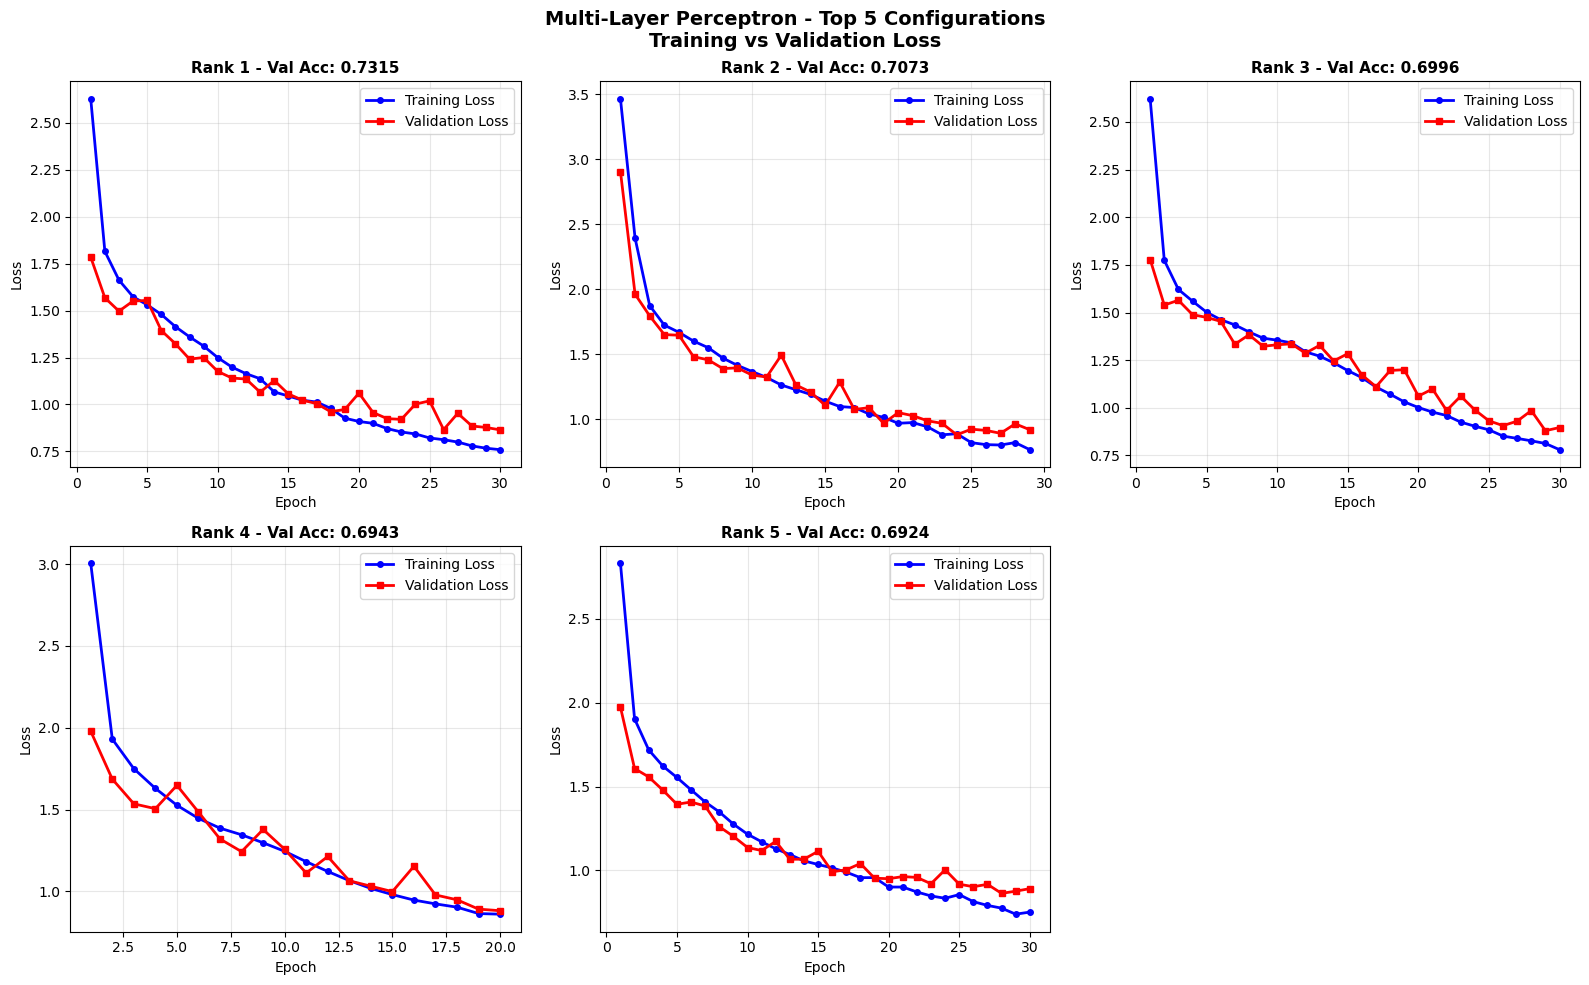

In [6]:
# Plot validation loss curves for top 5
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Multi-Layer Perceptron - Top 5 Configurations\nTraining vs Validation Loss', 
             fontsize=14, fontweight='bold')

for idx, history in enumerate(top5_histories):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    
    rank = idx + 1
    val_acc = mlp_top5.iloc[idx]['Val_Acc']
    ax.set_title(f'Rank {rank} - Val Acc: {val_acc:.4f}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('mlp_validation_loss_curves.png', dpi=300, bbox_inches='tight')
print("✓ Loss curves plot saved as 'mlp_validation_loss_curves.png'")
plt.show()

## 5. Save Results

In [7]:
# Create results directory
results_dir = 'mlp_results'
os.makedirs(results_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*80)
print("SAVING RESULTS".center(80))
print("="*80)

# 1. Save summary CSV with all results
mlp_results['summary_df'].to_csv(f'{results_dir}/all_results_{timestamp}.csv', index=False)
print(f"✓ All results saved to: all_results_{timestamp}.csv")

# 2. Save top 5 CSV
mlp_top5.to_csv(f'{results_dir}/top5_results_{timestamp}.csv', index=False)
print(f"✓ Top 5 results saved to: top5_results_{timestamp}.csv")

# 3. Save best model info
best_model_info = {
    'best_params': mlp_results['best_params'],
    'best_val_acc': float(mlp_results['best_val_acc']),
    'best_test_acc': float(mlp_results['best_test_acc']),
}

with open(f'{results_dir}/best_model_{timestamp}.json', 'w') as f:
    json.dump(best_model_info, f, indent=4, default=str)
print(f"✓ Best model info saved to: best_model_{timestamp}.json")

# 4. Save best model itself
torch.save(mlp_results['best_model'].state_dict(), 
           f'{results_dir}/best_model_weights_{timestamp}.pt')
print(f"✓ Best model weights saved to: best_model_weights_{timestamp}.pt")

# 5. Save training history for best model
with open(f'{results_dir}/best_model_history_{timestamp}.pkl', 'wb') as f:
    pickle.dump(mlp_results['best_history'], f)
print(f"✓ Best model training history saved to: best_model_history_{timestamp}.pkl")

# 6. Save training histories for top 5
for i, history in enumerate(top5_histories, 1):
    with open(f'{results_dir}/rank_{i:02d}_history_{timestamp}.pkl', 'wb') as f:
        pickle.dump(history, f)
print(f"✓ Top 5 training histories saved")

# 7. Save loss curves data as CSV for easy access
for i, history in enumerate(top5_histories, 1):
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train_Loss': history['train_loss'],
        'Val_Loss': history['val_loss'],
        'Train_Acc': history['train_acc'],
        'Val_Acc': history['val_acc'],
    })
    loss_df.to_csv(f'{results_dir}/rank_{i:02d}_loss_curves_{timestamp}.csv', index=False)
print(f"✓ Loss curves data saved as CSV for all top 5")

# 8. Save summary report
summary = {
    'model': 'MLP',
    'timestamp': timestamp,
    'total_combinations': int(total_combinations),
    'best_val_accuracy': float(mlp_results['best_val_acc']),
    'best_test_accuracy': float(mlp_results['best_test_acc']),
    'best_hyperparameters': mlp_results['best_params'],
    'top5_accuracies': mlp_top5['Val_Acc'].tolist(),
}

with open(f'{results_dir}/summary_report_{timestamp}.json', 'w') as f:
    json.dump(summary, f, indent=4, default=str)
print(f"✓ Summary report saved to: summary_report_{timestamp}.json")

print("\n" + "="*80)
print(f"All results saved to: {results_dir}/".center(80))
print("="*80)


                                 SAVING RESULTS                                 
✓ All results saved to: all_results_20251125_231212.csv
✓ Top 5 results saved to: top5_results_20251125_231212.csv
✓ Best model info saved to: best_model_20251125_231212.json
✓ Best model weights saved to: best_model_weights_20251125_231212.pt
✓ Best model training history saved to: best_model_history_20251125_231212.pkl
✓ Top 5 training histories saved
✓ Loss curves data saved as CSV for all top 5
✓ Summary report saved to: summary_report_20251125_231212.json

                       All results saved to: mlp_results/                       


## 6. Results Summary

## 6. Best Model Evaluation - Classification Report & Confusion Matrix


CLASSIFICATION REPORT - MLP BEST MODEL (All 38 Classes)
              precision    recall  f1-score   support

    Class_00     0.9203    0.8467    0.8819       150
    Class_01     0.6994    0.7600    0.7284       150
    Class_02     0.5957    0.9133    0.7211       150
    Class_03     0.7969    0.6800    0.7338       150
    Class_04     0.8231    0.7133    0.7643       150
    Class_05     0.7432    0.9067    0.8168       150
    Class_06     0.8000    0.6957    0.7442        23
    Class_07     0.6919    0.9133    0.7874       150
    Class_08     0.9474    0.9692    0.9582       130
    Class_09     0.6095    0.6867    0.6458       150
    Class_10     0.6505    0.8067    0.7202       150
    Class_11     0.6627    0.7333    0.6962       150
    Class_12     0.6780    0.9267    0.7831       150
    Class_13     0.7239    0.6467    0.6831       150
    Class_14     0.6688    0.7000    0.6840       150
    Class_15     0.7928    0.5867    0.6743       150
    Class_16     0.7273 

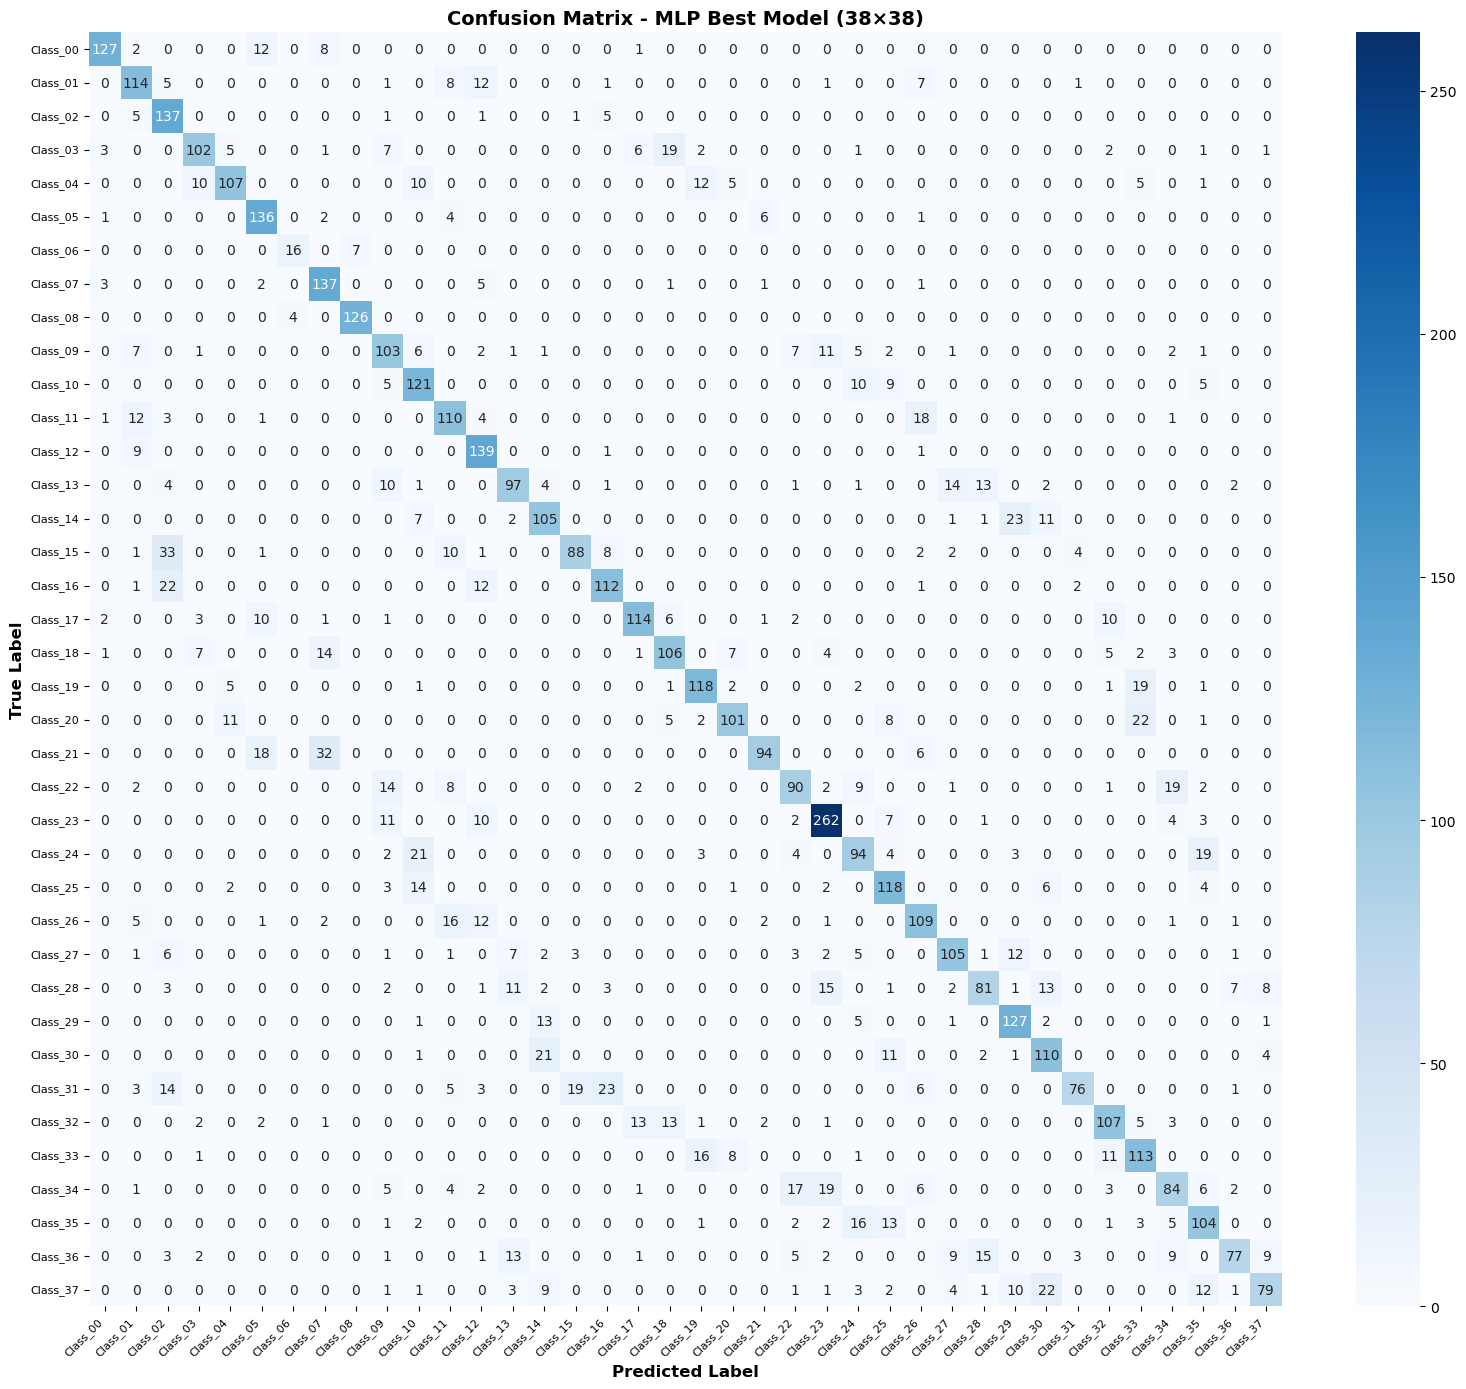


PER-CLASS METRICS SUMMARY
   Class  Precision   Recall  F1-Score  Support  Accuracy
Class_00   0.920290 0.846667  0.881944      150  0.846667
Class_01   0.699387 0.760000  0.728435      150  0.760000
Class_02   0.595652 0.913333  0.721053      150  0.913333
Class_03   0.796875 0.680000  0.733813      150  0.680000
Class_04   0.823077 0.713333  0.764286      150  0.713333
Class_05   0.743169 0.906667  0.816817      150  0.906667
Class_06   0.800000 0.695652  0.744186       23  0.695652
Class_07   0.691919 0.913333  0.787356      150  0.913333
Class_08   0.947368 0.969231  0.958175      130  0.969231
Class_09   0.609467 0.686667  0.645768      150  0.686667
Class_10   0.650538 0.806667  0.720238      150  0.806667
Class_11   0.662651 0.733333  0.696203      150  0.733333
Class_12   0.678049 0.926667  0.783099      150  0.926667
Class_13   0.723881 0.646667  0.683099      150  0.646667
Class_14   0.668790 0.700000  0.684039      150  0.700000
Class_15   0.792793 0.586667  0.674330      1

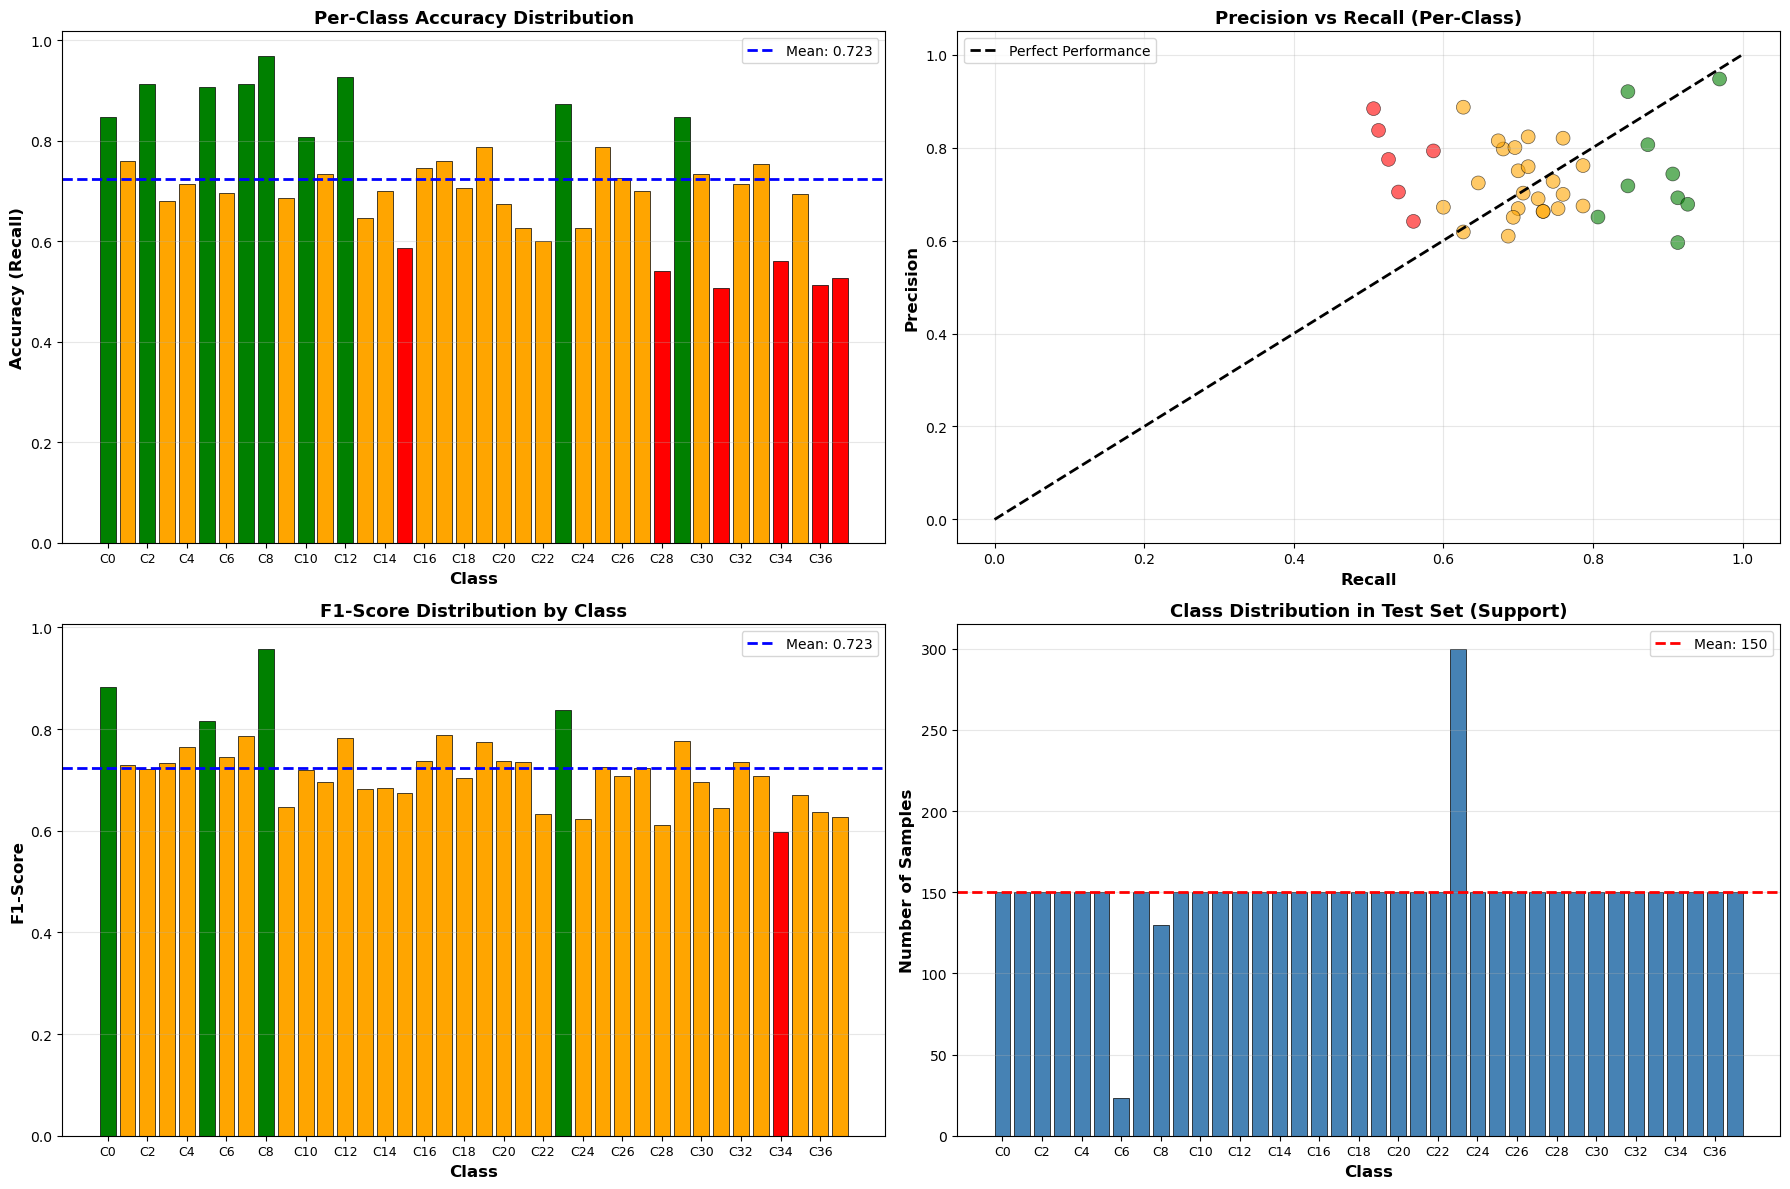


EVALUATION COMPLETE - All results saved successfully


In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from datetime import datetime

# Load best model and generate predictions
best_model = mlp_results['best_model']
best_model.eval()

# Generate predictions on test set
X_test_tensor = torch.FloatTensor(X_test).to(device)
with torch.no_grad():
    logits = best_model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Generate classification report
class_names = [f'Class_{i:02d}' for i in range(38)]
report = classification_report(y_test, predictions, target_names=class_names, digits=4)
print("\n" + "="*80)
print("CLASSIFICATION REPORT - MLP BEST MODEL (All 38 Classes)")
print("="*80)
print(report)

# Save classification report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = f'classification_report_{timestamp}.txt'
with open(report_path, 'w') as f:
    f.write("CLASSIFICATION REPORT - MLP BEST MODEL (All 38 Classes)\n")
    f.write("="*80 + "\n")
    f.write(report)
print(f"\n✓ Classification report saved to: {report_path}")

# Compute and visualize confusion matrix
cm = confusion_matrix(y_test, predictions)
print(f"\nConfusion Matrix Shape: {cm.shape}")

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax, 
            xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - MLP Best Model (38×38)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

cm_path = f'confusion_matrix_{timestamp}.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {cm_path}")
plt.show()

# Extract per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions, labels=range(38))
class_accuracy = recall  # Recall is per-class accuracy

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': class_accuracy
})

print("\n" + "="*80)
print("PER-CLASS METRICS SUMMARY")
print("="*80)
print(metrics_df.to_string(index=False))

# Save per-class metrics
metrics_path = f'class_wise_metrics_{timestamp}.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✓ Per-class metrics saved to: {metrics_path}")

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Overall Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Macro-Average Precision: {precision.mean():.4f}")
print(f"Macro-Average Recall: {recall.mean():.4f}")
print(f"Macro-Average F1-Score: {f1.mean():.4f}")
print(f"\nBest Performing Classes (Top 5 by F1-Score):")
top_5 = metrics_df.nlargest(5, 'F1-Score')[['Class', 'F1-Score', 'Recall', 'Support']]
print(top_5.to_string(index=False))
print(f"\nWorst Performing Classes (Bottom 5 by F1-Score):")
bottom_5 = metrics_df.nsmallest(5, 'F1-Score')[['Class', 'F1-Score', 'Recall', 'Support']]
print(bottom_5.to_string(index=False))

# Create comprehensive 4-subplot visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Subplot 1: Per-class Accuracy (Recall) with color coding
ax1 = axes[0, 0]
colors_acc = ['green' if x >= 0.8 else 'orange' if x >= 0.6 else 'red' for x in class_accuracy]
bars1 = ax1.bar(range(38), class_accuracy, color=colors_acc, edgecolor='black', linewidth=0.5)
ax1.axhline(y=class_accuracy.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {class_accuracy.mean():.3f}')
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (Recall)', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Accuracy Distribution', fontsize=13, fontweight='bold')
ax1.set_xticks(range(0, 38, 2))
ax1.set_xticklabels([f'C{i}' for i in range(0, 38, 2)], fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Subplot 2: Precision vs Recall Scatter
ax2 = axes[0, 1]
colors_pr = ['green' if x >= 0.8 else 'orange' if x >= 0.6 else 'red' for x in class_accuracy]
scatter = ax2.scatter(recall, precision, c=colors_pr, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Performance')
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Precision vs Recall (Per-Class)', fontsize=13, fontweight='bold')
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Subplot 3: F1-Score by Class
ax3 = axes[1, 0]
colors_f1 = ['green' if x >= 0.8 else 'orange' if x >= 0.6 else 'red' for x in f1]
bars3 = ax3.bar(range(38), f1, color=colors_f1, edgecolor='black', linewidth=0.5)
ax3.axhline(y=f1.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {f1.mean():.3f}')
ax3.set_xlabel('Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('F1-Score Distribution by Class', fontsize=13, fontweight='bold')
ax3.set_xticks(range(0, 38, 2))
ax3.set_xticklabels([f'C{i}' for i in range(0, 38, 2)], fontsize=9)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Support Distribution (Sample Count)
ax4 = axes[1, 1]
bars4 = ax4.bar(range(38), support, color='steelblue', edgecolor='black', linewidth=0.5)
ax4.axhline(y=support.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {support.mean():.0f}')
ax4.set_xlabel('Class', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax4.set_title('Class Distribution in Test Set (Support)', fontsize=13, fontweight='bold')
ax4.set_xticks(range(0, 38, 2))
ax4.set_xticklabels([f'C{i}' for i in range(0, 38, 2)], fontsize=9)
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
accuracy_path = f'class_wise_accuracy_{timestamp}.png'
plt.savefig(accuracy_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Class-wise accuracy visualization saved to: {accuracy_path}")
plt.show()

print("\n" + "="*80)
print("EVALUATION COMPLETE - All results saved successfully")
print("="*80)

In [9]:
print("\n" + "="*80)
print("MULTI-LAYER PERCEPTRON - TUNING RESULTS SUMMARY".center(80))
print("="*80)

print(f"\nBest Model Performance:")
print(f"  Validation Accuracy: {mlp_results['best_val_acc']:.4f}")
print(f"  Test Accuracy: {mlp_results['best_test_acc']:.4f}")

print(f"\nBest Hyperparameters:")
for key, value in mlp_results['best_params'].items():
    print(f"  {key}: {value}")

print(f"\nTop 5 Validation Accuracies:")
for rank, acc in enumerate(mlp_top5['Val_Acc'].values, 1):
    print(f"  Rank {rank}: {acc:.4f}")

print(f"\nTotal tuning combinations evaluated: {total_combinations}")
print("\n" + "="*80)


                MULTI-LAYER PERCEPTRON - TUNING RESULTS SUMMARY                 

Best Model Performance:
  Validation Accuracy: 0.7315
  Test Accuracy: 0.7270

Best Hyperparameters:
  learning_rate: 0.001
  batch_size: 64
  hidden_sizes: [256, 128]
  dropout: 0.1
  num_epochs: 30
  optimizer: adam

Top 5 Validation Accuracies:
  Rank 1: 0.7315
  Rank 2: 0.7073
  Rank 3: 0.6996
  Rank 4: 0.6943
  Rank 5: 0.6924

Total tuning combinations evaluated: 648

